# Tutorial 4 - Spatial Regression in Python

```{attention}
Finnish university students are encouraged to use the CSC Notebooks platform.<br/>
<a href="https://notebooks.csc.fi/#/blueprint/c54303e865294208ba1ef381332fd69b"><img alt="CSC badge" src="https://img.shields.io/badge/launch-CSC%20notebook-blue.svg" style="vertical-align:text-bottom"></a>

Others can follow the lesson interactively using Binder. Check the rocket icon on the top of this page.
```

```{admonition} Attribution
**Standing on the shoulders of giants**: This tutorial is based on excellent open source materials developed by Daniel Arribas-Bel (Uni. Liverpool) available in [here](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) (licensed with Creative Commons BY-NC-SA). Inspiration is also driven from Chapter 11 of the forthcoming book "Geographic Data Science with Python" by Rey, Arribas-Bel & Wolf which you can access from [here](https://geographicdata.science/book/notebooks/11_regression.html) (licensed with Creative Commons BY-NC-ND).
```

This notebook covers a brief and gentle introduction to spatial econometrics in Python. To do that, we will use a set of Austin properties listed in AirBnb.

The core idea of spatial econometrics is to introduce a formal representation of space into the statistical framework for regression. This can be done in many ways: by including predictors based on space (e.g. distance to relevant features), by splitting the datasets into subsets that map into different geographical regions (e.g. [spatial regimes](http://pysal.readthedocs.io/en/latest/library/spreg/regimes.html)), by exploiting close distance to other observations to borrow information in the estimation (e.g. [kriging](https://en.wikipedia.org/wiki/Kriging)), or by introducing variables that put in relation their value at a given location with those in nearby locations, to give a few examples. Some of these approaches can be implemented with standard non-spatial techniques, while others require bespoke models that can deal with the issues introduced. In this short tutorial, we will focus on the latter group. In particular, we will introduce some of the most commonly used methods in the field of spatial econometrics.

The example we will use to demonstrate this draws on hedonic house price modelling. This a well-established methodology that was developed by [Rosen (1974)](https://www.sonoma.edu/users/c/cuellar/econ421/rosen-hedonic.pdf) that is capable of recovering the marginal willingness to pay for goods or services that are not traded in the market. In other words, this allows us to put an implicit price on things such as living close to a park or in a neighborhood with good quality of air. In addition, since hedonic models are based on linear regression, the technique can also be used to obtain predictions of house prices.

## Prepare data

Before anything, let us load up the libraries we will use:

In [1]:
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
import hvplot.pandas
from scipy import stats
import statsmodels.formula.api as sm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pyrosm import OSM, get_data
sns.set(style="whitegrid")

Let's read the Airbnb data and OSM data for Austin, Texas:

In [2]:
# Read listings
fp = "data/listings.csv"
data = pd.read_csv(fp)
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

<AxesSubplot:>

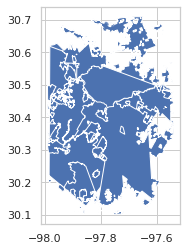

In [3]:
# Read OSM data - get administrative boundaries
osm = OSM(get_data("austin"))
boundaries = osm.get_boundaries()

# Let's check the boundaries on a map
boundaries.plot()

Let's convert the Airbnb data into GeoDataFrame based on the `longitude` and `latitude` columns and filter the data geographically based on Austing boundaries:

In [4]:
# Create a GeoDataFrame
data["geometry"] = gpd.points_from_xy(data["longitude"], data["latitude"])
data = gpd.GeoDataFrame(data, crs="epsg:4326")

# Filter geographically
data = gpd.sjoin(data, boundaries[["geometry"]])
data = data.reset_index(drop=True)

# Check the first rows
data.head()

id                           listing_url       scrape_id last_scraped  \
0    72635    https://www.airbnb.com/rooms/72635  20151107173015   2015-11-08   
1  5386323  https://www.airbnb.com/rooms/5386323  20151107173015   2015-11-07   
2  8536913  https://www.airbnb.com/rooms/8536913  20151107173015   2015-11-08   
3  8542056  https://www.airbnb.com/rooms/8542056  20151107173015   2015-11-07   
4  6385948  https://www.airbnb.com/rooms/6385948  20151107173015   2015-11-08   

                             name  \
0   3 Private Bedrooms, SW Austin   
1                 Cricket Trailer   
2       Brand-New 3BR Austin Home   
3        Private room & Bathroom.   
4  S. Austin, convenient to MoPac   

                                             summary  \
0  Conveniently located 10-15 from downtown in SW...   
1  Rent this cool concept trailer that has everyt...   
2  Brand-new 3BR/2BA Austin home with landscaped ...   
3  15 minutes from Downtown & Zilker Park. Use of...   
4  Private upstairs room with bath in far South A...   

                                               space  \
0  We have three spare bedrooms, each with a quee...   
1  Rental arrangements for this trailer allows yo...   
2  Feel instantly at home at our brand new 3BR/2B...   
3                                                NaN   
4  In addition to the first bedroom, we have an a...   

                                         description experiences_offered  \
0  Conveniently located 10-15 from downtown in SW...                none   
1  Rent this cool concept trailer that has everyt...                none   
2  Brand-new 3BR/2BA Austin home with landscaped ...                none   
3  15 minutes from Downtown & Zilker Park. Use of...                none   
4  Private upstairs room with bath in far South A...                none   

                               neighborhood_overview  ... license  \
0  Location and convenience are key.  Easy access...  ...     NaN   
1  We're talking about wherever you'd like in the...  ...     NaN   
2  Entertainment and activities are plentiful her...  ...     NaN   
3                                                NaN  ...     NaN   
4  Quiet, residential neighborhood that feels a l...  ...     NaN   

  jurisdiction_names instant_bookable cancellation_policy  \
0                NaN                f            moderate   
1                NaN                f            moderate   
2                NaN                f              strict   
3                NaN                f            flexible   
4                NaN                f            flexible   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count reviews_per_month  \
0                               1              0.02   
1                               1               NaN   
2                               2               NaN   
3                               1               NaN   
4                               1               NaN   

                     geometry index_right  
0  POINT (-97.88431 30.20282)          14  
1  POINT (-97.90068 30.19941)          14  
2  POINT (-97.88832 30.16943)          14  
3  POINT (-97.90744 30.18676)          14  
4  POINT (-97.92022 30.18770)          14  

[5 rows x 94 columns]

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

Let's investigate our listings data on top of a map:

In [5]:
data.hvplot(geo=True, tiles="OSM", alpha=0.5, width=600, height=600, hover_cols=["name"])

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (name)

<div id='1003'>





  <div class="bk-root" id="7508d413-223e-4091-b08e-3b5178a9adf0" data-root-id="1003"></div>
</div>
<script type="application/javascript">(function(root) {
  function embed_document(root) {
    var docs_json = {"a1e806d3-c4be-4bb1-8b82-105c616c887b":{"roots":{"references":[{"attributes":{"children":[{"id":"1004"},{"id":"1016"},{"id":"1121"}],"margin":[0,0,0,0],"name":"Row02957","tags":["embedded"]},"id":"1003","type":"Row"},{"attributes":{"axis":{"id":"1029"},"dimension":1,"grid_line_color":null,"ticker":null},"id":"1032","type":"Grid"},{"attributes":{"attribution":"&copy; <a href=\"https://www.openstreetmap.org/copyright\">OpenStreetMap</a> contributors","url":"http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png"},"id":"1068","type":"WMTSTileSource"},{"attributes":{"tile_source":{"id":"1068"}},"id":"1071","type":"TileRenderer"},{"attributes":{"margin":[5,5,5,5],"name":"HSpacer02962","sizing_mode":"stretch_width"},"id":"1121","type":"Spacer"},{"attributes":{},"id":"1034","type":"PanTool"},{"attributes":{"below":[{"id":"1025"}],"center":[{"id":"1028"},{"id":"1032"}],"frame_height":600,"frame_width":600,"left":[{"id":"1029"}],"margin":[5,5,5,5],"match_aspect":true,"min_border_bottom":10,"min_border_left":10,"min_border_right":10,"min_border_top":10,"renderers":[{"id":"1071"},{"id":"1081"}],"sizing_mode":"fixed","title":{"id":"1017"},"toolbar":{"id":"1039"},"x_range":{"id":"1009"},"x_scale":{"id":"1021"},"y_range":{"id":"1010"},"y_scale":{"id":"1023"}},"id":"1016","subtype":"Figure","type":"Plot"},{"attributes":{"dimension":"lon"},"id":"1048","type":"MercatorTicker"},{"attributes":{"zoom_on_axis":false},"id":"1035","type":"WheelZoomTool"},{"attributes":{},"id":"1021","type":"LinearScale"},{"attributes":{"match_aspect":true,"overlay":{"id":"1038"}},"id":"1036","type":"BoxZoomTool"},{"attributes":{"callback":null,"formatters":{"Latitude":{"id":"1084"},"Longitude":{"id":"1083"}},"renderers":[{"id":"1081"}],"tags":["hv_created"],"tooltips":[["Longitude","@{Longitude}{custom}"],["Latitude","@{Latitude}{custom}"],["name","@{name}"]]},"id":"1013","type":"HoverTool"},{"attributes":{},"id":"1037","type":"ResetTool"},{"attributes":{"dimension":"lat"},"id":"1050","type":"MercatorTicker"},{"attributes":{"fill_alpha":{"value":0.2},"fill_color":{"value":"#1f77b3"},"line_alpha":{"value":0.2},"line_color":{"value":"#1f77b3"},"size":{"units":"screen","value":5.477225575051661},"x":{"field":"Longitude"},"y":{"field":"Latitude"}},"id":"1080","type":"Scatter"},{"attributes":{"fill_alpha":{"value":0.5},"fill_color":{"value":"#1f77b3"},"line_alpha":{"value":0.5},"line_color":{"value":"#1f77b3"},"size":{"units":"screen","value":5.477225575051661},"x":{"field":"Longitude"},"y":{"field":"Latitude"}},"id":"1079","type":"Scatter"},{"attributes":{},"id":"1023","type":"LinearScale"},{"attributes":{"axis_label":"x","bounds":"auto","formatter":{"id":"1049"},"major_label_orientation":"horizontal","ticker":{"id":"1048"}},"id":"1025","type":"LinearAxis"},{"attributes":{"fill_alpha":{"value":0.5},"fill_color":{"value":"#1f77b3"},"line_alpha":{"value":0.5},"line_color":{"value":"#1f77b3"},"size":{"units":"screen","value":5.477225575051661},"x":{"field":"Longitude"},"y":{"field":"Latitude"}},"id":"1078","type":"Scatter"},{"attributes":{"axis":{"id":"1025"},"grid_line_color":null,"ticker":null},"id":"1028","type":"Grid"},{"attributes":{"data_source":{"id":"1075"},"glyph":{"id":"1078"},"hover_glyph":null,"muted_glyph":{"id":"1080"},"nonselection_glyph":{"id":"1079"},"selection_glyph":null,"view":{"id":"1082"}},"id":"1081","type":"GlyphRenderer"},{"attributes":{"end":3572460.2903887546,"min_interval":5,"reset_end":3572460.2903887546,"reset_start":3516919.911749741,"start":3516919.911749741,"tags":[[["Latitude","Latitude",null]]]},"id":"1010","type":"Range1d"},{"attributes":{"text":"","text_color":{"value":"black"},"text_font_size":{"value":"12pt"}},"id":"1017","type":"Title"},{"attributes":{"bottom_units":"screen","fill_alpha":0.5,"fill_color":"lightgrey","left_units":"screen","level":"overlay","line_alpha":1.0,"line_color":"black","line_dash":[4,4],"line_width":2,"right_units":"screen","top_units":"screen"},"id":"1038","type":"BoxAnnotation"},{"attributes":{},"id":"1088","type":"UnionRenderers"},{"attributes":{"dimension":"lon"},"id":"1049","type":"MercatorTickFormatter"},{"attributes":{"active_drag":"auto","active_inspect":"auto","active_multi":null,"active_scroll":"auto","active_tap":"auto","tools":[{"id":"1013"},{"id":"1034"},{"id":"1035"},{"id":"1036"},{"id":"1037"}]},"id":"1039","type":"Toolbar"},{"attributes":{"dimension":"lat"},"id":"1051","type":"MercatorTickFormatter"},{"attributes":{"source":{"id":"1075"}},"id":"1082","type":"CDSView"},{"attributes":{"data":{"Latitude":{"__ndarray__":"EWyS19ftSkEKpSVA/OxKQdVKH0hx5UpB6Qjgnc3pSkGCkJeaCepKQaG6shTn6EpBxmCGaXDqSkF2o65U6etKQe02+HcN4UpB08Grv0bqSkFVahcbaOpKQbY/84aCDUtBsXVoVmAaS0HvwhKtoRlLQV8ZLbMkF0tBSckbncAaS0GKPmPlrRhLQSBx8morGEtBAPCmK4QZS0EvOWihvRRLQdBDVToKGUtBy081A6wZS0E8VJOhgxdLQYBcb/xgFktBTaKI7jgZS0GqgMeyqRFLQTlL6/kYIEtBJWkm7aAXS0F3fmC0whhLQe456Km4EEtBhFoKJIUMS0EBZRMbtgxLQYhHlGsHC0tByloJr5IMS0HU/YeF8AtLQYhS1Z0vC0tBhdMv8XwJS0Gosx9IsAlLQVY1tAKMCUtBxA67AvILS0F9jCrvRwlLQcXYJkpYCEtBqWPl8ckJS0FDc8tqVAlLQfbmRd7nC0tB97BTsNYJS0ERPQXWnAxLQdqRjYgBC0tBwl4WoDEMS0FXuET2gQlLQZnZRDJuDktB2GMsZJMNS0HPgQz46ApLQdI+l+AEDUtB2EjmGtcKS0HslC/27QxLQcW7jZB5C0tBXypnVfcKS0F5pqlCdwxLQT4LBaZOC0tBa1+8A2cKS0EwhjKFiQxLQYYPB3YwCktBlidbPDkKS0H2JnMAbwlLQS4BLM2gC0tBiaGJMQMKS0GEbMt2Bg1LQbbAJyfGCktBbeC8SFsNS0GFzqy+4w1LQQsXyU4mDEtBd3GJOxEMS0FRV9CUGwtLQTWe3MgrC0tB73+S9vcHS0Hznrn1FgpLQWM2P7+sDktBAFGkfsUNS0HP7Rco5gpLQR6AnVofCUtBZ22c6QANS0EChqavNglLQTfl3DdYDktBo+RDxOwJS0Hlm8e3eQxLQV2xECuwDUtB/5PXNO8HS0H9IZTOzw5LQdbORISyDktBE/4p5RwJS0HtJA9hJglLQTDE/4k3DUtBBQVxiJYJS0FQALUDvghLQaGRjmWNC0tBbi6KO8gJS0HOaiUdNQtLQRPDPBLBDUtBk8olQSoNS0HP6wkpBwlLQbDWbLFOCEtBMBGKPvcIS0H9FTv5nwlLQf1qrdYGCUtBmQYcgQIMS0FzBrwkKwtLQQ3O16imDEtBu4a5fFYMS0HguLaEQwlLQX5nIVugC0tBO0YGlkIJS0HPVLEk3wxLQau6NAkjC0tBT1jiGlcNS0GbH07fYwpLQWmBFilbCktB7oEGrKUKS0FN3ptDNQtLQbEJGkIIC0tBbm+t/A0MS0FQ6vzY699KQcJSO1C44EpBb1SXvR/hSkF2+VbKOOBKQUXJvOv54EpBjp5L6v/gSkH9Gt9MyuFKQRSDRosl40pBtRAwXMXgSkEsu6lmN95KQfkkqRfo4UpBFt4GVprfSkFap3HPleNKQfcnGjuh3kpBFT9JMn3iSkGtWVkrKOJKQcaio0nb4EpBzoPD1qfeSkHHFJSsQwhLQeuYAMWZCEtBsT/XxvMFS0HiUGqtkwZLQWjuFhynCEtBGgy9OCQIS0Hr56YZiAtLQQFxFRYEC0tBd1CvVesKS0GWrf18dgZLQQ40GAtWC0tB+Qy3Q+EGS0FXMCSTJwpLQap1rXDtC0tBidmbMZ0GS0Ewa66trQVLQXFo2uX5CktBMrwML6sLS0EwYxqusAZLQWDzUuUQCEtBkjmd0HoGS0EuwvrJ5wtLQQO3UhVdCktBuPIixXkLS0HTvYyaEApLQQl0Hpb8C0tBDMppVSQLS0ESvFFqBwlLQX0q5oDbBktBKZOcewMIS0FU9ihOSgdLQZBC+XloCEtBv3tzkDEMS0G9nvnawwdLQXc3PCH6C0tBdYEkGCEIS0HtEtJfNghLQd9ji8kUB0tBBbGZH8cHS0E1UhpMfAdLQYKeyhOHB0tBgQJ32hoLS0F/dVgbIgtLQdf26Ni/CUtBjVQ1ZEUIS0F7BpTb2wlLQZjH8vURCktBXxFX2uEKS0E+pKzRwwlLQerGRMvjB0tB/qha4UMLS0HEdFlFUAhLQdHg59TkB0tBwJlduIMIS0ElTxL8lwhLQQfSkOSrCEtBAe2dnA0JS0FsCMFDgAdLQZdcigUHB0tBmLz3MEkIS0Eq2LnIIAdLQS2OgmkLB0tB7qMVawEIS0EUlmm6zQlLQTdUxbpOCktBVjlr2x4GS0FcvJdHCwpLQSTrKuoZCEtBkEdsCjMJS0E/8ONq2whLQflGLT+UBktBuzCBo3oJS0E0lyF9hQlLQXVD3o9aCktB+WWV63kLS0FgIY9olwpLQZ+0+CHkCEtBG/WQNvcGS0FynEqbRglLQXAaINisB0tBr4IkchoIS0Fd+aeO0whLQdUSWUaCBktBE1DnsA4IS0EsetP7NApLQY0rkvtrBktBA5sVBkEIS0HYIrjSUAlLQZLwntnNCEtBKm+JPscJS0HJfi8/2wdLQT0OOjrnB0tBBYWveDQJS0FUVSyxoQlLQVQuIAXjBktB/9p5NcMIS0GldKpwfQhLQZ/wPO1tB0tBES0KBA8LS0GEbBWWeAhLQTgynKQfB0tBM/uisDIIS0EiYu5lGQxLQZ8P0VpHBktB4FSq8wEIS0FPYQ6l+wVLQbdw30ORBUtBMucWvisFS0GU3x7sIwdLQRF9WykJC0tBqFf1G1gHS0FyaVtp3AZLQfK7TaWmB0tBfxpSKvcGS0HXriKXNAtLQWhdR+itCEtBawlixPsGS0HiUFOg1AhLQXJHSit1DEtBHeQ0dXoHS0HqLAYzBAdLQeZ4lsbOCUtBAbDUlx4IS0E/QWJr5gVLQVsfXMfVBktB0E4o4iUJS0El1jCU4wtLQcoNwoarBktBuXyoMSYJS0G0wV1smwlLQdrzDObXBktBbsztiaMGS0FxS88iGgtLQcpIXq92C0tBLoAT8MUGS0EYezggfwhLQXukqYltCUtBBZAV2O8HS0E0qxIadQpLQR536rc4CktBMTf1dcwKS0E1reT8VghLQYKsClqpCUtBtHOMWfQKS0GlTLBcYwZLQaslOz+xB0tB0W+zrN4HS0E/4J3PvQpLQeLr3kVhB0tBL3DJQd8GS0FV0D63KgxLQbrcqyzSCktB9B4F4uUJS0HIzrQ/bghLQYkq8VC5CEtB/9JDxMQLS0HdBxOQKgtLQe3IbUcxCktB1PgvmR4JS0F6/Jiz3gZLQSlFd0cHCUtBuKcIvQ8IS0FmnhoiyglLQbr+4eRTB0tBdHSvYFYIS0EXLTDr1wZLQeDuIKohCUtB5WfOGbQLS0FTa+MFSQtLQV8i7dqMBktBO6qj1sgJS0EeSTQOsgdLQVh3z5IrCEtBdDf48zEIS0GwassTIwlLQV1WnjKWCEtBYorpxe4IS0FyTl5SKAtLQR+FMC7VCEtB3flKGdUJS0GlT3mnWAtLQRV0TO31BktBsLGBQ/0HS0GHntLfFghLQS4uPD3KBktB95rPM4cHS0FQKL7O+QhLQRPUmu7UCktB+X0lqdoGS0GKRQlQbQlLQQxO150XCUtB75ucmP0IS0GnHadifwtLQX3KYSr8CEtBW76tGpMIS0GOV5sNmwhLQZX/L7D1C0tBnnFsCkoGS0GtBuf9fQZLQZGC9X8LC0tBUtDAYj0IS0E1f2cQOAlLQbbdNGeIC0tB5YuwRVkHS0ECsdQSmgdLQS2BlCx0CEtBM178TE8HS0G4/sMHtwtLQWECEhYUCEtBwyQ+lY8IS0GTQe8wAgdLQQ+XJKLuB0tBYLTG5D0LS0EuxbrGyAhLQapxWinHBktBp+7SH6gIS0FDg7h7MQtLQdx+Fx2NCEtBAEHW/0AHS0ESzYpW0ghLQdKi1bM6CUtBFGhcqa4HS0E8k5EWeQdLQXn1bCC8C0tBGE1XWO4LS0Et0LgLBwxLQZ+F+rPaCktBS5sA4uYHS0Ef54wWAgdLQZS/lvo5B0tB8sCMAG8HS0HrpzIqTwlLQfX9EIatB0tBqETF9lgKS0GA1PxkOwlLQaziQlhHB0tBKOcEZbwJS0EqT/SV6QZLQVJ60Wn3BktBqBojCtEIS0HWevLS5AhLQVeg8A3xCEtB5/Ee32YKS0HtLGmABQlLQZc1ljFACUtBBJNH6VIHS0HQRGqgLgdLQR7V7ld5C0tB3cgFcZMHS0EPkz2PFwpLQdwqZQolBUtBbAWJ38L8SkGphhdQ6ftKQYqkacIS/EpBzL64znb8SkESCdtmIgFLQRs2Nd96/EpBLbVcwa38SkHJalfLUvxKQbLMoh42/EpBmzYjGEr8SkFj4DWT8ftKQfP24WLO/EpBC2IqHeX8SkE7Zx8VgBVLQdy5UIV7FUtBk3JbryoQS0GPddJa4BZLQRuUhC/WE0tBHuNKCcEQS0GXZc7T5RVLQfwFF/IoFUtBspO9qiUQS0GSaQIJHxRLQWedYLa3EEtBTWhRCckVS0GqUFjlgBFLQWuGaCBkEUtBMq+DKKgUS0GLLT+bRBZLQT4I35zLEktBBXDL7pQUS0HCceZNRxRLQV8X2CQVGEtBt1G9LioSS0EER9s8yxJLQUfYDp92EUtB4keNbg8RS0E91o1gdhBLQbJ282isEktBzMOvvjARS0GekOKwuRBLQd8LNkTlEUtBbjMI7NcRS0G36LQBNBJLQf8/WYN9EUtBC5Ybt94QS0EvcMbj6xBLQfCJo13VDktBbigHLvsOS0FZ9rt1jw5LQY5AIjaBEEtBM50iYJkRS0FKjbyxwxNLQRFyyvu/DktB3d8i8m8NS0HO1FLuDg5LQTTt4dT4EEtB76N2IXkOS0EHfIB9fg1LQSIOPKxODktB8Vo3c/MOS0EdkmCTxBVLQUlHrz7JD0tBWVxYqzkSS0GZmecXFg9LQQtdJkZtFEtBErv+FU0WS0HEaxpDPRVLQU5rqRepEUtBW/KrLI4PS0HhfH9wHQ9LQWIvPLrMFEtBPvB3MHQQS0FARsNFnxBLQQcNRRsgEEtBlM0OGRMUS0GZNC83zxVLQdEGpGAbEktBVTVugRcXS0GUvfbGJhdLQdvKMVFRD0tBzYyrobkPS0HT0Gi12RFLQbxWBBzqFEtBSmDDpm4OS0EEFV6G7xdLQc8DVSMDEEtB0C88zxYSS0F7CB4VCxZLQQ4WAziHEUtBw59T9QIRS0FQCjt19RRLQSmuPwptDktBHju276MQS0G1U7dgzA9LQQNr0G09EEtBd+Hip0gVS0FfPF5OCA9LQUK1OX9REEtB2Yjqg18OS0GBn/RoXg9LQXda9f3kEEtBYg2BubQPS0ExPejmIxRLQe19qCD0FktBIAWXkWoQS0EZ8UeQihVLQZIrKC+vDktBCXWuDh4PS0EgQuQfbhFLQRR+MqxbFktBHCHABr8RS0GydrpDyw9LQYpDw5nMDktBD/GnUqURS0F7HXC4wA9LQRqI1PaHEEtBLd/oAVwRS0FrEAzj8Q1LQdXC9hDzEEtBElFNu0cVS0Ef4y4EghFLQaYxQAo0D0tBcbtqPAcUS0Ghd6QochBLQTkftS3nEUtBzJ8qETIQS0Fr/mPxxRVLQR+b9/FHEEtBJEb+V2MVS0GQVR/VGRhLQQkmrYjuFUtBV4aKgHrsSkEGMl4ML+pKQdpkJnZL5kpBo4MbOZbpSkFU6rTNx+tKQbd6tkB55kpBMM/EAl7tSkGKpINXUuZKQZVmu7FH5EpBGOxN0HjlSkHPdZt2T+tKQcDAzcEd7EpBSnvyr8TqSkFSjFTnz+xKQemSVEMV50pBFqXUOnDjSkG47xcmhOxKQYc4qI4r40pB2qEQjTTsSkH37KqASOpKQcZJyTaC7EpBOgTGl2/pSkHL5TrRCutKQU/I2bAT7EpBw/kfXCjqSkEKikNb++pKQesn9kyP40pBIL24cxPrSkHa/dKjzepKQc/4skoP6kpBQeNNJKvrSkHGt3SNx+pKQdhxB2Xn7EpBxp30ngfqSkHH5SvTDetKQaddrsBa7kpBC7FgChbrSkGIMT1yQ+dKQTx2Lc547EpBSTDhCAvnSkG0/yTNd+xKQehOauwz60pBuHFaHRLtSkHc4pjtm+xKQadzpVNK6kpBsjynBcbnSkHGC/OtcOdKQXuQXCGk7EpBakGzrizoSkEsgbGGGepKQWaA4gJa7UpB1ZI2LKLsSkG9QIfDbu1KQbDXw8sq6EpBWiDreF/nSkFtm+2DG+xKQYXL+epW60pBaC/RJdDqSkHsST9RS+NKQbqgbuim40pB5L/ir6n0SkE5XsN8CvtKQRft6ZfW90pBMIXvYkb4SkF2jnvXgvZKQeuubeb790pBkDk1Tpv1SkGMFwkG5PdKQWKo9NnG+EpBtz4vJ1r3SkGI3IuyovlKQassCZWV+UpBOLWtS9j2SkHNg9V1h/ZKQXWqrXkN+EpBi7YV68j0SkEXlqNB9/dKQUdtrBIe+UpBzg1QJgf5SkHKA8dwr/VKQfJjgsbp9EpBXX3NaXH1SkHhZYRuP/dKQdV+AnaQ9EpBQJGu/UL0SkGweL/C1PZKQfj9BAjc9EpB0AfojJr3SkGv7WCKcvNKQamLncEO+EpBR8scToX1SkFgMNkQv/hKQQ5IFSNH90pBYghNCP/3SkH6oRxx+fdKQY/+S6Xm90pBYXH6ejv4SkGU+nCIe/hKQa3LbfzU9kpBS+N/Pd/0SkFyZ0mvKPRKQUtbkMnT90pBEdWoBgr4SkF4mIzTVPNKQUcT7DMV9EpBYrBUeyf4SkGtfVzklvJKQTvqwzKG9EpBeyF7OKz4SkEYLcBOBPVKQWKz2+JA90pB3IybQEfzSkGQ2lFUcfZKQeSVtp6V80pB5+rLbaf3SkEomQ4XjvNKQSaCGH7S9UpBeLZj8zz1SkHYrZsOAPNKQY7mEAfD9kpBrm+GULHzSkG/gzHoKfNKQRPt6zAn9UpBPkTWHHz2SkGI1c4FwvRKQfcRFk+L+EpB26QIjxf5SkHEjZ26U/dKQVC93QIY90pB1OK0FnbySkHft+jhhfJKQTdxJeQS9EpBqPVj6m30SkHLwoG7RPVKQcPN3yRN90pBRuE1dv70SkGdehwHGflKQQpt24lV+EpB5SSc+xT0SkFzw8W4pvdKQVilIEfP90pBiaakysrzSkEvQ5zjdPNKQaNcOLsc9UpBk3uF52v5SkHh6r+MwPZKQRQ+xf1W90pBocKKlmfzSkEWUhrg+PRKQcnMRt198UpBsvLQf6T0SkFTBuJIVfRKQearqVrK80pBm5JNkaP0SkFvL4LbqvNKQdVfRruK90pBG2A/OI7ySkECJQVEg/RKQY5d3Fe89EpBKKlrNgD1SkE3zvFs6vZKQd2LhqUY9EpBJY7aoEL0SkEOfL7HkPRKQYXnXT+w8kpBLtJHrtr3SkHZ0oE+nfJKQaCWUopD9UpBFZp/mc70SkGgaOd8rPZKQSuHJ98h90pB+SAjhRz1SkH/3gpZjPVKQfPB3KTu90pBCQMdjE33SkELtEDNNfdKQQK1PAw++EpBRJjG+Dr2SkEuyP2L4/RKQWRXPVD9+EpBa3VAnFT4SkHdZxdLVfhKQcF02Dxt9EpBfPjT1d73SkEx2IB3s/VKQX2jX+Yh90pBmr2obBT4SkFubqk2WvVKQTTjIwi29UpBuSwA69r1SkHy7GHRSPRKQYaZg3qz80pBcBjXbUj0SkEYwofg9PdKQXTq3LUW+UpBLpLixUL4SkGFrPIoWvZKQQACtRbj9kpBL5av5MXySkFwJAQRh/hKQf4GkbQC+EpBQ6mPUtL2SkF09OMcGvNKQXtrFUic9kpBC2gCXxL3SkHCTd6GWfRKQUTcnNlb9EpBGsTdtRH1SkHJ95o4b/ZKQfUCLfRu90pB4FU+s2v1SkHgqGhLXfdKQcgm1kQv+UpB3pz3NzX4SkGIOU/Fw/dKQdf2nCZH9UpBWETZomX1SkFquM3ak/RKQbq+HTwU9UpBW3o0hM70SkH2kFtTRfVKQcsW05qJ+EpBsLEVBo30SkEAij9+BfRKQSu2vSEi90pBtR9eD0f0SkHFI6FE3vdKQWb3iZdE90pBe3z8BtL3SkHwSIZWbflKQYq692s9+EpBORhqE9XzSkHXCJ+F/fhKQZxejh6t90pBjxjDHi34SkGrx7Nds/hKQd9LQJ239EpBwcXaYfH4SkHBS4QI9PdKQQ4pIZyc8kpBrjbeKiz4SkF0cVYRTfdKQUHxFTsr9kpB4ar3ctb2SkEdYlOLGPNKQeUTKn/F9EpBhn4iNR74SkEKFJxdCfVKQUF44qUp90pB7Amtgkr1SkFL7MtzKvVKQcOuv0q88kpBzRTsTRf2SkGSfAusTfdKQW+m8Fhy9EpBgtvm64P0SkELIiBJZvZKQVhwI+5/9EpBcYfjOyH3SkFz4AqhoPdKQTLSa3I+90pBbuwTfoL1SkGhFRNn7vFKQdWIto0z+EpBq7oam47zSkEUuyoXsvhKQeDLzjhU90pBWjNhsR31SkGlDDnmE/lKQe1d8q4d9UpB/SWgPTn0SkFC8DqbwvVKQTV6/nI9+EpBaUpCp4zzSkE2uTSiZPlKQZm5rsAk+UpBPcq/3Q35SkHSYz5uWvVKQfEwWjjP9UpBTopPD2jzSkGkN1LPVPNKQQjPuvxu+EpBCW4Z68f4SkFWm1w9QfdKQY6VYPgl80pBFgYrU230SkGSkYywdfhKQem85Xtv8UpBroOfuRj5SkFDp2VzcPVKQXf04rnN8kpB5XpvoPf0SkFSFKnWD/RKQdlioc5s9UpBbZxchjn1SkHimHC6XvNKQWCkUGjp9EpBjfC8Qxf0SkGBxDGayvdKQarqZp4+80pBKvgYOzP3SkFqSDLdI/dKQXHJ+bgh80pBOutdGgD1SkHx/DDlofNKQfne8YsP9kpBmkHLJoT1SkFwHi1/uPZKQbcKRc6l+UpBQj0+W070SkErvXimTvhKQaHNTFpi+EpBSLpdK9/2SkGMGPROOPJKQWXWH0ce9kpBjz6QMD34SkFrouh5yfJKQX/tbQPO8kpB5FyXSjL4SkESZ6ErTfVKQdX2WWQj+UpBHXYclsP1SkFYVtniKvdKQeyuSule80pBL82GbvP3SkF/vuIzY/dKQUUvNnPL9kpBymziUuDxSkGF59IWBvlKQWaNWAwd80pBXZDeuSH3SkGT3IJRcvNKQTVt7ood80pBRJQztyn4SkGJd8MowfJKQeiz6FvF9UpBJCP33wb1SkHsc+63V/ZKQYXEdeOi90pBfzKd0Cj5SkF+fKjFsfdKQWbLg2TF8kpBmsA4kV/3SkGnT3m/OPVKQTpMotVl9EpBtKL20m/3SkG9soYxPPVKQYs0O8gY9UpBaY3zwW70SkGtNlPjA/hKQfgrBF05+EpBfGmADHX4SkFC+QD3lvZKQbbFNp9f+EpBiyckdQf3SkF4rfiuVvZKQZ2JPdsu90pBpQsz16zzSkEAtu64q/dKQS6vEf2g+EpB2l3+b8D1SkE8YGa1YPVKQSiufS6J8UpBPlTIr8L2SkGFLXXdJflKQTfd0xv490pBMCtQgezySkEaB5POFfVKQZG4eKCc8kpBdy54sSf3SkFJ4cE7U/NKQf8+8vQu90pBYqunG7n4SkHRRQ9WBPdKQTGWeErM80pBgjN9nff2SkGoKi/l9/JKQZmt41C590pBkd+yMdj0SkFiYZSRB/hKQXW7P+hC80pBCWKX1YbySkGSTe/qtvRKQYaYNJyH90pBT/cjzOj3SkEBzLrYTvRKQTnXnMb880pBz+luqrLySkGS3TCJ1fdKQf445JlS90pBXUpiYGzzSkFYWhkAYPhKQY4P+Dmc9kpBeijTI6DzSkEYlBlGjfNKQWzb9YJ290pB1tIXN1jzSkEcLGHZbflKQej6qp7u9kpBVdjYlNLzSkFPix3kgPlKQQWh9QIi80pBDgF1sYD3SkEOJJiSDPRKQb+5igSx80pB8Bxgm5/3SkHBYKtMM/RKQY7YX4Vw9EpBvjjKTwL5SkEqBHXYhfdKQXB6EyHU9kpBr4MISYjzSkEPHELM9vFKQbFsEp0C+EpBIcFM8NfzSkFgJvN9ZvdKQWw7uUU++EpB3Q4Xxjv3SkFCxqRwLPlKQRWRSjGn+EpBCx9QYlHySkEB9Dbv7PRKQRavoBt480pBCAwwYefzSkE54Q0NyPFKQUDaq0w29kpB3VQMxVr1SkEbJHMbr/JKQRxkFXQl8kpBmUPbfZD0SkFnCGN7l/ZKQXq8H4vn9EpBHgVmSqv0SkEfe54YOvVKQdzlFLTc90pBVYgeZPTySkE7cv5UsvZKQY9BuzHu8kpBfjR87wD3SkE7CE5mS/dKQd0Yyuq5+EpB9DWQrLL4SkFLGnNj8fJKQUiOKFEV80pBtK9lYn33SkHdtuSMz/NKQfaOBItY9EpBDZu6hzj1SkHtbuy4lvZKQZeB1CWx+EpBo13gaK3zSkHLwtTq9fZKQfok7DQ09EpBk2+Fey/4SkGybfDJLfhKQQHTzsMY9EpB/z0c87/4SkE9XVffb/lKQVxhbzZn80pB3DBepHf3SkHONKvIrvJKQduthLBX9UpB3koHxVP2SkGSTWJQg/VKQVfLXAaw9EpBFqBNEbj0SkGWKMojZvZKQZ8IAooJ+UpB/oVGTg/4SkExfe1Vl/hKQejmiKjJ9kpBI4oaHF/zSkEiSeTv7PhKQQVRVhUR9EpBglBLYdb3SkHs+s9eWfdKQYQcc02Y9kpBvratvmLySkH0erp4jPJKQVcjbmQH+UpBjAtoNfQGS0HWVwa7qQJLQWeoic4NB0tBWsX0PKgCS0Fz1MsoEAdLQSiOuD/ABktBLNyZHiYHS0G4/zLM5QNLQW4N5IjOAktBfYg1/QADS0HQLSIyxwFLQcVvAH/8AUtBT70K8bACS0E5zpykwgJLQTHUDQcRB0tB85yq09ABS0HYYcSChAZLQbBWrHmvBEtBxB11/nkBS0HgL0FZnAJLQVP9ygEUA0tBTNhluGoCS0FG9tZxQQFLQaGJCCdsAktBfegczZ0ES0FIIwJXYQRLQZkOCbL3A0tBNezNJ/QBS0GTgTQndQJLQeUmtop4AktB8jmh8cEES0EtqEF72gNLQTVa4KWMAktBYsfUsDAES0GO0Zye0wFLQR9YKlGoAktBa6IuMmkCS0Ei+pQmyQFLQcPaGTZsAUtBmFca/T0DS0Edx2p7hwNLQQiKI1n/AktBgcriSXAES0HhKRtebwZLQa80yttcAktBHLWpVTQFS0GeCtW0LQFLQQQmxYVwAUtBBS6BukgCS0EQUjU57AFLQZFu2ndiAUtBp8eRDxYES0GOOTXFAARLQfXZx4+HBEtBCppUrPoBS0Fm4KzX1wFLQciw2J4LA0tBqj0q2Y4ES0EmYsTuTQNLQYYPZRXoAktBvDPHkzEFS0HWarGeGARLQcu82naqAktBqQ63ZisES0EMTcB+zwJLQTiAdZCCA0tBV6YGxygFS0GKiUc18gRLQc9lKvzhAUtBdcSHKZsCS0FoIMJcowJLQUZ9dIrnBUtBCLGUuNEES0Fz9h0NNgJLQXVrYIllA0tByg3JkCkHS0HImfd3pQJLQZus+V/fAUtBUjbdHWIBS0EqJMG2JARLQX8Q4Rr8A0tB/v4XPt8BS0EyCpwh6AZLQYMo6Xy/AktBfl4KrcYES0GAdY9p3gFLQb5jk2HDA0tBsnUdzakBS0HLwAHrNAZLQb2VNfPlBktBxL8ugBUES0FSni5qngVLQcuZPAY6AktBNWBkGScES0EnZaNDvAFLQcRtOMLgA0tB7CXpiCEES0HE30qvMQJLQdj1IbOHBktBsHyZlJQDS0G2j408SwVLQdE7EVG1AktBWEVLNv8BS0FuF9p8pQFLQQ8IZnW3AUtBUAkcR+MAS0HvQpyXPQJLQfArJnRkAEtBzCC5K4QAS0HOOl0SdgJLQXp5OATWAUtBWRdIVIEAS0Gwt6GZugBLQUEnwBFzAEtBmTNlR2z+SkF1HmPbCQBLQaRoHREEBktBRTx6k4gCS0H4tFEAIgZLQfgykR/JAEtB9/lX9b0AS0GZfits1QBLQUnYUiqeAUtBNhya72UGS0ECKBqCGAFLQSwjHW48/0pBVOyJloMBS0GnxcArZf9KQaXR0wbwAUtBbYXNH9T/SkFTBi8NSAJLQdr9oj41/0pB5rJeJzQBS0EE5k70KABLQcoK0eyIAUtBxZ7CRAMAS0EI8kKjhv9KQUy2FTsXAUtBXjW6A24AS0F8AT9L3/9KQdKlCq4/AEtBA0qphOT/SkG04FvZfQBLQZYKd5iZAEtBT1nDhQwBS0FR+VsRJf9KQc4vIO+e/0pB1jfgh3MAS0HNXNYNOv9KQTiQ4RgBBktBmDQFYXkHS0EauQTunwFLQdgj3qQ5AUtBLN3HppMFS0F/BSgnEwBLQaU2C2jtA0tBkatHOBUES0GRq7CQxQRLQQpbBot/AEtBzBAlNfP+SkFOTYsD6AFLQU5j0/YcAEtBaxEqp/H/SkGWe2bstP9KQYeI9QNBBEtBXtrq8cIDS0ELtd9/xQNLQYPvlwbSAktBLXxKCxgFS0GJ7HcRPQBLQbeROjlvA0tBG10gJXf/SkGD2yEPpf9KQRRNdzx9AEtBOuhvXi4HS0EffkJEvP9KQYgvN2f6BktBuSwsdhwAS0GwynRw1wFLQelL/YuRAktBdwlZwz/+SkH6tyfXmQdLQQWSrc+1B0tBbfdAlsUGS0GshkqLiAZLQbb417+EAUtB3z1vwdP/SkHnzK3psAdLQTf3o4wxBktBVUE7hPIBS0GmeNZ13AVLQYPXFkSQA0tBWRiQ9nsFS0EINPLLawJLQfiCnby8AUtBa+2BBOD/SkHMzJMwYABLQWAn+jfH/0pBp/nTgwgAS0HUYLXcrAdLQTOBO38lBEtBnZsUxOoCS0E3ShtGRf9KQe11JcVn/kpB/BqY5fgES0FcobOa4ANLQVgx/XBuBUtBcdnUJ2sES0FY9QYAQwVLQSI/gQbjAEtBtLAYgrEES0Ge4Jo3FAJLQQthsgFBAEtBMxrG9y8AS0FIImKUNwJLQTZm+uguCEtBdO6OvC0GS0EUuXYdTQBLQbi6Qymw/0pBWbiyvRcGS0EEVgvSEgJLQWEMl4lWA0tBHDL8RAwIS0Gxu3s1WgRLQZCGf7j/A0tB44Mqhk0AS0EfrzJVnQRLQTpqzZ3HA0tBaatNMysDS0FiivtXIwRLQfIfLjROBUtBUEpJ8U4ES0GMs1rv+QJLQfsx7r9VAUtByyIdo48BS0EWfDk0CwFLQWt9GPAUAktBSzQ0whb/SkEHRUy9NwRLQaZXvgjQA0tB3kADlikES0FbveQ08wRLQctXWCNz/kpBaSpZR8ADS0GwpqsOhQZLQSJcGjOJAktBEfXoeRoCS0FA+2XWFQJLQeM6dcd2AktBIHNs5qMBS0ESaD62sQBLQcKdKMlJAEtBS+pvqGUAS0Hba+wSkQJLQdfKIeIlAktBcHm1drYBS0FR9hkvMQFLQY+6IhvYAEtBdwc21i4BS0F95wtcsQNLQRfV8kGP/kpBKwq/raoAS0GiqY2nFwRLQfC3GqQIAUtBHmO4tf7/SkEMCtu6xf9KQVJrISHmAUtBuzCSg28BS0GAMPc3OAVLQSrVdAKH/0pBr1FszS/+SkHER3inxf9KQT+DWRQTAUtB2wlRJ6cES0GyNDsEzwBLQcxmIIrX/0pBGwrM2+cAS0EqqJ8PrP9KQRk1fYoBAEtBvRMmXFUDS0HX8/9XWQBLQVytPT2e/0pBxKZTTXz/SkEkpj8CFQVLQVvdwbJBAUtBPsbqy30DS0GYQvvf4v9KQTVkXy9YAEtBPj+6m+f/SkEpX94nGQJLQZGM7hI1AUtBhcP66qL+SkFhtRpFMghLQVgAaxcuAUtB3CT1CFEAS0FpZAYYpQVLQQNO7Co0AktBEH7No8ADS0GlEHCOCf5KQTJOdYyZAEtBfXxCDRMHS0EJtsV8YAZLQXsnlM0aAEtBnG59M5MBS0HxbxltyP9KQRI2SkZcAEtBJEU6D1oAS0EqC34JSgFLQfpeRtO3BktB7SKxEVH/SkH0uJMA4QZLQaztIyAABktBDTFdCGIDS0HymjDe8gJLQSXwazIIAUtBG9ar9Rf/SkEEYi+2ogFLQdNwgG2LAktB37XxyB4GS0He+9MOnQdLQYV724ezAEtBqYcz2bn+SkHlDVsFLAFLQapg+8VTA0tB2Aj6V9IGS0HJTFLZ5f9KQRoKmRJpAktBXh/u6EwGS0Goc6zaUAVLQfMl0ZnhAktBL2ZDeb0AS0HWYgrzwf9KQULGnjiYBktBCCF295UBS0FHfAhxQAZLQZY8pEGRAEtBNGSLcmEBS0Eib9YzEP9KQXSxMM/xBEtBTk6LtJoCS0FD5wJVwf5KQflP1pGAAUtBOyM/MjYAS0HmfrzlxwdLQehZ0s3m/0pBiK/NU1kBS0FFcVqflgVLQQIljtmXA0tBQ9qoFlcDS0FdoKoxpQBLQSq11BUFAEtBp+hgsxwIS0EKS61aEABLQd40zmCuAEtBLeVFWDsAS0GeHGRoRwFLQUseYqOGBEtByeXoSBv+SkHXPY6SMgFLQUlBrSH0AEtBjNbZPwYES0HkvnIduARLQcz2aeB7AUtBHtcW7qoIS0Ha3Ec2OwJLQR6xOeBSAUtBd6dmwzEAS0HQa2DZ5gBLQYwVh8P8BUtBdGGdrNsDS0ESdUkrOQBLQZKgwPYqAEtBZQZK+U4BS0HtcsyjmwJLQYrLTR10/kpB8CSzcqUAS0EOIcck1gBLQUtOHgLX/0pB0rrWg4EBS0FWS0up+QVLQZUYdcrVAUtBA0HXvwgBS0GzJ2+acwBLQfPUONQbAEtBADDOBZv+SkF1oYvqAgdLQX056IkzAEtBpOtFLHwBS0GVCCYXoABLQTyIuTVNA0tBSh4x8+UBS0F0t9zSTgFLQUSBch8cAktBN7Qs4cgHS0EpaARsOABLQWMwGQQSCEtBwuSkpSAAS0GUW3qAOwJLQbY7gAgqAEtBklihJY8JS0GcBsvgrAdLQZKCyDkzAEtBEjaE0qkBS0FuZhyv8ABLQTL2lkOlAUtBocXbN2EGS0FB5U3k3gVLQWzIgYPRAEtBoJQsECIGS0FXRX+JHgZLQQ9QQ+sVAktBribsNLIES0F1XhCN5gBLQYIw60khB0tBv/uVsd0AS0GuNENS5/9KQafYSsb5AUtBHHrnkSYAS0HN//mASAJLQdOqRmK9AUtBFJQqiocBS0Gf775QYABLQfZ6bOsXB0tBdZGBf6v+SkG//Xpytv9KQbG6rVg/AEtB6lnv5x8ES0EitLW6g/9KQSqzzjJFAUtBKZxBk4UAS0HgEAuwVARLQTvX+4xHBktBmzOYJrn/SkGV/oOvWwJLQeRtNR21AEtBZqNlZokHS0Ef0iR4EAVLQZ+LN+k5BEtBkbBBzwYGS0FkUziaUABLQUb9nEIhAUtBMLCvLMoAS0G6mXDESQNLQYmRvWjLBktBuS5hd/YAS0E4xpW0MQBLQS93pExbBUtB16Evlv3/SkENPrpU8wBLQV08YyZS/kpB3dz9wLkHS0FunaLXAABLQdCmYu+V/kpB11aPjTIBS0EwyXai+gBLQbACr91u/0pBtQcnbh0CS0HwaxIi+wRLQSVX4e4CAUtBcp8NDLoES0E1a61Bd/9KQfB1JquWA0tBSZuvliUCS0FxkHjKWwJLQVZjwz8YAEtBt8Z9qZMBS0FSLsy+4gdLQSg6zBmeAktBcPeY4FAGS0E+O6NoaQBLQRToJ1mmBUtBPoDAwxoDS0G42RabxQFLQQGxak0mAEtBmkVhcD//SkFhavvNewFLQZfPv817/0pBywK7VAYFS0E3JwUOXgFLQfGk89kNB0tBbcFv9AwBS0ED1hn31/9KQb0N+vJZ/0pBSXE2bIIGS0EVHBnmuv5KQY0NfEP1A0tBrs5BN3gBS0Gt7j7rFAFLQcK8rCSnA0tBagjBLcEBS0EqI1JV3P9KQTLJu2ukAEtBcNay5RsCS0GYLndH3f9KQVm2IYoVBUtBRuDNcNX+SkE1z79swABLQeqala7VBEtBUyLszEAAS0HL/bccawBLQeoj7ErwAEtBL2TTWfj/SkEMpLrLMwBLQZNeSi9fA0tBDoS/8F0DS0HLLwjPQQRLQR3rxYqkAUtBR4DpspUCS0GiG1KgSQJLQW8Dgk3G/0pBYzsTOvoHS0GAvXGFGgFLQd+6JY/7/0pBQ35LB44BS0G2E1K8UgBLQdMyDygTAUtB0DWnSS8CS0G7FL11x/9KQXeYN757AUtBtRtza/IAS0Gl4PSbnP5KQc4jHM8EAEtBljQoPA4FS0HHMnWpPDZLQc1QAAdsOEtBT+WgZS40S0EbfNeN3u1KQZVEpfjj8UpBVQV4r0TzSkFmhlQ6MfFKQdEv8SSM70pBvHyR1wXvSkEF1FPhEvBKQQdwGqlh7kpBYd71+PzrSkGCRu95zvNKQWDAkYRc9EpBsSqJY6zuSkE3V90pMu1KQcf8n7Rb80pBhuUTirrzSkGxm9eJ9/FKQb0i1cJR8kpBupsB/fDxSkHYLBNroe5KQaX0JnVj8kpBsw4hsbjwSkHcNpVa7u5KQfgQVxpg70pBfM/55WnvSkELvxIylu1KQesust7Q9EpBvYToNizwSkGHcH4vnu9KQe5Wmkut8kpBS1ygPSzuSkFf4E/xZvRKQZjcai8370pBXZN+73/oSkH1irB0M+9KQWkffXl080pBbfZ+x/buSkGAGRFPRvBKQV8yKAoN80pBPfAyI8PtSkGDqsSxDPRKQdzza1po7kpB5JeTrPruSkF+Bm0t6e5KQUQ0sVZd7kpBILfqOTHuSkEwGZ23+O9KQX3D/3CO7kpBohFtQczzSkHR3YlN4v5KQboxL1l9/0pB/owNd7v8SkF83gO5MwBLQZrLFkHD+kpB8crSa8z+SkFnsZqsOPxKQe0bXpKp+0pBNNXFNab9SkGq2LYIfvpKQd0x+1ng/EpBKRg2ST4AS0FCL0x+c/xKQTuxG+fr/UpBCdWzDSIBS0HyjbaVj/5KQRgJq3ui+0pBq3a0pxoAS0GyePUNVABLQQwupiqb/0pB8mMPrtv6SkGstU3ykPxKQQ2R1qtX/UpBtMoyIQb+SkHB6JcdA/xKQdSf2LA4/0pBhGMus0D8SkH0yhL9PPtKQez6SWlt+0pB8oSgPH37SkGRhWrTcPtKQUosnL87/kpBMwPVQ3T7SkEoC8rrZwFLQW92CRde/UpBJnOCIdL7SkHkGNS53fxKQVIaumMN/EpBg6baV0r8SkERM9CmD/1KQbJJYnKr+kpBpiCw/70AS0Gg78coqPpKQbful3ASAUtB4aiarHb6SkF6qmOqmfxKQfeBI4We/UpB9keTctn/SkF94WkRP/tKQXgBMWdU/UpB6p3hBvIAS0GkI0NBl/tKQb6J92RRAEtBwxOPoP76SkECrFPRLftKQeZWDTEr/0pByr6dBYP9SkHc000xRvtKQVYtNS6Z+0pByZkJN+T7SkGjGvib+flKQZ6Hc2UV/kpB+2xnTyz8SkGAcRpH8wBLQcA8w4+9+0pBqx24hX76SkET4xQeIQBLQQJUNCNu/UpBoR+9Q0r8SkFbG7Q8KPtKQZUWuq5y+0pBUaKym+j/SkHhYjvTJv1KQQ7/enJYAUtBVdr3wgL8SkFVrlQqSf9KQf9AXj2c+0pBW/lAVfT7SkFjfudXgvxKQSwc8X+kAEtBs9+7LRH7SkEh18ZyGP1KQRVNOq+0+0pB1wsCpC0BS0FoNXSqbQBLQf1npx9k/EpB2bE0d1P7SkFsBBuwVP9KQVfcFr6+/UpBHpRZxaf8SkGnCIWLPPxKQZjMatzp/UpBVgiqtuj9SkETymcdBf5KQYt1J2RR/UpBcr17og4BS0E9fyX9R/xKQZUhIVkj+0pByIMD6pT/SkGzguq8GvtKQUFMG5y+/kpBI0P69PX9SkEK9PUBHv1KQTfbFlebAEtBBDFmjmj/SkHPAy13D/tKQXS6vQUg+kpBBbkart35SkHZbZkIC/5KQePZL9ny/UpBLD/hL3UAS0E5UGL72v9KQZdb/V0kAEtBSERv5+X7SkFcA0L/yP1KQWVsxhlC+kpBoWotJwL8SkGMAqfvD/1KQUT1XSZG+kpByvu1hp75SkHMH7KbsPtKQXeAy+rs/UpBn5Nn3eD7SkF0ItZB1P1KQd7sD3ULAEtBgFGHceMAS0GDUzu4mAFLQYK1JfGh/0pB5XVfm6D8SkEt9OMJcfpKQcPUEHCf/UpBD1wmkNr8SkEaJeOeWfxKQTlw1wM3/0pBnttVwk4AS0EwLA/XPQBLQX8hL3qd/kpB6u3EdqL8SkHyiHzMM/pKQcGp0Ahe+0pBRBitHX36SkEf5dBMFPpKQT2F976d/EpBi9bM4Hv9SkEip9I8Mf5KQQ4lv8Bg/EpBzC8IaM4AS0HnWncP9QBLQVvmyttKAEtB26oLt9z7SkHKeIfw8ABLQWI2jpzN/kpBbteuK+j6SkFCwzHYwwBLQVip10+NAEtB7/ukXA0AS0FE2AkdJvtKQVDJ7l3q/UpBezHApYf5SkEeKpEGj/tKQXzLqamT/UpBVCXQTF38SkERF2hvsv5KQemtirlR/UpBrjuOfSQBS0HzHy5Hxf5KQX+jLP3c+UpBtUsLNAf/SkG6qOb60ABLQdDrC2cu/EpBw2ul0Ev6SkGcFVo5Ev1KQcefR7hp/EpBIfHdeGYAS0F4Xyj4GvtKQSEHkbR1/0pBA/jeV1L7SkExhWu55f9KQc3uVrdN/kpBQ+tMpyj/SkH94PLnTvxKQYJnBO7s/0pBnm3JUC7/SkHHAyglPvtKQWxkn24O/UpBrP6pN/IAS0HvIz9i+wBLQaHpyWyU+kpBJhMWSwn/SkGoPCZsv/tKQXjjbw2t+0pBa7JinQb6SkG2TtGYSPxKQfWl3MRO+kpBPDOlvgL9SkH9adPJWf5KQb8fPf9U/kpBFw7S41P7SkGEqqRASf1KQex0TAht/UpB2qk0W3wBS0Hoox666f1KQWYnSNukAUtB9wP3egv9SkFI7oO/of9KQZj4kwVg+0pBp2STw238SkFtNt8IiftKQX+8mqD8/0pBEyaCm6T8SkEIFQnmJgFLQcp6QbRQ/0pBYfbPQyEAS0Gj3YJnx/tKQfIAVjge/UpBjQZeUoz/SkEB74XiHv1KQVXcwXny/0pBKeo8Pjz+SkFo8G5PqvtKQQRIG1MlAUtByeCL9br9SkGwceB2D/9KQVEX2LyEAEtBmGHZIZAAS0Gzb0ny0fxKQVJRHZ90/kpBHUnsSgv+SkGb3HVSJQFLQX3rkzX8/UpBxcscHhf7SkFrTpsKdvtKQRJzy+py+kpBGn5lZhf7SkFJtdTH2v1KQStBZluH/kpBBaaYYDYAS0EW1bWMr/1KQSGsYabE+0pB8bkg7ZIAS0GJzyJJ0/pKQR+Bo/rm/0pBXSwSGcwAS0EQ292pGP1KQaTR0pYIAUtBFRGjdCn+SkGe5nH4M/1KQaNqE5gv/kpB3Gj5mKsAS0E+iC1ts/tKQYrHm+EX+0pB1nGh1Wn7SkFrfb01KwFLQTJ+lApL+kpBKrjh97L7SkGO/02aRf5KQQVgDGaU+0pBK7hDrIn9SkGHJB9UggBLQVRDWgR/AEtBJpMBSFD7SkEroli5zQBLQUkSy6SKAEtBrRGQiLL6SkEtwPyCgPpKQWhBoGPE/kpB2Y7SxzP7SkFe+WegO/5KQcAYZw+2+kpBPJHNqdH9SkGdHeOSTgBLQTLoa94F+0pBejp3BfX+SkGEnr7rLP5KQUiTREQQ/EpB4IF2X9b9SkG5RNoicwBLQfGnTu2UAEtBY2A0+/D8SkEAjRA/B/xKQcsDCPk6AEtBD/VCG/j6SkF99qFUoPxKQVbtIUWT+0pBbvMXgpcAS0GgpqVGEPtKQVacHFwL/kpBhgvkIeT7SkG+Ed6Eh/9KQdjbGzOJ+kpBzcXROtj5SkHQbEv2dfpKQQV18eEZ/EpB+Ltirw7+SkHLqMFBvf9KQfa9ro9t+kpBsyNR9u/7SkHaWtdeJPpKQX5ffeoD/kpBdZqZk24BS0FQpD7AePtKQScrqnqb+0pBb5goqAL7SkGX/L81fv5KQZ4ZEgZo/UpBva32xekAS0FlQLauR/1KQVdC0hZtAEtBzd+H1P77SkHExSLhiAFLQbiTddip/UpB9o8HhUT/SkHdCkAkJ/5KQS/Ra4iS/EpBcaj0ZIT9SkFbcl0ro/pKQaOV3nLt/UpBoLmFw1P7SkGnYc9DzP9KQds3uEnP+UpBFn7lc8D6SkG8Besu4P1KQTCZpEEX+0pBlizINiT/SkHCMMK3QfxKQbAij5emAEtB2/9JlLj6SkF62fTkfftKQefC4kcs/0pB7sl8v3j6SkHKS0zdxf1KQbvWXCFVAUtBmAXL6S77SkFbBr4vrP9KQS2RiFNz/kpB0EVTCzUBS0EDLNMJOP1KQbPmRSXl+0pBv6/9ttr6SkGGfwDs/P9KQWedcyqN+kpB9Hj/hCsAS0EFyziWpgBLQWkwN+F+AUtBnP/0DZ//SkHaL0dVhvpKQT6WqYes/0pB2oesjqf9SkE3fiQcuf5KQcXh0nnz/UpBpbTPDYz+SkFMAXn1EgBLQYHptwa4/0pB1eYET4v7SkEhFkX1tAFLQaAfw63U/0pBIlFK8in6SkEKLmAjcAFLQQ5mQdBV/kpBzxj2O7oAS0G3vAR0DPtKQb/eszZp+UpBdlm12zkBS0HjDDpyq/5KQfIK1snU/0pBdZmxvrD9SkGYnvP4VQBLQX0Zlk3i/UpBZRt3wgP+SkExnnZYoftKQXL7ApQB+0pBvaFxyF3+SkHMQO9ulP5KQQVtxbNv/0pBD6l84f36SkHwB6EKCf9KQa+8s1gf+0pBX0WxCAcAS0HFxZ1X4/1KQSjV1MsB/UpBa6wO/yX/SkHDjbawvP9KQeh1bLDR/0pBcQ9KJBj8SkHhzUodEgBLQaz5VU6b+0pBsZYiytL+SkEkBBKNdgBLQUXOoJaD+0pBflDuu2P8SkHTMPvTiv5KQa9shf0b/kpBuQpeygoBS0E6D/F18flKQey+uxJn+0pBs8CGQVT+SkGdb7cazABLQTpaDCfhAEtBFpYygjT8SkEh4F8fIgFLQQ7SpwmrAEtB+CB92dT9SkGlDQ05WftKQSPv7smw+kpBihRPY0H/SkF0PSAExP1KQYDwjqByAEtBbYiiDqT6SkFgU7Q6Pf5KQaN1R2mf+kpBGbWSizUBS0FY4KxWtv1KQU0mdLew/UpB5XSeVSMAS0GiPKhhaPtKQXDAnY2R+kpB5U12Yyv6SkFdRF90IgBLQfWSsJpS/EpBmUTODBYBS0GS5yttMPtKQWPaZBYtAEtBURAOQOX7SkGqy4WUOP1KQeYf0Opp/EpBTN/oZgD9SkG4rHqLqfpKQYdgqcak+kpBqBwW8Q78SkFgI2LzSf9KQcSXTnzB+0pBDpN2G4P8SkEXqEfClwFLQfe2Ku2P/EpBxmFqgvX+SkH3L06SHfpKQW5cH3B2/UpBMwMNCNT7SkGLCD3ziwFLQWTV+vXD/kpBWMjxsbz9SkHALWsAtf5KQbs6yjm++0pBWZodxTf8SkGvE185N/tKQVq3THTlAEtBOQ1Efbz7SkErls9zg/xKQdC9r4P3+kpBBYW1cL77SkESehKu3ftKQfL1MktO/0pB4aUmHmwAS0HlstX5kgBLQSeW5tIR+0pBD/4bWYv9SkH5hCGFDf9KQQocxmS1+0pBViDSDtn7SkG3VS0wDv5KQbNyx/Pk/UpBJsjLjXf7SkEKPanDnv1KQf8NGwsO/UpBB3pyjxX9SkHLVl5c7/5KQSUkyKTg+kpBbILwjUr/SkHkQc1UyfxKQb5U81q1/kpB/EXKYE/8SkFnVGxn4/pKQSccFvhQ/UpBRCi61jj6SkHT1NqOgPtKQcyp29bj/0pB9LIK8rL+SkEDYgYSXfpKQV/mN3Lg+0pBYmvhAb8AS0HOuoUOt/5KQUmpclDt/kpBe43OjlX7SkGv9+RUtf9KQQoSYokP+0pBhph6dgH8SkHofHyaG/1KQYReARKJ/0pBw0PhWZT8SkE7K5Y2YvtKQfirI3J+AEtBSMH0AR39SkG4jQxfjfxKQTpdvwsCAUtB0JJm/Rf9SkHROjRcwPpKQSv+vnqn/0pBOrhbORr9SkH4EdOUdP9KQdOxOfpz/kpBm3fu6Ob9SkH0qt+4gv1KQWVAHd8SAUtBokU2Lj/6SkG7jCxDgQFLQQT4A0WT/0pBRnsN+Z7/SkEE+Olf9/tKQeEZP2HhAEtB/PkAonD6SkGbPP/WbvtKQVTbCIXh+0pBN2mznNz9SkGeKK30Hv1KQVjRxeuJ+0pB/DsHX+n6SkGDCXxMq/tKQWxOYbO2/0pBnqWck579SkFJQN8gcvpKQYy+4yFsAEtBBZKbPk/+SkFQYhe0hP1KQePM5p8sAUtBvjdQPuUAS0HOpsvXL/tKQT8HRlZO/0pB10e6Bc8AS0GLMnSkd/pKQZLdAqhd+0pBVK1TyD39SkG5X0yaZgBLQSW3up08/0pBhfsQa+L+SkFPXBfwewFLQb+cUYqc+kpBbRZ9KpT8SkEcKQBxJPlKQRYskxCWAEtBMQOkftT/SkE5fto4GvxKQVDlHCsY+0pBFEwZSr76SkG4hjD25fxKQR/cYHRk+0pB8Uwsdsn9SkH9cEcwaftKQUTN1vJm/0pBGA8zKoT6SkEx+3812v9KQSU2wesX/EpBv889xrn/SkHbHgju2/tKQf79B/Zc/EpBCtP6lSH/SkErMeRpk/1KQXMBlvCy+0pBwQh1ClD8SkHzcbeOc/tKQZ3qT3Ib/0pBrSY9zpf8SkEai8zksv5KQcFSH1oB+kpBKT6q+Gf8SkG/62Lmxf9KQT7Iu62x/0pBGw05U/r+SkGvfdSkT/lKQX6plkV1/UpBch54n5IAS0GrrJdNav1KQUb43l2p+kpBXCd98IUAS0GhCCVf8f9KQab46kP8/UpBE8bSSmkAS0HO6V+FJv9KQSHbg9YN/kpBPRrr2i7+SkEUCgTrtvtKQfZP5CIB/EpBtqaD0YkAS0Gq0H0epfpKQTGFJ9Y8AEtBWINYlL/7SkGQQPnpg/tKQYmwdKl8/UpB7LrhBGsBS0FyMfhHvwBLQX1ce6hj+0pBxbRuxJD9SkG4obqpv/tKQeKc4JTd/kpBunTqfxb8SkELy8AOD/tKQVXEl4pkAUtBHwvLIm/6SkH+Woz01fxKQabFsdVc+0pBFI4kCEz9SkHZ0pKk7P5KQek1K9Nw/UpBL/Nolsv7SkEjZONQhP1KQW6/35+//kpBF0zGVav6SkFO4UTW6/tKQcYlZ/NL/EpBS9PvDnH/SkEPvswQsPpKQeDPyh9B/0pBfE4mJZ4AS0G0J4pXE/1KQV8GAOnc/0pBK50ZqcH+SkEYsbDQKPxKQWL96ihj/EpBis8Yfxj8SkGeQGkb7vxKQbsel3et+UpB4CgBu276SkGaYHjDGf9KQY1Gzwpf/kpBOf7UWmEAS0H7oL9kRv9KQU/XyO0B/0pBnQ3Nr+X9SkGlkrGpuPtKQWORU+Xi+kpBgTllrnIAS0H0tIfLE/pKQZHUQ6Ii+0pBciI5MmP7SkH05SkPkf1KQZy0ZlCi/EpBbE05vLYAS0HaKVr/kf5KQXf0OO78/UpBUFOjv0b7SkFnr8jmavxKQYcp8GWv/0pB7Fg/HG//SkE+i9weVPpKQY77Rv8JAEtBmhuR2FwAS0FzgulDEv5KQTXOdVwIAUtB0BFJaWz8SkGAakZbpf1KQX8IH+h4/EpB854ajJj6SkHiYsisUP5KQVv+9jZN+0pBAZZKCnz7SkHbGnOtVv5KQbo6P1xb+kpBK2wjacr+SkG7TaXJLABLQZI3X0Rr/UpB2nVEIbD+SkFWgGU8Ef1KQRzFEaP5/kpB/hvobVf/SkEk2cKPMAFLQRB+R+S8/kpBW98Vuij8SkEitta2b/1KQf7b67EI/EpBkWybId36SkHcqECyJPxKQUvxwfgAAEtBAMHpDU/8SkF8zZfs2PxKQVWEqdXs/0pB7whTdc79SkGzkP3/Z/1KQReNqYBxAEtBsYRNP2sAS0HRonryLAFLQcXFISAb/EpBloGo+FD6SkEIpJAZjAFLQTbBks35+UpB3TsIEa/+SkEy6zKJbPxKQWYh14Xd+kpBBryz1iL+SkE4iyPy2PpKQUbId3Kt+kpB/y/HVYUAS0HjFW72zvxKQYcd8uNp+0pB+YU4SxcAS0E0kUkzcAFLQR5XXZoG/kpBQ6hItyD8SkGn+YyhTf1KQXUuPadi/EpBNUI0C1f6SkH204Hgw/9KQau9LY1RAEtBYmJuF9j+SkFGt6zx4/1KQQ+I57zO+kpBmIr+MXz7SkE5GIKQhQBLQVLvgEYD/UpBMn6llQf8SkEedvtxfABLQdDx/QjR/EpB094a4hf+SkEn7G3J7v9KQfB4RjYYAEtBTK06ccr/SkG53rt/Qf5KQW9ZOASrAEtBhKrXWG0AS0G3d4JUfv9KQfbXN9ny+UpBF6nLSdb7SkEV/a/6EvxKQba54TVb/kpB33UmQSwAS0Ga4Drscv9KQaluohW5/0pBHCTxvdgAS0EkZLdnnflKQYBGkIH6+kpBhFIyp2j8SkFARMSauftKQfgpWmWK+0pBrWaYaQsBS0GLhbBIZvpKQceus93QAEtBQF679Fn7SkHR88NKUvtKQWYxLciY+kpB9FKUOMn6SkFguepjFP1KQbvw/0sg+kpBqGtJMSL9SkGFVp+00fxKQQR0jPEC/kpB3KWLASL7SkEhebvYBPtKQSB2oE15/0pBfCwlPfgAS0FbzN8eDvxKQaeM62qcAUtBqcWWidj7SkFV7ol86wBLQVHFjxbC/UpB/oolUx79SkG+UeB9+vtKQd0ygIBG/kpB+f7MTcz9SkHtNpU7oftKQbqtdGGU/kpBfzZBtTn7SkFcnyNNn/pKQbXmk68Z+kpB9+ezgr77SkH31LT05gBLQSPl6nzd+kpBUJ1rnvv+SkHrervk5vtKQVOmM4bR/UpB7bjLtu/+SkG4BuOAwP1KQf47Xwgr/kpBz5wkw+T9SkH4hdE2wvpKQbLgaZQw+0pBWDOpmib9SkFpIIPJvPxKQSt8Hjq5/EpBz4jjZaz9SkGUGaMbAfpKQea6KX0u/kpBY5U7fif+SkEjhInn5QBLQSS/2DlM/0pBmgbrQM37SkHxgVGKBgBLQW/iaxEl+kpBQBNIxa3+SkGTpH+K5vtKQWdEwf3G/0pBNvmGTTb+SkG4jpcXJvtKQUT95VvC/0pBh3lvibb+SkFk6RoHMABLQVKIasbX+kpBNuapBFn7SkFM1La4DgBLQVK2RHqJ/EpBD3BlPs4YS0Hhy71qHhVLQZiLDxnJHEtB2ZKW8HMVS0E3MBrJ+RlLQUNv5/y3E0tBBvqDVNQOS0HIYc2MshRLQcmfriIGFUtBxFQoftoXS0FjdRvglhRLQQ9y/GhSGEtBXPRidY8VS0Fq6DdZ0xRLQe38VhX4F0tBh52TB8IfS0HM+8wfexRLQYuYId8kEktBWYu9CrUUS0HYaAbJuhRLQWHEmtuYEEtBi4AJ1V0US0EsRHkgww9LQd4/AOZNEUtBvhnUX+0QS0EhULj97BJLQd5cBuzWC0tBTBGHC8oSS0EJciicZRFLQd+hRYehDEtBXT7HLnYNS0Ho025MrAhLQfh5kgbwEUtBvkhiYyoTS0FfaW81yQlLQZMOc6ofC0tBOK0fds8MS0FpESWZOBJLQVP+i46xCEtBPY63GAkJS0HOmnEYkApLQU0rVsHBC0tBrs1v2I8RS0HqGL+9pxJLQSa1IOyKE0tBvis4jpUNS0HwGzCl9ApLQUwrEf2ZEktB+iwbxV8YS0F16c8bVRJLQUnOiECuCktBCh4TLHIKS0FN1ioyRhJLQbbq7/TZGEtBO9nmCw0WS0FwFu7SsBVLQUXG3MjLEktBHq6mJvsNS0FmO25ybhJLQaWYjKpAE0tBeESHdl8JS0H7NjIfJRNLQVoQpAcIEUtBGP3W9aAQS0HlBBCDxRFLQUsS5Ms0EEtB1Vxx31YTS0HoxOyRfwlLQTiMaKX2C0tBuX0FesYWS0Hc81rP5BRLQR1lLco8DUtBflZV9XoLS0GQ+VPU8BFLQRpFm6gfCEtB++6bCv4YS0FmzFWmIBRLQbw1RsJPFEtBpu6guHkNS0Ev5ZzG7gpLQYXPdhloEktBRCE6ULwWS0H1sOxSixZLQdavxd8gCktBmYs5JLUWS0FNdK/XHg1LQbyeY8YcEUtBtjzz8pQVS0Fw6MCm6wtLQfzg8HV5CEtB4JSOw4MZS0EcBXD79hRLQaBXTVA+C0tBi49IteoMS0FjT3Uq4AtLQWR20d2FCEtBe1Mea7gUS0G7fqTdTQtLQeccw9NuFUtBolFf65MVS0FyOWKTEhhLQWM1Rqz9EktBY+4UJP0SS0GtgHXopQlLQenzJ03rCEtBhXijCnkPS0FGfhKtzwlLQSFgQs+9F0tBWNjCz7cJS0FrPksZ9xZLQcm8QOmPC0tBX86A1MUUS0E4OVeHyglLQWK9t/FWGEtBgHxJnCwTS0E9kMhwURVLQau8iSi8CktBoVBmcQEZS0GxNVq8vBJLQXF4t3qCDUtB9nwlsBIVS0ECCs6RphVLQf7+WhNkCEtBv6N+Lr4LS0EoO8LjfBJLQcR63ikVCUtBSOn/wg7vSkGhoGCSJO9KQYw4DTmo60pBISgwQDnqSkHirV48C/RKQV51taS770pBMGLEsQ/vSkHeYgKFuu5KQSyBJJ7x7UpB42UIunLtSkE8Oagupu9KQcfpz8H170pBcJZkuE/wSkEBmfh7gPBKQQoRAjD07EpBmgjL/VvsSkEswMykK+1KQexIYsI160pBiLft+PnzSkEyZPgnte1KQfFU58tS7UpB2R7YkirwSkGzmyA5eu5KQYpaFKf+8UpBWG4BLXjySkFRPSVh4PBKQS/59YWZ7UpBKhvObXHySkHmdGqytu5KQahOydhL70pB9X5mo+fsSkEhH8BdDPFKQeCyAhRX8kpB2Q4SutjwSkH5jEK68PNKQWl5hyVI8kpB/WRHE8ztSkHmdIUk0PNKQQ3jM/Zu8kpBWtMZDgfzSkHZdHVwUPJKQSEb8ZI78kpBq9HxJtnwSkFRSiFpc+5KQe+ztuVv80pBzd1TAV7uSkGOQ6a1uu9KQV4SRoep8UpBXXfzEavrSkEYXWm1G/FKQeOttErR6kpBID9pNCHySkE/2/slOu1KQQwuuUN27kpBi4ASNUXuSkGPczc3IOxKQc84p2657kpB55QFDFDySkH6mn0SgvFKQU5okBRt8kpB9wX6YkX0SkFxOvleWvNKQatAkb698kpBaKlRWKvySkHRVlXMKfJKQY6097lJ6kpB7bqPuXfpSkEArfxYwutKQZRqWY2x7EpBRg5f8SbwSkGHXc1XbulKQR6MFw9C7UpBQvYcVYnuSkESjYIvh/NKQRXftlPQ8UpB5h+W9zHvSkEnLjEwNfJKQQk/WyDf6UpB7rRrJ2nwSkHS+aQMx+9KQQDDeDiB80pBDKXRZQDySkGrn7HzAfRKQbOWihFC9EpBp9mBXm7sSkELZoL4hu5KQfzs/EMN7kpBewecxeLzSkGXX0nGp+5KQRx0yczF7EpBs4WhvEDySkFDDJDtHe9KQRTs+J3X8UpBTrRiL5zsSkET19K1dPNKQZPD5RNz8kpBDQeCLy7rSkH/f75Zj+1KQTnv3Ot170pBEkR80QbySkEew0IdUO9KQXSgNAjX70pBHo71rj3uSkHhLKS2VfJKQbmHRs+F70pBNtc1RojzSkFxn8iwRu9KQXn6fa2N70pBBwFB0bLwSkHhWk3y6vFKQW/kHDmn70pBY67bKT/vSkGrlJRDue9KQRgw1TIE6kpBwVfHJhDzSkExzDqMHu5KQdKCPO2m60pBJyJJ2+PqSkHe6S1hQPNKQXpEoPRs70pBAgHMfN7rSkFA4wOMuuxKQWNqitTj80pBJNDeBJXuSkG9QmVtovFKQSYgbz0m8kpBPCKKq7nuSkGXEQvIle1KQRH7q8Ts7EpBLhoMwA3tSkGLm4nANu1KQQcTwHsN70pBEA+jOorvSkEWXvBfmu1KQd7hO5qE70pBn5bWWg/sSkGHiFUwu+xKQdFl5WNR70pBNtrE96fvSkHVBmKyOe9KQcLTc44y70pB36vo/HrwSkG0lWjnnOtKQe4kyZxh8kpBiPLg3AXxSkFfTc7xZu1KQVKFT6vW7kpBbjCy2ifySkFerIi0I+9KQZ386mg28EpBvD9Uz6fwSkG9r+Zj7u9KQYhO9N4l7UpBj3+qTFXwSkFWBUG9he1KQQIYvhFY7UpBXPS/sTfvSkGDJhPoEO1KQUsOnhUM80pBGTwcZB/ySkE0wsvS9fFKQXS8rJfr7kpBW0lfJ8TwSkEPuCXcR+9KQbmy43VA8EpB9ZbV7SruSkFEqD3vmu9KQSi3BUm47kpBjZexwdnySkHh4d9q/u5KQXoHKgVH8UpBwerTHpDtSkFl4jMTeOtKQXritv/57EpB14AUiibwSkEkgUKUFfJKQbOcP9a87kpBI4cxB1DvSkHKH2NdMutKQZrdkYqA8EpBfq0XTgPvSkEbKYMVL+5KQYIB8ncP80pBMmv8ZPruSkEUcYQ5XetKQcOQR/8L8EpBfMNfHy/vSkEEYN9Y/PJKQa3IPNn18kpBTRqlNC/tSkHVmzbaxOlKQd/qpxMe9EpB6EwveRXySkHt7sq0lPJKQVdfcM3j7EpBgBV1tG/rSkGLFznWme9KQU74tnOO7UpB8qhis5/ySkFdKjvmCPJKQUW+Ew568kpBqoMscYTpSkHwsXcwH/BKQYVMHT8G8EpBHE0I1VDuSkEeBOCAgutKQTEWkFv480pBg04QACvzSkFbkMj4M/BKQWRTuW6B8kpBHQPtyQDoSkFDPUGXVulKQWnstq4/6UpBaJn0W2XoSkGfHVgHd+hKQUTzyZKe5kpBcZdiCk/rSkGUcVv5vuhKQY7pO5Q75UpB0L3C4DrnSkFqzMZvVONKQYRRAgIu60pBKJ6fm5PmSkFfofVX/+RKQVFtOAIw6EpBYo/5VlTpSkHQLjMlD+JKQYwV4ZmJ4UpBv1kcFPrnSkGWN/A3hedKQY7rD72140pBZWwtU6vmSkEmB0uRc+lKQfBpvU0p4EpBIdZSCH7lSkGO4uk7zeJKQYJpy+Sb4UpByzb/79vgSkH8pLdH1OdKQd3gIngJ50pBWJ9BXzzoSkGa7Jmzf+lKQZWYPV8E6UpB44TJw7rqSkFDp7ljxuhKQSVbSrCu50pBkwVL/XXoSkFcLk0l+uJKQcd5RMyZ4UpBB5qzIQvjSkGhNBW1eelKQX3XwCeV6EpBrBBbuBXlSkHzKSnaF+JKQb7WTFGW50pBq9buEgbeSkEd7FjKD+VKQWvNx4ZU4EpBTTY08FTmSkFROKSbL+lKQZa9hsm/4kpB8A/NxgjoSkFMAtqoCOVKQUGeL941KUtBGwzp/+kqS0HL6vUlOilLQefL+1RYLEtB/f71qv4tS0Gy1vUdxytLQVk7XKNxKktBjjGCMGkvS0EGRrSxEilLQRq1Tfa6KUtBlPvpDdUoS0EePchWci9LQbKUQTzcLUtBkbZQCIstS0GPrEcQiA1LQZYehD3/DEtB7ddKMuYNS0HvtSZftA1LQdDa0iMODUtB+q0I07sLS0FlwXvOTw1LQe2k3w7IDktBcRa4/7sQS0ECE1kHcAxLQchSIWB+D0tB7r5IgI4QS0FUmiVEExBLQbq6fiAwDktBuPzT3agNS0Hr8Qd0/A1LQet5LGmLDUtBP09A2JcNS0EvyNwtbA1LQVeD2tS2DUtBXddpEk8QS0HsjzXO4g5LQTgvYzQCEEtBklPSdY8OS0ESYssCFhFLQUTIHdo4D0tByR/ItCgQS0FXCnsaTBFLQZIv1qwLEEtBT7+lTaUOS0GN77Bbzw9LQcUZIFThD0tBXnimlggOS0FVJqU4jQ5LQcKJuEh7DktBufQn874OS0H3RH3pww5LQVqOF5rTD0tBP1crkFoNS0FFHMw/Bw1LQTcXGK8uEEtBBsAHZMQOS0GuugzegA1LQeuOLdwUDUtBXJKprXgNS0GbbfCe+A1LQe7REcTtDktB/BtZ8BIOS0GwAf8gMg1LQdb7xfYiDUtB8f7ma8sOS0FtrK2szQxLQedQWOjGDUtBuDwZudEOS0GQL7KbSwxLQSpA33w/DEtBUQl7AqYOS0HHcLoZpwxLQYrd4sYeEEtBIUIrVkcMS0EDC/IObw1LQSGSvfFtDUtBZ1+1h6YMS0GVVZcRVA5LQVz7KT6SDUtB1wWsGfsPS0HFMMSRtQ1LQZ+kcCHnDEtBNgqCwUkPS0Hb7DDVlAxLQYJEcR1qDEtBXLpo5xr8SkESKF78QPtKQVu6Wq/T+UpBgLM6S7/8SkHSTA5gYfpKQTuYS+JP/EpB0AbIKRD4SkFGnadbUfhKQXW7GAXh+EpBS8fDcvj7SkFCOy3bB/tKQeSNMHpY+EpBeuaQkAz5SkHualMsRPhKQVdf1Nuj+kpBnoHfeu36SkHhhQ3tC/hKQY5fOvvI80pBciMW4UD3SkHYSfzti/lKQa5AET3x9UpBCASXQ+31SkG4CEUJCvZKQVyzQgNT+EpBTHibXzz6SkHxqpv1qPpKQVCsMU5n9EpBaMtImAPzSkEL6pwsPfxKQblFzWAn+0pB2RxNo6r8SkE4pRFpK/RKQVkKmO4/80pBlSN3OEX4SkHPjhzpKvZKQeHi9eR4+kpBID3oJZj7SkEohp4CbPlKQVl78fnA+0pBhK1zYaD5SkGXlABOsvpKQZkJXfmX+kpBfNd/xEX3SkEI+s3bOPxKQT5ubP02+kpBquOofen1SkEl1SGZFvZKQbzRQP2F+0pB3LtsU+r1SkHkUBctJPtKQUW0M2Ms+0pBO7x0N2L5SkFzEdO9TvdKQXV5uKHS+EpBexZ6c1j2SkEHJO7n0/lKQdGuenpc/EpBqzAYMC73SkHGQKxWcPlKQf4MoifA+kpBSdXdedn6SkHQeAGQ/fhKQdevfcX2+EpB/V3BoEL3SkGoyLyrDPlKQVQIWnAe/EpBYLCmQKn6SkGDsShVwvZKQZS5e3Iz/EpBMLYZKjD0SkFkeuk4wPpKQYeNnD2w80pBIGJEdcb5SkG4YmJE5vpKQXdzUlM890pB0VyVrl/5SkFgc45c4fpKQe59i8WY+kpBxW2XXQ/zSkEpDPJcbfxKQeKoXEi69EpBUgyM3vr3SkE+/jhdOvdKQYBiUg/69UpBQubEuUf6SkErmIlsVPdKQVue/juz+0pBMh96cyb4SkEiadCzgPlKQUhLI1zt+UpBNNUQ5b74SkEUnbKRLvhKQTHUyt5i9UpBMAVCIPT1SkGwKXin6/pKQVhK5e6u+0pBEe8MHmr2SkGjuZvSifdKQSyNDug49kpB3yDARNn5SkHnpHTuMvhKQfoopF8D+kpBMG4vet/7SkF03Nd2KfhKQRAf+fvW+UpBSxqwkpD5SkFzNUIiw/lKQUZU4lg1+UpB6sXj/on6SkGWw9zQ//hKQeeX52mS+kpBG3DNXUf6SkEZNpFnwvVKQSxUH0jD80pB1fwkFCv7SkE5rPymFvhKQYmCtFiD90pBejy1xR36SkFb02yRBftKQeXKrpz3+0pBkiLFaZ32SkFnFHSMaPxKQSvxYGc0+0pBs/vk5g/3SkG32V5Y9PRKQUmg6pnU+EpBWpGC1vv6SkEzjfhgvvZKQcfG7aEZ+UpBtsKa/jP2SkEegQczMPpKQYjPHdNl9UpBsMJncaL1SkFWjKSr9PtKQXLBEkbm+0pBwFTyu6f6SkHqffXvFvtKQeojQ7dw/EpBYa+LwXv1SkHl4B/dEfhKQdpXqtIy+0pBTUC5hevzSkG2OmoZTflKQY49z0gy/UpBeavUPdb4SkHEKRGBx/RKQTfYkgnb+UpBd/JJ44z8SkEKOxMjRvNKQc2szupE80pBq3MFJjj6SkGWZLiPFvlKQW26/RkO+kpBZItlNd/7SkFu4sNK9vdKQe6V5+iv+UpBjKO+Eq74SkGIWnGozftKQQMTUrBc+0pB+5YTPi38SkFnwq/PiflKQV1VLlV2+EpBDXlHmvP8SkFKYxpg9/pKQbU8k8fz9kpBbAlJdQ79SkFSJx9pq/lKQVQfDv4b/UpBLYFrP3z8SkEivjvVwvhKQZMKFQXe90pB8bCB/Mf4SkEA7L6Ok/ZKQa0qE1aP+EpBQfQTnjf6SkEKBokCf/pKQYHvl11R+UpBs2hzMOH4SkE00l4Qy/hKQcXZvGV1+kpBD9lDA0n6SkGgMD0/iPxKQdoHDLB/9kpBsUgDfq/8SkE+8hY/L/1KQbLNE+VH/EpBO/lqA6f2SkHDLERM9PlKQdTXG3AJ90pBHmr3XWr3SkEh8xYXmflKQYfJqm02+UpBM/bqyb/4SkHCdQAzFf1KQUP6TxKe90pBdjgZXKn6SkFCLi33/vlKQYJjCLTU+kpBushHlib2SkGwWhPWG/pKQcjs9wiA9kpBMUqdPAz7SkEaN3QaWfhKQcMXxEa6/EpBd7Op2OD6SkHutbY89fxKQRua6pgn90pBx81GrNT7SkGMP2ijQvdKQRtbBqTI9kpBOhK+aCz7SkEVwjn2dfZKQXdSjUas+EpBm4wsdpL8SkE/p9G8l/ZKQRvshG9U+0pBj9bWtaz5SkHzaNSby/xKQVTpTESW+kpBSlLbD4b5SkHDNBpXuPpKQdZV87Ap9kpBaVxSjS75SkF6indo0PZKQbU4dN9z90pBpsFKhoT5SkEEKR+5L/ZKQQA25jYv+EpBJDHAmq/3SkFmpwvv5/xKQbz3Hz0++kpB4A5p8un8SkEMvo9qGvRKQZuUMLOf9kpBt/ODAib5SkGNXCw6NvlKQddVKTyP9UpBq3cIJ1D7SkG2DyKegvtKQUISR3YM/EpBC65T1T78SkG/aPqdevlKQYU5awtv+EpBa+xDBGj8SkEXGnQyrfpKQa09Oqo/+0pBH8qsImL7SkFmlZyDUPtKQTDoRaOl/EpBrpa6vu/7SkGI2UdHlfdKQYuUOntY/EpBq5XysSf7SkFbPoNfbfxKQabKWgD5+kpB+VD8wnP4SkF6VTg0zvlKQX8a5CJi+0pB3thSzpL6SkGwvqfh4PpKQW9b9sz4+kpBHMsL++r6SkGDOGVk1/xKQYSXtLCf+EpBlTrQkjD5SkE6Fh/mqfdKQYYHl7AR+0pBVfUSSLX2SkElicxPzPlKQQC5fZ2w+EpB5yntybL6SkHJtUXQIPtKQcZTZxki90pBnpQ7toj7SkFZnzchx/tKQW5pet9F+EpBu7lGhLX2SkE67n18APlKQb2mPwwX/EpB77eWpTP6SkEl87LzqflKQSbB5CmM9kpBXyjV39f5SkEEOJTNAfpKQQzTR0ef+UpBx5ybOvT5SkEWPOC5HPlKQaySmVfu+EpBsNg1HpL2SkHE9rOp3fhKQVf9XyZ7+EpBJxkyfPb5SkFGahOYY/pKQcCD7lNi/EpBaZ8OlB75SkF/3aJRsfpKQQ1jjF+e9kpBk/9bRX30SkG/aHjeo/dKQbyUxilr+EpBivGTAFH4SkEb8p4PlPlKQTHcAcy/+UpBtyuOTCn7SkH1lMH10vtKQZFj/x8S+kpBWcfPYDT8SkFjdvceN/VKQZXZQPxc+UpBpcmd/Tj5SkFiq1xiwvhKQVulhqYm9kpBMWuoRLH4SkFAHkmY3fpKQeDl9f42+UpByptY4O77SkFQgcWeN/tKQXCSfQ0++kpBDgnIqBD4SkHFA9nXfvhKQTEtvFpz+EpBuTaIAA76SkGV8ky2lPZKQW030el39kpBi0ZJVUH4SkEAnjt3avhKQU2YTwTA+UpBBr+tqUv4SkElfDJyLvdKQdFGUNNe+EpBWJYai+r4SkGTj0glufhKQbHBvJlx+UpBTnVIy8X6SkG/DSBG1vxKQRxAEC/k+UpBTexaIq77SkGWXcizvflKQTz9pzvm+EpB3uJYHLT4SkGFF9mW0PlKQcxzSxXk9kpBMfz9acv6SkHXeTAPFvlKQZ7SB5Nc+0pBBfuq4of2SkF6wb1k6PZKQVkIA3l090pB8WgIVPT7SkGqrAjFGP1KQaeiN6u2+UpB2HTeD8T4SkGANlBVVPtKQVgL6g1O+UpB80rHi7b7SkHqkej2TPxKQZ9wznsE+0pBbMIMcyv7SkFEObB5AfdKQerKU4jh+EpBXiHymM34SkH6qBZhSfdKQVA+YlOu9kpBypWtt2b2SkHIU6+sSPhKQUuMbptR90pB8HFL7kj5SkGaE9qydvhKQURiPH5R+kpB+1oaP8L4SkG7XULuRflKQeMnHu7L/EpBMl1tflv5SkEd2cFOsvlKQRjipFii/EpB5Yc14WL3SkHJRaoAm/lKQccYfaNN9EpBRzmLm3P4SkE0ZUDQLPlKQSAjVuvl9kpBL2VdlJ/3SkETcC8rk/lKQViB2MMR+EpBTRJtAiP4SkF5pP2Mm/dKQdcYzaea9UpBzKUN1F/3SkHAjfXnxflKQZ4Zx+Kr90pBF6II0pP8SkHB81w+PflKQVkDBbDs9UpBBemNFOv2SkGo/l8//vdKQe9X4rPh+kpBN6njOzX3SkF7M6AQ+PdKQdf5/W6G+EpBKyZwP7j5SkH5fBXejvZKQf1oE1t49UpBw1GX3O/5SkEQbywSc/xKQQKcCnX59kpB8SP9afD1SkEgT7pzxvZKQSwfInNK9kpBrEKBUgv2SkE6Ea0NM/lKQSUhBbC29kpBd7wbmDf5SkHTMjw4GfhKQTuhoGKc90pBkGw8S7j2SkGJug0mePlKQV0hxadm+UpBR86Gq4H7SkEtU+Jlb/dKQcmC8kmE9kpBNxEAofL2SkHEaBp+NflKQW9mFdaQ9kpBSbw8ESP4SkEeg119bvxKQbqe4etH90pBtuPC90/5SkEMNfPPnfZKQSgH7jKa+UpBTUpS+Rv5SkEb5ulz+/dKQQKz7Kl+/EpBQDQ1Mn/7SkEZSHwJI/VKQXOROCBe9kpBWgCZVZb2SkFtTHulnvpKQYqR3PPQ+EpBvy4Jw9v4SkFOC4/OSPhKQU1ZYO7q+EpBpkK0LR79SkGFI8uzkfVKQQoAfIN1+EpB1H2XcWX1SkHBatWTOfxKQUEjlrWW90pBmMkrR+36SkFh6XZz9PZKQS2m+xVW+EpBmz9o+sv6SkHnJsyKUPVKQcry2JYa+UpBcltf2PX4SkEBSZmFDPtKQShwj02m90pBoc4wpuj0SkGnNDVtvPVKQfDC3JMF+0pB+RRRo0P6SkHXg3V2S/VKQcFyDQa+90pBcN0I69f3SkG80qg7IvxKQcnaGsEj+0pB4pxnnyz2SkG4SfJamvVKQdgJ8aSO+0pBSHQvevT6SkEbXSli3vdKQXBmHkJj9EpBaWwPdof8SkGpBRzLPPtKQRSf9gYK90pB8TvqQiH5SkGZSyJ4vfhKQYh9zNWZ+EpBBR0FIlD7SkEt+16d5PNKQUGnFt8F+EpBP0pW2ID3SkEAwW9GtvVKQQPaBwxr9EpBSQH3+fr5SkHSwb8TR/dKQfLOmRmJ9UpBw1+vD5L3SkFncr5ihfVKQTyOncmC9kpBRs06UZf4SkFnjLx99vdKQWVmIA4G+UpBU/Bpwvf0SkH9Uhnr0PtKQTAFQrem+EpB4Lqsqwn3SkFoUcm+ivxKQe3KO61A+0pBC8ht15L4SkGI6r21HfZKQROkCrs1+0pB+w3sVL/4SkHDl6YXZfdKQRcmWY5i9kpBj+mKNWL6SkE4va7D0vtKQeJxPlmS+kpBtIGur7P6SkEW+TkJtftKQQCMM5uO+EpBCK0ZEPn8SkFVb23H8fpKQYdXLjaI+0pBNzmI+wn8SkGeOw6BAvhKQQbTCUTz9UpBcTAJ40n8SkGDfPjvhfhKQdzCr3mG9UpBofimDWH8SkEnR/09PvpKQYkgo1KS+UpBNHHxVsD8SkEfPNz1l/VKQcBNCG3A/EpBy36IL+33SkFKYjVSLfxKQXPc1kQ4+0pBXhYJQ778SkHEQUG/xPZKQVfct8+090pBq7UfubH3SkH+cRON3/hKQbOPu3tq90pBVFNYLOL2SkH8IuI4PfpKQdoVBUfx9kpBUuzgXKn2SkFvuSjTVPdKQRa1IfEl+EpBQoRJKcz2SkHKW8litvVKQVCz9sD4+kpBx07oeHL1SkEKEVT/6/lKQRCYp5E89UpBH23ULAD8SkEeONvmX/tKQTkD0QrC9kpBBLWL3oz4SkHJ+uyiZ/ZKQRfmv1gi90pBZdt1YSr4SkFdofHTEvdKQWxPbpqH+UpB8TZmonn1SkFBFom2efVKQavr+uTv90pB4m3neZX3SkERpmwCN/dKQei18iHB/EpB8rugBCv8SkF5/a+1QfVKQepYeCAp9kpBh2kN8Dr3SkFyyb3gqPVKQbXXQbtz/EpBf6fBKTj4SkH7XHPd8PRKQbVkMJdL+EpBPGf0I1r4SkEn/CpTlPdKQSi4nv9G90pB/uZSiQn3SkFKWmD3vPhKQXobcaKM9EpB5WHdJXr3SkFGth1i6fZKQTrvTuqJ90pBuVMGz6H2SkHELokWjftKQQ3enWVe+kpBSBSSAcr1SkGoUDVQ4PlKQVUw0VPv9kpBG5MGRSb3SkGn97skf/pKQccNbw/T9kpBjxaqELr6SkGlUDmb0PpKQRqXqAvF90pBP5iD+/b0SkGN7c4QhvZKQZL3BJA6+kpB0b/aJ1T5SkFH0DEy5/VKQZr+qoGy90pBiFwh2tn2SkHBxERxS/pKQeUwCAjl9UpBAZedJAb7SkFiRqVZFvhKQZr/lNod+0pBbS3Zy0H7SkGge7MEDPhKQcu+/7iw+kpBDUV4YRj7SkFgnB2YrvxKQfD0/SX39kpB8rLUBkj4SkHmbOwtBvhKQRoagNjW/EpBnKAijx/6SkFYXtbl5PdKQSQ/FH+O+EpB88LulND5SkFugSrqiflKQT2ZKRJe/EpBGAm2KzT8SkFH+/U5mftKQewgZlYs/EpBWtL78D/7SkH4oTxIGvdKQYcCmuAS+kpBMcyp+JX0SkF4gHNvF/dKQYvREejW+kpB7rfVPbH6SkGZbwb6G/ZKQQfG+qKr9kpBU77Ef8v2SkHgtCfZ8PRKQTDru0FG90pB/OAPuMD5SkGDeALaUvhKQTmqKzsb90pBV6hXDO36SkHDdCoy6/ZKQc9ks2i290pBEUfqpeX1SkEDDS1UiPpKQVOTdTcK9UpB6+YOcUT4SkFU4uO3APZKQZrwLcZa+UpBMtN8AkX4SkEWilD4WfNKQUxDzybJ9kpBlZDHCQP6SkEQgIuqPPZKQY/E9It590pB72ali+T2SkExFCuuiPdKQbi39DGR90pB19aPxev3SkG1axyeSvpKQSjLvU4k90pB1COgJbP9SkG6W+lCOPRKQYjtYmsf+kpB5miAccb1SkGsI1MLR/lKQexlWnYt9UpBnzEHMaX4SkFBJY92H/VKQZRClHHE90pBh/xBzor9SkFv3HyKTPpKQR7pIklu/UpBCPeqJ477SkGBij3rO/1KQZsxQqB9+kpB3VBJT5D5SkFkJ7c34fhKQe0XKCRy/EpBBsoliTn4SkG0REJQMvVKQWcmA1AL/UpBL/JdTfb6SkHQ6e50//hKQY27KcPs+EpBw7Qg4Yz2SkGaP+6K8vtKQY19Zsz59UpBy1KMFNf2SkGYKSuny/VKQYagCSl8+UpBc9gmjRT1SkFgrxDj+/lKQVhHx3IB/EpBhOai34X5SkHtdawGHftKQUG+wxhA90pBLVD6Kw/5SkG0DfpHAfhKQWHbhoY7+0pB+NOIzMz6SkEDHixkcvtKQRd0PqiQ+EpBhtP9pVv7SkGaiaA9KfpKQey5mie3+EpBt+yq8WfzSkFIHWnn1/tKQWAQaj/C90pBkBNFFPzzSkGkikU7BvhKQWJZQmNB+0pBdmZ+z3L7SkG1tSn2j/lKQbJcBj+K+0pBsnJhYZT8SkE2zktHhvxKQdgnY9Xs+UpBq9gUzLz7SkEUMMNDU/VKQVt5aqHs+kpBiLdqqCr6SkF53Bt7+vpKQWPDNJqS/UpBHGa1tmL2SkFv7X+ZZvtKQYHDdZ0T+UpBA42OcGj8SkGhbs8Jx/xKQalf36S3+0pBruq8uQL6SkGV3tVBmPlKQU0eaXMe+EpBVP7QGjL6SkGhp9y7i/pKQVOd1rdT90pB8rAGf2L7SkG8WsiLVfdKQeR93uVC+EpByjK3G+r6SkHrinnqt/hKQfRzKteL+0pBRLHXHEP2SkHwtSl7DPdKQTedG+fg+kpBBntObjL7SkGqkYLOEPZKQTPAHZNh9kpBbiQz4O/4SkGhm2suPPdKQTO2e3iU+UpBaa0yJyX5SkE5RqP1xPhKQaqw9wAQ9UpBVU8lbvX6SkHuKxD3CftKQahhOYKZ90pBWKft6m76SkGBw66wTfNKQSwRRPUJ/EpBQiOHEHH8SkGleYrwPftKQe+N9HTz9kpB+yw0/HzzSkHu4/bl7fhKQU+m+zL1/EpBnNs12X38SkGE2RRLFPlKQUOmcrdI+UpBijIK0K74SkHmnP59mfxKQbn8o2oz+kpBzUDm14n7SkGtU9oqqPhKQXZtJFbL+kpBsC9co+H7SkHsU7+uVvlKQYVwBu/D+kpBZCpYjQD5SkGvs0Fm4vZKQdVli8Fz+EpB9V4Pktj2SkFkmHi+mvpKQbLwW6bn90pB0lLaSh32SkGl0aWFq/pKQXTZYNY180pBh5HUnpH4SkFLgd/h6fhKQTnBt3A+/EpBiP8dHTD3SkHemyjNTPxKQavJ13Ui+0pBET39h5H1SkF8y/V0ivdKQXpAZ518/UpBkfCoZM76SkGZ8gyaX/hKQeFbRPsR/EpBrgMwc3D4SkEDd9YrVfdKQQqXRJAm+UpBx/dfJGb7SkFSBEQZWfxKQY0l5Hun+EpBwAJWah77SkHnl1grT/NKQZs6tqyB+kpBltvGOZj4SkFD1bZgx/pKQfi7xHcE90pBafTqdcz5SkEFmaQCqvtKQdbMZ+vw+UpBtTwUqqP2SkFpRza4CPdKQWsHdhw990pBe/jGRJX5SkGZl+1zKf1KQRbmBFBo+EpB0sHFf6H5SkEvx8WpX/ZKQQ3VQsNs+EpBvARID+v0SkERw//9v/xKQU6UNpDG+0pBKqKKAXX4SkEyHDl2LvZKQQm7kQZs+0pBWQLAFw/2SkF+mWbwYvhKQYdR79Gr80pBjAJvksD1SkHgSgq7vfVKQZ6sRco69UpBDS5GVLf4SkFlLmwDBPdKQWylEssM90pBqfdZ52H8SkHq3YUt/PZKQborXUXE9kpByDYiEGf8SkH0NG9h+fRKQaKYcsYB90pBFhJ+n+H7SkFNUl93v/pKQabFmw/g9UpBdDXLaWz2SkGeMtIFBftKQfLvdSCz+EpBkpns6W/5SkHmXv0Gf/lKQTPjzTg4+0pBhkG+ePf7SkEWVdRcJfxKQSe+YwEN90pBRZW377bzSkH3+72Kh/hKQRv+39Hh9EpBT5ibmFP6SkHLGw5oU/tKQbXLeEbC+0pBa9TK59z4SkElXw1HMvZKQX7salGG/EpBkO4hVHD7SkGHxqEYhPhKQet5df2s+kpB2NvO3Qn4SkHw0iirI/lKQeUQuMZV/EpBGuyOl/D6SkHY5kAfTPZKQYL2BXnD+EpB0/qigQn6SkE5x9ugzfpKQUoamQs5+EpBXLK4K7n1SkFXgkacC/1KQal8uifI+kpBYgWFePr4SkHGINg+pPlKQRQ1ejPu+EpBzelQfWDzSkF466banPpKQX2CGGi1+EpBizI1mY/6SkFN1mPEqvlKQWv8kHgR9EpBYrpdFLf4SkFZvzSqsvNKQahXQexS+EpBK1sU20n2SkFBhielXPpKQZ9wa21y90pBG699pEj3SkGhgVdDo/lKQQ16fI0U9EpB2EqqyZb2SkEUjGe/IfZKQYbWzqha9kpBGy3QVOD5SkFfrDjRXvtKQfuAOEnD+EpBsornk1P5SkEM94nNJvdKQWpo6Yib+EpBIGgogTr7SkFvqKAOaPZKQZ+OjGGL9kpBVYTrVqT7SkE/s4IL6/ZKQaz3WAlt+UpBuiXlxzP6SkHvqca/Kf1KQXace+or9kpBfQ4FZA32SkESuHrAtPtKQV8kGTmn+UpBO/6lY9X4SkG46ScC3vxKQcTxirsO+UpBHYA5XP/4SkHJTc0Mr/lKQXm78Ox2/EpBAh6SUNf6SkHR69SMXvtKQYc9y5N8+UpBSyKx7tL5SkFbGog0pfhKQVXh00XA+kpBXiJ9M3r3SkGFQznq/PRKQWpJYQLB9UpBf3r32NL0SkHkm4QnA/tKQUwwCG9K+UpBkwM/6Sf5SkFRCpeM7ftKQe2OGIOj+EpBnvfraF76SkHpnp7WsvlKQZMLl+g99UpBAhdHUIH6SkHbjv/ErvNKQVPQ+Fi6+kpBob+wbbH7SkEJj3W5HfhKQTtNHiwy9EpBEsY990v8SkGVCiwmg/xKQYZuyl4r9EpBGeJlNxr2SkGyFqA9fPZKQfYhD9vi9EpBBvidG8L5SkEP/D1unfhKQVGFQQjo+UpBKD5TXN/3SkGbrbM8XftKQS1Tbn6B90pBGT+ZrrfzSkFyNPJZNvpKQSvG4U2r+UpBBrlPCIb7SkGCzfpoQfZKQVhX3Ln1+EpByiE6+7T2SkEQ50h9kfxKQePpY6MT+EpBXZW2Gsf4SkHWce/f3/tKQXFMb0rb9UpBOiT72Zb4SkHXS2W6TfdKQeezkv3X+EpBjZedjK/zSkH9UFVM6vdKQRhRXizi9kpB8ssAOcP4SkEAtH7wO/pKQXdsW06X+EpBqJeEabz3SkEfcJsaZPVKQcD0u5eB+EpBSIAPEVD4SkFUEjmPFvhKQXz+Rvh4+kpBioc+oJ/1SkFC8oUQlvpKQS6Vt41w+kpB/AVSAA/2SkF9iEn0n/tKQQpjDlJS/EpB4IlXleP5SkGX/VrlavtKQccrN1gi/UpBOUHeFfX8SkFtLCMzrvhKQS/ouM6l+0pB3VRKtKP6SkELMOBaHPpKQbWh1hGy+UpBOQQdrYT5SkFQyPRmK/pKQenadNbP+kpB5zniE375SkH571WNCvdKQVLfZ6I39kpBwwK8r9P4SkG5u1qVpP1KQfUZGFgZ9UpBK4ijYan3SkFpHy41Kv1KQSt4mRss+0pBDizpGnP5SkGD9+R66vtKQRKJA0xx+0pBha25uhr1SkHZUZLvAvtKQd0AmMEQ+0pBkUqdvhf3SkEswbHh6PhKQepVypCA/EpB7rFOdi32SkHdIYdZzflKQeKa9z5A/EpBS+nyw8b3SkFFbDabnfNKQSCXmH9k+kpBf+MJCdL4SkGseYXxTfxKQScgcbmO/EpBGxJaOCD8SkHT2A2NwfhKQb2P5tIX9UpBaFJjGwH3SkEI00Spl/hKQdPs8PeN+UpBa6+XbAX0SkGGz9r8hvRKQbbjT/Se9UpBInnr+kL3SkHbEJtbvvZKQfghqn9/+0pBxU/aMQn0SkG8mCDkR/pKQfKwZ9AO/EpBfU0cbsz4SkEWNoc32vZKQV+EHGkA9kpBbqVQLNn4SkF3I3pdNftKQYgnCeoS+kpBsuA+2bX3SkEBIAW0bPhKQfWi4lO/+UpBHD4dGsf0SkH5FjVXZfVKQfaDApdU+0pBtv26k3L7SkGcQ23BIPZKQV74zkzB+kpB9Jbvxeb0SkEX1QnGc/tKQdqQ7XHX+kpBf+JcJ8D1SkEJs0xG+vVKQbNL2Yyb90pBfoEXocf5SkEhmqwG9flKQd25U/ia+kpBsKZHpDT1SkFEJttJcfZKQQGoDeDX90pByFz+W7D4SkEuAcNzSvhKQUxBWZE89kpBMOjTLv37SkHkJrnhM/tKQajALK00/EpBaljn1Wb3SkGDYgL/vPhKQYpO4+Er+UpBr5eu+n34SkGs/6V78PxKQdTKBXSv+0pBcN5NJD35SkHUvFChLPtKQYWOUfog9UpBtuJ6nG/7SkHV57dhNfZKQc3lJbTn80pBaSlOX0L5SkGVCxPZgvhKQfgJ+h/K90pBQ4jQscr8SkEAnNIJ2/tKQRnFZ2me90pBedegJX/8SkEluDog2/pKQYHwUiNd+kpB5uWgGAD1SkEEV0xFMPxKQQksp/N8+0pBQEsoSSP7SkFNgWq7SPhKQWeqzK/c+EpBFd8Q+kT7SkHTCA4mcvZKQauvX8By+EpBjDbX7oP7SkG3gOir3/pKQZ287mTQ+UpBggJn9Wb7SkEYty9bNfZKQRnNZCBt9kpBlkD7he/1SkHalVgeHvlKQRrcvArv9kpBYr0L/Vf3SkH1FMPeE/pKQfNTztyt+kpBxeavBz72SkG26QYs9fpKQePTrY7A+kpBYx7kD6L3SkEuEg5mMflKQboELGQ9+EpBBWAfojv5SkGiydKJ5/hKQTQpK1ZX+0pB1ktXEfT2SkHxvw5FCvlKQXAXutk790pBgYpbXmn4SkGBZ9VGHvhKQTyD7cr590pBkekn5iL7SkEgtFVrgvpKQSxrCM2R90pBy4+GDC/2SkGOMx6crPlKQRA7w6DB+0pByffObn77SkFnPGbi6vZKQX/28mLp90pBDGxbAlH3SkE9tflGb/lKQW0gKkVS90pBQDBVGB/3SkEXJJCzU/pKQXQF6u5O9EpBVMaf04r3SkHopglgVftKQVlX8h0V+kpBRNORpzv3SkHLg495cvZKQe/50q44/EpBPy2dM3r7SkHnHtGusPpKQf+uNN0U+0pBFeEu8wv5SkESEveDPPdKQaUAV/n39kpBneABee31SkH/YaNxvfVKQSBpQAcv/EpBoEuzien6SkFQSOX3d/ZKQcVZhWV7/EpBclLX0Gj2SkFSJfvQaPlKQcmFaQV1+kpBmXbYHIz5SkFCQ7C40vhKQVmviL8O/EpBBi3ncmr5SkH6ntmxe/lKQYqOmNMn+kpBp8fitAr4SkFQokz+rPVKQcZBbC2J9EpB/r/eUXn4SkFjwb0VIfhKQTK8cM/J90pBmqZHFkf4SkGGU/Wn1/dKQSIntgVB+UpBkdr+2QX3SkEQmrk3FPdKQWMibl0e+EpByKXqA2z7SkGDi6pdBftKQdEpfmSa+kpB3Ka+Yk/3SkF2+23DSvxKQfFz3Avn90pBnhfQSKn6SkE6mO46yPtKQcxSZS/A+0pBX+GEA4f7SkFN+08BCvdKQdRaFT00/EpB30NXJXf4SkGpo0GnzPZKQU/OpROu90pBSaWBU972SkHNa7jhPPtKQYDMjtOn9kpBTRc9MYjzSkF+YnGnHvtKQcMRZY4S9kpB7JQOv7r7SkEujiOubfhKQVVjAMSF+kpBFuJ09bj8SkHpx+UgsvdKQfFROv2y9kpBUIOhyRn5SkFIdgx0lvlKQWP/Rwvk9UpBO7ANXTf1SkHUvRDJC/lKQX1iYhdS+kpBLQlM3Hr6SkEiM9vht/dKQWx/zkWI+kpBq+skB075SkFIjsjna/hKQUvdlTF/+kpB6Qg0nVLzSkG/IO2fXPdKQborCPC29EpBLuvLtNP6SkH+msZk9PpKQdujlDXG80pBbDjYA8L3SkHrvJyvsfxKQSNTYgV7/EpBFJHg32X6SkHDpAUSZ/lKQfrsGPat/UpBCKQHjDD6SkHCxusfTvhKQTx+qNyd9EpBgP9G5cr4SkForDJ9+PhKQVnqDySd90pBzmyXuSD3SkGD+gDpofZKQRNxwYTG90pBeG2xp1H5SkGHiP0ZxvZKQZZFx0yu+EpBMO18WYP7SkGibs0Ij/lKQdrHf3bu+EpB1VQTSBr5SkHm3uafIvxKQfydMDsA+EpBb5loWK34SkEo144XwPRKQacsPD3R+UpBfxl1mTz5SkFFvvIy6PhKQUZ6NfJP+0pB5WyeIe75SkE68WKGxfRKQRj+KN12+UpBP93XP5b5SkFCR2hwofxKQQQnPnad+0pBRg9gBgL7SkH54ggmT/tKQXUOX4V5+EpBPcTalHn7SkGEHJgNH/dKQQ7dLxQq+UpBtNuVysP6SkG1erWSP/dKQT7TlgNe/EpBI+9Tj8L3SkG49DcQXPtKQdjpz2yI90pBXF6qTnH5SkGW15OEffhKQSc3VeWb+EpBptSYX9T5SkGDUxzUs/pKQajn6GKx90pBHOEDgZH6SkF0EzhLXflKQSDjzWh2+kpBBBhHNmP5SkHs83VGQvdKQcFeItcS/EpBTIagmFv6SkHKZ5RptPVKQbatIBtO9kpBAQVL28n4SkFpoUa2wvhKQYQzcVTf+EpBSpRn9rP0SkGOK3VFFvRKQe+QUnYP+0pBvFmk0Xz1SkF4gb6yW/hKQZbMDao1/EpBP+jXu2D3SkHNL2B1TPVKQej3C5m1+kpB5PdYYm75SkGngd+jqvdKQSR7nkhm+EpBB/K7Lkr9SkHir1A5KPRKQXqFSrOH90pBv2TLEEr2SkEqh5F3pPlKQToCagya+kpBKeZoraz2SkE9oCNYyfZKQTHi6tQf+0pBEUY2Mxn9SkEfYpwiOPdKQUJ+XTmJ+0pBSkW751n3SkHEXiRPGf1KQc/EaDN7+UpBJgx31sz6SkF87wd+S/tKQVyKDSmB+0pBSs+k0JL6SkEVaAMfCPZKQVRhF4QQ+kpBO3u51MP1SkFhQqJUO/lKQV6biyZJ+UpBMutXhbT6SkHQwdIE+fhKQddllSfX+kpBULuYh6n6SkGtMJnIgvpKQd32kHpj+0pBVaXMrtz5SkHVS75jgfZKQQDbmwj+9EpB4J7ZZzD0SkGFQBam5PpKQSY+/qF4+kpB7aF1oi76SkHD5hBQYvhKQTDCTQml+kpB+1cNnVL2SkGHXdc7wvZKQSXpmC7q/EpBng0oj/36SkFN16b4jPRKQbugv35h+EpB9pfW+Hz5SkEDETcH9flKQb/Nqded/EpB7dC1njH6SkHo2tDZsvhKQfrtIJ6d80pB9PqNhRX7SkEFNIlcDvlKQdGBXfQO+0pBUy29ELn6SkFcj9+uevpKQaNucT9O+UpBgm1NHHv7SkG7tWgTxPtKQUSDXsQT+kpBdFBrMJP4SkEhfrqKJfpKQRgbuLER90pBxLfLMIb7SkGG38ylyfVKQcu20m76+UpBMlUYVn/6SkH1LpQRDfVKQSpR3i7R9UpBciuAsDjzSkErJvXfUftKQflurbdm+0pBQuRLtFb2SkEpS/HSVvlKQZn9jl3d90pBpRqVupL5SkFIvsn/lPhKQb7GPttI+kpBcbp94mH3SkFvcUTTNvtKQaWZQWHA90pBayE9AAT7SkE5O/J6EfNKQT0FLPGX+EpBVoq+zPj6SkHcJOg5E/xKQe8kdAe59EpBQ52lYUr0SkF1sIS2HftKQWrMEa/c+UpB8XC2oYv4SkG75fkwMfZKQT9bwMXi90pBj1u8LrX7SkGwt2Oc9PZKQfvInzFr+kpBztk/uOf2SkErzChSr/pKQUYeQ3G4+EpBtsdhTTn4SkGgggCQlPtKQRGj0JPl+kpBRdRFegX6SkHrU2BmGPlKQRPG0+QD+UpBVZ1sWXT1SkFcKPYQCPlKQfpwl0Ln+kpBFXY2aZL8SkFHe/RHW/xKQcg2LPgG+EpBptz1H2P7SkF0MoChIPxKQaBKmP5S90pBWn/gZp30SkFf6m3Qi/VKQa3TS/S/+UpBkbGB47X5SkFCKKEc9ftKQfrlgIWN90pBA/wCktv0SkE5CoRxUPxKQSuKcOmd+UpBmmGVdSn6SkFsMgZl//VKQcNoHIJ59kpBCj1AXzz3SkFauByhDPlKQfort8Ul/EpBgiSKBYj2SkHTkKaqbPpKQXvKWq/S+0pBtITrXcn3SkHvbYqFH/dKQdFed2pd/EpBXBM4N1f4SkF5RnHanPtKQarfV1dz+EpBnTSrCXT4SkHk9Z5dkvVKQeeScKfM/EpBbjUJ/0/5SkGavLfcBP1KQSvCaqVG9kpBib6Ldvr4SkH9Mss8UflKQTYFWVbW9kpBs+khm875SkF0W+g16/hKQZLNqMZZ/EpBf22Eos/8SkHiSfomgfhKQeM5h2Ya+kpB7oF7gxT6SkH8paWPRfdKQYTdonDR+0pBrvFMPw76SkGXcKYKaPlKQRPqpCNI+EpB/MDKhhn5SkGO/ALrnPxKQaBqj2na+EpBaQM0ec/6SkHrIDL1OPlKQQseg4hc9kpBjOxHbg76SkFJ9b13tPlKQRsRnNPj+0pBL1uInjb0SkGvkkkr8/ZKQSSkQLrp9kpBUfthRNv3SkEegTEdcPlKQRNNiijY9kpB3hBnSOT6SkFaP86wVPVKQa7Jl7rb+EpBnhH5xev7SkF4xJCcv/hKQYdCqD9e90pBCtNxiN74SkFTP3mvdvpKQVFyoihA+EpBcTxDMzX3SkHYsxtRdvlKQel1tky49EpBBg6b+4X3SkFHKt1nAfpKQUEH/KVW/UpBvQLydRf6SkFTlrBen/hKQWEdIGc490pBtJJQ6fL7SkGAhG4r7vpKQTWiIOlu+UpBSAaVwDf8SkE/Z+8u3vtKQYv5P6ud80pBj6WilUn6SkHwkFDYhPpKQYKVOtNO90pBw6iRcer7SkF7hVgqZvlKQTvDC0eN+kpBhK2ypUT8SkEGFIfWgPxKQS0Diajz9UpBqwUyt7f4SkEUEhGOpPlKQVOKqBji90pBwGyK6R77SkFFqb6vFfVKQY2uhJ3+90pBoBnfR4f7SkFUnauCIPVKQfRw1814+EpBeC7lOZj5SkG0j44EdfpKQUD4UAaJ9UpBqTp7WaT4SkHmbRxjjvlKQbcZRv0t90pB9yL8c6r7SkGm/Gx1oPhKQV7Ss0Zk9UpBc7bgfs73SkEaJmHX3PpKQatJzau480pBJ+5wXaf2SkG/5VIkIP1KQSPXQgs690pBDFzd9WL7SkFdYacidPxKQWz64ff090pBXRVbXhX4SkHuqSeeFfpKQY2OdqIV+UpBcX6GgAf8SkGvxiun3PpKQWKWFDIY/EpBh7wi7DL4SkGAEUuSdvxKQQH5hexL9kpBsxP3xSf7SkHpZII13/hKQR1vX9CT+kpBVqdWXYT6SkF2UJ05OfRKQYoz/nvj9kpBWmjPWmb7SkFAiQijOvtKQTqu5Moj9kpBgSr7r8v8SkEZVJFs2ftKQRzOWhCn+EpBPDTxBNb4SkFwKI2YPvxKQeZMU2Cn9kpBKP6EOuH7SkE5sGveWPxKQXJwUTZi+kpBF2Yuf538SkEGpq/zA/tKQYJGu8+m80pBWlabJe8DS0FEFnOxTgFLQTOQeeURBEtBmZFFyhUDS0HukkJHhgJLQRJagWALAUtBfpIvnIYES0FOUVsGZAFLQSJduQr9A0tBwk1oOHkIS0GGmuDQeANLQfy9uJG9AktBR0CDS90CS0GbF6zQrAJLQUJTTVJ3AktBxdEBv+IAS0FcODfDhARLQStyPC1SAUtBqTAGvhsCS0EgOZWQ8wNLQesy4++CA0tBbq3V72cBS0Ej7qQ73gNLQdn2imwhFUtB6nLXfJEXS0Fzx0S8pRJLQchww8SJGUtBtqmtTtwZS0GHPLpuohxLQaO/uGo0HUtB1upR7jATS0GSoyq+Kh5LQUN3ZCKBHEtBabEfVasXS0HA3ycv0RBLQVKMlCmwHktBpqPJxe0XS0E8UP9o5R5LQQsQ2HyQF0tBjPsmWwkSS0GUf3Uu3R5LQX0PRXioE0tB8Lkc/3gTS0F//QtbESNLQaeeevloF0tBz7JPMDceS0Fcz7ZEfhxLQSSEygKTHUtBOKqtIUQTS0HjcoOYHh5LQaookrvNEktB8lSe0nQcS0E3uypyWRtLQSmcDCiMGUtBv28jRlMgS0FuxFRcshRLQZjJMRj7I0tBCCdKdg4gS0G7VUMaXQRLQX0qeIa5AktBmhBTUTgCS0HrYycJqgRLQe2HPvQrBEtBn5XZqtIFS0EVLK5QmwRLQSFFAVI/A0tBaqG83jACS0ET2g3tewRLQbRZSwMVBUtBu+JsecgDS0EZiiMEGgRLQWmqksfgBEtB9ICaRRkFS0EJHDP0/wRLQZ4hQJAyBEtBzdTrOIUCS0ELLLygQARLQWeGWHWrA0tBCwXZT5IGS0F5b1TYDgJLQYIGFnzAA0tBRx50E20CS0F3Ot0KngJLQVfAcaeVA0tBmkvczGoES0EEOkAVkQJLQY5C7fZ6BktBvGmNfaUDS0FozSU5ggNLQTUwvpQ1BEtBNbwfLpUCS0EsO7Fj3gJLQbjwME4KA0tBjAizXggCS0GLzaTt2ARLQf4/6QXpA0tB8hYeeZ8ES0Ev7bnEcgRLQdGUTLkLB0tBxWkenlUES0FIRWvwygNLQTRzUzEEA0tBrHuBUNIES0F3D5bPQwNLQb51PUANA0tBZG2sDSoDS0FBfAh48AJLQT55qIiJA0tBNsGDZ3YCS0E3fYGapANLQS00LxDpAktBG6edHhwCS0G6ofCk0QRLQads5n7TBEtBw5R30JMGS0E72DhwtwVLQWIiBcLLA0tB0626PTgES0FfSQYa5ANLQTbFcji+BEtBGTR48JEGS0EyQ3yumANLQfHuOhHRBktBt92sn1oGS0GPxRSe0QVLQTdgOn/2BEtB1FSg0HsFS0FMoEbPpAZLQYW1h7Z3AktB9/0qkdsDS0HrMwInrwRLQYP+PogoBktBfiALIiIGS0GDmyQHuAZLQe5f0a+ABUtBTRKJ3jEES0E3cWUg2AVLQVt6Q1x6AktBiH897IQES0FlJhG1jwVLQbc4tXz0A0tB0MygK80CS0GwoYYqIwZLQY6DIo36A0tBVSEboC8ES0FdQ80SkwRLQXfy4cRvBUtBu4DoVcsDS0EacwW7tQNLQc1gb0OuBktB21eJQBwES0HSHK1GbQRLQdT12sfIBktBtjkr73YDS0E1cq1JQARLQauPpF9PBEtB135mibECS0FQbsvIQwNLQZF94UecA0tBEZgJd08ES0FvssSb9gJLQcGdZytGA0tBUaFd67kFS0GILWhg9ARLQd9ENOdIA0tBgFsQy/EES0Etr36b7gJLQZD/hnS7BUtBWblnZsgDS0GLLQ1z6AJLQfBDzmW8BktB9IO6B+MCS0H+ZzXsiwZLQflBCiAjBktBxCtt27wCS0EyHE/o1QRLQVfhrAtLA0tBYgR08IcFS0E7ZW1V2gZLQR+eZ4GAA0tBA5AtQUsCS0GkL2qhMwRLQfirsK9jA0tBUWh/HxcCS0FgCoDisQNLQfdbTXpwBEtBE3ov+owFS0EMXcPP3wVLQf2JFCE3BktB2McNHi8DS0HsIMspAQZLQdr1XB8lBEtB4DMMj5cDS0GDL4Wz7QNLQW7o7MaUBEtBrRAsRWUCS0Eumi3mDgNLQcSPRnTVAktB7V1f4CIGS0GWtjUUQgNLQamWXBsuBUtBfdSuikQES0HxmrLc0ARLQSE5yaLgBUtBwR6qiRwFS0G9SDqaewVLQUt+rGkkA0tBWAGaCpoFS0EOiPOPkwNLQRQNeCX2BUtBVCLbXkcCS0G7BLn7kQJLQe7LN94OBktBfPNs2g0HS0ETifFMNgNLQW3sauxsBEtBU5DfdH4FS0FSRMv43wZLQZLYQYIIBktBP+vGhGMCS0El+unhGARLQY/RCBAgA0tBF4egB5EDS0GKwkw8oQNLQSaPR8MbBktBQ/wHJAcDS0GF6Lw3LAVLQbUBXgLvBUtBWwcdoQQHS0EANm98kwJLQdnlxZ8aBEtBVDwjYa0FS0FV0yJ84AVLQbeUiMFVA0tBsjHQ6kgFS0FyvE5qYwJLQfYVRODRBktBxw9FoigGS0HryIOg4gRLQX9ndTYCBktBL13HjiUGS0FJrIeL7wVLQaTO0OoRBEtBqsGot8wDS0FefO5qmQVLQWthH+scBktBQ5pYFjAES0Hb8y5xdAZLQf+xHiZRBktBOoZBmHsES0GH7cUKtQVLQZ/jhzRKBEtBxeWCeUMCS0HikbE//gJLQTLjDBMgBktB98m+FTQGS0E492bXBgNLQetRHSy0BEtBtCfg6mQGS0FyKRtr8gRLQSD8E62ZBEtBdwhrFzgDS0GGR78yJQRLQbup+o7YAktBpXwoEUUCS0HmxRcPsQJLQY17y8aeBUtBSquzgvwCS0EvT6yQ2gZLQTSPxe7SA0tBlvXHP8QCS0G9BgyIeQRLQfGGWRynBEtB9vB4HjEES0G+lDRG1AFLQbhxHENRBktBuiIJGyQES0HNvSc2SgJLQcI1wjg6BktB7zXEPvgCS0Fhm0bpyQJLQf564mvcBEtB7loEHAADS0Hoh6CNvARLQcPTb9BFAktBr3Hxiz4FS0HfJykarARLQXJch6HuAktBhDllwQgCS0FNYv44BAdLQRCyu4kYBEtBUkC3fCMDS0EInJhwxgZLQfUC2wb1BUtBEkgSHiAGS0HbLy/JawZLQVHUu7aJBktBat8PIJsFS0EaTED2xwFLQWtXkMNkBEtB9xww9tUXS0FADxFckx5LQQrgT3icHEtBuQqP918fS0HYf6lXqSBLQVBm2C4uHEtBGbfZ+8AgS0HmCRlJbB9LQU/ht3OgIktB4ufWTVIiS0Ex9hlbfRdLQZ+T2HzPG0tBneFo5IcXS0GTV2X3qBhLQWvfwa++FUtBeayg0CEUS0Hu0aIIhxdLQWAEt8GnGUtBnVgbfBYhS0H/FrozgR9LQe9c4se8HktBFXCtmAYgS0ET0LThByBLQQrxEbxAIEtBAeNlaHQVS0HCzbusWxdLQQyNrs2SG0tB8VELYVkVS0Gl+9iXph5LQViIbwYRH0tB1ekWplQZS0GJyLxaXxhLQQHKn+MWIEtB/Y6FcDMeS0FWsQ8BVx9LQclTgcqzIEtBUSQ4E8UeS0G3NKT5UyFLQSnSJabWH0tBJ8cMuGAhS0F+Zp7vaB5LQUOzPy9JFktB67RjyLEgS0HsS4JAbBdLQZNRXWQwIUtB61XBet4bS0GwsQpTUyJLQUHSkWxSHUtB+OV2QxIZS0GZw8yjfx1LQbjei3BnH0tBJPQ+BLwWS0Hm0oy+JxVLQRffXceDIUtBoj6yeG0eS0HIkG2u+hRLQd6mAHj4FUtBYSdcMlofS0EatPKElR5LQYLrb5nIF0tBF+yaQKIfS0GTz/wQExlLQZTYdZUGI0tBh5f2PPMjS0GI7lT+PhxLQU379pErIktBddu5qhkcS0Ec2qSFRB5LQXN/fxu2G0tBKXOkNf4gS0E/yhk6fR5LQcTbOsjKG0tBHguifGsgS0H5VZWj2SJLQRGdUu1nJUtBD70R+owiS0FdEzAxKiJLQaIcc/rhFktB/n6ujsgiS0FZWFEdiiBLQT+S1sniIktBS1/fz4scS0F6p5AAfxlLQYwsrpLnIUtBOPhC1aoWS0GyFTAUjBtLQSA1TiaSIEtBDS7/xewbS0EiIKEBKhhLQYCR+0XbIEtBfm/eiVYXS0Hu2T+ACSVLQfnYLbIdIEtBa4DHQmYkS0ErGZgIZR1LQVTjDEyJHEtByT6D3MAlS0HqWQiXIBdLQbMwLJmXKktBModEWpkjS0GusYyiEP5KQfc+V4PMBUtBEqgfJj4QS0GGfl6vp/1KQSxQCjQSBktBDz/1/7f9SkGyW4itxftKQSHP/JuJ/UpBDMZqbGEPS0Er1WjbnRBLQQCeXo+0EUtBHqV9HkEPS0F9UTAD2/xKQcogAhrH/UpBtFfeywAPS0EJJa/h9g5LQTj1GdmOCEtBvW1oC7P7SkHKZWWHfRFLQY7XvycCB0tBMqlF99X9SkF0IQ2lcgVLQZLRFMjqBktBBGBRIHIIS0H2Ku8n6AhLQdkn3fmFCEtBTnbhNggJS0Ep+tpkjwtLQQR/9uH5CEtBENWU5U4HS0ETePNdfQhLQUMtKs7mBEtB3znED6AFS0FPga1DKgZLQfgM9e3dCktBx2u+G6AFS0G/58hTAAtLQXRYo53TA0tBo67Pcj4ES0Hhkj6TtwRLQU4nxtSPCEtB8Z+WIUsGS0EXdO2fZAhLQa/Hf4stCEtBzx8m/X4ES0F9aqV6EQZLQeICw168BktBldhDpZ4ES0GGqNODRgdLQYRcZ6YiBUtB0SDg6QcDS0FZ9DCURgNLQVhmhX5aBktBPYd+gugFS0GY/Cn1fARLQWd9XfPVA0tBkGvX278DS0FKVsjWnQRLQSfezbI2BEtBD5nBaiEDS0EH704MPgRLQUeWOcezBEtB41yknQkFS0FsS72qzQNLQZVWjEQTBEtB3Dz4NJQES0Ez+1m0pwVLQTUq/J5rCktBGLJja1MKS0FqCVRi/QlLQVKEC+fLCEtBi8z0hdMHS0EjMMOxkQhLQRH416v0CUtB/rYbVGQLS0E1pkTBrwlLQakVHoakA0tBOulxQrsKS0HDPl9pzwdLQZ5nVxrnBEtBbpNa+4gKS0HrguR7/QhLQWaWEh+LC0tBa00B/bQKS0Gn7Ff3awZLQbPyO7YtCUtBMNxeSGELS0GcBW1rLQlLQVgprhv4BEtBfJNl+isKS0EhP/ec0wpLQb93d9+CCktB/8lsFIMIS0FOTi3nCwtLQdrMf9P1CktBrWRm4cYKS0G9Frw3yQZLQd+p1asCB0tB2HVtZhgGS0EKBJjunQVLQQXC5nIoB0tBLBuaY20FS0EuD6a0MAlLQR3murs2BktBXuanSIgIS0EPLj8oOQhLQdQ1SCJjC0tBvmTgrsADS0Hk0D7bGgVLQdubjf1KCEtB6SnxmnQKS0GZJShsVwdLQbTll9XNBEtBcITrqMwHS0Fa/gHFFQtLQRSmE2X9CktBxsoZhg0ES0EmgYwx0whLQTB32QOYB0tBrpXEBrUHS0Ed7Uzr9AJLQUzrqX1KCktBHvEpLpkES0FmmjtQYwVLQbLqp8UmBktB6KxGVcMHS0G8Oe3qJwRLQfREW8NnC0tBVdIAHr8IS0G78yWgrQpLQU8at9GZCEtBquMEGdEIS0FR83tzzwhLQaoI6iDpBEtBY2MqzYwKS0FrPxIiyAVLQQ0NkrflB0tBq9omDrIIS0FGfgtoAglLQb+IWi5SB0tBRgSaQB4GS0HTr+hSdglLQe5Pig1/CUtBQqHzUXwIS0Ehj96c9QpLQbMczqv7CUtBft4nomUIS0ELYu0W3AVLQeaNsb0oBktBXRtC2OcHS0HjiVAU/gRLQXLWXLf5BktBHh2muqIFS0HlcaeqfghLQW9SucLTA0tBoT43Ua4ES0ES05nl5gRLQYwgoxCaBUtBqsNKfcEJS0Fc2EwqHwpLQURNHd5aC0tB7MOnxasKS0GNyEyUlwVLQQ4q5/CBCUtB7Is8n1oJS0F21HB96gZLQRnjktcABEtBYo5C5ysDS0GuCbbFcghLQQ9/PEGlBEtB1DGV5y8ES0E2Dw2YFwVLQVcaWN8cBktBIkrFe1wFS0H1OicC2gZLQT3V7/6wBEtB8HvewHEJS0FeDLas9wdLQQOyfqItB0tBgRXbYdQES0EMqu0BpARLQTslhU2MBEtB8PsZtpcIS0EoarNfWQRLQd/ct5kSBktBW8AT/FAHS0FRUlhC2whLQUhf3Ye9BUtBBfqmf/MJS0E4SmUuCgdLQWOAPTzmB0tBJ1+s4C4GS0EEJgmA3gVLQRE/eQ26HEtB2cSBgKobS0GbHq+eYStLQVP/M5vVK0tBsOZPMmIbS0FIrpbhZBtLQZR7PmK5LktBvMt+4jcuS0FDf+SexS5LQTYXaHxQLktBme50d/wWS0FVB48kKixLQboMKBQILUtBAparDJ8uS0Hc8dTyji5LQSe9FwjFLktBONzL4OYuS0FebQzprRhLQd2wkw75LktB/oEBLVwaS0FR8R7WlSxLQbjnYNgnGUtB3NfrVb/5SkHxui3NpvpKQfZP4+EU90pBQd1JN2H6SkEpYXLtOvhKQcyPlfzw+EpB5lVJfe76SkF9CS4o5fpKQfmhwygo+kpBasZ78y/7SkHb9YtuAwJLQSc6+wn6+0pBK9Zpx7UAS0E8g8Sdp/tKQa7lQbXq/0pBqGDkOcsBS0EDB/OC3/9KQbW8znZVAEtBq54T8o39SkH00DT9SP9KQW5KH8QeAUtBxXsoooYBS0Ef1sLUegFLQUruUJHl/0pBnWYq9A0BS0HUKn645QBLQcegvcZ6/0pB0G4kFib/SkFOm254gABLQeHWD1aFAUtBYc0IxxL+SkHOzIrh5/5KQQc/euVI/kpBzXMa4n//SkG5Xc+PPgJLQRPrf7Hk+0pBre4gAuj7SkEpfeWH4P5KQQMhtVoV/0pBxGoBqlwCS0GqqWhy9f5KQYNxXpBd+0pBkSEpRNn+SkGM4hnCMAFLQQc0kL1y/kpBoo3eWWn9SkEUih7Btf5KQd1UteAdAktBlVRQ7077SkHb0geAlgFLQSpXiEm9/0pBVKgSr+UAS0HgVLGWXf9KQdZMvzMj/0pB9X0sC8b9SkFfX7tLGP9KQSsfN56G/kpBks36Ml//SkHD1pAxLQBLQb/gsUOpAUtBZpWOXuX7SkGl//i+UgFLQYryv+YrAEtBHMJy1N4CS0EVOWw2qwFLQe5ds9xoAUtBRftRMej+SkFjG9z0bwJLQQ0YfV0bAUtBTm6f38kBS0GlYl7S8wBLQccxPVUsAktBgIagZ10CS0Gwa8Ye4v5KQfdwZ5d0AUtByQ41cYwBS0HhvJwmUAFLQd1fkvEW/kpBLUlyLsgAS0HgzvHSLgBLQfQqVGJ9+0pBn4m/PKkBS0EoXTlCT/5KQRpOJsgcAktBopyQDPj/SkF0IJpiUP9KQZh5OPUxAUtBKHh56r3/SkFoDXVheABLQWymftl1/UpBcNwAh0P7SkFZ2lTivP9KQY7yRF1/AUtBZyPau3gCS0G4/Qdj5/5KQSCPoogCAEtBusmbQigCS0FUn0Ovvf9KQQEBNdQlAktBHLaBdQ0mS0FU0JV8ESZLQb8rha1BJUtBbN8iByMpS0GC2iOmaydLQYK7fesiJUtBkz9yCLAnS0EHzd9LZylLQT3sv6CaJEtBu2ydUO8oS0GIk4y7gilLQU3+JVWDJEtBWlPypYQpS0HaZOeQ0yhLQXYme6QMKUtB5dWJQlMjS0FAM4zHPCZLQTdAz5IyJktBOecBKhEmS0F7QHpmRilLQSFZgvnTIktBeK3sGLAmS0Ecthaz+yNLQb9gagYYJktBQEVMOpMjS0EzYY4g4ydLQQk8mDhkKUtBbopkMcYlS0HLDBm/7yZLQXjQwsJFKUtBlPhCsvUXS0GN8et1shxLQeUlZ9sU/0pBcLKhKFwBS0HpW2tuIf5KQcP0Ku6z/UpBDx3Sw/L9SkGepdd3YwBLQQd+tUbXAUtBmG2ovfj6SkFeWOQWkP1KQbGswxD6/EpBaoKhousBS0HBuI654vtKQWGoZERG/EpBwF6Tdbr9SkG/De08yQFLQW8CjKGJ/0pBAiZ3DVf9SkHKd8+AEwBLQQbP7Jjy/UpB/CRb9EYBS0GhX+vQ2/1KQW5VXim7/kpBLTq/LH/9SkFMQEWE9f5KQfmbtXzB/UpBbcKZbuIAS0HDazWrr/1KQQGnnm+n/UpBv+znNLX9SkGXr2vXewFLQRNrqtxk/kpB2LPcsnMBS0E0zSs/Xf5KQdtg4hXH/UpBaV0BFCT9SkExxDgUQv9KQZ9GQzux/UpBytDYtDD+SkGQrJOvuP1KQXjAdi92/UpBr4nfbugAS0G0fk6ZSv1KQed5SYnI/UpBWu036b/8SkEIOg/ntv1KQXiIEBvJ/UpB4mvwGsb9SkHmlaYzdf1KQQxGayKW/kpB5hozmVQAS0Ezxxu/z/9KQZOw1XKd/UpBlL9a51T+SkGyqPEUxv1KQUU8gjNT/kpBA8X8vd39SkF5StUvpf5KQW4LE5zD/UpBALqBdVH+SkGkOFL/0v9KQVIZQNj1AUtBdMVntW7+SkHXJCjR9f9KQeB7FW78+kpBYe3tsNIBS0FVjl88Kv1KQZSWGLOi/UpBKJ4YJar9SkHFWea6m/1KQXVmmygV+0pBxdvAJSf7SkEc7dQGIv1KQdgb8vf5/0pB5rZe6O/7SkFeb3NhuftKQagM3rJj/UpBIVm7ZWQBS0GVoY8hFQFLQXfBuSHn/UpBaeY75Jv9SkFn+4Yb3P1KQUxmZsV2/UpBI3B7jyYBS0Gmn/neGf1KQaItsQTf/UpBV0baUjj+SkHVAHGZawBLQYYLuV5H/UpBf5Sv0UMBS0EmkrVlbQFLQUn1fIzT/UpBDB3cBmz9SkFYg3z7K/5KQUoRJ/qy/UpBfk6y50b9SkHTu+XcXf5KQVNAwFO//UpBSqAiAQYAS0EoHaydV/5KQdsoODE3/kpB0lE3mPz9SkFzxUuPGAJLQTefF2+S+0pBrtzsTzH7SkEFAnXPQv1KQbQ1N+xu/UpBDIyvVb/+SkHH3t6s2v5KQZnaX/+w/UpBw6zR6//9SkGAyHKOUf1KQQw0DJFh/UpByNszuTr+SkFXtPaK2QFLQefGTNvE/kpBPdgp/ND9SkE5OzciYf9KQV2plu3M/kpB0ORYckoBS0ENWOW2cvtKQac8NqSrAUtBYPurZBb9SkE7K6LsZAFLQZ2TXYUOAUtBOFIScHH9SkHFhhB9w/1KQei9skSE/UpBB32ddSABS0E36V0+fQFLQegEAe3D/UpB8wgEbp79SkFa0k5/Cv5KQVRFdL63/0pBPzPs/3b7SkFpXAiKFAFLQSFcBGgzAUtBpQX20yH+SkFacHV4egBLQanzGJfJ/UpBaJllhgsAS0Hw3K/Upf1KQbYTBOdb/UpBi0YdFCP9SkEPpD6Qf/1KQZTAvA/WAUtB/IBo8bj9SkHttmkT3f1KQUxtZfPm/UpBDLw/E2P9SkH8UvJSxP1KQRagVJ0mAUtBEWbDZ8D9SkGI+gJhzP1KQc9PCPLsJktBEWyS19ftSkEKpSVA/OxKQUpMS3U15UpBsj6SgD3lSkHVSh9IceVKQekI4J3N6UpBgpCXmgnqSkGhurIU5+hKQcZghmlw6kpBgQEDi7HlSkF2o65U6etKQe02+HcN4UpB08Grv0bqSkFVahcbaOpKQbY/84aCDUtBsXVoVmAaS0HvwhKtoRlLQV8ZLbMkF0tBSckbncAaS0GKPmPlrRhLQSBx8morGEtBAPCmK4QZS0HQQ1U6ChlLQctPNQOsGUtBPFSToYMXS0FNoojuOBlLQTlL6/kYIEtBJWkm7aAXS0F3fmC0whhLQQFc07ajGktB1Ky96DoSS0EQpxjhdh1LQbbt0QBpHUtBZtYscnseS0FeH0nUaRtLQbWNxOVXIUtB6c4ZcMMdS0HkASTy7RhLQRmaSQ/3HUtBCu/4rLIUS0EmvVdHhhhLQcUt5mgoG0tB7jnoqbgQS0GxhYLkfB1LQTmfXhGQI0tBABh+Jl8eS0HEt7D9pA9LQbYWVRBmDUtB0Niy9MENS0EJ3Ra5yBhLQbL1TU3KDUtBBeMwWqgjS0HJ1jCdfR1LQaXS43wx80pB0OYNYeHySkGHB8WGWu5KQeAyGTFY8EpBnEt6zsrxSkGrmQosMu9KQY6lVwek8UpBzjNrURftSkGcZSDo/u1KQQtp0gom9UpB16Jy9Ib1SkGH0a/vxfRKQYRaCiSFDEtBAWUTG7YMS0GIR5RrBwtLQcpaCa+SDEtB1P2HhfALS0GIUtWdLwtLQYXTL/F8CUtBqLMfSLAJS0FWNbQCjAlLQcQOuwLyC0tBfYwq70cJS0HF2CZKWAhLQalj5fHJCUtBQ3PLalQJS0H25kXe5wtLQfewU7DWCUtBET0F1pwMS0HakY2IAQtLQcJeFqAxDEtBV7hE9oEJS0GZ2UQybg5LQdhjLGSTDUtBz4EM+OgKS0HSPpfgBA1LQdhI5hrXCktB7JQv9u0MS0HFu42QeQtLQV8qZ1X3CktBeaapQncMS0E+CwWmTgtLQWtfvANnCktBMIYyhYkMS0GGDwd2MApLQZYnWzw5CktB9iZzAG8JS0EuASzNoAtLQYmhiTEDCktBhGzLdgYNS0G2wCcnxgpLQW3gvEhbDUtBhc6svuMNS0ELF8lOJgxLQXdxiTsRDEtBUVfQlBsLS0E1ntzIKwtLQe9/kvb3B0tB85659RYKS0FjNj+/rA5LQQBRpH7FDUtBz+0XKOYKS0EegJ1aHwlLQWdtnOkADUtBAoamrzYJS0E35dw3WA5LQaPkQ8TsCUtB5ZvHt3kMS0FdsRArsA1LQf+T1zTvB0tB/SGUzs8OS0HWzkSEsg5LQRP+KeUcCUtB7SQPYSYJS0EwxP+JNw1LQQUFcYiWCUtBUAC1A74IS0GhkY5ljQtLQW4uijvICUtBzmolHTULS0ETwzwSwQ1LQZPKJUEqDUtBz+sJKQcJS0Gw1myxTghLQTARij73CEtB/RU7+Z8JS0H9aq3WBglLQZkGHIECDEtBcwa8JCsLS0ENzteopgxLQbuGuXxWDEtB4Li2hEMJS0F+ZyFboAtLQTtGBpZCCUtBz1SxJN8MS0GrujQJIwtLQU9Y4hpXDUtBmx9O32MKS0FpgRYpWwpLQe6BBqylCktBTd6bQzULS0GxCRpCCAtLQW5vrfwNDEtBxxSUrEMIS0HrmADFmQhLQbE/18bzBUtB4lBqrZMGS0Fo7hYcpwhLQRoMvTgkCEtB6+emGYgLS0EBcRUWBAtLQXdQr1XrCktBlq39fHYGS0EONBgLVgtLQfkMt0PhBktBVzAkkycKS0Gqda1w7QtLQYnZmzGdBktBMGuura0FS0FxaNrl+QpLQTK8DC+rC0tBMGMarrAGS0Fg81LlEAhLQZI5ndB6BktBLsL6yecLS0EDt1IVXQpLQbjyIsV5C0tB072MmhAKS0EJdB6W/AtLQQzKaVUkC0tBErxRagcJS0F9KuaA2wZLQSmTnHsDCEtBVPYoTkoHS0GQQvl5aAhLQb97c5AxDEtBvZ752sMHS0F3Nzwh+gtLQXWBJBghCEtB7RLSXzYIS0HfY4vJFAdLQQWxmR/HB0tBNVIaTHwHS0GCnsoThwdLQYECd9oaC0tBf3VYGyILS0HX9ujYvwlLQY1UNWRFCEtBewaU29sJS0GYx/L1EQpLQV8RV9rhCktBPqSs0cMJS0HqxkTL4wdLQf6oWuFDC0tBxHRZRVAIS0HR4OfU5AdLQcCZXbiDCEtBJU8S/JcIS0EH0pDkqwhLQQHtnZwNCUtBbAjBQ4AHS0GXXIoFBwdLQZi89zBJCEtBKti5yCAHS0EtjoJpCwdLQe6jFWsBCEtBFJZpus0JS0E3VMW6TgpLQVY5a9seBktBXLyXRwsKS0Ek6yrqGQhLQZBHbAozCUtBP/DjatsIS0H5Ri0/lAZLQbswgaN6CUtBNJchfYUJS0F1Q96PWgpLQflllet5C0tBYCGPaJcKS0GftPgh5AhLQRv1kDb3BktBcpxKm0YJS0FwGiDYrAdLQa+CJHIaCEtBXfmnjtMIS0HVEllGggZLQRNQ57AOCEtBLHrT+zQKS0GNK5L7awZLQQObFQZBCEtB2CK40lAJS0GS8J7ZzQhLQSpviT7HCUtByX4vP9sHS0E9Djo65wdLQQWFr3g0CUtBVFUssaEJS0FULiAF4wZLQf/aeTXDCEtBpXSqcH0IS0Gf8DztbQdLQREtCgQPC0tBhGwVlngIS0E4MpykHwdLQTP7orAyCEtBImLuZRkMS0GfD9FaRwZLQeBUqvMBCEtBT2EOpfsFS0G3cN9DkQVLQTLnFr4rBUtBlN8e7CMHS0ERfVspCQtLQahX9RtYB0tBcmlbadwGS0Hyu02lpgdLQX8aUir3BktB164ilzQLS0FoXUforQhLQWsJYsT7BktB4lBToNQIS0FyR0ordQxLQR3kNHV6B0tB6iwGMwQHS0HmeJbGzglLQQGw1JceCEtBP0Fia+YFS0FbH1zH1QZLQdBOKOIlCUtBJdYwlOMLS0HKDcKGqwZLQbl8qDEmCUtBtMFdbJsJS0Ha8wzm1wZLQW7M7YmjBktBcUvPIhoLS0HKSF6vdgtLQS6AE/DFBktBGHs4IH8IS0F7pKmJbQlLQQWQFdjvB0tBNKsSGnUKS0Eed+q3OApLQTE39XXMCktBNa3k/FYIS0GCrApaqQlLQbRzjFn0CktBpUywXGMGS0GrJTs/sQdLQdFvs6zeB0tBP+Cdz70KS0Hi695FYQdLQS9wyUHfBktBVdA+tyoMS0G63Kss0gpLQfQeBeLlCUtByM60P24IS0GJKvFQuQhLQf/SQ8TEC0tB3QcTkCoLS0HtyG1HMQpLQdT4L5keCUtBevyYs94GS0EpRXdHBwlLQbinCL0PCEtBZp4aIsoJS0G6/uHkUwdLQXR0r2BWCEtBFy0w69cGS0Hg7iCqIQlLQeVnzhm0C0tBU2vjBUkLS0FfIu3ajAZLQTuqo9bICUtBHkk0DrIHS0FYd8+SKwhLQXQ3+PMxCEtBsGrLEyMJS0FdVp4ylghLQWKK6cXuCEtBck5eUigLS0EfhTAu1QhLQd35ShnVCUtBpU95p1gLS0EVdEzt9QZLQbCxgUP9B0tBh57S3xYIS0EuLjw9ygZLQfeazzOHB0tBUCi+zvkIS0ET1Jru1ApLQfl9JanaBktBikUJUG0JS0EMTtedFwlLQe+bnJj9CEtBpx2nYn8LS0F9ymEq/AhLQVu+rRqTCEtBjlebDZsIS0GV/y+w9QtLQZ5xbApKBktBrQbn/X0GS0GRgvV/CwtLQVLQwGI9CEtBNX9nEDgJS0G23TRniAtLQeWLsEVZB0tBArHUEpoHS0EtgZQsdAhLQTNe/ExPB0tBuP7DB7cLS0FhAhIWFAhLQcMkPpWPCEtBk0HvMAIHS0EPlySi7gdLQWC0xuQ9C0tBLsW6xsgIS0GqcVopxwZLQafu0h+oCEtBQ4O4ezELS0HcfhcdjQhLQQBB1v9AB0tBEs2KVtIIS0HSotWzOglLQRRoXKmuB0tBPJORFnkHS0F59WwgvAtLQRhNV1juC0tBLdC4CwcMS0Gfhfqz2gpLQUubAOLmB0tBH+eMFgIHS0GUv5b6OQdLQfLAjABvB0tB66cyKk8JS0H1/RCGrQdLQahExfZYCktBgNT8ZDsJS0Gs4kJYRwdLQSjnBGW8CUtBKk/0lekGS0FSetFp9wZLQagaIwrRCEtB1nry0uQIS0FXoPAN8QhLQefxHt9mCktB7SxpgAUJS0GXNZYxQAlLQQSTR+lSB0tB0ERqoC4HS0Ee1e5XeQtLQd3IBXGTB0tBD5M9jxcKS0HcKmUKJQVLQZ4w6tPxCUtBEPwMtO0GS0E67At1Hw1LQfyvnZo+CEtBO2cfFYAVS0HcuVCFexVLQZNyW68qEEtBj3XSWuAWS0EblIQv1hNLQR7jSgnBEEtBl2XO0+UVS0H8BRfyKBVLQbKTvaolEEtBkmkCCR8US0FnnWC2txBLQU1oUQnJFUtBqlBY5YARS0FrhmggZBFLQTKvgyioFEtBiy0/m0QWS0E+CN+cyxJLQQVwy+6UFEtBwnHmTUcUS0FfF9gkFRhLQbdRvS4qEktBBEfbPMsSS0FH2A6fdhFLQeJHjW4PEUtBPdaNYHYQS0GydvNorBJLQczDr74wEUtBnpDisLkQS0HfCzZE5RFLQW4zCOzXEUtBt+i0ATQSS0H/P1mDfRFLQQuWG7feEEtBL3DG4+sQS0HwiaNd1Q5LQW4oBy77DktBWfa7dY8OS0GOQCI2gRBLQTOdImCZEUtBSo28scMTS0ERcsr7vw5LQd3fIvJvDUtBztRS7g4OS0E07eHU+BBLQe+jdiF5DktBB3yAfX4NS0EiDjysTg5LQfFaN3PzDktBHZJgk8QVS0FJR68+yQ9LQVlcWKs5EktBmZnnFxYPS0ELXSZGbRRLQRK7/hVNFktBxGsaQz0VS0FOa6kXqRFLQVvyqyyOD0tB4Xx/cB0PS0FiLzy6zBRLQT7wdzB0EEtBQEbDRZ8QS0EHDUUbIBBLQZTNDhkTFEtBmTQvN88VS0HRBqRgGxJLQVU1boEXF0tBlL32xiYXS0HbyjFRUQ9LQc2Mq6G5D0tB09BotdkRS0G8VgQc6hRLQUpgw6ZuDktBBBVehu8XS0HPA1UjAxBLQdAvPM8WEktBewgeFQsWS0EOFgM4hxFLQcOfU/UCEUtBUAo7dfUUS0Eprj8KbQ5LQR47tu+jEEtBtVO3YMwPS0EDa9BtPRBLQXfh4qdIFUtBXzxeTggPS0FCtTl/URBLQdmI6oNfDktBgZ/0aF4PS0F3WvX95BBLQWINgbm0D0tBMT3o5iMUS0Htfagg9BZLQSAFl5FqEEtBGfFHkIoVS0GSKygvrw5LQQl1rg4eD0tBIELkH24RS0EUfjKsWxZLQRwhwAa/EUtBsna6Q8sPS0GKQ8OZzA5LQQ/xp1KlEUtBex1wuMAPS0EaiNT2hxBLQS3f6AFcEUtBaxAM4/ENS0HVwvYQ8xBLQRJRTbtHFUtBH+MuBIIRS0GmMUAKNA9LQXG7ajwHFEtBoXekKHIQS0E5H7Ut5xFLQcyfKhEyEEtBa/5j8cUVS0Efm/fxRxBLQSRG/ldjFUtBkFUf1RkYS0EJJq2I7hVLQZFw6S5fKEtBdpkeaVMsS0GQZg9/bixLQW7wV7eMLEtBKf5Iw2QpS0Hkv+KvqfRKQTlew3wK+0pB4jhnEIr2SkElIz9Bm/pKQQfYae2v+EpBGkeU3JT5SkEX7emX1vdKQQL5IBiW9kpBMIXvYkb4SkF+QeBY5/pKQYVMIZ0M+kpBdo5714L2SkHrrm3m+/dKQbqpZU3c9UpBqNk60fb8SkGMC2g19AZLQdZXBrupAktBZ6iJzg0HS0FaxfQ8qAJLQXPUyygQB0tBKI64P8AGS0Es3JkeJgdLQbj/MszlA0tBfYg1/QADS0HFbwB//AFLQU+9CvGwAktBOc6cpMICS0Ex1A0HEQdLQfOcqtPQAUtB2GHEgoQGS0GwVqx5rwRLQeAvQVmcAktBU/3KARQDS0FM2GW4agJLQUb21nFBAUtBoYkIJ2wCS0F96BzNnQRLQUgjAldhBEtBmQ4JsvcDS0GTgTQndQJLQeUmtop4AktB8jmh8cEES0EtqEF72gNLQTVa4KWMAktBYsfUsDAES0GO0Zye0wFLQR9YKlGoAktBa6IuMmkCS0Ei+pQmyQFLQcPaGTZsAUtBmFca/T0DS0Edx2p7hwNLQQiKI1n/AktBgcriSXAES0HhKRtebwZLQa80yttcAktBHLWpVTQFS0GeCtW0LQFLQQQmxYVwAUtBBS6BukgCS0GRbtp3YgFLQafHkQ8WBEtBjjk1xQAES0H12cePhwRLQWbgrNfXAUtByLDYngsDS0GqPSrZjgRLQSZixO5NA0tBhg9lFegCS0G8M8eTMQVLQdZqsZ4YBEtBy7zadqoCS0GpDrdmKwRLQTiAdZCCA0tBV6YGxygFS0GKiUc18gRLQc9lKvzhAUtBdcSHKZsCS0FoIMJcowJLQUZ9dIrnBUtBCLGUuNEES0F1a2CJZQNLQcoNyZApB0tBm6z5X98BS0FSNt0dYgFLQSokwbYkBEtBfxDhGvwDS0EyCpwh6AZLQX5eCq3GBEtBvmOTYcMDS0GydR3NqQFLQcvAAes0BktBvZU18+UGS0HEvy6AFQRLQVKeLmqeBUtBNWBkGScES0EnZaNDvAFLQcRtOMLgA0tB7CXpiCEES0HE30qvMQJLQdj1IbOHBktBsHyZlJQDS0G2j408SwVLQdE7EVG1AktBbhfafKUBS0EPCGZ1twFLQVAJHEfjAEtB70Kclz0CS0HwKyZ0ZABLQcwguSuEAEtBzjpdEnYCS0F6eTgE1gFLQVkXSFSBAEtBsLehmboAS0FBJ8ARcwBLQZkzZUds/kpBdR5j2wkAS0GkaB0RBAZLQUU8epOIAktB+LRRACIGS0H4MpEfyQBLQff5V/W9AEtBmX4rbNUAS0FJ2FIqngFLQTYcmu9lBktBAigaghgBS0EsIx1uPP9KQVTsiZaDAUtBp8XAK2X/SkGl0dMG8AFLQW2FzR/U/0pBUwYvDUgCS0Ha/aI+Nf9KQeayXic0AUtBBOZO9CgAS0HKCtHsiAFLQcWewkQDAEtBCPJCo4b/SkFMthU7FwFLQV41ugNuAEtBfAE/S9//SkHSpQquPwBLQQNKqYTk/0pBtOBb2X0AS0GWCneYmQBLQU9Zw4UMAUtBUflbESX/SkHOLyDvnv9KQdY34IdzAEtBzVzWDTr/SkE4kOEYAQZLQZg0BWF5B0tBGrkE7p8BS0HYI96kOQFLQSzdx6aTBUtBfwUoJxMAS0GlNgto7QNLQZGrRzgVBEtBkauwkMUES0EKWwaLfwBLQcwQJTXz/kpBTk2LA+gBS0FOY9P2HABLQWsRKqfx/0pBlntm7LT/SkGHiPUDQQRLQV7a6vHCA0tBC7Xff8UDS0GD75cG0gJLQS18SgsYBUtBiex3ET0AS0G3kTo5bwNLQRtdICV3/0pBg9shD6X/SkEUTXc8fQBLQTrob14uB0tBH35CRLz/SkGILzdn+gZLQbksLHYcAEtBsMp0cNcBS0HpS/2LkQJLQXcJWcM//kpB+rcn15kHS0EFkq3PtQdLQW33QJbFBktBrIZKi4gGS0G2+Ne/hAFLQd89b8HT/0pB58yt6bAHS0E396OMMQZLQVVBO4TyAUtBpnjWddwFS0GD1xZEkANLQVkYkPZ7BUtBCDTyy2sCS0H4gp28vAFLQWvtgQTg/0pBzMyTMGAAS0FgJ/o3x/9KQaf504MIAEtB1GC13KwHS0EzgTt/JQRLQZ2bFMTqAktBN0obRkX/SkHtdSXFZ/5KQfwamOX4BEtBXKGzmuADS0FYMf1wbgVLQXHZ1CdrBEtBWPUGAEMFS0EiP4EG4wBLQbSwGIKxBEtBnuCaNxQCS0ELYbIBQQBLQTMaxvcvAEtBSCJilDcCS0E2ZvroLghLQXTujrwtBktBFLl2HU0AS0G4ukMpsP9KQVm4sr0XBktBBFYL0hICS0FhDJeJVgNLQRwy/EQMCEtBsbt7NVoES0GQhn+4/wNLQeODKoZNAEtBH68yVZ0ES0E6as2dxwNLQWmrTTMrA0tBYor7VyMES0HyHy40TgVLQVBKSfFOBEtBjLNa7/kCS0H7Me6/VQFLQcsiHaOPAUtBFnw5NAsBS0FrfRjwFAJLQUs0NMIW/0pBB0VMvTcES0GmV74I0ANLQd5AA5YpBEtBW73kNPMES0HLV1gjc/5KQWkqWUfAA0tBsKarDoUGS0EiXBoziQJLQRH16HkaAktBQPtl1hUCS0HjOnXHdgJLQSBzbOajAUtBEmg+trEAS0HCnSjJSQBLQUvqb6hlAEtB22vsEpECS0HXyiHiJQJLQXB5tXa2AUtBUfYZLzEBS0GPuiIb2ABLQXcHNtYuAUtBfecLXLEDS0EX1fJBj/5KQSsKv62qAEtBoqmNpxcES0HwtxqkCAFLQR5juLX+/0pBDArbusX/SkFSayEh5gFLQbswkoNvAUtBgDD3NzgFS0Eq1XQCh/9KQa9RbM0v/kpBxEd4p8X/SkE/g1kUEwFLQdsJUSenBEtBsjQ7BM8AS0HMZiCK1/9KQRsKzNvnAEtBKqifD6z/SkEZNX2KAQBLQb0TJlxVA0tB1/P/V1kAS0FcrT09nv9KQcSmU018/0pBJKY/AhUFS0Fb3cGyQQFLQT7G6st9A0tBmEL73+L/SkE1ZF8vWABLQT4/upvn/0pBKV/eJxkCS0GRjO4SNQFLQYXD+uqi/kpBYbUaRTIIS0FYAGsXLgFLQdwk9QhRAEtBaWQGGKUFS0EDTuwqNAJLQRB+zaPAA0tBpRBwjgn+SkEyTnWMmQBLQX18Qg0TB0tBCbbFfGAGS0F7J5TNGgBLQZxufTOTAUtB8W8Zbcj/SkESNkpGXABLQSRFOg9aAEtBKgt+CUoBS0H6XkbTtwZLQe0isRFR/0pB9LiTAOEGS0Gs7SMgAAZLQQ0xXQhiA0tB8pow3vICS0El8GsyCAFLQRvWq/UX/0pBBGIvtqIBS0HTcIBtiwJLQd+18cgeBktB3vvTDp0HS0GFe9uHswBLQamHM9m5/kpB5Q1bBSwBS0GqYPvFUwNLQdgI+lfSBktByUxS2eX/SkEaCpkSaQJLQV4f7uhMBktBqHOs2lAFS0HzJdGZ4QJLQS9mQ3m9AEtB1mIK88H/SkFCxp44mAZLQQghdveVAUtBR3wIcUAGS0GWPKRBkQBLQTRki3JhAUtBIm/WMxD/SkF0sTDP8QRLQU5Oi7SaAktBQ+cCVcH+SkH5T9aRgAFLQTsjPzI2AEtB5n685ccHS0HoWdLN5v9KQYivzVNZAUtBRXFan5YFS0ECJY7ZlwNLQUPaqBZXA0tBXaCqMaUAS0EqtdQVBQBLQafoYLMcCEtBCkutWhAAS0HeNM5grgBLQS3lRVg7AEtBnhxkaEcBS0FLHmKjhgRLQcnl6Egb/kpB1z2OkjIBS0FJQa0h9ABLQYzW2T8GBEtB5L5yHbgES0HM9mngewFLQR7XFu6qCEtB2txHNjsCS0EesTngUgFLQXenZsMxAEtB0Gtg2eYAS0GMFYfD/AVLQXRhnazbA0tBEnVJKzkAS0GSoMD2KgBLQWUGSvlOAUtB7XLMo5sCS0GKy00ddP5KQfAks3KlAEtBDiHHJNYAS0FLTh4C1/9KQdK61oOBAUtBVktLqfkFS0GVGHXK1QFLQQNB178IAUtBsydvmnMAS0Hz1DjUGwBLQQAwzgWb/kpBdaGL6gIHS0F9OeiJMwBLQaTrRSx8AUtBlQgmF6AAS0E8iLk1TQNLQUoeMfPlAUtBdLfc0k4BS0FEgXIfHAJLQTe0LOHIB0tBKWgEbDgAS0FjMBkEEghLQcLkpKUgAEtBlFt6gDsCS0G2O4AIKgBLQZJYoSWPCUtBnAbL4KwHS0GSgsg5MwBLQRI2hNKpAUtBbmYcr/AAS0Ey9pZDpQFLQaHF2zdhBktBQeVN5N4FS0FsyIGD0QBLQaCULBAiBktBV0V/iR4GS0EPUEPrFQJLQa4m7DSyBEtBdV4QjeYAS0GCMOtJIQdLQb/7lbHdAEtBrjRDUuf/SkGn2ErG+QFLQRx655EmAEtBzf/5gEgCS0HTqkZivQFLQRSUKoqHAUtBn+++UGAAS0H2emzrFwdLQXWRgX+r/kpBv/16crb/SkGxuq1YPwBLQepZ7+cfBEtBIrS1uoP/SkEqs84yRQFLQSmcQZOFAEtB4BALsFQES0E71/uMRwZLQZszmCa5/0pBlf6Dr1sCS0HkbTUdtQBLQWajZWaJB0tBH9IkeBAFS0GfizfpOQRLQZGwQc8GBktBZFM4mlAAS0FG/ZxCIQFLQTCwryzKAEtBuplwxEkDS0GJkb1oywZLQbkuYXf2AEtBOMaVtDEAS0Evd6RMWwVLQdehL5b9/0pBDT66VPMAS0FdPGMmUv5KQd3c/cC5B0tBbp2i1wAAS0HQpmLvlf5KQddWj40yAUtBMMl2ovoAS0GwAq/dbv9KQbUHJ24dAktB8GsSIvsES0ElV+HuAgFLQXKfDQy6BEtBNWutQXf/SkHwdSarlgNLQUmbr5YlAktBcZB4ylsCS0FWY8M/GABLQbfGfamTAUtBUi7MvuIHS0EoOswZngJLQXD3mOBQBktBPjujaGkAS0EU6CdZpgVLQT6AwMMaA0tBuNkWm8UBS0EBsWpNJgBLQZpFYXA//0pBYWr7zXsBS0GXz7/Ne/9KQcsCu1QGBUtBNycFDl4BS0HxpPPZDQdLQW3Bb/QMAUtBA9YZ99f/SkG9DfryWf9KQUlxNmyCBktBFRwZ5rr+SkGNDXxD9QNLQa7OQTd4AUtBre4+6xQBS0HCvKwkpwNLQWoIwS3BAUtBKiNSVdz/SkEyybtrpABLQXDWsuUbAktBmC53R93/SkFZtiGKFQVLQUbgzXDV/kpBNc+/bMAAS0HqmpWu1QRLQVMi7MxAAEtBy/23HGsAS0HqI+xK8ABLQS9k01n4/0pBDKS6yzMAS0GTXkovXwNLQQ6Ev/BdA0tByy8Iz0EES0Ed68WKpAFLQUeA6bKVAktBohtSoEkCS0FvA4JNxv9KQWM7Ezr6B0tBgL1xhRoBS0HfuiWP+/9KQUN+SweOAUtBthNSvFIAS0HTMg8oEwFLQdA1p0kvAktBuxS9dcf/SkF3mDe+ewFLQbUbc2vyAEtBpeD0m5z+SkHOIxzPBABLQZY0KDwOBUtBWVDFQf7wSkEYuFLb2fVKQRt8143e7UpBlUSl+OPxSkFVBXivRPNKQd5kufml80pBZoZUOjHxSkF9s6C8MPRKQRSoG/QZ9UpB0S/xJIzvSkG8fJHXBe9KQQXUU+ES8EpBB3AaqWHuSkFh3vX4/OtKQYJG73nO80pBYMCRhFz0SkGxKoljrO5KQTdX3Sky7UpBx/yftFvzSkGG5ROKuvNKQSleE6Ti9EpBsZvXiffxSkG9ItXCUfJKQRvTUWSw70pBupsB/fDxSkF0QWKCkPNKQdgsE2uh7kpBpfQmdWPySkGzDiGxuPBKQdw2lVru7kpB+BBXGmDvSkF8z/nlae9KQQGD3X3u9EpBC78SMpbtSkHFhGw4y/FKQesust7Q9EpBzInOOcn0SkFRawmCTPVKQZYdnhLT8EpBvYToNizwSkGHcH4vnu9KQe5Wmkut8kpBS1ygPSzuSkHOwkpAHvVKQV/gT/Fm9EpBmNxqLzfvSkEXFSO/vPRKQV2Tfu9/6EpB9YqwdDPvSkFpH315dPNKQW32fsf27kpBgBkRT0bwSkFfMigKDfNKQT3wMiPD7UpB6CrxA6PzSkG5jdp+ofNKQcKlPPyC9EpBnidouFz0SkGDqsSxDPRKQdzza1po7kpB5JeTrPruSkF+Bm0t6e5KQUQ0sVZd7kpBILfqOTHuSkGliLZLAPVKQTAZnbf470pBfcP/cI7uSkF+ITJZ9/NKQaIRbUHM80pBujEvWX3/SkHxytJrzP5KQSkYNkk+AEtBCdWzDSIBS0GrdrSnGgBLQbJ49Q1UAEtBgHEaR/MAS0ET4xQeIQBLQVWuVCpJ/0pBLBzxf6QAS0FsBBuwVP9KQVYIqrbo/UpBI0P69PX9SkEEMWaOaP9KQTlQYvva/0pBd4DL6uz9SkHe7A91CwBLQeV1X5ug/EpBw9QQcJ/9SkE5cNcDN/9KQX8hL3qd/kpByniH8PAAS0FCwzHYwwBLQVDJ7l3q/UpBERdob7L+SkHzHy5Hxf5KQdDrC2cu/EpBnBVaORL9SkGebclQLv9KQaz+qTfyAEtBJhMWSwn/SkH9adPJWf5KQb8fPf9U/kpBSO6Dv6H/SkEIFQnmJgFLQcp6QbRQ/0pBjQZeUoz/SkEp6jw+PP5KQVJRHZ90/kpBm9x1UiUBS0ErQWZbh/5KQR+Bo/rm/0pBXSwSGcwAS0Gk0dKWCAFLQY7/TZpF/kpBhyQfVIIAS0FUQ1oEfwBLQWhBoGPE/kpBXvlnoDv+SkE8kc2p0f1KQZ0d45JOAEtB+Ltirw7+SkHLqMFBvf9KQZf8vzV+/kpBva32xekAS0HN34fU/vtKQZYsyDYk/0pBWwa+L6z/SkEtkYhTc/5KQZz/9A2f/0pBN34kHLn+SkGgH8Ot1P9KQQ5mQdBV/kpB4ww6cqv+SkG9oXHIXf5KQcxA726U/kpBBW3Fs2//SkHwB6EKCf9KQV9FsQgHAEtBw422sLz/SkGxliLK0v5KQdMw+9OK/kpBr2yF/Rv+SkE6Wgwn4QBLQQ7SpwmrAEtBXURfdCIAS0EOk3Ybg/xKQfe2Ku2P/EpBxmFqgvX+SkFuXB9wdv1KQcAtawC1/kpBWrdMdOUAS0ESehKu3ftKQeWy1fmSAEtBCj2pw579SkFsgvCNSv9KQfSyCvKy/kpB+Ksjcn4AS0G4jQxfjfxKQfgR05R0/0pB07E5+nP+SkGbd+7o5v1KQeEZP2HhAEtBnqWck579SkFQYhe0hP1KQePM5p8sAUtB10e6Bc8AS0G5X0yaZgBLQSW3up08/0pBFiyTEJYAS0ExA6R+1P9KQfFMLHbJ/UpBKzHkaZP9SkEai8zksv5KQb/rYubF/0pBPsi7rbH/SkEbDTlT+v5KQaEIJV/x/0pBzulfhSb/SkH+Woz01fxKQdnSkqTs/kpB6TUr03D9SkFL0+8Ocf9KQeDPyh9B/0pBXwYA6dz/SkErnRmpwf5KQZ5AaRvu/EpBgTllrnIAS0H05SkPkf1KQdopWv+R/kpBhynwZa//SkHsWD8cb/9KQY77Rv8JAEtBNc51XAgBS0ErbCNpyv5KQZI3X0Rr/UpBEH5H5Lz+SkFVhKnV7P9KQd07CBGv/kpBMusyiWz8SkHjFW72zvxKQfmFOEsXAEtBQ6hItyD8SkF1Lj2nYvxKQUa3rPHj/UpBHnb7cXwAS0FMrTpxyv9KQbneu39B/kpBqW6iFbn/SkFV7ol86wBLQVHFjxbC/UpBuq10YZT+SkFQnWue+/5KQc+I42Ws/UpBQBNIxa3+SkFnRMH9xv9KQUT95VvC/0pBTNS2uA4AS0EPcGU+zhhLQeHLvWoeFUtBtYJkRf8US0GYiw8ZyRxLQdmSlvBzFUtBNzAayfkZS0E3xzV5ZRBLQUNv5/y3E0tBBvqDVNQOS0HIYc2MshRLQcmfriIGFUtBxFQoftoXS0FjdRvglhRLQQ9y/GhSGEtB5XEku1QUS0Fc9GJ1jxVLQWroN1nTFEtB7fxWFfgXS0G1UpOYvxlLQYedkwfCH0tBzPvMH3sUS0GLmCHfJBJLQVmLvQq1FEtB2GgGyboUS0FhxJrbmBBLQYuACdVdFEtBLER5IMMPS0HePwDmTRFLQb4Z1F/tEEtBIVC4/ewSS0HeXAbs1gtLQUwRhwvKEktBCXIonGURS0HfoUWHoQxLQV0+xy52DUtB6NNuTKwIS0H4eZIG8BFLQb5IYmMqE0tBX2lvNckJS0GTDnOqHwtLQTitH3bPDEtBaRElmTgSS0FT/ouOsQhLQT2OtxgJCUtBzppxGJAKS0FNK1bBwQtLQa7Nb9iPEUtB6hi/vacSS0EmtSDsihNLQb4rOI6VDUtB8BswpfQKS0FMKxH9mRJLQfosG8VfGEtBdenPG1USS0FJzohArgpLQQoeEyxyCktBTdYqMkYSS0G26u/02RhLQTvZ5gsNFktBcBbu0rAVS0FFxtzIyxJLQR6upib7DUtBZjtucm4SS0GlmIyqQBNLQXhEh3ZfCUtB+zYyHyUTS0FaEKQHCBFLQRj91vWgEEtB5QQQg8URS0FLEuTLNBBLQdVccd9WE0tB6MTskX8JS0E4jGil9gtLQbl9BXrGFktB3PNaz+QUS0EdZS3KPA1LQX5WVfV6C0tBkPlT1PARS0EaRZuoHwhLQfvumwr+GEtBZsxVpiAUS0G8NUbCTxRLQabuoLh5DUtBL+Wcxu4KS0GFz3YZaBJLQUQhOlC8FktB9bDsUosWS0HWr8XfIApLQZmLOSS1FktBTXSv1x4NS0G8nmPGHBFLQbY88/KUFUtBcOjApusLS0H84PB1eQhLQeCUjsODGUtBHAVw+/YUS0GgV01QPgtLQYuPSLXqDEtBY091KuALS0FkdtHdhQhLQXtTHmu4FEtBu36k3U0LS0HnHMPTbhVLQaJRX+uTFUtBcjlikxIYS0FjNUas/RJLQWPuFCT9EktBrYB16KUJS0Hp8ydN6whLQYV4owp5D0tBRn4Src8JS0EhYELPvRdLQVjYws+3CUtBaz5LGfcWS0HJvEDpjwtLQV/OgNTFFEtBODlXh8oJS0FivbfxVhhLQYB8SZwsE0tBPZDIcFEVS0GrvIkovApLQaFQZnEBGUtBsTVavLwSS0FxeLd6gg1LQfZ8JbASFUtBAgrOkaYVS0H+/loTZAhLQb+jfi6+C0tBKDvC43wSS0HEet4pFQlLQacVXsps8EpBrrD0aoLxSkEFjX9w+O5KQXSPP92q8EpB44CtIQ7wSkFI6f/CDu9KQaGgYJIk70pBZsaPyvnvSkGMOA05qOtKQYqBHbh87kpB4q1ePAv0SkHN+MjP6+xKQcfpz8H170pBN9VFxHjrSkGTNj9VD+xKQT1sj7UO7UpBmgjL/VvsSkGIt+34+fNKQfFU58tS7UpB2R7YkirwSkGKWhSn/vFKQVhuAS148kpBUT0lYeDwSkEv+fWFme1KQVmy4pKO7UpBLAzIjtLtSkGWLxUq/fNKQSobzm1x8kpBLTT7+dftSkHgPjCsY+xKQSEfwF0M8UpBP7KMhorsSkHgsgIUV/JKQdkOErrY8EpB+YxCuvDzSkFpeYclSPJKQf1kRxPM7UpBZVLe2nnuSkHmdIUk0PNKQQ3jM/Zu8kpBKqWfyMTsSkFa0xkOB/NKQdl0dXBQ8kpBIRvxkjvySkHvs7blb/NKQc3dUwFe7kpBRA0bdtjzSkFZ2bSEbO5KQQ90PR9x7UpBXXfzEavrSkEYXWm1G/FKQeOttErR6kpBWeiqWKruSkEgP2k0IfJKQT/b+yU67UpBDC65Q3buSkEWzxBR8e9KQeeUBQxQ8kpB+pp9EoLxSkFOaJAUbfJKQfcF+mJF9EpBcTr5XlrzSkGrQJG+vfJKQWipUVir8kpB0VZVzCnySkGOtPe5SepKQR6MFw9C7UpBQvYcVYnuSkESjYIvh/NKQRXftlPQ8UpB5h+W9zHvSkEnLjEwNfJKQe60aydp8EpB0vmkDMfvSkEAw3g4gfNKQQyl0WUA8kpBq5+x8wH0SkGzlooRQvRKQQm+0Ykx7UpBCzlDxyPwSkGn2YFebuxKQeCdcEUf8EpBr2Rx8dnsSkELZoL4hu5KQfzs/EMN7kpBrigaARH0SkEVQPjw/PRKQRPjrKV68UpBewecxeLzSkFRf84M7/JKQXZbNvGj9EpBz/U6/q7ySkGvcaKHgPNKQSdf0Rql9EpBVcCnJsPpSkGsnDRMXvBKQWX3Ggmw70pBv7nTXKrwSkEHC/3IQfBKQUcguqvo7kpBs4WhvEDySkEU7Pid1/FKQRPX0rV080pBk8PlE3PySkEco3Y8/+5KQVKJD/BL7kpBmYeWO3PuSkGGwg3ccOxKQfuA3UPx8UpB7iQaiBDuSkH+aZxKFPRKQe9/t6Su7EpBO2Vk8HXxSkG6fLIcIPRKQeQNnhiB7kpB4SyktlXySkE1XTrg1vJKQbH5AasY70pBNtc1RojzSkFxn8iwRu9KQWSi5OVc8EpBtMiL1UTxSkGwKx8v8OtKQT1n4BIH8EpBCTdpBrjxSkEHAUHRsvBKQeFaTfLq8UpBY46AQZrsSkEpEjKV8PBKQcFXxyYQ80pBMcw6jB7uSkHSgjztputKQUH+pKBY80pBLAsbzUDtSkGexrUKGvRKQT+Wls318kpB3uktYUDzSkF6RKD0bO9KQWNqitTj80pB/1zHGDPzSkHUbQJNvOtKQb1CZW2i8UpBQWNlawruSkFLHdsL/PNKQWu9620C8kpBvLy3jQ/xSkEGLv1JjexKQSYgbz0m8kpBPCKKq7nuSkE/bcHtc/NKQWu9cE/q8EpB5B3op6vvSkGLm4nANu1KQfH+v+UM8kpBFl7wX5rtSkFOfQGCp/FKQZYrWQDw7UpB5cV3FTHzSkEpNeMaC+5KQZ+W1loP7EpBgpevg+jtSkHfq+j8evBKQcJeWn/77UpBgaf+wEPzSkGdvMzwwu5KQUTYHsUN9EpBrRSDz4b0SkHuJMmcYfJKQU758HDA7UpBcT2WYy/tSkGI8uDcBfFKQVKFT6vW7kpBG2TEjnrsSkGMGSnzHPJKQW4wston8kpBXqyItCPvSkGd/OpoNvBKQcsiekeM7EpBva/mY+7vSkEnDfmZvuxKQY9/qkxV8EpBhk0JNF/ySkECGL4RWO1KQUK0WvFa8UpBSw6eFQzzSkEZPBxkH/JKQU7tubhg7UpBxPNZ9gPvSkE0wsvS9fFKQa9quVLt7kpBdLysl+vuSkED4qM5qO1KQVtJXyfE8EpB9ZbV7SruSkFEqD3vmu9KQeTVIj/480pBaBuEuJrsSkGNl7HB2fJKQXSbJN2U8kpB4eHfav7uSkF6ByoFR/FKQem0R7Vv9EpBuSEvzVrySkGWBAaIPO9KQcHq0x6Q7UpBXzJn/6TuSkFRjd6SkfBKQdeAFIom8EpBWnccEQzzSkEkgUKUFfJKQZt5f+MY70pBSVQZwhftSkEbKYMVL+5KQYIB8ncP80pBcOSJGGfxSkEUcYQ5XetKQShwEOBr8EpBpKXq2CjqSkHDkEf/C/BKQQRg31j88kpBrcg82fXySkHf6qcTHvRKQehML3kV8kpB7e7KtJTySkFpiubW7PBKQYAVdbRv60pB8qhis5/ySkFdKjvmCPJKQUW+Ew568kpBS2rXgWrrSkHwsXcwH/BKQcxnsCfH8kpBFhYLjbruSkGFTB0/BvBKQRyqklfx6kpBMRaQW/jzSkGDThAAK/NKQWRTuW6B8kpBQz1Bl1bpSkHNzZDztulKQWnstq4/6UpBaJn0W2XoSkGfHVgHd+hKQXGXYgpP60pBlHFb+b7oSkGO6TuUO+VKQWrMxm9U40pBhFECAi7rSkFfofVX/+RKQWKP+VZU6UpBEb0DxzXoSkF68M2ycupKQY7rD72140pBJgdLkXPpSkF3OReP2udKQd3gIngJ50pBWJ9BXzzoSkGa7Jmzf+lKQeOEycO66kpBJVtKsK7nSkFMV9nft+NKQVwuTSX64kpBoTQVtXnpSkF918AnlehKQawQW7gV5UpB8ykp2hfiSkG+1kxRludKQWvNx4ZU4EpBUTikmy/pSkHwD83GCOhKQUwC2qgI5UpBj6xHEIgNS0GWHoQ9/wxLQe3XSjLmDUtB77UmX7QNS0HQ2tIjDg1LQfqtCNO7C0tBZcF7zk8NS0HtpN8OyA5LQXEWuP+7EEtBAhNZB3AMS0HIUiFgfg9LQe6+SICOEEtBVJolRBMQS0G6un4gMA5LQbj8092oDUtB6/EHdPwNS0HreSxpiw1LQT9PQNiXDUtBL8jcLWwNS0FXg9rUtg1LQV3XaRJPEEtB7I81zuIOS0E4L2M0AhBLQZJT0nWPDktBEmLLAhYRS0FEyB3aOA9LQckfyLQoEEtBVwp7GkwRS0GSL9asCxBLQU+/pU2lDktBje+wW88PS0HFGSBU4Q9LQV54ppYIDktBVSalOI0OS0HCibhIew5LQbn0J/O+DktB90R96cMOS0Fajhea0w9LQT9XK5BaDUtBRRzMPwcNS0E3FxivLhBLQQbAB2TEDktBrroM3oANS0Hrji3cFA1LQVySqa14DUtBm23wnvgNS0Hu0RHE7Q5LQfwbWfASDktBsAH/IDINS0HW+8X2Ig1LQfH+5mvLDktBbaytrM0MS0HnUFjoxg1LQbg8GbnRDktBkC+ym0sMS0EqQN98PwxLQVEJewKmDktBx3C6GacMS0GK3eLGHhBLQSFCK1ZHDEtBAwvyDm8NS0Ehkr3xbQ1LQWdftYemDEtBlVWXEVQOS0Fc+yk+kg1LQdcFrBn7D0tBxTDEkbUNS0GfpHAh5wxLQTYKgsFJD0tB2+ww1ZQMS0GCRHEdagxLQVy6aOca/EpBEihe/ED7SkFbulqv0/lKQYCzOku//EpB0kwOYGH6SkE7mEviT/xKQdAGyCkQ+EpBRp2nW1H4SkF1uxgF4fhKQUvHw3L4+0pBQjst2wf7SkHkjTB6WPhKQXrmkJAM+UpB7mpTLET4SkFXX9Tbo/pKQZ6B33rt+kpB4YUN7Qv4SkFyIxbhQPdKQdhJ/O2L+UpBrkARPfH1SkEIBJdD7fVKQbgIRQkK9kpBXLNCA1P4SkFMeJtfPPpKQfGqm/Wo+kpBC+qcLD38SkG5Rc1gJ/tKQdkcTaOq/EpBlSN3OEX4SkHPjhzpKvZKQeHi9eR4+kpBID3oJZj7SkHkDpm5+/lKQSiGngJs+UpBWXvx+cD7SkGErXNhoPlKQZeUAE6y+kpBmQld+Zf6SkF813/ERfdKQQj6zds4/EpBPm5s/Tb6SkGq46h96fVKQSXVIZkW9kpBvNFA/YX7SkHcu2xT6vVKQeRQFy0k+0pBRbQzYyz7SkE7vHQ3YvlKQXMR071O90pBdXm4odL4SkF7FnpzWPZKQdGuenpc/EpB/gyiJ8D6SkFJ1d152fpKQdB4AZD9+EpB/V3BoEL3SkGw+wAZR/dKQVQIWnAe/EpBYLCmQKn6SkGDsShVwvZKQZS5e3Iz/EpBZHrpOMD6SkEgYkR1xvlKQbhiYkTm+kpBd3NSUzz3SkHRXJWuX/lKQWBzjlzh+kpB7n2LxZj6SkEpDPJcbfxKQeKoXEi69EpBUgyM3vr3SkE+/jhdOvdKQULmxLlH+kpBK5iJbFT3SkFbnv47s/tKQTIfenMm+EpBImnQs4D5SkFISyNc7flKQTTVEOW++EpBFJ2ykS74SkEwBUIg9PVKQbApeKfr+kpBWErl7q77SkER7wweavZKQaO5m9KJ90pB3yDARNn5SkH6KKRfA/pKQTBuL3rf+0pBEB/5+9b5SkGDMuHiHfdKQUsasJKQ+UpBczVCIsP5SkFGVOJYNflKQerF4/6J+kpBlsPc0P/4SkHnl+dpkvpKQRtwzV1H+kpB1fwkFCv7SkF6PLXFHfpKQVvTbJEF+0pB5cqunPf7SkGSIsVpnfZKQWcUdIxo/EpBK/FgZzT7SkFJoOqZ1PhKQVqRgtb7+kpBHoEHMzD6SkFWjKSr9PtKQXLBEkbm+0pBwFTyu6f6SkHqffXvFvtKQeojQ7dw/EpB5eAf3RH4SkHaV6rSMvtKQbY6ahlN+UpBjj3PSDL9SkF5q9Q91vhKQcQpEYHH9EpBN9iSCdv5SkGhfwFklfZKQXfySeOM/EpBq3MFJjj6SkGWZLiPFvlKQW26/RkO+kpBZItlNd/7SkHulefor/lKQYhacajN+0pBAxNSsFz7SkH7lhM+LfxKQWfCr8+J+UpBDXlHmvP8SkFKYxpg9/pKQWwJSXUO/UpBUicfaav5SkFUHw7+G/1KQS2Baz98/EpBIr471cL4SkHxsIH8x/hKQa0qE1aP+EpBQfQTnjf6SkEKBokCf/pKQYHvl11R+UpBboE30Qf6SkGzaHMw4fhKQcXZvGV1+kpBD9lDA0n6SkGgMD0/iPxKQbFIA36v/EpBPvIWPy/9SkGyzRPlR/xKQTv5agOn9kpBwyxETPT5SkEeavddavdKQTP26sm/+EpBwnUAMxX9SkF2OBlcqfpKQUIuLff++UpBgmMItNT6SkG6yEeWJvZKQTFKnTwM+0pBGjd0Gln4SkHDF8RGuvxKQXezqdjg+kpB7rW2PPX8SkHHzUas1PtKQYw/aKNC90pBOhK+aCz7SkGbjCx2kvxKQRvshG9U+0pBj9bWtaz5SkHzaNSby/xKQVTpTESW+kpBSlLbD4b5SkHDNBpXuPpKQdZV87Ap9kpBspvzLg72SkGmwUqGhPlKQQQpH7kv9kpBADbmNi/4SkEkMcCar/dKQWanC+/n/EpBvPcfPT76SkHgDmny6fxKQQy+j2oa9EpBm5Qws5/2SkHDNl/zrfVKQbfzgwIm+UpBjVwsOjb5SkHXVSk8j/VKQat3CCdQ+0pBtg8inoL7SkFCEkd2DPxKQQuuU9U+/EpBv2j6nXr5SkGFOWsLb/hKQWvsQwRo/EpBFxp0Mq36SkGtPTqqP/tKQR/KrCJi+0pBZpWcg1D7SkEw6EWjpfxKQa6Wur7v+0pBiNlHR5X3SkGLlDp7WPxKQauV8rEn+0pBWz6DX238SkGmyloA+fpKQflQ/MJz+EpBelU4NM75SkF/GuQiYvtKQd7YUs6S+kpBsL6n4eD6SkFvW/bM+PpKQRzLC/vq+kpBgzhlZNf8SkGVOtCSMPlKQToWH+ap90pBhgeXsBH7SkElicxPzPlKQQC5fZ2w+EpB5yntybL6SkHJtUXQIPtKQZ6UO7aI+0pBWZ83Icf7SkFuaXrfRfhKQbu5RoS19kpBOu59fAD5SkG9pj8MF/xKQe+3lqUz+kpBJfOy86n5SkFfKNXf1/lKQQQ4lM0B+kpBDNNHR5/5SkHHnJs69PlKQRY84Lkc+UpBrJKZV+74SkHE9rOp3fhKQVf9XyZ7+EpBJxkyfPb5SkFGahOYY/pKQcCD7lNi/EpBaZ8OlB75SkF/3aJRsfpKQQ1jjF+e9kpBk/9bRX30SkEb8p4PlPlKQTHcAcy/+UpBtyuOTCn7SkH1lMH10vtKQZFj/x8S+kpBWcfPYDT8SkFjdvceN/VKQZXZQPxc+UpBpcmd/Tj5SkFiq1xiwvhKQVulhqYm9kpBMWuoRLH4SkFAHkmY3fpKQeDl9f42+UpByptY4O77SkFQgcWeN/tKQXCSfQ0++kpBDgnIqBD4SkHFA9nXfvhKQTEtvFpz+EpBuTaIAA76SkEAnjt3avhKQU2YTwTA+UpB0UZQ0174SkGTj0glufhKQbHBvJlx+UpBTnVIy8X6SkG/DSBG1vxKQRxAEC/k+UpBTexaIq77SkGWXcizvflKQTz9pzvm+EpB3uJYHLT4SkGFF9mW0PlKQTH8/WnL+kpBntIHk1z7SkHxaAhU9PtKQaqsCMUY/UpBp6I3q7b5SkHYdN4PxPhKQYA2UFVU+0pBWAvqDU75SkHzSseLtvtKQW/yCUBd9kpB6pHo9kz8SkGfcM57BPtKQWzCDHMr+0pBRDmweQH3SkHqylOI4fhKQV4h8pjN+EpBUD5iU672SkHIU6+sSPhKQfBxS+5I+UpBRGI8flH6SkHjJx7uy/xKQTJdbX5b+UpBHdnBTrL5SkEY4qRYovxKQeWHNeFi90pByUWqAJv5SkEFGH6W5PVKQccYfaNN9EpBE3AvK5P5SkFNEm0CI/hKQdcYzaea9UpBwI3158X5SkGeGcfiq/dKQReiCNKT/EpBT/ZnnoP5SkHB81w+PflKQVkDBbDs9UpBBemNFOv2SkHvV+Kz4fpKQfl8Fd6O9kpB/WgTW3j1SkHDUZfc7/lKQRBvLBJz/EpBApwKdfn2SkHxI/1p8PVKQSBPunPG9kpBLB8ic0r2SkGsQoFSC/ZKQSUhBbC29kpBd7wbmDf5SkHTMjw4GfhKQTuhoGKc90pBiboNJnj5SkFHzoargftKQcRoGn41+UpBb2YV1pD2SkEeg119bvxKQbbjwvdP+UpBDDXzz532SkFNSlL5G/lKQRvm6XP790pBArPsqX78SkFANDUyf/tKQRlIfAkj9UpBc5E4IF72SkFaAJlVlvZKQW1Me6We+kpBipHc89D4SkG/LgnD2/hKQU4Lj85I+EpBTVlg7ur4SkGmQrQtHv1KQYUjy7OR9UpBCgB8g3X4SkHUfZdxZfVKQcFq1ZM5/EpBQSOWtZb3SkGYyStH7fpKQWHpdnP09kpBLab7FVb4SkGbP2j6y/pKQecmzIpQ9UpByvLYlhr5SkFyW1/Y9fhKQQFJmYUM+0pBKHCPTab3SkGhzjCm6PRKQfDC3JMF+0pB+RRRo0P6SkHXg3V2S/VKQcFyDQa+90pBcN0I69f3SkG80qg7IvxKQcnaGsEj+0pB4pxnnyz2SkG4SfJamvVKQdgJ8aSO+0pBSHQvevT6SkEbXSli3vdKQXBmHkJj9EpBaWwPdof8SkGpBRzLPPtKQRSf9gYK90pB8TvqQiH5SkGZSyJ4vfhKQYh9zNWZ+EpBBR0FIlD7SkEt+16d5PNKQUGnFt8F+EpBP0pW2ID3SkEAwW9GtvVKQQPaBwxr9EpBSQH3+fr5SkHSwb8TR/dKQfLOmRmJ9UpBw1+vD5L3SkFncr5ihfVKQTyOncmC9kpBRs06UZf4SkFnjLx99vdKQWVmIA4G+UpBU/Bpwvf0SkH9Uhnr0PtKQTAFQrem+EpB4Lqsqwn3SkFoUcm+ivxKQe3KO61A+0pBC8ht15L4SkGI6r21HfZKQROkCrs1+0pB+w3sVL/4SkHDl6YXZfdKQRcmWY5i9kpBj+mKNWL6SkE4va7D0vtKQeJxPlmS+kpBtIGur7P6SkEW+TkJtftKQQCMM5uO+EpBCK0ZEPn8SkFVb23H8fpKQYdXLjaI+0pBNzmI+wn8SkGeOw6BAvhKQXEwCeNJ/EpBg3z474X4SkHcwq95hvVKQaH4pg1h/EpBJ0f9PT76SkGJIKNSkvlKQTRx8VbA/EpBHzzc9Zf1SkHATQhtwPxKQct+iC/t90pBSmI1Ui38SkFz3NZEOPtKQV4WCUO+/EpBxEFBv8T2SkFX3LfPtPdKQau1H7mx90pB/nETjd/4SkGzj7t7avdKQVRTWCzi9kpB/CLiOD36SkHaFQVH8fZKQVLs4Fyp9kpBb7ko01T3SkEWtSHxJfhKQUKESSnM9kpBylvJYrb1SkFQs/bA+PpKQcdO6Hhy9UpBChFU/+v5SkEQmKeRPPVKQR9t1CwA/EpBHjjb5l/7SkE5A9EKwvZKQQS1i96M+EpBF+a/WCL3SkFl23VhKvhKQV2h8dMS90pBbE9umof5SkHxNmaiefVKQUEWibZ59UpBq+v65O/3SkHibed5lfdKQRGmbAI390pB6LXyIcH8SkHyu6AEK/xKQXn9r7VB9UpB6lh4ICn2SkGHaQ3wOvdKQXLJveCo9UpBtddBu3P8SkF/p8EpOPhKQftcc93w9EpBtWQwl0v4SkE8Z/QjWvhKQSf8KlOU90pBKLie/0b3SkH+5lKJCfdKQTyVSGFk+0pBehtxooz0SkHlYd0levdKQUa2HWLp9kpBOu9O6on3SkG5UwbPofZKQcQuiRaN+0pBDd6dZV76SkFIFJIByvVKQWbDm1JX9kpBqFA1UOD5SkFVMNFT7/ZKQRuTBkUm90pBp/e7JH/6SkHHDW8P0/ZKQY8WqhC6+kpBpVA5m9D6SkEal6gLxfdKQT+Yg/v29EpBje3OEIb2SkGS9wSQOvpKQdG/2idU+UpBR9AxMuf1SkGa/qqBsvdKQYhcIdrZ9kpBwcREcUv6SkHlMAgI5fVKQQGXnSQG+0pBYkalWRb4SkGa/5TaHftKQW0t2ctB+0pBoHuzBAz4SkHLvv+4sPpKQQ1FeGEY+0pBYJwdmK78SkHw9P0l9/ZKQfKy1AZI+EpB5mzsLQb4SkEaGoDY1vxKQZygIo8f+kpBWF7W5eT3SkEkPxR/jvhKQfPC7pTQ+UpBboEq6on5SkE9mSkSXvxKQRgJtis0/EpBR/v1OZn7SkHsIGZWLPxKQVrS+/A/+0pB+KE8SBr3SkGHAprgEvpKQXiAc28X90pBi9ER6Nb6SkHut9U9sfpKQQfG+qKr9kpBU77Ef8v2SkEw67tBRvdKQfzgD7jA+UpBg3gC2lL4SkE5qis7G/dKQVeoVwzt+kpBw3QqMuv2SkG/NYnElfZKQc9ks2i290pBEUfqpeX1SkEDDS1UiPpKQVOTdTcK9UpB6+YOcUT4SkFU4uO3APZKQZrwLcZa+UpBMtN8AkX4SkEWilD4WfNKQUxDzybJ9kpBlZDHCQP6SkEQgIuqPPZKQY/E9It590pB72ali+T2SkExFCuuiPdKQbi39DGR90pB19aPxev3SkG1axyeSvpKQSjLvU4k90pB1COgJbP9SkG6W+lCOPRKQYjtYmsf+kpBrCNTC0f5SkHsZVp2LfVKQZ8xBzGl+EpBQSWPdh/1SkGUQpRxxPdKQYf8Qc6K/UpBb9x8ikz6SkEe6SJJbv1KQQj3qieO+0pBgYo96zv9SkGbMUKgffpKQd1QSU+Q+UpBZCe3N+H4SkHtFygkcvxKQQ52sdU690pBBsoliTn4SkG0REJQMvVKQWcmA1AL/UpBL/JdTfb6SkHQ6e50//hKQY27KcPs+EpBmj/uivL7SkGNfWbM+fVKQctSjBTX9kpBmCkrp8v1SkGGoAkpfPlKQXPYJo0U9UpBYK8Q4/v5SkFYR8dyAfxKQYTmot+F+UpB7XWsBh37SkFBvsMYQPdKQS1Q+isP+UpBtA36RwH4SkFh24aGO/tKQfjTiMzM+kpBAx4sZHL7SkEXdD6okPhKQYbT/aVb+0pBmomgPSn6SkHsuZont/hKQUgdaefX+0pBYBBqP8L3SkGQE0UU/PNKQaSKRTsG+EpBYllCY0H7SkF2Zn7PcvtKQbW1KfaP+UpBslwGP4r7SkGycmFhlPxKQTbOS0eG/EpB2Cdj1ez5SkGr2BTMvPtKQRQww0NT9UpBW3lqoez6SkGIt2qoKvpKQXncG3v6+kpBY8M0mpL9SkFv7X+ZZvtKQQONjnBo/EpBoW7PCcf8SkGpX9+kt/tKQa7qvLkC+kpBld7VQZj5SkHnEoF8e/lKQVT+0Boy+kpBoafcu4v6SkHysAZ/YvtKQbxayItV90pB5H3e5UL4SkHKMrcb6vpKQeuKeeq3+EpB9HMq14v7SkHwtSl7DPdKQTedG+fg+kpBBntObjL7SkEzwB2TYfZKQaGbay4890pBM7Z7eJT5SkFprTInJflKQTlGo/XE+EpBqrD3ABD1SkFVTyVu9fpKQe4rEPcJ+0pBqGE5gpn3SkFYp+3qbvpKQSwRRPUJ/EpBQiOHEHH8SkGleYrwPftKQe7j9uXt+EpBT6b7MvX8SkGc2zXZffxKQYTZFEsU+UpBijIK0K74SkHmnP59mfxKQbn8o2oz+kpBzUDm14n7SkGtU9oqqPhKQXZtJFbL+kpBsC9co+H7SkHsU7+uVvlKQYVwBu/D+kpBZCpYjQD5SkGvs0Fm4vZKQWSYeL6a+kpBsvBbpuf3SkGl0aWFq/pKQYeR1J6R+EpBOcG3cD78SkHemyjNTPxKQavJ13Ui+0pBET39h5H1SkF8y/V0ivdKQXpAZ518/UpBkfCoZM76SkHhW0T7EfxKQa4DMHNw+EpBCpdEkCb5SkHH918kZvtKQVIERBlZ/EpBjSXke6f4SkHAAlZqHvtKQZs6tqyB+kpBltvGOZj4SkEoCMP98PlKQUPVtmDH+kpBafTqdcz5SkEFmaQCqvtKQWlHNrgI90pBawd2HD33SkF7+MZElflKQZmX7XMp/UpBFuYEUGj4SkHSwcV/oflKQS/Hxalf9kpBDdVCw2z4SkG8BEgP6/RKQRHD//2//EpBTpQ2kMb7SkEqoooBdfhKQTIcOXYu9kpBCbuRBmz7SkFZAsAXD/ZKQX6ZZvBi+EpBh1Hv0avzSkGMAm+SwPVKQeBKCru99UpBnqxFyjr1SkENLkZUt/hKQWUubAME90pBbKUSywz3SkGp91nnYfxKQerdhS389kpBuitdRcT2SkHINiIQZ/xKQfQ0b2H59EpBophyxgH3SkEWEn6f4ftKQU1SX3e/+kpBpsWbD+D1SkGeMtIFBftKQfLvdSCz+EpB5l79Bn/5SkEz4804OPtKQYZBvnj3+0pBFlXUXCX8SkEnvmMBDfdKQff7vYqH+EpBG/7f0eH0SkFPmJuYU/pKQcsbDmhT+0pBtct4RsL7SkFr1Mrn3PhKQSVfDUcy9kpBfuxqUYb8SkGQ7iFUcPtKQYfGoRiE+EpB63l1/az6SkHw0iirI/lKQeUQuMZV/EpBGuyOl/D6SkHY5kAfTPZKQdP6ooEJ+kpBOcfboM36SkFKGpkLOfhKQVyyuCu59UpBV4JGnAv9SkGpfLonyPpKQcYg2D6k+UpBFDV6M+74SkF466banPpKQX2CGGi1+EpBizI1mY/6SkFN1mPEqvlKQWv8kHgR9EpBYrpdFLf4SkFZvzSqsvNKQStbFNtJ9kpBQYYnpVz6SkGfcGttcvdKQaGBV0Oj+UpB2EqqyZb2SkEUjGe/IfZKQYbWzqha9kpBGy3QVOD5SkFfrDjRXvtKQfuAOEnD+EpBsornk1P5SkEM94nNJvdKQWpo6Yib+EpBIGgogTr7SkFvqKAOaPZKQZ+OjGGL9kpBVYTrVqT7SkE/s4IL6/ZKQaz3WAlt+UpBuiXlxzP6SkHvqca/Kf1KQXace+or9kpBfQ4FZA32SkESuHrAtPtKQV8kGTmn+UpBO/6lY9X4SkG46ScC3vxKQcTxirsO+UpBHYA5XP/4SkHJTc0Mr/lKQXm78Ox2/EpBAh6SUNf6SkHR69SMXvtKQYc9y5N8+UpBWxqINKX4SkFV4dNFwPpKQV4ifTN690pBhUM56vz0SkF/evfY0vRKQeSbhCcD+0pBTDAIb0r5SkGTAz/pJ/lKQVEKl4zt+0pB7Y4Yg6P4SkGe9+toXvpKQementay+UpBAhdHUIH6SkHbjv/ErvNKQVPQ+Fi6+kpBob+wbbH7SkEJj3W5HfhKQRLGPfdL/EpBlQosJoP8SkEZ4mU3GvZKQbIWoD189kpB9iEP2+L0SkEG+J0bwvlKQQ/8PW6d+EpBUYVBCOj5SkEoPlNc3/dKQZutszxd+0pBLVNufoH3SkFyNPJZNvpKQSvG4U2r+UpBBrlPCIb7SkFYV9y59fhKQcohOvu09kpBEOdIfZH8SkHj6WOjE/hKQV2VthrH+EpB1nHv39/7SkFxTG9K2/VKQTok+9mW+EpB10tluk33SkHns5L91/hKQY2XnYyv80pB/VBVTOr3SkEYUV4s4vZKQfLLADnD+EpBALR+8Dv6SkF3bFtOl/hKQaiXhGm890pBH3CbGmT1SkHA9LuXgfhKQVQSOY8W+EpBfP5G+Hj6SkGKhz6gn/VKQULyhRCW+kpBLpW3jXD6SkH8BVIAD/ZKQX2ISfSf+0pBCmMOUlL8SkHgiVeV4/lKQZf9WuVq+0pBxys3WCL9SkFtPww66/ZKQTlB3hX1/EpBbSwjM674SkEv6LjOpftKQd1USrSj+kpBBUkBd+71SkELMOBaHPpKQbWh1hGy+UpBOQQdrYT5SkFQyPRmK/pKQenadNbP+kpB5zniE375SkH571WNCvdKQbm7WpWk/UpB9RkYWBn1SkFpHy41Kv1KQSt4mRss+0pBDizpGnP5SkGD9+R66vtKQRKJA0xx+0pBha25uhr1SkHZUZLvAvtKQd0AmMEQ+0pBLMGx4ej4SkHqVcqQgPxKQe6xTnYt9kpB3SGHWc35SkHimvc+QPxKQUvp8sPG90pBIJeYf2T6SkGseYXxTfxKQScgcbmO/EpBGxJaOCD8SkHT2A2NwfhKQb2P5tIX9UpBaFJjGwH3SkEI00Spl/hKQdPs8PeN+UpBa6+XbAX0SkGGz9r8hvRKQbbjT/Se9UpBInnr+kL3SkHbEJtbvvZKQfghqn9/+0pBvJgg5Ef6SkHysGfQDvxKQX1NHG7M+EpBFjaHN9r2SkFfhBxpAPZKQXcjel01+0pBsuA+2bX3SkEBIAW0bPhKQfWi4lO/+UpBHD4dGsf0SkH5FjVXZfVKQfaDApdU+0pBtv26k3L7SkFe+M5MwfpKQfSW78Xm9EpBF9UJxnP7SkHakO1x1/pKQX/iXCfA9UpBfoEXocf5SkEhmqwG9flKQd25U/ia+kpBsKZHpDT1SkFn12m2/vVKQchc/luw+EpBLgHDc0r4SkEw6NMu/ftKQeQmueEz+0pBqMAsrTT8SkFqWOfVZvdKQaz/pXvw/EpB1MoFdK/7SkHUvFChLPtKQYWOUfog9UpBtuJ6nG/7SkHV57dhNfZKQc3lJbTn80pBaSlOX0L5SkGVCxPZgvhKQfgJ+h/K90pBQ4jQscr8SkEAnNIJ2/tKQRnFZ2me90pBedegJX/8SkEluDog2/pKQYHwUiNd+kpB5uWgGAD1SkEEV0xFMPxKQQksp/N8+0pBQEsoSSP7SkFNgWq7SPhKQRXfEPpE+0pB0wgOJnL2SkGrr1/AcvhKQYw21+6D+0pBt4Doq9/6SkGdvO5k0PlKQYICZ/Vm+0pBGLcvWzX2SkEZzWQgbfZKQZZA+4Xv9UpB2pVYHh75SkFivQv9V/dKQfUUw94T+kpB81PO3K36SkG26QYs9fpKQePTrY7A+kpBYx7kD6L3SkEuEg5mMflKQboELGQ9+EpBBWAfojv5SkGiydKJ5/hKQTQpK1ZX+0pBBx1iJ7T2SkHWS1cR9PZKQXAXutk790pBgYpbXmn4SkGR6SfmIvtKQSC0VWuC+kpBLGsIzZH3SkHLj4YML/ZKQdjcvUz6+EpBEDvDoMH7SkHJ985ufvtKQWc8ZuLq9kpBf/byYun3SkEMbFsCUfdKQT21+UZv+UpBg3zPYbL1SkFtICpFUvdKQUAwVRgf90pBFySQs1P6SkFUxp/TivdKQeimCWBV+0pBWVfyHRX6SkFE05GnO/dKQcuDj3ly9kpB7/nSrjj8SkE/LZ0zevtKQece0a6w+kpB/6403RT7SkEV4S7zC/lKQaUAV/n39kpBneABee31SkH/YaNxvfVKQSBpQAcv/EpBoEuzien6SkHFWYVle/xKQXJS19Bo9kpBUiX70Gj5SkHJhWkFdfpKQZl22ByM+UpBWa+Ivw78SkEGLedyavlKQfqe2bF7+UpBio6Y0yf6SkGnx+K0CvhKQVCiTP6s9UpBxkFsLYn0SkH+v95RefhKQQl/WgiA9kpBMrxwz8n3SkGapkcWR/hKQYZT9afX90pBIie2BUH5SkFjIm5dHvhKQcil6gNs+0pBg4uqXQX7SkHRKX5kmvpKQXb7bcNK/EpBnhfQSKn6SkE6mO46yPtKQcxSZS/A+0pBX+GEA4f7SkFN+08BCvdKQdRaFT00/EpBT86lE673SkHNa7jhPPtKQYDMjtOn9kpBfmJxpx77SkHDEWWOEvZKQeyUDr+6+0pBLo4jrm34SkFVYwDEhfpKQRbidPW4/EpB6cflILL3SkHxUTr9svZKQUh2DHSW+UpBY/9HC+T1SkF9YmIXUvpKQS0JTNx6+kpBIjPb4bf3SkFsf85FiPpKQavrJAdO+UpBSI7I52v4SkFL3ZUxf/pKQb8g7Z9c90pBuisI8Lb0SkEu68u00/pKQf6axmT0+kpB67ycr7H8SkEjU2IFe/xKQRSR4N9l+kpBw6QFEmf5SkH67Bj2rf1KQQikB4ww+kpBwsbrH074SkE8fqjcnfRKQYD/RuXK+EpBaKwyffj4SkGD+gDpofZKQRNxwYTG90pBeG2xp1H5SkEw7XxZg/tKQdrHf3bu+EpB1VQTSBr5SkHm3uafIvxKQW+ZaFit+EpBKNeOF8D0SkGnLDw90flKQX8ZdZk8+UpBRno18k/7SkHlbJ4h7vlKQRj+KN12+UpBP93XP5b5SkFCR2hwofxKQQQnPnad+0pBRg9gBgL7SkH54ggmT/tKQXUOX4V5+EpBPcTalHn7SkGEHJgNH/dKQQ7dLxQq+UpBtNuVysP6SkE+05YDXvxKQSPvU4/C90pBuPQ3EFz7SkHY6c9siPdKQVxeqk5x+UpBlteThH34SkEnN1Xlm/hKQabUmF/U+UpBg1Mc1LP6SkEc4QOBkfpKQXQTOEtd+UpBIOPNaHb6SkEEGEc2Y/lKQcFeItcS/EpBTIagmFv6SkHKZ5RptPVKQbatIBtO9kpBAQVL28n4SkFpoUa2wvhKQYQzcVTf+EpBSpRn9rP0SkHvkFJ2D/tKQXiBvrJb+EpBlswNqjX8SkHNL2B1TPVKQej3C5m1+kpB5PdYYm75SkGngd+jqvdKQSR7nkhm+EpBB/K7Lkr9SkHir1A5KPRKQb9kyxBK9kpBOgJqDJr6SkEp5mitrPZKQT2gI1jJ9kpBMeLq1B/7SkERRjYzGf1KQUJ+XTmJ+0pBxF4kTxn9SkGXGUIxt/lKQSYMd9bM+kpBfO8Hfkv7SkFcig0pgftKQUrPpNCS+kpBVGEXhBD6SkE7e7nUw/VKQWFColQ7+UpBXpuLJkn5SkEy61eFtPpKQdDB0gT5+EpB12WVJ9f6SkFQu5iHqfpKQa0wmciC+kpB3faQemP7SkFVpcyu3PlKQQDbmwj+9EpBhUAWpuT6SkEmPv6hePpKQe2hdaIu+kpBMMJNCaX6SkGHXdc7wvZKQSXpmC7q/EpBng0oj/36SkFN16b4jPRKQbugv35h+EpB9pfW+Hz5SkEDETcH9flKQb/Nqded/EpB7dC1njH6SkHo2tDZsvhKQfT6jYUV+0pBBTSJXA75SkHRgV30DvtKQVMtvRC5+kpBXI/frnr6SkGjbnE/TvlKQYJtTRx7+0pBu7VoE8T7SkFEg17EE/pKQXRQazCT+EpBIX66iiX6SkE98NYEovlKQRgbuLER90pBxLfLMIb7SkGG38ylyfVKQcu20m76+UpBMlUYVn/6SkH1LpQRDfVKQSsm9d9R+0pB+W6tt2b7SkFC5Eu0VvZKQSlL8dJW+UpBvsY+20j6SkFxun3iYfdKQYQPSRgn+UpBb3FE0zb7SkGlmUFhwPdKQWshPQAE+0pBPQUs8Zf4SkFWir7M+PpKQdwk6DkT/EpB7yR0B7n0SkFDnaVhSvRKQXWwhLYd+0pB8XC2oYv4SkG75fkwMfZKQT9bwMXi90pBj1u8LrX7SkH7yJ8xa/pKQc7ZP7jn9kpBK8woUq/6SkG2x2FNOfhKQaCCAJCU+0pBEaPQk+X6SkFF1EV6BfpKQetTYGYY+UpBE8bT5AP5SkFVnWxZdPVKQfpwl0Ln+kpBFXY2aZL8SkFHe/RHW/xKQcg2LPgG+EpBptz1H2P7SkF0MoChIPxKQaBKmP5S90pBWn/gZp30SkFf6m3Qi/VKQa3TS/S/+UpBkbGB47X5SkFCKKEc9ftKQfrlgIWN90pBA/wCktv0SkE5CoRxUPxKQZphlXUp+kpBbDIGZf/1SkHDaByCefZKQQo9QF8890pBWrgcoQz5SkH6K7fFJfxKQYIkigWI9kpB05Cmqmz6SkF7ylqv0vtKQbSE613J90pB0V53al38SkFcEzg3V/hKQXlGcdqc+0pB5PWeXZL1SkHnknCnzPxKQZq8t9wE/UpBib6Ldvr4SkH9Mss8UflKQbPpIZvO+UpBdFvoNev4SkGSzajGWfxKQX9thKLP/EpB4kn6JoH4SkHjOYdmGvpKQfylpY9F90pBhN2icNH7SkGu8Uw/DvpKQZdwpgpo+UpBE+qkI0j4SkGO/ALrnPxKQaBqj2na+EpBaQM0ec/6SkHrIDL1OPlKQYzsR24O+kpBGxGc0+P7SkGvkkkr8/ZKQSSkQLrp9kpBUfthRNv3SkEegTEdcPlKQRNNiijY9kpB3hBnSOT6SkFaP86wVPVKQa7Jl7rb+EpBnhH5xev7SkGHQqg/XvdKQQrTcYje+EpBUz95r3b6SkFxPEMzNfdKQdizG1F2+UpBBg6b+4X3SkFHKt1nAfpKQUEH/KVW/UpBvQLydRf6SkFTlrBen/hKQWEdIGc490pBtJJQ6fL7SkGAhG4r7vpKQUgGlcA3/EpBP2fvLt77SkGPpaKVSfpKQfCQUNiE+kpBw6iRcer7SkF7hVgqZvlKQTvDC0eN+kpBhK2ypUT8SkEGFIfWgPxKQS0Diajz9UpBqwUyt7f4SkFTiqgY4vdKQcBsiuke+0pBRam+rxX1SkGgGd9Hh/tKQVSdq4Ig9UpB9HDXzXj4SkF4LuU5mPlKQbSPjgR1+kpBqTp7WaT4SkHmbRxjjvlKQbcZRv0t90pB9yL8c6r7SkGm/Gx1oPhKQXO24H7O90pBGiZh19z6SkEn7nBdp/ZKQb/lUiQg/UpBI9dCCzr3SkEMXN31YvtKQV1hpyJ0/EpB7qknnhX6SkFxfoaAB/xKQa/GK6fc+kpBYpYUMhj8SkGHvCLsMvhKQYARS5J2/EpBAfmF7Ev2SkGzE/fFJ/tKQR1vX9CT+kpBVqdWXYT6SkGKM/574/ZKQVpoz1pm+0pBQIkIozr7SkE6ruTKI/ZKQYEq+6/L/EpBGVSRbNn7SkE8NPEE1vhKQXAojZg+/EpB5kxTYKf2SkEo/oQ64ftKQTmwa95Y/EpBcnBRNmL6SkEXZi5/nfxKQQamr/MD+0pB2faKbCEVS0Hqctd8kRdLQXPHRLylEktByHDDxIkZS0G2qa1O3BlLQYc8um6iHEtBo7+4ajQdS0HW6lHuMBNLQZKjKr4qHktBQ3dkIoEcS0FpsR9VqxdLQcDfJy/REEtBUoyUKbAeS0Gmo8nF7RdLQTxQ/2jlHktBCxDYfJAXS0GM+yZbCRJLQZR/dS7dHktBfQ9FeKgTS0HwuRz/eBNLQX/9C1sRI0tBp556+WgXS0HPsk8wNx5LQVzPtkR+HEtBJITKApMdS0E4qq0hRBNLQeNyg5geHktBqiiSu80SS0HyVJ7SdBxLQTe7KnJZG0tBKZwMKIwZS0G/byNGUyBLQW7EVFyyFEtBmMkxGPsjS0EIJ0p2DiBLQbtVQxpdBEtBfSp4hrkCS0GaEFNROAJLQetjJwmqBEtB7Yc+9CsES0Gfldmq0gVLQRUsrlCbBEtBIUUBUj8DS0FqobzeMAJLQRPaDe17BEtBtFlLAxUFS0G74mx5yANLQRmKIwQaBEtBaaqSx+AES0H0gJpFGQVLQQkcM/T/BEtBniFAkDIES0HN1Os4hQJLQQssvKBABEtBZ4ZYdasDS0ELBdlPkgZLQXlvVNgOAktBggYWfMADS0FHHnQTbQJLQXc63QqeAktBV8Bxp5UDS0GaS9zMagRLQQQ6QBWRAktBjkLt9noGS0G8aY19pQNLQWjNJTmCA0tBNTC+lDUES0E1vB8ulQJLQSw7sWPeAktBuPAwTgoDS0GMCLNeCAJLQYvNpO3YBEtB/j/pBekDS0HyFh55nwRLQS/tucRyBEtB0ZRMuQsHS0HFaR6eVQRLQUhFa/DKA0tBNHNTMQQDS0Gse4FQ0gRLQXcPls9DA0tBvnU9QA0DS0FkbawNKgNLQUF8CHjwAktBPnmoiIkDS0E2wYNndgJLQTd9gZqkA0tBLTQvEOkCS0Ebp50eHAJLQbqh8KTRBEtBp2zmftMES0HDlHfQkwZLQTvYOHC3BUtBYiIFwssDS0HTrbo9OARLQV9JBhrkA0tBNsVyOL4ES0EZNHjwkQZLQTJDfK6YA0tB8e46EdEGS0G33ayfWgZLQY/FFJ7RBUtBN2A6f/YES0HUVKDQewVLQUygRs+kBktBhbWHtncCS0H3/SqR2wNLQeszAievBEtBg/4+iCgGS0F+IAsiIgZLQYObJAe4BktB7l/Rr4AFS0FNEoneMQRLQTdxZSDYBUtBW3pDXHoCS0GIfz3shARLQWUmEbWPBUtBtzi1fPQDS0HQzKArzQJLQbChhiojBktBjoMijfoDS0FVIRugLwRLQV1DzRKTBEtBd/LhxG8FS0G7gOhVywNLQRpzBbu1A0tBzWBvQ64GS0HbV4lAHARLQdIcrUZtBEtB1PXax8gGS0G2OSvvdgNLQTVyrUlABEtBq4+kX08ES0HXfmaJsQJLQVBuy8hDA0tBkX3hR5wDS0ERmAl3TwRLQW+yxJv2AktBwZ1nK0YDS0FRoV3ruQVLQYgtaGD0BEtB30Q050gDS0GAWxDL8QRLQS2vfpvuAktBkP+GdLsFS0FZuWdmyANLQYstDXPoAktB8EPOZbwGS0H0g7oH4wJLQf5nNeyLBktB+UEKICMGS0HEK23bvAJLQTIcT+jVBEtBV+GsC0sDS0FiBHTwhwVLQTtlbVXaBktBH55ngYADS0EDkC1BSwJLQaQvaqEzBEtB+Kuwr2MDS0FRaH8fFwJLQWAKgOKxA0tB91tNenAES0ETei/6jAVLQQxdw8/fBUtB/YkUITcGS0HYxw0eLwNLQewgyykBBktB2vVcHyUES0HgMwyPlwNLQYMvhbPtA0tBbujsxpQES0GtECxFZQJLQS6aLeYOA0tBxI9GdNUCS0HtXV/gIgZLQZa2NRRCA0tBqZZcGy4FS0F91K6KRARLQfGastzQBEtBITnJouAFS0HBHqqJHAVLQb1IOpp7BUtBS36saSQDS0FYAZoKmgVLQQ6I84+TA0tBFA14JfYFS0FUItteRwJLQbsEufuRAktB7ss33g4GS0F882zaDQdLQROJ8Uw2A0tBbexq7GwES0FTkN90fgVLQVJEy/jfBktBkthBgggGS0E/68aEYwJLQSX66eEYBEtBj9EIECADS0EXh6AHkQNLQYrCTDyhA0tBJo9HwxsGS0FD/AckBwNLQYXovDcsBUtBtQFeAu8FS0FbBx2hBAdLQQA2b3yTAktB2eXFnxoES0FUPCNhrQVLQVXTInzgBUtBt5SIwVUDS0GyMdDqSAVLQXK8TmpjAktB9hVE4NEGS0HHD0WiKAZLQevIg6DiBEtBf2d1NgIGS0EvXceOJQZLQUmsh4vvBUtBpM7Q6hEES0Gqwai3zANLQV587mqZBUtBa2Ef6xwGS0FDmlgWMARLQdvzLnF0BktB/7EeJlEGS0E6hkGYewRLQYftxQq1BUtBn+OHNEoES0HF5YJ5QwJLQeKRsT/+AktBMuMMEyAGS0H3yb4VNAZLQTj3ZtcGA0tB61EdLLQES0G0J+DqZAZLQXIpG2vyBEtBIPwTrZkES0F3CGsXOANLQYZHvzIlBEtBu6n6jtgCS0GlfCgRRQJLQebFFw+xAktBjXvLxp4FS0FKq7OC/AJLQS9PrJDaBktBNI/F7tIDS0GW9cc/xAJLQb0GDIh5BEtB8YZZHKcES0H28HgeMQRLQb6UNEbUAUtBuHEcQ1EGS0G6IgkbJARLQc29JzZKAktBwjXCODoGS0HvNcQ++AJLQWGbRunJAktB/nria9wES0HuWgQcAANLQeiHoI28BEtBw9Nv0EUCS0GvcfGLPgVLQd8nKRqsBEtBclyHoe4CS0GEOWXBCAJLQU1i/jgEB0tBELK7iRgES0FSQLd8IwNLQQicmHDGBktB9QLbBvUFS0ESSBIeIAZLQdsvL8lrBktBUdS7tokGS0Fq3w8gmwVLQRpMQPbHAUtBa1eQw2QES0H3HDD21RdLQUAPEVyTHktBCuBPeJwcS0G5Co/3Xx9LQdh/qVepIEtBUGbYLi4cS0EZt9n7wCBLQeYJGUlsH0tBT+G3c6AiS0Hi59ZNUiJLQTH2GVt9F0tBn5PYfM8bS0Gd4WjkhxdLQZNXZfeoGEtBa9/Br74VS0F5rKDQIRRLQe7RogiHF0tBYAS3wacZS0GdWBt8FiFLQf8WujOBH0tB71zix7weS0EVcK2YBiBLQRPQtOEHIEtBCvERvEAgS0EB42VodBVLQcLNu6xbF0tBDI2uzZIbS0HxUQthWRVLQaX72JemHktBWIhvBhEfS0HV6RamVBlLQYnIvFpfGEtBAcqf4xYgS0H9joVwMx5LQVaxDwFXH0tByVOByrMgS0FRJDgTxR5LQbc0pPlTIUtBKdIlptYfS0Enxwy4YCFLQX5mnu9oHktBQ7M/L0kWS0HrtGPIsSBLQexLgkBsF0tBk1FdZDAhS0HrVcF63htLQbCxClNTIktBQdKRbFIdS0H45XZDEhlLQZnDzKN/HUtBuN6LcGcfS0Ek9D4EvBZLQebSjL4nFUtBF99dx4MhS0GiPrJ4bR5LQciQba76FEtB3qYAePgVS0FhJ1wyWh9LQRq08oSVHktBgutvmcgXS0EX7JpAoh9LQZPP/BATGUtBlNh1lQYjS0GHl/Y88yNLQYjuVP4+HEtBTfv2kSsiS0F127mqGRxLQRzapIVEHktBc39/G7YbS0Epc6Q1/iBLQT/KGTp9HktBxNs6yMobS0EeC6J8ayBLQflVlaPZIktBEZ1S7WclS0EPvRH6jCJLQV0TMDEqIktBohxz+uEWS0H+fq6OyCJLQVlYUR2KIEtBP5LWyeIiS0FLX9/PixxLQXqnkAB/GUtBjCyukuchS0E4+ELVqhZLQbIVMBSMG0tBIDVOJpIgS0ENLv/F7BtLQSIgoQEqGEtBgJH7RdsgS0F+b96JVhdLQe7ZP4AJJUtB+dgtsh0gS0FrgMdCZiRLQSsZmAhlHUtBVOMMTIkcS0HJPoPcwCVLQepZCJcgF0tBszAsmZcqS0GjIdh1wyhLQaVtCXSyKEtBO1qZwF8pS0FtvRb+cihLQTKHRFqZI0tBJZKat8ooS0F8R//Alw1LQbTj8eWcDUtBS83L9WoQS0FT+2bRxRFLQXKWBbyNEUtBNmG98E8LS0H2lWrCKBJLQdxwyGYyDEtBa2dytT4JS0F8PGCqKhFLQSSJ9g4xEktBQsUVtXUOS0FGE4PzMRBLQUsgWZGODktBMy4I4hQNS0E22bUoTxFLQSf3o+peEktBYvVP5bcSS0HYlJNm/hBLQQ/QpZmODEtBol10ZtUOS0H3fAeLQAxLQdbyjC09EktBKW/t8FARS0EBDGyShg1LQWiTc1BICUtBf2wquaASS0FLlL6EXBBLQfjZMDuw/EpBmKmwn837SkHh/19tAPxKQVUxP/i3+0pBYl89sQ4GS0GiLVl6EQRLQWsqq6baAktBmhsHvaH7SkFvPzR1sPtKQV3hPsWxBUtBM+e3HJ8LS0FuFMPzpvtKQc6WfYig/EpB+FqW52/7SkGusYyiEP5KQeeMl7Kz+0pBfW+oEwH8SkF1knEf7/tKQYk5GVkX+UpBa9eHgzH8SkEFz+1UtQdLQc0+uPubBktBfAY1vAr8SkEtlGqTmQhLQRD4pRcH+0pByIZ+dLb/SkGwtwvjuv5KQSQmQdo9BktB9z5Xg8wFS0FJcFbbgwZLQRKoHyY+EEtBhn5er6f9SkHkM9VNG/5KQYaxdsq1BUtB6N+I8+cGS0FPuvgeMf9KQYCGgkyX/kpBeZEQPez7SkH5zynu/ftKQSxQCjQSBktBpQhpScoGS0Gzibt7VfxKQQH2g+Zi/0pBNGePLXD/SkFmyLeUigZLQeV1y5a+C0tBayQuEIX7SkGHykldS/tKQRGoSLxxBktBwFMGj6X8SkEshadlvPtKQZNKe9TWBEtB+KZSP5D7SkEQMwd5JgZLQRHDwChM/EpB1Kv+y34JS0Fo0YPbaAlLQSTFHxtm/EpBxPzp3jn9SkEPP/X/t/1KQSXJmR8M/EpB0+pdfskBS0E5whwI//tKQbJbiK3F+0pBEqn14cf7SkGYjj+Eav9KQT8ortY6/kpBX/PKUQr8SkFBp16lpPpKQV2z8q4a+0pB3VOdHRj8SkHWxn52EPtKQSHP/JuJ/UpBe+vkeDD+SkEqfmhMfftKQc9Wq2Fm+0pBDMZqbGEPS0F0rC3ZnPtKQRQTtJUL/EpBFMtxTy/7SkEs/dYadvtKQSvVaNudEEtBva21I/b/SkEaNkFbYApLQctjmMYb/UpBaaN1aJYHS0ENRjON5vtKQUKaZiJw/0pBPMcXtQX8SkGCQUfmi/tKQeBD8vbT+0pBJ3WysjcES0FxRdKhWfhKQSGxkzO1+0pBOyD9tcn8SkHSuBjVTPxKQTebKY79+0pBiI3W0VYHS0EAnl6PtBFLQTizZ2kC/EpB568AgIoFS0EepX0eQQ9LQUiFEkGZ/EpBXcoty+gBS0Hkhpn7TgVLQbl/VVts/kpBfVEwA9v8SkGN7ZOpC/xKQREZoZKGBUtBqjhX3h4FS0ErcFSTVAVLQY5hwAUmA0tBuzhwC+f7SkHKIAIax/1KQawT9Ox7+0pBK6znVOD8SkFWuxKUhftKQZYQ7RON+0pB/QEPGX/7SkE7tMvvVf5KQXNsTmke/EpBDvR1YGQDS0G0V97LAA9LQbBfM3Wd/kpBZlDC/dwCS0FRs3BpSQNLQRIdB1zjCEtB+yW4rnP8SkHAuXuujftKQRXj8B3S+0pBBl7E8dMCS0H2H81EDQBLQSAmEXh7/EpB1RRainX8SkHfPWvuAP5KQfbTqQMP/EpBCSWv4fYOS0Fv2I5u8fxKQXPeswkb/kpBdOWmb/T8SkG0S50XggNLQU+l6iO8+0pB50nmgiIHS0E49RnZjghLQb1taAuz+0pBHGzlCScAS0GuM7+b/ftKQVW7t/h5+0pBNCr+skT8SkEuip3low1LQaNNVlQ1+0pBymVlh30RS0GmekCryftKQTkUiqeL+0pBpnYoSLr7SkHYB2sDnwJLQeq2V3XV/EpB9Ys+m5T7SkFO6x8uy/tKQaKfT3uh+0pBqDxRZdAES0E2XxHE6PtKQR0MyjR7BUtBjte/JwIHS0EqkypXrvtKQSre5b0vBEtB0CD9ern+SkGtKGqv3gFLQaHp5xOa+0pB0iLjm6T8SkH3QgBpZP5KQY7PYyU0/kpB/3Tf7p0AS0FwWPmsYgdLQRzJzZAtAEtB8dMUCjkAS0EtaknzMf5KQQqI3f1+/0pBR3T1KawGS0EyqUX31f1KQZLhnKkDCUtBBh4I+6D7SkEEYFEgcghLQfYq7yfoCEtBTnbhNggJS0Ep+tpkjwtLQd85xA+gBUtBT4GtQyoGS0HHa74boAVLQU4nxtSPCEtB8Z+WIUsGS0F9aqV6EQZLQeICw168BktBhqjTg0YHS0FYZoV+WgZLQT2HfoLoBUtBR5Y5x7MES0HcPPg0lARLQTP7WbSnBUtBaglUYv0JS0FShAvnywhLQYvM9IXTB0tBIzDDsZEIS0ER+Ner9AlLQf62G1RkC0tBNaZEwa8JS0E66XFCuwpLQcM+X2nPB0tBbpNa+4gKS0FmlhIfiwtLQWtNAf20CktBs/I7ti0JS0Ew3F5IYQtLQSE/95zTCktBv3d334IKS0H/yWwUgwhLQU5OLecLC0tBrWRm4cYKS0EuD6a0MAlLQV7mp0iICEtB1DVIImMLS0Hk0D7bGgVLQekp8Zp0CktBWv4BxRULS0EUphNl/QpLQTB32QOYB0tBrpXEBrUHS0FM66l9SgpLQR7xKS6ZBEtB6KxGVcMHS0H0RFvDZwtLQVXSAB6/CEtBu/MloK0KS0FPGrfRmQhLQarjBBnRCEtBUfN7c88IS0FjYyrNjApLQQ0NkrflB0tBq9omDrIIS0FGfgtoAglLQb+IWi5SB0tBRgSaQB4GS0HTr+hSdglLQe5Pig1/CUtBQqHzUXwIS0GzHM6r+wlLQQti7RbcBUtB5o2xvSgGS0EeHaa6ogVLQaE+N1GuBEtBqsNKfcEJS0Fc2EwqHwpLQezDp8WrCktBjchMlJcFS0GuCbbFcghLQQ9/PEGlBEtBVxpY3xwGS0E91e/+sARLQYEV22HUBEtBDKrtAaQES0Hw+xm2lwhLQShqs19ZBEtB39y3mRIGS0FIX92HvQVLQQX6pn/zCUtBBCYJgN4FS0ERP3kNuhxLQdnEgYCqG0tBsOZPMmIbS0FIrpbhZBtLQZnudHf8FktBXm0M6a0YS0H+gQEtXBpLQbjnYNgnGUtB3NfrVb/5SkHxui3NpvpKQfZP4+EU90pBBpenXtL2SkFB3Uk3YfpKQSlhcu06+EpBNUrFu5L3SkFUHtZEwfZKQWOyEFCD+EpBD39BUH74SkEEAHcwYPdKQeitp33o90pB4TCHDm4FS0HMj5X88PhKQeZVSX3u+kpBayjkkTP4SkHLjp6jJPZKQRd0JfkC9kpBJ1F9Y1P4SkErW+vSyQNLQfTeGRBg+kpBfQkuKOX6SkFODbBZvwNLQfmhwygo+kpBb5iRA3v4SkHfvM0uS/hKQRy2gXUNJktBVNCVfBEmS0G/K4WtQSVLQWzfIgcjKUtBgtojpmsnS0GCu33rIiVLQZM/cgiwJ0tBB83fS2cpS0E97L+gmiRLQYiTjLuCKUtBTf4lVYMkS0FaU/KlhClLQXYme6QMKUtB5dWJQlMjS0FAM4zHPCZLQTdAz5IyJktBOecBKhEmS0F7QHpmRilLQSFZgvnTIktBeK3sGLAmS0Ecthaz+yNLQb9gagYYJktBQEVMOpMjS0EzYY4g4ydLQQk8mDhkKUtBbopkMcYlS0HLDBm/7yZLQXjQwsJFKUtBgNyY5MQXS0FraCZ9XBlLQbh90BEwG0tB1JvAN/caS0G0W5dChBlLQTqh4Xd4HEtBdqHytL0bS0EMC3TmPhtLQZT4QrL1F0tBdAr3ttATS0FfJVAzuyZLQUkA0xicIUtBdKFQqgEeS0HkZ4IcqBtLQfbo6z6pIUtB5BRHto0YS0GXkZgtcyVLQcfHFz99G0tBR5FywNcTS0G7/thGeyBLQSR3u/UiJktBUV0gMwQZS0EIFfjT7RpLQeVeXxYOJktBjfHrdbIcS0EGhZiBUBxLQdSZZyt1GEtB5SVn2xT/SkFwsqEoXAFLQelba24h/kpBw/Qq7rP9SkEPHdLD8v1KQZ6l13djAEtBB361RtcBS0GYbai9+PpKQV5Y5BaQ/UpBsazDEPr8SkFqgqGi6wFLQcG4jrni+0pBYahkREb8SkHAXpN1uv1KQb8N7TzJAUtBbwKMoYn/SkECJncNV/1KQcp3z4ATAEtBBs/smPL9SkH8JFv0RgFLQaFf69Db/UpBblVeKbv+SkEtOr8sf/1KQUxARYT1/kpB+Zu1fMH9SkFtwplu4gBLQcNrNauv/UpBAaeeb6f9SkG/7Oc0tf1KQZeva9d7AUtBE2uq3GT+SkHYs9yycwFLQTTNKz9d/kpB22DiFcf9SkFpXQEUJP1KQTHEOBRC/0pBn0ZDO7H9SkHK0Ni0MP5KQZCsk6+4/UpBeMB2L3b9SkGvid9u6ABLQbR+TplK/UpB53lJicj9SkFa7Tfpv/xKQQg6D+e2/UpBeIgQG8n9SkHia/Aaxv1KQeaVpjN1/UpBDEZrIpb+SkHmGjOZVABLQTPHG7/P/0pBk7DVcp39SkGUv1rnVP5KQbKo8RTG/UpBRTyCM1P+SkEDxfy93f1KQXlK1S+l/kpBbgsTnMP9SkEAuoF1Uf5KQaQ4Uv/S/0pBUhlA2PUBS0F0xWe1bv5KQdckKNH1/0pB4HsVbvz6SkFh7e2w0gFLQVWOXzwq/UpBlJYYs6L9SkEonhglqv1KQcVZ5rqb/UpBdWabKBX7SkHF28AlJ/tKQRzt1AYi/UpB2Bvy9/n/SkHmtl7o7/tKQV5vc2G5+0pBqAzesmP9SkEhWbtlZAFLQZWhjyEVAUtBd8G5Ief9SkFp5jvkm/1KQWf7hhvc/UpBTGZmxXb9SkEjcHuPJgFLQaaf+d4Z/UpBoi2xBN/9SkFXRtpSOP5KQdUAcZlrAEtBhgu5Xkf9SkF/lK/RQwFLQSaStWVtAUtBSfV8jNP9SkEMHdwGbP1KQViDfPsr/kpBShEn+rL9SkF+TrLnRv1KQdO75dxd/kpBU0DAU7/9SkFKoCIBBgBLQSgdrJ1X/kpB2yg4MTf+SkHSUTeY/P1KQXPFS48YAktBN58Xb5L7SkGu3OxPMftKQQUCdc9C/UpBtDU37G79SkEMjK9Vv/5KQcfe3qza/kpBmdpf/7D9SkHDrNHr//1KQYDIco5R/UpBDDQMkWH9SkHI2zO5Ov5KQVe09orZAUtB58ZM28T+SkE92Cn80P1KQTk7NyJh/0pBXamW7cz+SkHQ5FhySgFLQQ1Y5bZy+0pBpzw2pKsBS0Fg+6tkFv1KQTsrouxkAUtBnZNdhQ4BS0E4UhJwcf1KQcWGEH3D/UpB6L2yRIT9SkEHfZ11IAFLQTfpXT59AUtB6AQB7cP9SkHzCARunv1KQVrSTn8K/kpBVEV0vrf/SkE/M+z/dvtKQWlcCIoUAUtBIVwEaDMBS0GlBfbTIf5KQVpwdXh6AEtBqfMYl8n9SkFomWWGCwBLQfDcr9Sl/UpBthME51v9SkGLRh0UI/1KQQ+kPpB//UpBlMC8D9YBS0H8gGjxuP1KQe22aRPd/UpBTG1l8+b9SkEMvD8TY/1KQfxS8lLE/UpBFqBUnSYBS0ERZsNnwP1KQYj6AmHM/UpBz08I8uwmS0GKmfqUdOdKQRD8DLTtBktB0fDCGIMIS0H8r52aPghLQTtnHxWAFUtB3LlQhXsVS0GPddJa4BZLQZdlztPlFUtB/AUX8igVS0FNaFEJyRVLQTKvgyioFEtBBXDL7pQUS0EdkmCTxBVLQQtdJkZtFEtBErv+FU0WS0HEaxpDPRVLQWIvPLrMFEtBlL32xiYXS0G8VgQc6hRLQVAKO3X1FEtBd+Hip0gVS0EZ8UeQihVLQRJRTbtHFUtBcbtqPAcUS0GRcOkuXyhLQW7wV7eMLEtBKf5Iw2QpS0HN54Nt1i9LQccydak8NktBzVAAB2w4S0FP5aBlLjRLQWpHOLlyMktBQZ4v3jUpS0EbDOn/6SpLQdZUrXsMMEtBy+r1JTopS0Hny/tUWCxLQf3+9ar+LUtBponGynEtS0Gy1vUdxytLQf7F5q+TLEtBWTtco3EqS0F4DtT7OzFLQRvqvx4MLktBjjGCMGkvS0EGRrSxEilLQemQmTypLUtBjwH6qMIsS0EatU32uilLQb/bt9yRMUtBLj7J9sMsS0GU++kN1ShLQR49yFZyL0tBeOGs8/otS0GylEE83C1LQZG2UAiLLUtBUDtJuJstS0GbHq+eYStLQVP/M5vVK0tBlHs+YrkuS0G8y37iNy5LQUN/5J7FLktBNhdofFAuS0FVB48kKixLQboMKBQILUtBAparDJ8uS0Hc8dTyji5LQSe9FwjFLktBONzL4OYuS0HdsJMO+S5LQVHxHtaVLEtBu2ydUO8oS0HaZOeQ0yhLQeVMVRRzM0tBfiEyWffzSkFEDRt22PNKQa9xooeA80pB/mmcShT0SkEJN2kGuPFKQUH+pKBY80pBP23B7XPzSkGBp/7AQ/NKQem0R7Vv9EpBaYrm1uzwSkEv5ZzG7gpLQdavxd8gCktBODlXh8oJS0E6HbCnIuBKQWJfPbEOBktBXeE+xbEFS0EFz+1UtQdLQc0+uPubBktByIZ+dLb/SkFJcFbbgwZLQYaxdsq1BUtB6N+I8+cGS0FmyLeUigZLQRGoSLxxBktBEDMHeSYGS0G9rbUj9v9KQWmjdWiWB0tB568AgIoFS0Fdyi3L6AFLQeSGmftOBUtBERmhkoYFS0GqOFfeHgVLQStwVJNUBUtBjmHABSYDS0EO9HVgZANLQWZQwv3cAktBUbNwaUkDS0EGXsTx0wJLQfYfzUQNAEtBtEudF4IDS0HnSeaCIgdLQRxs5QknAEtBKt7lvS8ES0GtKGqv3gFLQf903+6dAEtBcFj5rGIHS0Ecyc2QLQBLQfHTFAo5AEtB5DPVTRv+SkEB9oPmYv9KQUKaZiJw/0pBjs9jJTT+SkEtaknzMf5KQd85xA+gBUtBT4GtQyoGS0HHa74boAVLQXRYo53TA0tBo67Pcj4ES0Hhkj6TtwRLQfGfliFLBktBzx8m/X4ES0F9aqV6EQZLQeICw168BktBldhDpZ4ES0GEXGemIgVLQVhmhX5aBktBPYd+gugFS0GY/Cn1fARLQWd9XfPVA0tBkGvX278DS0FKVsjWnQRLQSfezbI2BEtBB+9ODD4ES0FHljnHswRLQeNcpJ0JBUtBbEu9qs0DS0GVVoxEEwRLQdw8+DSUBEtBM/tZtKcFS0GeZ1ca5wRLQeTQPtsaBUtBtOWX1c0ES0GulcQGtQdLQR7xKS6ZBEtB6KxGVcMHS0G8Oe3qJwRLQb+IWi5SB0tBRgSaQB4GS0ELYu0W3AVLQeaNsb0oBktBHh2muqIFS0FvUrnC0wNLQaE+N1GuBEtBEtOZ5eYES0GNyEyUlwVLQRnjktcABEtBD388QaUES0E2Dw2YFwVLQVcaWN8cBktBPdXv/rAES0GBFdth1ARLQQyq7QGkBEtBOyWFTYwES0EoarNfWQRLQd/ct5kSBktBSF/dh70FS0EEJgmA3gVLQeVMVRRzM0tB","dtype":"float64","order":"little","shape":[9510]},"Longitude":{"__ndarray__":"/jy/7YXIZMEl+cfHaclkwX1TJbm9yGTB625h1sfJZMFtrMmWecpkwWc3J9niyGTBGB/gF7bHZMHTLaoZ7MdkwRpz/hEPx2TBBD9ErsvIZME7bUlft8hkwZ0qbG88vWTBUeevGOa7ZMFDPzc7L7xkwbdUrPX1u2TBf39kEdS7ZMHY+xhkP7xkwYgsm5N+vGTByxmubgS8ZMGYHN4OWrtkwW8tF+AAvGTBKq3Fpyq8ZMHmop2H9btkwSwkRaUMumTB+92OibS7ZMHx02VYz7lkwXAf6EWDu2TBbo5vP5q8ZMGqvpnE3LtkwWfdENL7ymTBomrFhXHAZMFI+ehzhsBkwfpEXd/7wGTBTKlZ7qvAZMF9FVRi1sBkwe1FfGkuwWTBhWx6dgvBZMETi0NeoMBkwRl8ds2zwGTBEbKfb83AZMFKl6OR4cBkwa/C4/3RwGTBqU2umBXBZMHUMvA5JsFkwXY6XSodwGTBf7q4Vh/BZMEoR5RKDMBkwfPuUV8/wGTBDGSeAo3AZMEqQVGdHsFkwVmO1QWAwGTBfT57IXvAZMFr7oVVRcBkwaSocxlpwGTBqxTK5DfAZMGcF41AZsBkwY9NAUFHwGTBCRLPpELAZMFjN18IgMBkwYV/9UEuwGTBwcXA7fPAZMG17/cD38BkwbD3GvT0wGTBi4UrSPDAZMEm+zzP/sBkwd/rT9KfwGTBuyZe3ZjAZMF4ZDyGZ8BkwQB+mrDAwGTBCKb064fAZMEWnQgEZsBkwUlC4UBrwGTBaWm+aSzAZMHLobCmLsBkwUyD1zbBwGTBxV5Q1d/AZMFcatfW8cBkwaCneJi3wGTBkA/Mv3PAZMHL9l9K4sBkwUwXMRrUwGTBN3xfBTrAZMHVSqr2zcBkwf7Z4UHTwGTB6MmhDpfAZMF7DJgYTsBkwZoUuqVNwGTBiYCrSfzAZMFgP+Nt0cBkwStJiwGBwGTB5COp7ADBZMEfgaVmsMBkwdZ32bRLwGTBCigk67LAZME66nD6v8BkwfGA1GkswWTBRN28SqjAZMGPulL/v8BkwfmBvB3mwGTB8sRnVpXAZMGEHHX/HMFkwT8IPJ8LwWTBbGyS7+vAZMFAChTOycBkwXIYpmLMwGTBTchII0nAZMGjx+BI/8BkwSnG03KawGTBXdZ/sXPAZMH3wEFG78BkwUOJWFDYwGTBNm49oKzAZMFQhbAVRMBkweAo010swGTBBUHUbZbAZMGfPVb9DcFkwYjqjBThwGTBwUWY5uXAZMEnywhvLsBkwbhWQ7GtwGTBJF8V3obAZMHojQTFl8BkweALBd/GwGTBixAmN8LAZMFjw0dJjsNkwQ5f3F3FwGTBkZU5sLHAZMGNJRUJNsNkwcfdQfOLwGTBFJIrxK/AZMFTrM+Rl8NkwWzarVzfwGTB+U8WY67AZMEs5/JSisBkwRPhDfnMwmTBjvXjMNDAZMGsCt+FeMBkwQMaOiByw2TBbMt+FMLCZMHk3sg/er9kwQWz9JN7v2TBaiaWvaa/ZMFYaD4Mdb9kwTbRdzxEv2TBk0aY65K/ZMGxOlYH+L9kwUMnlbhiv2TB+Ls7rY6/ZMGKBBoWAsBkwXaHyIZmv2TBztDT+wjAZMFCU6vPWsBkwQdsofzRv2TBma6kSYO/ZMGfbx59k79kwZgi4y+Sv2TB77r3qJ6/ZMG7xlzp7L9kwQ+uzQNHv2TBZI4smOy/ZMEYiO3Y679kwUdANED/vmTBN8r/yYO/ZMEApuEjTsBkwRj/u8Twv2TBlIEu9+m/ZMEf1jQtKL9kwXIEvEKbv2TBh30K+lG/ZMHxSieKqb9kwXJUhreBv2TBet/CDO2/ZMEXSyader9kwXw92jenv2TBKsn2CnO/ZMHsZ+Lorb9kwS6ObzKvv2TB7gHQ6v2/ZMGfTUSEIcBkwRefwz+Pv2TB43B+QXG/ZMGwHmgGAcBkwa5SsWG6v2TBgGjnP1jAZMEE0uOKmL9kwa7fCamKv2TB1GIAn3a/ZMGjLGITVsBkwcR3XmxVv2TBTt6TMfe/ZMHbYxOQgr9kwZQIil6zv2TB3DWFmni/ZMF/mSsY1L9kwR0PuTNpv2TBme+y3GC/ZME1Jl2y479kwe90Ao9UwGTBNdXLHPa/ZMEnvqt+RMBkwSk160wZwGTBgQso/++/ZMG5oDRYN8BkwYMoszZlv2TBLTbkRSbAZME7H0B8ob9kwZQwBl7Tv2TB0eZ4gr6/ZMEGmQqdOMBkwQpE9tWBv2TBiORKKuO/ZMFi3T4b/L5kwewfvvd+v2TBJo8COOe/ZMGCHEzwBcBkwfLkmPcrwGTBkZrtjnDAZMF6fYNUq79kwbpm9eh3wGTBS+WJgxvAZMFP9uKhw79kwYx+C2g5wGTBYjNNGpK/ZME0dEGmVL9kwYsTYD4mwGTB0yTBEyvAZMHBmryvJcBkwSxcggfev2TB4YLjDRfAZMFl29DbWcBkwd8fLjhowGTB5htNEsG/ZMHC5p92S8Bkwenv/uUrwGTB67TwWk3AZMG6ePNSz79kwTM6A7tUwGTBtjJJ+yrAZMF+NAFJQsBkwd7kMrQqwGTBO+1Q5/6/ZMEqO2n4uL9kwb9sDbR0v2TBbgMVDVrAZMH5TqZmrL9kwZltFCmtv2TBGWpg/q6/ZMGKchF8yb9kwVo1nmbvv2TBTUtgNEnAZMEo6Ti0EMBkweRbkzWpv2TBLazqNJO/ZMEIbTUxXL9kwdduSuI7wGTBCgZP0zPAZMGDeiTTkr9kwfqPNN/zv2TBmnsd9uG/ZMFuM+B/5r9kwZwnXaldwGTBuHND5TfAZMHYxzrWwr9kwcKRH+4UwGTBHsB5tiXAZMFOwC4/0r9kwVZnnXZGwGTB/6VLr9i/ZMHUNKBxG79kwbIYs6bWv2TBwMnyo1q/ZMEX0a+2B8BkwU/zlX2wv2TB/faq5HnAZMEnKHAY/L9kwadn82sLwGTB9zU+mAXAZMHK4r1IGL9kwXCjp2Ztv2TBuBU4Gd6/ZMGp+YpIScBkwcW/a/NlwGTBTuJjNyvAZMH8cVMJE8BkwUQRUE/Uv2TBAm5lIle/ZMHvOPZcir9kwcYukJ1hwGTBohEukTbAZMFWBY1gA8BkwadkObfqv2TBOkapnUC/ZMG++6epKMBkwcsRogt+v2TBQtArO92/ZMGI1L6EBMBkwXh1Ux5DwGTBOuY1PJi/ZMHQ7NKCEMBkwbZOhGEuv2TBLYXBKA/AZMG3GDSegr9kwTJ2oThzv2TB8Gb+hkXAZMHotX7D6L9kwSvZYJkrwGTBvZHDdRTAZMHBwVLdpL9kwR4lGfFTwGTBqgnIHou/ZMEo2bMRdr9kwZJLP27/v2TB8sCES/y/ZMFQs5IpsL9kwQ79izh5v2TBW+0hB2K/ZMFArmUs5b9kwVCAjnMIwGTBIXZ+dVi/ZMHxQp1v9b9kwcHDzSykv2TB+y/dYiDAZMFm5XYdKcBkwS3HceFdwGTBq4yM017AZMGp9GVfgb9kwRPExLVuv2TBRfyuuVnAZMFtbyyQKsBkwYeYa2sUwGTBuoDlKxbAZMGzWJb7z79kwSzbINN0v2TB+fBIHIC/ZMEnw3dmMr9kwS8HbMvav2TB4z4+e2q/ZMHm2/MvCsBkwSIjvhsjwGTBhpms2dG/ZMEuUHCeJcBkwe8RTkKzv2TBGq9rezDAZMHoejK0KsBkwRW1F+hov2TBmHyCBJi/ZMEDRJaFpL9kwTcOWBKAv2TBTaKwzK2/ZMHMM9MRIcBkwel6qWEwwGTBGIJlJMW/ZMGJSzUCf79kwWoAOFoAwGTBDdQVU+G/ZME2IZeejb9kwcQvjF4twGTB7j2E0WXAZMFiyXY+cr9kweo3zPAQv2TB5jKGZyfAZMGpcwTzHsBkwfFp/s0KwGTBXCJpoty/ZMHgAic7479kwTppLKV/v2TBu4UHvr+/ZMEFOamteMBkwVL3n6agwGTB9Pa5G1bAZMGwxp6jVr9kwQMLfgFewGTB5ulOLM+/ZMFczAfgvr9kwVIFihh5wGTBsjegP1TAZME7OptMHMBkwZO39G2AwGTBcEci+F6/ZMEzqF5ier9kwc47TY+Ov2TBX26SBD3AZMESp4EOib9kwYjCFu/Wv2TBoofnp9m/ZMH4vdhTgL9kwQjvaGu3v2TBr0JmyDjAZME4zpFBRcBkwZcasOyuv2TBUHp+Ac68ZMEQFu961rxkwQ6UwVbzvGTB29asRum8ZMGXeMBpf7tkwatGUdDevGTB0Ekgqri8ZMFyUVVXw7xkwRfuO6b/vGTBc4xY3Nu8ZMFdj8GJ4Lxkwb+MDIfqvGTBZ7+Ov9O8ZMF+Zowd779kwT0FcFPMv2TBymR1VR7AZMHQxh9Dm79kwdwig3Tuv2TBt/Fd7/y/ZMHbEkIh6r9kwW6CCeHSv2TBBdNzrBbBZMHX/4fTgMBkwQopzgjuwGTBS32tO6q/ZMFO2vGN28BkwZsH8hoMwWTBPxkJ7iXAZMHN2ORoRsBkwWRo6RqPwGTBYicTG/O/ZMGpOaG3asBkwTuYloYhwGTB1gmBFA/AZMGJ1v6DMMBkwdJcEFObv2TBYrdc6zPAZMFSRsnpmb9kwXetSon7v2TBo2guQHK/ZMH7hl12mL9kwVayYhyyv2TBSjHgbzjAZMEu2PcHEsBkwZqKx7Vpv2TBozlaKzDAZMFpboDOc79kwUluBJc5wGTBIOifa0HAZMEmUYPx9L9kwT17gk5+v2TBMdUIh7K/ZMFizowBb8BkwQtBh5hBwGTBZJyfxuC/ZMEia0Zp7b9kwYKzTw2DwGTBum2wPr+/ZMGi4vH+879kwcnXhCZBwGTBvlF/iTnAZMF8sYetsb9kwY2bgEEgwGTB2az4ZdvAZMFBKjVCMMFkwXizcZZev2TBKZ+LN7K/ZMG4bKYu5r9kwSXFQV1cv2TBHWXRX+LAZMHRfQvqfcBkwRZ8dY4SwGTBeJ8nwFfBZMG0YstEQMFkwZn7Lu5MwGTBsHPX4uzAZMFHEx1EgMBkwbURXWSowGTBEyhN+FfAZMH7a0HF2L9kwdBsA54RwWTBkBJ1ULO/ZMEuT71qUMBkwZe7vdijv2TBjCu9lALAZMGovHUtjcBkwZdOTmrpwGTBLZajTnXAZMEzCdZHTMBkwWmfZ/mkwGTBysVi7i/AZMHqyA4hur9kwV/VSrMxwGTBD28iS4y/ZMF0HV5oVsFkwX2e3sJ7v2TBQKQjEYC/ZMHrWwxvQMBkwZzAMmCNv2TBVK5iLSbAZMGafBmXL8BkwZi87boBwGTBL8lPt2zBZMEAyatC7MBkwcdCyxNwwGTBI+0SkqC/ZME18kAl5L9kwTFp7y7vv2TBI7IjyEjAZMEAaAtkgr9kwa+rLqF+wGTBu2GOd8XAZMFFrFXVqb9kwdl9PwKzv2TBeNPsHKDAZMGlqjTk979kwXeogfHsv2TB66iNTijAZMFA453DIcBkwT4dmFqPv2TBaUX307e/ZMEU6eenVcBkwXqdKZHJv2TBV+P/quK/ZMENRrXXTMBkwQRIxefYwGTBj93PGdnAZMEPVLYUTsBkwXXQp0d1wGTBRSb7w0PAZMGi7yXlYsBkwTevd5KPwGTBCbf1GCnAZMHTBN70KcFkwXJq0oy6wWTB4YFJth7BZMHsD4+Z/8FkwRTjxJZAwmTBbuHKR2XBZME3kIRxKcJkwTSeHynfwmTB5owdCZ7BZMEY92celMBkwX4mVNk/vmTBqkwBwE/BZMHqBk3UPMBkwfzZPzwCwmTBEsRcQs7CZMF8mSlhhb5kwbR0y1vPwmTBrCSiiU7AZMGRtdTLzsFkwXUt3idNvmTBdx++B23CZMH1s23vBMJkwSxDTztIvmTBU/H1wN/AZME+PDXdtsFkwaB6blYYw2TBV+hXV0/AZMEAvGB7T8FkwQ+Ne9G/wWTBEMWkvWHAZMH9WHCsisBkwUnlp24swGTBp3dOS3DBZMHSE1QDjMBkwS869xJKwGTBYsGUtq3AZMHbJizes8JkwefwtRFHvmTBrfFLjcDCZMEQAAJsNr5kwRcSlE1PwGTBaOzCAXvAZMFqgIDcRsBkwRC5bI61wGTBpqyiul3BZMEoqc5FyMJkwQ+haNE+wGTBpsDag0zCZMHQPxf3p8FkwUQwDPhmwWTBg3FSr6y+ZMEVsW8hNr5kwQ1gOj6WwmTBprcnRaPBZMFzvlzUGMBkweSzzs0lwWTBRRVYYK3AZMGDG8Fr1cJkwTrsuwQZw2TBgHvQlVzIZMFWJQ0PnMlkwagio/JTyWTBclYpRQPJZMFzdw8/dshkwa6OCwuQyGTB7g6AaE/AZMG7fb6v+79kwbZVtngGwGTBPuwIktO/ZMF0+/95ccBkwcjPFFBwwGTBSMJQ8UK/ZMFLt9szPcBkwTaNSwTnv2TBYLRpFOC/ZMF4zyimwL9kwU+bLS5IwGTBAg3vjSzAZMGBE9Enk8BkwXt5lb3nv2TBAOrWnzHAZMGgXd9vUb9kwecIxVx0v2TBNAV+Vhe/ZMGT+aLk279kwWlNlI3dv2TB5NZiJtK/ZMG42scW+b9kwUC80ObAv2TBX2L/ERjAZMENvjWXM8BkwYmWIOMYwGTB7yP6alzAZMHQ3EdYK8BkwZoqzHzfv2TB1F9sJ8a/ZMF+FlDQYcBkwQEeOrhjwGTBNyXgj87AZMHnuC5ipsBkwSkTtypFwGTB1d4iYzzAZMGO0uMMVcBkwRGs6B78v2TBQeTYvlrAZMHipOTx7MBkwa0ozsKEwGTB4wWulDXAZMEKToMUesBkwWrTgT5DvmTBD5neMAC+ZMFi2WgTWMBkwRPmRCoLvmTBnafJmyHAZMFPCkkq3L1kwZE03HRbwGTBeT7zdiTAZMHvfoEiBL5kwa4XimZ2wGTB83mm+eC/ZMGbabtm8r1kwS1Av/hTwGTBI502W1zAZMEVhwEco8BkwQgY2+xJwGTBhljYgTzAZMHwzLGuPcBkwe7RZpZGwGTBiUgszmrAZMHGEocMZsBkwY5IV5WAwGTBSww+nrm+ZMF5L3ldNcBkwcWOuGQ/wGTB+pmWoofAZMHqDBnjK8Bkwd6QOSuKv2TBI+ngzd3AZMHcaT/WXsBkwanBqxZfwGTB6uAtI9jAZME/B0aJTsBkwQE/Fba6vmTBo9KR4m3AZMGfAaI/o79kwXasHx5EwGTBOgs52K/AZMHtjBREPb5kwVCL9b1JwGTBmzDN7rHAZMGLcazds75kwbvEMDOhwGTBeEQzH5DAZMG8gth9pMBkwSSa0/vov2TBoFN2C0u+ZMFEspskV8BkwThzt06kwGTBFXO12inAZMHUyU8j3L9kwTG2gqxxwGTBd6aa63zAZMFiYecpgcBkwXMcOg3cv2TBj6VqBiXAZME2javZ2b9kwVRrQLwmwGTBYRFjZqjAZMHGHUuFzb9kwc2Ov/ZMwGTBPry6djnAZMHZ61v0dsBkwfn45b3Qv2TB2tf4aDjAZMGyp7WcSsBkwYJt9YIrwGTBmOYCrIHAZMGobKp0+L9kwUm7b0JGwGTBisNgvw/AZMEQZLhWBsBkwUnN41MIvmTBXNlR99i/ZMHIJ00/jsBkwWPtPzljv2TBEEx+tfe/ZMHQVkzdJ8Bkwd1W62RGwGTB++KbB0a/ZMFEfIJH3r9kwQxx+i73v2TB5Juf17vAZMGWGyPq+r9kwSdwsYpiwGTBl5G5pfG/ZMG4+S4adsBkwesIlTtIv2TB5JLglMC/ZMGXCpcRwL9kwWPdVq7Ev2TBGmGwYF3AZMESsE2dq79kwdO5ZBU7v2TB4tCHDLK/ZMGc+U8Fr79kwcudpLqCv2TBXHNUP0K/ZME1nI3YYcBkweTtJ0TDv2TBN5abnHfAZMGb9sR/HsBkwZgtctt5v2TB1Ymu3/O/ZMFbWCqexL9kwWPR1dFKv2TBbHkyzxi/ZMHn76TKkL9kwam9IDphwGTBYra2EOq/ZMGlEmp4Dr9kweO61av2v2TBvH4fHRu/ZMFI004Y0r9kwRQHX3dbv2TBiQytO4q/ZMFMkzkvOsBkwdMxrBWav2TBmfQEabO/ZMHc7csZZcBkwRzos4f6v2TB1HPpAPjAZMHoBW5lWcBkwV+yI381wGTBnw10eM+/ZMESPZJFJMBkwSKhTn1rv2TBp6SDmSnAZMEq0V9I9L9kwQiAC+2qv2TBwBso5QTAZMF23pZoIsBkwS2XLGxJwGTBAyoefkDAZMF+BXly9b1kwR7H8LI6wGTBOQ0o0t6/ZMFoNknjqcBkwUe0fvXnv2TBmhxm5lHAZMHNzbuuvsBkwbqAezSov2TBa9cvbMq/ZMEaYr+Hab9kwVVT/CJvwGTBxearcMLAZMH/JF4ASMBkwU4lb65ZvmTBgPZA1UfAZMEhy1IdI8BkwSo3BwM8wGTBE1H7djLAZMFWPIAr979kwZAXnOcSwGTB4taq686/ZMHDSNKHFsBkwXIgsvjtv2TBfj0aNRW/ZMFBqk69NcBkwd0YCVhDwGTBLaIhmmPAZMGSL8Nolb5kwZfyAhzIv2TB1k63f7DAZME0yT1ZZMBkwebOhFZJwGTB9chePELAZMFokQx36b9kwVAdpTD1v2TBOPR8fcbAZMHBh8GwL75kwUi24DZMwGTBQG2f2RLAZMFD9ZwPGsBkwRkU39/kv2TBoaxM0kbAZMHLEOG2K8BkwZ2z2LuDwGTB81vVyi3AZMEu3kBNOsBkwce1bacrvmTBCSEyMLDAZMGNwZCyqcBkwVl2DHcvwGTB9FdW2AfAZMFD9OUV0sBkwQ2YD7rqv2TBrMdK7yy/ZMEd4dIuY8BkwRnhRRytwGTBOs6lfT7AZMFFiam4qL9kwXsU5fhBvmTB4RCzveC/ZMHBPL6ZlsBkwUWAwXGwvmTBcPHi/gbAZMFsxA0Os79kwSd3c3ZtwGTBGH7l4yO/ZMEPIDfVQcBkwf01opzuv2TB4yIYsHPAZME7l3M32r9kwX2FmKC1vmTBD3gqG9+/ZMFVWKyxw8BkwXjt1iLAwGTBAG+XYfO/ZMFJO5qWTcBkwS9DcXA0wGTBVOonAdG+ZMElXodyU8BkwbG8p5bXv2TBo4OQnfG/ZMGJU6g67L9kwQo5Nn3Vv2TBevZvhXW+ZMFScwxvQcBkwSwNSBakv2TBybxKlr6/ZMEOPQDdAL5kwSW+CaavwGTBTsD0sK6/ZMGbZhnTwcBkweSr6iSTwGTBpvounBXAZMEsE4s2Hr9kwQE0S9bTv2TB9gqzrEPAZMHgMGHoWr9kwWBion1cwGTBvOlTzkPAZMFJmLkdKL9kwfJ7gICLwGTB+g/XyibAZMGCkjFYb79kwURiOKY7v2TBKsmg9/m/ZMGbtOKObMBkwQu7SrlnwGTB3gAIpTDAZMGGMcNcML9kwf1pje8JwGTB0Vd/DH2/ZMFzfJW7M8BkwRq0zq3Qv2TBe2YSgbe+ZMEkcAFzJcBkwexonJw8wGTBLUP7jFDAZMEb7ICW979kwXsIhfqOwGTBEQoqJD3AZMHvqFPZNMBkwWxiO/1QwGTBisk6c8DAZMGEkYQOg8BkwXWWvGNhwGTBc18FbDXAZMGg8bjc279kwRNgB4Xgv2TBiW0krUHAZMELkDsZsr9kwZYNKv/jv2TBitU7UdO/ZMFDhjtnesBkwc7Jm0VCwGTBFf99EhPAZME3jcKIzb9kwZJ6/p7vwGTB7EgaicS+ZMFpdJurwsBkwZahB4i7v2TBw0fVhfm/ZMG8DkLBYsBkwdgujsZ+v2TBWh+CYre/ZMGap8qRO8BkwTRbyUhMwGTBTVP5lvO/ZMGBj/8H3b9kwUg1oilcwGTBaR8B6rrAZMH9N28P3b9kwVmCen3fv2TB2Bhnxu2/ZMGwtuUiXcBkwRjRePokv2TB1JNBQpbAZMHKlvViVsBkwVrUN0yqv2TB5ABxoGi/ZMFwQxZGU75kwb4jP/vVvmTB7TdJDR/AZMGh71GNzr9kwfro2q4bv2TBIXMnFC3AZMEVZfW0NsBkwW3JqBW6v2TBM/Xuf7vAZMH9dCnk3r9kwb3JnDJEwGTB3zOHy2C+ZMHxEVk5wb9kwXAWwXjxv2TBw3L/sHjAZME47TyCZsBkwQ7cM5VHwGTBzeB8x5bAZME6mqkGCMBkwTCQvootvmTBEpIzJ+XAZMHFmDcvhcBkwT6GKkEzwGTBavv9AEPAZMHhz+hi679kwYikLwjZv2TBqw/Qkk3AZMEQDvF8Br5kwdsBATGrwGTBZaCILfe+ZMFRK4IWer9kwc1rRIDev2TBrravbWfAZME9qbYBkr9kwRRJgFF9v2TBj32la1PAZMGIxDkSVsBkwYlJCg9FwGTB+E32FPu/ZMGqgb4xXcBkwTKB5feowGTBQwyx0Nm/ZMFq79Zms79kwddW1Ls5v2TBjFjWBym/ZMFqOXLfGMBkwUKAqNc0wGTBhASbEsG/ZMEXGzDWB75kweR6mt3yv2TBia0TG2PAZMGGBhO+5r9kwaF0v3nBwGTBnHpf90DAZMFvE9zUVcBkweVpvKX1wGTBmwWS18+/ZMHA/xM9vr9kwbfBNvzpv2TBlnFNgCu/ZME3ROG0x79kwQOXQCWWv2TBUXb7g6O/ZMEPc4y3V8Bkwfk5okBAwGTBVBB5hvG/ZMF/UcXyEsBkwS+/Fb9/wGTBl8uWVvW/ZMHBszKoMsBkwUkBlauGwGTBqtBB0XPAZMERybp3LsBkwa7MQzuvv2TB+Ks/jUa+ZMGCR3M32L5kwWyCsHovwGTBgPaBbRa/ZMFJ/Gsnn79kwYDLwjocv2TBbHSM5T+/ZMGbOQbLMb9kwbwqOIMkv2TBhJXMqDK/ZMHyfCe7ir9kwRbMBAfqvmTB05mkCa6/ZMFKwj3zM79kwbyYa7Wjv2TBE6YJN6S/ZMEPD+XGor9kweakxbdFv2TBSKrSj2W/ZMERBcjLVL9kwSfYRz4Nv2TBgV22/FO/ZMFvXyJlLr9kwbSFRSGGv2TBqgm5szq/ZMFugOKeob9kwdOl1zyJv2TB7sD78Iy/ZMGIQMMzML9kwQg6iEH4vmTBtelmrsC+ZMGJaubzbr9kwbxCWjZjv2TBi8TAnkS/ZMEVimQzN79kwWHZYiqQv2TByKOgT12/ZMHp3OMuYL9kwQJqZvWZv2TB0zP9g1+/ZMEx07kQe79kwceAULJ8v2TBtRFTXV2/ZMHRWTKVDr9kwfYpcShNv2TBGq9URY2/ZMHSRm4/Q79kwYL/2G+Fv2TBH/sgamy/ZMEHvzIpzL9kwdqxzGFiv2TBwfuaE26/ZMHfuG6x5b5kwUq0Ap51v2TBq99rc5G/ZMEvU0D9iL9kweGTtqeEv2TBNWGrZ/O+ZMFbdx+vrb9kwaCTcCAiv2TBR29CvoS/ZMH6AQAbSb9kwbqPwwYyv2TBOGYdOPO+ZMHTz3XAXr9kwcfmMrhHv2TB08dzEoK/ZMGnspjwDr9kwdwEQCi4v2TB5EzQ21q/ZMFyOAxDab9kwWjUwidVv2TB9vFQ9lW/ZMGBa1lvmb9kwSGr9Dwdv2TBoTu0lHG/ZMGMIouMw75kwS1fmGatv2TBlnk6yxW/ZMHHjcLf1L5kwRMKJyRdv2TBt/tH6oS/ZMG6/X5QYL9kwbFaBsiwv2TBLo7Ulcq+ZMEyxiUtJ79kwXt+e970vmTBTN6+ZoK/ZMGab5GL1b5kwfr3w5FEv2TBbY6Szq2/ZMEK5PWGZ79kwTLIOS4+v2TBaABJckO/ZMFhTz5pNb9kwQFc2trOvmTBZ675oQ6/ZMG3fctFYL9kwdfEoPynv2TB44OVrYq/ZMG5M+oTTb9kwaY8V0BKv2TBl5vGPvW+ZMGGPIaYY79kwYgmOG2Zv2TByh2h9Rq/ZME+SCJIoL9kweIw3zWawWTBgSX1tG/CZMF6ZW78wcFkwU45Gg/wwWTB3Cqb+wLCZME/a2su5cFkwVRb/B3JwWTB/iPqZ8PBZMEdJq8BYsFkwTqeK3ntwWTB+UNuG4XBZME1oDQ9m8FkwWtmWgipwWTBvieklenBZMGeE7vop8JkwZrSN8RhwWTBo0tChtbBZME/IKXlZcFkwd+0VJZWwWTBoOh4lcrCZMH6yGiMiMFkwVwcxlCOwWTBZzZagW7BZMFzjwfVhcFkwXqiNm+5wWTBLZufvn/BZME85ifB1sFkwTKf+umSwWTB3FHrs07BZMHjPKyKfsFkwbtEA2bMwWTBNsCZGXfBZMH4n200csFkwTWAtODWwWTBbLTur7nBZMErlH6DrMFkwWlAtOjxwWTBwXQ0DATCZMFkXz8OyMFkwbULS8q9wWTBSrXvfgDCZMHLxWV2/MFkwQIMl5tuwWTBSmmGOrfBZMF8EbEvcsFkwWV21vvHwmTBqdF0F4rCZMHioCbOicFkwSXlagUJwmTB7NcGPt3CZMFU/a4spsFkwUtWx9HewWTBTgLfCkrCZMFmkY0z1MFkwfX/lRDSwWTBeIOKPsPBZMHuQw9Lo8Fkwc/FDZq7wWTBr6LrlPfBZME2+gZy0MFkwY5Df9E2wmTBZ5gdKvHBZMGny2c3OsJkwX6kEaH5wWTBJDjXHXDCZMEztULc28FkwT5pZq0HwmTBHO1boQTCZMG683Ck2sFkwS4H/JthwWTBU2JkWWXBZMHCkK9rrcFkwZIMQK5PwWTB75aK3VDBZMErPVHNoMFkweahS/zdwWTB1NwtSHfBZMH8Rp60iMFkwWa9rK5gwWTBjRlqMmvBZMFeN8TvXsFkwQDn4a/QwWTBbtr9nJzBZMF+fHiDWMFkwTdwtW3rwmTB1s4LmrPBZMEzU4l338JkwS+XCicNwmTBheUfqPfCZMGJqG1J6sFkwcWmbvgOwmTBLF+6bwDCZME8IGaIk8FkwXosUxK7wWTBKmN4PgnCZMHhHLTikcFkwdx7tQtGwmTB1KpbGA/CZMHIgvP2iMFkwW+laUuDwWTB0GXlP2DCZMFcySlLTMJkwQ7Qy2R7wmTBvkpUVvXBZMG+uSaTG8JkwaB6SKNtwWTBUZBVVbbCZMHzTI7G+MFkwTClSM6twWTBbXc9prHBZMEWeNdozMFkwV/ayJtawWTBKO2KdYTBZMFvOj573sFkwaMcWCWPwWTBi3mImLjBZMHH33DISsJkwfkWZecGwmTBDrfOeUHCZMGl35G5xsFkwfTsngwZwmTBPfUSTKvBZMGjtGhAssJkwc2DXmgqwmTBN/QVY+nBZMEYALGsecFkwdThMIFpwmTBg8lr8ArCZMFWQbb2TsJkwctiduaLwWTBkllAqs7BZMEQ7N/IhMFkwSkCqK6XwWTBaPTVrXzBZMHpL6Roj8JkwSIKGVBIwmTBYe+ccVTCZMFUcTHm8sFkwfTDt6uIwWTBumzDSAfCZMGgcPm17cFkwaInPlDgwWTBEf6vFbXBZMH1POEc18FkwVhPpgDvwWTBWKLnUaDBZMG2nHpufMFkwXhU5LKJwWTBgBBFSrPBZMGKZvbG6cFkwUehf1qmwWTB0LIHs6fBZMECuQKvwMFkwVDr5diKwWTBVyIRnxDCZMHB37kioMFkwebfYo95wWTBfo//CqXBZMG5vCOCzMFkwYU/B62mwmTBzZcX4g7CZMFdVTIMacFkwd+VrK6swWTB4kMlAKrBZMEzANfLbMFkwbzytxGLwWTBoMMv1mPBZMEufVbXb8FkweA849xrwmTBwZmzPQrCZMErExInacFkwWeJB+J5wWTBCLw9lbfBZMGnDabT1sFkwUShmGkCwmTBiVUbN3LCZMFmPJ2WtMFkwfKsY52awWTB6zhpbZ/BZMGAPoXNgsFkwWMWkBfXwWTBgAtXmI3CZMFpJrKuv8FkwRQDcWy5wWTBecY16NLBZME818gy1sFkwbCffQhhwWTBvyXFeWDBZME6iJH2WcFkwe5QL4CZwWTBGqrXDOXBZMEXmKRZuMJkwZIcOpdYwmTB+eim+w3DZMFqc0xQYcFkwTr3/0RjwWTB/cQZhZvBZMHNr05658JkwW3qFKyXwWTB+ONFe8PBZMHmENOXAsJkweUDsl++wWTBm3MN87/BZMFpE20TxsFkwby0XkWEwWTBzZd/frTBZMGiHqhPbMFkweh1OHXgwmTBYxI5ORvCZMHub2VmXsJkwS4jczhrwWTBpwnWPJDBZMFuaFDF5MFkwc1AMmjZwWTBaR56N2PBZMFhkOyweMFkwVldeNCIwWTBDzmpdUXBZMFZfXnPVcFkwVMCFAVswmTBs5CWVGHBZMEJyUUXDsJkwUQS6DfFwWTBM5zAm+TCZMFlquil+cJkwTZJk18SwmTBPQV7PI3CZMGw3xyr4MFkwTcqFChUwWTBqmsgYRHCZMGI8CvFLsFkwbXNyFzQwWTBp5bgitfBZMGjufcvTMFkwX/lwp2LwmTBkSXGQtLBZMGY1aKqasFkwQqwQSLQwWTB5PF4aebBZMEvNQq4YcJkwb9Oh1CvwWTBvSB+667BZMExwVeFXcJkwXg/4wRbwmTBPILqpSHCZMGv+FKIjMFkwYPDTB+ywWTBckhJCwnCZMEzGe46jcFkwQ7KHVrfwWTBOIqaPbzBZMHHPaKkfcFkwaj35TWMwWTBbnuVXorBZMG6/9yXu8FkwW3dkpuYwWTBUbZj09LBZMFoKhssF8JkwWtq9IyrwWTBnZ7SL2/CZMHePlyCcMFkwQG3eePEwWTBOm9l6pPBZMHD2l7dusFkwV+kNejKwWTBbjNNqUDCZMGh5SAh2MFkwTmNQpdqwWTBHG3/n+bBZMGHuleDNcJkwYdtFbyRwWTBqg+/OtfBZMHdD8kGjcFkweEhv3J2wWTBjRIOKt7BZMGuTgJOVcFkwSUceiWvwWTBeM8s+WnBZMH9hNIpuMFkwWcM99qKwWTBx49zmGLBZMGHkLTd2MJkwX03mSOTwWTBPBmToJ7BZME2bLziwcFkwcXIWKp/wmTBrST/uJ7CZMGRXCgI08FkwTaz0LdtwmTBRGXybUPCZMHiiubdr8Fkwcn/t1JxwWTBE4aiFKLBZMHQwI3ad8Jkwa9H8L3NwWTBnFW18B/CZMHJeEt5Q8FkwYVImDfqwWTBitcA1HLBZMH0YvfZXMFkwbevG3JGwmTBXa5sX8nBZMH1is+TGMJkwbGKSf8bwmTBzx2jP9nBZMEiAhRlZ8FkwQz0lbaqwWTBIqhM5KvBZMFwC32IXcJkwaKc9opGwWTBkZD5zOjBZMGysdcstsFkwUsVR/5gwmTBCeaNXOHBZMHLoi3dJcJkwWW/7vSAwmTBOP4+kEHCZMGeNQvh7cFkwYsri4mUwWTBQfSn1H/BZMH3DRS3kMFkwRrXIwXHwWTBOJ2ejcPBZMGiiAH3BMJkwbqE2X+dwWTBbxt6myTCZMHq1tZnAMJkwUV1WN6owWTBi+//ZLrBZMFAlSgAzcFkwYEGBlh/wWTBNj5tPhTCZMEHPc37u8JkwaknvHxkwmTBKZREcm7CZMEcQQJqX8FkwZHGGB+2wWTBJSezIqjBZMHgy37VVsJkwd/lbrOhwWTBfw6ENIbBZMFMAMp1/8FkwYMnV9o6wWTBwPqksfDBZMGnv+7tgMFkwVkAOWFqwWTBxITqnYzBZMERTHsM88FkwZI33YWCwWTBnzpyN9PBZMFsRw99wMFkwfg6xkrRwWTBQY1bt6/BZMGkYqe+qsJkwdO66TyRwWTB78FQ9+/BZME76aP5D8Jkweo44HBhwmTB4lpPE+zBZMFRlOEhy8FkwVZ9zZycwWTBqfn9IXfBZMFuXteIiMFkwVJTRrzRwWTBE84lSOvCZMFbBIvl2cFkwdpkumOAwmTBQYYF4RjCZMFH3qiO2sFkwZKWU6SgwWTBwB4f2GnBZMH5eo1aZ8FkwbC70DmDwWTBAImSCBLDZME37EZnCMJkwZnPflaDwWTBPy9l+ZXBZMHb4XtiXMFkwWM5PCqFwWTBGhQMe+rCZME6hfV7YsFkwW1IWBfkwWTB1CEkaaDBZMGXQYkQT8FkwXSH7yhcwmTBlPG3f4jBZMHVK7DqucFkwcQgmLYXwmTBIsKlQJfCZMFfqZf818Fkwd8eIhNWwWTBDrVkI4bBZMFNHDjZ2MFkwSHxDa7owWTBKymAqtHBZMGrBZrCasFkwYh1tPGFwWTBc7P8iwHCZMFZzzu3ecFkwbf5lpnwwmTB1sSmZHTCZMHN3CzjE8JkwZgMq+BowWTBDiIGAmrCZMG04hAPUsJkwWUoMTrowWTBpU3sWWTCZMGS6xvv0sFkwTwga1HgwWTBS4xwGsDBZMF5zL1AgcFkwZioGgJdwWTBBqWM4q7BZMGCEOM3e8FkwQXLB1u5wWTBGdhxm6/BZMH1oEKzfMFkwUKAmY7jwWTBRyyTArHCZMF2dcnZTsNkwXH3dOmrwmTBcv784gPCZMEXvltuysZkwaNL/vcbyGTB5eUqZiTIZMHJtn+DqchkwYwQhUS+yGTBt/ZpdwzHZMElNQJfv8hkwSfZgm92yGTBeeInZiPHZMG5aE9xrsdkwRx62sI2x2TBhP2OFzjGZMENWWRQgMZkwdkTZWk2x2TBtuPlQEzGZMHid7uD+8ZkwUPpM3wcx2TB4DIo9BjHZMEouXqHK8ZkwTUFiHg1x2TBpsWisj7GZMHiqM8tqcZkwc9UbPS0xmTBuBXMw4zIZMEvCNB4lcZkwVXt/OrAxmTBA2pNV87HZMFB2BzE4sVkwbgFTs75xmTBHXbrJH7GZMH9m1QftsZkwQgTCBPvxWTBKPC1+ePGZMFtbkCFX8ZkwQJZpyJEyGTBPxFc9AnHZMHISNnHsMZkwd8ANj5ex2TB0XTgRCHGZMGl5/B6q8dkwZGU+4ScxmTBvkeCtybGZMF4ZjRwAcdkwTe/m9cWxmTBw0CSySLHZMHE7ckMbMZkwZKjv08bxmTB10V4pcbHZMGxjYPj0b9kwRX44T0kwGTBvFiQ65S/ZMGHcKE0Qb9kwSNXf8Tsv2TBUIfQTQzAZMHQ8vhVQsBkwXKBwNLkv2TBh8ogU5G/ZMHeKGa9FMBkwUfUwAWbv2TBg9FexJy/ZMFvc+3N4L5kwfx3WRYZv2TBb2q1GZy/ZMH7HANqbb9kwfe6wkXrv2TB4CN6HNC/ZMHfcvWh679kwTcYGP/OvmTBRikaUH+/ZMF25kZfer9kwdMd0Pl5v2TBgkOEbQW/ZMEdMqgoJ8BkwSf99atuv2TBY2wiKf2+ZMEMUFf/hr5kwYV+kEdkv2TB6r/IEWu/ZMFRTDa8FsBkwbrN75Mnv2TB9IDs1JK/ZMGuivAv2r5kwaS2+GPMvmTBPXef7sq/ZMHe0yhdT79kwbdAEI8gv2TByKHc7Di/ZMEvhDG8R79kwbRko9Wrv2TBQZ+J+ZG+ZMGLARjG1b9kwQB5+ePYvmTBhKQgPza/ZME13oqbm79kwQw8XVHMvmTBXZif3LS+ZMEmfgjSqb9kwRs4Z1IOwGTBv+sTkWK/ZME5wt4Qw79kwRqhZUrEvmTB0uUTORO/ZMG6FN4/+r9kwbmpHCRov2TBN4ddQ9q+ZMEtRe8y179kwXBs4qkCwGTB53Jkk0XAZMGNnfRafb9kwfzBYV+/vmTB/yNnTFm+ZMG20fCOyb9kwf/P2hYiwGTBekixYRi/ZMFhDHv+7r9kwQwpvo5evmTBGorEfFDAZMGMdYM3ScBkwbQXy9fcvmTB/cTzOcm+ZMFABUO3uL5kwTpPD825vmTBARsQolC/ZMFEkXGh5r9kwUePSQ5Bv2TBRUddiPO/ZMFJDGnuKMBkwRntzlGMv2TBfg4i3tC/ZMEgdky/mr9kweLSACV5vmTBBizG98++ZMGlGtObh75kwdY1aPfbvmTB6xK3gLu+ZMFKafvQBMBkwXpS025hvmTBQPv2cO++ZMF7uQ1w9L9kwf4FcLnivmTBADiFpVnAZMGpJjTgp79kwcpmyi9Dv2TBvqtg51q/ZMFxpmsZSMBkwaOlYTPBv2TB587xlFe/ZMHmzdu/Db9kwbA3v3ltv2TBPQSnwk7AZMHubMr2Br9kwVZRN8DivmTBs6UHTQnAZME+R6hCRr9kwTQqXr/Zv2TB2olzEbm/ZMHFslwQmL9kwTVZh6ayv2TBrwA41WK/ZMEsmOcJBMBkwabOc49gv2TBFKZSMkG/ZMHORvy7DL9kwdkV9064v2TB31DE442/ZMHdn6SRqb9kwSbD5iA/v2TBi9oQfZC+ZMHq352j2L5kwUBuqJAwwGTB3+1cFra/ZMG8OYrDzr5kwbPJb8AXwGTB5cWysr6+ZMGIh2QV1L5kwdwDLVuzvmTB7uJTIU/AZMH2SNA6YL9kwU6pfvNDwGTBglJnRZy/ZMG5T5/NH8BkwSKEdX4zwGTBKPXXBBe/ZMHBHbV2z75kwZ9fEv8CwGTBOjyCps6+ZMGk43Zxu79kwfxqHb7pv2TB1AN4PrO/ZMEW/wb43r9kwY3nX4ArwGTB5btM2Ga/ZMF6mVXUxr9kwcvWu7KDv2TBK0O0+0O/ZMEGqstdS79kwSD4+liRv2TBA423Q1/AZMH0koCYv79kwWelknOYv2TBf+oT1HfAZMHek8zLgb9kwcYB1oVsv2TB8r387X2/ZMFB1ekXeMBkwbZjCQYuwGTBsJfRbcO/ZMGSLBGSOMBkwaHpTatKv2TBgQcWiSbAZMEydLpnDsBkwTFXinwTwGTB5Zi6ZjC/ZMF/2CtVLsBkwY2payJ3v2TBuYSD64S+ZMEw5C26tb5kwURqWAN5wGTBahK7poq/ZMFWPuRDRMBkwQBhZhY5wGTBUWaH2Tm/ZMG9io/AHMBkwQVFS/2tvmTBM5TKCnbAZMH/gmfkUr9kwc3RUfeZv2TBoUJ5Qmi/ZMG0lsTVKr9kwddKJ0YEv2TBImklVgvAZMHVuPNvJ8BkwZhkwgV2v2TBkbpHusa/ZMHGY3asYL9kweQDyjtywGTB0k/rLey/ZMFFp+3u579kwSOgtVkrwGTBPxT5nO2/ZMFEqq+AB79kwX+PIjbsv2TB1H7wWiHAZMEvj65MHcBkwSzOpz9CwGTBuZl8LPe/ZMGjw9tCmr9kwYO7ajZiv2TBHaCGUM2+ZMFOS2DTYb9kwc7qUTLrvmTBE34AJXS/ZMFt2ZQ6/b9kwT0XX8FXv2TBezXrAGy/ZMH1Nt7uPcBkweO/gFORv2TB+JjHDwPAZMFy0+Uvf79kwSqehszOv2TBeo4VTVi/ZMF7shU8mr9kwS99R1Bzv2TBiKRguwzAZMF6edP2Vr9kwVTLFUNSv2TBEc51kjDAZMGZ/QDWMcBkwS/NEZ1Sv2TBKrVv/QPAZMHlyBvLxL9kwaVf2dQpv2TBiUbfhty+ZMF4pzQlS79kwYyadwDzv2TBLy3wKWG/ZMEK9EiGgL9kwU/UpPCGv2TBdwrpBVXAZMG2z05Dyb9kwfntW/QXwGTBYW9s1ry/ZMHz/7FTRb9kwTjLIwEEwGTBT8EaJRm/ZMH1spIICsBkwbAXRgFdv2TBMJ7LPwq/ZMHaCBxrZ79kwUaREiqzv2TB6gba8Z6/ZMGDXfrqaL9kwUjQa7Fxv2TBn50ZS9a/ZMFed+UQRL9kwYuQGyJuv2TBi2qzvlq/ZMFur2hPM8BkweKjyWs6wGTBUV0SS+q/ZMFHUpbG2b5kwWkGpZPkv2TBa8wE1h7AZMFKxx61OcBkwTcfv+vCv2TBzxOqOdW/ZMGOeFc/pL9kwaPuMLsfwGTBRMVinm7AZMFlTTrPJr9kwT9pU8Rdv2TBJmtIalTAZMH1oJVOtb9kweJldEo4wGTBgtkk1KS/ZMEUwEK7A8BkwQGjUrhxwGTBKlO/Dw7AZMHn5Iph7b9kwevmc3N0wGTB+HVAOcG/ZME/jkZ8R79kwVhnRphgwGTBO/WhLMC/ZME+Pf7nJ79kwYlLVysFv2TBZnmMfUK/ZMFQbyS3EMBkweWV3eZrv2TBKCVxHmfAZMGg2bHmDsBkwWBIJuMWwGTB4e/CBYC/ZMFKmwuIDsBkwXoNu7fUv2TBjIlpbUfAZMGd3uGqlb9kwZHyfXTtv2TBmaa0a+q/ZMGHa3kRdL9kwRWaiE4/wGTBCD+SVyTAZMHY4XDk679kwTCR8ji7v2TBZeFNKy/AZMFG3D6OUb9kwfp41Mvsv2TBluyJG7q+ZMGJU0KnRMBkwbY068bOv2TBv9trovC/ZMF5nYQeBsBkwV8SSiqdv2TBLSIFc86/ZMF0bp1wjb9kwUpGzpdRv2TBlRHvHnrAZMF/7f9I3L5kwQyR4dNov2TBA1a3vGe/ZMEu5cs46b9kwWnobQWCv2TBEv4aQ3e/ZMG7+wAdeL9kwSbZe63Tv2TB7fokLcm/ZMFHUVnUl79kwao7iCWwv2TB4LkIjSXAZMEzDFSjoL9kwa9sbxFkwGTBRe/zVULAZMHtaOl4OMBkwRbV8t3pvmTBxh9S2dC/ZMGSf+SNVMBkwfNK9wSrv2TBvD7p19S/ZMElbgw7cL5kwa+GHBDZvmTBmMfaOtG/ZMGYixJ8zL9kwc+DrD8wwGTBRTYqM7++ZMFLw6/QYL9kwTolhxgNwGTBAgc4j2y/ZMGkU6vXYL9kwQXLfwOMv2TByq9EKCe/ZMFHN1Fbpr5kwZwgOszxvmTBU6Dx8Pq/ZMHjO9fNQr9kweJZmzFZv2TB5/u+pWy/ZMFv+poLJMBkwTncd2LJv2TBqzLjnTK/ZMFGMdqyub5kwbKxZXiJv2TBeaiHzaC/ZME92ic/vL5kwbratiXOv2TBQDq7Tti/ZMHUmJBu/L5kwUldfS4ywGTBgZtAPx+/ZMFOvlmiQr9kwTpJA83Xv2TBP2o3HEO/ZMHe9oZhSMBkwXIrfIdVv2TBKmnb4mG/ZMGgZqz8XL9kwXI5CnW9v2TBkQBWLoy/ZMEVwgOdD8BkwQNFmIntv2TBPgjGdizAZMFRvD4n7b9kwYP5T/LMv2TBaIw0aijAZMEA+PALRMBkwVm7nb7SvmTB30sd+CHAZMEXtFq4+75kwa+tAnLKvmTBL1GMhq6/ZMGk/x5CEcBkwV+2jqQnv2TBsFS/j16/ZMGqIsIsrr5kwTvDx8+1v2TBZZ6YAQjAZMHU9g8onr5kwT85rQbpv2TB+8Op0+W+ZMH7MzAjMsBkwTbGsF80wGTBdRPu0ga/ZMFPTAx6zL9kwcMZvPYBwGTB/+lV8W6/ZMHo91Qfnr5kwU0QJE+mv2TBrT01b0+/ZMEwJGe4/b5kwdCvqT+Nv2TBMv0HUve+ZMHnYaYfaL9kwZb8I4vUv2TBUINnm0+/ZMEbIGkXkr9kwXnD7akuv2TBRXU506m/ZMH9d4Y4Pb9kwbidFguxvmTBkRFf3kC/ZMH85q8gyb5kwWJe5RD6v2TBNqqj+5G/ZMFo1BmOA8Bkwft55Er0v2TBOS9tMuW/ZMHLLGGnJcBkwV5P9P5JwGTBGpYmaPG+ZMHsJh3YPr9kwWwT6kluv2TBWDrZ61nAZMFBSa5GVL9kwfV49vRlv2TBmMIPMZ+/ZMGQhU+YScBkwWtoMaHjv2TBtRz+njDAZMEBw2cPjL9kwZMW1ilfvmTBWqGfG2HAZMFDUDsi375kwYdX09hywGTBsBDTqQnAZMHvwRG0HcBkwXKpy9pPwGTBrcsjr3u/ZMENwC/I1L5kwSbb2bRTv2TBf7c5T3O/ZMH4jy02EcBkwTfCJo3av2TBHQ0X3w/AZMHoFGKf675kweCORwmSv2TBgckKSlC/ZMF4dWjWk79kwS37InNrwGTBsoGBbP2/ZMFPLoSOe8BkwUznR8Bpv2TB5se3HV+/ZMEcP1aMoL9kwS/6sJdnv2TBIf685qa/ZMGBsf8Up75kwXvRRIjXvmTBEy6SBSrAZMFLKFv6lr9kwQ+hRWSlv2TBHLoQREfAZMFvmzbzQcBkwTxraPRBv2TByYq3aP2+ZMGVpJxNVb9kwfNe2ASpv2TBTmPrxta/ZMED3UwCO8BkwW+Kwm9fvmTB/Mo3YNa+ZMFuj36hM79kwRxE/OGIv2TBz+S1Wzq/ZMEvf6akWsBkwSO4wGu5vmTBrC2IvSTAZMGjE78YA8BkwZ5Ccm4gwGTBIdwqShG/ZMFGruoffL9kwd/FMNCNv2TB4S10AkW/ZMH3bmMh3L5kwasjYPrUv2TBgKeJz1i/ZMELKi1smr9kwVBKFHeWv2TBathDFoC+ZMEVVg8PLsBkwUa6fWgDwGTBhTbl0o6+ZMEgKx4CcMBkweZrgg8Yv2TBihbA9lW/ZMHa9w8j2b9kwR09OI6jv2TBGnzciCPAZMF4/T+eDMBkwSCDL8EswGTBMkHZEzfAZMH3A0MwnL9kwTeGiOLSvmTB2CehVcy/ZMFyB+b/NL9kwQGVnNCnvmTBiKtVNKi+ZMG+VLV1x79kwc1yrc2Ev2TBWnESYmu/ZMGH4pjyu79kwQzffHIgwGTBr5nzfE6/ZMG3Y/skXr9kwRWClatYvmTBXxx3jj/AZMHqCfpy279kwZuX/AmAv2TBZ9ry3B7AZMGDqJGYfr9kwRq9L6iDv2TBwmcR/L+/ZMGMWpNsQ8BkwWn8uIiiv2TBMbnSPAq/ZMF9yb1uJ8BkwZ9VtrC1vmTBy112lp6/ZMHg6J6I775kwf/n7wE/wGTBPAjgAibAZMHMyjiirr9kwWlX7NHMv2TB/+cADXG/ZMH9GxpLzr5kwQz/3Q3vv2TBiuDU/M+/ZMEmw4LY6L9kwYTIeL6Sv2TBhqRDs/m/ZMEqX32wgr9kwR/bzntkwGTBmqtIUea/ZMFRtAJi5L9kwex1GH2zv2TB7I56KCzAZMEKRU222b9kwe24qMP5vmTBEotBK3bAZMFULUqcBL9kwZBGH6B8vmTBFCQGWWi/ZMG/bs5IY79kwTWRTjkqv2TBs63qCnS/ZMFreSnMMcBkwcmDD9dhv2TBZFBWmtu+ZMEjVvGobsBkwQ2WClp0vmTB4OkWJkLAZMGemfBrGsBkwXRTRPzmv2TBLpBfr8W/ZMHzkrmyFMBkwZ0cfM31v2TBZyjxwOa/ZMH4gqGXwb9kwYp7orRmv2TBM+f6EDG/ZMGETpmjPb9kwRJ2u6Hbv2TBNAzyxGa/ZMH+p9GXJ8BkwShWLzBsv2TBKMm/oYa/ZMEbB5HHE8Bkwfs2l4T/v2TBGkSXWfi/ZMHa0ObYnr5kwah14LhYwGTBPr2aJ4e/ZMGZYJHQMsBkwTYBhTBfv2TBSgfZ2te/ZMGu/9AqTcBkwRJw9Upkv2TBT3Dwusi+ZMF0UzFal75kwe/NLFX/v2TBhWLHGoC+ZMGMRVIMIsBkwR4d2mnNvmTBZjix7Ei/ZMGKHEJDs79kwUI2YETGvmTBzcXPujbAZMHBzSpBRMBkwYDZpDWGv2TBrZaehWm/ZMH7m3P9D8BkwVrXp1RewGTBri85k0LAZMHaoPw7ib9kwXpebNa3vmTBMnkxJnDAZMGEs3eC1b9kwfPDE//7vmTBdVMTCv2/ZMEegs7iXb9kwfKSoQvrv2TBX3nWOxi/ZMHdjJUxXr9kwVS7OQsDwGTBh+4O+inAZMGYrOm6JsBkwcv9oqj8v2TBB0y0itK/ZMF4UFBfbMBkwcNsFXWuv2TB66u64BvAZMEzy6qZVL9kweeSk2G2v2TBi5n8rja/ZMF4r/faX79kwT9p9sdbv2TBNukALMi+ZMEeNncaer9kwYVeBf6Nv2TBrj02dcS/ZMGpsJ3QDMBkwbNXxr9Hv2TB0ayFVmXAZMEq14UKTMBkwQ/fJxJbv2TBMlz8qLi+ZMHyJ0fcNcBkwWdounmRv2TBIZiOeWrAZMEzQUc2FcBkwQVHeW3Dv2TBgKY0Asy/ZMEfwWeyJMBkwWtq3Vqzv2TB/ipsrKS+ZMEqcACtlr9kwf2H4milv2TBxGIRXEa+ZMG2drDdur9kwVHBxs4GwGTBMw34KqC/ZMGDKOQQqr9kwatV8UVNwGTBeIlmfri/ZMHOBaKwrL5kwbMR/mMgwGTBiEXntPu/ZMHIRojr1b5kwQ/ULsNkwGTBYCvDVs+/ZMFTf5dlfb9kwUe+HpvMv2TBRmQ5vn6/ZMGKxEeg1r5kwSpXO8/3v2TBw75A3gDAZMHKcfHjWb9kwf+NLjpmv2TBPUM+1Ry/ZMFT4nLm6r5kwfhQJ8x1v2TBELrkqTLAZMExIHFm/r5kwd8iU5T/v2TBZjKjCG+/ZMFuybeaQ79kwQmTffotv2TBa2h4dOe+ZMG1JSCrWL9kwcU6p2A/wGTBp3R008q/ZMFo/Bkd5L5kwRmw2pn5v2TBSiPKIgfAZMEyfAnxV8BkwZ7kq20SwGTBkRK7eOO/ZMG+Cbb+WMBkwVzjXLHSv2TB5w8JoX6/ZMHvF7JeQMBkwcQvwlFfv2TBWzMWzSPAZMGwSeA53L5kwbEza/eFv2TBYRJNrGzAZMGMKESOeb9kwUC8KzlnwGTBV3wpYdK/ZME89Sz1275kwWeKfeeFvmTBfIn0nDK/ZMFEC1siTMBkwaR2llAKwGTB8RynHjm/ZMGCHbZxUL9kwS00n9Jmv2TB0SU9vmDAZMH7gHPNFsBkweqDeqBdv2TB1Jl6yfW/ZMHihND/LL9kwSATU17ZvmTB3rOzlifAZME7xdQ7L8BkwS39cnOnvmTBI4p2Ccq+ZMFNPsjmVr9kwTvb9L23v2TBzR4HlVHAZME3rDAj7L9kwSISj6rHv2TBiRkqSwK/ZMEQb6FsJr9kwXyzA9gowGTBJaZ3m1C/ZMHpI1yHOsBkwXj6zy5av2TB9UxmnEbAZMGYOL/2NL9kwV4uln3ov2TBTaLFkx+/ZMEtXVh7sb9kwSCeRjjJvmTBWOiaH2/AZMEiPT2wjL9kwcBhQDE3v2TBm0uwmdO/ZMFQxaOocL9kwQJuFZ1Tv2TBwsY7on+/ZMHsP4uM6b9kwXsmhnyZv2TBDk4izka/ZMHWRF/3SsBkwcvCMeSCv2TB1OcMxkG/ZMGug8cnP8Bkwb0cI5KtvmTBBCB0s0i/ZMHt9iZ1uL9kwSr7tjU4wGTBAlEy7G2/ZMH+iFrK979kwTsfAl7Tv2TB4tFxF6e/ZMHtILQmVb9kwcMkeMw4wGTBFbMfaOq/ZMFituWCNcBkwf1PcYz2v2TBxi1xZdi/ZMFrefhLur5kwSxWaqSgv2TBACigxCDAZMFhbBw3179kwZ0j6n+mv2TBHBOn1li/ZMH0Tr+tg79kwdt2j8vgv2TBMkatBsy+ZMEic7BqEL9kwelwztz6v2TBxFMXWvW/ZMHTGHFFVb9kweFkYlYhwGTBwaFmYDnAZMFyAejq6r9kwajm6emcv2TBiMOcIAm/ZMEuSOYuRr9kwf+Riq5hv2TB0rTgptO/ZMEJO4JdoL5kwY2EZyzRv2TBgFdzuyXAZMEY7MqEvL9kweAIq9PGv2TB4nbKw4W/ZMFDfpG91b9kwd/PLlMuwGTBDyZG/9K/ZMHTxffDOr9kwdGimXCzv2TBjqMLfxrAZMEdurZ8CcBkwfN3bOnnvmTBIuMRrl/GZMF8hCPqsMNkwejyjDYOxmTBsDfJFBbEZMFXwYAI28ZkwSQhhBH+xWTBrYzjSDbFZMHyl0/uvsNkwS3ezSOxw2TBTQbpwznEZME7ZNAEvMNkwdH5shAxxGTBHDLw5+LDZMHgTgYhssNkwWFZPEAexGTB/1vPo8jGZMFilmnaTcFkwfuSBMFlwWTBT0gKniDBZMEBBZ1Sd8FkwS0GxV93wmTBbVX2kknBZMGjoS11CcJkwefCkW3mwWTB5A2cWOPBZMED8DaYlcFkwVpWPqycwmTB8SXG9EHCZME52gvOaMJkwXuncUx/wWTBq9SIH3zBZMFuebsmfcFkwSSthQxtwWTBUQYFKHjCZMFT55l6T8FkwXI6qt4+wWTBxjx7WBrCZMF0/H0zYsFkwRO/ZMJcwWTBi8KY7IbBZMFIJcc2WsJkwUCanHhKwWTBqhrNknPBZMHq12Q9jsFkwZ+g8xyywWTBfltfOuLBZMFix7vVUsJkwd5TqqFpwWTBJn8lPGvCZMFBNL9DRMJkwcTuLh6awmTBJffv0qHCZMFzf8a5TcJkwdP/1E3WwWTBc/LQth7CZMGD0RtZLcJkwR7JTD+9wWTBKzXUeIvBZMHRkEIFL8JkwXo5tRjxwWTBVWZ4X07BZMHk3jm1PcFkwYhCRvYhwmTBq9FwkSrDZMHhDGKE+cFkwT5RmHQFwmTBvAEvi7XBZMFo83D3PcFkwRwRpKUewWTBveg84lHBZMGe+JW8WsFkwb3lzGdOwWTB7gpSAjLBZMGcgd7sYcJkwQ5YU/A1wWTB0d59IO3BZMF8dKAmeMNkwVwKTjlLwWTBlyVxI6jBZMHQK+Lub8FkwWyYMLMnwmTBPi+1jwPDZMFLiidWPcNkwVHihaFFwWTB73Xzpd3CZMFIowECfcFkwZexIWNUwmTBujZGw0jBZMFx1WFaB8FkwQGfSSlWwWTBYYFIOQDCZMFtF5xVRsFkwSN9TW17wWTBc84C1DbCZMHoZajgQsFkwXZE04xYwWTBaFoiBnnBZMG6kKu8iMFkwbnlJ1TTwWTBqXm4vAjDZMFL943Xg8FkwSpuUGN4wWTB1t5CO7nBZMGuxhWBLsFkwTf6VPJxwWTB2Xt4Ft7BZMGX2HjvRcFkwWYqmVbTwWTBipoqZZrCZMGRrIiRwsFkwRhtImZNwWTBm70wi4XBZMEr2Uo7W8FkwUBqqcGUwmTBhkPQ2IDBZMHQ8MQuFcJkwY6lVwCIwWTBlEIgcZ/CZMEftKMWG8JkwcEIi2NawWTBjMGOXkjBZMFK+qf2McFkwefEqZZWwWTBLhCUTg/BZMFeUXK2UcFkwXX1/8hywWTBx3raxZvDZMG1bg5zR8NkwS06xDWOw2TBGCp1JGLDZMFlUSts3sJkwdUx7pZZwmTBQ7Eu7jfCZMHGJp3uR8Jkwadydj1WwmTBimHg/oDCZMH1M2/x3sFkwb2rzsZlw2TBsSXi1hXCZMEkFOMBKMJkwZ7hiF5rwmTBnxEgNLHFZMGhAFbmUsJkwVrJVYO0wmTBO0njGVrDZMHquiZE7sFkwatF+YRQw2TBzNOWTUvDZMFEFJdT9cFkwV8fdCuLwmTB02em+DbDZMF4HdbztMJkwZ40YtjmxWTBqq7HPXnCZMGoM956UcJkwQ3uk+M+wmTB/svKfm3CZMF2q7HBsMJkwTu0NUqNwmTBH8f7aGrDZMFbUA+X4sJkwXsGoTrTwmTBzMrENcjFZME2hSIbyMJkwTxW3mcMw2TBheaIxzTCZMFskmb+WcJkwZ9YjoVNwmTBw1O7flHCZMEdyHaI98JkwZ8rR8dxw2TBbhjxKyjDZMFEbv+LrMJkwXLCTy1dwmTBv68GovbFZMFONCpBN8NkwdpsBGWCxWTBEgk6WG7CZMHrpMlssMNkwY58bHAPw2TBxIAeE07CZMEuzIl928JkwZqJXKypwmTBYw4OJwDDZMHH27xOhcNkwY+anGPvwmTBYK24UD/DZMGtNvwtJMNkweH+XMB/w2TBeaZXuZ3CZMFTIjOIccNkwRREKqlvxWTBSxa/oTvDZMGU9AtAAcNkwUUT3cRPw2TBSX3NYJvCZMF5rdvMS8NkwR9jOAXlxWTB26P+o9PFZMFSj0Z+0cJkwSR4M9tNw2TB9/923E7DZMFRNGsAycJkwQ+dFy4Xw2TBEM5FUxzDZMEnvqrS+cJkwX20Rb5Nw2TB/BX814vDZMH+P+VfMsNkwVi99B1Sw2TBBEkbBYrDZMEr2aIMgsNkwZGa8wxrw2TBFzUlrsjCZMFKYWuFvMJkwYXyFv5Nw2TBgx0Z9g7DZMEJnzUbVMJkwe9DVt3lwmTB1cx9lYjCZMHjK/HdV8NkwQPKiFV3wmTB3gEtDYzDZME3Cn1Sb8JkwTx+3sMDwmTBIKbCkTDCZMFedKaUWsJkwRAxlIaTwmTB6frSEiPCZMHPaJZJ8cJkwRFOR2JDwmTBp2AOVGfDZMFahHoHIMNkwZ/DJS2ZwmTBFculMLnCZMGOo7mLo8JkwZPFr45XwmTBsYkwWz7CZMHqKRUWbMJkwQQD33NAw2TB1TtjA5bCZMGgKwWahMNkwTBmkyCWw2TBOV/mkBPDZMFU2ihmbsJkwdiMHPntwmTBuWAox3rDZMGl/YHMxcJkwenP1Z5Xw2TBO8d4gJ3CZMGyoT+zqsJkwWwnvlbpwmTBcJoc+4PDZMELBj8TCcNkwbLW8cJEwmTBY2AvO2zCZMHksAGD+8VkwYnFP+/wwWTBitYzyEnCZMHmzdlD+MVkwQHidApLwmTBfcEA5IrDZMHeR+PMS8NkwcAl3ddWwmTBYbKH7EbCZMEhzTb5xMJkweDiuaxUwmTBgREavnXDZMGY+qP0+sJkwTylhsx7wmTB1c3gOh3DZMEekt98asJkwSY2bKWTw2TBAoIGbKPCZME4vufxjsNkwciAb+oYw2TBcmMGzj/CZMH3UrOX/MJkweUYQZChwmTBy+vXzr3CZME7nyUMQ8JkwUaOdj39xWTB+AJuOz/CZMHs9lVQTsJkwY2yJiWcwmTBEGWCrkbDZMHuwty8ZcNkwacq/0Mtw2TBNdJ0uNDCZMGr0JOhU8JkwRfFLdRQwmTBt1eQvK7DZMGkeVFVTsNkwecD+5CLwmTBXkIwh3nDZMH/uxBnVsNkwXusdN/bwmTB9w8qD3XDZMFqsZZG6sJkwVVyJsZxwmTBe4V6kEjDZMGN4vuVTcNkwW5rj+tiwmTBzHHm3G3CZMFjDdCbYcNkwUMZfSgswmTBIAjR4W3CZMGAwFvkO8NkwbEPsD0Ww2TBFCL1nprCZMFvmkZNi8VkwXjU2CdUw2TBT8VfOEnCZMHyTXF9eMNkwa9sJfurwmTB2cXCNV7CZME5LqlNHcNkwZ2R1ajmwmTBzwUyz1DCZMEfgZ04fsNkwd28ku6gwmTBNyRpGKLFZME1AnxxVMJkwf2r0o9EwmTBOYVKW+bCZMGZX1SFisNkwevZCy3RwmTBpAq4ocvCZME110Or9sJkwTZpHjENw2TBHseHymfCZMGmHhfDn8JkwWdD7N/RwmTBzTXJJO/CZMFszFm40cFkwf9nxrU9w2TBrRBGzJTDZMGO2szoZsVkwT32RC3ExWTBGWMVf1DFZMFhxawjn8VkwRNtkc5Pw2TBmsu1tAjGZMGQIwac1sVkwUNi4p4AxWTBk5PwyHLDZMEITicM+cVkwWyUBd8LxmTBh4BAKlfDZMFJpFCnMMZkwVgl3Iarw2TBIQ7aZafFZMFh/5/hH8RkwXgCQGEYxGTBUbtvwuPDZMGBcN+9/MNkwUKd4jiZxWTB9DngR1vDZMFBGoA2xsVkwcTRNHKTxGTBz79uppbDZMFOfUWg3MRkwUEz38rUxGTB4kp8fInDZMHOVK9UqcNkwaxuAPEWxmTBieGwWKPFZMH3RxhYh8VkwaSnaJrEw2TBzQA2M9XFZMF1kQNHwcNkwYatS62AxWTBTx9fqD3DZMHA3udj4sVkwTRRhekcxGTBIKsxLwjEZMFP/iN8hsVkwY5QiQndxWTBZTsz7lHGZMH6UobeoMVkwVpm/exKxWTBRIsTGu3DZMHrijsy1sNkwbd3DZYXxmTB5MdXf87DZMGWvWiXesVkwRUZlo7hxGTBzxq5pUDFZMHuC/GiQMZkwe0JzdCjwWTBZ+2lGIDCZMH7/13uzsFkwVzbxDAFwmTBLA3moJTCZMHxHQQ7icJkwSov4kspwmTBlIvJCzDDZMHpo+9ou8FkwTBUvS8ewmTBNo4y5eXBZMHY5iy1K8NkwV/fNYCHwmTBipI07kDCZMGvoWdUVb1kwZ2/7tFSvWTBCxz3FtW9ZMFcYrfce71kwQlRX5iUvmTBQB7H23O/ZMED7KXul71kwYDBvDQKv2TBGAZXGem+ZMFD1JKOl79kwdUyC/sSv2TBFKUrDCa/ZMG206q6/b5kwcW9iay/v2TBhKX2dWa/ZMHX1mR8lL9kwbe5iM15v2TBQjxmA5G/ZMG4VwNQWr9kwUDsezavv2TBhgN3VhS/ZMEry9xdMr9kwSGJkS0Nv2TB9H+axEu/ZMHaZ/r7HL9kwZ2cSPVhv2TBlo0vaE+/ZMHBk6E5Gb9kweoPt+FRv2TBePAwS/C9ZMGqEsW2TL9kwZGziRIyv2TBO4CTFh2/ZMHCbFypMr9kwaPhc7cbv2TBz5o+s2y/ZMEqWcu89L5kwTqvsE8hv2TBjKBEUKu+ZME6zFFLU71kwXy7Zxpqv2TBRxKsXAC/ZMGko7zMUb1kwSySb3JYvWTBuRXAjky9ZMEZH09Cf79kwUoDXU0Nv2TBBFj7RJy/ZMGgzPE9Tr1kwTnt8iiIvmTBmqabeg6/ZMF0FML7jb1kwaIDcf6Mv2TBVSGpify+ZMErMP/Qbb9kwVWW/Z1xvmTBf8XCMBe/ZMEwNcm1Y79kwcAPAH8tv2TB+4WeA2S/ZMGPJ+W6571kwRm0ykJQvWTBlSVLzma/ZMHX5/GPpr9kwb+xMSJ1v2TBZPFRvwS/ZMHrt2Tqxr1kwbacYB9+vWTBiBTFcny/ZMEABjKQZL9kwSAg9nWov2TBhr9ib2HCZMEgEoE+88BkwTg2zzAxwWTBN+qQ+3PCZMHUqpQ6XcJkwcg1KwWhwmTBM8VlKTHDZMGOW/jUfMFkwZo0dXGzwmTB4vRrBZzCZMFs1Bab2cFkwbvFK4oRw2TBa8KZcJ/CZMGltTFnucJkwbU2DVgjwWTBgsJlDPXAZMGWY0MptcJkwXiSyqV1wWTB9Q2d5T3DZMGzIr6sZMJkwXoALA/fwmTB9T6nCrrCZMH+1z1nWcNkwdHskDt0wmTBra07BHvCZMEHYtA1UsJkwQA3INW9wWTBiLpHzmDBZMF+mpPLAMJkwTppggb7wGTBJ075j2TCZMEq6oZIccFkwbWX/zSCwWTBeyTVvkzBZMEJT6uyo8FkwZEAiOfkwmTBlbH8+VLCZMFxkGss8cJkwctm+e20wWTBwA+UwMPCZMF2yy7Rd8JkwVbU/DT0wWTBRzOBd6fCZMG5SyieXcJkwezPs5G3wmTBIFSTc0HDZMH+KIlt8MFkwZ0eatjywWTBT17Zf0jDZMEyTnKlwMFkwXns6MvHwWTB2JG60G3CZMH/0TBSCcNkwa/lo5AUwWTB8I1UL5TCZMGV3Ad8vsBkwVmRc9CJwWTBhgH/VSnBZMEFqyias8BkwSvxwWGmwmTBN4d4wO7BZMEtBpemvMFkwSRKA/HYwGTByNsNpJ/BZMGpWas5a8BkwWVx4GoZwmTB5zphDhfBZMHHt3UVx8FkwfH4LLURwmTB+8W5KbTBZMFaF4FzJMJkwXmOi7VqwWTBqxv1VznCZME25PhNDsFkwXkVkDTDwWTBXhB2/+fCZMEWfx5RfcJkwUPIczh+wmTBtqDs2ILBZMFvyOqMwcJkwbug6Je/wmTBatmbvHbBZMEZRFm5pMFkwX90KpYTwWTBgjpIKjLBZMH6BclvqsFkwXOllde7wWTB2TgigILCZMGmY0c+EcJkwZdFfuw2wWTBVo5d+THBZMGSaD6Ma8JkweEjHrxpwWTB1ghY91LDZMGhrbo8GsFkwbk7wuUdwWTBFpJgyPDCZMFDXnsBAMNkwaVv3tB5wWTB73ePI4bCZMEQiwOkxsBkwdcCRNhNwmTB56raCFXCZMGnZNOHCMFkwTbwNEM0w2TBbIPDlS/DZMFA6681WMJkwceqhn/FwmTBewYfTA7CZMGw0jVD9sJkwbvHrqaCwmTBKfzuiJXCZMH3B7JFbsFkwTJuTmnKwWTB4ohCoVjCZMF/aYXIkcBkwYZDN6kQwWTByUyz55PCZMG4S6NW58JkwcSbC+3xwWTBiSkgC5fBZMHJBHkHbcJkwZedymKPwWTB2ZVWfjXBZMFC9B8EBMFkwSge/e+ZwWTBF2kCKsvCZMF3adXFv8BkwR04YoOZwGTB9IIjtinBZMGZV017WsJkwXhg8b1RwWTB4NNEcjzBZMHx2zUI38Fkwdz/V7rFwWTBcIThJPbAZMHkNSW78MBkwVFeAMjhwWTB95f/ETXBZMHau+YjYsFkweG19rL0wWTBqDdnQ4zBZMH5PfKkccJkwWIxvMcDwmTBbMPPGqHBZMGCqza3t8JkwWRsQsOlwmTBiOHwKsTBZMFEOCuEgMFkwT3ZPdx/wWTBJURuFfTCZMFmP1NKJcNkwSZunODnwGTBpze6bXbCZMH4ZTqSwsBkwXdEjZi/wmTBtPfXVrvAZMH3up0IXMJkwWF7+NvTwmTB09OPWuHBZMHVggTw18JkwS1NCb33wGTBtJMW2tLBZMFhvuvIh8FkwXOJzDfxwGTBi317UuLBZMEWfkzNa8Jkwf52UfTjwWTBUMewfWnCZMGmt6/tUcFkwerYVjWuwGTBs8HXthTBZMEs1ECwE8FkwZsIi4tcwWTBVGgwthXBZMExRkp/PsJkwZzuNc6XwmTBR7vqxhDBZME+WyCz/sBkwVWsBFxiwmTBqrL4zL3AZME4E2PCFcJkwaC2WHjfwGTBLaM7D9zBZMEb8cr7w8FkwZyBRGL/wWTB+JIw6RjDZMHMb4PghcJkwQ6B2CJKwWTBOvoWoGjBZMG5le8YxMBkwShgK8ThwGTBgGqhl1zBZMFVWksn8sFkwdR4Bj7xwGTBgTvSxJDCZMEVLpmLicJkwZS5MH9BwmTBLfoaYaPBZMFq/bNpr8BkwQcWfQ8ewWTBXk9OphPCZMF1p1jUZcFkwWJVnFQSwmTBcUPfa6jCZMEug7A4B8JkwSVrlI1PwWTBoJgp/rrBZMG5w7X4u8JkwccZLDPUwGTBi9qkI+DAZME0jRil5MBkwZ9PXAjewGTBEa0mYfzBZMEO5c9eGcFkwfHEPIhMwWTBevZfp87CZMG1gCYE/8FkwdqkhMuhwWTBwO0Y3L7CZMEeIwrwH8JkwYSY6uBOwmTBYreyS2/AZMHadIpyEcFkwZTxoDitwGTB4PQw5GLCZMEgLJ4m8MJkwZh94hgvw2TB17XL0K3BZMG7xWCNZcJkwU9KtT+VwmTBOzc9V0HCZMGNSDrlJcJkweexEfv5wmTBiFspNfzBZMEkA/kO9MBkwTWXH4uOwmTBIuvhw5nCZMEcPlEUmcFkwZbMTgXSwWTBlV2aIEHCZMG0ficDr8JkwfVh6jukwmTBO2Ot0WzCZMEPjyJlqcFkwW4VKvXjwmTB54cAHynCZMHkZCCnWcFkwb03LoIxwmTB00Rk+dHBZMGKANoP5cJkweOku/YtwmTB6jwJjJrCZMECM/OMIMJkwQ94nrujwWTBceZpk2bCZMEnIa3OocFkwTYb5pMzwmTBMj7ah4vBZMElhG6FdMJkwSFK5sKAwmTB4L94CbjBZMHLscGNEMJkwcWAXvTWwGTBnR/vr9rBZMF5+fOSOcFkwd4e1xahwWTBnP0xOefAZMGyl4KGjMFkwezG0DPbwmTBD08214TBZMFrGwgLacFkwakCPeZOwWTBcHE5tWTBZMEjIR1edsFkwTqxdNE/wWTBJ9EXSLPBZMFbb5RSM8FkweP9/8sbwmTBo18t7KzBZMG6MXrVv8FkwYz38SO7wGTBe33JhyTBZMGprAPqysFkwW9s6Sm0wWTBfIF1hcrBZMFHsMlG+MBkwTBsGJXRwWTBg/6clcvAZMFad00NPcJkwRr9t9OWwWTBawHHvJjBZMGsLraF68BkwcIX0JtEwmTB+ESnR8LBZMGftdUvqcJkweSNlJwkw2TBkiTHbM7CZMFGvJ3muMBkwbMUsz+nwGTBCgU2DrbAZMGHl33nDcFkwWYfNxpRwmTBcE3dY9rBZMHs15OVrMJkwaGeSpX2wWTBUXBCx+3CZMFMwpCU1cJkwVUVHp42w2TBdR/j6LHBZMHr1N+XlsFkwWhq0zs0w2TBExvU6KDBZMEMlXLSj8FkwVt1N6RMwWTByCsS95/BZMEQrbJpnsFkwZon2erawWTBgg6+u4zBZMGo0uHI1cFkwVFPHDscwWTBcWBOrPrAZME+l5frNcFkwQmGMnMMwWTBYPXTbRzBZMHLJeSjLcFkwcuYqrnzwGTBYwZqvBjBZMH0ye0T4MBkwRaWImYjwmTBt3g01nvAZMFdRDL6hsFkwQFtNQsRw2TBtiCyyZjBZMGcc+a8nMJkwXyBLJx1wWTBn4cwQ2rBZMEBi89a1cFkwTQ0HsnWwWTB9gXsNYjBZMEL0GJW3sBkweT2U6oowWTBfE7pfvXBZMED4DcBecBkwZ+sizxawWTBBF2LpynBZMGdOylrsMBkwSwbiHkwwWTB+2WB2WvBZMEKgeXaAsJkwV/VeXZwwWTBeq0yw33BZMFAUqCnicFkwXJXLld+wWTBZEYnkI/BZMFwnOjPi8FkwemUf4KFwWTBUU3x1xDCZMG7lsWMvMJkwXSqgByDwWTBCdaioJ3BZMFn3yVA3cBkwRpmJmT/wWTBs3peaPnAZMHUnfjZScNkwZxNJociwWTBRxjvHwnBZMEFlx9guMBkwbWxTLPqwGTBbAgx2pTAZMHoEBmg4MBkwbYdDnz+wWTBFkYdyUjBZMEd0PF9pcFkwQMIU2L2wmTBaPnhqBbDZMGgq5wevMJkwewxhmvtwmTBcCgRcNfAZMG747rYlsBkwU7h/45LwWTB/1exAI3AZMGfcHUgA8FkwfOR8GYjwWTBHe51gzfBZMGbDEeJkMBkwUXKSOdBw2TBa2xytjzBZMFqNJgqXsFkwYIMgSmVwWTBpmthRXbCZMFlU6IfIcFkwTrxUrlIw2TBFnL45lHDZMFk6PDJosBkwQHETr3iwmTBJTaG56bAZME8TzNnycBkwV8n1y/gwGTBEnfNzczAZMHg9xIk+sFkwRSoTTMbwmTBl7LwwTXDZMEsZNAOesJkwRsla1bCwmTBzGnh58bCZMG2/Bk6GMNkwbMdELjEwmTBDFYvePXCZMHKiIk128BkwUyKlwADw2TBbAMDPvvAZMF9N6O1QsFkwWfRrSjvwmTBosJDogLBZMGgVF3wFcFkweCK6orkwGTBF7rwsFPBZMHlTAeCpMBkwe+uKzYZwWTBOCyUETDBZMHk9hNPQ8FkwbbjQlk3wmTBsksXabHAZMGEJCrVeMJkwc5Yi5eswGTBjo8DcgPBZMG0VYa5YsJkwaWb+WycwGTBHm/BdR3BZMG/pOhEN8NkwSs9mVknwmTBskXnZi3BZMHiW5y448FkwamRU37JwWTBXma3g7jBZMEPfVaGIMFkwTTFhbZIwWTBLohLnBvCZMHmZogZ7sFkwb4iJiq/wWTBeiCE2/rBZMEQwPRq18JkwVLzbQ43wWTBCBq4ZTDDZMGNZM2SJcFkwUi2gH4Kw2TBXsesTCDBZMG5FGwB0cJkwXhJiO+DwWTBN3KtSJDBZMEFaXDGv8JkwTH7toPqwWTBSnHUQvbBZMG0SAFFIsFkwSHHMd3LwmTBw0Zc0/bCZMG7cOjPMcFkwT8AxYSqwWTB3oxmy5zBZMGkkTlE2sJkwWaXCvIkw2TBoDlrGYnCZMF8sGIpe8JkwabTuEQ+wWTBUVl6V8DBZMEnwmxU2MFkweGQS3RdwWTBUwOb/tHCZMFkoczL8sJkwUJRyuLywWTB6JZmI+PBZMGJAkQAgcFkwaqMauWzwWTBOZQYierCZMGgLewFVsFkwd1ddADKwWTBF74eaxrBZMGl4HbzAMJkwVCvoRrBwWTBrblJwuDCZME+imr5wsFkwcV+/afYwWTBbcOcP0/BZMGB+0r998JkwcPWTqu3wWTBZSVQ9pXBZMHAvl4oUsNkwXAOlWkSw2TB6NcB5kjCZMEU1yYC1cFkwTDuZu1CwWTBtwDYXvbCZMFQieaC0MFkwRgSxZWiwmTBql7imljDZMHsq1LtJMJkwRouV0RJwWTBxZJB9XTBZMHOYfalT8NkwRq6oMxCwWTBFkdUGhHDZMFU3WirlMJkwa8Qm4p7wmTBtcqX5hfDZMG9w78AzcFkwc7mbZPvwmTBewH0FefCZMGiVAeraMFkwcE2rx6XwWTBjWW5IKzCZMHDnyPETcFkwaCoT4A/wWTBmDriiD7BZME5AURtBMJkwV7hyFQrwWTBBof54mPCZME93jsPBsNkwa+5Z0PBwmTB2qBNpqnCZMEXVXWVD8NkwZoAKY4wwmTBcf+ZnXHCZMHpPdfpU8NkwenWDVyBwmTBUne+4tTBZMEn8V/lUMFkwU76ma0VwWTBSEmgIKjCZMFAQgeQwsFkwVb7u5L3wmTBDNzi7VzBZMGoa4DqEcNkwXBeRRorw2TB1H1U8i7DZMFpx08GGMFkwe5x3wMswmTBQWrJCErCZMGRu5TO8MJkwcyrp9PxwmTB45jMvDPDZMGl6xX/JcNkwQYymUgUwWTBu4va20HDZME1JIQrAMJkwWjwZIIRw2TBLrdLMf/BZME10mxzCMFkwWcUW941w2TBCiqtmW3BZMFBVL5xEMFkwY9dQKCywWTBAQfgfbDBZMEqpua4ssFkwRZuVHF3wmTBmYHs+nrCZME10MIYQsJkwe5h4aLiwWTBZLNYBtXBZMGqAGJpHMJkwXaIxU6gwWTBzXcWn/bBZMHRlAaRQ8JkwSuUAWFHwmTBMgZ9eDTDZMFguoyBtcFkwaJXGDqMwmTBdzoTob3BZMHqS9K5/sJkwX2dn5+hwmTB5jYcNxDCZMFEnTLUBMJkwWclqktPwWTBVHopy+3CZMFj8uti5MBkwQGE8E4EwmTB21utwJ7BZMHuMUjnusFkwfiLB9fywmTBlUXnI6DBZMHmLL0wxcFkwSB9nSDTwmTBimDKYcXCZMEWTPmCjMJkwT3yltLLwWTBdiTxBgXCZMHqwRX2H8JkwdLUEXG7wWTB/AdAnBfCZME2xXMn2sFkwbeOTgIYwmTBIpz3jWvCZMGxcH0kMsJkwQr5AXENwmTBoImP8pHCZMGuiOawR8JkwXrERrbawWTBbqHpnxLCZMFy12GxuMJkwTcyKoE2wmTBGSIYITzCZMHY71oXVcFkwcaglk5PwmTBuMIFKhfBZMF67C0zt8Jkwb6IjahEwmTBxbrlESjBZMGvgFMOysFkwTuHK5VowmTBSj0Rt2LBZME6enXqXsFkwfCR1w/ZwWTBVR9FJzzCZMEtDiHGBsJkwZLf4WAWwmTBcPG5bv3CZMETU2ykhcJkwWqptGzLwmTBZHNkhtfBZMGD9XRDzsFkwc03mX9bwmTBIn7T4iLCZMH/1TIJvMFkwVKQ0gNowmTB6GjzUPTAZMFVTrVkncFkwcFqmdozwmTBQjfiZmrCZMFlka2+OsFkweNH6T03wmTBIJ+ftrrBZMHV7xbYCcFkwVJ/r02dwWTBXKzSZkvCZMGdFZBKLsNkwZIibgsvwmTBXprKl1fCZME5LJsFSMJkwQgjMJ+YwWTB7g/G1APCZMFfJtOUC8JkwcJ0JIIfwmTBY2sUZWzCZMEeLc4wDcJkwWalfo1rwmTBmzqTibLCZMGl2WTLEMJkwS2SC1zlwWTB5Q2t2m/CZMGhTnHzKcJkwRYga2GywWTBChw2zhvCZMEwlHko/8JkwTojDHT/wWTBAPSmwu/CZMFXu+SYF8Fkwe7LIn0Ww2TBZrUcnt3BZMHleabrE8JkwVhfoFc7wWTBukTs7jbBZMGEY3HLbMJkwZKE97mywmTBvxpPas7BZMEnUbWlD8JkwR0raoUHw2TB3fcz4OvBZMGT4Vt0b8JkwZ4r6XMCwmTBSrRHI3nCZMHUgNuIAsJkwcLXW5CDwmTB+OTpaCbCZMEAZOfMHsFkwQAAE1ZSwmTBFkm1b6DCZMHzdilXrsJkwWOKv9+CwmTBADQnHS7CZMF9OaRXYMJkwQwrwu2lwWTBZGX8vFjBZMHFk/TyxcFkwfrKatkYw2TBk8JSFUHDZMEK2QFuW8NkwR8iDD0UwWTBWx2DJgbDZMEk8iR4/8FkwaqzrVjywWTBtgVrTgrDZMHGHmHY+8BkwbC7OeWwwmTBXls/4sLCZMFhxUNSesFkwcCdd229wmTBDcS3AG/CZMGJlVMWa8FkwdUPocMqw2TBc6otqRXCZMGi5uJ9c8FkwT9H4td+wWTB8wcBA3XBZMEMrS46TsJkwcy/7Il0wWTBW9zEkBfCZMFcciuKE8JkwV8qlz8Nw2TBQeTseDDBZMGerLr1SsJkwYTLZNhQwmTBWNcG5WHCZMEy7w40bcJkwTQvxsC1wmTBGu1FEfbAZMGS6d1LXsNkwbsA0shewWTBHWkPUXXCZMF3nZKoXcJkwXOVNj3nwWTBKupXW73AZMGcZOm8f8FkweBOl1nywGTBQomqXWrCZMGR3hfFD8JkwVFuaE9OwmTBh78TF4fBZMGm3gaouMFkwXLYnNKYwGTB1eW+KLTBZMGvzgNsvMFkwRAt0+3ZwGTB3ZDb6wDCZMEdqV93EcJkwfKIybjpwWTBlBgDDQHCZME2Gc5LT8Jkwem06zkKw2TBfHKEhFvBZMHTM1TrCsJkweY1jTytwWTBxr4WBVXCZMGi0JUn7MBkwd0iVzfiwWTBPt9i5NnAZMEV/RRip8JkwSZaRdnEwmTB+92cE+bBZMFKFG93U8JkwfjO4IMAwmTB+3EHfGzCZMHZWEsqHMFkwZksxxm2wWTB0rILRJXCZMFbSciRosFkwTnifD8nwWTBVa4FN33CZMHGDP7xJcFkwWjmBt+fwGTBaoAeqWnBZMHy3M3db8FkwU8GWUcYwmTBwRR+6zjCZMFejZi608FkwTk+g8eHwGTBQ1mjl1/BZMEazBbUkcJkwd0jeDXiwGTBc56Q9BDCZMFrzyqnv8JkwRxg8sr7wmTB9sG6KBDDZMFwz3LoXsFkwURuC/UNwmTBywpyOn/CZMFFGSEJqMFkwVOo3cD+wGTBD05B9VzBZMHeyTrLJsFkwbvNGWGJwmTBuXsHmC/BZMEx1/B/tcFkwSC0lqKJwWTBuaWsP5rCZMFWscZ44MBkwSfdqf9+wmTB09W7Tj3BZMHjWZ8nCsJkwf11m7MpwWTBmYTZjbTCZMGnb1EpKsNkwVevJ8LrwWTBvKHHcaXCZMHXMr2MEcFkwd1bcYVtwmTB7WDBWsHBZMFdEtvvJcFkwWmaVj33wGTB6aQDSAPBZMHlRnSCfcJkwVxlMYl4wmTB2hg3zfDAZMFpM5EugcFkwbgHI34owWTBJqcxMEXBZMHVavtudsJkwQUeWFMvwWTBPdVGMgjBZMFw1Y7BXcFkwTxfsH++wGTBjBNP5BnBZMF+ECodisJkwarQWoIKw2TBBJFsFJTBZMFM/hxi7MFkwT7QPktcwWTBtrVHtYvBZMEtGLt/IcNkwWwXI+rEwWTB7kiq8N7CZMHan20mfsJkwRApHY0GwmTBkBK0V87BZMGeqykeBMNkwYPHk9x4wWTBCr15bCLDZMEDFYZoKcNkwclj1RP+wWTBrpI7dv/BZMFo5w7nA8JkwXBO7sTUwmTBWKeOm9rCZMHw5iWBzcJkwZKPrDFNw2TBR8pRCG/CZMHuohb+B8JkwbSPQtqywWTBgIVwYXvBZMGSKFGfp8JkwRpSOGe4wWTBDeBh3QbCZMFTDuPiCcFkwWC0NtUAw2TBD61ZPgHBZME5tu3p1MBkwRUEGvokwWTBQH3BMcrAZMHFWiFC+8FkwZ84XiuUwWTBoOcfdIPCZMF8uuc4hsFkwdacJe+QwWTBIw6VZnLBZMEvMSzNmcJkwWBIWnv2wmTBzWoeMYXCZMESRWiJVsJkwZz9x3cGwWTB+i88ibrBZME3XAwb3sFkweori34DwmTBenD6SCDCZMHnV6dyecFkwSNamUULwWTB6oY0jgfBZMGfxqODXsFkwREJCqNqwmTBTaJxhh3BZMFr8Qt4/sFkwV3l9+TgwGTBNvW4C5jBZMHGGPlD3cBkwXJZGbohw2TBT8vcF2jDZMGf6jguk8JkwadRBlkowmTBML58msnAZMFaZkoLJsJkwQR2iNtrwWTBYGuN8HvBZMH+NnWaIsNkwaNjEuYrwmTBel9CuBTBZMHl2eIjvMJkwfDmydcowmTB4bIHawLCZMHRyRXGGsJkwdkfrcO7wGTBopyRBkHDZMHT0Cfiz8Fkwd+LNRPvwWTBcJNMqrfAZMFluvSWQ8JkweXgRRIMwWTB1GdXPLLBZMEwqPtRS8JkwYY8AcalwWTBrawqTvPCZMGnzvuhk8JkwTlRLaF1wWTB4gbQs0PBZMGoGrsP9sJkwVeBRFoBw2TBDdcZFdfBZMFyf83SwcFkwZnv+wegwWTByTTXolrBZMFEy/oezcJkwf6Zw9jxwmTBq8JfRhzDZMEngFTW5sFkwcAKEu+pwWTB7qDCD1PDZMEQ7aSYBsFkwW/gL9hjwmTBCzPeGxvBZMGGzM1VbsJkwfXK/uAtw2TBEcOfDgvBZMFBkD5uZMFkwSkqL9PbwWTBgSUWBWbCZMG6fVf+TMFkwTel0jw/wWTBNSVap7TAZMGzEQxAHcFkwdSzcvVVwmTBqD/U35bCZMEVAg+XBsNkwcpJ98UhwWTB74W+6ijCZMFQzuYt6cBkwTPthC+QwWTBoO2ND+zBZME5qKd/McFkwU0zRPtpwmTB3pNQzH/CZMGtiQGukcJkwdWs2Wj+wGTBFgJgPsfCZMELiz+RH8JkwV4Dl2BkwmTBxDEJFl7BZMF4Zd7JvcJkwcoLStj+wGTBqpY+VPTCZME+F6JCDcJkwZQnWFy+wWTBhqXj7CnDZMFwx0xrB8JkwYt/F4EvwmTBlDAP/fTAZME1PgS7IcNkwTmvk5fjwGTBbV9yXgPCZMGNJYmTAcFkwRTUEWl+wmTBEQSWoYvBZMFMQYYg28BkwadyX+nQwWTBfKaGbyzBZMGnUMN13MBkwZOz/H1fwWTB3/aNZrbBZME+bIgwZMJkwYs/MsXFwWTB6ZAJEFrBZMGUDss4UsFkwZdFqPuvwWTBhb40RoTBZMF5ylloSsNkwbJRtCw0w2TBwbvPhCLCZMFEeGWvFsJkwTx6093DwWTBd8z8trrBZMFZuppf8cBkwfI3MbAgwWTBRRLH3P/BZMHrnCLo28JkwRhabSoVwWTBHYFnWr/AZMEsKrBgKcNkwY3SyTYOwWTB8VVGfRfCZME+QLgEDcFkwS8Jg7XJwWTBEHcfPwTCZMGmiBK9h8JkwZ9Z/TNuwmTBOgJhWKHBZMGopxBvL8FkwcaydoOGwmTBuDiBW/jBZMHSdL+hDcJkweYWsnH9wGTBbztNOpbBZMFWotuqb8FkwZj0VIt6wmTBDdZNkarCZMEbVZXdnMFkwUkT3Qj2wWTB+jl8SUrCZMElIc6ZD8NkwXKbahBGwWTBT+vLXNPAZMG4UmtQ8MFkwbNxrJbUwmTBqjnVBrfAZMGWAm+v98FkwSRzvKNWwWTBzrdII2DBZMGvPmvWdsJkwT3UCgoewmTBugxi6+7CZMH8WLZ43sBkwftCeOoPwWTBqnqn9c/AZMFF0FCAbsFkwWQ2j5BmwmTBHj4xF0nCZMHNp510ncFkwWM9wxDPwWTBUL/gaPnCZMEIK46EZsFkwS100fvCwWTBoGwzZ5bAZMHA6Xusw8FkwRaHrcvewmTBrFCHXIXBZMGrB7DQBcNkwRPFkezUwmTBCJp3lvDBZMGn6WzpG8FkwdJizsvtwmTBT1OCFwHCZMHVuCGc08Jkwet/MihOwmTBuiVF0BHCZMExcueSwsJkwYwWz1wywWTB85FqWP/AZMFXWSGAgsJkwas7jHL8wWTBGbnp3TbBZMFDx08kuMFkwfB0agLuwmTBGmYa8pDAZMF1u3RmkcFkwVpV6HG9wGTBr/MLKcHBZMEjClZGJ8NkwYpNHH/KwWTBKqJYCRXCZMH7f+FXDcJkwX35xJ1fwWTBV5yG7NPBZMGlI3baJsFkwTC7++jNwmTBfoQ0CxLCZMHLaLiyDcJkwRsNO6cnwmTBBCudMtjBZMECzwG0WMFkwe1nxQibwGTBWjlOJ0DBZMGCXK21osFkwVeytGS+wGTBfgHfMRjCZMF5w3Lb/8BkwXIgVQUhwWTBOdSCcpLCZMGJmZRqasFkwbfs6ezqwGTBgERbxdzBZMH+6sZaaMFkwToyi1R4wWTBlqxfgNfCZMEhATi+gsBkwb1FIER/wGTBPO23lOHAZMHihLqErcJkwSQiqJ4CwmTBr+xUuqPAZMEmNbh9ZMJkwerQYvUiwmTBN+CPCNTCZMELMh0IucFkwWDdeksrwmTBDmfWaPDAZMFbNIRJ78FkwWxRbIX1wmTBO+GqcJzCZMH2q9RRTcJkwQbtds2swWTBlWvB6GzCZMGBVENlnMFkwZo0BnkowWTBnQb7bRbDZMGE/X0N/8FkwYblmw3xwWTB2zc9CA7BZMEWTgpHY8FkwaWbPN71wGTBdtlgWG/CZMH+LTH2MsNkwXNm5WAEwmTBNL4nrvLBZMGtigDpyMJkwRKHlocywmTBKp4i+LzBZMFqGEZ078JkweLU/makwWTBGDB+fdvBZMFg53IcQ8FkwdSMrP/1wGTBxeSttjDCZMGjMpUd2MBkwXBFv5zPwmTBlabznR3BZMGfs5eIZMJkwU+svIqdwWTBbm7kRZ3BZMEpi9uP3cFkwZXRcd6GwWTBp83GIdvBZMEXmYYJOsJkwfyotaIfwWTBGjvULT3DZMHW8Aku8sBkwUBlQ+GPwWTBuH+gh2fBZMEAPXnLt8BkwVU85vChwGTB2R0NokLCZMG9Iq7C88FkwbQQ/i6jwWTBBhtt6AnDZMHei0bEmsBkwYvbu+wSwWTBbC8NI4nBZMHjqqt+c8JkwU/B+1OawmTB96kGfLXCZMEeb9L6YMFkwbFxQicywmTBLLpYhtLCZMFk5WeHDcJkwWbP9QuiwWTBxpAUcgzDZMHAv6Z2ycJkwYeBjvK+wWTBzYho+K3BZMFPwS6dxcFkwfFVNUUJwmTBchzohXXCZMGmULgefMJkwaII4chtwmTBFy6IcJLCZMEzPpactMBkwfNBJJI6wmTB+VZ7TK/CZMF+QsYKHMNkwY/A9eHFwmTBquXNQSrBZMGJsvymCsFkwTXBKfh8wmTBLNAFXi/DZMFsdmpGEMFkwZKwbzDvwWTBXXrh2cbCZMF5UGA7isBkwfmMb8lrwmTB2II5Up/BZMFv6ZO0T8FkwdSc5hngwGTBmxoTMk7BZMFdLXWBBcJkwffqPU3xwWTB/jYgI6LBZMEuF0iK4sBkwamv1xdHwWTB+K0M//TBZMEGLxTBzcFkwSbScBfwwmTBen+gIqvAZMFRn/uxy8BkwVKosrGawmTBVMJVvNzCZMEwmqv5CMFkwS+EFkp0wmTB/8x/McLAZMFSBh6QZcJkwQs+aXoOwWTBPg6nQuPCZMEN0D4WgcFkwdhXjbZbwWTBqkL2OnTCZMGF6RlgncFkwdKFfaSQwWTBolqHYK7AZMFWNU8WoMBkwQlBh6yDwWTBoRsM+P/AZMGliaMJBcNkwVvk4bwHw2TBbnkdm//BZMEdgU5GHsFkwY9Ry/zqwWTBf3p9v7bBZMHLsw/uc8JkwdFPee95wmTBoHprd2nCZMHAPj1/rcJkwRzlonMnwmTB1JBd/HHAZMG7Pfy9P8JkwWDFlLqnwmTBvH2C0RjBZMGN+v3t4sBkwTXOILGOwWTB+2B462LBZMGgvLT3k8JkwS3ApwCYwmTBDtc+7h/DZMEdBMWbBcJkwRal2tkPwWTB2YnVu4DBZMHQL7eDJsNkwW9JHx7OwmTBFjaOeJTBZMFt98pEH8Fkwf3kC7rjwWTBwj0I3MbAZMHJE6QJYMJkwZGLDg9pwmTBqiqEx2LCZMHhcPbvUMJkwaG6d9TfwWTBVGlxeeXAZMEA3CTI88JkwTf+qp4fwmTBcA4ApXrBZMHVJ5+MrMJkwTi1boK5wGTBSUVPKZrAZMF78edsu8FkwTU7K6vvwWTBNr5l6xjDZMEplVo+MsFkwSsyQm77wGTBHvDHggTCZMEXNIwKzsBkwcvUPajVwWTB891EVfLCZMFtFvUmlMJkwei7xKD3wGTBuUHRAkrBZMGcm0CG3cFkwctRkJL0wGTBPnUxzmvBZMEHTeuqx8BkwQp6VmkMwWTBxEJVhdrBZMFbJzEKwcFkwWxKwLNhwmTBHap7E+bCZMFY6CmyusJkwVlZElHqwmTB3BHdYQfBZMHVpOC6aMFkwbFbopFYwWTBLUe4PiPBZMHoFRxQpsFkwV5BVBztwWTBcQ8VV5jBZMEVGHsqyMBkwYMaR42MwmTBkdzGCTXBZMGvWBtL+cFkwdZzNAFewWTBSm/prhHDZMHQIWJY78JkwY2yPJFWwWTBLtYTvt7AZMG5MmXl6cFkwQsu0gqhwGTBiu0q9CXBZMFgi4TDsMJkwXrBsHZDwmTBfNdIpljBZMEBh/YTvMBkwRV1Aw2NwmTBomI6/7bAZMGKLokR2cJkwSeetxD3wWTBxaXFlHHBZMExGmUVSMNkwZo6lqwXwWTB8KUW5Q/DZMFUgOP1DMFkwSSYfWOUwmTB7dPnr2DBZMEJje2/XcFkwbD1qhGBwmTBWWGmLCzBZMGE4oqvscFkwaKcW3kMwmTB0kh4gIPCZMHFLrmzxsJkwfkgSv0pwWTBmaQWYhHCZMHJBItoAcJkwWGN3h6lwGTBAWGv+pXCZMH23B82nsBkwa250Bz4wWTBAxvcwVDDZMF7l0vgFcNkwVqHu1jVwWTBjtWAsCLCZMHtGfK6wcBkwdwabxbGwmTBmRWTsr7AZMEIJGLvWsJkwf26HM/EwGTBL4wedInBZMGHk9F82MFkwZfUF/aIwWTBpSf/oQvBZMHtAHuTUMFkwU0X2awzwWTBx+TGAWjCZMFgQxt3nsJkwaLexAn3wmTBf/vU9iPBZMEA2h5ThsFkwbl1dpvMwGTBPJJimovBZMFmXX/dPcJkwZDTGNn3wGTBaLjCMcTCZME5zSKDIMFkwWle4YMTwmTBZoGd0ArBZMFLBfPL7cJkwZtPeGVfwmTBnbOVRoLBZMHaUha0a8Bkwa+qTIapwmTBiQuD4DfBZMHz4jZQk8JkwfZiDaTAwWTBZQBTzgnBZMEnU97O1cFkwcbwhDV6wmTBSJi4AnLCZMH/k3Xdk8JkwU10FzMFwmTB5ZGqk+rCZMHTByruA8NkwdSMHFP7wWTBd4wzeN7BZMGhFmicksJkwXcgWVmpwWTBmnBLb+rBZMF0ZeorVsJkwfYz41jcwWTBNNtm1P3BZMFbSn0HvsFkwWdCoVA7wmTBtVmvsBTBZMEhgR+S5cBkwerKp+RXw2TBboCRzlXBZME9oqRBQ8JkwZFdPiXSwGTBYMSb7SvBZMHCvct5GMJkwbYadyEgwWTB49m0vmbBZMEjc1/p/MBkwTlcH9IvwmTBZX8mspLCZMEg9QGl1cFkwQduWmGdwGTBfChKBpnAZME3ec1rcsBkwZbLMMDSwmTB+SLnMSHDZMEkVFC3PMJkwYnX85XBwmTBZse3w8vBZMGOfkX9UsFkwaf2RZAdwWTBw1bk7BHBZMHTHsfNPMFkwYoEMp7zwWTBSl/JRTPCZMGVVj4HicFkweJhIjXAwGTBOWZcXyjBZMFXy07I4cFkwfl/K0NBwWTBqMKtidXBZMGmIHwT/cBkwRbk9CcjwmTBgKsudEzDZMFjFnp5l8JkwTQYsa3ewGTBZOmrmN/BZMHVSnlQ8sFkwUaLqfwowWTBI1j5vynBZMEGMlb7r8FkweEu1/V6wWTBq6USINDBZMEBQ8mdbsBkwd4+gQeVwmTBGJeuo+jBZMGolTi3rMJkwcmxgyZxwWTBhLm+U3HBZMGyr8f3nMJkwd9qzvV5wWTB8U2Py+TBZMErdufuXsJkwQU3SnVwwWTB3y+1oETCZMHTerA/mcFkwekvxmEfw2TBrm21lxHCZMEDZMWYkcJkwTFO9vfGwGTBmun3ibTBZME+YKwB68JkweQMUeG1wWTB24MmuIjCZMEgzYQnoMFkwUfS8oKLwmTB0Bf1WrDBZMGRwBimLsFkwYWcW/4XwmTBCTznlqDCZMHZ3z3xJsFkwYOKUwdNwmTBDpn1kKrBZMFZRF+MucFkwfPgRdRnwGTBher8FKXAZMF/IOdhtsJkwVkZ1sXlwWTBLblxqrbAZMETJiNH3cFkwQQ8AgYfwWTB8UK5UMnBZMEztyrty8JkwS/x3VMtwWTBylz399DAZMEAwcm29sJkwe01EeCOwmTBzW+qyKrCZMFVzSetBcNkwWWl4lqYwWTBtCuu5ZvAZME2MlDrG8JkwTsKx9IowmTBYbHwaNzAZMECKm25cMJkwUGteX/DwWTBXRHA5W3AZMHbnmm7ysFkwXjt6DaYwWTBuB3qvRPBZMHWXIUVecFkwZl+YvkewWTBGAMN3dzAZMHUMg/lp8BkwRkoyZCJwmTB7uqXtL/BZMGN3lnumcJkwdxMnRr7wWTBwVPWoLHBZMGsNeFhYsFkwdB+VjdLw2TB+mKOSBPBZMGl8Xd68MFkwbl9MP8Iw2TBjRnvJu/CZMGp/aIv78BkwaEMatx/wmTBRhNEHhbDZMHtX0iYcsFkwT6VcVR+wGTBEOfYqg/CZMEQUnIaocJkwZzXK5DDwWTBiPjiH07BZMEyiW5Gc8JkwR6KpazvwWTBTs/LHvfCZMEuML1VZsFkwQ3szR2TwWTB7O1lGn/CZMGSJhY4rcFkwY7X4OCewGTBgzetQwfBZME6C6kz6sBkwfBM7ayUwWTB3bGV357BZMHBFCNMy8JkweTuvhupwGTBHwjbgULCZMHcJ0ItlMJkwSUXov9YwWTB3XU8i0PCZMGrwm6jmcJkwR+LT9HSwWTBpktHxGbBZMGAYa+SkMBkwZb3waC6wWTBGgm9QA7BZMELUjRmuMJkwZTD3efFwGTBA6jFaYfBZMFT5UxnBcJkwVtYjEiFwWTBgezghVnCZMGKdlbgHMFkwXbxjZwuwWTBq2Zmy/jBZMFPZoNuXcJkwfU+5nqswWTBr1krcvXBZMG+4LZzosFkwdApzzYmwWTB+MpsNMDBZMFQthHfq8JkwZvcO66GwWTBujbFV6XBZMFu2IVv+MFkwQElEVOzwWTBjzM7qhTCZMHGKdizmMJkwT2sgfy/wGTBXiDcTK7AZMHrkd+t38BkweSD6OPlwGTBGcVJ8fPBZMFpLtEAnMJkwUDq3AJxwmTB/PuDuu/BZMHhxptFwcFkwWFd+UDcwmTBpe3RCU/BZMGMZPtc58BkwbhNu3N4wmTBNneo8RDBZMF7a7dR1sFkwRQlFfO1wWTBplupHBfCZMFYAst4ssFkwY4Reaa9wmTBdAbBQQTCZMHsh0EUvcFkwT4PT6DowGTB1CRh6XXBZMGfvbbLY8JkwaQG9gsOw2TBXswl8oPCZMEAXLl0ccJkwbo17g32wGTBVMQcOX/CZMG6CNpiD8FkwZGrksNiwWTBvY524km8ZMHbFcFYlbpkwbg4HhxcvGTBHeWOgXG7ZMEAJleKtLtkwcGErVbNumTBuvK7kIS7ZMGanq4bsbpkwbotMUpJvGTBjWbpp+O7ZMGYsJrcdLtkwfA+zut2u2TB3bizhYa7ZMHN0NrGh7tkwegVG79/u2TBQFEzI626ZMGJ+eSVYbtkwX7FkU5tu2TB98hUTZO7ZMHdvOsiX7tkwTKLsjhHvGTBF2Ji86S6ZMFwvfSXSrxkwdPY2g+3vWTB3JKqZhm9ZMG9yNRgnr5kwVBysRvPvGTBoVUh+py8ZMHNcR0YXbxkwTn2+6HCvGTBT2ShFqS9ZMFCCP8Cz7xkwWP3icQfvWTBngYUnHe9ZMHefeCOjL5kwaTBpTqNu2TBjCmNKve8ZMF22NORIbxkwUK2TlbSvWTBjNItIii+ZMElWmQZnrtkwanS40ekvWTB62hdXzW+ZMFCilP5urxkwUy+87zlvGTBo8vufbi7ZMFR4ckKJ7xkwfvOlAeFvGTBm7SqwFC9ZMFC02I/NrxkwT7QkrhFvmTBg4cBT4y9ZMFkpOjEsrxkwUAE4BWtvWTBO9489r27ZMF43H1Xpr1kwWRY43bxvGTBKoAZZI67ZMERfJpA4r9kwadRwZxEwWTBA113SOjAZMHUl21M479kwY8o8bBGwGTBB4y7KXDAZMHGFTlK1b9kwfMC8THlv2TBIausAQXBZMG7q2l0yb9kwXq4E1fCv2TBvVxzbAPBZMGYWchA+cBkwTir3lFfwGTBsVAdcRzAZMENjtdeBcFkweWo7d8XwGTBa/jd+vzAZMFXivBU8r9kwaNFdp0dwWTBSiZa7ZTAZMEBB5TC7MBkwRvNLAM0wWTB+O9Az+3AZMEcXHJV/cBkwVMQcAwgwWTBFY79XgnBZMEYrFGj9sBkwY+xWtv1wGTB9SJbvNzAZMFDbc/I6MBkwZesaDwnwWTB3QBJWu7AZME7eXNiL8FkwVAeleYawWTBQLbPkM3AZMGxC+ThA8FkwWjSSVgKwWTBuR6O3OjAZMFFXCG33sBkwUTznRy0wGTBQHrlxc7AZMFu/8FgUcFkwaLzF3s0wWTBdBhAn/bAZMFKCTGJM8FkwcI1aJEYwWTBRBdZBVLBZMFrjjJIE8Fkwa7xbNU1wWTB95cNGPrAZMGaGXibSsFkwR9x+IYzwWTBJvg1Qs7AZMGbb2R+UMBkwWFprjWRwGTBvYWM2JzAZMGxroXAIMFkwWlO1+gXwWTBFFpmpfLAZMGnCyWXEcFkwaNKKfH6wGTBUc/K4ofAZMG59s4pSsFkwcelj6+AwGTBj46UY4TAZMHwHDFiMsBkwd46taylwGTBfyCQMtnAZMHLa14T2MBkwXKygSlawWTBWNEzTfvAZMHXmOC4gsBkwTz5aRFvwGTBdjw8LKjAZMGBh1FxwMBkwUdWsIopwGTBKqojWe+/ZMFss/JW9sBkwbOUSpwLwWTBImVUnbG/ZMEZeoJdC8FkwUhyGAEXwWTBC7Kc2RHBZMGaMJ4B9cBkwasP+Gc0wWTBE/E8oyXBZMHWpWKu6sBkwZdEtjVWwGTBNfUVpve/ZMEnExsKP8FkwZF3BDmqwGTBwZZ46t6/ZMFzSXVdqcBkweEnlrKXwGTBy1fuIz3BZMGDnvErr79kwaW8Qn1ZwGTBjFxnJfLAZMGQmX9v58BkwYS9c0pgwWTBDqSz4+i/ZMHZ71kK2MBkwViKc9/1wGTBJ1OXIJDAZMHl5dpzhsBkwZ7kQrxKwWTBYGoGjVnAZMHI82JhB8FkwdVtJmSzwGTBGnojkivAZMFbzFCo9cBkwQkF8qqSwGTBQJ7tHf7AZMFbqIFo2cBkwXQMoxHpwGTB3UlYthTBZME4RnSKZcBkwaDV5BrQv2TBuc2SG3XAZMHL+Zq9wcBkwdPNZ9Ddv2TBWz04+OfAZMGOsDdC4r9kwTxB/pk3wGTBiGuNSgDBZMF94oTLUMFkwSq5xfHTv2TBd8xN4szAZMGMQKXLO8BkwbCWhqdswGTBuyPhiBXBZMGsS0/SzMBkwSTXIPT4wGTBLcslYRDBZMEy65jG68BkwUQk53DzwGTBNr7vh+zAZMHA+slRWcFkwSZoUj1RwWTB1naP2Y/AZMEQYQkcOcFkweSsRioEwWTBC7Ykk8q/ZMHQ3BHLnL9kwf1xtzMxwGTBXPn6QlvAZMGkzyrAj8BkwQGmz0fcwGTBi1jykZHAZMHCxds7McFkwcAjsq1VwGTBbJnc0RrBZMEpbgPc98BkwUzD7xiVwGTBeBwUHqfAZMHa76gr4b9kwRw/D6TkwGTBycqr9AjBZMENC7wojcBkwT0/+MmUwGTBiq0U/y7BZMFTLt7VVsBkwUzOoE/av2TBk7oFsdnAZMEnaVsT+8BkwUMJb9a+wGTBuEjCpz3BZMEmkm78BcFkwRGuJIj3wGTBFKIw277AZME7Mf5g7MBkwYZk3gvcv2TBqpxQW2vAZMGjQ38OzsBkwdxyED8lwWTB7zPa9C3AZMG2l0Gd/8BkwW1D9TKfwGTB2EUDL2bAZMG8j8kX1b9kwcsFySFZwGTBXWpxWtXAZMGPFcSm8cBkwWwFsPRBwWTBT+R+rznBZMGDtcwKJcBkwSpEZKSUwGTBvDmBwRrBZMFXEvXOnMBkwWoGkM5YwGTBmwf7LNu/ZMHyGThu8cBkwWXHFHviwGTBmhFjO+zAZMEVtgU7I8FkwWMX4chwwGTBxB2tj0rAZMHTGyiWWsFkwXc55bfYv2TBlK5b7NzAZMHryji8N8BkwbNjWr8TwWTB53RhCPy/ZMFiQAKWB8FkwdqCcsAdwWTBgPIILuXAZMGVGC44KcFkwb3kLm4jwWTBnKJBbOy/ZMFyIOhLysBkwfTyDc1MwWTBtZ8Shv/AZMG2wuMsecBkwWvICl0AwWTBiGRp3UvAZMEF1rTAr8BkwTXglQ23wGTB+SgQD8y/ZMG9pkxn+MBkwZhEu+DvwGTBNA6VaAHBZMHNLFWo+cBkwaQcYvTAwGTBQTGz0ETBZMFrsMlGtL9kwYnL21bpwGTBdtM0SxbBZMFqMQfx679kwZBwBp7vwGTBMMu+bQPBZMGHSJaOtMBkwelkt8o+wWTB7qjYJ0/BZMGFDTZOv8BkwWVSXWf+wGTBbCcBP8/AZMEit77XgMBkwTviUHRtwGTB3ICTFD/AZMEwi5GdzMBkwUeA/JpXwGTBaanXi36/ZMGl+wTtP75kwTmcRL1UvmTBLkraP5++ZMGi5ytCEb9kwQajvtXnvmTBFVyU7hG/ZMFn6NbKGb5kwaDynd9bvmTBZJLwxQa+ZMEOjcNcVr9kwYu5BTx6vmTBrS+H/Ui/ZMGr9nCu9L5kwfK2+DxCv2TByaFfns2+ZMHsnltXYL9kwZEmjKUjv2TBt9Bxaii/ZMEremS3879kwTescoIOwGTBkEuW++e/ZMF78u5d2L9kwfiU9ovDv2TBvEUYd76+ZMH5KddcR79kwVhil6cOvmTBe6QTaQ6/ZMHRBs9jiL5kwa3gZamiv2TBM9kWZAu/ZMGo/EZIg79kwZzwMP42vmTBQcJSgau+ZMGQuojpuL9kwYwyE8QOv2TBc2pfYwK+ZMFuLpVFir5kweilv8/iv2TBVCFPBX29ZMGKJzc1j79kwSrbQPjpvmTBAsjgF5a+ZME9ZsCiW79kwVTIRhUVv2TBTO5+8l++ZMED2TiRZb5kwefUw4ObvmTBgYx5Vqi+ZMEIZSqrcL5kwbg6XKDZv2TBN8pjDUO/ZMF9/p9lvr5kwUxhlg1TvmTBZc4A3vm/ZMHEjBcSHL9kwWxFyeaTvmTBsn+wfMG/ZMHaRgbu/71kwa0QijhMv2TBy+9PsNa/ZMF9/PbVj75kwQYU0mCKwGTBLtSGF+LAZMGXcZGCGcFkwR1lPwK2v2TBYiLQmezBZMGzVbcmdMFkwXnURDt+wWTBSeAH7FPCZME1h2G3yMFkwYI0QCUSwmTB+UrqIkbBZMEEz9SQK8FkwUq7FYp9wWTBCcFRAy7BZMHplG2S+79kwTSiA4L/wGTBGsHV7SPBZMH7O3jKVMFkwbzOWYFvwWTBouKTH+LBZMHNjgd9psBkwf/zfzJQwWTBbkRsbODAZMF3sQhtScFkwWyfrJ4dwWTBRrFWAn3BZMHMxkVcfMFkweIlSjBfwWTBVbsAkhPBZMHO7YLuJ8JkwdbRS/o5wmTBIpCVKHvBZMEW7bd9i8BkwXrInKZxwWTBVA0DbLLCZMH28eMn9sBkwbrQBQtSxWTBNnVWKY3GZMH2pUitN8JkwbLJEWdaw2TBUjT5cc/EZMHXKZGHE8NkwX+RN8JSw2TBOYzf3zvDZMGJMEgJKMNkwXMcD4Y2w2TBDGegYI/EZMEaTKmkVcNkwVfP2oJ/w2TBr35m++DEZME8tLRX7MJkwQ26ZcgXw2TBPdRlkmrEZMEH70QP8MNkwUlHsrz8wmTB1N+uQSnDZMGyngZv8cNkwcBjoWygw2TBzX5tyB/DZMH31yq2zb1kwRjEwDedvWTB6mYOqum+ZMHyLkA2AL5kwesIDgGWvWTBC1WOrwC/ZMEDYveYkr5kwS4alA0FvWTBS3Ifyqy9ZMH849m2p71kwaEzwlqYvWTBv8Z6gKa+ZMGHFCD5875kwZnTpdkkvWTB3+aK+O++ZMEqlmmuIb1kwVmYTpyHvmTB39iyLs6+ZMENXA82rb5kwY3ycsH/vWTBHhV1i9W+ZMGgz9elTb1kwZxsFq97vGTBasrGsaK+ZMFd8gTylr5kwfh7LR2DvmTBrCPWU5S+ZMG79KeNbL5kwSMA7jqTvmTBLrpIOtu+ZMGuFRIH1r5kwbwCT5DWvmTBAOIlpti+ZMFj5lquhL5kwS9UPiOPvmTB03B8N22+ZMHslZpzuL5kwWj6ZznRvmTBulG/ipW+ZMHU6MlYyb5kwXGiCvfKvmTB38973Ki+ZMHFAeLkl75kwV4peZqmvmTB5/R+Ctm+ZMHDDylBkr5kwT3yMzN6vWTBUERsH1W9ZMHsJ2QSvL1kwZXCLbaOvmTB3kMNTEO+ZMHUfznHs75kwUMP+t/mvWTBigwI3hW+ZMGpRAJLnL5kweNaIrHQvGTBTse4xci+ZMEnUR9RT75kwU99If2WvmTBhyJdd9C9ZMFYhb/0O71kwWra/WM2vmTBxvP4MOa9ZMFd4x6FAb5kwVILIYZXvmTBCr/0UAS+ZMEVjMHtzr1kwbOa02w8vWTBqxISRqW9ZMHJASSrzr1kwcT6BwJhvmTB3u7ep3m+ZMFZHIeHNr5kwbIcD316vWTBXCsSoEq+ZMEnJRqstr1kwUzEEmTlvWTB9RqNwnO9ZMHVA6mAwb1kwRtRtAiwvWTB8/CR7Uu9ZMHcu5Mnwr5kwUP+nRy6vWTB/gv3BMi+ZMHq9mYxzb1kwVJJQWymvWTBhHXjyti+ZMF+ft3Bsb5kwbw5vKkWvWTBpkDHdHu+ZMFUWwJgU71kwRjPFo+vvmTBqziYaN29ZMF4b96hU75kwe3aPH1pvmTBMgSL+7y8ZMHrt2zB4L1kwbiyjt9UvmTBjStykP6+ZMGWGefwxLxkwaayJ4+LvmTBzM20GuK+ZMGo3cYzVL1kwY5qbcdHvWTBqjz+cLm+ZMHKkAHulb5kwXme654wvmTBOxIZ/Ti+ZMFk1uKP/L1kwTtNBGG1vmTBh7RvBI++ZMEotEAwfL5kwaMyqkSPvWTBt7/U8Y2+ZMEvDEAFF71kwZBlVop8vmTBw+WacJm+ZMF4GT6cEL5kwcBI8iYUv2TBKywyLZu+ZME2LJ+Qlr5kwepvfa+NvmTB/9IAhJu+ZMGKRwkyJL1kwY1cati6vWTBH2ouCgO+ZMEpD3qi4b5kwWxDfhSmvmTB1v/Hjo+9ZMFpgn8uQr1kwTj+qidfvWTBRZRWXfO+ZMEmZ+Lj9b1kwTmsIeB6vmTBdStfJcO+ZMESPkJKr75kwU3zUWuPvWTBeJnDtxW+ZMH23xGRNb5kwTZgbJD1vGTBmXjeEnu+ZMF1ZvsZw75kwVQyg1NAvWTBsA2zY7e9ZMGl5JvA2L1kwdJ6N+iYvmTBzfv8GjO9ZMEdN0Vlbb5kwVcRhXThvmTB5xslOrq9ZMEJPwbHnb5kwao+meiLvmTBQBXz9ay9ZMGZeq/ud71kwXLT8E7QvmTB1VkhqZq9ZMES0FHQ471kwRcZ1X7kvWTBiAMMNcC+ZMHo3Hhu475kwez1A9OvvmTBo5fcFjG+ZMF+vrO/275kwSAP7R7jvmTB96w0nuW9ZMFLQa1d4b1kwVIB5NrsvmTBpknai5u+ZMGI9Js/8L1kwQG2gHtuvGTBGpJlpx69ZMFsv2du8r5kwYtkg/v2w2TB1PKJjQzEZMErFmblysNkwcP6w/WxxGTBmYHlEM/DZMHwDK+gycNkwTySlBB0xGTBXhVMkfbDZMFVnUR2pMNkwb1V+zEUxWTBI2E2pIXDZMHoEp4SOMRkwQW6xKq/xGTBvVB/A37EZMEhCm7N/cNkwVcfsY19xGTBvMiAGdbDZMHqEfx85MNkwU05WCWAxGTBQuJ9Ac7DZME8entukcNkwSSmGUXIw2TBUnCjUhXJZMEcvJFa/MdkwUtwKkWkxmTBSWqL9OfHZMHAcLs//sdkwdoaxagxyGTBaH8xjYLIZMFgn3/fusdkwTB/owSsx2TB/UJjFcS9ZMHS/4U4tb1kwbB3ST67vWTBU9Rdvoa+ZMHHUnmMur1kwQQOx0CZvWTBwiJMJ6W+ZMFcSIBcKb5kweQL49VTvWTBy53M9Kq9ZMFb4SX/Vr1kwadN6N2bvWTBT4OC/KS+ZMF4iFovjb1kwYiyhNeTvWTBkFCDxTy9ZMF4ll4SJ75kwX2NIb8dvmTBAQRUAz++ZMG2fouMqr1kwTRuZ9oRvmTBJtL9jr+9ZMG1fvOHzb1kwVExFWAAvmTBEwLGC9m9ZMHn7weSKL1kwf9yltDUvWTBowx+Iqu9ZMFNnJznT75kwdS0bsJFvmTBKmULpp+9ZMFiYnR2wr1kway/WivUvWTBm4jEJ4m9ZMEYthRs/r1kwXZrOdzHvWTBBrrIX7i9ZMHYrxPgjb1kwSv3y7d1vWTBq/ODAsC9ZMGvhqdpnL5kwYjYHG5nvWTB1oVvSBC+ZME7o0Qjz71kwZdnar3MvWTBVk3+S9u9ZMGwt5xeMr5kwQLvgq3VvWTBwJAPY7G9ZMHVkaQkYr1kwTBgEHHIvWTBaf5XWbS9ZMEi4H40G75kwRV15/1NvmTBYFN2iN+8ZMF2ku63pb1kweDPuEdLvWTBXnT1sca9ZMEiHHsZnr1kwWcSK5/9vWTBzZNtTyq+ZMFhL0zrDb5kwQjnfS5SvWTBU4fONYe9ZMHVuWtHuL1kwcXRPvdIvWTBbSZbDU+9ZMEFxNTVR71kwccSvD/rvWTBNCUfXJa9ZMHHkxwgtL1kwcLtaJyOvWTB3/wkI/S9ZMFkNwKbS75kwUf3bX/rvWTBlUPLfbW9ZMFdGVdQur1kwRkt48z9vWTBJGgirte9ZME5KwWCwb1kwYH6yerzvWTBYwtX8dG9ZMFwT6bFyL1kwcZq4Qv1vWTBPRxh+YS9ZMFGjLn9wb1kwYRTpFpevWTBmUMS4K+9ZMEgloiy2r1kwSdglvOGvWTBif871D2+ZMEgphDxML5kwbzEVdz+vmTBGzRm+e7AZMGzV3YOzcBkwSNHJrXEvWTBwNtEQDC+ZMGdjgQ2TsFkwc0DcJOkv2TBDCNzDKbBZMHh695iZMFkwUHrxB3Vv2TB7IakY1/AZMEywYxW0cFkwcmdGnW1wGTBMVbaViXAZMGF1Z0mgr9kwWByYwaZvWTBp4N06zK+ZMHXzBf24MBkwQjaCQDIvWTBOlgF0Je9ZMGNuaAB879kweUrt0CmvWTBUBdAC4XAZMEqsN47+8BkwZT0lWfRwGTBmSnq0OO9ZMEwadjm8b9kwZF096xIwWTBPLN3ByXKZMHn8d/oGspkwaU5SA4awWTBPfciCd/AZMH9Q+u20cBkwQvlS1TMwGTBlDgsj7rAZMGbgGsKIsFkwYoIr48wwWTBnw5sH7DAZMEyBiMyZ8Bkwcr1rs8awWTBpPefBvnAZMFA2c71rcBkwW+r9tyjwGTBSlBe9MHAZMHiNA7j5cBkwUqN7p89wGTBSr21ZvjAZMGtP8h1NMBkwbkQbarBwGTBs4MJOvzAZMGYQu69z8Bkwa/OiqPfwGTB2fOqRBPBZMEaknDLwcBkweCtoKTPwGTB0Ca5MdzAZMGb3DvruMBkwXFrUv+7wGTBVnzYwqzAZMFiwyKC98BkwSX4Vi/RwGTBr7gZ6+LAZMF7Kv2NzsBkwacSHmzTwGTBWeMseS3BZMEi3T/NhMBkwTU2E9XDwGTB0GqmMPzAZMGkT7H1y8BkwZIOt3jWwGTBC34DshrBZMEHbPCFvcBkwbrwwR+8wGTBYVgfdpXAZMHFuu9PusBkwWFxVrHRwGTBwjqkx8XAZMHl2JlinMBkwUme5oTNwGTBc87YaxzBZMHtaW2tFMFkwSyvoFvWwGTBNl/2DcHAZMHUVF4Co8BkwX+GF35twGTBpVbOE8rAZMFMzoFgu8BkwceM+xK4wGTBlgZrzMrAZMGk7L/wDsFkwTcvB9cnwWTBULzquT7BZMFBkRvFGsFkwZkjmVKywGTBoFb6UALBZMFzp5nudcBkwQVtPhTCwGTBAmHZJu/AZMF8agFpusBkwUCCPq+swGTBfW39+5zAZMFdVoJA88BkwTTX0tBIwWTBzYCJDK3AZMFfDnCXn8Bkwawd/6uuwGTBpDzertXAZMFJWdSCusBkwczgNv7BwGTB4RcbP7nAZMF1njvo0cBkwXcjMOTPwGTBzyjTqrnAZME+4mpYAMFkwSpFZknowGTBSDlaGOrAZMG7RI4NOMBkwX+Bxq3AwGTBjjU+AObAZMHX2hXn0cBkweQwp1XBwGTBqiZ1UA3BZMHKQk8OwMBkwYDG5b20wGTBCq0Mw6zAZMF1V9YR1sBkwR+7tpfWwGTBzZRrRQTBZMFGFxTNbMBkwRXe3nW5wGTBikuD3GLAZMHBuGcHSMFkwWdl70e0wGTBe9M4jqHAZMGWDAzOvMBkwXN0nkm+wGTBy+oDOmfAZMG/qZ0a1MBkwWfriQXRwGTB5I+xmsXAZMFUaQbVvMBkwWh8DMu3wGTBSR8/hELBZMHmHJOh6MBkwWUiYghswGTBSQjlT8/AZMFBGVdVm8BkwYOJYvJPwGTBIb44pMjAZMFMUnPtncBkwVBGZ7EBwWTBLqHg1orAZME632b6MsFkwTKGW/NiwGTBxNpWr6/AZMEkZaxAxsBkweixMHTqwGTBDVTu0OPAZMHa8sAcHcFkwVaqOhnVwGTBjiAzOL/AZMHKlfsL0sBkwVQmmkY6wGTBj89eHrXAZMFx+QKi6sBkwaDlVdjRwGTBzglDwczAZMEAlkInNcBkwe2GH7qqwGTB0o59VxzBZMFQrgNYD8FkwRPAj8vWwGTBQ+neOsrAZMH9rIDLzcBkwRrOdUMpwWTBI5+Tz7rAZMG8R2SPLMFkwfazVjnVwGTBW6pkhLjAZMHjyPC70sBkwcTPjZUvwWTBkJvbztHAZMHrFIwqt8BkwV81NXavvGTB/jy/7YXIZMEl+cfHaclkwWO+Ig1yx2TBFdHEfnfHZMF9UyW5vchkwetuYdbHyWTBbazJlnnKZMFnNyfZ4shkwRgf4Be2x2TBfzztyL7HZMHTLaoZ7MdkwRpz/hEPx2TBBD9ErsvIZME7bUlft8hkwZ0qbG88vWTBUeevGOa7ZMFDPzc7L7xkwbdUrPX1u2TBf39kEdS7ZMHY+xhkP7xkwYgsm5N+vGTByxmubgS8ZMFvLRfgALxkwSqtxacqvGTB5qKdh/W7ZMH73Y6JtLtkwXAf6EWDu2TBbo5vP5q8ZMGqvpnE3LtkwbGarrEVyGTBLhLSaw/KZMGQaqPSbMhkwfXhUl8SyWTB2YdEk4PIZMHPFcQSGMpkwbpYeDEHyGTB4fru+nTIZMHYjpiafchkwcpYAeHfyGTBMgIAgOfIZMErEax4R8lkwSzjREgbyGTBZ90Q0vvKZMFrZMRZBslkwYXwL7/3yGTB1gE/UpDIZMEAQ4e55MpkwSN9nX2QymTBPWcDhNrKZMH9EepOVclkwakFyCJzymTB+PzZIs3IZMFSBQ9B+chkwUyPzhxHymTBk02JZgbKZMHSxKwrw8pkweYTdjvzzGTBCmEHFaLNZMFNiLEtF8xkwSIQOvxOyWTBMqk8ALPKZMG2v5HGpMtkwSkg/r+0yWTBIWIkQlfKZMFH7eYdrclkwaJqxYVxwGTBSPnoc4bAZMH6RF3f+8BkwUypWe6rwGTBfRVUYtbAZMHtRXxpLsFkwYVsenYLwWTBE4tDXqDAZMEZfHbNs8BkwRGyn2/NwGTBSpejkeHAZMGvwuP90cBkwalNrpgVwWTB1DLwOSbBZMF2Ol0qHcBkwX+6uFYfwWTBKEeUSgzAZMHz7lFfP8BkwQxkngKNwGTBKkFRnR7BZMFZjtUFgMBkwX0+eyF7wGTBa+6FVUXAZMGkqHMZacBkwasUyuQ3wGTBnBeNQGbAZMGPTQFBR8BkwQkSz6RCwGTBYzdfCIDAZMGFf/VBLsBkwcHFwO3zwGTBte/3A9/AZMGw9xr09MBkwYuFK0jwwGTBJvs8z/7AZMHf60/Sn8BkwbsmXt2YwGTBeGQ8hmfAZMEAfpqwwMBkwQim9OuHwGTBFp0IBGbAZMFJQuFAa8BkwWlpvmkswGTBy6Gwpi7AZMFMg9c2wcBkwcVeUNXfwGTBXGrX1vHAZMGgp3iYt8BkwZAPzL9zwGTBy/ZfSuLAZMFMFzEa1MBkwTd8XwU6wGTB1Uqq9s3AZMH+2eFB08BkwejJoQ6XwGTBewyYGE7AZMGaFLqlTcBkwYmAq0n8wGTBYD/jbdHAZMErSYsBgcBkweQjqewAwWTBH4GlZrDAZMHWd9m0S8BkwQooJOuywGTBOupw+r/AZMHxgNRpLMFkwUTdvEqowGTBj7pS/7/AZMH5gbwd5sBkwfLEZ1aVwGTBhBx1/xzBZME/CDyfC8FkwWxsku/rwGTBQAoUzsnAZMFyGKZizMBkwU3ISCNJwGTBo8fgSP/AZMEpxtNymsBkwV3Wf7FzwGTB98BBRu/AZMFDiVhQ2MBkwTZuPaCswGTBUIWwFUTAZMHgKNNdLMBkwQVB1G2WwGTBnz1W/Q3BZMGI6owU4cBkwcFFmOblwGTBJ8sIby7AZMG4VkOxrcBkwSRfFd6GwGTB5N7IP3q/ZMEFs/STe79kwWomlr2mv2TBWGg+DHW/ZME20Xc8RL9kwZNGmOuSv2TBsTpWB/i/ZMFDJ5W4Yr9kwfi7O62Ov2TBigQaFgLAZMF2h8iGZr9kwc7Q0/sIwGTBQlOrz1rAZMEHbKH80b9kwZmupEmDv2TBn28efZO/ZMGYIuMvkr9kwe+696iev2TBu8Zc6ey/ZMEPrs0DR79kwWSOLJjsv2TBGIjt2Ou/ZMFHQDRA/75kwTfK/8mDv2TBAKbhI07AZMEY/7vE8L9kwZSBLvfpv2TBH9Y0LSi/ZMFyBLxCm79kwYd9CvpRv2TB8Uoniqm/ZMFyVIa3gb9kwXrfwgztv2TBF0smnXq/ZMF8Pdo3p79kwSrJ9gpzv2TB7Gfi6K2/ZMEujm8yr79kwe4B0Or9v2TBn01EhCHAZMEXn8M/j79kweNwfkFxv2TBsB5oBgHAZMGuUrFhur9kwYBo5z9YwGTBBNLjipi/ZMGu3wmpir9kwdRiAJ92v2TBoyxiE1bAZMHEd15sVb9kwU7ekzH3v2TB22MTkIK/ZMGUCIpes79kwdw1hZp4v2TBf5krGNS/ZMEdD7kzab9kwZnvstxgv2TBNSZdsuO/ZMHvdAKPVMBkwTXVyxz2v2TBJ76rfkTAZMEpNetMGcBkwYELKP/vv2TBuaA0WDfAZMGDKLM2Zb9kwS025EUmwGTBOx9AfKG/ZMGUMAZe079kwdHmeIK+v2TBBpkKnTjAZMEKRPbVgb9kwYjkSirjv2TBYt0+G/y+ZMHsH773fr9kwSaPAjjnv2TBghxM8AXAZMHy5Jj3K8BkwZGa7Y5wwGTBen2DVKu/ZMG6ZvXod8BkwUvliYMbwGTBT/biocO/ZMGMfgtoOcBkwWIzTRqSv2TBNHRBplS/ZMGLE2A+JsBkwdMkwRMrwGTBwZq8ryXAZMEsXIIH3r9kweGC4w0XwGTBZdvQ21nAZMHfHy44aMBkweYbTRLBv2TBwuafdkvAZMHp7/7lK8Bkweu08FpNwGTBunjzUs+/ZMEzOgO7VMBkwbYySfsqwGTBfjQBSULAZMHe5DK0KsBkwTvtUOf+v2TBKjtp+Li/ZMG/bA20dL9kwW4DFQ1awGTB+U6mZqy/ZMGZbRQprb9kwRlqYP6uv2TBinIRfMm/ZMFaNZ5m779kwU1LYDRJwGTBKOk4tBDAZMHkW5M1qb9kwS2s6jSTv2TBCG01MVy/ZMHXbkriO8BkwQoGT9MzwGTBg3ok05K/ZMH6jzTf879kwZp7Hfbhv2TBbjPgf+a/ZMGcJ12pXcBkwbhzQ+U3wGTB2Mc61sK/ZMHCkR/uFMBkwR7AebYlwGTBTsAuP9K/ZMFWZ512RsBkwf+lS6/Yv2TB1DSgcRu/ZMGyGLOm1r9kwcDJ8qNav2TBF9GvtgfAZMFP85V9sL9kwf32quR5wGTBJyhwGPy/ZMGnZ/NrC8Bkwfc1PpgFwGTByuK9SBi/ZMFwo6dmbb9kwbgVOBnev2TBqfmKSEnAZMHFv2vzZcBkwU7iYzcrwGTB/HFTCRPAZMFEEVBP1L9kwQJuZSJXv2TB7zj2XIq/ZMHGLpCdYcBkwaIRLpE2wGTBVgWNYAPAZMGnZDm36r9kwTpGqZ1Av2TBvvunqSjAZMHLEaILfr9kwULQKzvdv2TBiNS+hATAZMF4dVMeQ8BkwTrmNTyYv2TB0OzSghDAZMG2ToRhLr9kwS2FwSgPwGTBtxg0noK/ZMEydqE4c79kwfBm/oZFwGTB6LV+w+i/ZMEr2WCZK8Bkwb2Rw3UUwGTBwcFS3aS/ZMEeJRnxU8BkwaoJyB6Lv2TBKNmzEXa/ZMGSSz9u/79kwfLAhEv8v2TBULOSKbC/ZMEO/Ys4eb9kwVvtIQdiv2TBQK5lLOW/ZMFQgI5zCMBkwSF2fnVYv2TB8UKdb/W/ZMHBw80spL9kwfsv3WIgwGTBZuV2HSnAZMEtx3HhXcBkwauMjNNewGTBqfRlX4G/ZMETxMS1br9kwUX8rrlZwGTBbW8skCrAZMGHmGtrFMBkwbqA5SsWwGTBs1iW+8+/ZMEs2yDTdL9kwfnwSByAv2TBJ8N3ZjK/ZMEvB2zL2r9kweM+Pntqv2TB5tvzLwrAZMEiI74bI8BkwYaZrNnRv2TBLlBwniXAZMHvEU5Cs79kwRqva3swwGTB6HoytCrAZMEVtRfoaL9kwZh8ggSYv2TBA0SWhaS/ZME3DlgSgL9kwU2isMytv2TBzDPTESHAZMHpeqlhMMBkwRiCZSTFv2TBiUs1An+/ZMFqADhaAMBkwQ3UFVPhv2TBNiGXno2/ZMHEL4xeLcBkwe49hNFlwGTBYsl2PnK/ZMHqN8zwEL9kweYyhmcnwGTBqXME8x7AZMHxaf7NCsBkwVwiaaLcv2TB4AInO+O/ZME6aSylf79kwbuFB76/v2TBBTmprXjAZMFS95+moMBkwfT2uRtWwGTBsMaeo1a/ZMEDC34BXsBkwebpTizPv2TBXMwH4L6/ZMFSBYoYecBkwbI3oD9UwGTBOzqbTBzAZMGTt/RtgMBkwXBHIvhev2TBM6heYnq/ZMHOO02Pjr9kwV9ukgQ9wGTBEqeBDom/ZMGIwhbv1r9kwaKH56fZv2TB+L3YU4C/ZMEI72hrt79kwa9CZsg4wGTBOM6RQUXAZMGXGrDsrr9kwXM3hr1aymTBw0OJozXLZMEE1vsOcc1kwecy1qlrymTBfmaMHe+/ZME9BXBTzL9kwcpkdVUewGTB0MYfQ5u/ZMHcIoN07r9kwbfxXe/8v2TB2xJCIeq/ZMFuggnh0r9kwQXTc6wWwWTB1/+H04DAZMEKKc4I7sBkwUt9rTuqv2TBTtrxjdvAZMGbB/IaDMFkwT8ZCe4lwGTBzdjkaEbAZMFkaOkaj8BkwWInExvzv2TBqTmht2rAZME7mJaGIcBkwdYJgRQPwGTBidb+gzDAZMHSXBBTm79kwWK3XOszwGTBUkbJ6Zm/ZMF3rUqJ+79kwaNoLkByv2TB+4Zddpi/ZMFWsmIcsr9kwUox4G84wGTBLtj3BxLAZMGaise1ab9kwaM5WiswwGTBaW6AznO/ZMFJbgSXOcBkwSDon2tBwGTBJlGD8fS/ZME9e4JOfr9kwTHVCIeyv2TBYs6MAW/AZMELQYeYQcBkwWScn8bgv2TBImtGae2/ZMGCs08Ng8BkwbptsD6/v2TBouLx/vO/ZMHJ14QmQcBkwb5Rf4k5wGTBfLGHrbG/ZMGNm4BBIMBkwdms+GXbwGTBQSo1QjDBZMF4s3GWXr9kwSmfizeyv2TBuGymLua/ZMElxUFdXL9kwR1l0V/iwGTB0X0L6n3AZMEWfHWOEsBkwXifJ8BXwWTBtGLLREDBZMGZ+y7uTMBkwbBz1+LswGTBRxMdRIDAZMG1EV1kqMBkwRMoTfhXwGTB+2tBxdi/ZMHQbAOeEcFkwZASdVCzv2TBLk+9alDAZMGXu73Yo79kwYwrvZQCwGTBqLx1LY3AZMGXTk5q6cBkwS2Wo051wGTBMwnWR0zAZMFpn2f5pMBkwcrFYu4vwGTB6sgOIbq/ZMFf1UqzMcBkwQ9vIkuMv2TBdB1eaFbBZMF9nt7Ce79kwUCkIxGAv2TB61sMb0DAZMGcwDJgjb9kwVSuYi0mwGTBmnwZly/AZMGYvO26AcBkwS/JT7dswWTBAMmrQuzAZMHHQssTcMBkwSPtEpKgv2TBNfJAJeS/ZMExae8u779kwSOyI8hIwGTBAGgLZIK/ZMGvqy6hfsBkwbthjnfFwGTBRaxV1am/ZMHZfT8Cs79kwXjT7BygwGTBpao05Pe/ZMF3qIHx7L9kweuojU4owGTBQOOdwyHAZME+HZhaj79kwWlF99O3v2TBFOnnp1XAZMF6nSmRyb9kwVfj/6riv2TBDUa110zAZMEESMXn2MBkwY/dzxnZwGTBD1S2FE7AZMF10KdHdcBkwUUm+8NDwGTBou8l5WLAZME3r3eSj8BkwWBoclcAvWTB7H/MkNO9ZMGBkLIw271kwcPXfE0xvWTBzaQQlh++ZMGAe9CVXMhkwVYlDQ+cyWTBUosQm7LJZMHzckTGo8lkwUGNr1n6yWTBtfgaqYbKZMGoIqPyU8lkwdD+C1lmy2TBclYpRQPJZMERnh0FrMpkwTma9v7vymTBc3cPP3bIZMGujgsLkMhkwUuSvDpZyWTBmcWz7XTLZMGA9oFtFr9kwUn8ayefv2TBgMvCOhy/ZMFsdIzlP79kwZs5Bssxv2TBvCo4gyS/ZMGElcyoMr9kwfJ8J7uKv2TB05mkCa6/ZMG8mGu1o79kwROmCTekv2TBDw/lxqK/ZMHmpMW3Rb9kwUiq0o9lv2TBEQXIy1S/ZMEn2Ec+Db9kwW9fImUuv2TBtIVFIYa/ZMGqCbmzOr9kwW6A4p6hv2TB06XXPIm/ZMHuwPvwjL9kwYhAwzMwv2TBCDqIQfi+ZMGJaubzbr9kwbxCWjZjv2TBi8TAnkS/ZMEVimQzN79kwWHZYiqQv2TByKOgT12/ZMHp3OMuYL9kwQJqZvWZv2TB0zP9g1+/ZMEx07kQe79kwceAULJ8v2TBtRFTXV2/ZMHRWTKVDr9kwfYpcShNv2TBGq9URY2/ZMHSRm4/Q79kwYL/2G+Fv2TBH/sgamy/ZMEHvzIpzL9kwdqxzGFiv2TBwfuaE26/ZMFKtAKedb9kwavfa3ORv2TBL1NA/Yi/ZMHhk7anhL9kwVt3H6+tv2TBoJNwICK/ZMFHb0K+hL9kwfoBABtJv2TBuo/DBjK/ZME4Zh04875kwdPPdcBev2TBx+YyuEe/ZMHTx3MSgr9kwdwEQCi4v2TB5EzQ21q/ZMFyOAxDab9kwWjUwidVv2TB9vFQ9lW/ZMGBa1lvmb9kwSGr9Dwdv2TBoTu0lHG/ZMEtX5hmrb9kwZZ5OssVv2TBEwonJF2/ZMG3+0fqhL9kwbr9flBgv2TBsVoGyLC/ZMEyxiUtJ79kwUzevmaCv2TB+vfDkUS/ZMFtjpLOrb9kwQrk9YZnv2TBMsg5Lj6/ZMFoAElyQ79kwWFPPmk1v2TBZ675oQ6/ZMG3fctFYL9kwdfEoPynv2TB44OVrYq/ZMG5M+oTTb9kwaY8V0BKv2TBl5vGPvW+ZMGGPIaYY79kwYgmOG2Zv2TBPkgiSKC/ZMHiMN81msFkwYEl9bRvwmTBemVu/MHBZMFOORoP8MFkwdwqm/sCwmTBP2trLuXBZMFUW/wdycFkwf4j6mfDwWTBHSavAWLBZME6nit57cFkwflDbhuFwWTBNaA0PZvBZMFrZloIqcFkwb4npJXpwWTBnhO76KfCZMGa0jfEYcFkwaNLQobWwWTBPyCl5WXBZMHftFSWVsFkwaDoeJXKwmTB+shojIjBZMFcHMZQjsFkwWc2WoFuwWTBc48H1YXBZMF6ojZvucFkwS2bn75/wWTBPOYnwdbBZMEyn/rpksFkwdxR67NOwWTB4zysin7BZMG7RANmzMFkwTbAmRl3wWTB+J9tNHLBZME1gLTg1sFkwWy07q+5wWTBK5R+g6zBZMFpQLTo8cFkwcF0NAwEwmTBZF8/DsjBZMG1C0vKvcFkwUq1734AwmTBy8VldvzBZMECDJebbsFkwUpphjq3wWTBfBGxL3LBZMFldtb7x8JkwanRdBeKwmTB4qAmzonBZMEl5WoFCcJkwezXBj7dwmTBVP2uLKbBZMFLVsfR3sFkwU4C3wpKwmTBZpGNM9TBZMH1/5UQ0sFkwXiDij7DwWTB7kMPS6PBZMHPxQ2au8Fkwa+i65T3wWTBNvoGctDBZMGOQ3/RNsJkwWeYHSrxwWTBp8tnNzrCZMF+pBGh+cFkwSQ41x1wwmTBM7VC3NvBZME+aWatB8JkwRztW6EEwmTBuvNwpNrBZMEuB/ybYcFkwVNiZFllwWTBwpCva63BZMGSDECuT8Fkwe+Wit1QwWTBKz1RzaDBZMHmoUv83cFkwdTcLUh3wWTB/EaetIjBZMFmvayuYMFkwY0ZajJrwWTBXjfE717BZMEA5+Gv0MFkwW7a/ZycwWTBfnx4g1jBZME3cLVt68JkwdbOC5qzwWTBM1OJd9/CZMEvlwonDcJkwYXlH6j3wmTBiahtSerBZMHFpm74DsJkwSxfum8AwmTBPCBmiJPBZMF6LFMSu8FkwSpjeD4JwmTB4Ry04pHBZMHce7ULRsJkwdSqWxgPwmTByILz9ojBZMFvpWlLg8FkwdBl5T9gwmTBXMkpS0zCZMEO0Mtke8Jkwb5KVFb1wWTBvrkmkxvCZMGgekijbcFkwVGQVVW2wmTB80yOxvjBZMEwpUjOrcFkwW13PaaxwWTBFnjXaMzBZMFf2sibWsFkwSjtinWEwWTBbzo+e97BZMGjHFglj8FkwYt5iJi4wWTBx99wyErCZMH5FmXnBsJkwQ63znlBwmTBpd+RucbBZMH07J4MGcJkwT31EkyrwWTBo7RoQLLCZMHNg15oKsJkwTf0FWPpwWTBGACxrHnBZMHU4TCBacJkwYPJa/AKwmTBVkG29k7CZMHLYnbmi8FkwZJZQKrOwWTBEOzfyITBZMEpAqiul8FkwWj01a18wWTB6S+kaI/CZMEiChlQSMJkwWHvnHFUwmTBVHEx5vLBZMH0w7eriMFkwbpsw0gHwmTBoHD5te3BZMGiJz5Q4MFkwRH+rxW1wWTB9TzhHNfBZMFYT6YA78FkwVii51GgwWTBtpx6bnzBZMF4VOSyicFkwYAQRUqzwWTBimb2xunBZMFHoX9apsFkwdCyB7OnwWTBArkCr8DBZMFQ6+XYisFkwVciEZ8QwmTBwd+5IqDBZMHm32KPecFkwX6P/wqlwWTBubwjgszBZMGFPwetpsJkwc2XF+IOwmTBXVUyDGnBZMHflayurMFkweJDJQCqwWTBMwDXy2zBZMG88rcRi8FkwaDDL9ZjwWTBLn1W12/BZMHgPOPca8JkwcGZsz0KwmTBKxMSJ2nBZMFniQfiecFkwQi8PZW3wWTBpw2m09bBZMFEoZhpAsJkwYlVGzdywmTBZjydlrTBZMHyrGOdmsFkwes4aW2fwWTBgD6FzYLBZMFjFpAX18FkwYALV5iNwmTBaSayrr/BZMEUA3FsucFkwXnGNejSwWTBPNfIMtbBZMGwn30IYcFkwb8lxXlgwWTBOoiR9lnBZMHuUC+AmcFkwRqq1wzlwWTBF5ikWbjCZMGSHDqXWMJkwfnopvsNw2TBanNMUGHBZME69/9EY8Fkwf3EGYWbwWTBza9OeufCZMFt6hSsl8FkwfjjRXvDwWTB5hDTlwLCZMHlA7JfvsFkwZtzDfO/wWTBaRNtE8bBZMG8tF5FhMFkwc2Xf360wWTBoh6oT2zBZMHodTh14MJkwWMSOTkbwmTB7m9lZl7CZMEuI3M4a8FkwacJ1jyQwWTBbmhQxeTBZMHNQDJo2cFkwWkeejdjwWTBYZDssHjBZMFZXXjQiMFkwQ85qXVFwWTBWX15z1XBZMFTAhQFbMJkwbOQllRhwWTBCclFFw7CZMFEEug3xcFkwTOcwJvkwmTBZaropfnCZME2SZNfEsJkwT0FezyNwmTBsN8cq+DBZME3KhQoVMFkwaprIGERwmTBiPArxS7BZMG1zchc0MFkwaeW4IrXwWTBo7n3L0zBZMF/5cKdi8JkwZElxkLSwWTBmNWiqmrBZMEKsEEi0MFkweTxeGnmwWTBLzUKuGHCZMG/TodQr8Fkwb0gfuuuwWTBMcFXhV3CZMF4P+MEW8JkwTyC6qUhwmTBr/hSiIzBZMGDw0wfssFkwXJISQsJwmTBMxnuOo3BZMEOyh1a38FkwTiKmj28wWTBxz2ipH3BZMGo9+U1jMFkwW57lV6KwWTBuv/cl7vBZMFt3ZKbmMFkwVG2Y9PSwWTBaCobLBfCZMFravSMq8FkwZ2e0i9vwmTB3j5cgnDBZMEBt3njxMFkwTpvZeqTwWTBw9pe3brBZMFfpDXoysFkwW4zTalAwmTBoeUgIdjBZME5jUKXasFkwRxt/5/mwWTBh7pXgzXCZMGHbRW8kcFkwaoPvzrXwWTB3Q/JBo3BZMHhIb9ydsFkwY0SDirewWTBrk4CTlXBZMElHHolr8FkwXjPLPlpwWTB/YTSKbjBZMFnDPfaisFkwcePc5hiwWTBh5C03djCZMF9N5kjk8FkwTwZk6CewWTBNmy84sHBZMHFyFiqf8Jkwa0k/7iewmTBkVwoCNPBZME2s9C3bcJkwURl8m1DwmTB4orm3a/BZMHJ/7dSccFkwROGohSiwWTB0MCN2nfCZMGvR/C9zcFkwZxVtfAfwmTByXhLeUPBZMGFSJg36sFkwYrXANRywWTB9GL32VzBZMG3rxtyRsJkwV2ubF/JwWTB9YrPkxjCZMGxikn/G8Jkwc8doz/ZwWTBIgIUZWfBZMEM9JW2qsFkwSKoTOSrwWTBcAt9iF3CZMGinPaKRsFkwZGQ+czowWTBsrHXLLbBZMFLFUf+YMJkwQnmjVzhwWTBy6It3SXCZMFlv+70gMJkwTj+PpBBwmTBnjUL4e3BZMGLK4uJlMFkwUH0p9R/wWTB9w0Ut5DBZMEa1yMFx8FkwTidno3DwWTBoogB9wTCZMG6hNl/ncFkwW8bepskwmTB6tbWZwDCZMFFdVjeqMFkwYvv/2S6wWTBQJUoAM3BZMGBBgZYf8FkwTY+bT4UwmTBBz3N+7vCZMGpJ7x8ZMJkwSmURHJuwmTBHEECal/BZMGRxhgftsFkwSUnsyKowWTB4Mt+1VbCZMHf5W6zocFkwX8OhDSGwWTBTADKdf/BZMGDJ1faOsFkwcD6pLHwwWTBp7/u7YDBZMFZADlhasFkwcSE6p2MwWTBEUx7DPPBZMGSN92FgsFkwZ86cjfTwWTBbEcPfcDBZMH4OsZK0cFkwUGNW7evwWTBpGKnvqrCZMHTuuk8kcFkwe/BUPfvwWTBO+mj+Q/CZMHqOOBwYcJkweJaTxPswWTBUZThIcvBZMFWfc2cnMFkwan5/SF3wWTBbl7XiIjBZMFSU0a80cFkwRPOJUjrwmTBWwSL5dnBZMHaZLpjgMJkwUGGBeEYwmTBR96ojtrBZMGSllOkoMFkwcAeH9hpwWTB+XqNWmfBZMGwu9A5g8FkwQCJkggSw2TBN+xGZwjCZMGZz35Wg8FkwT8vZfmVwWTB2+F7YlzBZMFjOTwqhcFkwRoUDHvqwmTBOoX1e2LBZMFtSFgX5MFkwdQhJGmgwWTBl0GJEE/BZMF0h+8oXMJkwZTxt3+IwWTB1Suw6rnBZMHEIJi2F8JkwSLCpUCXwmTBX6mX/NfBZMHfHiITVsFkwQ61ZCOGwWTBTRw42djBZMEh8Q2u6MFkwSspgKrRwWTBqwWawmrBZMGIdbTxhcFkwXOz/IsBwmTBWc87t3nBZMG3+ZaZ8MJkwdbEpmR0wmTBzdws4xPCZMGYDKvgaMFkwQ4iBgJqwmTBtOIQD1LCZMFlKDE66MFkwaVN7FlkwmTBkusb79LBZME8IGtR4MFkwUuMcBrAwWTBecy9QIHBZMGYqBoCXcFkwQaljOKuwWTBghDjN3vBZMEFywdbucFkwRnYcZuvwWTB9aBCs3zBZMFCgJmO48FkwUcskwKxwmTBwlDYsa7FZMGV9GLzH8ZkwRe+W27KxmTBo0v+9xvIZMHl5SpmJMhkwc7k+lg4xWTBybZ/g6nIZMHo/yEYe8Vkwcr58263xWTBjBCFRL7IZMG39ml3DMdkwSU1Al+/yGTBJ9mCb3bIZMF54idmI8dkwbloT3Gux2TBHHrawjbHZMGE/Y4XOMZkwQ1ZZFCAxmTB2RNlaTbHZMG24+VATMZkwWnPqZrOxWTB4ne7g/vGZMFD6TN8HMdkwWgn+ATfxWTB4DIo9BjHZMFd1vtcDsZkwSi5eocrxmTBNQWIeDXHZMGmxaKyPsZkweKozy2pxmTBz1Rs9LTGZMG4FczDjMhkwVNXnMTNxWTBLwjQeJXGZMHvxmQhp8VkwVXt/OrAxmTB2N0kx87FZMH6fvQouMVkwZhbd3GVxWTBA2pNV87HZMFB2BzE4sVkwbgFTs75xmTBHXbrJH7GZMF4nFPmu8Vkwf2bVB+2xmTBCBMIE+/FZMGwktJkAMZkwSjwtfnjxmTBbW5AhV/GZMECWaciRMhkwT8RXPQJx2TByEjZx7DGZMHfADY+XsdkwdF04EQhxmTB6Hb9jQjGZMFdYvLiNsVkwbTECRLexWTBCeySfnTFZMGl5/B6q8dkwZGU+4ScxmTBvkeCtybGZMF4ZjRwAcdkwTe/m9cWxmTBw0CSySLHZMEIkLbBOcVkwcTtyQxsxmTBkqO/TxvGZMEDWkx+YMVkwddFeKXGx2TBFfjhPSTAZMFQh9BNDMBkwYPRXsScv2TBb2q1GZy/ZMHgI3oc0L9kwd9y9aHrv2TBttHwjsm/ZMFhDHv+7r9kwUSRcaHmv2TBGe3OUYy/ZMFKafvQBMBkwQA4haVZwGTBPQSnwk7AZMGzpQdNCcBkwSyY5wkEwGTBQG6okDDAZMGzyW/AF8Bkwe7iUyFPwGTBTql+80PAZMEihHV+M8BkwZ9fEv8CwGTB9JKAmL+/ZMHek8zLgb9kwbZjCQYuwGTBMnS6Zw7AZMF/2CtVLsBkwURqWAN5wGTBVj7kQ0TAZMEiaSVWC8BkwZG6R7rGv2TB0k/rLey/ZMEvj65MHcBkwSzOpz9CwGTBbdmUOv2/ZMFy0+Uvf79kwSqehszOv2TBiKRguwzAZMERznWSMMBkwYyadwDzv2TBCvRIhoC/ZME4yyMBBMBkwUaREiqzv2TB6gba8Z6/ZMFI0Guxcb9kwUrHHrU5wGTBjnhXP6S/ZMGj7jC7H8BkweJldEo4wGTBFMBCuwPAZMEqU78PDsBkwefkimHtv2TBCD+SVyTAZMHY4XDk679kwXmdhB4GwGTBLSIFc86/ZMGVEe8eesBkwUXv81VCwGTBmIsSfMy/ZMHPg6w/MMBkwVOg8fD6v2TBb/qaCyTAZMG62rYlzr9kwUldfS4ywGTB3vaGYUjAZME+CMZ2LMBkwVG8Piftv2TBg/lP8sy/ZMEA+PALRMBkwd9LHfghwGTBpP8eQhHAZMFlnpgBCMBkwfszMCMywGTBNsawXzTAZMFNECRPpr9kwdCvqT+Nv2TByyxhpyXAZMFaoZ8bYcBkwYdX09hywGTBsBDTqQnAZMFyqcvaT8BkwfiPLTYRwGTB4I5HCZK/ZMFPLoSOe8BkwRw/Voygv2TBb5s280HAZMFOY+vG1r9kwawtiL0kwGTBRrp9aAPAZMEgKx4CcMBkwXj9P54MwGTBIIMvwSzAZMEyQdkTN8Bkwc1yrc2Ev2TBZ9ry3B7AZMGMWpNsQ8BkwWn8uIiiv2TBy112lp6/ZMHMyjiirr9kwWlX7NHMv2TBhMh4vpK/ZMGGpEOz+b9kweyOeigswGTBa3kpzDHAZMGemfBrGsBkwfOSubIUwGTBnRx8zfW/ZMFnKPHA5r9kwf6n0ZcnwGTBGweRxxPAZMHBzSpBRMBkwfubc/0PwGTBWtenVF7AZMF1UxMK/b9kwfKSoQvrv2TBVLs5CwPAZMGH7g76KcBkwXhQUF9swGTBrj02dcS/ZMEq14UKTMBkwfInR9w1wGTBBUd5bcO/ZMGApjQCzL9kwWtq3Vqzv2TB/YfiaKW/ZMGIRee0+79kwQ/ULsNkwGTBKlc7z/e/ZMHfIlOU/79kwUojyiIHwGTBMnwJ8VfAZMHvF7JeQMBkwVszFs0jwGTBYRJNrGzAZMFAvCs5Z8BkwUQLWyJMwGTB+4BzzRbAZMHes7OWJ8BkwTvF1DsvwGTBfLMD2CjAZMHt9iZ1uL9kwSr7tjU4wGTBwyR4zDjAZMEAKKDEIMBkwcGhZmA5wGTBgFdzuyXAZMHgCKvTxr9kwd/PLlMuwGTBHbq2fAnAZMEi4xGuX8ZkwXyEI+qww2TB8j7xX8vGZMHo8ow2DsZkwbA3yRQWxGTBV8GACNvGZMECfHyd+8RkwSQhhBH+xWTBrYzjSDbFZMHyl0/uvsNkwS3ezSOxw2TBTQbpwznEZME7ZNAEvMNkwdH5shAxxGTBfsZW5v7GZMEcMvDn4sNkweBOBiGyw2TBYVk8QB7EZMEjqRqmTMRkwf9bz6PIxmTBYpZp2k3BZMH7kgTBZcFkwU9ICp4gwWTBAQWdUnfBZMEtBsVfd8JkwW1V9pJJwWTBo6EtdQnCZMHnwpFt5sFkweQNnFjjwWTBA/A2mJXBZMFaVj6snMJkwfElxvRBwmTBOdoLzmjCZMF7p3FMf8FkwavUiB98wWTBbnm7Jn3BZMEkrYUMbcFkwVEGBSh4wmTBU+eZek/BZMFyOqrePsFkwcY8e1gawmTBdPx9M2LBZMETv2TCXMFkwYvCmOyGwWTBSCXHNlrCZMFAmpx4SsFkwaoazZJzwWTB6tdkPY7BZMGfoPMcssFkwX5bXzriwWTBYse71VLCZMHeU6qhacFkwSZ/JTxrwmTBQTS/Q0TCZMHE7i4emsJkwSX379KhwmTBc3/GuU3CZMHT/9RN1sFkwXPy0LYewmTBg9EbWS3CZMEeyUw/vcFkwSs11HiLwWTB0ZBCBS/CZMF6ObUY8cFkwVVmeF9OwWTB5N45tT3BZMGIQkb2IcJkwavRcJEqw2TB4QxihPnBZME+UZh0BcJkwbwBL4u1wWTBaPNw9z3BZMEcEaSlHsFkwb3oPOJRwWTBnviVvFrBZMG95cxnTsFkwe4KUgIywWTBnIHe7GHCZMEOWFPwNcFkwdHefSDtwWTBfHSgJnjDZMFcCk45S8FkwZclcSOowWTB0Cvi7m/BZMFsmDCzJ8JkwT4vtY8Dw2TBS4onVj3DZMFR4oWhRcFkwe9186XdwmTBSKMBAn3BZMGXsSFjVMJkwbo2RsNIwWTBcdVhWgfBZMEBn0kpVsFkwWGBSDkAwmTBbRecVUbBZMEjfU1te8FkwXPOAtQ2wmTB6GWo4ELBZMF2RNOMWMFkwWhaIgZ5wWTBupCrvIjBZMG55SdU08Fkwal5uLwIw2TBS/eN14PBZMEqblBjeMFkwdbeQju5wWTBrsYVgS7BZME3+lTyccFkwdl7eBbewWTBl9h470XBZMFmKplW08FkwYqaKmWawmTBkayIkcLBZMEYbSJmTcFkwZu9MIuFwWTBK9lKO1vBZMFAaqnBlMJkwYZD0NiAwWTB0PDELhXCZMGOpVcAiMFkwZRCIHGfwmTBH7SjFhvCZMHBCItjWsFkwYzBjl5IwWTBSvqn9jHBZMHnxKmWVsFkwS4QlE4PwWTBXlFytlHBZMF19f/IcsFkwdQ58B5pxGTBS1vdAlzEZMG6EVZ8tsVkwczYDATQxGTBvM4lTo7EZMHHetrFm8NkwbVuDnNHw2TBfZrqJGLEZMEtOsQ1jsNkwVS5ft30w2TBZVErbN7CZMFgxjH9WcVkwb2rzsZlw2TBXiNS13DFZMEdPA4P+sRkwc2PpiaaxGTBnxEgNLHFZME7SeMZWsNkwatF+YRQw2TBzNOWTUvDZMFfH3Qri8JkwdNnpvg2w2TBeB3W87TCZMGeNGLY5sVkwX/2E5WGxGTBqMZAW7PEZMHi4Wwxs8Nkwaquxz15wmTBniM6qcfDZMFPgAtKcMVkwXarscGwwmTBzJa6EVvFZME7tDVKjcJkwR/H+2hqw2TBW1APl+LCZMF7BqE608JkwczKxDXIxWTBSXUfzLTFZME2hSIbyMJkwTxW3mcMw2TB9LyhOzPFZMGF5ojHNMJkwWySZv5ZwmTBn1iOhU3CZMGfK0fHccNkwW4Y8Ssow2TBEiTyNrPEZMG+1bRb8sNkwTDWfm94xGTBv68GovbFZMFONCpBN8NkwdpsBGWCxWTBHwNTM8rFZMESCTpYbsJkweukyWyww2TBjnxscA/DZMErB9BRVsRkwWMODicAw2TBx9u8ToXDZMGPmpxj78JkwWCtuFA/w2TBrTb8LSTDZMHh/lzAf8NkwXmmV7mdwmTBUyIziHHDZMEURCqpb8VkwR9jOAXlxWTB26P+o9PFZMFSj0Z+0cJkwSR4M9tNw2TB9/923E7DZMFRNGsAycJkwRDORVMcw2TBJ76q0vnCZMF9tEW+TcNkwfwV/NeLw2TB/j/lXzLDZMFYvfQdUsNkwZL6VSsSxGTBs7iMxyDEZMEESRsFisNkwe5QverfxGTBosT+dWbEZMEr2aIMgsNkwZGa8wxrw2TBhz4GKMbDZMHkzrDDmsNkwTgcyuHWw2TBFzUlrsjCZMHJZ94bBsRkwWWvQzahw2TBwnFcUMDDZMFGOzQaScRkwfqdDcYHxGTBalrQGpzEZMFCrCHP0cRkwW0/l4ihxGTB3tuiWKLEZMHhNxp9RMVkwRSoyxmfxGTBgx0Z9g7DZMHvQ1bd5cJkweMr8d1Xw2TBA8qIVXfCZMF5z7PFj8RkwVYVHAm/xWTBlATN8GDEZMFTwKp+xcRkwdOvpGdxxGTBjiSZi/7EZMEm/J2KpMRkwejVBFRDxGTB8C4CYXnEZMGGtMwY0sNkwR4pVtr4xGTBz2iWSfHCZMFB3Jtzq8NkwSuuvbe3xWTBp2AOVGfDZMFahHoHIMNkwZTvCLmuxGTBOmS4rkTEZMG/l/G0tcRkwR3bZP5sxGTBHXXyF+3EZMEVy6UwucJkwY6juYujwmTBCge1+TvEZMGjh5cJS8RkwdU7YwOWwmTBoCsFmoTDZMEwZpMglsNkwShnDoUwxWTBrTdDo6PFZMFVK+dojsNkwUCocsIhxGTBVNooZm7CZMHYjBz57cJkwenP1Z5Xw2TBtNH0wuzDZMHuvJbCeMVkwbKhP7OqwmTB4zBn9JnFZMFjDoas2MNkwSB1AHNaxGTBtMcbHK3DZMFB8IsdlsRkwWwnvlbpwmTBcJoc+4PDZMH2b51sU8RkwcYVC5FbxWTBfk4mDWnEZMHksAGD+8Vkwa1v4k25w2TB5s3ZQ/jFZMEuNKoKl8NkwVBVNrAcxWTBJMLETIjDZMG61l2JMsVkwX3BAOSKw2TBsf/29yHFZMGBERq+dcNkwZoEfCERxWTBTXGh99XEZMHqJO3KBcVkwc3M72Lbw2TBihrCopzDZME8pYbMe8JkwXRS57tRxGTBXHocltfDZMHVzeA6HcNkwSY2bKWTw2TBbjHL1inEZMFCTN0yt8NkwQKCBmyjwmTBOL7n8Y7DZMHIgG/qGMNkwfcBJq9UxWTB91Kzl/zCZMGJ88E3lcRkwcvr1869wmTB9ACZJuXDZMFGjnY9/cVkwbNrnmY8xGTBjbImJZzCZMEQZYKuRsNkwQZY9Bu0xGTBvrvvZ+LEZMHuwty8ZcNkwcPkmsHMxWTBpyr/Qy3DZMHdAbM6qcRkwTXSdLjQwmTBt1eQvK7DZMGkeVFVTsNkwaG1Tcv4w2TBwVX/dl3FZMFeQjCHecNkwdgH7FbAw2TB/7sQZ1bDZMF7rHTf28JkwXcKd0qdxGTBgsPEAsnDZMFoaprJscNkwfcPKg91w2TBJZdu+f/EZMFsQiW1b8RkwXuFepBIw2TBrJ3CLCPEZMGN4vuVTcNkwZFp1/fAw2TBnkLN/h7EZMGAwFvkO8NkwbEPsD0Ww2TB9RKt5zbEZMFvmkZNi8VkwVKTo1wwxGTBG6qn8P/DZMF41NgnVMNkwfJNcX14w2TBr2wl+6vCZMGdkdWo5sJkwc8FMs9QwmTBH4GdOH7DZMEENQEd58RkwTckaRiixWTBOYVKW+bCZMGZX1SFisNkwevZCy3RwmTBbACYThTFZME110Or9sJkwTkfQHw0xGTB3wIC2tLDZME2aR4xDcNkwbTQLinVxGTBZ0Ps39HCZMHNNckk78Jkwf9nxrU9w2TBjtrM6GbFZMFyNJQaAMVkwT32RC3ExWTBGWMVf1DFZMFhxawjn8VkwZrLtbQIxmTBkCMGnNbFZMFDYuKeAMVkwQhOJwz5xWTBbJQF3wvGZMFJpFCnMMZkwSEO2mWnxWTBz0uLnpfEZMFEh/CAPsVkwUKd4jiZxWTBQRqANsbFZMHXUPSvnsRkwaxuAPEWxmTBieGwWKPFZMH3RxhYh8Vkwc0ANjPVxWTBhq1LrYDFZME/mKdd1cZkwcDe52PixWTBT/4jfIbFZMGOUIkJ3cVkwWU7M+5RxmTB+lKG3qDFZMFaZv3sSsVkwbd3DZYXxmTBlr1ol3rFZMHPGrmlQMVkwe4L8aJAxmTBr6FnVFW9ZMGdv+7RUr1kwQsc9xbVvWTBXGK33Hu9ZMEJUV+YlL5kwUAex9tzv2TBA+yl7pe9ZMGAwbw0Cr9kwRgGVxnpvmTBQ9SSjpe/ZMHVMgv7Er9kwRSlKwwmv2TBttOquv2+ZMHFvYmsv79kwYSl9nVmv2TB19ZkfJS/ZMG3uYjNeb9kwUI8ZgORv2TBuFcDUFq/ZMFA7Hs2r79kwYYDd1YUv2TBK8vcXTK/ZMEhiZEtDb9kwfR/msRLv2TB2mf6+xy/ZMGdnEj1Yb9kwZaNL2hPv2TBwZOhORm/ZMHqD7fhUb9kwXjwMEvwvWTBqhLFtky/ZMGRs4kSMr9kwTuAkxYdv2TBwmxcqTK/ZMGj4XO3G79kwc+aPrNsv2TBKlnLvPS+ZME6r7BPIb9kwYygRFCrvmTBOsxRS1O9ZMF8u2caar9kwUcSrFwAv2TBpKO8zFG9ZMEskm9yWL1kwbkVwI5MvWTBGR9PQn+/ZMFKA11NDb9kwQRY+0Scv2TBoMzxPU69ZME57fIoiL5kwZqmm3oOv2TBdBTC+429ZMGiA3H+jL9kwVUhqYn8vmTBKzD/0G2/ZMFVlv2dcb5kwX/FwjAXv2TBMDXJtWO/ZMHADwB/Lb9kwfuFngNkv2TBjyfluue9ZMEZtMpCUL1kwZUlS85mv2TB1+fxj6a/ZMG/sTEidb9kwWTxUb8Ev2TB67dk6sa9ZMG2nGAffr1kwYgUxXJ8v2TBAAYykGS/ZMEgIPZ1qL9kwYa/Ym9hwmTBIBKBPvPAZME4Ns8wMcFkwTfqkPtzwmTB1KqUOl3CZMHINSsFocJkwTPFZSkxw2TBjlv41HzBZMGaNHVxs8JkweL0awWcwmTBbNQWm9nBZMG7xSuKEcNkwWvCmXCfwmTBpbUxZ7nCZMG1Ng1YI8FkwYLCZQz1wGTBlmNDKbXCZMH1DZ3lPcNkwbMivqxkwmTBegAsD9/CZMH1PqcKusJkwf7XPWdZw2TB0eyQO3TCZMGtrTsEe8JkwQdi0DVSwmTBfpqTywDCZME6aYIG+8BkwSdO+Y9kwmTBeyTVvkzBZMEJT6uyo8FkwZEAiOfkwmTBlbH8+VLCZMEhvDyUicNkwXGQayzxwmTBy2b57bTBZMHAD5TAw8JkwXbLLtF3wmTBVtT8NPTBZMFHM4F3p8JkwblLKJ5dwmTB7M+zkbfCZMEgVJNzQcNkwf4oiW3wwWTBnR5q2PLBZMFPXtl/SMNkwTJOcqXAwWTBeezoy8fBZMHYkbrQbcJkwf/RMFIJw2TBr+WjkBTBZMHwjVQvlMJkwVmRc9CJwWTBK/HBYabCZME3h3jA7sFkwS0Gl6a8wWTByNsNpJ/BZMH+PBSEZsNkwWVx4GoZwmTB5zphDhfBZMHHt3UVx8FkwfH4LLURwmTBWheBcyTCZMGrG/VXOcJkwTbk+E0OwWTBeRWQNMPBZMFeEHb/58JkwRZ/HlF9wmTBQ8hzOH7CZMFvyOqMwcJkwbug6Je/wmTBatmbvHbBZMEZRFm5pMFkwYI6SCoywWTB+gXJb6rBZMFzpZXXu8Fkwdk4IoCCwmTBpmNHPhHCZMGXRX7sNsFkwVaOXfkxwWTBkmg+jGvCZMHWCFj3UsNkwaGtujwawWTBuTvC5R3BZMEWkmDI8MJkwUNeewEAw2TB73ePI4bCZMHXAkTYTcJkweeq2ghVwmTBNvA0QzTDZMGabmQPZ8NkwWyDw5Uvw2TBQOuvNVjCZMHHqoZ/xcJkwXsGH0wOwmTBsNI1Q/bCZMG7x66mgsJkwSn87oiVwmTB4ohCoVjCZMHJTLPnk8JkwbhLo1bnwmTBxJsL7fHBZMGJKSALl8FkwckEeQdtwmTBl53KYo/BZMEoHv3vmcFkwRdpAirLwmTBmVdNe1rCZMHx2zUI38Fkwdz/V7rFwWTBcIThJPbAZMHkNSW78MBkwVFeAMjhwWTB2rvmI2LBZMHhtfay9MFkwfk98qRxwmTBYjG8xwPCZMFsw88aocFkwYKrNre3wmTBZGxCw6XCZMFc8WPLkMNkwYjh8CrEwWTBJURuFfTCZMFmP1NKJcNkwSZunODnwGTBpze6bXbCZMF3RI2Yv8Jkwfe6nQhcwmTBYXv429PCZMHT049a4cFkwdWCBPDXwmTBtJMW2tLBZMFhvuvIh8FkwYt9e1LiwWTBFn5MzWvCZMH+dlH048FkwVDHsH1pwmTBprev7VHBZMGzwde2FMFkwZsIi4tcwWTBVGgwthXBZMExRkp/PsJkwZzuNc6XwmTBN5MdjEPDZMFHu+rGEMFkwVWsBFxiwmTBqrL4zL3AZME4E2PCFcJkwS2jOw/cwWTBG/HK+8PBZMGcgURi/8FkwfiSMOkYw2TBzG+D4IXCZME6+hagaMFkwYBqoZdcwWTBVVpLJ/LBZMGBO9LEkMJkwRUumYuJwmTBlLkwf0HCZMEt+hpho8FkwV5PTqYTwmTBdadY1GXBZMFiVZxUEsJkwXFD32uowmTBLoOwOAfCZMGgmCn+usFkwbnDtfi7wmTBi9qkI+DAZMERrSZh/MFkwfHEPIhMwWTBevZfp87CZMG1gCYE/8FkwdqkhMuhwWTBwO0Y3L7CZMEeIwrwH8JkwYSY6uBOwmTBdkH422bDZMHg9DDkYsJkwSAsnibwwmTBmH3iGC/DZMHXtcvQrcFkwbvFYI1lwmTBT0q1P5XCZME7Nz1XQcJkwY1IOuUlwmTB57ER+/nCZMHonOEAocNkwYhbKTX8wWTBJAP5DvTAZME1lx+LjsJkwSLr4cOZwmTBHD5RFJnBZMGWzE4F0sFkwZVdmiBBwmTBtH4nA6/CZMH1Yeo7pMJkwTtjrdFswmTBD48iZanBZMFuFSr148JkweeHAB8pwmTB5GQgp1nBZMG9Ny6CMcJkwdNEZPnRwWTBigDaD+XCZMHjpLv2LcJkweo8CYyawmTBAjPzjCDCZMEPeJ67o8FkwXHmaZNmwmTBJyGtzqHBZME2G+aTM8JkwTI+2oeLwWTBJYRuhXTCZMEhSubCgMJkweC/eAm4wWTBy7HBjRDCZMGdH++v2sFkwXn585I5wWTB3h7XFqHBZMGyl4KGjMFkwezG0DPbwmTBD08214TBZMFrGwgLacFkwXBxObVkwWTBIyEdXnbBZME6sXTRP8FkwSfRF0izwWTBW2+UUjPBZMHj/f/LG8JkwaNfLeyswWTBujF61b/BZMF7fcmHJMFkwamsA+rKwWTBb2zpKbTBZMF8gXWFysFkwUewyUb4wGTBMGwYldHBZMFad00NPcJkwRr9t9OWwWTBawHHvJjBZMGsLraF68BkwcIX0JtEwmTB+ESnR8LBZMGftdUvqcJkweSNlJwkw2TBkiTHbM7CZMGHl33nDcFkwWYfNxpRwmTBcE3dY9rBZMHs15OVrMJkwaGeSpX2wWTBUXBCx+3CZMFMwpCU1cJkwVUVHp42w2TBdR/j6LHBZMHr1N+XlsFkwWhq0zs0w2TBExvU6KDBZMEMlXLSj8FkwVt1N6RMwWTByCsS95/BZMEQrbJpnsFkwZon2erawWTBgg6+u4zBZMGo0uHI1cFkwVFPHDscwWTBcWBOrPrAZMHLJeSjLcFkwcuYqrnzwGTBFpYiZiPCZMFdRDL6hsFkwQFtNQsRw2TBtiCyyZjBZMGcc+a8nMJkwXyBLJx1wWTBn4cwQ2rBZMEBi89a1cFkwTQ0HsnWwWTB9gXsNYjBZMEL0GJW3sBkwXxO6X71wWTBn6yLPFrBZMH7ZYHZa8FkwQqB5doCwmTBX9V5dnDBZMF6rTLDfcFkwUBSoKeJwWTBclcuV37BZMFkRieQj8FkwdkLn6Now2TBcJzoz4vBZMHplH+ChcFkwVFN8dcQwmTBu5bFjLzCZMF0qoAcg8FkwQnWoqCdwWTBGmYmZP/BZMHUnfjZScNkwUcY7x8JwWTBtbFMs+rAZMG2HQ58/sFkwRZGHclIwWTBHdDxfaXBZMEDCFNi9sJkwWj54agWw2TBoKucHrzCZMEaZru9dcNkwewxhmvtwmTBn3B1IAPBZMEd7nWDN8FkwUXKSOdBw2TBajSYKl7BZMGCDIEplcFkwaZrYUV2wmTBYaTVqXLDZMFlU6IfIcFkwTrxUrlIw2TBFnL45lHDZMEBxE694sJkweD3EiT6wWTBFKhNMxvCZMGXsvDBNcNkwSxk0A56wmTBGyVrVsLCZMHMaeHnxsJkwbb8GToYw2TBsx0QuMTCZMEMVi949cJkwUyKlwADw2TBbAMDPvvAZMF9N6O1QsFkwWfRrSjvwmTBoFRd8BXBZMEXuvCwU8FkweT2E09DwWTBtuNCWTfCZMGEJCrVeMJkwY6PA3IDwWTBtFWGuWLCZMEeb8F1HcFkwb+k6EQ3w2TBKz2ZWSfCZMGyRedmLcFkweJbnLjjwWTBqZFTfsnBZMFeZreDuMFkwQ99VoYgwWTBNMWFtkjBZMEuiEucG8JkweZmiBnuwWTBviImKr/BZMF6IITb+sFkwRDA9GrXwmTBUvNtDjfBZMEIGrhlMMNkwY1kzZIlwWTBSLaAfgrDZMFex6xMIMFkwbkUbAHRwmTBeEmI74PBZME3cq1IkMFkwQVpcMa/wmTBMfu2g+rBZMFKcdRC9sFkwbRIAUUiwWTBIccx3cvCZMHDRlzT9sJkwT8AxYSqwWTB3oxmy5zBZMGkkTlE2sJkwWaXCvIkw2TBoDlrGYnCZMF8sGIpe8JkwabTuEQ+wWTBUVl6V8DBZMEnwmxU2MFkweGQS3RdwWTBUwOb/tHCZMFkoczL8sJkwUJRyuLywWTB6JZmI+PBZMGJAkQAgcFkwaqMauWzwWTBOZQYierCZMGgLewFVsFkwd1ddADKwWTBF74eaxrBZMGl4HbzAMJkwVCvoRrBwWTBrblJwuDCZME+imr5wsFkwcV+/afYwWTBbcOcP0/BZMGB+0r998JkwcPWTqu3wWTBZSVQ9pXBZMHAvl4oUsNkwXAOlWkSw2TB6NcB5kjCZMEU1yYC1cFkwTDuZu1CwWTBtwDYXvbCZMFQieaC0MFkwRgSxZWiwmTBql7imljDZMHsq1LtJMJkwRouV0RJwWTBxZJB9XTBZMHOYfalT8NkwRq6oMxCwWTBFkdUGhHDZMFU3WirlMJkwa8Qm4p7wmTBtcqX5hfDZMG9w78AzcFkwc7mbZPvwmTBewH0FefCZMGiVAeraMFkwcE2rx6XwWTBjWW5IKzCZMHDnyPETcFkwaCoT4A/wWTBmDriiD7BZME5AURtBMJkwQaH+eJjwmTBPd47DwbDZMGvuWdDwcJkwdqgTaapwmTBF1V1lQ/DZMGaACmOMMJkwXH/mZ1xwmTB6T3X6VPDZMHp1g1cgcJkwVJ3vuLUwWTBJ/Ff5VDBZMFO+pmtFcFkwUhJoCCowmTBQEIHkMLBZMFW+7uS98JkwQzc4u1cwWTBqGuA6hHDZMFwXkUaK8NkwdR9VPIuw2TBacdPBhjBZMHucd8DLMJkwUFqyQhKwmTBkbuUzvDCZMHMq6fT8cJkweOYzLwzw2TBpesV/yXDZMEGMplIFMFkwbuL2ttBw2TBNSSEKwDCZMFo8GSCEcNkwS63SzH/wWTBNdJscwjBZMFnFFveNcNkwQoqrZltwWTBj11AoLLBZMEBB+B9sMFkwSqm5riywWTBFm5UcXfCZMGZgez6esJkwTXQwhhCwmTB7mHhouLBZMFks1gG1cFkwaoAYmkcwmTBdojFTqDBZMHNdxaf9sFkwdGUBpFDwmTBK5QBYUfCZMEyBn14NMNkwWC6jIG1wWTBolcYOozCZMF3OhOhvcFkwepL0rn+wmTBfZ2fn6HCZMHmNhw3EMJkwUSdMtQEwmTBZyWqS0/BZMFUeinL7cJkwfay6Ek/w2TBAYTwTgTCZMHbW63AnsFkwe4xSOe6wWTB+IsH1/LCZMGVRecjoMFkweYsvTDFwWTBIH2dINPCZMGKYMphxcJkwScf06p7w2TBFkz5gozCZME98pbSy8FkwXYk8QYFwmTB6sEV9h/CZMHS1BFxu8FkwfwHQJwXwmTBNsVzJ9rBZMG3jk4CGMJkwSKc941rwmTBsXB9JDLCZMEK+QFxDcJkwaCJj/KRwmTBrojmsEfCZMF6xEa22sFkwW6h6Z8SwmTBctdhsbjCZME3MiqBNsJkwRkiGCE8wmTB2O9aF1XBZMHGoJZOT8JkwbjCBSoXwWTBeuwtM7fCZMG+iI2oRMJkwcW65REowWTBr4BTDsrBZME7hyuVaMJkwUo9EbdiwWTBOnp16l7BZMHwkdcP2cFkwVUfRSc8wmTBLQ4hxgbCZMGS3+FgFsJkwXDxuW79wmTBE1NspIXCZMFqqbRsy8JkwWRzZIbXwWTBg/V0Q87BZMHNN5l/W8JkwSJ+0+IiwmTB/9UyCbzBZMFSkNIDaMJkwVVOtWSdwWTBwWqZ2jPCZMFCN+JmasJkweNH6T03wmTBIJ+ftrrBZMFSf69NncFkwVys0mZLwmTBnRWQSi7DZMGSIm4LL8JkwV6aypdXwmTBOSybBUjCZMHNIp9+bsNkwQgjMJ+YwWTB7g/G1APCZMFfJtOUC8JkwcJ0JIIfwmTBY2sUZWzCZMEeLc4wDcJkwWalfo1rwmTBmzqTibLCZMGl2WTLEMJkwS2SC1zlwWTB5Q2t2m/CZMGhTnHzKcJkwRYga2GywWTBChw2zhvCZMEwlHko/8JkwTojDHT/wWTBAPSmwu/CZMFXu+SYF8Fkwe7LIn0Ww2TBZrUcnt3BZMHleabrE8JkwVhfoFc7wWTBhGNxy2zCZMGShPe5ssJkwb8aT2rOwWTBJ1G1pQ/CZMEdK2qFB8Nkwd33M+DrwWTBk+FbdG/CZMGeK+lzAsJkwUq0RyN5wmTB1IDbiALCZMHC11uQg8Jkwfjk6WgmwmTBAGTnzB7BZMEAABNWUsJkwSji+JBZw2TBFkm1b6DCZMHzdilXrsJkwWOKv9+CwmTBADQnHS7CZMF9OaRXYMJkwQwrwu2lwWTBxZP08sXBZMH6ymrZGMNkwZPCUhVBw2TBCtkBblvDZMEfIgw9FMFkwVsdgyYGw2TBJPIkeP/BZMGqs61Y8sFkwbYFa04Kw2TBxh5h2PvAZMGwuznlsMJkwV5bP+LCwmTBYcVDUnrBZMHAnXdtvcJkwQ3EtwBvwmTBiZVTFmvBZMHVD6HDKsNkwXOqLakVwmTBoubifXPBZME/R+LXfsFkwQytLjpOwmTBzL/siXTBZMFb3MSQF8JkwVxyK4oTwmTBXyqXPw3DZMFB5Ox4MMFkwZ6suvVKwmTBhMtk2FDCZMFY1wblYcJkwTLvDjRtwmTBNC/GwLXCZMEa7UUR9sBkwZLp3Utew2TBuwDSyF7BZMEdaQ9RdcJkwXedkqhdwmTBc5U2PefBZMGcZOm8f8FkwUKJql1qwmTBkd4XxQ/CZMFRbmhPTsJkwYe/ExeHwWTBpt4GqLjBZMHMKo0kZ8NkwdXlvii0wWTBr84DbLzBZMHdkNvrAMJkwR2pX3cRwmTB8ojJuOnBZMGUGAMNAcJkwTYZzktPwmTB6bTrOQrDZMHTM1TrCsJkweY1jTytwWTBxr4WBVXCZMHdIlc34sFkwRX9FGKnwmTBJlpF2cTCZMH73ZwT5sFkwUoUb3dTwmTB+M7ggwDCZMH7cQd8bMJkwdlYSyocwWTBmSzHGbbBZMHSsgtElcJkwTnifD8nwWTBVa4FN33CZMHGDP7xJcFkwfLczd1vwWTBTwZZRxjCZMHBFH7rOMJkwV6NmLrTwWTBQ1mjl1/BZMEazBbUkcJkwd0jeDXiwGTBc56Q9BDCZMFrzyqnv8JkwRxg8sr7wmTB9sG6KBDDZMFwz3LoXsFkwURuC/UNwmTBywpyOn/CZMFFGSEJqMFkwd7JOssmwWTBu80ZYYnCZMEx1/B/tcFkwbmlrD+awmTBJ92p/37CZMHjWZ8nCsJkwf11m7MpwWTBmYTZjbTCZMGnb1EpKsNkwVevJ8LrwWTBvKHHcaXCZMHdW3GFbcJkwe1gwVrBwWTBaZpWPffAZMHppANIA8FkweVGdIJ9wmTBXGUxiXjCZMHaGDfN8MBkwbgHI34owWTBJqcxMEXBZMEl3WDTT8NkwdVq+252wmTBPdVGMgjBZMFw1Y7BXcFkwX4QKh2KwmTBqtBaggrDZMEEkWwUlMFkwUz+HGLswWTBPtA+S1zBZMG2tUe1i8FkwS0Yu38hw2TBbBcj6sTBZMHuSKrw3sJkwdqfbSZ+wmTBECkdjQbCZMGQErRXzsFkwZ6rKR4Ew2TBg8eT3HjBZMEKvXlsIsNkwQMVhmgpw2TByWPVE/7BZMGukjt2/8FkwWjnDucDwmTBcE7uxNTCZMFYp46b2sJkwfDmJYHNwmTBko+sMU3DZMFHylEIb8Jkwe6iFv4HwmTBtI9C2rLBZMGAhXBhe8FkwZIoUZ+nwmTBGlI4Z7jBZMEN4GHdBsJkwVMO4+IJwWTBYLQ21QDDZME5tu3p1MBkwRUEGvokwWTBxVohQvvBZMGfOF4rlMFkwaDnH3SDwmTBfLrnOIbBZMHWnCXvkMFkwS8xLM2ZwmTBYEhae/bCZMHNah4xhcJkwRJFaIlWwmTBnP3HdwbBZMH6LzyJusFkwTdcDBvewWTB6iuLfgPCZMF6cPpIIMJkwedXp3J5wWTBI1qZRQvBZMGfxqODXsFkwREJCqNqwmTBTaJxhh3BZMFr8Qt4/sFkwTb1uAuYwWTBxhj5Q93AZMFyWRm6IcNkwU/L3Bdow2TBn+o4LpPCZMGnUQZZKMJkwVpmSgsmwmTBBHaI22vBZMH+NnWaIsNkwaNjEuYrwmTBel9CuBTBZMHl2eIjvMJkwfDmydcowmTB4bIHawLCZMHRyRXGGsJkwaKckQZBw2TB09An4s/BZMHfizUT78FkwWW69JZDwmTB1GdXPLLBZMEwqPtRS8JkwYY8AcalwWTBrawqTvPCZMGnzvuhk8JkwTlRLaF1wWTB4gbQs0PBZMGoGrsP9sJkwVeBRFoBw2TBDdcZFdfBZMFyf83SwcFkwZnv+wegwWTByTTXolrBZMFEy/oezcJkwf6Zw9jxwmTBq8JfRhzDZMEngFTW5sFkwcAKEu+pwWTB7qDCD1PDZMEQ7aSYBsFkwW/gL9hjwmTBCzPeGxvBZMGGzM1VbsJkwfXK/uAtw2TBEcOfDgvBZMFBkD5uZMFkwSkqL9PbwWTBgSUWBWbCZMG6fVf+TMFkwTel0jw/wWTBsxEMQB3BZMHUs3L1VcJkwag/1N+WwmTBFQIPlwbDZMHvhb7qKMJkwVDO5i3pwGTBM+2EL5DBZMGg7Y0P7MFkwTmop38xwWTBTTNE+2nCZMHek1DMf8Jkwa2JAa6RwmTBFgJgPsfCZMELiz+RH8JkwV4Dl2BkwmTBxDEJFl7BZMF4Zd7JvcJkwaqWPlT0wmTBPheiQg3CZMGGpePsKcNkwXDHTGsHwmTBi38XgS/CZMGUMA/99MBkwTU+BLshw2TBOa+Tl+PAZMFtX3JeA8JkwY0liZMBwWTBFNQRaX7CZMFMQYYg28BkwadyX+nQwWTBfKaGbyzBZMGTs/x9X8Fkwd/2jWa2wWTBPmyIMGTCZMGLPzLFxcFkwemQCRBawWTBlA7LOFLBZMGXRaj7r8FkwYW+NEaEwWTBecpZaErDZMGyUbQsNMNkwcG7z4QiwmTBRHhlrxbCZME8etPdw8FkwXfM/La6wWTBWbqaX/HAZMHyNzGwIMFkwUUSx9z/wWTB65wi6NvCZMEYWm0qFcFkwSwqsGApw2TBjdLJNg7BZMHxVUZ9F8JkwT5AuAQNwWTBLwmDtcnBZMEQdx8/BMJkwaaIEr2HwmTBn1n9M27CZME6AmFYocFkwainEG8vwWTBxrJ2g4bCZMHQ9rgyasNkwbg4gVv4wWTB0nS/oQ3CZMHmFrJx/cBkwW87TTqWwWTBR8qAa3XDZMFWotuqb8FkwZj0VIt6wmTBDdZNkarCZMEbVZXdnMFkwUkT3Qj2wWTB+jl8SUrCZMElIc6ZD8NkwbhSa1DwwWTBs3GsltTCZMGWAm+v98FkwSRzvKNWwWTBzrdII2DBZMGvPmvWdsJkwT3UCgoewmTBugxi6+7CZMH8WLZ43sBkwftCeOoPwWTBRdBQgG7BZMFkNo+QZsJkwR4+MRdJwmTBzaeddJ3BZMFjPcMQz8FkwVC/4Gj5wmTBLXTR+8LBZMHA6Xusw8FkwRaHrcvewmTBrFCHXIXBZMGrB7DQBcNkwRPFkezUwmTBCJp3lvDBZMGn6WzpG8FkwdJizsvtwmTBT1OCFwHCZMHVuCGc08Jkwet/MihOwmTBuiVF0BHCZMExcueSwsJkwYwWz1wywWTBV1khgILCZMGrO4xy/MFkwRm56d02wWTBQ8dPJLjBZMHwdGoC7sJkwXW7dGaRwWTBr/MLKcHBZMEjClZGJ8NkwYpNHH/KwWTBKqJYCRXCZMH7f+FXDcJkwX35xJ1fwWTBV5yG7NPBZMEwu/vozcJkwX6ENAsSwmTBy2i4sg3CZMEbDTunJ8JkwQQrnTLYwWTBWjlOJ0DBZMGCXK21osFkwVeytGS+wGTBfgHfMRjCZMGvpR9AesNkwTnUgnKSwmTBiZmUamrBZMGARFvF3MFkwf7qxlpowWTBOjKLVHjBZMGWrF+A18JkweKEuoStwmTBJCKongLCZMEmNbh9ZMJkwerQYvUiwmTBN+CPCNTCZMELMh0IucFkwWDdeksrwmTBDmfWaPDAZMFbNIRJ78FkwWxRbIX1wmTBO+GqcJzCZMH2q9RRTcJkwQbtds2swWTBlWvB6GzCZMGBVENlnMFkwZo0BnkowWTBnQb7bRbDZMGE/X0N/8FkwYblmw3xwWTB2zc9CA7BZMEWTgpHY8FkwXbZYFhvwmTB/i0x9jLDZMFzZuVgBMJkwTS+J67ywWTBrYoA6cjCZMESh5aHMsJkwSqeIvi8wWTBahhGdO/CZMHi1P5mpMFkwRgwfn3bwWTBYOdyHEPBZMHF5K22MMJkwaMylR3YwGTBcEW/nM/CZMGfs5eIZMJkwU+svIqdwWTBbm7kRZ3BZMEpi9uP3cFkwZXRcd6GwWTBp83GIdvBZMEXmYYJOsJkwfyotaIfwWTBgz9mGWjDZMEaO9QtPcNkwUBlQ+GPwWTBuH+gh2fBZMHZHQ2iQsJkwb0irsLzwWTBtBD+LqPBZMEGG23oCcNkwZVszJ5Gw2TBi9u77BLBZMFsLw0jicFkweOqq35zwmTBT8H7U5rCZMH3qQZ8tcJkwR5v0vpgwWTBe7IlLXfDZMGxcUInMsJkwSy6WIbSwmTBZOVnhw3CZMHGkBRyDMNkwcC/pnbJwmTBh4GO8r7BZMHNiGj4rcFkwU/BLp3FwWTB8VU1RQnCZMFyHOiFdcJkwaZQuB58wmTBogjhyG3CZMEXLohwksJkwfNBJJI6wmTB+VZ7TK/CZMF+QsYKHMNkwY/A9eHFwmTBquXNQSrBZME1wSn4fMJkwSzQBV4vw2TBbHZqRhDBZMGSsG8w78FkwV164dnGwmTB+YxvyWvCZMHYgjlSn8FkwW/pk7RPwWTB1JzmGeDAZMGbGhMyTsFkwV0tdYEFwmTB9+o9TfHBZMH+NiAjosFkwWOrkQV7w2TBqa/XF0fBZMH4rQz/9MFkwQYvFMHNwWTBJtJwF/DCZMFSqLKxmsJkwVTCVbzcwmTBMJqr+QjBZMEvhBZKdMJkwVIGHpBlwmTBPg6nQuPCZMEN0D4WgcFkwdhXjbZbwWTBqkL2OnTCZMGF6RlgncFkwdKFfaSQwWTBCUGHrIPBZMGliaMJBcNkwVvk4bwHw2TBHYFORh7BZMGPUcv86sFkwX96fb+2wWTBy7MP7nPCZMHRT3nvecJkwaB6a3dpwmTBwD49f63CZMEc5aJzJ8Jkwbs9/L0/wmTBYMWUuqfCZME1ziCxjsFkwftgeOtiwWTBoLy095PCZMEtwKcAmMJkwQ7XPu4fw2TBHQTFmwXCZMEWpdrZD8FkwdAvt4Mmw2TBb0kfHs7CZMEWNo54lMFkwW33ykQfwWTByROkCWDCZMGRiw4PacJkwaoqhMdiwmTB4XD271DCZMGhunfU38FkwVRpcXnlwGTBANwkyPPCZME3/qqeH8JkwXAOAKV6wWTB1SefjKzCZMF78edsu8FkwTU7K6vvwWTBNr5l6xjDZMEe8MeCBMJkwcvUPajVwWTB891EVfLCZMFtFvUmlMJkwblB0QJKwWTBnJtAht3BZMHLUZCS9MBkwT51Mc5rwWTBCnpWaQzBZMHEQlWF2sFkwWxKwLNhwmTBHap7E+bCZMFY6CmyusJkwVlZElHqwmTB3BHdYQfBZMHVpOC6aMFkwbFbopFYwWTBLUe4PiPBZMHoFRxQpsFkwV5BVBztwWTBcQ8VV5jBZMGDGkeNjMJkwZHcxgk1wWTBr1gbS/nBZMHWczQBXsFkwUpv6a4Rw2TB0CFiWO/CZMGNsjyRVsFkwS7WE77ewGTBuTJl5enBZMGK7Sr0JcFkwWCLhMOwwmTBesGwdkPCZMF810imWMFkwRV1Aw2NwmTBomI6/7bAZMGKLokR2cJkwSeetxD3wWTBxaXFlHHBZMExGmUVSMNkwZo6lqwXwWTB8KUW5Q/DZMEkmH1jlMJkwQmN7b9dwWTBsPWqEYHCZMGE4oqvscFkwaKcW3kMwmTB0kh4gIPCZMHFLrmzxsJkwfkgSv0pwWTBmaQWYhHCZMHJBItoAcJkwQFhr/qVwmTBrbnQHPjBZMEDG9zBUMNkwXuXS+AVw2TBWoe7WNXBZMGO1YCwIsJkwdwabxbGwmTBCCRi71rCZMEvbSBXkcNkwS+MHnSJwWTBh5PRfNjBZMGX1Bf2iMFkwaUn/6ELwWTBTRfZrDPBZMHH5MYBaMJkwWBDG3eewmTBot7ECffCZMF/+9T2I8FkwQDaHlOGwWTBuXV2m8zAZME8kmKai8FkwWZdf909wmTBkNMY2ffAZMFouMIxxMJkwWle4YMTwmTBSwXzy+3CZMGbT3hlX8JkwZ2zlUaCwWTBr6pMhqnCZMHz4jZQk8JkwfZiDaTAwWTBZQBTzgnBZMEnU97O1cFkwcbwhDV6wmTBSJi4AnLCZMH/k3Xdk8JkwU10FzMFwmTB5ZGqk+rCZMHTByruA8NkwXeMM3jewWTBoRZonJLCZMF3IFlZqcFkwZpwS2/qwWTBdGXqK1bCZMH2M+NY3MFkwTTbZtT9wWTBW0p9B77BZMFnQqFQO8JkwbVZr7AUwWTBIYEfkuXAZMFR1qjfY8NkwerKp+RXw2TBboCRzlXBZME9oqRBQ8JkwZFdPiXSwGTBYMSb7SvBZMHCvct5GMJkwSNzX+n8wGTBOVwf0i/CZMFlfyayksJkwSD1AaXVwWTBlsswwNLCZMH5IucxIcNkwcaCLn9Gw2TBJFRQtzzCZMGJ1/OVwcJkwWbHt8PLwWTBp/ZFkB3BZMHDVuTsEcFkwdMex808wWTBigQynvPBZMFKX8lFM8JkwZVWPgeJwWTBOWZcXyjBZMFXy07I4cFkwfl/K0NBwWTBqMKtidXBZMEW5PQnI8JkwYCrLnRMw2TBYxZ6eZfCZMFk6auY38FkwdVKeVDywWTBRoup/CjBZMEjWPm/KcFkwQYyVvuvwWTB4S7X9XrBZMGrpRIg0MFkwd4+gQeVwmTBGJeuo+jBZMGolTi3rMJkwcmxgyZxwWTBhLm+U3HBZMGyr8f3nMJkwd9qzvV5wWTB8U2Py+TBZMErdufuXsJkwQU3SnVwwWTB3y+1oETCZMHTerA/mcFkwekvxmEfw2TBrm21lxHCZMEDZMWYkcJkwZrp94m0wWTBPmCsAevCZMHkDFHhtcFkwduDJriIwmTBIM2EJ6DBZMFH0vKCi8JkwdAX9VqwwWTBkcAYpi7BZMGFnFv+F8JkwQk855agwmTBg4pTB03CZMEOmfWQqsFkwVlEX4y5wWTBfyDnYbbCZMFZGdbF5cFkwRMmI0fdwWTB8UK5UMnBZMEztyrty8Jkwcpc9/fQwGTBAMHJtvbCZMHtNRHgjsJkwc1vqsiqwmTBVc0nrQXDZMFlpeJamMFkwTYyUOsbwmTBOwrH0ijCZMFhsfBo3MBkwQIqbblwwmTBQa15f8PBZMHbnmm7ysFkwXjt6DaYwWTBuB3qvRPBZMHWXIUVecFkwRgDDd3cwGTBGSjJkInCZMGN3lnumcJkwdxMnRr7wWTBwVPWoLHBZMGsNeFhYsFkwdB+VjdLw2TB+mKOSBPBZMGl8Xd68MFkwbl9MP8Iw2TBjRnvJu/CZMGhDGrcf8JkwUYTRB4Ww2TB7V9ImHLBZMEQ59iqD8JkwRBSchqhwmTBiPjiH07BZMEyiW5Gc8JkwR6KpazvwWTBTs/LHvfCZMEuML1VZsFkwQ3szR2TwWTB7O1lGn/CZMGSJhY4rcFkwYM3rUMHwWTBOgupM+rAZMHdsZXfnsFkwcEUI0zLwmTBHwjbgULCZMHcJ0ItlMJkwSUXov9YwWTB3XU8i0PCZMGrwm6jmcJkwR+LT9HSwWTBpktHxGbBZMGW98GgusFkwRoJvUAOwWTBC1I0ZrjCZMEDqMVph8FkwVPlTGcFwmTBW1iMSIXBZMGB7OCFWcJkwYp2VuAcwWTBq2Zmy/jBZMFPZoNuXcJkwfU+5nqswWTBr1krcvXBZMG+4LZzosFkwfjKbDTAwWTBULYR36vCZMG6NsVXpcFkwW7YhW/4wWTBASURU7PBZMGPMzuqFMJkwcYp2LOYwmTB65Hfrd/AZMEZxUnx88FkwWku0QCcwmTBQOrcAnHCZMH8+4O678FkweHGm0XBwWTBYV35QNzCZMGl7dEJT8FkwbhNu3N4wmTBNneo8RDBZMEUJRXztcFkwaZbqRwXwmTBWALLeLLBZMGOEXmmvcJkwXQGwUEEwmTB7IdBFL3BZMHUJGHpdcFkwZ+9tstjwmTBpAb2Cw7DZMFezCXyg8JkwQBcuXRxwmTBujXuDfbAZMFUxBw5f8JkwboI2mIPwWTB09jaD7e9ZMHckqpmGb1kwb3I1GCevmTBUHKxG8+8ZMGhVSH6nLxkwc1xHRhdvGTBOfb7ocK8ZMFPZKEWpL1kwUII/wLPvGTBY/eJxB+9ZMGeBhScd71kwd594I6MvmTBpMGlOo27ZMGMKY0q97xkwXbY05EhvGTBQrZOVtK9ZMGM0i0iKL5kwSVaZBmeu2TBqdLjR6S9ZMHraF1fNb5kwUKKU/m6vGTBTL7zvOW8ZMGjy+59uLtkwVHhyQonvGTB+86UB4W8ZMGbtKrAUL1kwULTYj82vGTBPtCSuEW+ZMGDhwFPjL1kwWSk6MSyvGTBQATgFa29ZME73jz2vbtkwXjcfVemvWTBZFjjdvG8ZMEqgBlkjrtkwRF8mkDiv2TBp1HBnETBZMEDXXdI6MBkwdSXbUzjv2TBjyjxsEbAZMEHjLspcMBkwcYVOUrVv2TB8wLxMeW/ZMEhq6wBBcFkwburaXTJv2TBergTV8K/ZMG9XHNsA8FkwZhZyED5wGTBOKveUV/AZMGxUB1xHMBkwQ2O114FwWTB5ajt3xfAZMFr+N36/MBkwVeK8FTyv2TBo0V2nR3BZMFKJlrtlMBkwQEHlMLswGTBG80sAzTBZMH470DP7cBkwRxcclX9wGTBUxBwDCDBZMEVjv1eCcFkwRisUaP2wGTBj7Fa2/XAZMH1Ilu83MBkwUNtz8jowGTBl6xoPCfBZMHdAEla7sBkwTt5c2IvwWTBUB6V5hrBZMFAts+QzcBkwbEL5OEDwWTBaNJJWArBZMG5Ho7c6MBkwUVcIbfewGTBRPOdHLTAZMFAeuXFzsBkwW7/wWBRwWTBovMXezTBZMF0GECf9sBkwUoJMYkzwWTBwjVokRjBZMFEF1kFUsFkwWuOMkgTwWTBrvFs1TXBZMH3lw0Y+sBkwZoZeJtKwWTBH3H4hjPBZMEm+DVCzsBkwZtvZH5QwGTBYWmuNZHAZMG9hYzYnMBkwbGuhcAgwWTBaU7X6BfBZMEUWmal8sBkwacLJZcRwWTBo0op8frAZMFRz8rih8Bkwbn2zilKwWTBx6WPr4DAZMGPjpRjhMBkwfAcMWIywGTB3jq1rKXAZMF/IJAy2cBkwctrXhPYwGTBcrKBKVrBZMFY0TNN+8BkwdeY4LiCwGTBPPlpEW/AZMF2PDwsqMBkwYGHUXHAwGTBR1awiinAZMEqqiNZ779kwWyz8lb2wGTBs5RKnAvBZMEiZVSdsb9kwRl6gl0LwWTBSHIYARfBZMELspzZEcFkwZowngH1wGTBqw/4ZzTBZMET8TyjJcFkwdalYq7qwGTBl0S2NVbAZME19RWm979kwScTGwo/wWTBkXcEOarAZMHBlnjq3r9kwXNJdV2pwGTB4SeWspfAZMHLV+4jPcFkwYOe8Suvv2TBpbxCfVnAZMGMXGcl8sBkwZCZf2/nwGTBhL1zSmDBZMEOpLPj6L9kwdnvWQrYwGTBWIpz3/XAZMEnU5cgkMBkweXl2nOGwGTBnuRCvErBZMFgagaNWcBkwcjzYmEHwWTB1W0mZLPAZMEaeiOSK8BkwVvMUKj1wGTBCQXyqpLAZMFAnu0d/sBkwVuogWjZwGTBdAyjEenAZMHdSVi2FMFkwThGdIplwGTBoNXkGtC/ZMG5zZIbdcBkwcv5mr3BwGTB081n0N2/ZMFbPTj458BkwY6wN0Liv2TBPEH+mTfAZMGIa41KAMFkwX3ihMtQwWTBKrnF8dO/ZMF3zE3izMBkwYxApcs7wGTBsJaGp2zAZMG7I+GIFcFkwaxLT9LMwGTBJNcg9PjAZMEtyyVhEMFkwTLrmMbrwGTBRCTncPPAZME2vu+H7MBkwcD6yVFZwWTBJmhSPVHBZMHWdo/Zj8BkwRBhCRw5wWTB5KxGKgTBZMELtiSTyr9kwdDcEcucv2TB/XG3MzHAZMFc+fpCW8BkwaTPKsCPwGTBAabPR9zAZMGLWPKRkcBkwcLF2zsxwWTBwCOyrVXAZMFsmdzRGsFkwSluA9z3wGTBTMPvGJXAZMF4HBQep8BkwdrvqCvhv2TBHD8PpOTAZMHJyqv0CMFkwQ0LvCiNwGTBPT/4yZTAZMGKrRT/LsFkwVMu3tVWwGTBTM6gT9q/ZMGTugWx2cBkwSdpWxP7wGTBQwlv1r7AZMG4SMKnPcFkwSaSbvwFwWTBEa4kiPfAZMEUojDbvsBkwTsx/mDswGTBhmTeC9y/ZMGqnFBba8BkwaNDfw7OwGTB3HIQPyXBZMHvM9r0LcBkwbaXQZ3/wGTBbUP1Mp/AZMHYRQMvZsBkwbyPyRfVv2TBywXJIVnAZMFdanFa1cBkwY8VxKbxwGTBbAWw9EHBZMFP5H6vOcFkwYO1zAolwGTBKkRkpJTAZMG8OYHBGsFkwVcS9c6cwGTBagaQzljAZMGbB/ss279kwfIZOG7xwGTBZccUe+LAZMGaEWM77MBkwRW2BTsjwWTBYxfhyHDAZMHEHa2PSsBkwdMbKJZawWTBdznlt9i/ZMGUrlvs3MBkwevKOLw3wGTBs2NavxPBZMHndGEI/L9kwWJAApYHwWTB2oJywB3BZMGA8ggu5cBkwZUYLjgpwWTBveQubiPBZMGcokFs7L9kwXIg6EvKwGTB9PINzUzBZMG1nxKG/8BkwbbC4yx5wGTBa8gKXQDBZMGIZGndS8BkwQXWtMCvwGTBNeCVDbfAZMH5KBAPzL9kwb2mTGf4wGTBmES74O/AZME0DpVoAcFkwc0sVaj5wGTBpBxi9MDAZMFBMbPQRMFkwWuwyUa0v2TBicvbVunAZMF20zRLFsFkwWoxB/Hrv2TBkHAGnu/AZMEwy75tA8FkwYdIlo60wGTB6WS3yj7BZMHuqNgnT8FkwYUNNk6/wGTBZVJdZ/7AZMFsJwE/z8BkwSK3vteAwGTBO+JQdG3AZMHcgJMUP8BkwTCLkZ3MwGTBR4D8mlfAZMFpqdeLfr9kwaX7BO0/vmTBOZxEvVS+ZMEuSto/n75kwaLnK0IRv2TBBqO+1ee+ZMEVXJTuEb9kwWfo1soZvmTBoPKd31u+ZMFkkvDFBr5kwQ6Nw1xWv2TBi7kFPHq+ZMGtL4f9SL9kwav2cK70vmTB8rb4PEK/ZMHJoV+ezb5kweyeW1dgv2TBkSaMpSO/ZMG30HFqKL9kwSt6ZLfzv2TBN6xygg7AZMGQS5b7579kwXvy7l3Yv2TB+JT2i8O/ZMG8RRh3vr5kwfkp11xHv2TBWGKXpw6+ZMF7pBNpDr9kwdEGz2OIvmTBreBlqaK/ZMEz2RZkC79kwaj8RkiDv2TBnPAw/ja+ZMFBwlKBq75kwZC6iOm4v2TBjDITxA6/ZMFzal9jAr5kwW4ulUWKvmTB6KW/z+K/ZMFUIU8Ffb1kwYonNzWPv2TBKttA+Om+ZMECyOAXlr5kwT1mwKJbv2TBVMhGFRW/ZMFM7n7yX75kwQPZOJFlvmTB59TDg5u+ZMGBjHlWqL5kwQhlKqtwvmTBuDpcoNm/ZME3ymMNQ79kwX3+n2W+vmTBTGGWDVO+ZMFlzgDe+b9kwcSMFxIcv2TBbEXJ5pO+ZMGyf7B8wb9kwdpGBu7/vWTBrRCKOEy/ZMHL70+w1r9kwX389tWPvmTBBhTSYIrAZMEu1IYX4sBkwZdxkYIZwWTBHWU/Ara/ZMFiItCZ7MFkwbNVtyZ0wWTBedREO37BZMFJ4AfsU8JkwTWHYbfIwWTBgjRAJRLCZMH5SuoiRsFkwQTP1JArwWTBSrsVin3BZMEJwVEDLsFkwemUbZL7v2TBNKIDgv/AZMEawdXtI8Fkwfs7eMpUwWTBvM5ZgW/BZMGi4pMf4sFkwc2OB32mwGTB//N/MlDBZMFuRGxs4MBkwXexCG1JwWTBbJ+snh3BZMFGsVYCfcFkwczGRVx8wWTB4iVKMF/BZMFVuwCSE8Fkwc7tgu4nwmTB1tFL+jnCZMEikJUoe8FkwRbtt32LwGTBesicpnHBZMFUDQNsssJkwfbx4yf2wGTButAFC1LFZMFwr0LY6cdkwdXYiVTsx2TBtbjDkB7GZMEKuysC0cdkwTZ1VimNxmTBzJ7Q0dbHZMF/h9SL48dkwX7pU/F2x2TBdF3+qNTGZMHIpRjiK8dkwZqxbFJUx2TBJwb5d8HGZMHd9lG1C8dkwaV35Vglx2TBvLe0OYnIZMEttIobvcdkwSUghS4Gx2TBzEiztgTIZMHkARJIdshkwZX0zvMayGTBlva56UfIZMFGYcveaMdkwTpYWxUfx2TBvH2rd/vGZMFEVKYvu8dkwWYVYoXnx2TB1Js87z3IZMEO3SdodcdkwTBzVn4rx2TB74oOwPbHZMGwg+qnT8hkwbcUEyZYxmTBxdINOk/HZMGocFaRbMhkwYAo6q1Qw2TBKM9S13nDZME0KLfgYcNkwV8rmLaDw2TBDcCcPxLFZMGpRNQq6sVkwdMzMaIPxmTBNu+HxkHDZMGjWztJS8NkwTyLHzpcxWTBFUD6Yo/FZMGAyA6VLsNkwbm7pJ4fw2TBSl4If2HDZMH2pUitN8JkwSCt0jFZw2TBYDylbIvDZMEM0cl/UsNkwYVHWet9w2TBdsQoxlbDZMFYSEoHOMRkwSbh6KcJxWTBj23ISlTDZMF+C0C1tMVkwVxLlDfFw2TB9HBYWL3DZMEWcRthwMRkwcOIPX5Ow2TBsskRZ1rDZMHSRL4En8NkwVI0+XHPxGTB1ymRhxPDZMHrkjaAI8NkwXMcxO4pxWTBbvKR0FTEZMFr/KMqdcRkwX1ehqeZw2TBYo0e+zzDZMF1oqKoYsNkwX+RN8JSw2TBtE1JS5jDZMHGHisvPcNkwS4ehzIWw2TBylA56V3EZMH7H09XxMNkwbY4utanxWTB6O8ABYrDZMGCGkPD4MNkwZ3xkuHXw2TBFIhlc0LDZMFe1D7iNsNkwd9QT3OWxWTBHuZjBR7EZMGRI6hBwsNkwZwRh30JxGTBVY4+gPXDZMGZD0MQqMVkwbnr9HZsw2TBiTi/c1PDZME5jN/fO8Nkwa/SGzkkxGTBycbxjAbGZMFfj+V+Z8NkwYkwSAkow2TBcM2W74zDZMGmk49RxsRkwY30fuDMxGTB+MK6IWfDZMGlabuItcNkwbVcdTntw2TBZUGRjkjDZMEvtmKhwMNkwXMcD4Y2w2TBpHYmUrfDZMH1yxYAtsNkwft4KDRSw2TBDGegYI/EZMHMl2m5ccNkwXKHgDNcw2TBtvc5u7nDZMH+5vo2w8NkwRpMqaRVw2TBa330hL/DZMGYuVRD78NkwUBy/iV0w2TBgMYWrEXEZMEJo8fcfsNkwSzAtjZtw2TBGS6mFrXDZMEokD2ZvsNkwR3v7Hhnw2TBmCrJWRDGZMELBiX8YMNkwe9PxyRcw2TBv9aM7srDZMFz4M9UTcNkwUOQAxK2w2TBmiLruybDZMFXz9qCf8NkwRF/zkeSw2TBPlB7w2PFZMGvfmb74MRkwYx96MhJw2TBxWS4blPDZMEg/dQeqMNkwR0Oz7QKxGTBPLS0V+zCZMGgSQkwL8NkwftO3Vi7xGTBII83OATFZMGdT4vu5sRkwVSOg2B3xGTB+ixsOWDDZMENumXIF8NkwceDw4I9w2TBHsvBrkfEZMH+AmaNe8NkwcbJXUt4w2TBjpj9TFrDZMH7UY4nYsRkwZ4Abo5sw2TBba7PZ1XEZME91GWSasRkwURMNwvpw2TBYZrckYLEZMFh2YqG3cNkwUyL687xw2TBWPyLsFPDZMF0VyAtoMNkwZ2tq3+Hw2TBEppc6tvDZMEvndVmscNkwXKezwWBw2TBvQmGMiXEZMEFSWAWY8RkwRjVHK45w2TBB+9ED/DDZMF/cXO6L8RkwX7MkISQw2TBs7cxpk7EZMH+ejg0bsRkwSBJwnhQw2TBUde2kQPEZMFJR7K8/MJkwdTfrkEpw2TBiVYsw6jDZMFslTYTT8NkwY2BUvjEw2TBTUvwoD7DZMG4kzaOY8NkwYlC7XHjw2TBsp4Gb/HDZMEmmrKCM8NkwcmlURVbw2TByqRivzvDZMHAFsemF8VkwcWpxronw2TBDR0gcHbDZMH0CIkFg8NkwW5koyhxw2TBRAWbwmbGZMHCtENdUMNkwXS5k14gxmTBwGOhbKDDZMHSDX11NMNkwZRFIj65xGTBMbT7QK/EZMFt0b10PcRkwdQYxtq5w2TB1c8foFPDZMGyXMee9cNkwVEuUmomw2TBBA4mGJnDZMG5HIwsKcRkwZCBTMWkw2TBZz+2R8TDZMHtYAJrFcNkwdrI27tCxGTBOOWfCKDGZMHNfm3IH8NkwSIQ3wGjxWTBhQ1N4FLDZMHqZg6q6b5kwfIuQDYAvmTBC1WOrwC/ZMEDYveYkr5kwb/GeoCmvmTBhxQg+fO+ZMHf5or4775kwY3ycsH/vWTBHhV1i9W+ZMFd8gTylr5kwfh7LR2DvmTBu/SnjWy+ZMG8Ak+Q1r5kwQDiJabYvmTBcaIK98q+ZMHn9H4K2b5kwcMPKUGSvmTB7CdkEry9ZMGVwi22jr5kwd5DDUxDvmTB1H85x7O+ZMFDD/rf5r1kwYoMCN4VvmTBqUQCS5y+ZMFOx7jFyL5kwSdRH1FPvmTBhyJdd9C9ZMFq2v1jNr5kwcbz+DDmvWTBUgshhle+ZMEKv/RQBL5kwckBJKvOvWTBxPoHAmG+ZMHe7t6neb5kwVkch4c2vmTBXCsSoEq+ZMHcu5Mnwr5kwf4L9wTIvmTBUklBbKa9ZMF+ft3Bsb5kwaZAx3R7vmTBeG/eoVO+ZMHt2jx9ab5kwbiyjt9UvmTBjStykP6+ZMGmsiePi75kwczNtBrivmTBqjz+cLm+ZMF5nuueML5kwTsSGf04vmTBZNbij/y9ZME7TQRhtb5kwYe0bwSPvmTBKLRAMHy+ZMG3v9Txjb5kwZBlVop8vmTBw+WacJm+ZMF4GT6cEL5kwcBI8iYUv2TBKywyLZu+ZME2LJ+Qlr5kwepvfa+NvmTB/9IAhJu+ZMGNXGrYur1kwSkPeqLhvmTBbEN+FKa+ZMFFlFZd875kwXUrXyXDvmTBeJnDtxW+ZMH23xGRNb5kwZl43hJ7vmTBdWb7GcO+ZMEdN0Vlbb5kwVcRhXThvmTBqj6Z6Iu+ZMFy0/BO0L5kwYgDDDXAvmTB6Nx4buO+ZMGjl9wWMb5kwX6+s7/bvmTBIA/tHuO+ZMFSAeTa7L5kwaZJ2oubvmTBbL9nbvK+ZMGLZIP79sNkwdTyiY0MxGTBmYHlEM/DZMHwDK+gycNkwSNhNqSFw2TB6hH8fOTDZMFC4n0BzsNkwSSmGUXIw2TBUnCjUhXJZMEcvJFa/MdkwUtwKkWkxmTBxlkdOE3GZMFJaov058dkwcBwuz/+x2TBmIHSCOPEZMEUkBrNWMRkwdgCTeHnxGTBwDcfvvbEZMF0IcyBMMVkwQU9cZ3nxWTBW4lDz1vHZMHaGsWoMchkwWh/MY2CyGTBWUsybEXFZMHd79q2YMRkwSq1lftsxGTBE2y7EQDFZMHn++z8PcdkwcGIPAoHxmTBYJ9/37rHZMFazEp2pMZkwTB/owSsx2TBVFN+jOjEZME3ubhkGMVkwYn/O9Q9vmTBIKYQ8TC+ZMG8xFXc/r5kwRs0ZvnuwGTBs1d2Ds3AZMEjRya1xL1kwcDbREAwvmTBnY4ENk7BZMHNA3CTpL9kweHr3mJkwWTBQevEHdW/ZMHshqRjX8BkwcmdGnW1wGTBMVbaViXAZMGF1Z0mgr9kwWByYwaZvWTBp4N06zK+ZMHXzBf24MBkwQjaCQDIvWTBOlgF0Je9ZMGNuaAB879kweUrt0CmvWTBUBdAC4XAZMEqsN47+8BkwZT0lWfRwGTBmSnq0OO9ZMEwadjm8b9kwZF096xIwWTB/sRflfHKZMEHEhU9mMpkwdkTced/ymTBIg7UwQ7LZMGRBpBWn8pkwaJ6FaUGy2TBHzJM+pXKZMETu7zbY8pkwTyzdwclymTBxH/xqV7KZMGAN6oLf8pkwZOT2hA9ymTB+U9PqWnKZMHfO7a4B8tkwbLrbRFuymTBjppPlz/KZMG7jcCQ4ctkwbPb9+9aymTB7gST1QzMZMG/gK9r/MpkwemX3SYJy2TBsxEvxnDKZMGNAdiqn8xkwbs7miYey2TB5/Hf6BrKZMGYci6dEstkwQNVZs/RzGTBpTlIDhrBZME99yIJ38Bkwf1D67bRwGTBC+VLVMzAZMGUOCyPusBkwZuAawoiwWTBigivjzDBZMGfDmwfsMBkwTIGIzJnwGTByvWuzxrBZMGk958G+cBkwUDZzvWtwGTBb6v23KPAZMFKUF70wcBkweI0DuPlwGTBSo3unz3AZMFKvbVm+MBkwa0/yHU0wGTBuRBtqsHAZMGzgwk6/MBkwZhC7r3PwGTBr86Ko9/AZMHZ86pEE8FkwRqScMvBwGTB4K2gpM/AZMHQJrkx3MBkwZvcO+u4wGTBcWtS/7vAZMFWfNjCrMBkwWLDIoL3wGTBJfhWL9HAZMGvuBnr4sBkwXsq/Y3OwGTBpxIebNPAZMFZ4yx5LcFkwSLdP82EwGTBNTYT1cPAZMHQaqYw/MBkwaRPsfXLwGTBkg63eNbAZMELfgOyGsFkwQds8IW9wGTBuvDBH7zAZMFhWB92lcBkwcW670+6wGTBYXFWsdHAZMHCOqTHxcBkweXYmWKcwGTBSZ7mhM3AZMFzzthrHMFkwe1pba0UwWTBLK+gW9bAZME2X/YNwcBkwdRUXgKjwGTBf4YXfm3AZMGlVs4TysBkwUzOgWC7wGTBx4z7ErjAZMGWBmvMysBkwaTsv/AOwWTBNy8H1yfBZMFQvOq5PsFkwUGRG8UawWTBmSOZUrLAZMGgVvpQAsFkwXOnme51wGTBBW0+FMLAZMECYdkm78BkwXxqAWm6wGTBQII+r6zAZMF9bf37nMBkwV1WgkDzwGTBNNfS0EjBZMHNgIkMrcBkwV8OcJefwGTBrB3/q67AZMGkPN6u1cBkwUlZ1IK6wGTBzOA2/sHAZMHhFxs/ucBkwXWeO+jRwGTBdyMw5M/AZMHPKNOqucBkwT7ialgAwWTBKkVmSejAZMFIOVoY6sBkwbtEjg04wGTBf4HGrcDAZMGONT4A5sBkwdfaFefRwGTB5DCnVcHAZMGqJnVQDcFkwcpCTw7AwGTBgMblvbTAZMEKrQzDrMBkwXVX1hHWwGTBH7u2l9bAZMHNlGtFBMFkwUYXFM1swGTBFd7edbnAZMGKS4PcYsBkwcG4ZwdIwWTBZ2XvR7TAZMF70ziOocBkwZYMDM68wGTBc3SeSb7AZMHL6gM6Z8Bkwb+pnRrUwGTBZ+uJBdHAZMHkj7GaxcBkwVRpBtW8wGTBaHwMy7fAZMFJHz+EQsFkweYck6HowGTBZSJiCGzAZMFJCOVPz8BkwUEZV1WbwGTBg4li8k/AZMEhvjikyMBkwUxSc+2dwGTBUEZnsQHBZMEuoeDWisBkwTrfZvoywWTBMoZb82LAZMHE2lavr8BkwSRlrEDGwGTB6LEwdOrAZMENVO7Q48BkwdrywBwdwWTBVqo6GdXAZMGOIDM4v8BkwcqV+wvSwGTBVCaaRjrAZMGPz14etcBkwXH5AqLqwGTBoOVV2NHAZMHOCUPBzMBkwQCWQic1wGTB7YYfuqrAZMHSjn1XHMFkwVCuA1gPwWTBE8CPy9bAZMFD6d46ysBkwf2sgMvNwGTBGs51QynBZMEjn5PPusBkwbxHZI8swWTB9rNWOdXAZMFbqmSEuMBkwePI8LvSwGTBxM+NlS/BZMGQm9vO0cBkwesUjCq3wGTBXzU1dq+8ZMEma4n5actkwcNDiaM1y2TBOZ51/frNZMHnMtapa8pkwX5mjB3vv2TBPQVwU8y/ZMHQxh9Dm79kwdsSQiHqv2TBboIJ4dK/ZMFLfa07qr9kwT8ZCe4lwGTBYicTG/O/ZMF8sYetsb9kwXizcZZev2TBKZ+LN7K/ZMG4bKYu5r9kwRZ8dY4SwGTB+2tBxdi/ZMGXu73Yo79kwerIDiG6v2TBQKQjEYC/ZME18kAl5L9kwWlF99O3v2TBV+P/quK/ZMFgaHJXAL1kwcPXfE0xvWTBzaQQlh++ZMFkWMT0N75kwXZ1ydlOw2TBcfd06avCZMFy/vziA8JkwUvqChAHwGTB7QnN0KPBZMFn7aUYgMJkwePamRjnwWTB+/9d7s7BZMFc28QwBcJkwSwN5qCUwmTB/TjwWS7DZMHxHQQ7icJkwSYDfQC3wWTBKi/iSynCZME9A/1V/sFkwQIgTzuGwWTBlIvJCzDDZMHpo+9ou8FkwZSrjbSZwWTBC1yzpXjBZMEwVL0vHsJkwZU9UCDIwmTBbquCHojBZME2jjLl5cFkwdjmLLUrw2TBKAq7bgvDZMFf3zWAh8JkwYqSNO5AwmTBfEdI/A3DZMErFmblysNkwcP6w/WxxGTBPJKUEHTEZMFeFUyR9sNkwVWdRHakw2TBvVX7MRTFZMHoEp4SOMRkwQW6xKq/xGTBvVB/A37EZMEhCm7N/cNkwVcfsY19xGTBvMiAGdbDZMFNOVglgMRkwTx6e26Rw2TBDCNzDKbBZMEywYxW0cFkwYQ9HZC8vWTBA1pMfmDFZMESJPI2s8RkwUY7NBpJxGTBJvydiqTEZMEddfIX7cRkwShnDoUwxWTB9m+dbFPEZMFNcaH31cRkwXcKd0qdxGTBBDUBHefEZMHQK+Lub8FkwVHihaFFwWTBK9lKO1vBZMFexS9dusRkwQ3AnD8SxWTBPIsfOlzFZMFYSEoHOMRkwSbh6KcJxWTB9HBYWL3DZMHSRL4En8NkwXMcxO4pxWTBbvKR0FTEZMH7H09XxMNkwZ3xkuHXw2TBkSOoQcLDZMFrffSEv8NkwYDGFqxFxGTBPlB7w2PFZMHFZLhuU8NkwSD91B6ow2TB+07dWLvEZMEgjzc4BMVkwZ1Pi+7mxGTBVI6DYHfEZMFtrs9nVcRkwWGa3JGCxGTBYdmKht3DZMESmlzq28NkwS+d1Waxw2TB/no4NG7EZMFR17aRA8RkwYlWLMOow2TBlEUiPrnEZMFt0b10PcRkwQQOJhiZw2TBuRyMLCnEZMGQgUzFpMNkwWc/tkfEw2TB65I2gCPDZMEuHocyFsNkwSzAtjZtw2TBUS5SaibDZMHtYAJrFcNkwb/GeoCmvmTBhxQg+fO+ZMHf5or4775kwVmYTpyHvmTB39iyLs6+ZMENXA82rb5kwR4VdYvVvmTBasrGsaK+ZMFd8gTylr5kwfh7LR2DvmTBrCPWU5S+ZMEjAO46k75kwbwCT5DWvmTBAOIlpti+ZMFj5lquhL5kwS9UPiOPvmTB03B8N22+ZMHslZpzuL5kwWj6ZznRvmTB1OjJWMm+ZMFxogr3yr5kwd/Pe9yovmTBxQHi5Je+ZMFeKXmapr5kwef0fgrZvmTBww8pQZK+ZMFPfSH9lr5kwX5+3cGxvmTBGM8Wj6++ZMGNK3KQ/r5kwczNtBrivmTBqjz+cLm+ZMHKkAHulb5kwcBI8iYUv2TBKywyLZu+ZMEpD3qi4b5kwWxDfhSmvmTBRZRWXfO+ZME5rCHger5kwXUrXyXDvmTBEj5CSq++ZMF1ZvsZw75kwdJ6N+iYvmTBVxGFdOG+ZMEJPwbHnb5kwao+meiLvmTBctPwTtC+ZMGIAww1wL5kwejceG7jvmTB7PUD06++ZMF+vrO/275kwSAP7R7jvmTBUgHk2uy+ZMFsv2du8r5kwYQ9HZC8vWTB","dtype":"float64","order":"little","shape":[9510]},"name":["3 Private Bedrooms, SW Austin","Cricket Trailer","Brand-New 3BR Austin Home","Private room & Bathroom.","S. Austin, convenient to MoPac","Cozy private room 15 mins frm dtwn","Room to rent","Bright Comfy Room in Spacious Home","Studio apartment w/ Pvt bath, Pool ","South Austin Private room2","South Austin Private room","Austin Zen Stay / Longhorn Room 10","Cozy apartment in N. Austin ","Nice and quiet private guest room","Near downtown on greenbelt!","Lovely apartment in gated community","Williamson House","Private room on Walnut Creek","Huge rental 10 min to everything!","Large Private Bed/Bathroom in Home","Comfortable relaxing house","Cozy and private guest room","Near downtown Austin on greenbelt!","Room in a House in Northeast Austin","Master Suite in Nice Austin Home","Private Room in Large Home","HUGE ROOM W/ BATH -- CLS TO DWNTOWN","Just an extra room in a house","Private spacious two-story home","6BR/6BA Lake Austin Luxury Estate!","Great house close to downtown!","Cozy centrally located couch","Prestigious Location Room in Mirage","Music Paradise (Private Room)","Adorable Apt in Great Neighborhood","Pool and Fun","Private Guest House","Above Garage Apt in Central Austin!","Cozy Cottage in Central Austin!","New Stylish Guest House-ACL, F1...","SXSW 1BD/BTH Apartment","empty room available for SXSW","Gorgeous Rosedale home plus apt","Central home, spacious with pool!","Cute & Cozy Central Austin House   ","SXSW 2B/1BA - Duplex in Rosedale ","Central Austin 1 bedroom Apt","Modern Apt with Cinema + Pool","Rooms Available June and July","SPACIOUS 2/2 NEAR DOWNTOWN 3 story","Welcome - TajMaSmall Guest Suite","Cabin in the City","Hyde Park | no. 2","Tech equipped 1 BR","Hyde Park | no. 1","Spacious 4/3 in Central Austin","Stay in Central Austin for July 4th","Capitol Court Midtown Lodge","4/3!! Super spacious!!","SXSW Immediate Private Apartment","Central Colorful  Artist  home","Hip and homey vintage bungalow.","Rosedale's Casa Blanca: ACL/Form 1 ","3BR/2BA Immaculate Rosedale House","Ramsey Park Cottage","Super Hip Modern Home 86 Walk Score","Gorgeous Central Austin Bungalow","Cozy and Private Garage Apartment","Walkable. Central. Quiet. Home.","Quiet studio apt in central Austin ","Cozy 1940's cottage, Central Austin","Affordable room in Brentwood!","Updated Mid-Century Home 2Bd-1.5Ba","Stay at my apartment while I'm away","Private BDRM close to downtown/UT","Charming Historic SXSW Ideal","Lovely Garage Apt in Central Austin","2BR Remodeled House, Central Austin","1/1 + pets + laundry, sleeps 4-6!","ACL weekend, 1 bdrm, cottage home.","Rosedale Bungalow Fully Furnished","Cool apartment in Central Austin","Great Hyde Park Loc during SXSW!","Beautiful Allandale Flat","2BR Authentic Central Austin!","Sunny Brentwood Home","3BR Stylish New Austin Modern","CLASSIC CASITA  CLOSE TO DOWNTOWN","Central Austin Home for SXSW","The Skylight Modern ","Central Austin Garage Apt: Sleeps 4","Beautiful Home in Cental Austin","The Woodrow - 3br/1ba -On Bus Line!","Fab Modern 2/2 Central Austin","Comfortable 1 bedroom apartment","Harmony House - Central Austin","Spacious Bungalow in Central Austin","Comfortable House near UT Campus","Cute Ranch - Austin Allendale Area","Cute apartment in central Austin!!","Central Austin Craftsman Sleeps 4","Cozy 1 bedroom in central location","3 BR Rosedale Home @ Central Austin","Central Austin Modern Elegance","250sq-ft New Studio - Cent. Austin"," SXSW Cancel- Central ATX  Cottage","Vibrant room in Central Austin","Two Bed One Bath Central Austin","SXSW Space w/Access to 3 BusStops","Central Austin/Rosedale Garage Apt!","Charming 3/2 in Central Austin","Mid-Town Contemporary Home","spacious two story townhome","The Parker!","Super Sweet Spot - Walk Everywhere!","Charming Home in Central Austin","*****Home to Rent for SXSW*****","SXSW  Bungalow Available 2/1","HYDE PARK | YOU ARE HERE","Great Cozy 2/1 close to downtown!!","Great Modern Home in Central Austin","Home away from home","Master Suite","2 Bedrooms - 2-6 People!","Safe gated apartment for festival","Crash pad and it ain't bad!","Private Room with shared bath","Large 2,400 sq ft for F1","Home Sweet Home","Sleeps 6! 2 Bedrooms and a loft!","2 Guest Bedrooms, 9 miles from dt","Spacious New Home, Queen Bed & Bath","Home away from home","South Austin / Home sweet Home","Spacious, Sunny Home","Upscale Texas-Sized Master Bedroom!","Private room for rent (Queen bed)","1100 sq ft 2 bed/ 2 bath","Sun Drenched Room in South Austin","Comfy in Central Austin, Free Bikes","Hyde Park Bungalow - Bikes & Piano!","Giant room in awesome 70's splendor","Room in a hyde park house","Unique Single Bedroom - N. Central","Beautiful room in Austin for SXSW!","Cozy Musician/ GlobalCitizen's Home","North Loop Getaway in the City","Sunny North Loop Guest Room","Newly furnished Hyde Park studio","Room in Spacious Vegan House","Hyde Park Bungalow close to UT & DT","Large apartment close to DT & UT","Charming house in North Central","The True Texas Rockhouse on 43rd","COZY little place ;)","Central Austin Bungalow !!!","Charming 2/2  or Master only","Secluded Hancock Hideaway","Home avail. Oct 17-21st!","3BR/1.75BA Stylish Hyde Park House","Tech Professionals in North Loop","Cheery room in a cute 50s house","Room available in Hyde Park home","west campus apartment all september","5 miles to downtown, 2 blks to bus","2 Bedrooms - Hip North Loop Strip","Cozy room in a charming house ","Country Cottage in Hyde Park","Cute, Artsy 1BR Apt - Heart of ATX","Artistic Modern 2/2 Flat in Austin","Cozy Studio in the Heart of Austin","Austin Tech and Young Professionals","Amazing Hyde Park  Apartment","Cozy 1950s 2BD N. Central Austin","Charming, Modern Studio - Hyde Park","Darling Bungalow in Austin, TX","3/2 SXSW Hyde Park Family Home","Comfy room near UT and downtown","Cozy home office/bedroom","The Bubble Bungalow","North Loop Getaway in the City","3BR/2.5BA - Modern House","Peaceful sunlit room in Hyde Park","Comfortable 1BR Convenient to All ","Beautiful house in Hyde park.","Hyde Park Retreat","North Loop house for SXSW!","1 bedroom apt minutes from downtown","One Bedroom/Central Austin (ACL!)","4BR North Loop Charmer in Austin","Private Hyde Park house/yard for 4","Gorgeous Historic Hyde Park Cottage","Tasteful Studio in Central Austin","Charming Hyde Park Cottage, Near DT","Lovely Bungalow in Hyde Park!","Vintage Bungalow in Central Austin","Historic House in Hyde Park","Spacious & Private Austin Apartment","Modern Studio Loft","Beautiful Austin Craftsman Rental","Chic Hyde Park Casita","Charming Hyde Park Casita","ACL Weekend 2 Apartment!","Comfy 3BD North Loop Home","The Cottage at Duval Garden","Hyde Park Bungalow","Townhome in Hyde Park","Hyde Park Casita","Charming getaway in Hyde Park!","Hyde Park guest cottages","Cool Hyde Park efficiency apartment","Cozy and centrally located","The Martin House - New Home ","SXSW North Central 2BD with Parking","Great size house, parking included","The Studio at Avenue B","Hyde Park Bombshell","Hyde Park Pool House","Great little studio in Hyde Park!","Unique Condo in the Heart of Austin","1/1 House in Historic Hyde Park!!!","SXSW 3br/2ba Hyde Park Bungalow","SXSW-Posh Modern Home in Hyde Park","Brand New Modern 6 Bedroom House ","House at Duval Garden","Cute Hyde Park Bungalow !","Comfortable Studio Near Downtown","Charming Hyde Park studio.","Full home + guest home in Hyde Park","Unwind in Hyde Park's Tiny House!","SXSW Hyde Park Bungalow","beautiful duplex, Hyde Park near UT","7 MILES FROM ACL, on bus route!!!","Cosy Treehouse Loft ","Central One Bedroom","SXSW PAD !!! GET IT FAST!!!","3 BR home in Hyde Park","Artsy Apartment in Hyde Park Austin","3-Bedroom Home in Hyde Park","Spacious 1BR w/ Office in Hyde Park","Hyde Park. Cozy apartment!","Cute house in North Central Austin","East Austin Charmer ","Cozy Studio in Beautiful Hyde Park!","38 1/2 st-Private room (queen bed)","Bright, spacious room - Central","Centrally Located Vintage Apt","Cozy Private Room In Hyde Park","Modern 1 Queen Bdrm 3.5mi to dtwn","Shared Apartment (w/ Cute Pups!)","Modern 2BR in Historic Hyde Park","2 Rooms Available for SXSW","Hyde Park Guest Cottages","1 BR in Modern Home, North Loop","Beautiful Hyde Park Home near UT","The Treehouse 1930's Hyde Park Home","Modern Guest House By UT/Downtown","Entire Austin Apartment-ACL","Adorable Apartment in Hyde Park","Spacious Home in Historic Hyde Park","SXSW Retreat in Hyde Park","3BR/3BA Immaculate Hyde Park House ","SXSW Hyde Park 2Br/1Ba apt","Cozy Bright Hyde Park Guest House","Cozy, Furnished Room on Busline","30 Room Young Professional House","Cozy 1-Bdr Apartment/Sleeps 3","Creative homey space in Hyde Park","Charming room with private entrance","Hyde Park/Hancock Bungalow House","2BR Artists Den in Austin TX","Central Austin Home - Room For Rent","Hip North Loop House Share","Perfect 1 bd/1bth Hyde Park Apt","Cottage in Hyde Park Historic Dist.","Modern Craftsman Style House","3BR/3BA Hyde Park House with Pool","Beautiful Home Centrally Located","Brand New North Loop Studio Apt","Perfect Home for SxSW, Near UT ","Hyde Park Craftsman Bungalow ","SXSW: Cozy Private Room & Bath","Great Studio in Central Austin!","Charming studio in Hyde Park","Hip Hyde Park Garage Apartment","2/2 1920's Hyde Park Area Bungalow!","Spacious 3BR Home perfect for SXSW!","Charming Designer Unit in Hyde Park","Historic Hyde Park Home By Downtown","Central Austin 1 bed apt - Couch","Amazing 2 bedroom/2ba private house","Central Austin Bungalow For SXSW","Beautiful Hyde Park Home Guest Room","Room + Bike in Cozy Hyde Park House","We are a Macro house","North Loop Lair","Master Suite in the Heart of Austin","Master Bedroom in Artist flat","Spacious Hyde Park Guest House","2 Story Livin' During SXSW","Awesome Bungalow -Perfect Location!","Comfy 3BD, parking, 2 buses to SXSW","Cozy Studio- Hyde Park","Convenient, Cute Hyde Park Apt","Private room in Hyde Park for SXSW","Cool Updated Craftsman Bungalow","Stay here for SXSW!","Cozy Room Near Vintage Shops + Bars","SXSW 1 Nice Bedroom with Parking","Awesome House in Hip, Central Area","Town Home-minutes from downtown","Hyde Park Comfort and Convenience","Unique \"green\" Hyde Park bungalow","1/1 UT events,X Games,Downtown,ACL","queen bed and private bath","Private, quiet house in Hyde Park","North Loop Nook","Unique Craftsman Bungalow","Last minute SXSW? Your room awaits!","ENTIRE FLOOR! Modern Bungalow","2bd/1ba Hyde Park Garden Cottage","Charming Haven in Hyde Park","Perfect Hyde Park Luxury House","Cozy, new studio apartment","Apartment Located in Hyde Park!","Beautiful  Private Cottage","Hip in Hyde Park!  Central ATX","Awesome space 10 min from DT","Sleeper Sofa in Central Austin","Hyde Park Hideaway","Journey Zen - Located in Hyde Park","North Austin Home for SXSW","Hyde Park Haven in Central Austin","Private Room with Large En Suite","Austin Suite Spot","Tech House in cool Austin area","Hyde Park Completely Private Studio","Beautiful Hyde Park Bungalow","'Hollywood' suite close to Downtown","SXSW Rental in Central Austin","Adorable Home in Hyde Park! SXSW!","Modern Studio Cottage","Hideaway in the heart of Austin!","SXSW Apt. in Hyde Park","Cozy two-person studio in Hyde Park","Austin Made Easy","Remodeled Mid-Century Bungalow","Hyde Park Studio is your Texas home","Beautiful 2/1.5 Hyde Park Home","Hyde Park Hideaway","Central Austin, historic, walkable","Groovy North Loop studio in da zone","House of Bamboo","The Hermitage","Sunny, charming Hyde Park Bungalow","Backyard Austin Casita","Hyde Park Studio for SXSW","SXSW on a budget, come to Austin!","Room + Bike in Cozy Hyde Park House","Duplex/Central Austin","1BR Chic Studio, Hyde Park, Austin","Boho Hyde Park Hideaway","RENT ME FOR ACL!!!","Community Living north of Downtown","New in town? This is th right place","2 Bedroom Duplex in North Loop","ACL Festival Bedroom Rental","Minimalists Special!","2 bedroom apt. 3 mi N of downtown!","SXSW Sanctuary in Hyde Park","Bright Su-Su-Studio in Central ATX","Historic Hyde Park guest house","Casa Rowena! Walk everywhere!!","Room available in Hyde Park","Apartment for F1 event","10min drive 2 DT! & next 2 bus stop","1915 Home w/2BR With Modern Flare","Cute SXSW Studio in Hyde Park ","Home Base in Central Austin","2nd floor bedroom with futon","Modern craftsman house - 3BDRM","Hyde Park | Bungalow","Newly Remodeled Hyde Park Home","Hyde Park Flat - Bamboo Floors","North Campus - Hyde Park Apartment","2-1 cottage, 3 miles from downtown","Hip North Central Austin Bungalow","Large Studio in Adorable Hyde Park ","*Reduced Price* SXSW Near Downtown","Central // Sunny // Clean","Steps from CO River 15Mins to Dwnt","Huge master, 4.5 miles to downtown","Private room in East Side Oasis","Master bedroom - private bathroom","Indra's Awarehouse Art Space","Comfortable and 4 miles of dowtown","Lovely home on 6 private acres","New Home! 3 bdrm 2.5 bath. F1 READY","Spacious 3BD Minutes from Downtown","Spacious home 4.5 miles to downtown","New home 4 miles from downtown","Perfect room for ACL, F1, SXSW.","Cozy Near River, Downtown & F1","Room w/attached bath Central Austin","2 bedrooms + separate living room","3BR/2BA Brentwood Dwelling","Private Room in North Central ATX","*Central*Private BR*Great Food/Bars","Adorable Crestview Garage Apartment","2 Bedroom Modern Remodel","ACL!! 3BR/2BA Perfect Location!","Be my Guest!","Room & Bath on Quiet Culdesac","Cozy Allendale Apartment Hideaway","Spacious room, private bath, pool!","Kuxtal Otoch in Allendale, Austin.","3/2 Updated Home in Central Austin!","Comfy Bed in Modern Spacious Home","Fun & relaxed apt- private bathroom","Home in Central Austin (Allandale)","4 Bed Contemporary w/Hot Tub!","NEW LISTING!  * Luxury w Pool!*","Private BR  ! NW Austin - New!","Charming central austin room/s ","Cute little authentic 50's bungalow","Private Master King Bed/bathroom","FUN House, Parking, Backyard, POOL!","Huge Apartment! Train to Downtown!","3BR Tree-Shaded Home in Austin","The Cavalier Studio in Midtown ATX","Centrally located new 3BD/3BA","Charming 3/2 in the Heart of Austin","Crestview Cottage","Artsy Home in N Austin (Crestview)","ACL COA SXSW Central Austin 78757 ","Tropical Bungalow in Central Austin","Private studio apartment N. Lamar","Artsy peaceful room- on bus line!","Tranquil and Charming Room","Remodeled Private Bath and Bedroom","Quaint 1 BR. at Crestview Station.","Nice Single Family Home - 2 Bed","Cozy & Charming - 2 Bedroom 2 Bath","Lovely Room -On Bus Line!","North Central Austin Private Room","Private Room in cozy north austin","Central Comfort and Convenience","Comfortable room with bed","FFF Fest Location 15 min from dwtn","Downtown Design, Urban Lifestyle","Unique Modern Home is Hip area","Private bedroom in modern house","Cute 1/1 North Central Bungalow!","Amazing retreat in Central Austin!","Casa Allandale - Perfect Home Base","SXSW 1bd/1ba Apt in North Austin!","Spacious Private Home in Allandale","Cute, comfy guest bedroom","Modern 2Bed Condo | Near Train 2 DT","Colorful home with ATX  Soul","LOVE IT!","Comfortable Condo (super walkable)","Entire Home in North Central Austin","Eclectic Artist Home Central Austin","Unique option for SXSW, ACL, F1","ACL goers! Cozy, Comfy Home for you","Charming 1bd in Allandale + Parking","..PEGRAM AVE HOUSE - 2475 SQ. FEET ","Winter Texan Monthly Discount","Central  North  Austin  Place","Lucy's Urban Creekside Retreat","Cozy Apartment Close to Metro Rail","Crestview Casita","Cozy Room in a Cute Spacious House!","Austin Urban Retreat","A beautiful place to stay for SXSW","Spacious  Sunny Garden Oasis","Allendale Condo","Beautiful Modern North Central Home","Awesome Texas","2/1 condo in central Austin","Private Room & Bath in Central ATX","Entire 2-2 home, 6 miles from SXSW!","Bus 2 ACL Perfect for Social Artist","Mid-Century Modern Home w/ Pool","SXSW - Only 15 minutes via train! ","Charming Room in Austin","Office bedrm with private entrance ","New APT close to Downtown ATX/ACL","Winter Texan Monthly Discount","Spacious Remodeled 3 Bed/2 Bath ","The L -  New 2/1 Central ATX.","SXSW Headquarters - 3/2 Allandale","Chicken Coop Cottage ","Quaint Guest Bedroom near Downtown ","50's bungalow in Crestview","Newly Remodeled 4 Bedroom Home","Mid-Century Brentwood Bungalow","Garden Guest House - Central Austin","Modern 3/3 Cool Central ATX Locale","'Fest'ive Lodgings","Spacious 4 BR Central Austin House","Entire Apt, SXSW, Premium Location","Garage Apartment in Brentwood!","North Austin kid friendly","Remodeled 3 bed 2 bath w/Back House","Casita Contenta (Happy House) !","Beautiful Backyard Garage Apartment","Urban Suite,Sophisticated, Romantic","Two bed room 900+sqft appt. ","North Central, Charming Home","Brentwood ~ New Garage Apt","Brentwood-Area Craftsman Home","Stylish Garage Apartment!","Quiet Luxury Close to Downtown","Private room in GREAT neighborhood!","SXSW! N.Central 2 BR/ Living area","Late 60s Circa Duplex Cozy Bedroom","2BR Renovated Austin Coach House","ACL & Condo in North Central Austin","Palm Springs Style-Spacious & Sunny","Cozy Condo- Northloop/Shops/Eats","In-Home Apt, Private Entry, Modern","------Comfy 3/2 Home------","Cute South Austin Home","Austin Four Bedroom House Near 35","You can crash at my place for SXSW","Visit Austin & Love Life Too!","Super Hip South Austin Studio","Visit Austin & Love Life!","Relaxing Apt Close to DT & Airport!","South Austin Oasis of Relaxation ","Affordable, Close to Airport & DT","Fab F1/ACL with international FLAIR","Cozy Room in Country Chic Cottage","Guest Room with Private Balcony","Clean nice place to stay for F1","Luvitere","Our home is your home ","Artsy Austin-South Congress 78744","Private Room in Austin","Cozy 2 bedroom with parking!","4 bd/2.5 ba w/fenced yard","Retrofantastic GMC RV for SXSW!","spacious apt, 5 min bus ride to DT","FAB F1/Festival w/ Intl. FLAIR","Remodeled townhome, No extra fees!","F1 wknd hse rental-Perfect location","Private Bedroom - close to  SXSW!","Private room near Airport room 2","3 Bedroom Close to F1 Track","AMAZING ROOM RENTAL FOR ACL","A home near Downtown and Airport","Spacious Home 10 Min from Downtown!","1 BR/1BH Near D-town / Formula 1","Comfy bedroom in South East Austin","Style. Price. Location. +Cozy Room+","2/2 upstairs n home near airport/F1","Spacious and Modern in SE Austin","Book Me! New! Gated! Private Area!","SXSW Home 10 mins to DT  3BR/2BTH ","Luxury 1BR Convenient to Downtown","FAB F1 Single Traveler Comfort","Private room in Austin near Airport","Hostel style Farm House","Spacious & Comfortable 3 Bedroom","15 mins to downtown","SXSW Room ","Cute apt 10 mins from downtown!","Austin, TX - Close to everything!","Nice Home In Austin Close To Downtn","Private bedroom available.","ARTISTS HOME!! ENTIRE HOUSE! south","4 Bedroom Home Near Airport & F1","Formula 1 Weekend","Clean, comfortable, inexpensive. ","Private room in home w/ rockwall","Large Home Minutes From Downtown","New remodel ready for your F1 vacay","Adorable home in East Austin","GREAT HOME NEAR SOUTH PARK ","Nice Upscale House In Austin","Professional Apartment in SW Austin","Hill Country Guest House","Amazing home 25 min to F1 track!","SW Austin Easy to SxSW and F 1","Private ranch 15 min from downtown","2b 2b or 1b&b apartment","2.6 miles to SXSW--$8.00 uber fare!","Riverside 1 Bedroom Apartment","Lakeshore Retreat in Downtown ATX","Cozy Bedroom, Private Bathroom","Walk to Downtown-On the River","Downtown Waterfront ACL F1 Rental!","College student housing! ","Madeleine Room - Central Austin","Room/Bike/Pool on Town Lake Trail","Modern Apt. Rear Dtown F1 is here!","SXSW Room Minutes From Downtown","Euro Hostel/Dorm Style by Downtown","Euro Hostel/Dorm Style by Downtown","Artsy Austinite's Apartment","Sunny Master Bed & Bath","Spacious townhouse perfect for SXSW","Private Room & Bath Near Everything","Groovy Casita 3 miles to Downtown!","2.5 miles to Downtown House ","Contemporary Townhome by the Lake","Cool SXSW rooms for rent","Austin bed with breakfast!","Airport F1 COTA SXSW ACL Downtown","1150SqFt on Town Lake, 1.5m from DT","APARTMENT ROOM W PRIVATE BATHROOM","Couch near DOWNTOWN/6th/ZILKER PARK","Modern bedroom Near Downtown","Full apartment, 1.5 mi from DT","Clean Apartment in Heart of Austin","Downtown - 5 Minute Drive East","Great SXSW condo- walk to Downtown!","Walk to Rainey St Towne Lake & more","Cool Spot in a Chill Place","Downtown, SoCo, Zilker! So Close","Cozy Private Rm Close to Downtown","Huge house for ACL 3min to downtown","Charming House in downtown","Detached Studio w/ Full Bath","Artistic Pad/ Trendy ATX Area.","South Austin Ranchette for SXSW!","Cute apartment near SOCO","A Nerd's Dreamscape","Lake Front a mile from Downtown","Private room for up to 2 guests","Room in Southeast Austin for ACL","PRIVATE ROOM! 5 mi. To DT","Tower Suite - Fab in central Austin","Private Room/5 miles from DT","Location","Private Room/Shared BATH NearDwnTwn","3 Miles to Downtown Austin TX ","Place to rent for SXSW","Bedroom close to Downtown ATX","Entrepreneur and Tech House","Renting 1b/1b just off 35/oltorf ","PRIVATE ROOM! CLEAN & COMFORTABLE","Private room in 2 BR apt Austin, TX","Tech and Entrepreneur House","Great Room Mins to Downtown","Walk downtown - Hike n Bike trail","perfect lake view and in downtown","Private room with attached bathroom","SXSW - Room in Lovely Apartment!","Clean, Comfortable and Affordable","Comfortable Family Vacation House","The Loft","Great private room close to town","Great spot for a quick trip to ATX!","#SWSW-one exit away!! Book ASAP.","Mid Mod Studio 4 mi from Downtown","A Cozy & Convenient Austin Studio","Central, large 1BD with great view!","Look no further! This is the place!","Hilltop Reno for SXSW","Modern Home + Rooftop w/ DT Views!","Kat-Bird Cottage","Cozy historic home - Dog Friendly","Close to downtown and the airport","1 BEDROOM APT RENTAL FOR ACL","1 BR apt + 2 bikes by the lake","HIP HAVEN |Downtown|5 BR |Sleeps 10","Lofty SouthEast Home","East Austin Bungalow ","Comfortable home close to Downtown","Large House in Awesome Location!","Whole house for F1 3","Central East Austin Funky Townhome!","1BD/1BA Flat South Austin- SXSW!!","Entire Cool & Fun Detached Condo","Modern Studio by DT with Balcony","House for SXSW!  6+ guests.","SXSW Apartment Rental","Updated Home - Minutes to Downtown","Very cute and modern apartment","Near Austin Film Fest- 5 min DT","Side B of duplex","Cozy private condo near Downtown","Sunny Treehouse, Near Downtown!","Adorable, spacious apt close to DT","ACL/Downtown 5min drive 15min bike!","Austin Apartment Space","Ladybird Boardwalk Getaway","Hip, spacious 3/2 mins to Downtown","East (DT) 5 mins. FunFunFun Fest","Modern 2BR South Austin Loft Condo!","Small Apartment Close to Downtown ","2Bed/2Bath! Mins to Downtown! Pool!","Convenient 1br Apt in Austin","Hip, Eastside, Southshore Condo","Lovely stylish home, central, nice","South Shore-1BR","Woodland Studio Lodging","Unique East Riverside Apartment","2BR/2BA central ATX","Modern Luxury 2BD/2BA","Your Southern Retreat","New 3/2 house close to everything!","2BD on Town Lake, 2 mi from DT","Spacious apartment close to DT","Quaint Apartment Near Downtown","Luxury 1/1 by Downtown for ACL","South Austin Apt Great SXSW Loc","Cozy 1 Bedroom Studio Apt!","Breakfast Incl. 3 miles from SXSW","2 bedrooms, 10 min bus to downtown","SXSW room for rent for rent!","Tiny House Privacy near Downtown","ACL! New 1 Bedroom w/ 2 beds & Pool","NEW Luxury Apartment - Downtown","1 Bedroom Condo w/gourmet Kitchen","Spacious home, close to everything!","One Room For 2- Fun, Fun, Fun Fest","ACL - Cozy and Convenient","New Apartment on Lady Bird lake","Unbeatable Eastside Location","South Austin house near downtown.","Study for rent","Room Rent for SXSW--Great Location!","Cozy Apt. 5 min.to Downtown","ACL!!! Room for rent!","SxSW ready! Pvt bath & Free parking","Charming Townhome","3BR Updated near downtown w lg deck","SXSW Studio Apartment","Treehouse Apartment","F-1 Downtown Escape!","SunnyPrivate Spacious Flat wParking","High End Apt 5 min walk to Downtown","1 bed Lux Apt -- Town Lake access","Cozy Chic Condo on East Riverside","Perfect venue for F1 attendees","Spacious 1 bedroom with city view","Condo south of downtown Austin","Metropolis Building 10 1006","Colorful Artist Condo near Downtown","3BR/2BA Lady Bird Lake Condo","Amazing Mid Century Classic!","East Austin Condo 2 bed / 2 bath","Clean, Attractive Apartment Complex","Beautiful 1x1 Near Down Town ","Downtown Cozy Bungalow with 4 Bikes","Great place to stay during sxsw ! ","Modern Lakeside condo with bikes","Luxurious desirable location!  SXSW","Resort Style Artist Studio ","BR w/ pvt bath minutes to downtown","One bedroom apartment on town lake","1 Bedroom Apartment for SXSW","Amazing condo close to downtown.","East Austin Pad","Bedroom in Artsy Duplex!","Riverside Pad","Luxury Apt 4 Minutes from Downtown","Cozy Apartment 5 Minutes from DT","Charming 2 BR Apt Downtown Poolside","Couch & Futon for rent Weekends","City Oasis: big 3/2 in-town!","Apartment VERY Close to Downtown","RM W/KING  CLOSE TO DOWNTOWN!!!!","Private room/bath in central ATX","Comfortable room close to downtown!","Cozy room, Private pool, SoCentral","Apartment for ACL - Second Weekend","Modern Apartment close to Downtown","South Austin Home 5 min to Downtown","CityView Apartment in Austin TX","Welcome to F1 & Austin Tx ","2x2 Apt. near downtown & Townlake","SXSW Rental on Eastside, bike to dt","ACL, SoCo, Downtown, Lake! So close","Artist Home Close to SoCo/Downtown","Stay at the \"Love Shack\" Bungalow","ATX Apartment 2 Miles From Downtown","2B/2B Apt - Very Close to Downtown","Cozy 1BR, ACL near downtown","Trendy apartment 7 minutes from DT","Downtown Entertainment Home Central","Three Bed Waterfront Condo Sleeps 7","Charming Condo in South Austin","Spacious Downtown Lakeside Condo","Beautiful East Riverside Flat ","3bedroom 2bath East Central Casita ","STUDIO FOR RENT","2 miles from dt, bike to boardwalk!","2 BR with yard for FUN FUN FUN","Feel at home in Austin and for SXSW","Super Close to Town Lake & Downtown","Private Room w Bath Close to dwntwn","Sunny High Rise Studio","Cute Studio on Lake close to ACL","2 Bedroom Apartment for SXSW","Large Apt, min from DT","2 Bed 2 Bath apt near downtown","Lovely Apt in South-Central Austin","Large room minutes from downtown","Austin SXSW City View and Privacy","South Shore Condo rent by the month","Fantastic quiet studio","SXSW Apt close to downtown!","5 Minutes From Downtown ","Couch\\air mattress in living room","Groovy Loft 3 miles from Downtown!","Euro Hostel/Dorm Style by Downtown","Private room next to downtown!","ACL Room 1!","Close to SoCo, DT, Zilker, Barton!","Modern Home Close to Downtown. ","Modern style apartment, close to dt","SXSW! Not heaven, but cheap. (1)","Condo heaven!","Quirky East Riverside Apartment","1600 Sq Ft Rental Home ","A: Sweeping View of Downtown! :)","SXSW Apartment ","Keep Austin Near","Studio APT 2.5 miles from Downtown","Lg. bdrm/private bath - central ATX","Hip Complex Close to Downtown","Sweet House Close To Downtown  ","ACL Riverside Secret Beach Dtown","SXSW Rental 5 Minutes from DT!","FFF-PRIME Loc 10minbike FUNFUNFUN","PENTHOUSE DOWNTOWN VIEW APARTMENT!!","Cozy, Quiet Rm close to Downtown","1 BR+Private Bath-Quiet but Close!","Top Views In ATX - Formula 1 Luxury","4 bedroom, 1/2 mile from downtown ","Large Private room  in E. Austin","3 bed condo minutes from Downtown!","ACL or SXSW-5 Min East of Downtown","Austin/ 5 min to DT","Need a place to stay for ACL? ","ACL austin city limits 2015, Parkin","Renovated 2 Bed in Popular East ATX","1BD with Boardwalk Access","Private bedroom in East Austin","Remodeled Mid-Century DownTown Gem","Modern home with deck & hot tub","Spacious East Austin Townhome","Charming 2 bedroom oasis","I love Austin! Perfect for FFF!","Luxury House Near Downtown Austin","Downtown austin Apt","Cozy apartment close to downtown!","South East Austin Aparment","Room in East Austin home, near DT","Cozy 2BD/2Bath with lovely view","Modern Riverside/Boardwalk ACL","Full Apartment Near Downtown Austin","The Dream House","Riverside Rad Pad","Updated 3 Bed 3 Bath, Close to SXSW","Minutes from trail and downtown","Walk to 6th or S Congress! Studio ","Luxery Apt on Town Lake","Mid Century Modern Comfort","2 Bdr Quiet Apt next to Downtown","Spacious 1 Bedroom Condo/Townhouse!"," Home w/green space near SOCO  ","Downtown Garage Studio w/2 Bikes","Artsy Duplex in East Austin!","SXSW Townhome 5 min away from DT!","Perfect Austin Apartment!","Private guestroom, 1.5 mi to DT","The House of Songs- Old Travis Hgts","Modern remodeled house with pool","1 Bedroom 1 Bath in 4 Bedroom apt.","1 BD w/private BA and closet","Single rm for 3 gr8 location 4 SXSW","4BR/2.5B Ranch Style Home with Pool","Lake Shore Neighbor - South East","Large Master Bedroom & Master Bath","Cozy East ATX Studio Near Nightlife","Entire clean studio with queen bed","3/2 fully furnished for SXSW!!!!","Metropolis Apartment","Spacious w/ beautiful natural light","1BR - 1BA close to downtown Austin","Euro Hostel/Dorm Style by Downtown","2nd Floor Studio looks over DT ATX","Cute + Cozy Minutes from Downtown!","ACL Apartment available","God Bless TX! Welcome to my Austin!","Cozy Apartment South Austin","Cozy Studio - Sleeps 4!","Bohemian Chic Private room","Central Austin boardwalk","WALK TO TOWN LAKE !","East Side Condo Available","Modern Riverside Apartment near DT","SXSW Bungalow! 5 min from Downtown ","Austin/Downtown/A must See!","Riverside Rad Pad 2/2","2BR Condo Downtown on the Lake!","South Austin Suite-Ness","Modern House minutes from Downtown","Beautiful Spacious Home ","Austin Texas, United States","Best Spot for F1 ACL Fun Fun Fun","Cozy & Austin Cool","1 Bedroom/Bath+Futon in Austin","Spacious Apartment In Austin","Downtown Austin Condo with 4 Bikes!","Apt is super close to downtown!","East Side Condo Room Available","SXSW Pad across from Boardwalk!","Excellent, clean, stylish, CENTRAL.","Clean Loft in Townhouse-Parking","Relaxing flat w close transit, SXSW","WALK TO TWN LAKE! 2.5  MILES TO DT!","Charming Bed/Bath in Hot East ATX!","Modern Studio with Great Ammenities","Private Bedroom/Bathroom SE Austin","Room Close to downtown ","Luxury apartment downtown area.","2BR/2BA Apt / 7 min dr. to Downtown","spacious apartment near downtown!","Ecclectic East Side Room","Condo For Rent ","Place to stay near Downtown!","Private Apartment\u2600\ufe0fNear Everything!","Beautiful East Austin Condo","SXSW Riverside Apt for Rent ","Riverside Apartment Near Downtown","2 Bed 2 Bath Apt in East Austin","New Home near ACL/F-1/Dntwn, $800","Private One Bedroom in E Austin!","Charming East Side Hideaway near DT","Cozy home in East Austin ","Style & Convenience in ATX!","Luxury waterfront apartment near DT","Downtown house w/ bikes sleeps 15!","2 BD/2 BA w/ LOTS of Amenities!","Private Room on Town Lake Boardwalk","Spacious 1BD - 3/4 bath & WIFI!","Private room/br in cool apt near DT","SPACIOUS HOME FOR YOUR AUSTIN VISIT","2 BR 2 Bath Condo close to downtown","SXSW Private Room ","Awesome room in great location","Cute Modern Apartment","Private 1 br apt, 5 min from DT ATX","Master Bedroom w/ Private Bath! ","Private Room/Bathroom near downtown","East Austin Artsy Cottage","Room in 3/2 5 min from DT","Gorgeous Mid-Century Modern Central","Summer CENTRAL ATX utilities incl.","2BR Condo on Lady Bird 5 min DT!","12 miles West of F1!  Paradise!","Winter friendly apt 5min downtown","Quiet & Convenient Cozy Cottage","Grand suite - 2 bed/2 bathrooms","3BR/3BA Newly Built South Austin","Lady Bird Lake, House in Austin","New Resort Style Apt Great for SXSW","Two Bedroom Suite Near Downtown","Modern House (Females Only)","Walk to Downtown / Lady Bird Lake","Room available 5 minutes from 6th","New 2BD/2BA near DT (great for F1)","East Riverside Condo","Room in great Austin location","2BR Stylish Mid-Century Town Lake","Cozy Apartment w/ Private Patio","East Austin Stylish Studio","Private room in ATX","Great Condo for ACL, F1, and FFF!!","Luxury Apartment in heart of Austin","Cozy Space Close to City","PERFECT FOR SXSW! walk/bike DT","Magnificent Lakefront DT Locale","Cozy, Quaint Apartment","Spacious 1 Bed 1 Bath on the Lake","Downtown Convenient/Comfy Hotspot!","Metropolis","Bike & Breaky Incl. Sofa Bed for 2","1br, on bus line direct downtown!","Clean & Convenient Apt. With Pool","Sweet Sanctuary in Great Location","Artist Home Close to SoCo/Downtown","Guest Bedroom close to the city","Luxurious 1/1 by the Lake","SXSW Month Walk to Downtown","4 Nice Couches, 2 mi from DT (SX)","Awesome Condo East Austin!","Michelin Rated Near Rainey St.","East Side Austin Gem","Downtown 4 Floor Condo","Come stay in May","Austin Apartment near downtown","ACL Room 2!","Modern condo-Austin's Eastside","Bed or couch","Private room in Central East Austin","Walk to UT, downtown! Cozy bed/bath","Modern Space in Central Austin","Lovely Central East Austin Bungalow","Mid Century Retreat 10-min  to DT","Guest Getaway","Elwood Studio","Cherrywood Cottage Room","One room in a 2br East Austin home!","East Austin SXSW Hot Spot","Lofted, modern cottage east cent 02","East Austin, Downtown!","East / Downtown home for SXSW","Lovely Bungalow Central/East Austin","Bentwood Bungalow-ACL / F1 / SXSW +","1 BR, Prvt 1/2 bath, shared shower","Clean Room & Own Bath in 50's home","Upscale Minutes From Downtown/UT","100%  Charming! - The Saffron House","East Austin Bungalow 5 min to SXSW","Separated Guest Room w/ Hot Tub","Cozy 2 bdrm East Side Bungalow  ","Large Apt for SXSW - downtown close","East Side Private Room","Sunny, Charming Room in East Austin","Cherrywood Retreat","Private Room/Full Bath/Cute House","Charming East Austin Bungalow","Cozy studio in East Austin","A Place to Stay in Austin!","Ashwood Master Suite","2BR Custom Remodel Austin Home","2BR Prime East-Side Downtown","Lovely home in heart of cherrywood","Awesome 3 bedroom East Austin home!","Cherrywood SXSW Party UT Walking","Cute apartment in downtown Austin","Central/East Modern Guest House ","Unique Home in East Austin","Rustic one bedroom Cherrywood house","Cherrywood Cottage - Central Austin","Guest House Manor Rd Austin SXSW","Large Studio in Central Austin","Garden Bedroom","2 Bed 2 Bath House Perfect for SXSW","Colorful Cherrywood Duplex","Private Room on the East side","Charming East Side House","Cute East Austin Apartment SXSW UT","Spacious Apartment near Downtown","SXSW Cozy House","Private Cottage-Near UT/Hyde Park","Backyard Cottage in Central Austin","Cute & Convenient East Austin Home","East Side Cottage w Covered Hot Spa","Clean Spacious Home Manor Road Area","True Cherrywood Austin Casita","Luxury, Location, Charm in ATX!","Lookout on Larry","Private Room in Great Neighborhood","New Modern Home, Near Downtown","Quiet, Cozy Room in Bungalow","Sweet Apartment on Manor rd","3 br 2 bath home in Cherrywood","East side luxury apartment","SXSW bedroom for rent !","Colorful Cherrywood Guest Room","Colorful Cherrywood Shared Room","Great 3-2 Central East Side House!!","Clean & Cool Apt Close to Downtown","Classic Central Austin Bungalow","3BR/2BA Unique East Side Find","Cozy apartment near downtown ","East Austin Charmer","Central Austin Treehouse Studio Apt","Large Home with Landscaped yard","Cozy East Austin Home for Formula 1","Cozy pvt room in awesome E Austin","Entire Modern Eastside Condo","Cozy Room in 1940's Bungalow","Modern Oasis  with Stunning View","Charming Bungalow in East Austin","1 private BR near Mueller Park / DT","Convenient East Austin Bungalow","Contemporary East Austin Bungalow","North By Southwest - Luxury 2BR","Artistic East Austin 2-Bedroom ","Cozy East Austin Living Room","Central 1940s bungalow","1 private BR near Mueller Park / DT","CHERRYWOOD BUNGALOW in East Austin","East Austin Guest House","Frontier House - Near Downtown & UT","2015F1! Super Indoor+Outdoor Spaces","Austin, TX SXSW Rental House","1940's Central Austin Cottage","Upstairs Flat in Central Austin","Comfy couch!","Kara","Cozy Room in Midcentury House","2 bdrm on the east side.","Private Bedroom for SXSW","East Side Loft  w/ deck &  Pool","Charming rustic eastside home","1BR/1Bath Sublet - Clarksville","Affordable & cozy room in downtown","Big n' cozy Clarksville apartment..","Charming home in central Austin","Charming Clarksville bungalow ","Lovely 3/2 bungalow downtown ATX","Cute Clarksville Condo-walk to ACL!","1.5 miles from Downtown","Charming Clarksville Condo For F1","Beautiful house, nice neighborhood","Spacious Renovated Downtown Apt","Cozy Room DTwhere AIRBNB CEO stays!","Central Austin Bungalow","Austin downtown hideaway","Central Austin Tarrytown Bed,Bath","Awesome Clarksville Condo","Private Room in 2 Bed Central ATX","Perfect SXSW Music Townhouse!","Pease Park Sanctuary Downtown ATX","Tarrytown Apt - just West of DT!","Luxury Romantic Clarksville, Side B","Old West Austin - Walk Everywhere!","Cozy Enfield Apartment","1BR Walking Distance to Everything!","Clean Charming Peaceful One Bedroom","Superb West Downtown Location!","Charming & Cozy downtown abode","Giorgio's place at Austin.","Downtown Austin Retreat","Green Hill Carriage House ","Cozy Abode in Heart of Austin","Hip Downtown Studio+Garden+Patio","Downtown Austin 1br! Best Location!","Austin Guest House - ACL, SXSW, F1","Treehouse Apartment near Downtown","3BR/2BA Downtown Charming Bungalow","W 6th Condo, walk to ACL!","Just blocks to Downtown! Formula 1","Charming Home in heart of the city!","Awesome spot in Clarksville!","Georgia's House","Unique, private house near downtown","Walk to 6th St & Whole Foods!","Private Downtown Suite","2BR/2.5BA Downtown Austin Penthouse","Quiet condo in lovely, central ATX","SXSW Contemporary Treehouse Central","Charming Clarksville Cottage","Clarksville Cottage -  1.5BR/1BA ","Tarrytown Central Austin Bungalow!","Austin Sanctuary","Charming Cottage Getaway","Treehouse 1.5 mile from downtown","Comfortable, Convenient- SXSW!","Executive Manor in Central Austin","Quaint House - walk to ACL","Colonial Arms Apt in Clarksvillle","Central Austin Home ","Poolside Appt, Close to Downtown","Great location for ACL-walk dtwn","PRIVATE COTTAGE APT-Central Austin","Central Austin Winsted Bungalow","Upscale condo in heart of Austin!","Spacious, Modern, Mid-City Apt.","ACL. Formula 1. SXSW-Perfect Home!","Cozy quiet apartment close to DT","Tarrytown Apt Right Next to DT ATX","Beautiful apartment on W 5th","Luxury Apartment Downtown Walking ","Fabulous 3 Story  DowntownTownhome","Master Suite In Charming Quiet Home","3BR/2BA Downtown Austin Home","BRYKERWOODS COTTAGE","LARGE ROOM AND BATH IN DOWNTOWN","Cozy Room in Perfect Area!","Cozy spot in Charming Clarksville","Downtown Luxury with Stunning Views","Fresh casita near downtown","Big, Colorful 3BD great for groups","Charming Apartment w/ Private Patio","4/2 HGTV Home Bike to Downtown","Short Term Rental - 6mos - 8 mos","Charming home in the \u2665 of downtown","Beautiful Central Austin home ","Breathtaking Lake Austin View","Villa in Central Austin for ACL!","Tarrytown Bungalow A Central Austin","Austin -1.5 miles from Downtown","Hot Spot!! Lake View, by Hula Hut!!","Clarksville Studio w/ Sleeper Sofa!","Bungalow Less than 2 Miles from DT","West 6th Street Apartment","3BR/3BA Eclectic Downtown Austin","1 BR Available Immediately for SXSW","2BR/2B for Rent","3/2 in the Heart of Austin","2/1 Near Dwntwn, UT, SOCO, Zilker","TerryTown Austin Walk to ACL","Chic Historic Tucked Away Studio","Downtown Austin Luxury Apartment","New Modern Home in Central Austin","2BR Condo - walk or bike to ACL!","8BR/8BA Historic LBJ Mansion","Bright, Clean & Modern in Tarrytown","1 Bedroom Guest House close to ACL","Downtown Clarksville! Walk to 6th! ","Central Retreat-DT, UT &Lake Austin","Cozy, quiet condo in heart of city.","Old West Austin Apartment","BEAUTIFUL DOWNTOWN AUSTIN RETREAT.","Convenient Clarksville Guest House","SXSW Bungalow!!  10 mins from DT","3beds/3.5 baths in Pemberton","SXSW CLOSE TO DOWNTOWN!!!","Downtown Apartment Great for SXSW","SXSW Modern- Newly Renovated","Private room/bath in artist home","Interior Designer's Austin Cottage","Tarrytown Tree House","Tarrytown 2br townhome w/ backyard","La Casa Grande","Hands Down Best SXSW Large Home","Close to Downtown, UT & Festivals!","Lovely cottage in gorgeous area","Charming Carriage House","Two bedrooms/1 bath, sitting area","Classic Central Austin Home ","Beautiful SXSW Tarrytown Home","Bedroom in Tarrytown ATX-","Private Clarksville $160/nt ","1 Br Clarksville Apartment","Cozy Downtown Bungalow","Charming Apt A Minute From Downtown","6th Street Skyline Condo - Downtown","Central Austin Dream House","ACL, F1,SXSW Tarrytown 4bed/3.5bath","2 Bed 2 Bath Condo for ACL or F1","Updated Craftsman-Near Everything!","Private Room and Bathroom in DT!","La Casa Grande","4 bedrooms plus office, sleeps 10","Clean Eclectic Downtown Apartment","Adorable Clarksville Townhouse","Comfy 1/1 apartment in Clarksville!","Downtown home, parking, sleeps 8-10","Fabulous Clarksville Condo","Downtown Soho Luxury","Quiet condo walkable to everything","Townhouse in Old West Austin, TX","3BR/2BA Downtown House with Pool","Charming 2/2.5 - Amazing Location!","Clarksville/Old West Austin Triplex","SXSW DOWNTOWN HOME--CLARKSVILLE","Casita Lorrain in Clarksville","Treehouse in the heart of downtown","Central Austin Luxury Garage Apt","SXSW!!!!!","Historic downtown home, sleeps 11","Sweet Central Suite!","private bedroom in shared apartment","Live on 6th St - Enjoy SXSW","Perfect for ACL. Walk everywhere!","Old West Austin/Clarksville Triplex","1 bedroom apartment in Clarksville","Austin Tarrytown F1 Weekend Estate","2BR/2.5BA Stunning Downtown Apt!","Perfect F1 Fest Downtown Luxury Apt","9th Over Lamar: 2 BR suite downtown","Central - Walk to Everything in ATX","Tarrytown Bungalow","Just listed! Perfect for ACL/SXSW","F1 - No Car, No Cab, No Problem","Downtown Austin Home SXSW, ACL, F1","Great 1.5BR w/ parking on West 6th","Cozy Apt. On W. 6th St-Rent for F1!","Tarrytown for SXSW","Large 4 bedroom home downtown!","Austin Treehouse","DOWNTOWN 6th St 1 Bedroom Apartment","4/4 Maison Pemberton","Entire Adorable Downtown House","Spacious 3BD Modern Condo ","Downtown Clarksville Craftsman Home","Artist Studio in Downtown Austin","6th Street | Modern Luxury | Lake","Clarksville Georgian Home","Walk to Downtown Austin!","NEW Downtown Luxury - Capitol Views","Retro Central Austin Suite","Downtown Clarksville Cottage","1 bed/1 bath on west 6th St in ATX","Fantastic Tarrytown 5BD Home","Updated Downtown Austin Bungalow","Private Room Only 2 Miles from ACL!","Spacious + Beautiful Downtown Loft","Downtown Austin - Tiny Tasteful Apt","Cozy 3BD/2BR Central 5 Min from DT","1BR Superb Tarrytown Townhouse","Be my houseguest in Old West Austin","Stunning downtown guesthouse studio","Charming Austin Flat- Walk to FFF!","Clarksville Nest","Austin Tiny House with Bikes!","The Waterston House","2BR Austin Rental close to Downtown","W. 6th St  One bedroom","Austin, TX    SXSW March 2013 ","3BR/2.5BA Tarrytown Duplex, Austin!","Apartment 1 Mile North Of Zilker!","One Bedroom Duplex w/ Maid Service","Charming Downtown Flat","ACL Perfection: 1/1 Walk to Shows!","Bedroom 25 min walk from ACL & SXSW","Perfect SXSW 2 Bed/2 Bath Rental","Modern Apartment- Pemberton Heights","Cute Bungalow/historical district","Awesome House Downtown Austin","Downtown Condo","SXSW - Sunny Attic Studio","Your SXSW Oasis - Modern Loft Condo","Southern Comfort","Downtown Austin (New) Apt!","Peaceful Clarksville Condo","Stunning, Quiet Tarrytown Retreat","3BD Luxury Cottage by Lake Austin","Austin Tarrytown 3/3 Home ","Affordable & clean room in downtown","1BR Inviting Downtown Condo, Pool","Central Home; Amazing Neighborhood","ACL -  garage apartment near Zilker","BOHN HOUSE|Downtown|6 BR |Sleeps 12","Clarksville Condo - Minutes to DT!","Charming central 1940s cottage","1/1 downtown retreat","Tarrytown luxury, ACL, F1, SXSW","Spacious Clarksville 2BR/1BA","Modern Luxury in the heart ATX","Central Austin charm","An Oasis near West Lynn and 6th St.","Midcentury Modern in Central Austin","DT Luxury Condo on West 6th","Clarksville Cottage ","Tarrytown bungalow minutes to ACL!","Party in Luxury Downtown w/ Grill","Perfectly Located Condo","Bungalow in the heart of Austin","Studio Available for SXSW","6BR/6BA Tarrytown Mansion","Charming Clarksville Apartment","Available SXSW! 3 houses in DT ATX","Private Clarksville Studio w/Bikes","Spacious Central Austin Home  ","Maison Pemberton's 2/2 Garden View","Downtown on Lake with Pool 1 BR Apt","Bright Loft House in Clarksville","Clarksville Studio","Don Quixote Treehouse Apt - ACL!!","Perfect rental near Downtown","Cozy Clarksville","Enchanting Lake Austin House","All Amenities Austin Abode","Charming 3/2 Clarksville Bungalow","Charming Apartment! BEST LOCATION!","Clean Modern Clarksville Apt","Central Austin Home","2 bed/2 bath Upscale Austin Condo!","The Clarksville Condo on W6th!","Castle Hill Bungalow","Walk Downtown + Epic Skyline Views","ACL 2015 - 2700 sqft 3 BR 3 BA","Private Summer Bedroom w/BR","Couch in Beautiful home, walk to SX","Large Downtown Area Home, Sleeps 10","Bat City House Downtown Austin","2BR Downtown Austin Cottage ","Garage Apt in Historic Central Hood","Clarksville Cottage: Private Room","Magical Luxury Romantic Clarksville","Cozy Condo in the Heart of Downtown","DOWNTOWN COZY LOFT/SLEEP 2/6TH ST","DT High Rise w GREAT Location!","4BR/4.5BA Modern Palace","Perfect walk/bike room for SXSW","SXSW Rental in Historic Clarksville","Spend Halloween Downtown!!","Immaculate Condo near Downtown!","Walk to Zilker - 4 bedroom 3.5 bath","Clarksville Cottage - Maguey House","[Formula 1] Garage apt. Deep Eddy","Cool Contemporary Central Locale","Cozy Apartment 2 blocks from W 6th","1 Bed Room Cozy Apartment","DOWNTOWN AUSTIN-SXSW-6th ST-XGAME!","Stunning Family Tarrytown 4BR House","New!! Cozy Space in Clarksville!","RARE SECLUDED 1940s ESTATE-CENTRAL","3BR/2BA Charming Remodeled Home","DREAMLOCATION - West 6th St","Bab's Bungalow","Charming House in Central Austin","FAB 2 bDR where Airbnb CEO stays!","3BR/2BA Elegant Tarrytown House","Close in Luxury!  Sleeps 12","Clean, Cozy House in Old West ATX!","New Studio Bungalow in Tarrytown","Private coach house","Walk to ACL Fest Clarksville Condo","Comes w/ Downtown Parking Pass","DEEP EDDY! BEST LOCATION IN AUSTIN","Hip House in Quiet Neighborhood ","Room in Austin Clarksville House","SXSW central - Old West Austin:)","WestCentral BR & bath, super loc.!","*SXSW hotspot!! Prime Location*","3BR/2.5BA Exquisite Townhouse","Austin Loft Master Bedroom","Quaint Cottage - West of Downtown","1bd apt minutes from Zilker Park!"," Bungalow just 8mins from Downtown","NEW Luxury Apartment Downtown","DOWNTOWN AUSTIN-ACL-SXSW-FOR1-XGAME","* Gorgeous Downtown Condo *","Deluxe Digs","Cozy & Convenient Downtown Apt!","Elm Street Residence","3BR/2BA New Luxury Downtown Home","Mod Guesthouse, walk or bike to ACL","HIP SXSW-Bungalow Getaway!","Share Our Apartment in West Austin!","Clarksville Cutie! Heart of Austin!","Central Austin Luxury Home","Nice home in Tarrytown 4mi from DT","Large Central House for SXSW"," Garden Oasis Guesthouse ","Private Room, Bath & Breakfast","1 mile from city center/6th st.  ","Cozy Tiny House in Clarksville ATX","Best neighborhood  in Austin!","Spacious modern two bedroom condo","The Cutest House in Austin (#SXSW)","Luxury Romantic Clarksville, Side A","Gorgeous Condo (ACL Ideal Location)","ENTIRE FLOOR! Business travel & fun","West 6th Retreat  ","Charming Cottage Close to Downtown","Luxury Downtown High Rise","**SXSW 2016** - 5 BDRM/4BA","Downtown Apt for SXSW","Deep in the Heart of Austin","Austin Home","Clarksville Guest House - Downtown","Downtown Austin Oasis for SXSW","Clarksville Condo","Sunny, Spacious, Perfect for ACL/SX","Charming House Close to Zilker","Cozy Clarksville/Tarrytown Bungalow","Walking Distance to ACL!","3BR/2BA Chic Tarrytown Condo","Lovely Clarksville Fourplex ","So close yet so far out!","Verde Camp/ Clarksville/ 6th 3BR","Downtown apartment","2BR Central Austin Minutes to UT","Charming and cozy bedroom downtown ","4BR/3BA Architectural Masterpiece","Boho Bungalow- Central ATX","Central Home for SXSW","Little digs","Clarksville Bungalow ","Downtown Austin - Entire Home","Craftsman Luxury by Downtown!","last minute SXSW rental!","Walk to ACL from this charming home","West Austin 1BR - Steps to the Lake","Cozy 3 Bedroom In the Heart of ATX ","Charming 1 bedroom cottage","Central Austin Luxury Guest House","Best DT Location in Safe Area!","1BR Downtown West Austin Condo","Amazing Lake Austin Waterfront view","Bright Downtown Condo w/ Lake View","The Tarrytown Cathedral","Beautiful Clarksville Apartment","Downtown Austin - Tiny Tasteful Two","Cozy apt walking distance to ACL!!","Enjoy Austin in Old Enfield Casita","Downtown SXSW West 6th St Oasis","Clarksville's Bungalow in the Trees","Spacious Duplex in Central Austin","Downtown Clarksville Craftsman Room","Pemberton Home Near Lamar/24th-SXSW","Luxury Downtown Apartment ","Beautiful bedroom in Central Austin","Central Austin 4 bedroom, 3.5 bath","Central Austin, 2 beds! Great nhood","Amazing Downtown Town Home","Small Efficiency close to Downtown","West 6th Street Apt","William Green Hill House Annex","Cozy Retreat Near Downtown","Hip, uncluttered condo. Queen+futon","Charming House Close to Downtown ","Pease Park Sanctuary Downtown ATX","SXSW Duplex Sleeps 4","Comfy Room , GREAT location","Formula 1 perfect studio","Completely Renovated Mid Century","Urban Home in Clarkesville","Luxury Downtown 6th St. Condo","1 BR Apt in Heart of Austin","2BR/2BA Downtown West Austin","Quiet apartment in central Austin","Walk to ACL","Vintage Charm: Walk Everywhere","Serene in the heart of Clarksville","Classic Austin West of Downtown","1BR/1BA Furnished Condo - DT Austin","Downtown/Clarksville - great Condo","Central Modern","Room in a clean, new home!","ACL-Exec. Suite in N.Ctrl.Austin or","The Ranch Apartment","South Austin Home Near Downtown","Cozy room in South Austin","Room - SW Austin - 10 min to SXSW","Beautiful Home Away From Home","3BR/2.5BA Modern & Vibrant Austin","Cozy Private Room in SW Austin","Great Home+Car! Yours for Formula 1","4BR/3BA Circle C House","Easy access to Austin Living","SXSW / ACL - Big house w/Pool, more","Mid Century Oasis!","Beautiful South Austin Home for F1!","Quiet home - S. Austin (2-4 guests)","Beautiful house with pool ","Updated SW Austin home - F1 rental ","Artistic Suite: Light and Inviting!","Private room in cozy home-SW Austin","Artistic Whimsical Room for 2 SXSW!","South Austin House/Sobro Neighbood","Modern S. Austin home for SXSW","Exp SXSW in South Austin 2br/ 2ba ","Awesome 3/2 House with chickens!","Stylish Shabby Chic Home in SW ","SXSW - Just 12 Miles From Downtown","Charming Home in Austin- Sleeps 4","Family Friendly Near Downtown","Charming Home Southwest Austin ","Private Place! 10min From Downtown!","Beautiful room in south Austin","Reduced!SXSW-Spacious 4BR, SWAustin","Austin House for special events","South Austin! 10min from downtown!","Charming 1 bdrm with private bath","Private room in cute S Austin home","Art-filled home 15 min to Zilker","My home","Creative & Chill House with a Room ","Awesome location for SXSW!!  ","Comfy, Clean, South Austin!","SXSW / ACL - Big house w/Pool, more","SXSW- GREAT ROOM W PRIV. BATH!!","Private room + bath in SoBro area!","Mins from downtown for ACL Fest!","Sweet 2/2 house for weekends/fests!","Comfort retreat in elegant home","Warm Open Space in South Austin","3 bedroom Austin House","Perfect weekend getaway. G","Room for rent in co op.","UPSCALE DOWNTOWN","Private Room on Eastside w/HUGE bed","Green, colorful, clean & cozy home","Hip East Austin 'Hood RV Living!","\"G's\" Eastside Homeaway","Quiet Chic -- Downtown ATX!","Wonderful Downtown ATX Room!","cozy house-retro room","Spacious 1 BD in Modern Home","\"Customizable\" Eastside Private Rm","Cozy 2 bedroomFLOOD VICTIMS HOUSING","Small Bedroom -East Downtown Austin","Cute Travel Trailer in East Austin","Private room available for SXSW!","Your DOWNTOWN Relaxation Oasis","Private Bedroom w/Ensuite Bathroom!","Cute Downtown Eastside","Private East Side Room"," Contemporary East Side Duplex ","Retreat to East Austin","3/2 home: Great location for SXSW!","Relaxed East Side Austin Home","Newly Remodeled East Downtown Home","Peaceful CHIC Downtown ATX!","East Side Brand new! Close UT-DownT","HIP East-Side Sand Suite, Priv Bath","Healing Haven In East Austin","New 3BR Bungalow + Heart of EAST!","The Aust-E: Walk to Downtown","East Side Hideaway Studio","cute, central eastside bungalow!","Beautiful 1200 SQFT East Side Loft!","Cute Shabby Chic Room in E. Austin","Rooms in Hip East Austin Home ","Private Cottage East of Downtown","East Austin Modern\u2014Walk and Bus!","Eastside Private Room & Bath + Bike","East Austin between BBQ and Brewery","Private Guest House","'Treehouse' Apt. Above a House 1/1","Furnished UT Grad East Side Room","Queen Suite with Private Entrance","Cozy, fun home, near downtown & UT","Cozy Bedroom in the Heart of Austin","Couch in modern loft on E 6th","Private Master Suite with king bed","Bedroom in Bungalow","Eastside Bungalow","Charming Apartment-BEST LOCATION! A","Charming East Austin Bungalow","Walk Downtown, Hip Eastside","RV/Camper Space avail for SXSW","Cute Room, Sweet East Austin House","Sweet, Sexy Studio in the '02","Beautiful Eastside Garden Room","Backyard camping. Tent available!","Tree House in East Austin!","Cielo Room: 2nd story apartment ","Private Room (East Downtown)","East Downtown Getaway on the Trail!","SXSW 2 Bed 1.5 Bath, House East ATX","East DT Austin home for SXSW!!","Eastside Cabana - Near UT,Downtown ","Smack Dab in Austin East & Downtown","Bedroom for Rent during Events","modern granny flat","Central East Austin House","Groups Welcome to Empty House","Funky Eastside house","New eastside townhouse near action","Eastside Treehouse (Private Room)","East Austin Home","Charming Central East Austin home","Bright & Modern East Austin Studio","Cotton Street Suite: Central East!","Modern, Architect Designed House","Best Location! Walk Downtown/6th!","Elegance in hip east side+ walk DT!","Chic 1953 Spartanette Guesthouse","*2Bed/1Bath  1 mile E. of downtown*","The 2nd Awesomest Place in Austin","Urban East Cottage w/ Private Yard","Cozy nook 5 miles from DT SXSW","Simple Comfortable Room for 1 or 2","Sweet East Austin Suite!","East Austin Bungalow","Charming Downtown Eastside Home","Eastside hotel like suite","HIP East-Side Zen Suite. Lush! New!","East Austin Hidden Bungalow ","Modern Guesthouse Near 7th Street","Modern Oasis in Downtown Austin","East Austin Classic","Cute/Cozy House in Hip East Austin","Mid Week Special!!","Cenote Studio right downtown","3BR/2BA East Austin Great Location","Happy Camper - 1 mile to downtown","SXSW 2015 is Here!!","East Austin: The White House","Large 1 Bedroom modern condo","3BD/3BA - Modern AMAZING HOME","Eastside Oasis - Near Train, UT, DT"," 4 lofty lovers - walk to Downtown!","Tranquil East Austin Bungalow","Beautiful eastside river area house","Cozy East Side Vibe","Charming East Austin","E Austin Craftsman Backyard Oasis","Aust-Eden: Relax like an Austinite!","PERFECT location  Texas Tiny House","Xeriscape to Hip East ATX Bungalow","3BR/2BA Stylish East Downtown Austi","Spacious & Family-Friendly Home","* Cute East Side Cottage/Bungalow *","Dwell Cover-3 Bedroom East Austin ","5\u2605 Modern Luxury, 6th St, Sleeps 11","Cute Holly cottage, close to events","Cicada Guest House","Great Location for SXSW - REDUCED!","SXSW EASTSIDE-BLOCK FROM DOWNTOWN","Craftsman + Cottage in East Austin","East Austin House ACL Formula 1","SXSW 2BR / 2BA - Walk To DT!","Roomy Bungalow in Hot East Austin","2BR East Austin Cozy Bird House","Tidy Downtown Eastside Bungalow","Cenote one bedroom","East Austin on the Lake","Modern Loft on 6th Street","New! Gorgeous! Sleeps 10 off E 7 St","New Apt Crazy Close to Everything!","MODERN guest room in NEW home, DT!","Modern Eastside Escape","Cozy East Austin Condo","3BR/2BA Downtown Austin House","Art Studio with full home amenities","4BR/3.5BA House w/ Separate Studio","Cozy Little House... walk downtown","Convenient to Downtown Austin","East Austin Crash Pad","2BR Steps from Rainey Street","Private room & bath, East Downtown","Retro Cool in East Austin","Modern Loft on East 6th Street","Modern home in East Austin!","East Side Beehive ","The Greenhouse","Walkable East Austin Oasis for ACL","Eastside Spartan - Near Downtown,UT","1BR/1.5BA Modern Design Home","Colorful Modern East Austin HotSpot","East Austin Gem! The Blue Boy","Charming East Austin Bungalow","Spacious 3 Bed House Near Downtown","An East Austin Traveler Paradise","Super Central East Austin Bungalow","Convenient Dwntown Riverview St Apt","Luxe Spa Bungalow - Walk Downtown!","3 Bedroom House in East Austin","Hip studio in vibrant East Austin","Downtown Condo with the best view!","7th Street Alley Flat (ACL Ready!!)","Spooktacular East Austin Home - ACL","Modern apt, Walkable to SXSW","Artful, Waterside, East Austin Home","East ATX - near downtown, ACL, SXSW","1944 East Side Bungalow","Luxury and Fab Location w/ a View!","Beautiful East Austin Bungalow ","Cozy Apt Behind DT Yoga Studio","Great Location for SXSW","Genuine Austin House- central!","Relaxing and Walkable","Modern Home w/ Panoramic Patio View","East Austin Getaway!","3-2.5 Home in Hip East Austin","DUPLEX in HEART of HIP EAST AUSTIN!","3 Bedroom East Austin Home SXSW","Eastside SXSW Rental!!!","Eastside 2BD Minutes to Downtown ","\"G's\" Eeezy-Breezy East Bungalow","3BR Modern Marvel Near Downtown","East Austin Spacious 4BD Home","3/2 URBAN EDEN HopSkipBike Dtown/UT","East Austin Cozy Bungalow","Modern east downtown farmhouse ","Modern Downtown East Austin ","4 blocks to East 6th, Walk Downtown","East Austin-Walk or Bike Everywhere","Sweet home near gr8 spots in Austin","2BD/2BA HIP, Modern East-Side Haven","East Side Gorgeous Bungalow","1BR/1.5BA East 6th, Colorful 2Story","Awesome Eastside Austin House","Eastside apartment - sleeps 4!","East Austin Modern Farmhouse","1/1 Walking Distance to SXSW","Cozy Cottage in East Austin","East Austin House SXSW","Charming Remodeled Airstream","Modern Central Austin Home","Cute Bungalow Heart of East Austin!","Modern Genuine Austin- central!","Studio Guest Suite","Executive Suite Loft","Entire house, SXSW, walk to dntown!","Brand new, modern Swedish barnhouse","2 Bedroom Loft in Heart of SXSW","Lovely East Side Duplex","East 11th Bungalow PERFECT LOCATION","Loft Pool house","2br, 800 sq/ft house/east side/SXSW","Hilltop Hideaway - Walk to Downtown","Quiet Luxury Retreat near Downtown","East Side Cottage/F1/Longer Term Av","New, Private 3 Bed/2.5 Bath Home!","Downtown 2 Bedroom Apartment","Luxe Spa Gem of East Austin!","East Austin, beautiful 3/2 bungalow","Eastside Condo - Walk Downtown","Downtown Farmhouse: Chickens, Bikes","Two-story house in East Austin ","Eastside | Near Downtown/UT/Rail","New East Austin Modern Home ","Rosewood Diva Trailer","Eastside Modern Craftsman Zenpalace","East ATX Getaway: 2 Miles from DT","Convenient ACL Fest Stay E. Austin","Fantastic Location in East Austin","3BR/3BA East Downtown House","ARTISAN LODGE BY CONVENTION CENTER","Central East Side Bungalow","Funky East Side House for SXSW!!!!!","2 Story Loft in central Austin","East Central Home Beds for 6","Cozy up on the East Side","Studio loft space on East 6th St","Cozy Urban Flat Near Downtown","East Austin Bungalow Bang 4/Yr Buck","Modern House in Trendy East Austin","Great Eatside Location","Charming vintage cottage for SXSW","Private compound on 2/3 acres","East Austin House For SXSW","East Modern Home 2b 2.5ba","Hip Remodeled East Side Charmer","East Austin Oasis next to Downtown","Spacious 2BR Close to Rainey St","Cozy Eastside cottage for ACL Music","Dream Bungalow! Walk everywhere!","Eastside: Downtown, UT & Metrorail","East Austin, 3 BR Near Downtown","East Side Hideaway Combo","1 bedroom suite in heart of Austin","Holly Kat House","Sweet house available for SXSW!","Comfy 3BD on East Side","The Canopy","Private & quiet; walk to the party","East Austin SXSW ","East Side Suite Spot- Great for ACL","Modern Farmhouse Downtown Austin","SXSW - The Holly House - SXSW","East side apartment w/ skyline view","Eastside House for SXSW. BOOK IT!","Cozy Austin Apartment with a view","Modern Estate w/pool Downtown ","Downtown Historic Home ","Beautiful Home, Central East","East Downtown-Walk to Rainey & 6th!","DUPLEX in trendy EAST Austin","Artist Cottage on funky East Side","E. ATX - Walking to Dwntwn & E.side","Modern Gem in East Downtown!","SX Socialist Worker Housing! ","Central Austin home, close to train","Austin with a baby","Central East Austin house & garden","3BR Bungalow - 1 mile from downtown","Pick Yer Fillin' - Downtown Pad","3 bdrm house in the heart of Austin","Historic Eastside Austin Bungalow","2BR 2Bth Home in E. Austin for SXSW","Quaint East Austin 2BR SXSW 2015","Modern Minimalism ","East Downtown House-Close to it All","Walk to any venue, downtown Austin","Modern Crash Pad on Holly St.","East Austin; Near Downtown","Eclectic Cottage beside town lake","Charming Craftsman Cottage, SXSW","Historic Home in Downtown Austin","Converted Courthouse on East 13th","MARTINFUN HOUSE - HEART OF HOLLY","Circa 1899 Luxe Spa House - Walk DT","Beautiful Bedroom in East Downtown","East Side Chateau and Observatory","Bungalow","Lovely East Downtown Home- Sleeps 6","Entire Gated Estate on East Side","Craftsman East Austin Home","SXSW | E 11th Modern New Build Home","Charming Home in East Austin","Cozy home 1 mile from Downtown SXSW","Sunny house in hip East Austin","Central/East Modern Austin Home","SXSW EPICENTER!!! Beautiful home","Modern 3/2 House-Walk to Lt. Rail","Spacious home + nice outdoor spaces","Central Austin House 3 min. from DT","SXSW E. Side Casa-Walkable to dtown","Bright E 6th St Downtown Loft","Hip East Austin Home!","Artsy Private Room in a Bungalow"," Inn at Old School Oat Willie Room","Airy East Side Renovated Bungalow","East Side Modern Home Close to DT","Charming Central Austin Home","2 bedrooms 2 bikes Walk to sxsw","Cozy Cottage Close to Downtown","Pick Yer Fillin' - Downtown Home","Modern, Brand New Home Downtown","Fisterra Studio Art House","House by MLK Jr. Station for SXSW","Large Room in Remodeled Bungalow","2 blocks to Rainey! Walk downtown!","Huge house 1 mile from Downtown","8 blocks to Rainey! Walk downtown!","Eastside Cool -Comfy and Convenient","Eastside Spacious Modern Hide-Away","Room in Cute House Close to Downtown","Gorgeous Renovated Bungalow! SXSW!","luxury downtown apt. w/ amenities","CHARMING MODERN COTTAGE FROM 1948","Great room close in, East Side hang","Modern Home in heart of East Austin","1 Bedroom in a 3 Bedroom Home","Private floor in new modern home","Retreat to East Austin in Style","East Austin Home Close to Rail Line","**BEAUTIFUL 3/1.5 HOME FOR RENT**","House 1 Block from Metro Rail-ACL","Rudy & Ren's Casa Del Soul (ACL)","eastside room by the lake","Austin *East Side* modern home","Eastside Zenpalace Guest Suite","Private room close to downtown!","Inn at Old School-East Room","East Austin near Downtown","Beautiful House on the East Side","Eastside House","NEW HOUSE 1.2mi from Downtown 3/2.5","Cute Austin Home for ACL w/Bikes","Spacious east side room!!","Room in a house ","Stay here.  Stay here now.","Bed & Bath *Desirable* for SXSW","East Austin Bungalow ","Private Room in East Austin Home","East Side Shotgun Getaway-close2ACC","Red room","1 Bd New Construct. Modern Midrise ","East side room near downtown","East Central Austin Master Bedroom","Cute & Cozy East Side Bungalow","Inn at Old School Natalie's Room","east dwtn-hacienda room/prvte bthrm","East Austin Gem - Private Room","Luxury garage apt close to downtown","Modern room w/amenities by downtown","Quiet, Central Room at Co-Op","Urban Homestead: Bikes + Chickens","Colorful, Dramatic & Luxurious Home","BRIGHT ROOM in MODERN home DOWNTOWN","Contemporary East Side Bungalow","Walk to Downtown Homestay Pink Room","Cozy East Austin Studio Apartment","Cozy East Side Duplex","Huge Private Room near Downtown","Central Oasis - Walk to UT/Downtown","New 3BR House- Minutes to Downtown","SXSW Studio loft in East Austin","Casa De Desai Welcomes you to ATX!","Modern East Austin Private Suite","Downtown Home Walk Everywhere!","Cute Artsy Room for Rent","Perfect Downtown East Austin Loft!","3BR Home - 2.5 miles to Downtown!","Awesome condo - Walk to ACL","SXSW / Handcrafted East Downtown","Perfect home to explore Austin","East Austin Bamboo Hideaway w Bikes","East Austin Modern Farmhouse","Spacious 2/2 East Austin Home","Furnished near UT and Downtown EAST","Cool room with cool people","Nirvana- Hot Tub Bars Sound System","Prefab for SXSW","Modern Spartan Mansion Guesthouse","2 Bedroom House E of Downtown","Stay at Happening Cultural Center","East Austin Bungalow","Downtown Meditative Room","Modern East Austin Home","East Side Charmer","New! Casita de Luz","Centrally located East Austin home","40's Austin EastSide bungalow ","Cozy, bright lofted studio","New Modern Home East Downtown","1 Bedroom House Close to Downtown!","Downtown Spacious Craftsman on 14th","Bright Airy Modern on the Eastside!","1920's Style Home on the East Side","Luxurious modern home - huge patio","Cozy '50s East Austin Bungalow","Hip E.Side Downtwn House Walk 2 ALL","Modern Home - Train to Downtown","GRAND OPENING!! The Emmylou","East Side Artist's House on 13th St","3 Blocks to Rainey! Walk Downtown!","Private Bed & Bath in Awesome House","Downtown Modern Party House","Guest house w/private parking 2B1B","East Austin Home. 1 Mi to Downtown!","Holly Beautiful Bungalow ","Lovely CHIC 4 BR Downtown ATX!","Boutique Style in Hip East Austin ","Sculptor's Guest House","Walk to 6th St and Convention Ctr","Spacious 3-BR Austin home","Remodeled Historic Home DT Austin","Charming Rose Cottage Downtown","Private Home w/pool - Walk Downtown","Modern east 6th st condo, SXSW/F1","PRIVATE HOME - EAST DOWNTOWN","SXSW- Master Bedroom by Metro Rail!","East Austin Duplex Room","2BR/2BA Refined Eastside House","SXSWalk Downtown from Sweet House!","Bungalow Bedroom 5 blks from 6th st","Modern loft in the heart of E 6th","2/1 House in Hip East Austin","Cosmic East Side Cabin","STYLISH SXSW East Side Reservation","Stylish East side loft","ACL,F1,SXSW-Downtown/Rainey St!","Three BR CHIC Downtown ATX Home!","The 808! East Downtown Home","Eastside 2BR close to everything!","Stylish Oasis, Close to Downtown","Luxurious House close to Downtown","New Eastside Bunaglow","It's old and beautiful","New Clean E Downtown W bicycle"," EAST AUSTIN 3 BDRM Artist Home","Luxe Spa Guesthouse-walk Downtown!","East Side Bungalow / Private Suite!","Relax w/ Priv Bed, East DT Austin","Newly Renovated Eastside Bungalow","Charming Apartment-BEST LOCATION! B","Stylish 3bd in hip E Austin w/bikes","East: Modern & Clean BR + Bath ","Downtown: AMAZING living room couch","4/3 Downtown East Austin SXSW F1","Eastside Bungalow- ATX Home Base","Central Hacienda, Walk Downtown!","Room and Bath in 4/2","Great SXSW 3Br 2.5Ba -2mi downtown ","Cozy E. Austin home, walk to SXSW! ","Enjoy East Downtown Austin","Quaint Bedroom in Heart of Austin!","2/2  Walk to Rainey and DT","Modern East Austin House with View","Beautiful East Side Home","Central East Private Room- Close UT","SXSW-Spacious Historic Home-Central","2BR/1.5BA Chic House, East Downtown","Chic East Side House & Studio","Master Suite in East Austin Home","East Austin Home","East Austin Bungalow","Eastside Charmer close to Downtown","Cool Urban Loft in Hip East Austin","Prime east-side location","Modern/rustic eastside retreat","Private Room. Cozy East ATX home","1920's East Austin Home","Walk to Downtown-Homestay green rm","Light, fresh, east Austin home","East 2nd Cottage - WALK to Downtown","East Side Gem!","East Austin clean/cozy/modern","Large Room Pvt Bath East Downtow","House in East Austin near Downtown","Swanky townhouse in heart of it all","SXSW House- East/Downtown Austin","Trendy east downtown apartment","Awesome 2BR/2BA Downtown Austin Apt","Great East Austin Private Bedroom","Not downtown, but so close!","Private Studio in Modern Crash Pad","le shack-teau enchante eastside","Cool East Side 3 Bedroom","Eastside Room-Minutes from Downtown","East Side Condo","Downtown East Austin Loft,1bd/1bth ","Private, cozy room perfect 4 Wknd!","Room in Renovated Eastside Bungalow","Bright & Modern Rental in Austin","Private Cottage close to Downtown","Large East Austin 3BR/3BA Home","Urban Organic Farmhouse - 5 min","Private Room in hip East Austin ","deluxe modern home (4/2.5) w/ pool","Cute backyard for camping!","Downtown East End 2BR Loft","Delightful, comfy house on the lake","Designer Oasis-East Central Austin","Elegant Home in Hipsterville","6th St Skyline Townhouse!","Dev House Tech House East Austin","Comfy private room & private bath","Walk/bike to the best SXSW events!","East Austin Charmer. Screen Porch","Luxurious House close to Downtown","3BR Eclectic Austin Rental","East Downtown - 4/3 House & Pool","East Austin Gem","Welcoming East Austin Guest Suite","Roadside Attraction: Walk Downtown","5BR/2.5BA Central Austin, Modern","Room w Queen Bed","2BR/2BA Home Walk To Rainey Street","Funky House in the Heart of Austin","Waterfront Condo on Lady Bird Lake","Queen bed with bath near DT ATX!","Spanish Hacienda mile from downtown","Brand New East Austin 3/2.5","Luxury Private Room Ideal for SXSW","Hip Downtown East House with Bikes!","Business Room for Rent","Eastside Cottage","Sweet 2-1, Just East of Downtown","Newly listed: Downtown Pool House","Cozy East Side House","Room in Modern Downtown Condo","Cozy Oasis in the Heart of SXSW","East Austin Oasis","Feel at home in Central Austin, TX","Wonderful East Downtown Loft","Eastside Treasure for SXSW ","2/1 bungalow on eclectic eastside","Downtown Single Malt Manor","Loft in Hip East Austin - ACL SXSW","Central Austin SXSW Prime Location","Dutch Modern in downtown Austin","Babe Farm BnB- 3b/1.5 House w/ POOL","Downtown East Side Bungalow ","Rock-n-Roll Whimsy Downtown, East","3BR/2.5BA Warm & Luxurious House","Rare Wild West-style compound nr DT","Stunning Downtown East Side Home","Private BR Downtown & UT w/Bike!","Private Room in Central Austin","Eastside Bungalow SXSW/dwntwn","Bungalow in East Austin","Upstairs 2/1 in new place on E Side","Bright East Austin Home ","Holiday Special!Sunny East/Downtown","3/2.5 a mile from Downtown!","Hippie Chic private moonlit retreat","Modern Farmhouse in East Austin","Spend the Night in a Gallery","SXSW 3BR Queen beds GREAT location","DOWNTOWN Austin!","Austin Eastside on Yoga Run","East Austin Hideaway","SXSW Bungalow 2 Blocks to Downtown","Executive Guest House Downtown","3 BR-walk to Rainey, Convention Ctr","Fantastic East Austin House!","Modern east side townhouse","SXSW.Downtown.Modern.Farmhouse.rent","Bungalow for Two","Charming Centrally Located Bungalow","Simple Sweet Brightly Lit Bedroom","Quiet Bungalow- short walk downtown","HausBar Farm Urban Farm GuestHaus","East Downtown Bungalow Sleeps 4-5","Guest Room in New East Side House","Downtown E 6th St Townhome  ","Work Hard Play Hard in East Austin!","East Austin Private Bedroom/Bath","2BR / 1 Bath home, Walk to SXSW","Spacious & Charming in Downtown ATX","5BR/3BA Newly Built Downtown Austin","Cute Home in East Austin","Historic Manor in Downtown Austin","Swanky Townhome on 6th Street!","Artsy, zen garden cottage","ACL cozy & near it all!","Cozy Private Room. Great Location!","Modern Condo Downtown","Modern east Austin gem","Daylight Photo Studio by the hour!","Hip East Downtown Austin Home","2BR Inviting, Renovated House, Aust","Large Eastside Home sleeps 6+","1 room -4Bed/2.5Bath in East Austin","3BR/2BA Rooftop Deck East Downtown","SXSW 8 Bedroom Downtown/East Austin","Master Bedroom with Private Bath","Downtown East Side Retreat","Quiet loft/condo in hip East Austin","Ultra Comfy Room, Downtown ATX!","East 2nd Street Charmer!","The Haskell House","Private Room Downtown Close to Fun","East Austin-Beautiful Private Room!","Modern Guesthouse Near E. 6th/11th","Private Master Suite in Modern home","DOWNTOWN tent in backyard","Spacious East Side Retreat","2 bedroom home in hip East Austin","Hip East Austin- Walk to 6th Street","East Austin - Bike to SXSW!","Walk Downtown - Swede Hill Chalet","Downtown Oasis Walk Everywhere Pool","Tiny House: The Kanga on E 2nd","Pick Yer Fillin' - Downtown Reunion","Trendy Downtown Condo","Cozy studio close to downtown","3bd Spacious East central House","Modern apt, Walkable to SXSW","East Austin Monthly rooms only :)","Boho Chic Downtown Austin","Downtown Home","The Comal Cabin","Urban Homestead: Chickens + Bikes","Walk to SXSW! w/Pool, Hot Tub, Bar","Lux Bedrooms Eastside Bungalow!","East side 3br 2.5ba house for ACL!","Amazing East Side Zen Retreat","Private Room in Luxury House Downt.","New! Unique East Austin Home","\u2605SxSW \u2014 11th St Modern House \u2014 5\u2605","Downtown Eclectic","Garden St. House near Downtown 3/2","Private Room in Retro Cool Home","Global Getaway in Hip East Austin","East Side Home ","Brand New House on the East Side ","Spare Bedroom up for grabs!","Hip East-Downtown Austin!","East Nest","Hip Apartment in Downtown Austin","Hip East Austin Home - 1 Mile to DT","Modern Eastside Sanctuary","East Austin Airstream-Walk to 6th","Central East Austin House","New 3br/2.5b East Austin Craftsmen","Corridor 11: Walk to Downtown & UT","Vibrant Downtown ATX- 24/7 Access!","Cozy Eastside Bungalow","East Austin Loft","Big Party House East Downtown","HIP! 4BD/3BA East-Side Haven House","5BR/3BA Superior East Downtown","Quirky Eastside House w Great Porch","Large Room in East Downtown Austin","Downtown Guest House ","Trendy East Austin Bungalow ","Cute house close to downtown","East Central Home Beds for 10","Close to downtown, group favorite!","1970's Style \u20131.5 miles to Downtown","Comfy Home Next to Downtown ATX","East Side Story House","Great house super close to Downtown","Charming 3 Bedroom House Downtown","Modern & Cozy Hip East Downtown","Historic home - prime SXSW Location","Casual/Chill Room in East Austin","In the heart of East Austin","Modern Condo, Downtown/Rainey St.","1 mile to downtown-Huge Eco-House","E. Austin Gem - The Pink Lady","East Side - 1 BD Luxury Studio","Modern East Austin Bungalow","SXSW / ACL at the Swede Hill Chalet","SXSW - Central East Austin Bungalow","Hip East Side Tiny Pad Retreat","1BR Newly Built East DowntownAustin","3BR/2BA Remodeled Walk to E. 6th","Skyline View HEART of Downtown ATX","2BR/2BA Sophisticated Home Eastside","Eastside Treehouse (Central)","Sunshiny Bright Room for Rent","Fun East Austin Home for ACL, SXSW!","Modern downtown loft on 6th St","Walk to SXSW-Cute Eastside Bungalow","EastSide Modern Craftsmen","Private Room + Bath Near Downtown","Few blocks from East 6th, 4BR/2BA","Lovely 4/2 House Blocks to Downtown","Historic house east side/downtown!","Private East Austin Suite","Luxury in Premium Downtown Location","Brand New 3 Bedroom-East Downtown","Awesome House on the East Side!","Simple, close, & cheaper than most ","SXSW 6th Street Downtown Condo","Sleep 8+ on East Side for SXSW","Central house on the Eastside","East Austin room available for SXSW","Eastside Studio- Bikes & Ping Pong!","Cute Apartment blocks from DT","Master bed/bath in East Austin","Inn at the Old School","Spacious Condo in East Austin","Bedroom 1 - Modern Eastside Home","The BiG Loft in ATX","Beautiful New 3BR 3B in East Austin","Private Guest House - Walk Downtown","Charming House on Hip East Side","East-Side Bungalow","The Tiny House","NEW Modern 3BR/3.5BA on East Side","Rehabbed house near MLK Station","Guest Studio in E. Austin near Lake","East Austin Cozy Cottage","Downtown Abbey, Downtown Bungalow","2 blocks to East 6th Street!","Charming East Side Bungalow","Stay in the Birdhouse! East/Downtow","5 blocks to East 6th, Walk Downtown","eastside charm by the lake","Stylish Vintage Home East Austin","SXSW Central East Austin 5th St.!!!","Bungalow on the East Side!","The Guest House","SXSW! Modern 4/3, next to dwntwn ","Private Room Modern Eastside Home","Quiet Comfort - Close to the Action","Willow St Wungalow: East Austin","EAST Austin Modern near EVERYTHING!","Cozy 2 BD near downtown","Large room with amazing bathroom","MOST Unique East Side/Downtown Home","East Austin Modern Bungalow","Private room in East Austin","1700ft2 - Backyard and Stage","Gracy, a cozy, quiet East Side gem!","Pecan treehouse in hip East Austin","Modern 1 bedroom apt downtown","Eastside House - Near Downtown!","Eastside Artist's Cottage","East Side Downtown Cottage by Lake ","Close to everything - 3 bed 2 bath","Charming Central East Austin home","70's Loaded Vintage Camper Trailer","East Side Downtown Retreat","East downtown studio,private entry ","Prime East Downtown Modern Loft ","Brand New 2BD House w/ Deck","Charming East Austin Cottage","Downtown Bird Nest - No car needed","Cute room for the east side lovers","Comfy central east austin house","Eastside/downtown 1 bed/2 baths!","Rock n' Roll Heaven in Downtown ATX","SXSW Eastside 2-1 Walk to E 6th","2BR Cheerful Character House","Guest House, Heart of Downtown","Contemp Loft Casita Eastside/Downtn","Trendy central 3BD Bungalow Retreat","Funky East Austin Ranch Style Home","Zen-East in the Heart of Austin","Eastside Tiny Cottage Near Downtown","Open &Chic Downtown AustinPoolHouse","Perfect for South By South West!","New apartment in East Austin","Modern Bungalow Downtown E. Austin","Modern Craftsman in Hot East Austin","The Rock & Roll Bungalow","Your Room in East Austin","Modern Craftsman Guest Cottage","Cozy Bungalow in Hip East Downtown ","The Coots House","Eastside Home + Yard Near Downtown","Garage apt, 1 mile from downtown!!","East Side Hideaway","Hip East Austin Pad","East-Side Sun Suite, Huge Bathroom","LARGE ROOM FOR RENT","Luxury Condo Formula 1 F1 Race Wknd","Geeky space in northwest Austin","F1 in style with driver & the lake!","Beautiful House in River Place","6BR Luxury Estate w/Two Apartments","Spectacular Waterfront Estate","1 or 2 bedrooms luxury apt w pool","3 p bedroom $45/p and/or entire apt","Luxury Apartment on Nature Preserve","2 bdrm Condo at  360 Bridge","Luxury Apartment on Nature Preserve","4BR SXSW House, Austin TX","Quiet Condo in West Austin Hills","Hill Country bedroom and bathroom","2bed 2bath high-end Apartment","Savvy Studio Design/Savvy Price","Quite Room in Convenient Location","10 mins from Austin downtown","SXSW Apartment for Rent","Treetop Bedroom, Downstairs Futon","Cozy 2BD, clean with lots of space","Master Suite, 10 Mins to downtown","Modern Multi-Level w. Pool and Spa","Hills, Patio w/ Views, & Huge Yard","Master Bedroom in Treehouse","SxSW  Modern TXstone house&lots charm!","Beautiful 4BR/3.5BA w/great views","Two Bed/Two Bath in NW Austin","3BR/2BA Remodeled Rosedale House","Professionals for 3 bd house.  SXSW","Rosedale Retreat","Safe, clean, and quiet","Luxury  7BR/6BA Pool Views Gameroom","Central Cottage with bikes!","Cozy 2 bedroom Central Austin House","Two rooms, bath and breakfast!","Clean, Quiet, Convenient Loc. King!","NEW Garage Apartment-Central Austin","Hip Urban Retreat Close to Downtown","Chef and Driver included w house.","Beautiful and Funky Modern Home ","Safe, clean, and quiet","Quite Culdasac Duplex - Large space","3/2 Condo- Minutes to downtown!","Enormous private entry room Central","Million Dollar Mid-Century Retreat","Spacious 1br CONDO near DOWNTOWN","1BR/1.5BA LuxuryTree House, Pool","SXSW VIEWS 4 BDR 2.5 BA SLEEPS 10","Texas Tuscany","Lakeside home w/ spectacular views","King size bed, 20-mile views.","Private room,private bath + deer!","Comfy Room in Northwest Hills 78731","Room w/ 2 Beds in NW Hills 78731","6 mi. (12 min) to Downtown Austin!","Mid Century Bungalow  ","Perfect Aust-Inn room \"RuPaul\"","OUTDOOR LIVING IN AUSTIN, TX","Entire House Close to SXSW","Beautiful Northwest Hills duplex","Quiet 1BR condo w balcony&fireplace","Lake Austin Home with Great Views ","4BR/2BA Camp Mabry House, Great Art","Private 2nd fl, 10 min to downtown!","Privet  room in two bedroom condo","Entire Apartment in Central Austin","Beautiful Central Austin Cottage","Private room in Northwest Hills","1BD Apt convenient 4 ACL ($20 Uber)","Cute Cottage Near Downtown & UT ","Harmony House (room) Central Austin","Lush Living in NW Hills, Austin, TX","Charming & Cute Home Away From Home","Cozy 2 Bdr by Nature Preserve","Austin with Lake Austin access","Cute Condo in North West Hills","Central Austin Beautiful Retreat","Luxury Apartment in Central Austin","Perfect Aust-Inn room \"Brittney\"","N Cat Mtn retreat","Private Treehouse Studio NW Hills","Casita Querida","Iconic Mansion 10min from Downtown","Private room w/own sunroom & bath","Quaint and Cozy Treehouse","Quaint Getaway in Northwest Hills","Rosedale clasic 45th and Mopac","Room for Rent in Central Austin","Austin Texas fun. Condo with pool.","Cozy location with 140\" Screen","DwTwn Party House F1 SXSW ACL Party","Secluded Mt. Bonnell Treehouse","Central: Sleeps 8- 15 min to dwntwn","Charming Condo in Central Austin","Cute N. Austin, shuttle to downtown","Central Austin Luxury Apartment","5 Bedroom Home Austin TX:  SxSW","Stylish home & view: ACL, F1, SXSW","2/2 home in North West Hil","Modern Lovely Apt in Great Spot","Comfy 3/2 Home on UT shuttle","Central Austin Home :-)","New 4BR | 4 min from downtown","Bright Austin Bungalow","Remodeled 1950s Bungalow - Central","Ultra comfy bed in garden home ","Amazing View overlooks Lake Austin!","5 Bedroom Home in NW Hills","4BR/3BA Butterfly House with Pool","North Austin Apartment","Family home for rent 10 min to DT!","5 miles from DT, view of Greenbelt","SXSW apartment","SXSW!! 4bed/2.5bath home for rent!!","Central Austin Neighborhood","3BR/3BA Villa With A View","Perfect Aust-Inn & Retreat","West Park Palace","Far West Mojo Pad","ACL for cheap, with perks. ","Charming Central Austin Sunroom","Central Charming 3BR mins to dwntwn","Clean Quiet Queen in Conv. Loc.","Oakmont Place: Home Away From Home!","King Bed, Priv Bath, Master Bedroom","Private room in ecofriendly house 1","Peaceful Retreat in South Austin!","Stylish 3/2/2 with large backyard","Bacon House Shared Dorm","TinyTiny house -EZ in SxSAustin","Room For 2 Near DNTWN","South Congress 10min from Downtown ","Private room minutes from downtown","SXSW Private Master bedroom!","2 bedrooms at SXSW, 4mi to downtown","Room Rental for SXSW","Hippie House off SoCo","Rontu of the Blue Dolphins","Guest Suite for Formula 1","The Greenest House in Texas! ","Platinum Southside","Great SXSW stay. 1bd 1bth w/garage","Room for 1","Modern Home in S. Austin W/ Pool","Perfect for SXSW  March 11-15 2016","Private Bed/Bath, South Manchaca","Entire Home ACL Weekend One Retreat","Modern Master Bedroom Queen Austin","South Austin Zen Bungalow: Blue","South Austin Private Bed and Bath","Beautiful house in South Austin","Discounted New Listing","Quiet SoCo Getaway In South Austin","Birchwood Beauty in SxSAustin","2bdrm/2bath off Congress Ave. ","Lovely Room in S. Austin","ACL Lovers paradise!","Cozy South ATX Home w/Bad-Ass Porch","The Seven Ladies Salute! Private Rm","Room in 1950's S. Austin Hideaway","Cute 1940's cottage home","South Austin Bed and Bath","Cozy Bed in S. Austin","Close in to Dntn, Austin Friendly!","10 min from Downtown Austin","Beautiful Austin guest house!!","Perfect 3/2 South Austin Retreat","Remodeled/Updated Home near DT ","Hip 3 bedroom South Austin","Furnished apartment in South Austin","HGTV Designers Boutique Resort/Home","SXSW - Updated 3BR w/ Office","Spacious and sunny house in Austin","Austin's Creek House Retreat","Groovy South Austin Home","1BR Apartment ","South Austin Charmer 10mins dwntwn","Simple/clean private Bedroom/ Bath","Private Apartment off SoCo","Spacious House with Hot Tub","Vintage secluded bungalow w/gardens","Backyard Studio","Charming Bed & Breakfast Cottage","F1 House","COOL RETRO AIRSTREAM FOR RENT","This is a 'Tiny' House (very tiny!)","Corporate Suite close to Downtown","House on DT BusLine for SXSW!","Welcome to The Atomic Ranch! 3/1","Quiet & peaceful South Austin home","Classic Convenient 3/2 South Austin","1 rm in house - 10 mi from SXSW!!","2BR/2BA South Austin With Pool","SXSW home for rent!","Suzanne's Homestead","South Austin Charm","Great Location for SXSW! 2BR/2BA","Mid-Century Modern Bungalow","The Little Zen House","Super Cute Duplex","Mid Century Bungalow South Downtown","Great South Austin home for rent!","S. Austin Bungalow 9min to downtown","Modern, on Greenbelt, 8 mins 2 dt","Cozy House near downtown & F1 track","South Austin Private Home","Charming S. Austin Cottage For ACL","Cute Artistic South Austin Duplex","Bedroom in S. Austin, King Bed!","Clean Room 6 Miles from Downtown","Reduced price for SXSW!","The Texas Homestead Experience","Cozy S. Congress Room on bus lines","Circuit of the Americas!","Sunny room in eco-friendly bungalow","Creekside Oasis","South Austin Cozy 1950's Home","Private bedroom in a quiet location","Clean, Private Master Bedroom","Room in Eclectic Artist Home","Relaxing South Austin Cottage","Private Bedroom with Bath for SXSW","cool and comfortable in LO-CO!","Spacious 1 BDRM on South Congress","Small, cute, clean RV in SxSAustin","3BR Austin TX- South Congress Oasis","Cozy bedroom in South ATX","South Austin 1952 Home","EZ Camping is in SxSAustin!5","South Central Austin Home","Cozy 1 bdrm/2beds, large kitchen","3 bdrm close to downtown & airport!","Another Lovely Room in S. Austin","Mod Retro Airstream Heart of Austin","EZ Camping = SxSAustin4","Camping is EZ in SxSAustin1","EZ Camping = SxSAustin2","Lone Star Home in South Austin","Eclectic Austin Home","Clean Spacious Room Queen Bed","Renovated South Austin Cottage","Great size home for sxsw!","Charming 2bed/1bath house for SXSW","Modern 1BD, Minutes from 6th & COTA","Queen Rm, private bath for SXSW!","South Congress+Vintage Loft","Room for 2","S. Congress Room - On 2 Bus Lines","Artist TronRoom Cozy in Austin","Room in S. Austin  Cozy 1950's Home","Artsy, Spacious South Austin Spot","2 Bdrm House. 10 min South of Dwntn","Must Love Cats!","Room in S. Austin/S. Congress Ave.","South Austin Oasis Getaway","South Austin Rooms monthly only :)","Astro Van for EZcampin'","Former commune-Super Fun Times","Big, cute, clean RV in SxSAustin!","Master Room in Comfy S. Austin Home","Convenient for Downtown Activities ","Camp EZ in SxSAustin7","CampEZ in SxSAustin8","Private Room w/ Bathroom,10 mnts dt","EZ Camping = SxSAustin3","South Austin Retreat!","2bd/1ba So.Austin Home HUGE BKYD!","ACL R&R with Transportation","Quaint Austin Home","Amazing Place - Mins to Everything!","Airstream! Private South AustinYard","Giant Mod Ecclectic South Downtown","Private Bed and Bath in S. Austin","Amazing Sunlight-filled House!","SOCO INDUSTRIAL LOFT FOR SXSW","Private Room in central modern home","Available: Studio in South Austin","Room in modern S. 1st apt - SXSW","Must Love Cats A Lot!","Home away from home in South Austin","Simple camper  in SxSAustin","Your Home Away From Home!","Shared House in South Austin SXSW","Hip South Austin Hot Tub Haven","Queen Bed, comfortable home in SOLA","Sahara Casa 4 Bed 2 Bath S. Austin!","Cozy guest room in modern home","nora'S ROOM  on nature preserve ","Urban Modern Cozy Apartment","Cute Quiet Space in South Austin","Hip & Modern South Austin Apartment","Large 1 Bed Apt off South Congress","Baby-Friendly South Austin Home","Heart of South Austin","Cozy Bedroom | South Central Austin","Cozy 3BR home mins to DT","1bd in So.Austin Home HUGE BKYD!","Bedroom (queen size bed)/ bathroom","Newly Contructed Abode for F1!","Peaceful Private Room (2) and Bath ","Large Suite in Eco Nature Retreat ","Private Vintage Deluxe","#SXSW Master Suite in Charming 3/2","South Austin gem!  S. Congress 3 bd","Eco nature retreat in community ","South Austin Chicken Coop","Stay in Austin for F1 and FFF Fest","Townhouse off of South Congress","Cozy BR - 15 minutes from DT!","ACL weekend","Toyota Van to EZcamp in","GREAT HOUSE FOR SXSW","Newly Renovated So. Austin getaway","Quiet Apartment for November!","Stay at Chateau Richard for SXSW","Texas Homestead Bunk Room","Cozy 1 bedroom Soco Apt","Apartment available for for ACL","1 bdm&bath in a SOCO apt for SXSW","Spacious 2 Story Home ACL F1 Summer","EZCamping in near SxSAustin!6","Spacious Room in South Austin","Beautiful Modern South Austin 3/2.5","Spacious town home, moments from DT","Charming Loft in Austin","GREAT GROUP HOUSE  FOR PSYCHFEST!!!","Private Bedroom/South Austin","Great home & location for ACL & F1!","Spacious 1-bedroom in South Austin","Luxury Soco apartment for F1!","The Cat Lady Suite","Cozy home near downtown","Bedroom near Downtown Austin!","Cozy 3/1 w/ large backyard for ACL ","INSTANT BOOK: Private Bedroom #1","Futon Room with Music Memorabilia","Private 3 Room Suite! 2 guests","South Austin Cozy Home","Comfy room / private bathroom","Sweet Suite in South Austin","Unique South Austin Home on 5 acres","Your home away from home during F1!","Comfy S Austin ACL F1 and FFF Stay!","South Congress Large Austin Rental","private master suite - South Austin","Cozy Condo Minutes from Downtown!","Plenty of room to share","PRIVATE ROOM-HOME NEXT TO GREENBELT","Private & Spacious S.Austin Retreat","SXSW !! 3BR house in S Austin!!","Spacious, Contemporary, Comfy Home","Private Upstairs Oasis! ","Casa Mateo","single bedroom w/ private bathroom ","Private bed & bath in South Austin!","Comfy HOUSE 3B/2.5 South ATX!","Private 2 Rooms + Bath 2-4 guests","Spacious Home with Yard, Sleeps 5","Backyard camping","Corner Bed with window view","The coziest room in S. Austin!","2br/2b apt minutes to downtown!","INSTANT BOOK: Private Bedroom #2","South Austin home available - SXSW","The Layover","Hill Country Room","Cozy south Austin home with deck","Comfy Private Room in S. Austin","Single Room for Rent","Private Bedroom/Private Bathroom!","Peaceful home in south Austin","private room","Cozy/ Private Rm in S. Austin!","SXSW - EZ Livin & Comfort in Austin","The Aztec Room","Roomy home in South Austin","South Austin Charm","Last Minute SXSW Accomadations!","COZY BEDROOM IN S. AUSTIN","1 bed Apartment South Austin!","10min drive to dtown, walk to shop!","South Austin LGBT-friendly ","Own room 15 mins from ACL & DwnTwn","Chinese Room with King Size Bed","Songwriter's Hideaway","7 miles to Zilker Park (ACL)-3 beds","SPECIAL DECORATED KID'S RM 1-3 KIDS","Luxurious twin bunk bed (Top Bunk)","Cozy apartment!","Charming room 20 mins From Downtown","Entire Upstairs in NW Austin","Only 20min to Downtown Austin!","North Austin Private Room and Bath","Executive Suburban Rental","3 bed, 2 bath 2nd floor loft","750 sq ft, 3rd floor apartment","Cozy Queen Bedroom","Clean couch to surf or sleep on","Modern Retreat w/ Private Bathroom","Cozy North Austin Room w/ Perks!","North Austin Rental SXSW WEEK","Austin Zen Stay / Olive Garden 15","Austin Zen Stay / New Classic 13 ","Deluxe Room Sleeps Up to 4, Near DT","1 bedroom apt-6 miles from downtown","Great Centrally Located Large Apt","1 bedroom in Central Austin","Private Austin room3 10 min Downtwn","Private Room North Central Austin","Private room in a charming home","Hip, contemporary house in midtown","Private Bed and Bath Room","Private room in Central Austin","The Chicken Coop","Master Bedroom in a two Bed Apt","4bd/2ba Central Austin Retreat","Modern Guest House in Central ATX","Cozy house with lots of privacy","SXSW-Central/close to transit","Newly Renovated Central House!","CHARMING CENTRAL HOUSE FOR SXSW","4/2 Central Austin House for SXSW","Cute 3/2 House Close to Rail","The Chicken Coop","Great home in Central Austin","Stylish 2BR 2Bath Condo","Relaxing Treehouse off Guadalupe","1 Large Couch in 2 bed apartment","Cozy Home in Highland Neighborhood","Clean1 rooms and blow-up bed in liv","Sun Harvest Room-10 min to Downtown","Entire home close to downtown!","Private Guest House Sleeps Six","Central Austin House","Austin home available for SXSW","Private Guest Bed/Bath in Austin","1 Private Rm - 15 min Train to DT","Room in Centrally Located Home","Charming 1BD for SXSW ","Air Mattress in Cozy Apartment"," Austin Zen Stay / Moonlight Room 6","Central Austin Living","Austin home with open room for sxsw","Austin Zen Stay / Peach Classic 11","Austin Zen Stay / Secret Garden 8","Austin Zen Stay / Cowboy Room 9","Cozy 2/1, 2 Minutes to Metro Rail","Close to downtown&Featured in HGTV!","Cozy Hipster Bungalow","Austin Zen Stay / Green Apple 16","Roomy One Bedroom Apt & Art Studio","Rufus Bungalow","Private Austin room1 6mi 2 Downtown","Cozy Room in Central Austin","Austin North Central","SXSW - 2/1 Bungalow Basecamp","Spacious Apt minutes from DT!","Newly Renovated Warm + Modern Home!","Beautiful Rm, yard, hardwood home!","Room w/ private entry, walk to rail","Fun Central Austin Convenience ","Sunny & quiet room in East Austin","Austin Zen Stay / Home Office 12","Beautiful 3 rm 'Half' Home Special!","Private room in Central Austin","2 BR Hardwood House","Beautiful Blend of Modern & Vintage","Spacious 3/2 House, 10min to Dwntwn","Master Bed & Bath 10mins 2 Downtown","Gorgeous large 1BR condo near metro","Beautiful 5 bedroom hardwood home!","Beautiful room in central location!","Spacious Zilker Park town home","Clean, Modern and Luxurious!","SXSW/ACL FEST! House Travis Heights","Cozy Condo right on Zilker","Barton Springs Bungalow SOLA","Airy, open space next to Zilker!","Home for ACL, F1, SXSW (3br, 2bath)","South Congres Condo ","Modern South Lamar Studio- Downtown","Colorful 2BD duplex by Zilker & DT!","South Austin Near Downtown","Brand NEW South Austin home!","South Lamar Zilker Cottage","sweet light & art-filled bungalow!","Apartment Rental ","7 minute walk to SXSW. ","78704 CONDO-CLOSE TO ZILKER PARK","St.Eds Secret Casita off S.Congress","Cozy Studio- minutes from Zilker","Local Healing Space Available ACL","Charming spacious quiet house ACL","Duplex in the 04 for SXSW!","2BR ctrl Austin, minutes from SXSW!","Festival fun rental in Austin 78704","Cute condo near Zilker Park/ACL","3BR/3BA Eco-Friendly Austin House","Guest Cottage 2 Miles To D/T","Cozy South Congress Apartment","Modern Oasis .7 miles to ACL fest!","Hip SOCO Apt w/ Awesome Rooftop","Condo by Zilker Park!!!","Cute 1-Bedroom Apartment","St.Ed's Petite Suite off S.Congress","Strawberry Cottage","Beautiful NEW Home in SoCo","Charming Duplex in South Austin","Hip, luxury 3bed-3bath walk to ACL","Holiday Home ","Walk to Fun Fun Fun fest!!!!!","3BR/2BA Stylish SoLa House","Spring in ATX - SXSW & Zilker Park!","Spacious 1-bedroom Apartment","South Austin Pad  2/2   78704","Spacious 1/1 half block from Zilker","Private treehouse like retreat","Discounted Grand Opening!! 3bd/2ba","The Loft at South Congress","$899 Formula 1 Discount","2bed/2bath *4 MILES* from Downtown!","1bd/1bth Loft 1 mile to downtown","WALK TO ACL- 1BR 1Bath AustinTX","SoLa (South Lamar) Living","Central ATX: Artsy + Cozy 1BR Condo","Luxury Carriage House-Travis Height","Musician retreat in 78704 ","Spacious  BR in the heart of SoCo","Comfy, spacious apt near ACL & SXSW","Cozy South Congress Guest House","Awesome room in best neighborhood!!","Colorful Central Austin Gem","Guesthouse Josephine near Downtown","Private Room near SoCo, 2 MI to ACL","Private Room in Travis Heights","The Attic at The Monstrosity","Rock Out in Lakefront Luxury!","Zilker Home near Downtown","\"The White Hat\" Airstream Park","Humble home, brilliant city","The Garner Hideout - Studio Cottage","Guest Villa 2 Miles To D/T","Zilker Garden Cottage - walk to ACL","1 bedroom/1 bath Apt in S Austin","Zilker Hayloft - Near Downtown","1BR 1BA south congress. Walk to DT","Chic Studio By Downtown Austin","Cozy Zilker (SoLa) Hideaway","Zilkers Rocket Treetop House","Great for big group - close to SXSW","78704plex","Barton Hills duplex retreat","Short little ride to Zilker for ACL","Cute, clean! Walk to SOCO!","Cozy Dawson Bungalow in SOCO","Luxurious Townhouse in Soco","Spacious South Congress Apartment","Modern MIni Soco Loft","2b/2b amazing downtown Austin oasis","Hip Haven off South Lamar by DT","South Austin One Bedroom","Prime SOCO Loft-Walk to Everything!","Charming Soco Studio Apartment","Casa De Senor Don Gato","Beautiful, quiet South Austin oasis","Prime Loc- 1 bd/1 bath S. Lamar Apt","3 couches next to downtown!","SoCo Living Near Downtown","THE place in Austin for SXSW","South Austin Aptmnt Room for rent","3 BRM House in trendy SOCO ","Cute Zilker Condo - Walk to ACL","Travis Heights 1 bed/bath Strawhome","Spacious Green Home for Austin fun!","4BR/2BA Walk To Zilker. Hot Tub","Walk to Downtown & Convention Hall","Beautiful Barton Hills on a Budget!","3-2 + Bonus 1-1 in Barton Hills","Beautiful house close to ACL","La Casa: Licensed by City of Austin","Walk to SXSW, Centrally Located.","Lotus House Queen Bed/Bath Beauty","Cute Condo in Coolest Part of Town!","Cozy 1 bedroom in Zilker Heights","Your Private SoCo Treehouse - 78704","South Congress for SXSW","2BR Modern Zilker Duplex - Unit B","Quaint Treehouse in Travis Heights","Raddest house in Travis Heights.","cute zilker apartment","South Austin Artist Hideaway","Zilker Bungalow by Barton Springs","SoCo 1br apt on #1/801 bus routes","The Treehouse - 3BR/2BA","Bouldin Avenue Studio","Perfect South Congress Duplex!","PERFECT  SOCO Duplex","A Place To Stay In Austin","Hilltop Hideaway Minutes from DT","Private bedroom-walk to SoCo/DT!!","Cozy Room in Mid Century SoCo Home","3/2 SXSW Condo in Central Austin","Zilker Getaway - ACL Sleeps 8+","Stylish 4 bed/4 bath in SoCo!","Big Modern House off South Congress","Cute House Minutes from Zilker!","3BR Redesigned Near Uchi and Zilker","Weekend room near downtown, SoCo","Studio Apt in the Heart of Austin","Cool Zip 78704 Zilker Bungalow","Modern House in the Heart of Austin","Incredible Modern Design  ACL - F1","3BR/2BA Charismatic Austin House","Mid Century // Southwestern","Modern Home in Zilker","Parkside 3BR at the Edge of Zilker","South Congress Studio perfect 4 2!","Quiet Retreat in south austin","Zilker Sola in the heart of Austin","Stylish 2BD Home, Near Zilker Park","Willowrun Compound - 3 Apts & Bus","Chateau Willowrun Unit B - 2/1 SOCO","Close to ACL! Lovely, modern 3/3!","ACL, SXSW! Walkable to S Lamar","Travis Heights Airstream","2-Bedroom Luxury Condo  ","Tasteful Trendy Travis Heights Flat","The Mellow Yellow #2 - 78704 - SOLA","Brand New, 2nd floor private studio","1/2 mile to ACL - 2 Bed/1.5 Bath","Funky secret getaway near Zilker!","3/1 Home for F1 Next to DT Austin","Treetop Suite--Minutes from DT, BS","3 blocks from SOCO Living ","1BD next to Zilkr Park","Tune Inn-Music Themed 3/2 Adventure","Large modern SOCO studio apartment"," 2 BR Apt, near downtown - SXSW","Close to ACL. Beautiful home","Clean Apartment Near Downtown","Very Cozy 1BD with Parking","SoCo Suite:  Luxurious & Affordable","Travis Heights Bungalow 2/1","Charming Studio South Austin,Tx.","Austin Hip Area-SXSW.ACL.XGAME.FOR1"," Private Room C w/bath S.Congress","Roof Terrace Loft Twin Beds & Bath","2BR + Bath Modern Zilker Townhome","Conversion Space available for SXSW","Smack, Austin at your doorstep!","Austin Apartment 2 Blocks from SC","Cute & Cozy Duplex - Walk to Zilker","Large Private Room Near Downtown!","Studio Apt right above ACL","Amazing 1 BdRm, Private Entrance","4bd House -  1 blk from ACL","Luxury Apt in Zilker/Barton Area","Big Modern Home Right Behind Zilker","Get Away to the 78704 in Austin","2 Bdrm. House in ZIlker/ Yard","Cozy 1 bedroom 1 bath (10/2-10/4)","Private room, minutes to downtown","Cool space in perfect location!","Best Location in Austin! #117","Private Room B With Bath on SOCO","Cool, Cozy Home in Ideal Location!","Comfy Cozy Cabin","Modern Zilker Home| ACL | F1 | SXSW","Sweet Zilker 2BR","Zilker/S. Lamar 2BR Private Duplex","Beautiful room in SoCo","Austin Lakefront Apartment","78704 Cozy condo","Zilker Gem! Modern and Comfortable!","Small Private Room E in stuite Bath","ACL Rental, 2 minutes walk ","Just listed! Perfect for SXSW House","Spacious Condo Next to Zilker Park","Master on S.Congress. Close to DT!","Rad House!  Incredible Location!","GREAT PRIVATE ROOM NEAR ACL","Cute Studio Apartment","Soco 1 Bedroom on Lady Bird Lake!","SOCO! Two bedroom on Travis Heights","Best Location in Austin! #118","The Purple Cave","Private Room near Downtown/SoCo","Downtown Austin Private Bed & Bath","Cozy Studio near Barton Springs, DT","Barton Springs/ACL stone cottage","3BR/1.5BA Charming House, Downtown","Detached Studio.shared bath/kitchen","The Perfect Zilker Park Retreat!","comfy & convenient lodging in 78704","Riverview Apartments","2BR/1.5BA Charming House Off SoCo","Amazing Mid-Century Modern w/Pool","Chic Modern off South Lamar/Soco","SXSW room for rent, full bathroom","Charming Zilker/Barton Hills 2BD","South Congress Modern Condo","Greenbelt, Barton Springs, Zilker","ACL Bungalow","Barton Springs/Zilker Park Bungalow","Quaint Apt. 2miles from DT!!","SXSW room available. 8 mins from DT","Walkable, Charming & Central Home","Best Location in Austin! #116","stunning","WALK TO ACL! Pool, modern, clean","Bouldin luxury walk to everything","Walk to ACL from our 2bedroom home","Entertainer's Home: Walk to ACL","SXSW Zilker Neighborhood Bungalow","Master Bedroom with Balcony ","ACL Rental","Cozy ATX Bungalow - Walk to ACL!","Zilker Park Treehouse","Walk to All Austin! 2 BR Hardwoods","S. Austin Apt walk downtown/Zilker","3BR/2.5BA Steps from Zilker","Charming Home - Perfect SXSW base","Heart of South Austin - 78704","Perfect ACL, Fantastic Fest, SXSW","WALK TO ACL, Barton Springs, bars!","SXSW Bicycles High speed Wifi","Quiet retreat 1 mile away from ACL!","Studio C","Hayloft Homestay on a Garden Oasis","Spacious Condo 5min to Zilker Park","SXSW Corner Lot Remodel","SXSW + A.D Stenger home ","Basement apt - pool/hottub!","Amazing Bouldin Bungalow II!!","five houses next to each other!","Charming Home in Travis Heights","3BR/3BA Stylish, Upscale House","2BR/2BA Modern Bungalow Hip Soco","Bouldin Modern (SXSW,ACL,downtown)","Charming Home in Travis Heights","2BR/2BA Remodeled Austin Cottage","Cute, comfy room in Barton Hills","Walk to ACL & SoCo, cool pool!","Perfect One-Bedroom Condo in 78704","Kid Heaven! Heart of SoCo","Couch and pull out bed on South 1st","3BR/2BA Walk to Barton Springs Road","LOCATION, LOCATION IN TRENDY SOCO","Cozy Bedroom in Central Austin","South Congress Vintage Farmhouse","Mid-Century Modern 1BD+ Apartment","Charming Bouldin Bungalow","2BR Charming Bouldin Cottage","2 bed/2 bath 5 mins from DT","Two-bedroom spot on South Congress","South 1st Bungalow ","Bouldin Bungalow","Hip 2 Bd/2 Ba House in Bouldin/SoCo","Best location in Austin! #218","Charming Bouldin Creek Home","Top Floor Apartment, A+ Location","Room in South Central Cottage","3 BR Barcelona Modern Off S 1st","Private suite in Bouldin, monthly","2BR Casa Travis Heights","Barton Springs Getaway","2BR/1BA Austin Urban House","Walk to ACL Fest: MidCenturyModern","A nice place near Zilker park & ACL","Private Room and Living Room","Mid-Century Modern Close to SoCo   ","Bright, Cheery, Modern near SoCo/DT","Artful TreeHouse","ACL * SXSW * SoCo * Pool","Private Zilker Retreat","630 sq foot 1 bedroom apt for SXSW","Modern Loft in the Heart of Austin!","Master Suite in heart of Austin!","ACL!Awesome Space, Awesome Location","Amazing treehouse","3BR/2BA Austin Pool, Hot Tub, View","S.Austin: Pee-Wee's Playhouse","S 1st St. 3br Cottage Barn","1 bed/1 bath off of Lamar/Manchaca","4BR S 1st Treehouse {Bikes & Beer!}","French Birdhouse of Bouldin Creek","Fantastic Apartment-Heart of SoCo-N","Charming, Authentically Austin","New! Central+Chique Historic Home ","for formula one only...","Modern, Urban Oasis for 8 SoCo/SoFi","Charming home in SOCO near downtown","Soco District for SXWS","Sunny Apartment just off S Congress","Is this Melrose Place? 2/2 on SoCo","Musicians' Travis Heights/SoCo Home","South Congress Bungalow","SoCo 3/2 Bungalow w/ Outdoor Oasis","Vacation Rental for SXSW SoCo Dist.","Charming Bungalow in Travis Heights","Vintage Tudor in SoCo","Bouldin Escape in the Heart of ATX","Pool retreat 5 mins to Downtown!","S. Congress Bouldin Creek Home","4/3 Barton Hills Oasis Near ACL","Bouldin Creek Bungalow","Great ACL apartment!","ACL/F1/SXSW SOCO | bouldin creek","4 Bed Walking Distance to ACL","walk to ACL - funky house","South Austin Cool and Comfy Home","Cute Little Casa","SOCO Charmer!","3BR Hidden S Congress Gem, Austin","Walk to ACL!","GarageStudio Apt SXSW TravisHeights","Spacious Clean 2bed/2bath Downtown","Welcome to The Top Hat and SOCO!","SXSW! 2 bedroom 2 bath condo","SOCO House w/ Private Outdoor Space","Private Rm 4 blocks from W Hotel ","Elegant Casual Escape in the Oaks","Home in the Heart of SoCo/ATX","Newton Cottage","Duplex set up as a Corporate Suite","Bouldin Artistic","Walk downtown! 1BR in South Austin","ACL Private Room Near Festival","New! Charming 1 BD in Bouldin Creek","Zilker Gem - Modern, Cozy Bedroom","Self-Contained Apartment in 78704","Awesome 5 bedroom Art House, HotTub","Tech Team Retreat, 3br, Coworking","SXSW vacation rental!","Modern South Austin Bungalow","SOCO Hideaway on Travis Heights","Mid-Century Modern Sanctuary","Modern, spacious 4bd/3ba near SoCo","Travis Heights Gem","Stylish Modern: near SoCo/DT Austin","SX urban condo walk to SoCO/downtow","Updated Mid-Century SoCo Home","Charming Travis Heights Cottage","New luxury home for SXSW!","1BR SoCo Treehouse Studio","Bouldin Creek Home. SXSW, ACL!","Walk away from ACL","Quaint South Austin Haven","Zilker Neighborhood Bungalow SXSW","Entire house in South Lamar!","Charming 2/1 SoCo House","AUSTIN Travis Hts, Formula 1, SXSW","Stay in the Heart of SoCo","Great Travis Heights location!","Beautiful SoCo House near downtown","Great location downtown for SXSW!","7BR/4BA Unique House and Cottage","1 Bdm Apt 2 mil from DwnTwn","Perfect Austin ACL Location!!","Best Location in Austin!","Heart of South Congress (Superhost)","WOW Party Rooftop Condo SoCo","Beautiful home ideal for ACL","Park Lane Modern - 3br/3ba - SOCO","Mins to downtown!","Cute 1BR, great location, SXSW!","Chelsea Cottage-B 2/1 near SOCO","Zen Out in Zilker 3/3","Travis Heights Duplex","Travis Heights 3 BR House for SXSW","  Travis Heights Strawbale Home","So/Co almost Downtown, Quiet/quaint","Cozy Room 5 mins from DT","Sunny South Austin condo","Close, comfortable, & convenient","ACL Walking Distance","South Lamar Townhouse","Charming outdoor oasis in 78704","South Lamar 2Bed/2Bath w/ Parking","Aubergine Abbey Studio","Big Two Bedroom Close to Downtown","SOCO Creekhouse at Pecan Grove","78704 condo, SXSW, ACL, F1, X-games","Great SXSW Location. 3br/2baths","Classic Updated SOCO Bungalow","SoLa Austin Condo","Walk to SoCo! Weekend away/SXSW","Verde Camp / South Congress 1BR + ","Spacious w/ wraparound porch","Walk to SXSW from this lovely 2BD!","3 bedrm Apartment in Travis Heights","Charming Condo Excellent Location","1800 Sq Ft in Travis Heights, SoCo","South Congress Escape","Large Master suite / private bath","Huge house 15mins walk to Downtown ","Walk to the springs and Zilker","Travis Heights- 2 bedroom home ","Verde Camp/ S. Congress 1BR+loft","South Central Private Room","Walk to Downtown/SOCO","Verde Camp/ South Congress 2BR + ","Mid-Century Modern in S. Austin!","Barton Springs/ACL Bungalow","Urban Oasis on South Congress","4/2 home near DT with great patio!","Updated 2/2 Craftsman - SoCo/S. 1st","Monstrosity Little Loft w/Courtyard","SOCO /Downtown Oasis (Land Yacht)","Luxury Studio Apt-Heart of SoCo - S","The Austin \"Get Away\"","Modern Condo -Private Rooftop Patio","Studio Apt. Nestled in the Pecans","Spacious 3 Bed at Zilker's Entrance","Adorable place to stay in Austin!","1 Bedroom Apt; Above the Studio ","Cozy Bungalow In The Heart of City","Modern apartment on Townlake","Privacy & Walkability! 2/2 sleeps 6","SOCO /Downtown Oasis -International","Heart of Austin Corporate Apartment","Cozy 2 Bedroom SoCo House","Queen BR - Walk to ACL","Fully furnished 1 bedroom apartment","Modern 3-Story, Pool, Garden Living","Charming Home Minutes from Downtown","SOCO /Downtown Oasis -Globe Trotter","Modern Home &lt; 5 min to ACL/Downtown","South Austin Apt.","Bird Room at SoCo Haven, Sleeps 2-4","Adorable Bungalow in ATX center","Bouldin Creek upstairs room & loft ","4BR/2.5BA btw S Lamar/S Congress","Updated 3/2 House in Barton Hills","Stylish South Lamar Condo 78704","Hidden Spring","Great Apt with a view of DT Austin","Monstrosity Attic ","Perfect Little Cottage in 78704!","Walk to Dwntwn & Zilker! Luxury Apt","Sunny 2/2 with a great patio view!","ACL weekend 2 - apt close to Zilker","Great location !!! Everything close","RARE  Peace home, 1 Mile from DT","Comfortable Haven; Walk Downtown","Hip 3 BED House Close to Downtown!","Art Studio in beautiful Barton Hill","Colorful South Congress studio","South Austin Gem Cottage","In the heart of downtown Austin!","Austin, TX Getaway!","Luxury SXSW house steps to Congress","Private Artsy Flat in Central Hub!","4BR/3.5BA Spacious South Austin Gem","Entire Apt. -- Funky S. Congress","2 blocks to S Congress AND S 1st","2BR/2BA Boutique SoLa House","Stunning, Immaculate & Private ","WOW Party Rooftop Downtown Condo","Spacious 1BD off South Lamar","Rare week stay open! 78704 Condo","Modern S. Austin Garage Apartment","Luxurious Family Home Central ATX","2BR Stylish South Congress House","Austin Log Cabin","Beautiful Zilker Park HomeSXSW 2016","Upscale Condo on Trendy S. Lamar","Cute and Cozy 1Bdrm in South Austin","Nothing closer to ACL than this!","Cozy Modern Apartment Downtown Atx","Perfect Location!  SoCo bungalow!","Central Austin Apartment","Great location for Downtown fun!","Private Hot tub! 2 bedroom, 1 bath","Comfy SOLA home","Charming hideaway in South Austin","Lovely 3/2 House in Barton Hills","New Apartment close to Downtown","Entire Zilker/Barton Springs house","Lotus House - A retreat for you!","In the heart of Austin - Downtown!","Austin - South Congress ","15 minute walk to ACL","Spacious 2/2 in Downtown Austin","Amazing downtown apt-walk evrywhre!","Steps from Zilker, Downtown, & SOCO","Cute apartment in heart of Austin!","Sleeping Sun Porch","The Double View! 2/2 with views!","78704 Home, Walk to ACL, Bars, Food","Cozy Duplex w/attached garage& Yard","Formula 1 Home Next to Zilker Park","Plan your summer getaway to Austin!","deco chic 2/1 cottage - zilker/sola","Modern Condo, Walk to Zilker Park!","Cozy 2bd/2ba South Lamar with yard","1BD loft near Zilker park. ","Cute, sunny 2/1 in Bouldin Creek!","Bouldin - Walk Anywhere - Bungalow","S. Congress 1 Bed, walk Downtown","Walk to ACL! 3/2.5 Big Modern Condo","SoCo Urban Retreat","Walk to Everything for ACL","2BR LIVE Off South Congress!","Fantastic House for ACL or F1 !","South Lamar Studio, 4 miles to ACL","Cute 2/1! 3 miles from zilker park!","Nice Apt Walking Distance to ACL","Lovely Private Guest Room & Bath","The GV Inn ","A Smart, Cozy Condo off South Lamar","High-end and Down-home","Charming 1/1 for ACL","Cute 2BD Condo South of Downtown","Remodeled SOCO Apt for SXSW!","South Lamar Apt Close to Zilker","1BR Boutique Studio, Historical","Modern Townhouse in Coveted 78704","Full Size Bunk Beds in Zilker Park!","Chic, Luxury One Bedroom","South Lamar Apartment ","Charming Studio in heart of SOCO","Travis Heights Bedroom","Contemporary & Quaint in SOCO","Spacious, Private 78704 Location ","SOCO Garden Bungalow","Light Healing Space Available ACL","Garden Villa Private Suite","Log Cabin in the heart of 78704","Bouldin Creek Bungalow-78704","SOCO ItZ bitZ Bungalow ","South Austin (2/1) - Clean & Comfy","Walk to Zylker","Comfortable bed in modern house","Zen Retreat in the Heart of Austin","Luxury 2 BR  - minutes to downtown ","Spacious Apt. on S. Lamar","Clean & Stylish Modern Home in SOCO","Beautiful Cozy Zilker Park  Condo ","Modern 3BR/3BA house Bouldin Creek","Cute Room in South Austin Bungalow!","Walter White's Hideaway","Bouldin Creek neighborhood 1 bdroom","South Central Treetop Guesthouse!!!","2BR/2BA Captivating SoCo Condo","SXSW Duplex minutes to Downtown!","Best location in Austin! #217","Beautiful Modern Townhome","Condo for SXSW at Downtown","ACL Home in the HEART of Austin","Cozy 2BD in 78704 for SXSW","Huge South Congress Luxury 1BR APT","Austin Heights 78704","Modern home in the heart of Zilker","Cozy South Austin house w/ yard","Charming & Classy APT in Austin","SoCo 2/2 w Pool and Rooftop Deck ","SoCo / Near Downtown - 4 Bedrooms","Zilker : Walkable / Modern (2/1)","4 Story Townhome w/ Rooftop Terrace","Quiet, Walkable 2bd Apt w/ backyard","1BD Apt in S. Austin ACL Weekend 1","Immaculate bungalow in prime 78704","ACL Weekend 2: Great Townhouse in South Austin","Austin \"Weird\" Bungalow","Luxury Apartment on South Lamar","SOLA Neighborhood. 15 min to COTA","3BR Airy & Open Austin House","3BR Distinct South Austin House","Modern 3 Bdrm Condo off S 1st","Private and Sunny Zilker Cottage","3 Miles from ACL | X from Torchy's!","Zilker Home close to everything"," South Congress 2br 2ba for SXSW","Charming Zilker Bungalow","Chic Austin Apt - Walk Everywhere!","Perfect Place to Stay for ACL-2 mi.","Modern Townhome Near Downtown","SXSW 1BR apt 2 blocks to downtown!","Suite Spot (Zilker)","Hip Two Bedroom Home in 78704 ","A skip to everything SXSW 2015!","1930's Vintage Bungalow off SoCo","Modern downtown loft.","Zilker House - Beautiful and Modern","2/2.5 Modern Condo near Downtown","Sparrow House- Sunny 78704 Bungalow","Cozy ACL Zilker / SoLa Hideaway","Quiet place ~3 miles from downtown","Central Austin, Walk to Zilker Park","Downtown-area Austin-cool Airstream","Gorgeous, Trendy, HEART of Austin!","2BR/2BA Perfectly Located ATX Home","Modern Treehouse in Zilker/S Austin","Luxury studio in South Austin","South Austin studio guest house","Austin bedroom & PRIVATE bathroom!","Cozy Studio in South Austin 78704","Modern, Spacious Zilker apartment","Private Guest House Heart of Zilker","2 Bed 1 Bath Close to Zilker / SoCo","Modern, Clean, & Spacious House","Condo for SXSW - S. 1st/S. Congress","Cozy vintage style room B near SOCO","Great Location - S. Austin Home","The Annex - Zilker Neighborhood ","2/1 with awesome patio near Zilker","Austin condo for ACL!","2BR Modern Zilker Duplex - Unit A","SXSW House Available! 3br 1 Bath.","Downtown WOW Condo EVERYTHING FREE","Urban Loft in Hip Soco Area","Modern 1BDR Apt for Austin Getaway","Cute South Austin Crash Pad!","S.Lamar Vintage Cottage.","Modern home with a view.","Spacious-Minutes to Downtown!","Fantastic place to stay in Austin!","SoCo Bungalow Amazing Outdoor Deck!","New! Chic Urban Homestead - Central","The Casita on Hether St","78704, 3 BR home 2 mi from downtown","SXSW DOWNTOWN Condo for March ","Modern & Spacious SoFi/SoLa Austin","S Lamar Condo, Minutes to Downtown","South Austin - S 1st & Oltorf","South Lamar Apartment for ACL!","Spacious 3bdr. 2 bath on SoCo","*ACL Dream* - Large S. Lamar Apt."," Hidden Austin Oasis","Stunning ATX pool / pad / patio.","South Congress Dream/Sleeps 4","South Austin, 1.5 mi from Downtown","Nice 1BR/1B apt. 1.4 miles from ACL","2 BR South Lamar, great for SXSW!","Beautiful home near zilker","Cute Cottage Minutes from Downtown","Trendy little townhouse next to DT","Entire Apt ON Town Lake for F1","Darling Condo Near Zilker Park","Barton Springs Luxury Apartment","Gorgeous Guest House in Zilker","The Barton Blvd. House","Clean & Comfy South Austin Condo!","Charming Convenience ","Heart of Soco, Nestled in Treetops","Zilker & Barton Springs Cabin.","Chic and cozy home in hip Austin","Hidden gem in \"Lively\" neighborhood","Thanksgiving in Austin","Apartment, GREAT location!","Modern Townhome, Heart of SoLa A+B","1BR South Austin Steps from 1st","Awesome 2bd for SXSW in ATX / SOCO!","Zilker, Downtown Austin view","ACL condo 10 minutes from downtown","Cozy 2Bed/2bath Apartment","Cute South Lamar Studio Apartment","Expansive South Congress Retreat","Garden Hide Away - Great Value","*****SXSW Rental Near Downtown*****","Entire downstairs near zilker park","Neat & Convenient near Zilker Park","Apartment in South/Central Austin","Master Bedroom & Balcony- S. Austin","Plum Cottage (Licensed by CoA)","The Coach House Austin on SOCO","Great Home in 78704 - Zilker / ACL","One Bedroom w/ study Zilker cottage","Private Room, in 2 bedroom condo.","Zilker area SXSW Rental ","Modern Garage Apt - Walk to ACL!!!","Bouldin's \"Tastefully Weird\" Condo","Great comfort, better locale","Cute Updated Loft minutes from SoCo","Cozy 3BR/2BA on Zilker","South Congress Garden Studio Home","House 3 miles from downtown!","Bicycle bnb in South Central Austin","Modern 2-story Near Downtown!","SoCo Apt available","A Peaceful Place SouthCentralAustin","The Big Zilker! Minutes to it all!","Unique Zilker condo w loft for SXSW","Austin Formula 1 Listing","Sweet South Austin Modern Home","Skyline View! Walk to ACL","The Sweet Spot in the Urban Jungle","South Austin 1/2 mile from Downtown","Zilker Neighborhood Apartment","Rent sweet Zilker room for ACL","On HIke+Bike trail +Near Downtown!!","South Austin - Walk to Congress","SxSW prime location, yet quiet.","South Congress Executive Retreat","Zilker Park Townhome-Colorful Fun","Cozy Cottage in a great location","Great location! Zilker Tree House","Modern Home Surrounded by Nature","Cool 5 BR/3 BA in Central Austin","Tiny House- Best Central Location!","2BR Freshly Renovated House, S 1st","2BR/2.5BA Impressive Renovated Home","3BR/2BA Travis Heights House","1BR Ideal South Austin Location","Aum Sweet Aum!","Beautiful Home in Bouldin Creek","Welcome to The Genie's Bottle","Modern Townhome, Heart of SoLa Rm.A","Newly remodeled architectural gem!","My Treehouse Home in South Austin","South Austin - (6/3.5) - Location! ","Amazing Bouldin Bungalow!","Eclectic Zilker Home","Beautiful Room in Ultra Modern Home","For ACL 1 Bedroom Studio House","SoCo Artists Bungalow Travis Hts","Quiet central Austin room with bath","Charming Home in Fab location!","Cozy self contained private RV","Cool spot in 78704","Cozy Casita Near Downtown in SoCo","Studio apartment close to Zilker","Cozy Master BR on South Congress","Great SoSo 2/1!  Recently remodeled","Fabulous Zilker Home","South Congress Townhouse","12th New Building Luxury Rental","2 BD w/covered patio & view by Park","SOCO APARTMENT","Cabin-like 2-1 Condo in 78704","South Congress charmer in St. Ed's","Cozy 3B/2B in the heart of downtown","Zilker Cottage for SXSW with Bikes!","Tree House Sanctuary ","Treehouse 3/2 Walk to ACL!","Gem of a Studio near Downtown","Master Suite King bed lrg Bath SoCo","2B/1.5BA condo. Walk to Zilker!","Walk to downtown/ACL!","Cozy \"Castle\" in Heart of Austin","Spacious modern south Austin space","Relax & Rum. 4 BR Downtown SXSW Hot","Private South/Central Austin ","Beautiful Room #2 - Heart of Austin","Minutes from Downtown quiet complex","3BR/2BA Charming Austin Home","Fantastic Loft in Soco-Summer Spl!","Vintage SoCo Hilltop Home","Eclectic Space on South Congress","Super central SoCo","Private Room & Bath 3 min to ACL!!","Middle Bedroom with double bed","Bouldin Creek Bungalow","Lovely 1 bedroom in Austin's 78704","SOLA Bungalow Minutes From Downtown","Casa Alta Vista","Hidden Gem near Zilker Park and DT!","Cute & Funky SoCo Kasbah","Secluded Studio in 78704 (Zilker)","Urban Oasis on South Congress","South Austin Comfy Treehouse","A walk/bike ride to ACL!","ACL Zilker Park Condo","Zilker House","Open Floor Plan-SoCo,Travis Heights","Gorgeous 2/2 steps from Zilker !!","Modern Style Ramp House","Fabulous Travis Heights 3b Bungalow","South Congress Studio Apartment","1BD 1B Walking Distance to Downtown","Very Cozy Condo 2 BD with Parking","3BR/2.5BA Beautiful Austin Property","2min Walk from Downtown Luxuary Apt","3 Bedroom 2 Bath with 2 Kitchens","KingBed 1/2 Mile from Downtown","Cozy SoCo Guest House","Zilker apartment-great spot!","Check out The Top Hat!! 3/2 in SOCO","Hip & Updated 2/2 SoCo Cottage","S. Austin Apartment- Walk to ACL","Downtown Bungalow w/city views-SXSW","2BR/2BA Travis Heights, Ideal Condo","S. Austin 3/1, Great Neighborhood!","Austin-chic Condo on South Lamar","Quiet Casita on Annie Street","Can't get any closer to ACL","A Baby suite on SoCo in room bath","Carbon Neutral Oasis","Great Room in Friendly Apartment!","Stunning Modern 3/3 in Bouldin","Charming Centrally Located 2 Bdrm!","2BR/ 2BA Ideal for F1, SXSW, n ACL","ACL~Oct 1-12~WALK TO MUSIC; MODERN!","Comfy Private Guest Room","Cool South Central Home for rent","Central Zen Room. Walk Everywhere!","Great location on S. Lamar (78704)","4BD Barton Hills | Zilker Greenbelt","Mi Casa Tu Casa","Amazing Home for ACL, near Downtown","Awesome Home on South 1st Street","South Austin Treetop Apartment!","Cozy Bungalow--Zilker/South Austin","SXSW - musician's home ","Cozy Apartment in S Austin","1bdr, great central access. FFF!"," 78704 Detached Garden  Cottage ","Upscale Condo In The Heart Of Soco","2BR Chill 'Ville With A View","Great location on bike & bus routes","Nice House, Central Austin.","Private Suite in Big Modern House!","1000+sq apt for rent durring SXSW ","1/1  S Central Austin 78704","SOCO!  5 bedroom on Travis Heights","2 Minute Walk to Downtown, SoCo","Walk to it all!  Hip SoCo Bungalow","Travis HeightsSoCo Historic Cottage","Walk to ACL!","Downtown Gem in Bouldin Creek","Barton Hills 1/1 Zilker Park! ","COZY SOCO APT+MASSAGE+SCREENPORCH","Ultra modern home close to downtown","A comfortable charmer in St. Ed's","Charming 1 Bedroom w/ Private Patio","1962 Vintage Camper -  #MotelCamper","Lap of Luxury Central Austin Gem!","Mid Century Charmer -3br/1ba ZILKER","806 Catherine","3BR Colorful SoFi House","Downtown Jewel! Hip bungalow!","Private bed and bath near downtown","Beautiful Zilker Villa","SXSW SOCO Bungalow - Heart of ATX","SoCo Luxury 2BD/2BA apartment","Beautiful Bohemian Cottage SXSW!!","2BR/2BA Austin Soul Off Soco!","Sunny SXSW Barton Hills Apt.","SOCO /Downtown Oasis (Flying Cloud)","Loft near SoCo","Austin SoCo condo","Backyard Cottage - SXSW, ACL, F1","Waterfront condo near downtown","The Westrock 3/2 in Barton Hills!","3.1 Miles to ACL. Discount Sofabed!","Half a mile walk to ACL","Close to just about everything 3/2","Near Downtown, SOCO, East Side COOL","Cool Neighborhood, 2mi from DT","2BR/2BA South Austin Hip Duplex","Private Room in SoCo Townhome","Walk to Zilker! Live the Greenbelt!","SOCO BUNGALOW |Downtwn|3 BR|Sleep 8","SXSW Downtown/SoCo ","Best ACL 2015 / Austin Summer","Quaint Apt. 2miles from DT","Contemporary Austin Townhome","Spacious 3BD close to ACL & SXSW! ","SoCo Spaces: Orange Door ","Artful and Modern in S. Central","South Austin Sky House","78704/Galindo/SoCo 3 Bedroom","Cozy place in the heart of Austin","ACL Fest Headquarters","Cute SoCo Townhouse_Formula 1 ready","Townhouse just 3 blocks from SoCo","Near DT Single Room or Entire House","2BR/2.5BA Stylish SoCo Condo","5BR/4BA Luxury Zilker Retreat-SoLa!","Home/Private deck near Zilker Park","Steps to South Congress, Sleeps 6","Allens Boots Loft on South Congress","A Wide Cozy Couch off South Lamar","Cute room 2 miles to Zilker Park.","SOUTH LAMAR/ ZILKER PARK CONDO","Cozy Congress Cutie","Badass South Congress Townhouse","Perfect Downtown Apartment for ACL","78704 Modern retreat","Private room, close to Downtown","Barton Hills Treasure","Room-walk to Zilker/Barton/Downtown","Right Off South Congress","Cozy Bright Studio Apt in SoLa","Spacious, New, Studio","SoLa Lodge Zilker 3/2, Urban Modern","Lovely home in desirable SoCo area!","Walk to Barton Springs, Zilker Park","Large, modern house with hot tub","4bedroom, 3bath, Modern Luxury","Heart of SoCo Home, 6BR/3BA","Modern, nontoxic downtown apartment","Private Room in Zilker Neighborhood","ACL AirBnB Air-Bed \"Hostel\"","S.Congress Loft for 2+ by Hotel SJ","Great spot in the heart of Austin!!","New Apt in excellent SOCO location!","Trendy Loft in Zilker","Charming home in south austin","SXSW Room with Queen Bed and Bath","SoCo Comfort","South Austin Weekend Retreat","Great location for ACL!","Private Room in '04,  no car needed","2/2 House in 78704 5 min downtown","WALK TO ACL! 2br off Barton Springs","Modern Townhome, Heart of SoLa Rm.B","Cozy 1-bedroom in Coveted SoLa ","South Austin Bungalow - super cozy","Excellent Proximity Austin 4bd 3ba","Nautical retreat Zilker Park/DT","Bedroom in the heart of ATX's SOCO","ACL Duplex - Cute and SUPER Close!","House for 2, 10 min walk to SXSW","Private bedroom in 78704 with bath","2/1 house near SOCO w/ superhost!","Stay in walking distance from ACL","Very close to Dowtown and Zilker!","Guest Bungalow  2 Miles To D/T","Great 1 BR Condo - 78704","Quiet South Austin Apartment","Peaceful apartment bike ride dtown.","Private Rm near SoCo - Walk to DT!","3BR/2BA Magnificent Outdoor Living","4/3.5 heart of Travis Heights","Modern vintage house in S. Austin","Downtown 1bed/1bath apt on townlake","Private room and bathroom","Vintage 1976 Bluebird Wanderlodge","Private Condo on SOCO AVE","Newly renovated Modern Home","Cozy Congress apt - walk everywhere","Studio apartment in Travis Heights","Cozy Studio in SoCo, Austin 78704","Comfy Bedroom in Central Austin","Walk to Barton Springs/Zilker Park!","3/2 Bungalow, pool, walk/bike!","Retro South Congress Studio w Deck!","SXSW Walk to Downtown. 2br Apt.","SOCO  HOME 4.6 miles to downtown!","SoCo Art House-December Special","1 bedroom w/ private bath","Charming 2 Rm Suite in Barton Hills","Big House for X Games and Festivals","SXSW - ACL - Chill Room","New Townhome, Great Location","Private Room in the Heart of 78704","Condo off SOCO","Rustic SoCo cottage retreat","Cottage in South Austin","Cozy 1/1 with balcony! ","SoCo Area 3/2 Cute! Pool Park close","Super Cute Room In Travis Heights!","9 minutes to downtown","Cozy 2BD apartment in SoCo!","Apt for Rent- Close to Dwntwn","Airstream Park and House","Bouldin Jewel","Beautiful Modern 3 Bed / 3 Bath ","The Zilker Experience","Zilker Condo with view from patio","Bouldin area, comfortable room","Ideal for ACL! Cozy SoCo Apartment","Great Location! Walk to downtown!","House on Cliff above Barton Spg Rd","Modern Luxury Condo","ACL-SXSW Luxury condo in downtown!","Hill House (Licensed by CoA)","Eco-chic 2/2-perfect SXSW location!","Large room in heart of South Lamar","3BR/2BA Majestic TX Music Retreat","SXSW Great Room, Eco House (CHEAP)","Quick walk to ACL!","South Central Private Room/bath","S. Lamar Sanctuary - 5min to Dwntwn","Remodeled 3/2 Great Location","4BR/2BA Sleeps 12 Walk to Soco","Entire Apt ON Town Lake 4 ACL","Bohemian Loft, close-in South ATX","Mid-century gem near Soco & DT","10 Minute walk to downtown Austin.","Studio with great location in 78704","Beautiful Room In Heart Of Austin","Modern Estate near Downtown/Zilker ","Zilker Park & South Austin Hideaway","Cute 2 Bdrm South Austin Bungalow!","On the Lake Hike&Bike Pool & Kayaks","In the thick of it all: DT Austin!","2BR 1BA SoCo / Travis Heights Apt","Cozy little nest in trendy 'SOCO'","Great Fun, Fun, Fun fest space!","Comfy Artistic South 1st Apartment","South Congress Getaway Bungalow","Sweet quiet bedroom near downtown","New Apartment On South Lamar","SoCo anyone? 2 miles south for SXSW","Charming 3/2 Bouldin Creek Bungalow","The Forest Retreat","Gorgeous Apt & View, 2 Mins to ACL","Beautiful Home close to Zilker Park","Modern Luxury Home - Downtown Views","Awesome Central Apartment for Rent","Sweet Villa 1.3 mi to downtown!!","Modern, Sunny Duplex off South 1st","South Congress Bungalow","2BR/2BA - Zilker Hideaway!","Convenient condo 3 mi from 6th St","Comfy Room in a great part of town!","Minutes from EVERYTHING!","SoCo / S 1st - 2 bedroom 2 bathroom","Eclectic funky Austin bungalow","Perfect SXSW or ACL location","10 minutes from downtown.","Cool home in South Austin!","Zilker Park 1930s Bungalow! ","Best location in Austin! SoCo","Modern Condo In The Heart Of Austin","3M FROM DOWNTOWN 6 BEDROOM SLEEPS 9","The Tree House","Genuine Texas Cosmic Groove","Private Room & Bath Near 6th St!","Your private oasis ","The Traveler 2/1 w/ private hot tub","Bouldin Bungalow Casa Blanca","Treehouse Oasis with 2 bikes","Charming SoCo Cottage -Private Room","Boutique Condo walk to downtown","Cute Loft South Lamar 2 min from DT","2 Bed 1 Bath Close to Zilker / SoCo","South Austin Duplex with Yard","Cozy Treehouse Apt with 2 Bikes","Guest Suite in Zilker Townhome","Groovy studio, central/Zilker area","Cute and Artsy South Austin Home","Modern Home off South Congress","Great One Bedroom For SXSW","ACL! Downtown Soco Apt 1BR/1BA","2BR Soco Music Lover's Paradise","Condo Downtown Austin, Texas","South Austin Bohemian Surf Shack","Cozy 2BD1BA SXSW,ACL, Form.1, Xgame","Cheerful South Congress home","Contemporary Southwestern Style","Casa SoCo - walk to South Congress!","ATX -SOCO 3bd House...beats hotels!","Zilker Neighborhood. Walk to ACL","2 bed/bath sleeps 6","Bright cottage with great location!","Casa Cody Court on South Lamar","Large Room in Mid Century SoCo Home","Comfy Den in Mid Century SoCo Home","Downtown Weekend Sanctuary","Very cool 1BD short walk to ACL!!","Sunny Zilker Neighborhood Studio","Perfect Spot- SoCo/downtown/78704","Modern Zilker LUX SuperHome Dtown!","Hip private bed/bath close to dt","Walk to Austin City Limits","Monstrosity Loft of SOCO!!","Newly renovated home in 78704!","Historic House in Travis Heights","4-Story Modern Downtown Luxury","BRAND NEW 1BD on S. LAMAR","Boutique Condo in Prized Location","Perfect Location - Zilker Retreat!","Entire Place  S. Austin + Location ","Condo-ACL/SXSW/UT 8 mins to downT","An easy walk to Austin's best.","Nice Apartment on S. Congress","Condo in desirable 704 neighborhood","Quaint, Sunny Austin Studio rental","Beautiful Zilker Home with Pool!","1 Bedroom on South Congress","Classic Cabin in Heart of S. Austin","Best location in Austin! #102","Charming Zilker Log Cabin (SOCO)","Cozy&Bright- your ACL retreat!","4-Story Loft (modern & close to dt)","Spacious Zilker/Barton Springs 3bdr","Warm 2 bedroom house near Zilker pk","Zilker - 6/3 - PERFECT LOCATION","Luxury SoLa Apt: Walk to Zilker, DT","Ready for ACL! Modern S. Austin Apt","Brand-new, Soco and Downtown ","SoCo Home for Major Austin Events","Just steps from SOuth COngress !","Amazing SoCo 2/1 bungalow sleeps 6","One-bedroom Condo close to SoLa","Newning 114","Queen bed/private bath and Deck","SXSW RENTAL:KILLER LOCATION:3BED2BA","Stunning home perfect for ACL or F1","Bouldin Hideaway","Big 4 BR SoCo house with great yard","Updated Home Near Downtown w/Pool","Bouldin Creek Cottage ","South 5th St. - Great Proximity!","Large Group Private Rental","5 minute walk to ACL and 6th street","ACL 700sf Apt on South Lamar 78704","Best location in Austin! #106","4BR/2BA Renovated South Congress","Loft room with full bathroom inside","Stunning Urban Oasis Near SoCo & DT","Travis Heights Treasure: 3/2 + Pool","New Modern Luxury 5BR Home","F1 ACL SXSW - 2B/2B Downtown Austin","SOCO Cottage - Walk to S Congress  ","Large Room Downtown Great Location","Austin's Downtown Cottage","Need Help with Bills","Wonderful Bouldin Creek home!","SXSW Cozy Accommodations ","2BR/2BA Loft in Heart of 78704 SoLa","SXSW- 2/2 3 mi. south of downtown","Bouldin Creek House, Austin","Cozy, Spacious Condo with Yard!","Wooded, Comfy, Happy, Special Place","South Austin Prime Location ","Cozy eclectic South Congress duplex","Adorable 1-1 in 04 perfect location","Treetop Barton Hills Studio Apt","Hip Bouldin Bungalow 2br/1bath","Chic Austin 78704 Studio","Flamingo Ranch by Dawson's Creek","800 Sq Ft Apartment Next to Zilker!","Barton Hills luxury condo","3/2 Home Near Zilker & Downtown","Comfy master bedroom, 1/2 mi to ACL","Quiet Cozy Bungalow on South Lamar","Entire Condo - F1 Ready !!!","Treetop Fortress in the '04","Perfect Studio!!! ","Artist Getaway in 78704","Barton Hills Villa - Walk to ACL!","SOCO /Downtown Oasis (Safari)","3BR/2BA Inviting Retreat off SoCo","ZILKER PARK CONDO/LOCATION/LOCATION","Artsy and Modern with Private Entry","Roof Terrace Loft, Queen Bed & Bath","Beautiful loft in Austin","Urban Hideaway Close to DT, Springs","Cozy Room in Mid Century SoCo Home","Top floor Zilker condo with View!","Austin Condo","Perfectly Located SOCO Studio","Cozy Midcentury 1BD"," 4/3.5 SoCo Bungalow ","2-br w/pool on South 1st. in 78704!","Cute One Bedroom Apartment in SoCo","Big apartment just off South First","Travis Heights Oasis!","SoCo music filled three bed house","Clean Studio in '04, Heart of ATX","New Modern South Austin Apartment","Quiet Guest House Studio Loft","Artist's Pad in Travis Heights","FUN AUSTIN HOSTS","Adorable & Elegant SoLa ranch","ZILKER! 3/2 w Pool/Spa by Greenbelt","Couch 5 minutes from downtown","Fab central Austin home with pool.","Cozy Downtown Home","5BR/4BA Modern Barton Springs!!","Charming Retro SOCO 2 Bedroom House","1/1 Duplex w/ Scenic Private Deck ","Central Austin! Walk to ACL! ","Airy studio 10 m. to DT!","** Walk to ACL, & SXSW **","Fun SoCo Home +Studio POOL/Hot Tub!","Cozy Safe Apartment, Walk to ACL!","The Treecycle","SXSW extra room","SOCO 2/2 Modern Home SXSW special","Private Travis Heights Guest Suite","Treetop Apartment Close to Downtown","Bright Studio in trendy S. Lamar","Ocean House ~ Last Stop in the 04!","Modern, cozy 1bd/1ba Downtown!","Contemporary-Minutes from Downtown!","Joan's Addiction","Bright Private Townhouse, F1 & SXSW","Condo 1BR, by Zilker/ACL/Dwntwn ","Zilker Park & Barton Springs Condo","3 Bdrm House  -Trendy/Central Local","Cottage Charm in Foodieville","Penthouse Near Downtown","3/2.5 Modern, hip townhouse in SoLa","$150! 4.5m to ACL! 1B/1B.","Cozy vintage style room A near SOCO","Best Location in Austin! #115","Private cottage-up to 5-6-SoCo/SoFi","Solar Sanctuary-Austin History Room","Very Sweet Space / Ideally Located","Escape to Austin #Zilker #SXSW","4BR/3BA Timeless House, South Lamar","CASA MANANA|Downtown|3 BR |Sleeps 6","Great Apt Walking To Everything!","Chateau Willowrun Unit A - 1/1 SOCO","Modern apartment off of South Lamar","Comfy Stylish 1br/1ba home 900sqft","Prime Location w/ View and Pool!","2 BR/2BATH (Sleeps 6) for SXSW","2 Bedroom Apartment for ACL!","Travis Heights Modern Home","SXSW walking distance to downtown","1 Minute Walk To Barton Springs","Barton Springs suite unit 2","Bungalow in the Heart of S. Austin","Walk to the Holiday Fun!","Italian Villa: Walk to Dowtown!","S. Lamar loft perfect for SXSW!","Entertainers Delight Close to SOCO ","Dive into the center of Austin!","Studio, walking distance to ACL","Modern/Boutique style near SoCo/ DT","Cozy & close to SOCO & Downtown","Townhouse just 3 blocks from SoCo","South Austin Bungalow","ACL / F1 / SXSW , 5 min to downtown","SOCOPrivate Room","The Hideaway - Travis Heights SOCO","Hasbrouck House on Kinney Avenue","2 Lovely  Soco Houses, F1 ,SXSW,ACL","Charming 2Brm/1B just 2 mi to ACL","Zilker Guest House Long-Term Rental","Beautiful Barton Hills Escape.","SOCO home for ACL, Formula1, & SXSW","South Congress private SOCO Studio ","1 BR in S. Congress Townhouse/Apt","Cozy Studio on Soco","**SXSW Interact/Music** Downtown3/2","The Nest - Cozy, Quiet Cottage SOCO","ACL Ready! 2-2; Walk to ACL & DT!!","F1,ACL & SXSW New Spacious Home","Lovely SoCo Bungalow Near Downtown","Classic Austin, central and quiet!","Festival Cottage","Bike/Walk Downtown Zilker Townhome","Stunning house near Zilker Park","Great South Congress Apartment!","Bohemian Loft HUGE city view porch","perfect porch bungalow","Stay downtown without the hassle","Centrally Located Private Cottage","SOCO Artist's Funky Guest House","Basic comfort, close to everything","Modern Home Near SoCo + DT Austin","Zilker Park, 1 bl from ACL fest","One of a Kind SOCO Treehouse Studio","Zilker Home - A Mile From Downtown!","Lovely SoCo Travis Heights Bungalow","Perfect Location for SXSW Events!!!","Private room in SOLA","1BLK to South Congress; SXSW DREAM ","Condo on SOCO Ave!","Beautiful Flat, Walk Downtown!","3BR Prestigious Home Travis Heights","3 Bedroom right on South Congress!","The Mellow Yellow #1 - 78704 - SOLA","Private Zilker Studio with King Bed","Soco Central","SoCo Spaces: Gold Door","Good place for a Fun Fun Fun time","Quiet & Cozy 3/2 House Near SoCo!","Light & Joy in the Heart of Austin!","Close to everything on S. 1st!","Groovy SoCo Treehouse #V00000907344","Quintessential Vacation House-Yours","SOCO One private room in a 2B house","SXSW Rental Home","Spacious Austin Retreat","Sweet pad in Zilker #SXSW","\u00bb 3 bed, sleeps 6, 2 miles to DT","Bungalow Close to Downtown / SOCO","Walk to Zilker Park/Barton Springs!","1 private BR in SoCo 5min from DT","Great room! Close to downtown. ","Walking distance to Downtown!","CEE & ISABELS PLACE","Lovely 2BR w/gorgeous trees & patio","1 BLK TO S.CONGRESS! BEST LOCATION!","Barton Springs/Zilker Park Cottage!","Stylish & Fun 3 Bedroom Home!","Charming 1BD 3 exits from Downtown","Quiet & Comfy SOLA Home w/Backyard","Huge Craftsman Bungalow in SoCo","SoLa Apt Living","Apartment in heart of SoLa!","Cute and Cozy Townhouse in S Austin","Brand New Flat For Lease - Anytime!","Zilker Park, Barton Springs w/pool","ACL-F1-SXSW: Perfect Location!","Lap of luxury, Walk to downtown","Mid-Century Modern near SoCo and DT","WALK TO ACL! 1/1 loft great place!!","Couch in Beautiful Home for SXSW!","Hip, convenient home in 78704!","Walk to ACL and lots more!","SXSW CHARMING COTTAGE","SXSW Entire 1 BR APT Walkable SoCo","Mid-Century South Congress Retreat","Great apartment on south Congress","Beautiful, Modern House Nr Downtown","SXSW & Barton Springs Haven!!","Little gem in South Central Austin","Downtown view on South Congress","The SoCo Cottage-South Congress","SXSW - LOCATION!!! Walk to Downtown","Charming 3/2 House in Bouldin Creek","2300sf Modern Zilker Townhome 3/2.5","Sunny Apartment in Austin","Brand New Apt. with amazing DT view","Cozy Couch close to SOCO","Modern Farmhouse Off South Congress","Mid-Century Modern SOCO Home","Welcome to Barton View Unit B - 3/2","Fun & Fam Friendly Zilker ACL SXSW","Southside (Licensed by CoA)","3BR Townhouse 1 mile from Downtown!","Treed location Zilker Bungalow 2BD","Sweet One Bedroom Travis Heights","3 BD/2 BA House With Yard","Pecan Grove RV Park","Studio Apartment- Could Sleep 4","Keeping It Weird Apartment","Urban Retreat off South Lamar","ACL Ready! Zilker Home Walk to ACL!","SXSW Studio apartment 1Bed/1Bath","Home Away From Home, Chic and Comfy","Lotus House-Private Entrance n Bath","Comfy room for SXSW w/private bath!","Central to Downtown A,TX Apartment","South Lamar Short Walk to Town Lake","Bungalow South Lamar","The True Austin Bungalow! w/parking","Perfect SXSW location!","Sun Room Studio Apartment So. Lamar","Austin Artist's Hm. in Hippest Area","Zilker Gem-SXSW! 5 min.to Downtown!","Spacious Luxury Apt. 5 min walk ACL","Delightful Kenny Ave Studio","SXSW SoCo 3BR/2BA House BEAUTIFUL!!","Cozy Duplex Perfect for F-1 Weekend","South Lamar Apartment!","Walking Distance to ACL Fest!!!","Gorgeous Bungalow in Hip South ATX","Beautiful, Cozy Home Next To SoCo !","Great 2 bed. Walk to ACL/6th Street","S. 1st Apartment - Perfect for SXSW","South Congress Newly Remodeled 4BR","Sunny South Austin Digs","Walk Dtown/SoCo/Lake | Rooftop View","Modern Zilker House - Central 78704","2BD Apartment minutes from SXSW","Treehouse Master Suite F1/FFFFest!","Walk to SOCO  Private Artistic Home","Best Location Walk to Downtown","Luxury South Congress Home W/ Pool!","2311 Wilke Drive - This is Austin!!","Under 2 miles to ACL/ LUX STUDIO","Zilker Park, Fun, Funky, Peaceful","Charming home close to F1 track ","Downtown/South Lamar Location!","Stay Near SOCO/ST Edwards/Zilker","Entire House 2 Bedroom 1 Bath ","Private room on South Congress!","Downtown South 1st Austin Retreat","Map Salon","SXSW Apt for 4- Bar Downstairs! ","1930's BUNGALOW: BOULDIN CREEK","3/2 House On Boardwalk w/Bikes!","Backyard Bungalow in Heart of SOCO","MODERN HOLIDAY HOUSE - DT IN 5 MIN","SOCO South Congress 500ft+ modern!!","Comfy Bedroom: Zilker near Downtown"," The \"Compound\" on Travis Heights","Sunny ACL location, SOLA/Zilker","Comfy Couch","Chic Cozy Condo near Zilker Park","Quiet and Convenient for SXSW ","Atomic Ranch in Nucleus of S Austin","South Austin Retreat","South Congress Apt near ACL","Bright and Trendy SoCo Apartment","South Austin Ultra Modern ","The Austinville Cottage in SoCo","Fantastic SOCO Studio","Stay Cool in Lakefront Luxury!","SOUTH AUSTIN - ZILKER- SOLA WOW!!!!","Luxury Condo next to Zilker Park","1br - Walk to Zilker Park for ACL!","Off South Congress 1 bed 1 bath","CHARMED Cottage. Walk Everywhere!","Zilker cabin with great view! ","SoCo/Dwntn 2Bed/2B home sleeps 6ppl","Cozy Bedroom in beautiful townhouse","Downtown duplex Austin style","Charming SoCo Restored Cottage, 2/1","South Central/Zilker Neighborhood","Walk to Zilker With Downtown View","S. Austin - close to everything!","South Central Apartment, Formula 1","Walk to zilker park/Barton springs","Travis Heights Bungalow","Bouldin Backhouse/Hammock Hideaway!","2Bed/2Bath Apt - Close to Fun Fest","F1 Town Home in great location!","SOLA 2/1 Cozy House","Walk Everywhere! FFF Fest SXSW ACL","Zilker Park 1BR w/Parking","Monstrosity Bungalow ","SOCO Apt right in the middle of FUN","Modern Home in Zilker","3BR Shaded Deck House - South Lamar","Vintage'56 Airstream South Congress","Bright 2bd at Barton Springs for F1","Modern Home In South Congress Area","Brand New Apartment near Downtown","F 1 race 2 bedroom walk downtown SX","Chelsea Cottage-A - 2/1 near SOCO!","Cozy Lomied Room for 2","As close as you can be to acl!!","Historic Apartment Travis Heights","ACL headquarters. 1/4 mile from ACL","Lovely SoCo/Travis Heights House","4/3 SXSW Bouldin Home, Austin, TX","2/1 Cozy South Austin Home","SoCo \"Treehouse\" magical retreat","Cozy Loft In SoCo Area!","Large Loft Style Apartment","Central location perfect for SXSW!","Contemporary Barton Hills Condo","2BR/1.5BA All-New SoLa Condo","4BR Gorgeous deck walk to downtown!","KING SIZE BED/BATH in downtown ATX!","Open for SXSW. 3/3 Great location!"," Walking distance to Zilker Park ","Travis Heights Condo off Congress","Stunning Condo(2 miles from DT!)","Perfectly Located 2/2 - S. Austin","ACL, F1, or SXSW 2 Bed on the Lake","Studio in Zilker neighborhood SXSW","The Wagon House","Amazing Downtown S Congress Unit","SXSW Interact/Music BR By  Congress","South Congress Condo Deluxe!!!!","Modern Luxury in the heart of SOCO","Victorian Mansion on Lady Bird Lake","Hidden Gem Behind Zilker Park","Guest Cabin 2 Miles To D/T","perfect south lamar suite! 78704","Casual, Eclectic and Convenient","1BR/1.5BA Perfectly Located Casita","THE GREENHOUSE - Heart Of Austin","South Lamar 78704! Great Area","SWSW -- South Congress Apt","Modern South Austin Micro-Unit","Gorgeous Modern Home in Zilker","Barton Hills Hideaway! Walk to ACL!","3BR South Congress","Duplex 1.7 miles away from downtown","Stunning Modern Home in Zilker!","Creekside Home","Unique DOWNTOWN SoCo Austin Jewel!!","South Austin Oltorf/Lamar House ACL","Zilker Town Home Garden Retreat","Cozy house right off South Congress","SOCO Studio Steps Away to Congress","Cozy room in central Austin","Luxury waterfront high-rise studio!","4 BDR Home Ideal for SXSW, F1, ACL","Quiet sanctuary 500ft from SoCo","4 bed 2.5 bath South 1st / Congress","Walk to Zilker from 2 BD with deck!","Retro ATX Cowboy Lounge by Long Ctr","Cozy Travis Heights Apartment","Luxury High-Rise, Best View in City","Cozy 1 BD apt in awesome location!","Austienda Willowrun 1/1 - SOCO","Private Space in Central Austin","Kingsize Bedroom w Balcony!","2 miles to DT, 1 mile to S Congress","Zilker Park/Perfect for SXSW!","Duplex in Zilker/ACL area of Austin","Solar Sanctuary - Zen Room","2/2 half-block from Zilker!","Zilker Condo ","Funky South Austin Home ","Architect Designed - Great Location","Special Events!!!!! Up to 5 Guests!","South Austin Cottage 78704 - 2BR","3 BR Luxury Apt. on South Congress","Amazing Apt 15min from downtown!","Beautiful duplex, perfect for SXSW!","RETRO GROOVY AND Hip Cottage/LOFT ","South Austin Room","Guest bedroom in Central Austin ","Zilker Home: Ideal for Walking","Luxurious! 1000 sqft SoCo Apartment","2 BR Cabana Blocks from SoCo!","Contemporary Austin Townhouse","Charming home in Zilker area","Studio off of South Congress","Enchanting Zilker Cottage~Downtown","Bouldin Creek Home","Vintage style home in Dt Austin","Quick Ride 2 ACL Bouldin Bungalow","Zilker Festival Suite","SoCo Loft style apartment ","Hip SoCo Studio Close to Downtown! ","4 Blocks to ACL at Zilker Park","Hip Studio Apartment in 78704","SXSW - AMAZING LOCATION","Very comfy couch, amazing location!","South Congress Neighborhood Duplex","South central studio near downtown","Downtown SOCO Condo 1br/1ba - Pool!","Best location in Austin! #110","Master suite in Barton Springs!","Zilker Guesthouse ","2BR/2BA Stunning Zilker Park Townho","3-Story Modern Condo Near Downtown","Hilltop retreat w spectacular views","Blue Casita","Cozy 1 bedroom close to everything","Best location in Austin! #214","1BR Convenient Austin Condo ","Modern 1BR in the heart of Austin","Awesome large studio near DT & SoCo","New Modern Condo in South Congress","Walk to ACL - Spacious Master Suite","Modern 1/1. One mile walk to acl","Heart of Austin /Downtown SOLA  3/1","5BR/2.5BA Zilker Deck House!","Josephine House","Best location in Austin! #119","Room in cool Austin home near SoCo","Studio is comfy, cool, quiet! ","Zen Den 78704 1-Bed Apt w/Dtwn View","Private suite near Barton Springs","TREE HOUSE NEAR DOWNTOWN AUSTIN","Great Location + Affordable #ACL","Super cool loft. Zilker Park Area","S Congress apartment SXSW walkable","South Congress Courtyard...SOCO","Bedroom in Lovely East Austin Home","Comfortable room in east Austin","Bedroom in 3/3 East Side Haven","Modern Room in Awesome East Austin","Austin, Texas Formula 1 House ","Lovely newer house with 3 King beds","east austin home for sxsw","Comfortable couch for IRONMAN 70.3!","Spacious East Side Haven","vintage/modern house in east austin","Modern House 15mins to F1/Downtown","A modern retreat in Austin, TX","Modern house downtown East Austin","Modern Home in Awesome East Austin","Modern private room with deck!","Queen size bed in East Austin for 2","MLK & 183 (East Austin) ","Oracle Art Room","Chic 1 BR minutes from downtown","Beautiful Modern Home-East Austin","SXSW Rental on Greenbelt!","Queen sized bed for Simona","Large Bright Master Bedroom","Great Location on I-35 in Austin!","Bedroom & priv. bathroom avail.","Beautiful guest room for sxsw","Quiet Place near the City","Spare room available for ACL","Relaxing Space for Exploring Austin","Gorgeous Designer Home with 4BR/4BA","Comfy Master Suite w King Size Bed!","New Resort Style Pool, Gym, Wifi ! ","comfortable bed in a nice place","Penthouse Lake View Near Downtown","Large room for ACL","Private Room in Friendly Community","Convenient, Clean and Comfortable","Blue Room - North Austin","Room available in N. Central Austin","Quiet, convenient room & bath, easy","Cozy Room in Modern Home","North Plaza Condo Guest Suite","Amazing Urban Hideaway for SXSW!","Resort living, Apartment location.","Spacious SXSW house 12 min from DT","Private bedroom in North Austin","Charming Townhome North of Downtown","Room for 2 Futon for 1 &15min to DT","Private 1 BR Apt. in Central Austin","Basic but clean, comfortable apt","HI","Fiesta House-Huge Deck on 3rd Acre","North Austin garden haven","Clean, Cozy, & Quiet 15mins from UT","Tech Ridge Private Suite - no fees","Sunny 60s house with vintage charm","Large Private Room W Large Backroom","Big Room with Private bathroom ","UT Tech House","Spacious, Sunny, and Cozy!","Condo By Downtown & University","Luxury apartment close to UT campus","Private Rm in 2BR apt 1 BLK N of UT","Cozy Room for SXSW","Studio Apartment in Downtown Austin","Cute Studio Near UT Campus","Full 3 Bed Apt- 5 minutes from SXSW","Modern Apartment Near Downtown","Charming 4BD Near Hyde Park & UT ","1 Comfortable, Well-Sized Room!","Big private room in a coop","Cozy 2 bedroom in North University","2BR/1BA Charming Hyde Park Home","Friendship House (Monthly) Blue","Town house just north of UT Campus","5\u2605. Insane View. Tempurpedic. Yep.","Central Austin Duplex Close to SXSW","Convenient Location for SXSW","Nice house, 8min away from Downtown","Luxury Apartment Right By Downtown!","Room in a West Campus Penthouse","Cozy Austin West Campus Loft!(:","private bedroom w/bath + PARKING!!!","West Campus Comfy Futon w/ Foam","1 Bedroom Shared Bathroom near UT","Great location - close to downtown!","Long Night's Sleep - Central Austin","Center of Austin: great location","Subleasing apartment at 2400 nueces","West Campus - UT area","Cooperative Housing","Gypc Girl's Pad","Spacious 1 bedroom 5 mins from dt!","The Penthouse: Best View & Location","Central, Pet Friendly, Heated Spa","Upscale West Campus Apt for Rent","Cozy room in West Campus","West Campus Co-op Perfect for SXSW!","Entire apartment with nice king bed","Nueces Oaks Apartment near downtown","Central Abode on West Campus","Park Place","FOR SXSW! 2 Bed 2 Bath Apartment ","ACL Party Palace","SXSW Space close to everything!","Caswell Loft","SXSW Central Austin.","Hip new 1BR APT in West Campus ","SXSW: Cozy apartment in West Campus","1 Bd./1 ba. amazing view, w/parking","Cozy Cottage in Central Austin","One Bedroom Apartment for SXSW 2016","UT/Hyde Park duplex perfect for SX","Bright Room in Vintage Central Home","Close to UT","2BR/2BA Modern Prime Downtown Home","Texan 26 REDUCED SUPER CHEAP","Private Room , Minutes from SXSW! ","SXSW 5 Bed/4 bath Apartment","1 BD/BR with parking. ","2 BdRoom Sleeps 5 - 5 min Downtown","Boho apt 1/2 mile to downtown/UT","Craftsman 1920 Apt: Hyde Park/UT","Hyde Park Guest House & Pvt Parking","Charming Apartment - Walk to UT","Cozy Quiet Studio Close to UT","1 bedroom private apartment near UT","Nice Apartment in Central Austin","Large Luxury Condo; Heart of Austin","SXSW Private Room in Co-op! ","2 Bedroom 2 Bath Condo Near DWTN/UT","Cozy Pristine Birdnest  Condo 78705","Hyde Park 1 Bedroom","Thanksgiving in Central Austin","Room for rent near UT/Hyde Park","Cozy Home Near Downtown","Charming bungalow Near Downtown","Minutes from Downtown & UT","Private Room close to downtown","Friendship House (Monthly) Lilac","West Campus, in the heart of Austin","Trendy Condo with Terrace for SXSW","Central Austin Cozy 2 Bedroom Apt.","Private Bed/Bathroom","UT Area Apartment","SXSW Rental close to downtown!","HUGE Hyde Park Bedroom for SXSW","Brand New Apartment near UT","1 Bedroom/Luxurious Apt. Near ACL","1Bedroom in Hyde Park","1/1 Near UT/Downtown","2 bedroom Condo for SXSW","1 room only available for SXSW!","Luxurious apartment by UT/Downtown","Beautiful, new Austin apartment!","Charming 2 Bdrm Condo 1 BLK to UT","21 Rio - Downtown View","Luxury 2400 Nueces Apartments","Couch","Spacious + Private 1 BR Near UT","Quarters 2 blocks from UT Campus","Cozy Bedroom 5 min from Downtown","Charming 1940's House","Central Austin single room","Modern apartment next to UT/DT","Clean, small, & comfy.","Great location in West Campus","Bohemian Getaway near Campus","ACL/SXSW/F-1/UT Football/Bass Hall ","Wonderful West Campus Apartment!","Miracle On 37th St","Cozy Condo on 24th St","1 Bedroom Apt. 3 miles from ACL!!","Modern w. Campus 1/1 w/parking ","Quaint little Austin apartment","Entire home/apt in Austin for SXSW","Garden cottage min to downtown ATX","2nd floor of historic home near UT","Maiden Lane Guesthouse ","2BR Condo 5 Minutes from Downtown","SXSW Hi-Rise Apartment!!!!","Two Bedroom Condo at UT!","UT Football/SXSW/ACL/F-1/Bass Hall","ACL Luxury Apartment in West Campus","1br Apt w/Amenities near Downtown","Modern 1 Bdrm Condo w/ Pool & Patio","Amazing room w/pvt bath - near UT","Quiet Studio in North University","SXSW Condo UT Campus","Cozy small studio near downtown Aus","10 mins to SXSW Quiet 1BD Bungalow ","1 Bedroom West Campus Apartment","Private Bedroom and Bathroom","Private Room w/Luxurious Amenities","Efficiency studio with 2 beds/couch","\u2605\u2605\u2605\u2605\u2605 King & Queen's Castle Near DT","Industrial Condo, Perfect for SXSW","Upscale loft/ old Clarksville area","Tiny Zen Cabin in Heart of Austin","Great Room in Townhouse (SXSW)","Friendship House (Monthly) North","1/1 located near UT/downtown","Private room close to downtown","Cozy Cottage Near University and DT","\"Cabin on Campus\" for SXSW","Charming 1920's Cottage","Chic Suite with Tower Views","Small budget? I can HELP!!!","Cozy Room on West campus","Quaint, quiet studio North of UT","West Campus Apt Available for SXSW ","Insane Penthouse View, 3 blks to UT","SXSW 1BR 1BA North Campus/Hype Park","Luxury Gated Community Apartment","Spacious Apartment Near Downtown","Cozy 2/2 Apartment during SXSW","The perfect house to enjoy Austin","1 Bedroom Apartment in Hyde Park","Spacious home walking distance UT","Remarkable Central Austin House","Great 1/1 for SXSW with FREE BEER ","UT NE campus /St. Davids Hosp. /","5 MINS from DOWNTOWN - ON CAMPUS","UT Huge 2B/2B West Campus Apartment","Home Away From Home- Master Bedroom","Elegant House Historic West Campus","3 bed near Downtown w/ firepit","Private Room w/ Bath, Easy Commute","Luxury Gated Apartment Community","7 Min from SXSW Floor 2B/2B","Entrepreneurs and Techies","Spacious Hyde Park Duplex","Cozy Austin Room","It's in the heart of Austin, Texas","Hyde Park Home near UT & Downtown!","Deep in the heart of Austin","3BD Luxury Cottage in Hyde Park","700 sqr ft Condo Close to DT Austin","Cozy little Bungalow in Hyde Park","Gallery House Studio Apartment","SXSW Chic cozy pad","La Salle Blanche","Super Comfortable Platform Bed! WC","Private Room West Campus / Close DT","Charming Austin Duplex 2BR 1BA","House Overview","10 minute drive from DT Austin, TX","Spacious bedroom in charming house","Sunny Cute Apt in Hyde Park w Pool!","Tech House Austin","Spacious Central Austin Oasis","Renting a room in my apt for SXSW","Cool, centrally located, Austin apt","ACL Weekend Apt","2/1 ENTIRE APT FOR SXSW - HYDE PARK","The Cloud Cabin","Elegant Room Historic West Campus ","Spacious Room for Rent","The Crow cottage near UT & downtown","4BR Hyde Park gem, ACL, SXSW 2016!","Great FFF Location,5min to downtown","1 Bedroom Condo Downtown Austin","| Private Studio - Ideal for SXSW |","FURNISHED West Campus Apartment","BRAND NEW apt, 3mi from DT, SXSW","Studio Apartment Near Downtown SXSW","Cozy 1930's Cottage","Condo 4.1 miles away from ACL","Quirky Private Tiny Cottage Loft","Sophie's house","Stylish apartment in West Campus","Condo near Downtown Austin","Camino Real APT UT WEST CAMPUS","UT Austin Home","One Bedroom Apartment in ATX/UT","Private Paradise in Central ATX","House of Tech - A Group of Friends","Penthouse View Near UT, Downtown","modern house with salt water pool","2-Bed Room in West Campus","\u2605\u2605\u2605\u2605\u2605 Quiet Oasis Near UT, DT","Cozy 1BD, 5 minutes from Downtown.","ACL/SXSW Rental","A+ SXSW Spot-1bd 1br, 8 mins 2 DT","2 bdr 1 bath SxSW Suite w/ view!","Charming Duplex close to DT and UT","Modern Studio Apartment Near UT","5\u2605Apt 2blocks-UT-$5drive-DT  ","18th and West Ave bed&bath in 2/2","Luxury Gated Apartment Community","Peaceful,Quiet,1 / 1 by everything!","Elegant Room in Central Austin","Perfect SXSW launch pad!","Stunning One Bedroom Home ","West Campus Beauty on Washington Sq","Comfy TwinXL Bed & Room","Clean Hyde Park Apartment","ACL-Private bdrm/bath, any # guests","1 Bedroom/ 1 Bath Apartment near UT","Huge 2 bed 2 Bath Apt for SXSW","Quiet room in accessible location","Private room in North Aust","4 Bdrm house, 1.4 miles from train","North Austin close to The Domain","Shared room and bath near Domain","Austin festival house","Fold Out Couch Near Domain","11 Bed, 5 bedrooms, Formula One","Cute room for rent!","Master BD with Living area access.","Fun Young Community near Rundberg","HGTV home-Room & Bath near Domain","Tech House near the Domain","Cozy Home Near Breweries & Domain!","Bedroom in a House Bus to ACL Fest","Cute efficiency for SXSW!","North Silicon Hills Tech House","GOTTA CHECK THIS OUT!! N.Austin","2 Private Bedrooms Near The Domain","Music Capital's Comfy Studio Suite","2 bed 2 bath apartment in Domain","SXSW 2015 \"Affordable Luxury Loft\"","Austin Domain shop, dine, play!","Comfort Within Austin City Limits  ","N. Austin Private Room","Young Professionals next the Domain","1972 Charmer w/a yard. 1/1","Loft apt in backyard oasis","Pet-friendly house, near light rail","Great 1BD, 1BA at the Domain","PICK ME!! I ROCK!! N. Austin","North Central Apartment for ACL","4BR/2.5BA The Lodge on Walnut Creek","Private Bedroom with Private Bath","Luxury Apartment in the Domain","Private Bed/Shared Bath near Domain","Hse on Walnut Creek:Private entree!","Quiet 1st-floor garden flat","2B/2B Luxury Bed & Breakfast","Premier Luxury Rental! 7,100 sf","Domain Area Shared New Apartment","3BR/2BA North Austin Oasis","Large One Bedroom Apartment","Tech House in North Shoal Creek","Shared room in Apt. near The Domain","Colorful Casa on HGTV near Domain","Room w/ private bath","Cozy Budget Room: North Austin","3 Beds 2 Bath (10min from Downtown)","Beautiful Home near The Domain","A Place at the Domain Austin","Great Room in North Central Austin.","N. Austin Room 12 min from downtown","1 bedroom with private bath","2bd/2bath Domain Location ","Pool, Patio, Grilling Area, Tent","Quiet Room in Spacious, Clean Home","In The Domain Pets Super Fun Place","Your Home for the Holidays!","Tech House near Second Downtown","Luxury 2br Apartment in the Domain ","Rest n Relaxation (Master Bedroom)","Private room for explorers- Austin","Perfect for ACL","Condo with a view-Northwest Austin","Prv Rms Avail - 10 Min ACL or UT","Bright, Cozy, Safe - Arboretum Apt.","Airbed in living room in 1bd apt","Open Airy Bedroom & Private Bath","Quiet NW Austin Room/Bath","Private Room for 2 Avail in Austin!","Private room with balcony access","5 Reasons You Should Choose This:)","Close to Downtown Master Bedroom","18 min from ACL (King & Pvt Bath)","private room and bath for sxsw","Clean Updated Room W/  Bathroom ","GOTTA CHECK THIS OUT!!!!","Temp Space","Fun, clean and cozy room in Austin!","Private Suite in Austin Great Hills","Peaceful sanctuary along greenbelt","Charming, updated condo","Friendly Space in North Austin","Private Room & Bath with rad Wifi","Large home 13 min to downtown","A perfect location!","X Games 2015 Retreat","Northwest Hills Home","Private Room In North Austin","Best House Ever!","1800 Sq ft, 3-2 home in NW Austin","Luxurious Master Bed in Unique Home","Santa Fe inspired guest room","Airbed available for ACL","Relaxing Hot Tub & King Tempurpedic","3BR/2.5BA Retreat with Pool/Spa","Sweet room near downtown & hotspots","Wow! Great for ACL, SXSW, and F1","Hill Country Bedroom w/Private Bath","1/4 MILE TO ACL W/PARKING NEAR BARS","Artist's Home on Austin\u2019s Lakefront","Serene Lake Austin Home","Efficiency - 1.2 miles to ACL","F1 Best View - Great to Entertain","Luxury Condo near downtown Austin","2/2 Perfect Location-Greenbelt & DT","Beautiful centrally located apt","Davenport Luxury Estate -SXSW/Golf!","2BR On Lake Austin, Boat Dock","The Lake House on Lake Austin","Lake Austin,boat dock,sleeps 7","3BR/2BA Beautiful Zilker Park House","1 Bedroom  ALC .85mile from park","Spacious 1/1 Apt - Austin/Westlake","Westlake house with Sparkling Pool","SXSW Lake Austin 3bd-mins to dntwn!","Hip 2/2 Near DT, Zilker & Greenbelt","SXSW Luxury 2 Bedroom appt!","Lake House minutes to Downtown","ACL Weekend Two Walking Distance","Casa Cordoba in ATX","Cozy 3BR Home Minutes From Downtown","51st and Cameron East Side Apartmen","Clean, Comfy & Stylish Room","Relaxing East Austin Townhouse","Mueller/Windsor Park Urban Cabin","Hip Retro Remodeled 2BR Retreat","Industrial Chic & Totally Austin","Sleeps 10, 5 beds, Central Austin","Comfortable, quiet and convenient.","3BR house near F1, ACL, SXSW ","Austin Pet Friendly Condo ","Austin apt w/ full private bathroom","Cozy room in tree-shaded oasis","SXSW Room for rent 10 mins from DT","Univ HIlls - comfy & clean 1BD/1BA ","Private, Central B&B\u2026Enjoy Austin!","Austin Mueller - 3 mis from center","Sparkling Austin Getaway - SXSW","Clean, Comfy, King Room at Mueller","Shared Living Room - Mueller","My couch & living room","5 Bedroom 3 bathroom house huge yrd","Cozy Austin Townhouse, Sleeps 10","Charming Townhouse near Downtown","Beautiful, Central 4-Bed Townhouse","Stately 4BR Mueller House","Trust me its going to be good","Nice condo 3 miles from Downtown","3Bed/2.5 Bath - Posh Austin Retreat","Brand-New, Contemporary Gem in Aust","CLOSE TO DT,2B/2B modern apartment","Charming Condo.2 miles to Downtown","3BR/2.5BA New Luxury House,Eastside","MUELLER HOME FORMULA 1, ACL, SXSW ","Secure, Near Downtown for SXSW","Close to Downtown/U.T. Area!!","Lovely Home Sleeps 8:  ACL, F1","Modern Downtown Austin 3BR UT / ACL","CLEAN! Close to Downtown - SXSW, F1","Cool Home on Mueller's Lake Park","SXSW - Sparkling Austin Getaway","Central Garden Villa for Formula 1!","Mueller Home, Austin","Luxury Green Home in Central Austin","Modern Condo with Amenities","Nice SXSW Rental Starting 3/8/13","F1 Host House 15min from anything","Cozy Eclectic Eastside Room & Bath","Beachy Bedroom in Central Austin","Immaculate suite in modern home","Modern 1 Bedroom in Mueller","1 bed, prvt bath, near Cuban cafe!","Room for SXSW","Cute Mid-century Home in E. Austin","Charming 3/2 minutes from downtown","PVT Room, Perfect Stay for a Group!","Cozy and Modern Home","New! Elegant Family Town Home ","SXSW! Private apartment for rent","Medium sized bedroom","Comfortable Room in East Austin","Gypsy Festival Suite","2 bed/1bath, full kitchen, sleeps 7","Atomic Ranch in East Austin","Great2/2 East Austin Bikes Included","Beautiful Eastside 3br w/Garden","Retro house with great records","Comfortable Family Home in Austin","Gypsy Festival Den","Charming Central Austin Oasis","Upper East Side Mid-Century Hideout","Eastside Charmer, Close to F1","The Cath\u00e9drale","MCM Artist's Ranch Home for F1","Private Room in Cozy House ","Single bedroom in Windsor Park","Private Cozy Room in Charming Home","Cute East Austin Room","Lovely House In Hip East Austin","Master Bedroom w/ Private Bath","Cozy 2BD with Easy Downtown Access!","Lovely 3 Bedroom Austin Home","Windsor Park Chateau Room","Lavishly appointed master bed/bath","TRENDY Trailer NXNE Austin TX  ","Cute, Colorful House","Awesome Space with Great Amenenties","Big Cozy Group Pool House for 6-10 ","Austin Private Room Getaway","Sleek, Hip Oasis in Central Austin","Charming Mueller Townhome 3/2","Contemporary Eastside Home","Hip Mid Century Modern 3BR Retreat","The Hootenanny House, Private Entry","2BR Loft in East Austin Studio Home","Cozy 2 Bedroom, 1 Bathroom Duplex","Family-friendly getaway by Mueller","2 BEDROOM SUITE ","East Side Home. Formula1  Ready","GORGEOUS REMODELED DUPLEX","3bd/3bath near downtown ATX and UT","Lovely Cottage in Our Backyard","Vintage Airstream in East Austin, T","Cozy cool central 1 BD apt parking!","Room in Townhome - Central Austin","1600 SQFT 3/2 House","Pool- Guest House- Mueller -51st","East Central 1950s bungalow","F1 2015: 3 bdrm, 15 mins to track","Cozy room in central neighborhood ","Charming Central Austin 2BR Home","Quaint Home/Acre (10 min to Austin)","2BR/2BA Luxury Townhouse","Spacious Mid-Century Rambler","SXSW sleeps 8, great location","Wow! Glass walled design bungalow  ","Clean Master bedroom, Private Bath","Modern, Landscaped SXSW escape","Dog-friendly, Central ATX Home!","Hip Mid Century Home in East Austin","Lovely mid-century Austin for 1-2pp","Hip Oasis, Bamboo Forest & Hot Tub","Renovated room in tree-shaded oasis","Private Room in time for ***SXSW***","Comfortable & Clean abode for SXSW","Close to ACL/downtown- 1BD/1BA","New Central Austin 3BR Townhouse","East Austin home - Open for ACL","Private Room with Queen Futon","Mid-Century Modern in hip E Austin","3/2 Austin 5-Star Home SxSW / Vaca","Large, comfortable home with pool","Convenient 3BR Near Downtown & UT","Great Home in Hip Central Area!","3BD Row Home in Heart of City  ","Garden Cottage in East Austin","Upper East Side SXSW Retreat","Mod 50s Hideaway- by Mueller Park","Modern East Side Home ","Cute duplex 15 min from Zilker","AMLI @ Mueller","Windsor Park Getaway","Tranquil Comfort Close to it ALL","Fresh + Modern + Bright Tiny House","The Darlington Arms, Central Austin","East Austin Home","Sweet Central ATX Room for SXSW!","Fantastic Formula 1 Weekend Package","Urban Paradise 2BD Home w/ Jacuzzi ","Serene Central Austin Townhouse","Beautiful, Clean Room Near DT + UT","Cozy Private Studio in East Austin!","Memory foam bed; 15min to downtown","SXSW House Rental- East Central","Eclectic East Austin Escape","Great 3-Bed Home in East Austin!","Quiet 2/2 East ATX Home - FFF, SXSW","Quiet Austin Family Home","1 Private BR in Mueller Austin","Three-bedroom house in Mueller ","Bright Mid-Century Austin Home","Mueller-UT-Dtwn Private Bed & Bath","Luxury Apartment","Private bdrm 5 mi fr DT-12min drive","2 rooms available for ACL!","Quiet Condo Minutes from DT & ACL","Spacious Mid-century Bungalow","East Austin Bungalow","Private room/bath, close to F1","Convienent location, 4 Bedroom Home","Modern room with AMAZING view! ","Retreat in the hills of Austin","West Austin Retreat","Private Efficiency, Pool/Tennis","Private room in garden style home","Spacious Home with Wonderful View","Spacious Home with Wonderful View","Cozy BDR in Anderson Mill","Northwest Austin Spa Getaway","Cozy 1BR Apartment North Austin ","North Austin Home near CP & RR","Charming apartment in Austin hills","Quiet and Comfortable","Fully Renovated, Huge Yard!","Cozy BDR in Anderson Mill","Come stay on Mellow Meadows","The Magnolia House in North Austin ","THE MEADOWS At Anderson Mill","Relaxing Retreat,Stunning City View","The Magnolia House Dbl bed room","Nice 3 BR/bath, 20 min to downtown","SXSW House Rental March 2016","Spacious Home w/Pool and Hot Tub","Austin New Apartment F1 Nov 13-17","Secluded Condo","South Austin - Easy Access To ACL","SXSW Rental! 10 min from it all!","SXSW Rental - New home in SW Austin","SXSW or F1 Hill Country View & Pool","Beautiful 4 Bedroom House for SXSW!","Entire plush Southwest Austin apt.","Plush apartment in Southwest Austin","Modern House East Austin II","Charming East Austin Ranch","Open Loft Area Near Downtown Austin","Furnished UT Grad Student East Side","East Austin Adventure Part 2","Cozy, cute, friendly home ","East Side Bungalow ","Relaxing & Private East Austin Room","Hip, eastside 2/1 w/greenbelt views","Large ATX Home Minutes to Downtown","1 brm for rent ACL Weekend 1 & 2","Charming Eastside Home for SXSW ","Great Eastside Location","East Austin Home","ACL!!! Sweet East side home","CLOSE TO DOWNTOWN RM1","SXSW","Spacious East Austin Forest Home","3 New Homes with Pool and Hot Tub","Stay at The Barn in Austin!","ACL Bedroom on the East Side","Charming 2BR house in East Austin.","Gorgeous 3/2 Bungalow 3m to DT","Cozy East Austin Room","Lovely Mid-Century Home!","Large, 2-Story Midcentury Home","Love the space you rent. E.Aus.TX.","Bright & Modern Eastside Retreat","New Modern 4 Bedroom House","Brand New Modern 2 Bedroom Home","Cute room minutes from downtown ","Front House: Near F1 & Downtown ATX","East Side Private Loft","SXSW comfy and cheap east austin","SXSW Private Room for 2","Georgeous 2BR home in East Austin","Bedroom - SXSW, ACL, F1","Amazing east austin SXSW digs ","Formula 1 East Side Home","Modern House East Austin I","Private Room Available for SXSW","Cute & Quirky - Close to So Much!","Just Peachy","Private Rm for 1 in Cute Bungalow!","Cute newish place 4mi to downtown ","Awesome comfortable eastside house.","Urban East Side Charmer With Yard ","Charming Family Friendly Apartment","Remodeled East Austin Oasis Home","Wood & Copper Remodeled Bungalow","sweet little backyard art studio","East Austin Adventure","Deloney st House, 4 mi to downtown","East Austin Home-Quaint & Peaceful","Freshly renovated Artistic Home","Private Room in Darling House","CLOSE TO DOWNTOWN RM2","New Annex: 4miles ACL, 6.5 mi Airpt","Private Bedroom and Bath","SXSW - Room in Beautiful New House","Complete 4 Br Duplex For Rent (ACL)","Visit Austin","Renovated East Austin Ranch Home","Entire House sleeps 11 people","Crash on the floor or the couch.","Cozy Room In Newly Built Home","Extra Room in New House","SXSW East Side House","East Austin duplex with HUGE yard","SXSW Restored Church Sleeps 9","Flexible Interaction in New House","Spacious 2 Bedroom in East Austin","Central Austin Escape w/Amenities","GYPSY CARAVAN in EAST AUSTIN","Room in East Austin","Beautiful House on the East side","Room for 1 or 2 in Cute Bungalow!","Modern 3/2.5 SXSW, F1, East Austin","Eastside Cottage","Beautiful home on the East Side!","Cute Lil Eastside Hideout","Modern House East Austin III","Master Bdrm in Hip East Austin","East Austin Charmer","2 bed 1.5 Bath F1 Racing Weekend ","Awesome East Austin Room","Cute Modern East Home for SXSW!","Room in Modern Eastside Home","East Austin Cottage","Large room w/Private Luxurious Bath","Tranquil Tempurpedic Comfort! ","Home Away from Home","Large clean room in north Austin","IT District. Dell,Apple,Oracle,etc.","Single room in a condo","Luxury House in Austin","Cozy 2bdrm house","Howdy Hotel","Guest room in our home in NW Austin","North Austin Single Room","Charming A-town Bedroom","Private Bed & Bath in Spacious Home","Luxury Apartment for ACL: North ATX","Luxurious twin bunk bed (Top Bunk)","Nice bedroom & bath in private home","3BR Convenient Gated Townhome!","North Austin house w.pool/hot tub","Amazingly beautiful home in Austin","Clean, Cute & Comfy in N Austin!","Nice Independent Room","Comfortable Room(s) in N. Austin","Upscale Condo in Austin","Master Bedroom for SXSW","Cozy house in North Austin","Charming Cottage close to Domain","Amazing 1BR apartment @ The Riata","Cozy 2 bdrm Garden House Near Apple","Quiet 1 Bdrm in North Austin","Home sweet home NW Austin","Howdy Hotel Bedroom","5BR/5BA Lake Double Decker BoatHous","Room with a view.","Austin Historic home bedroom only","Downtown Location-But Not the Price","Hip Downtown Loft w/ Fun Peeps!","Best Location in Austin - Join Us!","Rock Out Retreat - 1 Block to 6th!","Hip Artist's Room in DT Austin!","5BR/5BA Judges Hill, Luxury Oasis","Modern 2b/2b on Rainey & Townlake!","Sweet Little Eastside House","Downtown Austin Loft Skyline View!","Apartment 2 Miles From Downtown!","2 bdr condo on Rainey St, downtown","Voted Best View in Austin 2bd 2.5ba","The Railyard Oasis Located Downtown","West Campus Studio ","Luxury downtown home","High Rise Living Downtown Austin","SXSW DEAL Rustic Downtown Cottage ","Spacious 1BR in Downtown Austin","Downtown Oasis - Quiet Retreat!","Retro Chic In The Heart Of Downtown","Historical Loft with Capitol View!!","1000', 1 BED APT, PANORAMIC VIEWS","Historical Loft with Capitol View!","Downtown Western Suite with parking","Downtwn studio uptwn finishes SXSW","Enjoy Downtown Austin - Can't Beat!","Luxury Condo in Downtown Austin!","Perfect 4 Executives/Professionals","Downtown Austin Texas Condo","Cool Fun Loft on 6th A3","SXSWDowntown studio uptown finishes","Centrally located downtown Austin","2BR Renovated Downtown Condo","Downtown 2/2. Walkscore99 +Parking!","Urban Cottage 1/1-Downtown Retreat","Homely Lodge, Nxt to Conv. Ctr,SXSW","4th St Loft in Downtown Austin!","Downtown Poolside Getaway On 4th St","1 BR Downtown Condo","Walk/Bike to ACL, 6th St, UT Campus","The Burgdale Beautiful 1BR 78701","2BR/2BA Incredible Downtown Condo","Hotel Hardy ATX Convention Center ","1BR Superb Downtown Condo.","3BR/2BA Plush, Modern Downtown Cond","Luxury Living Downtown!","Huge downtown luxury loft space ATX","Austin","Beautiful 3/1 Downtown Austin!","Cozy Cottage in Downtown Austin","Prime Downtown Austin Luxury 2 Beds","Downtown Loft w/ Beautiful View C6","King-Size Bed in Downtown Austin!","Entertainment Heart of Austin","The Downtown Austin Luxury Standard","Stay on 6th St w/ Amazing Views  B3","Downtown Austin Groovy 2/2 Condo","House near Downtown Austin!","Walkable, downtown oasis w/ a view!","2BR/2BA Rustic, Quality House, Pool","Downtown Luxury High Rise","Artist's Bedroom in DT Austin","Spetacular ensuite in downtown !","Downtown West Avenue - New","Awesome Downtown- Chic Room!","The SkyBlue Loft,99 Walk Score,SXSW","Lux Condo HEART of DT Pool & Hottub","2 bedroom in the heart of DT Austin","Downtown Luxury for SXSW!!!","Perfect Lake View 1 BR on Rainey St","2 Bed Luxury Apt @ Ashton Austin","Room in a 2 Bedroom Condo Downtown","Luxury 2/2 Condo on Rainey Street","Luxury Living on Rainey Street!","Amazing Downtown Austin ","Upscale/Spacious Downtown Townhouse","The Rockstar Suite of Austin","City Loft @ 119 E. 6th St A2","GORGEOUS CONDO VIEW OF DT AND 4TH ","Downtown Rock Royalty Hotel Suite","The Argyle Suite/Loft on 4th Street","1BD Downtown ","Downtown INSANE water Views 1/1"," Austin Getaway- Live Life Downtown","Downtown 3/2. Walkscore99 +Parking!","Welcome home to Swede Hill","DOWNTOWN 4TH ST CONVENTION CENTER","Downtown Austin Condo","Perfect SXSW apartment!","The Mandarin Suite on 4th Street","Amazing Space in Downtown Austin","Downtown Tech Community","Live * Work * Play - Downtown!","Central Downtown/SXSW,F1,ACL,XGames","City Loft Downtown A7","Downtown Condo with PARKING & Pool","Downtown Oasis: Suite-Historic Home","Private Room Downtown","Ready for Fun on Vibrant 6th St  B6","Chic downtown 6th St. Condo","Downtown Big Modern Condo w/ Grill","Downtown/Rainey St Luxury Apartment","Rainey St. Luxury Apartment","Swanky 4th Street Loft Condo","Relaxing room in Downtown Austin","Luxury 1 BDRM Downtown in it all!","Modern Loft: Heart of Downtown","Condo in heart of downtown Austin","1BR Chic Downtown Condo","The Cosmo at the Convention Center","SXSW Hotel 2 blocks from 6th St","HIGH Tech Luxury w/ Incredible View","Cute Condo very close to Downtown!","Posh Studio in Downtown Austin,Tx","3/2 Condo-Sleep10-Center of DT ATX!","Luxury Living in Central ATX","Cute luxury apartment near downtown","House close to ACL","Amazing view and studio in Downtown","Furnished room near UT","Chic Downtown Room!","Downtown Austin Vintage Charm","Formula 1 VIP Luxury Apartment!","The Director's Suite in Downtown","Convention Center & SXSW w/ Parking","1 BR 1BA downtown for summer rental","Cozy Downtown Condo ","3BR/3BA Luxury Modern House","The Downtowner-ATX 3BR/2BA +Parking","Heart of Downtown Austin!","Inspiration in Downtown Austin!","Downtown with Stunning Capitol View","Downtown Living - Walk anywhere!","Affordable Downtown Bedroom","Central private loft area - SXSW","Welcome Home to Your Loft Retreat!","House overlooking Downtown Austin","Downtown Austin Apt-Great Location","Swanky Bedroom in DT Austin!","Downtown Austin Luxury Loft 3rd St","Modern Downtown Condo","Modern Loft in the Middle of Austin","DOWNTOWN Loft - 1BR/1BA  Sleeps 5 ","Downtown Austin Treehouse","Lux 2bd/2ba - 2 min walk to 6th St","Highrise Downtown, View Zilker Park","1BR Amazing Downtown Austin Condo","Welcome to The Railyard! 4/3 condo!","Studio downtown with balcony","The Downtown TripShack","Austin's Downtown Garden Suite","Two beds in Downtown Austin!","Comfy 1 bedroom in North Austin","3 Private Bedrooms, SW Austin","Cricket Trailer","Private room 1 in South Austin","Private room 2 in South Austin","Brand-New 3BR Austin Home","Private room & Bathroom.","S. Austin, convenient to MoPac","Cozy private room 15 mins frm dtwn","Room to rent","Southwest Austin Retreat","Bright Comfy Room in Spacious Home","Studio apartment w/ Pvt bath, Pool ","South Austin Private room2","South Austin Private room","Austin Zen Stay / Longhorn Room 10","Cozy apartment in N. Austin ","Nice and quiet private guest room","Near downtown on greenbelt!","Lovely apartment in gated community","Williamson House","Private room on Walnut Creek","Huge rental 10 min to everything!","Comfortable relaxing house","Cozy and private guest room","Near downtown Austin on greenbelt!","Master Suite in Nice Austin Home","HUGE ROOM W/ BATH -- CLS TO DWNTOWN","Just an extra room in a house","Private spacious two-story home","Beautiful Upscale Townhome/Apt","Private home in Steiner Ranch","Lake Travis Wraparound Deck House","Hillside Villa on Lake Travis","3BR/2BA Luxury Lakeside Estate ","Lake Austin Waterfront Estate","Romantic Castle Apt.- Lake Travis","2 Bedroom, 1 Full bath, Kitchenette","Austin stone home with pool!","LAKEFRONT W DOCK CLOSE TO THE OASIS","4 Bedroom Casita on UT Golf Course","Beautiful home in Steiner Ranch","Queen bed in fully furnished house","6BR/6BA Lake Austin Luxury Estate!","3BR Urban Lake House","Lakeview 3 story home","Stone & Timber Austin Estate","Beautiful Lakehouse in Canyon Lake","Perfect Lake Austin Getaway!!","Lake Austin Cottage-1 block to lake","SXSW Home for Rent Steiner Ranch","Hillcountry Reatreat Lake Austin ","2 bedrm Private Pool on Lake Travis","WATERFRONT- STEINER RANCH/LAKEWAY","Austin Casita  SW area","Private Rm Quiet & 20 min from town","Private bedroom and bath, balcony","The Curly J - hilltop mini-ranch!","Victorian Elegance & Natural Beauty","Hill Country Retreat","Entire home/apt in Austin","Country Living Near the City","Morningsun Manor","Enjoy your stay over the ACL weeken","Maison d'Etre 2","Furnished bedroom in a 3381 sq ft h","Great house close to downtown!","Cozy centrally located couch","Prestigious Location Room in Mirage","Music Paradise (Private Room)","Adorable Apt in Great Neighborhood","Pool and Fun","Private Guest House","Above Garage Apt in Central Austin!","Cozy Cottage in Central Austin!","New Stylish Guest House-ACL, F1...","SXSW 1BD/BTH Apartment","empty room available for SXSW","Gorgeous Rosedale home plus apt","Central home, spacious with pool!","Cute & Cozy Central Austin House   ","SXSW 2B/1BA - Duplex in Rosedale ","Central Austin 1 bedroom Apt","Modern Apt with Cinema + Pool","Rooms Available June and July","SPACIOUS 2/2 NEAR DOWNTOWN 3 story","Welcome - TajMaSmall Guest Suite","Cabin in the City","Hyde Park | no. 2","Tech equipped 1 BR","Hyde Park | no. 1","Spacious 4/3 in Central Austin","Stay in Central Austin for July 4th","Capitol Court Midtown Lodge","4/3!! Super spacious!!","SXSW Immediate Private Apartment","Central Colorful  Artist  home","Hip and homey vintage bungalow.","Rosedale's Casa Blanca: ACL/Form 1 ","3BR/2BA Immaculate Rosedale House","Ramsey Park Cottage","Super Hip Modern Home 86 Walk Score","Gorgeous Central Austin Bungalow","Cozy and Private Garage Apartment","Walkable. Central. Quiet. Home.","Quiet studio apt in central Austin ","Cozy 1940's cottage, Central Austin","Affordable room in Brentwood!","Updated Mid-Century Home 2Bd-1.5Ba","Stay at my apartment while I'm away","Private BDRM close to downtown/UT","Charming Historic SXSW Ideal","Lovely Garage Apt in Central Austin","2BR Remodeled House, Central Austin","1/1 + pets + laundry, sleeps 4-6!","ACL weekend, 1 bdrm, cottage home.","Rosedale Bungalow Fully Furnished","Cool apartment in Central Austin","Great Hyde Park Loc during SXSW!","Beautiful Allandale Flat","2BR Authentic Central Austin!","Sunny Brentwood Home","3BR Stylish New Austin Modern","CLASSIC CASITA  CLOSE TO DOWNTOWN","Central Austin Home for SXSW","The Skylight Modern ","Central Austin Garage Apt: Sleeps 4","Beautiful Home in Cental Austin","The Woodrow - 3br/1ba -On Bus Line!","Fab Modern 2/2 Central Austin","Comfortable 1 bedroom apartment","Harmony House - Central Austin","Spacious Bungalow in Central Austin","Comfortable House near UT Campus","Cute Ranch - Austin Allendale Area","Cute apartment in central Austin!!","Central Austin Craftsman Sleeps 4","Cozy 1 bedroom in central location","3 BR Rosedale Home @ Central Austin","Central Austin Modern Elegance","250sq-ft New Studio - Cent. Austin"," SXSW Cancel- Central ATX  Cottage","Vibrant room in Central Austin","Two Bed One Bath Central Austin","SXSW Space w/Access to 3 BusStops","Central Austin/Rosedale Garage Apt!","Charming 3/2 in Central Austin","Mid-Town Contemporary Home","spacious two story townhome","The Parker!","Super Sweet Spot - Walk Everywhere!","Charming Home in Central Austin","*****Home to Rent for SXSW*****","SXSW  Bungalow Available 2/1","HYDE PARK | YOU ARE HERE","Great Cozy 2/1 close to downtown!!","Great Modern Home in Central Austin","Comfy in Central Austin, Free Bikes","Hyde Park Bungalow - Bikes & Piano!","Giant room in awesome 70's splendor","Room in a hyde park house","Unique Single Bedroom - N. Central","Beautiful room in Austin for SXSW!","Cozy Musician/ GlobalCitizen's Home","North Loop Getaway in the City","Sunny North Loop Guest Room","Newly furnished Hyde Park studio","Room in Spacious Vegan House","Hyde Park Bungalow close to UT & DT","Large apartment close to DT & UT","Charming house in North Central","The True Texas Rockhouse on 43rd","COZY little place ;)","Central Austin Bungalow !!!","Charming 2/2  or Master only","Secluded Hancock Hideaway","Home avail. Oct 17-21st!","3BR/1.75BA Stylish Hyde Park House","Tech Professionals in North Loop","Cheery room in a cute 50s house","Room available in Hyde Park home","west campus apartment all september","5 miles to downtown, 2 blks to bus","2 Bedrooms - Hip North Loop Strip","Cozy room in a charming house ","Country Cottage in Hyde Park","Cute, Artsy 1BR Apt - Heart of ATX","Artistic Modern 2/2 Flat in Austin","Cozy Studio in the Heart of Austin","Austin Tech and Young Professionals","Amazing Hyde Park  Apartment","Cozy 1950s 2BD N. Central Austin","Charming, Modern Studio - Hyde Park","Darling Bungalow in Austin, TX","3/2 SXSW Hyde Park Family Home","Comfy room near UT and downtown","Cozy home office/bedroom","The Bubble Bungalow","North Loop Getaway in the City","3BR/2.5BA - Modern House","Peaceful sunlit room in Hyde Park","Comfortable 1BR Convenient to All ","Beautiful house in Hyde park.","Hyde Park Retreat","North Loop house for SXSW!","1 bedroom apt minutes from downtown","One Bedroom/Central Austin (ACL!)","4BR North Loop Charmer in Austin","Private Hyde Park house/yard for 4","Gorgeous Historic Hyde Park Cottage","Tasteful Studio in Central Austin","Charming Hyde Park Cottage, Near DT","Lovely Bungalow in Hyde Park!","Vintage Bungalow in Central Austin","Historic House in Hyde Park","Spacious & Private Austin Apartment","Modern Studio Loft","Beautiful Austin Craftsman Rental","Chic Hyde Park Casita","Charming Hyde Park Casita","ACL Weekend 2 Apartment!","Comfy 3BD North Loop Home","The Cottage at Duval Garden","Hyde Park Bungalow","Townhome in Hyde Park","Hyde Park Casita","Charming getaway in Hyde Park!","Hyde Park guest cottages","Cool Hyde Park efficiency apartment","Cozy and centrally located","The Martin House - New Home ","SXSW North Central 2BD with Parking","Great size house, parking included","The Studio at Avenue B","Hyde Park Bombshell","Hyde Park Pool House","Great little studio in Hyde Park!","Unique Condo in the Heart of Austin","1/1 House in Historic Hyde Park!!!","SXSW 3br/2ba Hyde Park Bungalow","SXSW-Posh Modern Home in Hyde Park","Brand New Modern 6 Bedroom House ","House at Duval Garden","Cute Hyde Park Bungalow !","Comfortable Studio Near Downtown","Charming Hyde Park studio.","Full home + guest home in Hyde Park","Unwind in Hyde Park's Tiny House!","SXSW Hyde Park Bungalow","beautiful duplex, Hyde Park near UT","7 MILES FROM ACL, on bus route!!!","Cosy Treehouse Loft ","Central One Bedroom","SXSW PAD !!! GET IT FAST!!!","3 BR home in Hyde Park","Artsy Apartment in Hyde Park Austin","3-Bedroom Home in Hyde Park","Spacious 1BR w/ Office in Hyde Park","Hyde Park. Cozy apartment!","Cute house in North Central Austin","East Austin Charmer ","Cozy Studio in Beautiful Hyde Park!","38 1/2 st-Private room (queen bed)","Bright, spacious room - Central","Centrally Located Vintage Apt","Cozy Private Room In Hyde Park","Modern 1 Queen Bdrm 3.5mi to dtwn","Shared Apartment (w/ Cute Pups!)","Modern 2BR in Historic Hyde Park","2 Rooms Available for SXSW","Hyde Park Guest Cottages","1 BR in Modern Home, North Loop","Beautiful Hyde Park Home near UT","The Treehouse 1930's Hyde Park Home","Modern Guest House By UT/Downtown","Entire Austin Apartment-ACL","Adorable Apartment in Hyde Park","Spacious Home in Historic Hyde Park","SXSW Retreat in Hyde Park","3BR/3BA Immaculate Hyde Park House ","SXSW Hyde Park 2Br/1Ba apt","Cozy Bright Hyde Park Guest House","Cozy, Furnished Room on Busline","30 Room Young Professional House","Cozy 1-Bdr Apartment/Sleeps 3","Creative homey space in Hyde Park","Charming room with private entrance","Hyde Park/Hancock Bungalow House","2BR Artists Den in Austin TX","Central Austin Home - Room For Rent","Hip North Loop House Share","Perfect 1 bd/1bth Hyde Park Apt","Cottage in Hyde Park Historic Dist.","Modern Craftsman Style House","3BR/3BA Hyde Park House with Pool","Beautiful Home Centrally Located","Brand New North Loop Studio Apt","Perfect Home for SxSW, Near UT ","Hyde Park Craftsman Bungalow ","SXSW: Cozy Private Room & Bath","Great Studio in Central Austin!","Charming studio in Hyde Park","Hip Hyde Park Garage Apartment","2/2 1920's Hyde Park Area Bungalow!","Spacious 3BR Home perfect for SXSW!","Charming Designer Unit in Hyde Park","Historic Hyde Park Home By Downtown","Central Austin 1 bed apt - Couch","Amazing 2 bedroom/2ba private house","Central Austin Bungalow For SXSW","Beautiful Hyde Park Home Guest Room","Room + Bike in Cozy Hyde Park House","We are a Macro house","North Loop Lair","Master Suite in the Heart of Austin","Master Bedroom in Artist flat","Spacious Hyde Park Guest House","2 Story Livin' During SXSW","Awesome Bungalow -Perfect Location!","Comfy 3BD, parking, 2 buses to SXSW","Cozy Studio- Hyde Park","Convenient, Cute Hyde Park Apt","Private room in Hyde Park for SXSW","Cool Updated Craftsman Bungalow","Stay here for SXSW!","Cozy Room Near Vintage Shops + Bars","SXSW 1 Nice Bedroom with Parking","Awesome House in Hip, Central Area","Town Home-minutes from downtown","Hyde Park Comfort and Convenience","Unique \"green\" Hyde Park bungalow","1/1 UT events,X Games,Downtown,ACL","queen bed and private bath","Private, quiet house in Hyde Park","North Loop Nook","Unique Craftsman Bungalow","Last minute SXSW? Your room awaits!","ENTIRE FLOOR! Modern Bungalow","2bd/1ba Hyde Park Garden Cottage","Charming Haven in Hyde Park","Perfect Hyde Park Luxury House","Cozy, new studio apartment","Apartment Located in Hyde Park!","Beautiful  Private Cottage","Hip in Hyde Park!  Central ATX","Awesome space 10 min from DT","Sleeper Sofa in Central Austin","Hyde Park Hideaway","Journey Zen - Located in Hyde Park","North Austin Home for SXSW","Hyde Park Haven in Central Austin","Private Room with Large En Suite","Austin Suite Spot","Tech House in cool Austin area","Hyde Park Completely Private Studio","Beautiful Hyde Park Bungalow","'Hollywood' suite close to Downtown","SXSW Rental in Central Austin","Adorable Home in Hyde Park! SXSW!","Modern Studio Cottage","Hideaway in the heart of Austin!","SXSW Apt. in Hyde Park","Cozy two-person studio in Hyde Park","Austin Made Easy","Remodeled Mid-Century Bungalow","Hyde Park Studio is your Texas home","Beautiful 2/1.5 Hyde Park Home","Hyde Park Hideaway","Central Austin, historic, walkable","Groovy North Loop studio in da zone","House of Bamboo","The Hermitage","Sunny, charming Hyde Park Bungalow","Backyard Austin Casita","Hyde Park Studio for SXSW","SXSW on a budget, come to Austin!","Room + Bike in Cozy Hyde Park House","Duplex/Central Austin","1BR Chic Studio, Hyde Park, Austin","Boho Hyde Park Hideaway","RENT ME FOR ACL!!!","Community Living north of Downtown","New in town? This is th right place","2 Bedroom Duplex in North Loop","ACL Festival Bedroom Rental","Minimalists Special!","2 bedroom apt. 3 mi N of downtown!","SXSW Sanctuary in Hyde Park","Bright Su-Su-Studio in Central ATX","Historic Hyde Park guest house","Casa Rowena! Walk everywhere!!","Room available in Hyde Park","Apartment for F1 event","10min drive 2 DT! & next 2 bus stop","1915 Home w/2BR With Modern Flare","Cute SXSW Studio in Hyde Park ","Home Base in Central Austin","2nd floor bedroom with futon","Modern craftsman house - 3BDRM","Hyde Park | Bungalow","Newly Remodeled Hyde Park Home","Hyde Park Flat - Bamboo Floors","North Campus - Hyde Park Apartment","2-1 cottage, 3 miles from downtown","Hip North Central Austin Bungalow","Large Studio in Adorable Hyde Park ","*Reduced Price* SXSW Near Downtown","Central // Sunny // Clean","Austin, Texas ","1 Bedroom Apt in Bee Cave","Hill Country near Lake Travis","Luxury guest house w/pool & spa","Room w/attached bath Central Austin","2 bedrooms + separate living room","3BR/2BA Brentwood Dwelling","Private Room in North Central ATX","*Central*Private BR*Great Food/Bars","Adorable Crestview Garage Apartment","2 Bedroom Modern Remodel","ACL!! 3BR/2BA Perfect Location!","Be my Guest!","Room & Bath on Quiet Culdesac","Cozy Allendale Apartment Hideaway","Spacious room, private bath, pool!","Kuxtal Otoch in Allendale, Austin.","3/2 Updated Home in Central Austin!","Comfy Bed in Modern Spacious Home","Fun & relaxed apt- private bathroom","Home in Central Austin (Allandale)","4 Bed Contemporary w/Hot Tub!","NEW LISTING!  * Luxury w Pool!*","Private BR  ! NW Austin - New!","Charming central austin room/s ","Cute little authentic 50's bungalow","Private Master King Bed/bathroom","FUN House, Parking, Backyard, POOL!","Huge Apartment! Train to Downtown!","3BR Tree-Shaded Home in Austin","The Cavalier Studio in Midtown ATX","Centrally located new 3BD/3BA","Charming 3/2 in the Heart of Austin","Crestview Cottage","Artsy Home in N Austin (Crestview)","ACL COA SXSW Central Austin 78757 ","Tropical Bungalow in Central Austin","Private studio apartment N. Lamar","Artsy peaceful room- on bus line!","Tranquil and Charming Room","Remodeled Private Bath and Bedroom","Quaint 1 BR. at Crestview Station.","Nice Single Family Home - 2 Bed","Cozy & Charming - 2 Bedroom 2 Bath","Lovely Room -On Bus Line!","North Central Austin Private Room","Private Room in cozy north austin","Central Comfort and Convenience","Comfortable room with bed","FFF Fest Location 15 min from dwtn","Downtown Design, Urban Lifestyle","Unique Modern Home is Hip area","Private bedroom in modern house","Cute 1/1 North Central Bungalow!","Amazing retreat in Central Austin!","Casa Allandale - Perfect Home Base","SXSW 1bd/1ba Apt in North Austin!","Spacious Private Home in Allandale","Cute, comfy guest bedroom","Modern 2Bed Condo | Near Train 2 DT","Colorful home with ATX  Soul","LOVE IT!","Comfortable Condo (super walkable)","Entire Home in North Central Austin","Eclectic Artist Home Central Austin","Unique option for SXSW, ACL, F1","ACL goers! Cozy, Comfy Home for you","Charming 1bd in Allandale + Parking","..PEGRAM AVE HOUSE - 2475 SQ. FEET ","Winter Texan Monthly Discount","Central  North  Austin  Place","Lucy's Urban Creekside Retreat","Cozy Apartment Close to Metro Rail","Crestview Casita","Cozy Room in a Cute Spacious House!","Austin Urban Retreat","A beautiful place to stay for SXSW","Spacious  Sunny Garden Oasis","Allendale Condo","Beautiful Modern North Central Home","Awesome Texas","2/1 condo in central Austin","Private Room & Bath in Central ATX","Entire 2-2 home, 6 miles from SXSW!","Bus 2 ACL Perfect for Social Artist","Mid-Century Modern Home w/ Pool","SXSW - Only 15 minutes via train! ","Charming Room in Austin","Office bedrm with private entrance ","New APT close to Downtown ATX/ACL","Winter Texan Monthly Discount","Spacious Remodeled 3 Bed/2 Bath ","The L -  New 2/1 Central ATX.","SXSW Headquarters - 3/2 Allandale","Chicken Coop Cottage ","Quaint Guest Bedroom near Downtown ","50's bungalow in Crestview","Newly Remodeled 4 Bedroom Home","Mid-Century Brentwood Bungalow","Garden Guest House - Central Austin","Modern 3/3 Cool Central ATX Locale","'Fest'ive Lodgings","Spacious 4 BR Central Austin House","Entire Apt, SXSW, Premium Location","Garage Apartment in Brentwood!","North Austin kid friendly","Remodeled 3 bed 2 bath w/Back House","Casita Contenta (Happy House) !","Beautiful Backyard Garage Apartment","Urban Suite,Sophisticated, Romantic","Two bed room 900+sqft appt. ","North Central, Charming Home","Brentwood ~ New Garage Apt","Brentwood-Area Craftsman Home","Stylish Garage Apartment!","Quiet Luxury Close to Downtown","Private room in GREAT neighborhood!","SXSW! N.Central 2 BR/ Living area","Late 60s Circa Duplex Cozy Bedroom","2BR Renovated Austin Coach House","ACL & Condo in North Central Austin","Palm Springs Style-Spacious & Sunny","Cozy Condo- Northloop/Shops/Eats","Be part of our family for a day.","Quiet And Spacious Private Room","Comfortable, Clean, Quiet Room","Cliff & Scott's place","Sofa bed available for rent","Professional Apartment in SW Austin","Hill Country Guest House","South Austin home","Luxury Hill Country Suite  ","Treetop Cottage","Newly built antique tiny house","Amazing home 25 min to F1 track!","Entire home with plenty of parking!","SW Austin Easy to SxSW and F 1","1 BR Efficiency Duplex for SXSW","Peaceful retreat in Hill Country","Private ranch 15 min from downtown","2b 2b or 1b&b apartment","The Fleur de Lis Room","Relaxing retreat in Hill Country","Private room in Central East Austin","Walk to UT, downtown! Cozy bed/bath","Modern Space in Central Austin","Lovely Central East Austin Bungalow","Mid Century Retreat 10-min  to DT","Guest Getaway","Elwood Studio","Cherrywood Cottage Room","East Austin SXSW Hot Spot","East Austin, Downtown!","East / Downtown home for SXSW","Lovely Bungalow Central/East Austin","Bentwood Bungalow-ACL / F1 / SXSW +","1 BR, Prvt 1/2 bath, shared shower","Clean Room & Own Bath in 50's home","Upscale Minutes From Downtown/UT","East Austin Bungalow 5 min to SXSW","Separated Guest Room w/ Hot Tub","Cozy 2 bdrm East Side Bungalow  ","Large Apt for SXSW - downtown close","East Side Private Room","Sunny, Charming Room in East Austin","Cherrywood Retreat","Private Room/Full Bath/Cute House","Cozy studio in East Austin","A Place to Stay in Austin!","Ashwood Master Suite","2BR Custom Remodel Austin Home","2BR Prime East-Side Downtown","Lovely home in heart of cherrywood","Awesome 3 bedroom East Austin home!","Cherrywood SXSW Party UT Walking","Cute apartment in downtown Austin","Central/East Modern Guest House ","Unique Home in East Austin","Rustic one bedroom Cherrywood house","Cherrywood Cottage - Central Austin","Guest House Manor Rd Austin SXSW","Large Studio in Central Austin","Garden Bedroom","2 Bed 2 Bath House Perfect for SXSW","Colorful Cherrywood Duplex","Private Room on the East side","Charming East Side House","Cute East Austin Apartment SXSW UT","SXSW Cozy House","Private Cottage-Near UT/Hyde Park","Backyard Cottage in Central Austin","Cute & Convenient East Austin Home","Clean Spacious Home Manor Road Area","True Cherrywood Austin Casita","Luxury, Location, Charm in ATX!","Lookout on Larry","Private Room in Great Neighborhood","New Modern Home, Near Downtown","Quiet, Cozy Room in Bungalow","Sweet Apartment on Manor rd","3 br 2 bath home in Cherrywood","SXSW bedroom for rent !","Colorful Cherrywood Guest Room","Colorful Cherrywood Shared Room","Great 3-2 Central East Side House!!","Clean & Cool Apt Close to Downtown","Classic Central Austin Bungalow","3BR/2BA Unique East Side Find","Cozy apartment near downtown ","Central Austin Treehouse Studio Apt","Large Home with Landscaped yard","Cozy pvt room in awesome E Austin","Entire Modern Eastside Condo","Cozy Room in 1940's Bungalow","Modern Oasis  with Stunning View","1 private BR near Mueller Park / DT","Contemporary East Austin Bungalow","Artistic East Austin 2-Bedroom ","Cozy East Austin Living Room","Central 1940s bungalow","1 private BR near Mueller Park / DT","CHERRYWOOD BUNGALOW in East Austin","East Austin Guest House","2015F1! Super Indoor+Outdoor Spaces","Austin, TX SXSW Rental House","1940's Central Austin Cottage","Upstairs Flat in Central Austin","Comfy couch!","Kara","Cozy Room in Midcentury House","2 bdrm on the east side.","Private Bedroom for SXSW","Charming rustic eastside home","1BR/1Bath Sublet - Clarksville","Affordable & cozy room in downtown","Big n' cozy Clarksville apartment..","Charming home in central Austin","Charming Clarksville bungalow ","Lovely 3/2 bungalow downtown ATX","Cute Clarksville Condo-walk to ACL!","1.5 miles from Downtown","Charming Clarksville Condo For F1","Beautiful house, nice neighborhood","Spacious Renovated Downtown Apt","Cozy Room DTwhere AIRBNB CEO stays!","Central Austin Bungalow","Austin downtown hideaway","Central Austin Tarrytown Bed,Bath","Awesome Clarksville Condo","Private Room in 2 Bed Central ATX","Perfect SXSW Music Townhouse!","Pease Park Sanctuary Downtown ATX","Tarrytown Apt - just West of DT!","Luxury Romantic Clarksville, Side B","Old West Austin - Walk Everywhere!","Cozy Enfield Apartment","1BR Walking Distance to Everything!","Clean Charming Peaceful One Bedroom","Superb West Downtown Location!","Charming & Cozy downtown abode","Giorgio's place at Austin.","Downtown Austin Retreat","Green Hill Carriage House ","Cozy Abode in Heart of Austin","Hip Downtown Studio+Garden+Patio","Downtown Austin 1br! Best Location!","Austin Guest House - ACL, SXSW, F1","Treehouse Apartment near Downtown","3BR/2BA Downtown Charming Bungalow","W 6th Condo, walk to ACL!","Just blocks to Downtown! Formula 1","Charming Home in heart of the city!","Awesome spot in Clarksville!","Georgia's House","Unique, private house near downtown","Walk to 6th St & Whole Foods!","Private Downtown Suite","2BR/2.5BA Downtown Austin Penthouse","Quiet condo in lovely, central ATX","SXSW Contemporary Treehouse Central","Charming Clarksville Cottage","Clarksville Cottage -  1.5BR/1BA ","Tarrytown Central Austin Bungalow!","Austin Sanctuary","Charming Cottage Getaway","Treehouse 1.5 mile from downtown","Comfortable, Convenient- SXSW!","Executive Manor in Central Austin","Quaint House - walk to ACL","Colonial Arms Apt in Clarksvillle","Central Austin Home ","Poolside Appt, Close to Downtown","Great location for ACL-walk dtwn","PRIVATE COTTAGE APT-Central Austin","Central Austin Winsted Bungalow","Upscale condo in heart of Austin!","Spacious, Modern, Mid-City Apt.","ACL. Formula 1. SXSW-Perfect Home!","Cozy quiet apartment close to DT","Tarrytown Apt Right Next to DT ATX","Beautiful apartment on W 5th","Luxury Apartment Downtown Walking ","Fabulous 3 Story  DowntownTownhome","Master Suite In Charming Quiet Home","3BR/2BA Downtown Austin Home","BRYKERWOODS COTTAGE","LARGE ROOM AND BATH IN DOWNTOWN","Cozy Room in Perfect Area!","Cozy spot in Charming Clarksville","Downtown Luxury with Stunning Views","Fresh casita near downtown","Big, Colorful 3BD great for groups","Charming Apartment w/ Private Patio","4/2 HGTV Home Bike to Downtown","Short Term Rental - 6mos - 8 mos","Charming home in the \u2665 of downtown","Beautiful Central Austin home ","Breathtaking Lake Austin View","Villa in Central Austin for ACL!","Tarrytown Bungalow A Central Austin","Austin -1.5 miles from Downtown","Hot Spot!! Lake View, by Hula Hut!!","Clarksville Studio w/ Sleeper Sofa!","Bungalow Less than 2 Miles from DT","West 6th Street Apartment","3BR/3BA Eclectic Downtown Austin","1 BR Available Immediately for SXSW","2BR/2B for Rent","3/2 in the Heart of Austin","2/1 Near Dwntwn, UT, SOCO, Zilker","TerryTown Austin Walk to ACL","Chic Historic Tucked Away Studio","Downtown Austin Luxury Apartment","New Modern Home in Central Austin","2BR Condo - walk or bike to ACL!","8BR/8BA Historic LBJ Mansion","Bright, Clean & Modern in Tarrytown","1 Bedroom Guest House close to ACL","Downtown Clarksville! Walk to 6th! ","Central Retreat-DT, UT &Lake Austin","Cozy, quiet condo in heart of city.","Old West Austin Apartment","BEAUTIFUL DOWNTOWN AUSTIN RETREAT.","Convenient Clarksville Guest House","SXSW Bungalow!!  10 mins from DT","3beds/3.5 baths in Pemberton","SXSW CLOSE TO DOWNTOWN!!!","Downtown Apartment Great for SXSW","SXSW Modern- Newly Renovated","Private room/bath in artist home","Interior Designer's Austin Cottage","Tarrytown Tree House","Tarrytown 2br townhome w/ backyard","La Casa Grande","Hands Down Best SXSW Large Home","Close to Downtown, UT & Festivals!","Lovely cottage in gorgeous area","Charming Carriage House","Two bedrooms/1 bath, sitting area","Classic Central Austin Home ","Beautiful SXSW Tarrytown Home","Bedroom in Tarrytown ATX-","Private Clarksville $160/nt ","1 Br Clarksville Apartment","Cozy Downtown Bungalow","Charming Apt A Minute From Downtown","6th Street Skyline Condo - Downtown","Central Austin Dream House","ACL, F1,SXSW Tarrytown 4bed/3.5bath","2 Bed 2 Bath Condo for ACL or F1","Updated Craftsman-Near Everything!","Private Room and Bathroom in DT!","La Casa Grande","4 bedrooms plus office, sleeps 10","Clean Eclectic Downtown Apartment","Adorable Clarksville Townhouse","Comfy 1/1 apartment in Clarksville!","Downtown home, parking, sleeps 8-10","Fabulous Clarksville Condo","Downtown Soho Luxury","Quiet condo walkable to everything","Townhouse in Old West Austin, TX","3BR/2BA Downtown House with Pool","Charming 2/2.5 - Amazing Location!","Clarksville/Old West Austin Triplex","SXSW DOWNTOWN HOME--CLARKSVILLE","Casita Lorrain in Clarksville","Treehouse in the heart of downtown","Central Austin Luxury Garage Apt","SXSW!!!!!","Historic downtown home, sleeps 11","Sweet Central Suite!","private bedroom in shared apartment","Live on 6th St - Enjoy SXSW","Perfect for ACL. Walk everywhere!","Old West Austin/Clarksville Triplex","1 bedroom apartment in Clarksville","Austin Tarrytown F1 Weekend Estate","2BR/2.5BA Stunning Downtown Apt!","Perfect F1 Fest Downtown Luxury Apt","9th Over Lamar: 2 BR suite downtown","Central - Walk to Everything in ATX","Tarrytown Bungalow","Just listed! Perfect for ACL/SXSW","F1 - No Car, No Cab, No Problem","Downtown Austin Home SXSW, ACL, F1","Great 1.5BR w/ parking on West 6th","Cozy Apt. On W. 6th St-Rent for F1!","Tarrytown for SXSW","Large 4 bedroom home downtown!","Austin Treehouse","DOWNTOWN 6th St 1 Bedroom Apartment","4/4 Maison Pemberton","Entire Adorable Downtown House","Spacious 3BD Modern Condo ","Downtown Clarksville Craftsman Home","Artist Studio in Downtown Austin","6th Street | Modern Luxury | Lake","Clarksville Georgian Home","Walk to Downtown Austin!","NEW Downtown Luxury - Capitol Views","Retro Central Austin Suite","Downtown Clarksville Cottage","1 bed/1 bath on west 6th St in ATX","Fantastic Tarrytown 5BD Home","Updated Downtown Austin Bungalow","Private Room Only 2 Miles from ACL!","Spacious + Beautiful Downtown Loft","Downtown Austin - Tiny Tasteful Apt","Cozy 3BD/2BR Central 5 Min from DT","1BR Superb Tarrytown Townhouse","Be my houseguest in Old West Austin","Stunning downtown guesthouse studio","Charming Austin Flat- Walk to FFF!","Clarksville Nest","Austin Tiny House with Bikes!","The Waterston House","2BR Austin Rental close to Downtown","W. 6th St  One bedroom","Austin, TX    SXSW March 2013 ","3BR/2.5BA Tarrytown Duplex, Austin!","Apartment 1 Mile North Of Zilker!","One Bedroom Duplex w/ Maid Service","Charming Downtown Flat","ACL Perfection: 1/1 Walk to Shows!","Bedroom 25 min walk from ACL & SXSW","Perfect SXSW 2 Bed/2 Bath Rental","Modern Apartment- Pemberton Heights","Cute Bungalow/historical district","Awesome House Downtown Austin","Downtown Condo","SXSW - Sunny Attic Studio","Your SXSW Oasis - Modern Loft Condo","Southern Comfort","Downtown Austin (New) Apt!","Peaceful Clarksville Condo","Stunning, Quiet Tarrytown Retreat","3BD Luxury Cottage by Lake Austin","Austin Tarrytown 3/3 Home ","Affordable & clean room in downtown","1BR Inviting Downtown Condo, Pool","Central Home; Amazing Neighborhood","ACL -  garage apartment near Zilker","BOHN HOUSE|Downtown|6 BR |Sleeps 12","Clarksville Condo - Minutes to DT!","Charming central 1940s cottage","1/1 downtown retreat","Tarrytown luxury, ACL, F1, SXSW","Spacious Clarksville 2BR/1BA","Modern Luxury in the heart ATX","Central Austin charm","An Oasis near West Lynn and 6th St.","Midcentury Modern in Central Austin","DT Luxury Condo on West 6th","Clarksville Cottage ","Tarrytown bungalow minutes to ACL!","Party in Luxury Downtown w/ Grill","Perfectly Located Condo","Bungalow in the heart of Austin","Studio Available for SXSW","6BR/6BA Tarrytown Mansion","Charming Clarksville Apartment","Available SXSW! 3 houses in DT ATX","Private Clarksville Studio w/Bikes","Spacious Central Austin Home  ","Maison Pemberton's 2/2 Garden View","Downtown on Lake with Pool 1 BR Apt","Bright Loft House in Clarksville","Clarksville Studio","Don Quixote Treehouse Apt - ACL!!","Perfect rental near Downtown","Cozy Clarksville","Enchanting Lake Austin House","All Amenities Austin Abode","Charming 3/2 Clarksville Bungalow","Charming Apartment! BEST LOCATION!","Clean Modern Clarksville Apt","Central Austin Home","2 bed/2 bath Upscale Austin Condo!","The Clarksville Condo on W6th!","Castle Hill Bungalow","Walk Downtown + Epic Skyline Views","ACL 2015 - 2700 sqft 3 BR 3 BA","Private Summer Bedroom w/BR","Couch in Beautiful home, walk to SX","Large Downtown Area Home, Sleeps 10","Bat City House Downtown Austin","2BR Downtown Austin Cottage ","Garage Apt in Historic Central Hood","Clarksville Cottage: Private Room","Magical Luxury Romantic Clarksville","Cozy Condo in the Heart of Downtown","DOWNTOWN COZY LOFT/SLEEP 2/6TH ST","DT High Rise w GREAT Location!","4BR/4.5BA Modern Palace","Perfect walk/bike room for SXSW","SXSW Rental in Historic Clarksville","Spend Halloween Downtown!!","Immaculate Condo near Downtown!","Walk to Zilker - 4 bedroom 3.5 bath","Clarksville Cottage - Maguey House","[Formula 1] Garage apt. Deep Eddy","Cool Contemporary Central Locale","Cozy Apartment 2 blocks from W 6th","1 Bed Room Cozy Apartment","DOWNTOWN AUSTIN-SXSW-6th ST-XGAME!","Stunning Family Tarrytown 4BR House","New!! Cozy Space in Clarksville!","RARE SECLUDED 1940s ESTATE-CENTRAL","3BR/2BA Charming Remodeled Home","DREAMLOCATION - West 6th St","Bab's Bungalow","Charming House in Central Austin","FAB 2 bDR where Airbnb CEO stays!","3BR/2BA Elegant Tarrytown House","Close in Luxury!  Sleeps 12","Clean, Cozy House in Old West ATX!","New Studio Bungalow in Tarrytown","Private coach house","Walk to ACL Fest Clarksville Condo","Comes w/ Downtown Parking Pass","DEEP EDDY! BEST LOCATION IN AUSTIN","Hip House in Quiet Neighborhood ","Room in Austin Clarksville House","SXSW central - Old West Austin:)","WestCentral BR & bath, super loc.!","*SXSW hotspot!! Prime Location*","3BR/2.5BA Exquisite Townhouse","Austin Loft Master Bedroom","Quaint Cottage - West of Downtown","1bd apt minutes from Zilker Park!"," Bungalow just 8mins from Downtown","NEW Luxury Apartment Downtown","DOWNTOWN AUSTIN-ACL-SXSW-FOR1-XGAME","* Gorgeous Downtown Condo *","Deluxe Digs","Cozy & Convenient Downtown Apt!","Elm Street Residence","3BR/2BA New Luxury Downtown Home","Mod Guesthouse, walk or bike to ACL","HIP SXSW-Bungalow Getaway!","Share Our Apartment in West Austin!","Clarksville Cutie! Heart of Austin!","Central Austin Luxury Home","Nice home in Tarrytown 4mi from DT","Large Central House for SXSW"," Garden Oasis Guesthouse ","Private Room, Bath & Breakfast","1 mile from city center/6th st.  ","Cozy Tiny House in Clarksville ATX","Best neighborhood  in Austin!","Spacious modern two bedroom condo","The Cutest House in Austin (#SXSW)","Luxury Romantic Clarksville, Side A","Gorgeous Condo (ACL Ideal Location)","ENTIRE FLOOR! Business travel & fun","West 6th Retreat  ","Charming Cottage Close to Downtown","Luxury Downtown High Rise","**SXSW 2016** - 5 BDRM/4BA","Downtown Apt for SXSW","Deep in the Heart of Austin","Austin Home","Clarksville Guest House - Downtown","Downtown Austin Oasis for SXSW","Clarksville Condo","Sunny, Spacious, Perfect for ACL/SX","Charming House Close to Zilker","Cozy Clarksville/Tarrytown Bungalow","Walking Distance to ACL!","3BR/2BA Chic Tarrytown Condo","Lovely Clarksville Fourplex ","So close yet so far out!","Verde Camp/ Clarksville/ 6th 3BR","Downtown apartment","2BR Central Austin Minutes to UT","Charming and cozy bedroom downtown ","4BR/3BA Architectural Masterpiece","Boho Bungalow- Central ATX","Central Home for SXSW","Little digs","Clarksville Bungalow ","Downtown Austin - Entire Home","Craftsman Luxury by Downtown!","last minute SXSW rental!","Walk to ACL from this charming home","West Austin 1BR - Steps to the Lake","Cozy 3 Bedroom In the Heart of ATX ","Charming 1 bedroom cottage","Central Austin Luxury Guest House","Best DT Location in Safe Area!","1BR Downtown West Austin Condo","Amazing Lake Austin Waterfront view","Bright Downtown Condo w/ Lake View","The Tarrytown Cathedral","Beautiful Clarksville Apartment","Downtown Austin - Tiny Tasteful Two","Cozy apt walking distance to ACL!!","Enjoy Austin in Old Enfield Casita","Downtown SXSW West 6th St Oasis","Clarksville's Bungalow in the Trees","Spacious Duplex in Central Austin","Downtown Clarksville Craftsman Room","Pemberton Home Near Lamar/24th-SXSW","Luxury Downtown Apartment ","Beautiful bedroom in Central Austin","Central Austin 4 bedroom, 3.5 bath","Central Austin, 2 beds! Great nhood","Amazing Downtown Town Home","Small Efficiency close to Downtown","West 6th Street Apt","William Green Hill House Annex","Cozy Retreat Near Downtown","Hip, uncluttered condo. Queen+futon","Charming House Close to Downtown ","Pease Park Sanctuary Downtown ATX","SXSW Duplex Sleeps 4","Comfy Room , GREAT location","Formula 1 perfect studio","Completely Renovated Mid Century","Urban Home in Clarkesville","Luxury Downtown 6th St. Condo","1 BR Apt in Heart of Austin","2BR/2BA Downtown West Austin","Quiet apartment in central Austin","Walk to ACL","Vintage Charm: Walk Everywhere","Serene in the heart of Clarksville","Classic Austin West of Downtown","1BR/1BA Furnished Condo - DT Austin","Downtown/Clarksville - great Condo","Central Modern","Cozy Room with Easy City Access","Nice apartments 5-10 min. from DT.","South Austin Home Near Downtown","Cozy room in South Austin","Room - SW Austin - 10 min to SXSW","Comfortable 2 Bd close to downtown.","Beautiful Home Away From Home","Cozy 1 bedroom apartment","Austin City Limits (ACL) 4 people","3BR/2.5BA Modern & Vibrant Austin","Cozy Private Room in SW Austin","Great Home+Car! Yours for Formula 1","4BR/3BA Circle C House","Easy access to Austin Living","SXSW / ACL - Big house w/Pool, more","Mid Century Oasis!","Beautiful South Austin Home for F1!","Quiet home - S. Austin (2-4 guests)","Beautiful house with pool ","Updated SW Austin home - F1 rental ","Entire apt for Formula 1 weekend!","Artistic Suite: Light and Inviting!","Private room in cozy home-SW Austin","Full house 10 minutes to downtown!!","Artistic Whimsical Room for 2 SXSW!","2nd ACL WKND or F-1- SW Garden Home","South Austin House/Sobro Neighbood","Modern S. Austin home for SXSW","Exp SXSW in South Austin 2br/ 2ba ","Awesome 3/2 House with chickens!","Stylish Shabby Chic Home in SW ","SXSW - Just 12 Miles From Downtown","Large clean apt","Charming Home in Austin- Sleeps 4","Welcome to your SXSW Cottage~ENJOY~","Family Friendly Near Downtown","Sunny, charming 1 BD, 10 min to ATX","the guest room in 2 BD 2BA apt","South Austin (Musician/Tech/Forest)","Charming Home Southwest Austin ","Private Place! 10min From Downtown!","Beautiful room in south Austin","Reduced!SXSW-Spacious 4BR, SWAustin","Private room in South Austin","Austin House for special events","South Austin! 10min from downtown!","Guest Bedroom - Renting for SXSW","Charming 1 bdrm with private bath","Private room in cute S Austin home","Art-filled home 15 min to Zilker","My home","Creative & Chill House with a Room ","Awesome location for SXSW!!  ","Comfy, Clean, South Austin!","Condo - Master Bedroom *SXSW*","Party and get your tranquility","Beautiful apartment available","Unused Spare BedRoom","SXSW / ACL - Big house w/Pool, more","SXSW- GREAT ROOM W PRIV. BATH!!","Private room + bath in SoBro area!","Mins from downtown for ACL Fest!","Sweet 2/2 house for weekends/fests!","Comfort retreat in elegant home","Cozy Apartment on S. Mopac Expy","Warm Open Space in South Austin","3 bedroom Austin House","Great 1/1 available for SXSW!","Perfect weekend getaway. G","UPSCALE DOWNTOWN","\"G's\" Eastside Homeaway","Cozy 2 bedroomFLOOD VICTIMS HOUSING","Private room available for SXSW!","Cute Downtown Eastside","Private East Side Room","Eastside Cabana - Near UT,Downtown ","modern granny flat","Cotton Street Suite: Central East!","Chic 1953 Spartanette Guesthouse","Charming Downtown Eastside Home","Modern Oasis in Downtown Austin","Large 1 Bedroom modern condo"," 4 lofty lovers - walk to Downtown!","PERFECT location  Texas Tiny House","SXSW EASTSIDE-BLOCK FROM DOWNTOWN","SXSW 2BR / 2BA - Walk To DT!","Cenote one bedroom","Modern Loft on 6th Street","MODERN guest room in NEW home, DT!","3BR/2BA Downtown Austin House","Eastside Spartan - Near Downtown,UT","East Austin Gem! The Blue Boy","Super Central East Austin Bungalow","Downtown Condo with the best view!","Modern apt, Walkable to SXSW","Luxury and Fab Location w/ a View!","Cozy Apt Behind DT Yoga Studio","\"G's\" Eeezy-Breezy East Bungalow","3/2 URBAN EDEN HopSkipBike Dtown/UT","Modern Downtown East Austin ","Awesome Eastside Austin House","Eastside apartment - sleeps 4!","Modern Genuine Austin- central!","Lovely East Side Duplex","East 11th Bungalow PERFECT LOCATION","Quiet Luxury Retreat near Downtown","Downtown 2 Bedroom Apartment","Rosewood Diva Trailer","East ATX Getaway: 2 Miles from DT","2 Story Loft in central Austin","Modern House in Trendy East Austin","Great Eatside Location","Private compound on 2/3 acres","1 bedroom suite in heart of Austin","Comfy 3BD on East Side","The Canopy","East side apartment w/ skyline view","Cozy Austin Apartment with a view","Downtown Historic Home ","Beautiful Home, Central East","Historic Home in Downtown Austin","Converted Courthouse on East 13th","SXSW | E 11th Modern New Build Home","Cozy home 1 mile from Downtown SXSW","SXSW EPICENTER!!! Beautiful home","Modern, Brand New Home Downtown","Gorgeous Renovated Bungalow! SXSW!","luxury downtown apt. w/ amenities","Rudy & Ren's Casa Del Soul (ACL)","Private room close to downtown!","Spacious east side room!!","Bed & Bath *Desirable* for SXSW","1 Bd New Construct. Modern Midrise ","Modern room w/amenities by downtown","Quiet, Central Room at Co-Op","Urban Homestead: Bikes + Chickens","BRIGHT ROOM in MODERN home DOWNTOWN","Walk to Downtown Homestay Pink Room","Central Oasis - Walk to UT/Downtown","Downtown Home Walk Everywhere!","Awesome condo - Walk to ACL","SXSW / Handcrafted East Downtown","Cool room with cool people","Modern Spartan Mansion Guesthouse","Cozy '50s East Austin Bungalow","Walk to 6th St and Convention Ctr","Remodeled Historic Home DT Austin","Charming Rose Cottage Downtown","Modern east 6th st condo, SXSW/F1","SXSWalk Downtown from Sweet House!","Cosmic East Side Cabin","The 808! East Downtown Home","Luxurious House close to Downtown","Charming Apartment-BEST LOCATION! B","Eastside Bungalow- ATX Home Base","Beautiful East Side Home","Walk to Downtown-Homestay green rm","East 2nd Cottage - WALK to Downtown","SXSW House- East/Downtown Austin","Trendy east downtown apartment","Awesome 2BR/2BA Downtown Austin Apt","Downtown East Austin Loft,1bd/1bth ","Downtown East End 2BR Loft","6th St Skyline Townhouse!","Dev House Tech House East Austin","Luxurious House close to Downtown","Welcoming East Austin Guest Suite","Roadside Attraction: Walk Downtown","Queen bed with bath near DT ATX!","Spanish Hacienda mile from downtown","Sweet 2-1, Just East of Downtown","Downtown Single Malt Manor","Rock-n-Roll Whimsy Downtown, East","Stunning Downtown East Side Home","Private BR Downtown & UT w/Bike!","Private Room in Central Austin","Hippie Chic private moonlit retreat","SXSW 3BR Queen beds GREAT location","Spacious & Charming in Downtown ATX","Historic Manor in Downtown Austin","Swanky Townhome on 6th Street!","Hip East Downtown Austin Home","Large Eastside Home sleeps 6+","SXSW 8 Bedroom Downtown/East Austin","Master Bedroom with Private Bath","East 2nd Street Charmer!","Walk Downtown - Swede Hill Chalet","Trendy Downtown Condo","Modern apt, Walkable to SXSW","The Comal Cabin","Urban Homestead: Chickens + Bikes","Lux Bedrooms Eastside Bungalow!","Private Room in Luxury House Downt.","Hip East-Downtown Austin!","Hip Apartment in Downtown Austin","Corridor 11: Walk to Downtown & UT","Downtown Guest House ","Modern & Cozy Hip East Downtown","Historic home - prime SXSW Location","East Side - 1 BD Luxury Studio","SXSW / ACL at the Swede Hill Chalet","1BR Newly Built East DowntownAustin","Skyline View HEART of Downtown ATX","Modern downtown loft on 6th St","Historic house east side/downtown!","Simple, close, & cheaper than most ","SXSW 6th Street Downtown Condo","The BiG Loft in ATX","Large room with amazing bathroom","MOST Unique East Side/Downtown Home","Modern 1 bedroom apt downtown","East Side Downtown Retreat","Guest House, Heart of Downtown","Modern Bungalow Downtown E. Austin","The Rock & Roll Bungalow","Cozy Bungalow in Hip East Downtown ","Hip East Austin Pad","LARGE ROOM FOR RENT","Luxury Condo Formula 1 F1 Race Wknd","Secluded Scenic Hill Country suite.","Geeky space in northwest Austin","F1 in style with driver & the lake!","Beautiful House in River Place","SXSW Rental","6BR Luxury Estate w/Two Apartments","Spectacular Waterfront Estate","1 or 2 bedrooms luxury apt w pool","3 p bedroom $45/p and/or entire apt","Luxury Apartment on Nature Preserve","2 bdrm Condo at  360 Bridge","Luxury Apartment on Nature Preserve","4BR/5BA Majestic Luxury Home, Lake","4BR SXSW House, Austin TX","Quiet Condo in West Austin Hills","Hill Country bedroom and bathroom","Retreat in Austin","2bed 2bath high-end Apartment","Savvy Studio Design/Savvy Price","Quite Room in Convenient Location","10 mins from Austin downtown","SXSW Apartment for Rent","Treetop Bedroom, Downstairs Futon","Cozy 2BD, clean with lots of space","Master Suite, 10 Mins to downtown","Modern Multi-Level w. Pool and Spa","Hills, Patio w/ Views, & Huge Yard","Master Bedroom in Treehouse","SxSW  Modern TXstone house&lots charm!","Beautiful 4BR/3.5BA w/great views","Two Bed/Two Bath in NW Austin","3BR/2BA Remodeled Rosedale House","Professionals for 3 bd house.  SXSW","Rosedale Retreat","Safe, clean, and quiet","Luxury  7BR/6BA Pool Views Gameroom","Central Cottage with bikes!","Cozy 2 bedroom Central Austin House","Two rooms, bath and breakfast!","Clean, Quiet, Convenient Loc. King!","NEW Garage Apartment-Central Austin","Hip Urban Retreat Close to Downtown","Chef and Driver included w house.","Beautiful and Funky Modern Home ","Safe, clean, and quiet","Quite Culdasac Duplex - Large space","3/2 Condo- Minutes to downtown!","Enormous private entry room Central","Million Dollar Mid-Century Retreat","Spacious 1br CONDO near DOWNTOWN","1BR/1.5BA LuxuryTree House, Pool","SXSW VIEWS 4 BDR 2.5 BA SLEEPS 10","Texas Tuscany","Lakeside home w/ spectacular views","King size bed, 20-mile views.","Private room,private bath + deer!","Comfy Room in Northwest Hills 78731","Room w/ 2 Beds in NW Hills 78731","6 mi. (12 min) to Downtown Austin!","Mid Century Bungalow  ","Perfect Aust-Inn room \"RuPaul\"","OUTDOOR LIVING IN AUSTIN, TX","Entire House Close to SXSW","Beautiful Northwest Hills duplex","Quiet 1BR condo w balcony&fireplace","Lake Austin Home with Great Views ","4BR/2BA Camp Mabry House, Great Art","Private 2nd fl, 10 min to downtown!","Privet  room in two bedroom condo","Entire Apartment in Central Austin","Beautiful Central Austin Cottage","Private room in Northwest Hills","1BD Apt convenient 4 ACL ($20 Uber)","Cute Cottage Near Downtown & UT ","Harmony House (room) Central Austin","Lush Living in NW Hills, Austin, TX","Charming & Cute Home Away From Home","Cozy 2 Bdr by Nature Preserve","Austin with Lake Austin access","Cute Condo in North West Hills","Central Austin Beautiful Retreat","Luxury Apartment in Central Austin","Perfect Aust-Inn room \"Brittney\"","N Cat Mtn retreat","Private Treehouse Studio NW Hills","Casita Querida","Iconic Mansion 10min from Downtown","Private room w/own sunroom & bath","Quaint and Cozy Treehouse","Quaint Getaway in Northwest Hills","Rosedale clasic 45th and Mopac","Room for Rent in Central Austin","Austin Texas fun. Condo with pool.","Cozy location with 140\" Screen","DwTwn Party House F1 SXSW ACL Party","Secluded Mt. Bonnell Treehouse","Central: Sleeps 8- 15 min to dwntwn","Charming Condo in Central Austin","Cute N. Austin, shuttle to downtown","Central Austin Luxury Apartment","5 Bedroom Home Austin TX:  SxSW","Stylish home & view: ACL, F1, SXSW","2/2 home in North West Hil","Modern Lovely Apt in Great Spot","Comfy 3/2 Home on UT shuttle","Central Austin Home :-)","New 4BR | 4 min from downtown","Bright Austin Bungalow","Remodeled 1950s Bungalow - Central","Ultra comfy bed in garden home ","Amazing View overlooks Lake Austin!","5 Bedroom Home in NW Hills","4BR/3BA Butterfly House with Pool","North Austin Apartment","Family home for rent 10 min to DT!","5 miles from DT, view of Greenbelt","SXSW apartment","SXSW!! 4bed/2.5bath home for rent!!","Central Austin Neighborhood","3BR/3BA Villa With A View","Perfect Aust-Inn & Retreat","West Park Palace","Far West Mojo Pad","ACL for cheap, with perks. ","Charming Central Austin Sunroom","Central Charming 3BR mins to dwntwn","Clean Quiet Queen in Conv. Loc.","Oakmont Place: Home Away From Home!","Master Bedroom for Rent","5 miles to ACL- private bed/bath","Private Retreat for SXSW","F1 FANS  S. Austin, 6 mi to capital","Get it while it's hot!","King Bed, Priv Bath, Master Bedroom","Private room in ecofriendly house 1","Cozy Room in Great South Austin","Peaceful Retreat in South Austin!","Cozy Colorful South Austin Home","Bacon House Shared Dorm","Private BR and BATH - 10 mins to DT","Room Rental for SXSW","Charming BR - 15 minutes from DT!","peaceful space to chillax","Friendly House South Austin Room","The Greenest House in Texas! ","Room for 1","Perfect for SXSW  March 11-15 2016","Private Bed/Bath, South Manchaca","Modern Master Bedroom Queen Austin","South Austin Zen Bungalow: Blue","South Austin Private Bed and Bath","Beautiful house in South Austin","Recharging Zone in S. Austin","Master bed and bath in lovely home","Private Room in Nerdy Austin Home","Discounted New Listing","Modern, Spacious 3/2/2 South Austin","Duplex in S Austin stay here for SX","Lovely Room in S. Austin","Designer's home 10 min > downtown","ACL Lovers paradise!","Cozy South ATX Home w/Bad-Ass Porch","The Seven Ladies Salute! Private Rm","Room in 1950's S. Austin Hideaway","Cute 1940's cottage home","Bright Open House Ready For ACL","South Austin Bed and Bath","Cozy Bed in S. Austin","Beautiful South Austin Home","Close in to Dntn, Austin Friendly!","10 min from Downtown Austin","Beautiful Austin guest house!!","Hip 3 bedroom South Austin","Furnished apartment in South Austin","Large room in south central Austin","Cozy South Austin Space","FFF/ACL Austin Family Getaway","Spacious and sunny house in Austin","Austin's Creek House Retreat","Groovy South Austin Home","Spacious House, Great Neighborhood","1BR Apartment ","South Austin Charmer 10mins dwntwn","Simple/clean private Bedroom/ Bath","Bright & Clean Bohemian Getaway","Backyard Studio","Charming Bed & Breakfast Cottage","F1 House","COOL RETRO AIRSTREAM FOR RENT","This is a 'Tiny' House (very tiny!)","Corporate Suite close to Downtown","House on DT BusLine for SXSW!","Welcome to The Atomic Ranch! 3/1","Quiet & peaceful South Austin home","South Austin Charm","Great Location for SXSW! 2BR/2BA","Mid-Century Modern Bungalow","The Little Zen House","Super Cute Duplex","Mid Century Bungalow South Downtown","S. Austin Bungalow 9min to downtown","Modern, on Greenbelt, 8 mins 2 dt","Cozy House near downtown & F1 track","South Austin Private Home","Charming S. Austin Cottage For ACL","Cute Artistic South Austin Duplex","Austin's '45 Cherry Orchard Casa","ACL, SXSW, F1 Retreat! ","Bedroom in S. Austin, King Bed!","Condo in South Austin","2/2 with garage for  F(1)estiv(ACL)","Clean Room 6 Miles from Downtown","Reduced price for SXSW!","Large One Story, Heart of S. Austin","Key-to-Austin","3 bedroom, 2 bath, 2 living rooms","The Texas Homestead Experience"," Spacious 4/2 house ready for SXSW","South Austin Nerd Home 2bed 2bath","South Austin Home with Pool ","Classic Decor with Huge Oasis Yard","musician friendly ACL apartment!","Spacious South Austin Charmer ","Private room - FREE rides included!","South Austin Home","Private Room, Ping-pong, & Pool","Charming BR with Easy City Access!","Room in Austin (6 miles from Down)","Sunny room in eco-friendly bungalow","South Austin Cozy 1950's Home","Clean, Private Master Bedroom","Room in Eclectic Artist Home","S Austin Rm w King Bed, Full Bath","1 bedroom 1 private full bath","Southern Comfort In South Austin","Open minded music loving community ","Private Room in South Austin.","Home in quiet private neighborhood","Gorgeous home in South Austin","Nothing but fun at #thecerealbox","South Austin, 2bedroom 1bath rental","2 Bedrooms Minutes from Downtown","3BR Town & Country Austin House","South Austin 1952 Home","Creekside Condo","Location! S. Austin quiet retreat.","South Central Austin Home","Cozy 1 bdrm/2beds, large kitchen","Comfortable and Artsy - Sleeps 6","Great 2 bdrm South/Central Austin!","Music loving,relaxed,positive vibe","CoolRanchHouseMastrBdrm&PrivateBath","Two-Story Texas Beauty, Private","Another Lovely Room in S. Austin","Mod Retro Airstream Heart of Austin","My personal lair!! In #thecerealbox","Cute & spacious bungalow in Austin","Eclectic Austin Home","Clean Spacious Room Queen Bed","Renovated South Austin Cottage","1 Bedroom Apartment","Perfect SXSW Austin Getaway ","3bd house 10 mins from downtown","SXSW House ","Charming 2bed/1bath house for SXSW","Modern 1BD, Minutes from 6th & COTA","Room for 2","Williamson Creek Hideaway","South Austin Modern Chic Retreat","Artist TronRoom Cozy in Austin","Modern/Clean South Austin Home","Steinhardt Guest Room","Sunset Valley Home - Dog Friendly -","Fun South Central Austin Home","Tranquil South Austin Gem -Big Yard","Room in S. Austin  Cozy 1950's Home","Artsy, Spacious South Austin Spot","Bali Meets Austin in Artist's Home","Master Bedroom-Month to month only","Clean, Spacious, Modern 3 bed/2 ba","South Austin Oasis Getaway","Modern S. Austin home 3 bed/2 bath ","Former commune-Super Fun Times","Large home SAustin close to 6th","Unwind in South Austin Coolness!","Private Room in Quiet Neighborhood","S. Austin music room with a view","Master Room in Comfy S. Austin Home","Brew Room in Sunny South Austin","South Austin Retreat!","Art Eclectic Room in South Austin","Resort Style Living - Whole House","Peaceful S Austin Home 1 Br","Vintage S.Austin - minutes from DT","Key to Austin Rock Lounge","ACL R&R with Transportation","Huge Game Room + 2BD + Pool Table","South Austin Comfort & Convenience","Quaint Austin Home","Airstream! Private South AustinYard","#thecerealbox garage/studio! W/beds","Bachelor 15 separate beds 3.5 ml DT","Giant Mod Ecclectic South Downtown","Private Bed and Bath in S. Austin","Amazing Sunlight-filled House!","Warm & friendly B & B in S. Austin!","Private Room in central modern home","Cute House South Austin Room","Room in modern S. 1st apt - SXSW","Great House 3 Bdrm or less....South","Home away from home in South Austin","**Awesome 3 bdrm Cntrl/Sth Austin**","Shared House in South Austin SXSW","Hip South Austin Hot Tub Haven","Awesome Space, Chill Yard! ","1 Bed/Bath in a quiet neighborhood","Queen Bed, comfortable home in SOLA","SXSW Austin Texas Retreat","Sahara Casa 4 Bed 2 Bath S. Austin!","Beautiful 3BR 10mins from downtown","Cozy guest room in modern home","Cute Quiet Space in South Austin","Hip & Modern South Austin Apartment","SXSW Austin Room in 60's Mod Home","2-2 all appliances + laundry room! ","Baby-Friendly South Austin Home","Clean & Modern 1960s ranch 1 story","Heart of South Austin","Cozy Bedroom | South Central Austin","So. Austin 2/1 w private bath","South Austin Home for SXSW","Queen Bed w/Bath in South Austin","Cozy 3BR home mins to DT","Serene S Austin1-3 rms/whole house","Fantastic house: huge kitchen&porch","Newly Contructed Abode for F1!","Charming Apt- Close to Everything!","Peaceful Private Room (2) and Bath ","Hip South Austin Home for SXSW/F1","Home away from home in South Austin","South Austin Chicken Coop","Stay in Austin for F1 and FFF Fest","Quiet private room (no fees)","Cozy BR - 15 minutes from DT!","Great 4 Bedroom Home","Urban Suburban GetAway","ACL weekend","GREAT HOUSE FOR SXSW","Newly Renovated So. Austin getaway","Texas Homestead Bunk Room","Cozy 1 bedroom Soco Apt","Apartment available for for ACL","Good room for F1, 5minutes to metro","Spacious 2 Story Home ACL F1 Summer","Beautiful Modern South Austin 3/2.5","Spacious town home, moments from DT","Charming Loft in Austin","South Austin- close to the action!","Private Bedroom/South Austin","SXSW room & private bath (South)","Peaceful South Austin Getaway","Great home & location for ACL & F1!","South Austin Retreat 15min to DT","The Cat Lady Suite","Cozy home near downtown","Cozy 3/1 w/ large backyard for ACL ","Futon Room with Music Memorabilia","2 private bedrooms w/bath ","Private 3 Room Suite! 2 guests","South Austin Cozy Home","Comfy room / private bathroom","Unique South Austin Home on 5 acres","Your home away from home during F1!","Comfy S Austin ACL F1 and FFF Stay!","private master suite - South Austin","Cozy Condo Minutes from Downtown!","PRIVATE ROOM-HOME NEXT TO GREENBELT","SXSW !! 3BR house in S Austin!!","Secret Garden in the City","Private room with private bath kitc","Private bed & bath in South Austin!","Private 2 Rooms + Bath 2-4 guests","Shady Room in South Austin","South Austin home available - SXSW","The Layover","Hill Country Room","Comfy Private Room in S. Austin","Private Bedroom/Private Bathroom!","Upstairs 4/2 Getaway, F1  Austin","private room","The Aztec Room","Roomy home in South Austin","South Austin Charm","Last Minute SXSW Accomadations!","COZY BEDROOM IN S. AUSTIN","South Austin LGBT-friendly ","Chinese Room with King Size Bed","7 miles to Zilker Park (ACL)-3 beds","SPECIAL DECORATED KID'S RM 1-3 KIDS","Austin Zen Stay / Olive Garden 15","Austin Zen Stay / New Classic 13 ","Deluxe Room Sleeps Up to 4, Near DT","1 bedroom apt-6 miles from downtown","Great Centrally Located Large Apt","1 bedroom in Central Austin","Private Austin room3 10 min Downtwn","Private Room North Central Austin","Private room in a charming home","Hip, contemporary house in midtown","Private Bed and Bath Room","Private room in Central Austin","The Chicken Coop","Master Bedroom in a two Bed Apt","4bd/2ba Central Austin Retreat","Modern Guest House in Central ATX","Cozy house with lots of privacy","SXSW-Central/close to transit","Newly Renovated Central House!","CHARMING CENTRAL HOUSE FOR SXSW","4/2 Central Austin House for SXSW","Cute 3/2 House Close to Rail","The Chicken Coop","Great home in Central Austin","Stylish 2BR 2Bath Condo","Relaxing Treehouse off Guadalupe","1 Large Couch in 2 bed apartment","Cozy Home in Highland Neighborhood","Clean1 rooms and blow-up bed in liv","Sun Harvest Room-10 min to Downtown","Entire home close to downtown!","Private Guest House Sleeps Six","Central Austin House","Austin home available for SXSW","Private Guest Bed/Bath in Austin","1 Private Rm - 15 min Train to DT","Room in Centrally Located Home","Charming 1BD for SXSW ","Air Mattress in Cozy Apartment"," Austin Zen Stay / Moonlight Room 6","Central Austin Living","Austin home with open room for sxsw","Austin Zen Stay / Peach Classic 11","Austin Zen Stay / Secret Garden 8","Austin Zen Stay / Cowboy Room 9","Cozy 2/1, 2 Minutes to Metro Rail","Close to downtown&Featured in HGTV!","Cozy Hipster Bungalow","Austin Zen Stay / Green Apple 16","Roomy One Bedroom Apt & Art Studio","Rufus Bungalow","Private Austin room1 6mi 2 Downtown","Cozy Room in Central Austin","Austin North Central","SXSW - 2/1 Bungalow Basecamp","Spacious Apt minutes from DT!","Newly Renovated Warm + Modern Home!","Beautiful Rm, yard, hardwood home!","Room w/ private entry, walk to rail","Fun Central Austin Convenience ","Sunny & quiet room in East Austin","Austin Zen Stay / Home Office 12","Beautiful 3 rm 'Half' Home Special!","Private room in Central Austin","2 BR Hardwood House","Beautiful Blend of Modern & Vintage","Spacious 3/2 House, 10min to Dwntwn","Master Bed & Bath 10mins 2 Downtown","Gorgeous large 1BR condo near metro","Beautiful 5 bedroom hardwood home!","Beautiful room in central location!","Spacious Zilker Park town home","Clean, Modern and Luxurious!","SXSW/ACL FEST! House Travis Heights","Cozy Condo right on Zilker","Barton Springs Bungalow SOLA","Airy, open space next to Zilker!","Home for ACL, F1, SXSW (3br, 2bath)","South Congres Condo ","Modern South Lamar Studio- Downtown","Colorful 2BD duplex by Zilker & DT!","South Austin Near Downtown","Brand NEW South Austin home!","South Lamar Zilker Cottage","sweet light & art-filled bungalow!","Apartment Rental ","7 minute walk to SXSW. ","78704 CONDO-CLOSE TO ZILKER PARK","Cozy Studio- minutes from Zilker","Local Healing Space Available ACL","Charming spacious quiet house ACL","Duplex in the 04 for SXSW!","2BR ctrl Austin, minutes from SXSW!","Festival fun rental in Austin 78704","Cute condo near Zilker Park/ACL","3BR/3BA Eco-Friendly Austin House","Modern Oasis .7 miles to ACL fest!","Hip SOCO Apt w/ Awesome Rooftop","Condo by Zilker Park!!!","Strawberry Cottage","Beautiful NEW Home in SoCo","Charming Duplex in South Austin","Hip, luxury 3bed-3bath walk to ACL","Lovely SOLA 4BR Remodeled House","Holiday Home ","Walk to Fun Fun Fun fest!!!!!","3BR/2BA Stylish SoLa House","Spring in ATX - SXSW & Zilker Park!","Spacious 1-bedroom Apartment","South Austin Pad  2/2   78704","Spacious 1/1 half block from Zilker","Private treehouse like retreat","Discounted Grand Opening!! 3bd/2ba","The Loft at South Congress","$899 Formula 1 Discount","2bed/2bath *4 MILES* from Downtown!","1bd/1bth Loft 1 mile to downtown","WALK TO ACL- 1BR 1Bath AustinTX","SoLa (South Lamar) Living","Central ATX: Artsy + Cozy 1BR Condo","Luxury Carriage House-Travis Height","Musician retreat in 78704 ","Comfy, spacious apt near ACL & SXSW","Colorful Central Austin Gem","Guesthouse Josephine near Downtown","Private Room near SoCo, 2 MI to ACL","The Attic at The Monstrosity","SoLa Austin Apartment","Zilker Home near Downtown","\"The White Hat\" Airstream Park","Humble home, brilliant city","The Garner Hideout - Studio Cottage","Zilker Garden Cottage - walk to ACL","Zilker Hayloft - Near Downtown","1BR 1BA south congress. Walk to DT","Chic Studio By Downtown Austin","Cozy Zilker (SoLa) Hideaway","Zilkers Rocket Treetop House","Great for big group - close to SXSW","Barton Hills duplex retreat","Short little ride to Zilker for ACL","Cute, clean! Walk to SOCO!","Cozy Dawson Bungalow in SOCO","Spacious South Congress Apartment","Modern MIni Soco Loft","2b/2b amazing downtown Austin oasis","Hip Haven off South Lamar by DT","South Austin One Bedroom","Prime SOCO Loft-Walk to Everything!","Charming Soco Studio Apartment","Casa De Senor Don Gato","Prime Loc- 1 bd/1 bath S. Lamar Apt","3 couches next to downtown!","SoCo Living Near Downtown","THE place in Austin for SXSW","South Austin Aptmnt Room for rent","Cute Zilker Condo - Walk to ACL","Spacious Green Home for Austin fun!","4BR/2BA Walk To Zilker. Hot Tub","Beautiful Barton Hills on a Budget!","South Austin apt 2 mi from SXSW","3-2 + Bonus 1-1 in Barton Hills","Beautiful house close to ACL","La Casa: Licensed by City of Austin","Walk to SXSW, Centrally Located.","Lotus House Queen Bed/Bath Beauty","Cute Condo in Coolest Part of Town!","Cozy 1 bedroom in Zilker Heights","2BR Modern Zilker Duplex - Unit B","cute zilker apartment","South Austin Artist Hideaway","Zilker Bungalow by Barton Springs","SoCo 1br apt on #1/801 bus routes","The Treehouse - 3BR/2BA","Bouldin Avenue Studio","A Place To Stay In Austin","Hilltop Hideaway Minutes from DT","Zilker Getaway - ACL Sleeps 8+","Cute House Minutes from Zilker!","3BR Redesigned Near Uchi and Zilker","Weekend room near downtown, SoCo","Studio Apt in the Heart of Austin","Cool Zip 78704 Zilker Bungalow","Incredible Modern Design  ACL - F1","3BR/2BA Charismatic Austin House","Modern Home in Zilker","Parkside 3BR at the Edge of Zilker","South Congress Studio perfect 4 2!","Quiet Retreat in south austin","Zilker Sola in the heart of Austin","Perfectly located hill country view","Stylish 2BD Home, Near Zilker Park","Close to ACL! Lovely, modern 3/3!","ACL, SXSW! Walkable to S Lamar","Travis Heights Airstream","2-Bedroom Luxury Condo  ","The Mellow Yellow #2 - 78704 - SOLA","1/2 mile to ACL - 2 Bed/1.5 Bath","Funky secret getaway near Zilker!","3/1 Home for F1 Next to DT Austin","Treetop Suite--Minutes from DT, BS","1BD next to Zilkr Park","Tune Inn-Music Themed 3/2 Adventure"," 2 BR Apt, near downtown - SXSW","Close to ACL. Beautiful home","Clean Apartment Near Downtown","Very Cozy 1BD with Parking","SoCo Suite:  Luxurious & Affordable","Charming Studio South Austin,Tx."," Private Room C w/bath S.Congress","Roof Terrace Loft Twin Beds & Bath","2BR + Bath Modern Zilker Townhome","Conversion Space available for SXSW","Austin Home - Minutes from Downtown","Smack, Austin at your doorstep!","Cute & Cozy Duplex - Walk to Zilker","Large Private Room Near Downtown!","Studio Apt right above ACL","4bd House -  1 blk from ACL","Luxury Apt in Zilker/Barton Area","Big Modern Home Right Behind Zilker","Get Away to the 78704 in Austin","2 Bdrm. House in ZIlker/ Yard","Private room, minutes to downtown","Private Room B With Bath on SOCO","Cool, Cozy Home in Ideal Location!","Modern Zilker Home| ACL | F1 | SXSW","Sweet Zilker 2BR","Zilker/S. Lamar 2BR Private Duplex","Beautiful room in SoCo","Zilker Gem! Modern and Comfortable!","Small Private Room E in stuite Bath","ACL Rental, 2 minutes walk ","Just listed! Perfect for SXSW House","Spacious Condo Next to Zilker Park","Rad House!  Incredible Location!","GREAT PRIVATE ROOM NEAR ACL","Soco 1 Bedroom on Lady Bird Lake!","The Purple Cave","Downtown Austin Private Bed & Bath","Cozy Studio near Barton Springs, DT","Barton Springs/ACL stone cottage","3BR/1.5BA Charming House, Downtown","Detached Studio.shared bath/kitchen","The Perfect Zilker Park Retreat!","comfy & convenient lodging in 78704","Room/Private entrance and Bathroom","Chic Modern off South Lamar/Soco","SXSW room for rent, full bathroom","Charming Zilker/Barton Hills 2BD","South Congress Modern Condo","Greenbelt, Barton Springs, Zilker","ACL Bungalow","Barton Springs/Zilker Park Bungalow","Quaint Apt. 2miles from DT!!","SXSW room available. 8 mins from DT","Room with queen bed in 2/1 house","Walkable, Charming & Central Home","Best Location in Austin! #116","stunning","WALK TO ACL! Pool, modern, clean","Bouldin luxury walk to everything","Walk to ACL from our 2bedroom home","Entertainer's Home: Walk to ACL","SXSW Zilker Neighborhood Bungalow","Master Bedroom with Balcony ","ACL Rental","Cozy ATX Bungalow - Walk to ACL!","Zilker Park Treehouse","Walk to All Austin! 2 BR Hardwoods","S. Austin Apt walk downtown/Zilker","3BR/2.5BA Steps from Zilker","Charming Home - Perfect SXSW base","Heart of South Austin - 78704","Perfect ACL, Fantastic Fest, SXSW","WALK TO ACL, Barton Springs, bars!","SXSW Bicycles High speed Wifi","Quiet retreat 1 mile away from ACL!","Studio C","Hayloft Homestay on a Garden Oasis","Spacious Condo 5min to Zilker Park","SXSW Corner Lot Remodel","SXSW + A.D Stenger home ","Basement apt - pool/hottub!","Amazing Bouldin Bungalow II!!","five houses next to each other!","3BR/3BA Stylish, Upscale House","2BR/2BA Modern Bungalow Hip Soco","Bouldin Modern (SXSW,ACL,downtown)","2BR/2BA Remodeled Austin Cottage","Cute, comfy room in Barton Hills","Walk to ACL & SoCo, cool pool!","Perfect One-Bedroom Condo in 78704","Couch and pull out bed on South 1st","3BR/2BA Walk to Barton Springs Road","LOCATION, LOCATION IN TRENDY SOCO","Cozy Bedroom in Central Austin","South Congress Vintage Farmhouse","Mid-Century Modern 1BD+ Apartment","Charming Bouldin Bungalow","2BR Charming Bouldin Cottage","Two-bedroom spot on South Congress","South 1st Bungalow ","Bouldin Bungalow","Hip 2 Bd/2 Ba House in Bouldin/SoCo","Best location in Austin! #218","Charming Bouldin Creek Home","Room in South Central Cottage","3 BR Barcelona Modern Off S 1st","Private suite in Bouldin, monthly","2BR Casa Travis Heights","Barton Springs Getaway","2BR/1BA Austin Urban House","Walk to ACL Fest: MidCenturyModern","A nice place near Zilker park & ACL","Private Room and Living Room","ACL * SXSW * SoCo * Pool","Private Zilker Retreat","630 sq foot 1 bedroom apt for SXSW","Modern Loft in the Heart of Austin!","Master Suite in heart of Austin!","ACL!Awesome Space, Awesome Location","Amazing treehouse","3BR/2BA Austin Pool, Hot Tub, View","S.Austin: Pee-Wee's Playhouse","S 1st St. 3br Cottage Barn","1 bed/1 bath off of Lamar/Manchaca","4BR S 1st Treehouse {Bikes & Beer!}","French Birdhouse of Bouldin Creek","Fantastic Apartment-Heart of SoCo-N","Charming, Authentically Austin","New! Central+Chique Historic Home ","for formula one only...","Modern, Urban Oasis for 8 SoCo/SoFi","Charming home in SOCO near downtown","Soco District for SXWS","Sunny Apartment just off S Congress","SoCo 3/2 Bungalow w/ Outdoor Oasis","Vacation Rental for SXSW SoCo Dist.","Bouldin Escape in the Heart of ATX","S. Congress Bouldin Creek Home","4/3 Barton Hills Oasis Near ACL","Bouldin Creek Bungalow","Great ACL apartment!","ACL/F1/SXSW SOCO | bouldin creek","4 Bed Walking Distance to ACL","walk to ACL - funky house","South Austin Cool and Comfy Home","Cute Little Casa","SOCO Charmer!","Walk to ACL!","Spacious Clean 2bed/2bath Downtown","Private Rm 4 blocks from W Hotel ","Elegant Casual Escape in the Oaks","Home in the Heart of SoCo/ATX","Newton Cottage","Duplex set up as a Corporate Suite","Bouldin Artistic","Walk downtown! 1BR in South Austin","One BR Apartment 10 mins to DT","ACL Private Room Near Festival","New! Charming 1 BD in Bouldin Creek","Zilker Gem - Modern, Cozy Bedroom","Self-Contained Apartment in 78704","Awesome 5 bedroom Art House, HotTub","Tech Team Retreat, 3br, Coworking","Modern South Austin Bungalow","Mid-Century Modern Sanctuary","Travis Heights Gem","SX urban condo walk to SoCO/downtow","New luxury home for SXSW!","1BR SoCo Treehouse Studio","Bouldin Creek Home. SXSW, ACL!","Walk away from ACL","Quaint South Austin Haven","Zilker Neighborhood Bungalow SXSW","Cozy Apartment with Balconies","Entire house in South Lamar!","Beautiful SoCo House near downtown","7BR/4BA Unique House and Cottage","Perfect Austin ACL Location!!","Heart of South Congress (Superhost)","WOW Party Rooftop Condo SoCo","Beautiful home ideal for ACL","quiet large home w pool close to dt","Park Lane Modern - 3br/3ba - SOCO","Mins to downtown!","Cute 1BR, great location, SXSW!","Zen Out in Zilker 3/3","Cozy Room 5 mins from DT","Sunny South Austin condo","Close, comfortable, & convenient","ACL Walking Distance","South Lamar Townhouse","Charming outdoor oasis in 78704","South Lamar 2Bed/2Bath w/ Parking","Aubergine Abbey Studio","Big Two Bedroom Close to Downtown","78704 condo, SXSW, ACL, F1, X-games","Great SXSW Location. 3br/2baths","Classic Updated SOCO Bungalow","SoLa Austin Condo","Verde Camp / South Congress 1BR + ","Walk to SXSW from this lovely 2BD!","South Congress Escape","Large Master suite / private bath","Walk to the springs and Zilker","Verde Camp/ S. Congress 1BR+loft","South Central Private Room","Verde Camp/ South Congress 2BR + ","Mid-Century Modern in S. Austin!","Barton Springs/ACL Bungalow","Urban Oasis on South Congress","4/2 home near DT with great patio!","Updated 2/2 Craftsman - SoCo/S. 1st","Monstrosity Little Loft w/Courtyard","SOCO /Downtown Oasis (Land Yacht)","Luxury Studio Apt-Heart of SoCo - S","The Austin \"Get Away\"","Modern Condo -Private Rooftop Patio","Studio Apt. Nestled in the Pecans","Spacious 3 Bed at Zilker's Entrance","Adorable place to stay in Austin!","1 Bedroom Apt; Above the Studio ","Cozy Bungalow In The Heart of City","Modern apartment on Townlake","Privacy & Walkability! 2/2 sleeps 6","SOCO /Downtown Oasis -International","Heart of Austin Corporate Apartment","Cozy 2 Bedroom SoCo House","Queen BR - Walk to ACL","Fully furnished 1 bedroom apartment","Modern 3-Story, Pool, Garden Living","Charming Home Minutes from Downtown","SOCO /Downtown Oasis -Globe Trotter","Modern Home &lt; 5 min to ACL/Downtown","South Austin Apt.","Adorable Bungalow in ATX center","Bouldin Creek upstairs room & loft ","4BR/2.5BA btw S Lamar/S Congress","Updated 3/2 House in Barton Hills","Stylish South Lamar Condo 78704","Hidden Spring","Great Apt with a view of DT Austin","Monstrosity Attic ","Perfect Little Cottage in 78704!","Walk to Dwntwn & Zilker! Luxury Apt","Sunny 2/2 with a great patio view!","ACL weekend 2 - apt close to Zilker","Great location !!! Everything close","RARE  Peace home, 1 Mile from DT","Comfortable Haven; Walk Downtown","Hip 3 BED House Close to Downtown!","Art Studio in beautiful Barton Hill","Colorful South Congress studio","South Austin Gem Cottage","In the heart of downtown Austin!","Austin, TX Getaway!","Luxury SXSW house steps to Congress","Private Artsy Flat in Central Hub!","4BR/3.5BA Spacious South Austin Gem","Entire Apt. -- Funky S. Congress","2 blocks to S Congress AND S 1st","2BR/2BA Boutique SoLa House","Stunning, Immaculate & Private ","WOW Party Rooftop Downtown Condo","Spacious 1BD off South Lamar","Rare week stay open! 78704 Condo","Modern S. Austin Garage Apartment","Luxurious Family Home Central ATX","2BR Stylish South Congress House","Austin Log Cabin","Beautiful Zilker Park HomeSXSW 2016","Upscale Condo on Trendy S. Lamar","Cute and Cozy 1Bdrm in South Austin","Nothing closer to ACL than this!","Cozy Modern Apartment Downtown Atx","Perfect Location!  SoCo bungalow!","Central Austin Apartment","Great location for Downtown fun!","Private Hot tub! 2 bedroom, 1 bath","Comfy SOLA home","Charming hideaway in South Austin","Lovely 3/2 House in Barton Hills","New Apartment close to Downtown","Entire Zilker/Barton Springs house","Lotus House - A retreat for you!","In the heart of Austin - Downtown!","Austin - South Congress ","15 minute walk to ACL","Spacious 2/2 in Downtown Austin","Amazing downtown apt-walk evrywhre!","Steps from Zilker, Downtown, & SOCO","Cute apartment in heart of Austin!","The Double View! 2/2 with views!","78704 Home, Walk to ACL, Bars, Food","Cozy Duplex w/attached garage& Yard","Formula 1 Home Next to Zilker Park","Plan your summer getaway to Austin!","deco chic 2/1 cottage - zilker/sola","Modern Condo, Walk to Zilker Park!","Cozy 2bd/2ba South Lamar with yard","1BD loft near Zilker park. ","Cute, sunny 2/1 in Bouldin Creek!","Bouldin - Walk Anywhere - Bungalow","S. Congress 1 Bed, walk Downtown","Walk to ACL! 3/2.5 Big Modern Condo","SoCo Urban Retreat","Walk to Everything for ACL","2BR LIVE Off South Congress!","Fantastic House for ACL or F1 !","South Lamar Studio, 4 miles to ACL","Cute 2/1! 3 miles from zilker park!","Nice Apt Walking Distance to ACL","Lovely Private Guest Room & Bath","The GV Inn ","A Smart, Cozy Condo off South Lamar","High-end and Down-home","Charming 1/1 for ACL","Cute 2BD Condo South of Downtown","Remodeled SOCO Apt for SXSW!","South Lamar Apt Close to Zilker","1BR Boutique Studio, Historical","Modern Townhouse in Coveted 78704","Full Size Bunk Beds in Zilker Park!","Chic, Luxury One Bedroom","South Lamar Apartment ","Charming Studio in heart of SOCO","Contemporary & Quaint in SOCO","Spacious, Private 78704 Location ","SOCO Garden Bungalow","Light Healing Space Available ACL","Garden Villa Private Suite","Log Cabin in the heart of 78704","Bouldin Creek Bungalow-78704","SOCO ItZ bitZ Bungalow ","South Austin (2/1) - Clean & Comfy","Walk to Zylker","Comfortable bed in modern house","Zen Retreat in the Heart of Austin","Luxury 2 BR  - minutes to downtown ","Spacious Apt. on S. Lamar","Clean & Stylish Modern Home in SOCO","Beautiful Cozy Zilker Park  Condo ","Modern 3BR/3BA house Bouldin Creek","Cute Room in South Austin Bungalow!","Walter White's Hideaway","Bouldin Creek neighborhood 1 bdroom","South Central Treetop Guesthouse!!!","2BR/2BA Captivating SoCo Condo","SXSW Duplex minutes to Downtown!","Modern Retreat. 5 mins to downtown!","Beautiful Modern Townhome","Condo for SXSW at Downtown","ACL Home in the HEART of Austin","Cozy 2BD in 78704 for SXSW","Huge South Congress Luxury 1BR APT","Austin Heights 78704","Modern home in the heart of Zilker","Cozy South Austin house w/ yard","less 5 miles to everything you need","Charming & Classy APT in Austin","SoCo 2/2 w Pool and Rooftop Deck ","SoCo / Near Downtown - 4 Bedrooms","Zilker : Walkable / Modern (2/1)","4 Story Townhome w/ Rooftop Terrace","Quiet, Walkable 2bd Apt w/ backyard","1BD Apt in S. Austin ACL Weekend 1","Immaculate bungalow in prime 78704","ACL Weekend 2: Great Townhouse in South Austin","Austin \"Weird\" Bungalow","Luxury Apartment on South Lamar","SOLA Neighborhood. 15 min to COTA","3BR Airy & Open Austin House","3BR Distinct South Austin House","Modern 3 Bdrm Condo off S 1st","Private and Sunny Zilker Cottage","3 Miles from ACL | X from Torchy's!","Zilker Home close to everything"," South Congress 2br 2ba for SXSW","Charming Zilker Bungalow","Chic Austin Apt - Walk Everywhere!","Perfect Place to Stay for ACL-2 mi.","Modern Townhome Near Downtown","SXSW 1BR apt 2 blocks to downtown!","Suite Spot (Zilker)","Hip Two Bedroom Home in 78704 ","A skip to everything SXSW 2015!","1930's Vintage Bungalow off SoCo","Modern downtown loft.","Zilker House - Beautiful and Modern","2/2.5 Modern Condo near Downtown","Sparrow House- Sunny 78704 Bungalow","Cozy ACL Zilker / SoLa Hideaway","Quiet place ~3 miles from downtown","Central Austin, Walk to Zilker Park","Downtown-area Austin-cool Airstream","Gorgeous, Trendy, HEART of Austin!","2BR/2BA Perfectly Located ATX Home","Modern Treehouse in Zilker/S Austin","Luxury studio in South Austin","South Austin studio guest house","Cozy Studio in South Austin 78704","Modern, Spacious Zilker apartment","Private Guest House Heart of Zilker","Modern, Clean, & Spacious House","Condo for SXSW - S. 1st/S. Congress","Great Location - S. Austin Home","The Annex - Zilker Neighborhood ","2/1 with awesome patio near Zilker","Austin condo for ACL!","2BR Modern Zilker Duplex - Unit A","SXSW House Available! 3br 1 Bath.","Two Bedroom Two Miles from ACL","Downtown WOW Condo EVERYTHING FREE","Urban Loft in Hip Soco Area","Modern 1BDR Apt for Austin Getaway","Cute South Austin Crash Pad!","S.Lamar Vintage Cottage.","Modern home with a view.","Spacious-Minutes to Downtown!","Fantastic place to stay in Austin!","SoCo Bungalow Amazing Outdoor Deck!","New! Chic Urban Homestead - Central","The Casita on Hether St","78704, 3 BR home 2 mi from downtown","SXSW DOWNTOWN Condo for March ","Modern & Spacious SoFi/SoLa Austin","S Lamar Condo, Minutes to Downtown","South Austin - S 1st & Oltorf","South Lamar Apartment for ACL!","Spacious 3bdr. 2 bath on SoCo","*ACL Dream* - Large S. Lamar Apt."," Hidden Austin Oasis","Stunning ATX pool / pad / patio.","South Congress Dream/Sleeps 4","Nice 1BR/1B apt. 1.4 miles from ACL","2 BR South Lamar, great for SXSW!","Beautiful home near zilker","Cute Cottage Minutes from Downtown","Trendy little townhouse next to DT","Entire Apt ON Town Lake for F1","Darling Condo Near Zilker Park","Barton Springs Luxury Apartment","Gorgeous Guest House in Zilker","The Barton Blvd. House","Clean & Comfy South Austin Condo!","Charming Convenience ","Heart of Soco, Nestled in Treetops","Zilker & Barton Springs Cabin.","Modern Cozy Convenient","Chic and cozy home in hip Austin","Hidden gem in \"Lively\" neighborhood","Thanksgiving in Austin","Apartment, GREAT location!","Modern Townhome, Heart of SoLa A+B","1BR South Austin Steps from 1st","Zilker, Downtown Austin view","ACL condo 10 minutes from downtown","Cozy 2Bed/2bath Apartment","Cute South Lamar Studio Apartment","Expansive South Congress Retreat","Garden Hide Away - Great Value","*****SXSW Rental Near Downtown*****","Entire downstairs near zilker park","Neat & Convenient near Zilker Park","Apartment in South/Central Austin","Master Bedroom & Balcony- S. Austin","Plum Cottage (Licensed by CoA)","The Coach House Austin on SOCO","Great Home in 78704 - Zilker / ACL","One Bedroom w/ study Zilker cottage","Private Room, in 2 bedroom condo.","Zilker area SXSW Rental ","Modern Garage Apt - Walk to ACL!!!","Bouldin's \"Tastefully Weird\" Condo","Great comfort, better locale","Cozy 3BR/2BA on Zilker","South Congress Garden Studio Home","House 3 miles from downtown!","Bicycle bnb in South Central Austin","Modern 2-story Near Downtown!","SoCo Apt available","A Peaceful Place SouthCentralAustin","The Big Zilker! Minutes to it all!","Unique Zilker condo w loft for SXSW","Austin Formula 1 Listing","Sweet South Austin Modern Home","Skyline View! Walk to ACL","The Sweet Spot in the Urban Jungle","South Austin 1/2 mile from Downtown","Zilker Neighborhood Apartment","Rent sweet Zilker room for ACL","On HIke+Bike trail +Near Downtown!!","SxSW prime location, yet quiet.","Zilker Park Townhome-Colorful Fun","Cozy Cottage in a great location","Great location! Zilker Tree House","Modern Home Surrounded by Nature","Cool 5 BR/3 BA in Central Austin","Hidden Urban Retreat","2BR Freshly Renovated House, S 1st","2BR/2.5BA Impressive Renovated Home","1BR Ideal South Austin Location","Aum Sweet Aum!","Beautiful Home in Bouldin Creek","Welcome to The Genie's Bottle","Modern Townhome, Heart of SoLa Rm.A","Newly remodeled architectural gem!","South Austin - (6/3.5) - Location! ","Amazing Bouldin Bungalow!","Eclectic Zilker Home","For ACL 1 Bedroom Studio House","Quiet central Austin room with bath","Charming Home in Fab location!","Cozy self contained private RV","Cool spot in 78704","Cozy Casita Near Downtown in SoCo","Studio apartment close to Zilker","Cozy Master BR on South Congress","Great SoSo 2/1!  Recently remodeled","Fabulous Zilker Home","12th New Building Luxury Rental","2 BD w/covered patio & view by Park","SOCO APARTMENT","Cozy 3B/2B in the heart of downtown","Zilker Cottage for SXSW with Bikes!","Tree House Sanctuary ","Treehouse 3/2 Walk to ACL!","Master Suite King bed lrg Bath SoCo","2B/1.5BA condo. Walk to Zilker!","Walk to downtown/ACL!","Cozy \"Castle\" in Heart of Austin","Spacious modern south Austin space","Relax & Rum. 4 BR Downtown SXSW Hot","Private South/Central Austin ","Beautiful Room #2 - Heart of Austin","Minutes from Downtown quiet complex","3BR/2BA Charming Austin Home","Fantastic Loft in Soco-Summer Spl!","Super central SoCo","Private Room & Bath 3 min to ACL!!","Bouldin Creek Bungalow","SOLA Bungalow Minutes From Downtown","Hidden Gem near Zilker Park and DT!","Secluded Studio in 78704 (Zilker)","Urban Oasis on South Congress","South Austin Comfy Treehouse","A walk/bike ride to ACL!","ACL Zilker Park Condo","Zilker House","Gorgeous 2/2 steps from Zilker !!","Modern Style Ramp House","South Congress Studio Apartment","1BD 1B Walking Distance to Downtown","Very Cozy Condo 2 BD with Parking","3BR/2.5BA Beautiful Austin Property","2min Walk from Downtown Luxuary Apt","KingBed 1/2 Mile from Downtown","Cozy SoCo Guest House","3/2 House w/ Pool in Barton Hills","Zilker apartment-great spot!","Hip & Updated 2/2 SoCo Cottage","S. Austin Apartment- Walk to ACL","S. Austin 3/1, Great Neighborhood!","Austin-chic Condo on South Lamar","Quiet Casita on Annie Street","Can't get any closer to ACL","A Baby suite on SoCo in room bath","Carbon Neutral Oasis","Great Room in Friendly Apartment!","Stunning Modern 3/3 in Bouldin","Charming Centrally Located 2 Bdrm!","2BR/ 2BA Ideal for F1, SXSW, n ACL","ACL~Oct 1-12~WALK TO MUSIC; MODERN!","Comfy Private Guest Room","Cool South Central Home for rent","Central Zen Room. Walk Everywhere!","Great location on S. Lamar (78704)","4BD Barton Hills | Zilker Greenbelt","Mi Casa Tu Casa","Amazing Home for ACL, near Downtown","Awesome Home on South 1st Street","South Austin Treetop Apartment!","Cozy Bungalow--Zilker/South Austin","SXSW - musician's home ","Cozy Apartment in S Austin","1bdr, great central access. FFF!"," 78704 Detached Garden  Cottage ","Upscale Condo In The Heart Of Soco","2BR Chill 'Ville With A View","Great location on bike & bus routes","Nice House, Central Austin.","Private Suite in Big Modern House!","1000+sq apt for rent durring SXSW ","1/1  S Central Austin 78704","2 Minute Walk to Downtown, SoCo","Walk to it all!  Hip SoCo Bungalow","Walk to ACL!","Downtown Gem in Bouldin Creek","Barton Hills 1/1 Zilker Park! ","COZY SOCO APT+MASSAGE+SCREENPORCH","Ultra modern home close to downtown","Charming 1 Bedroom w/ Private Patio","1962 Vintage Camper -  #MotelCamper","Lap of Luxury Central Austin Gem!","Mid Century Charmer -3br/1ba ZILKER","806 Catherine","3BR Colorful SoFi House","Downtown Jewel! Hip bungalow!","Private bed and bath near downtown","Beautiful Zilker Villa","SXSW SOCO Bungalow - Heart of ATX","SoCo Luxury 2BD/2BA apartment","2BR/2BA Austin Soul Off Soco!","Sunny SXSW Barton Hills Apt.","SOCO /Downtown Oasis (Flying Cloud)","Loft near SoCo","Backyard Cottage - SXSW, ACL, F1","Waterfront condo near downtown","The Westrock 3/2 in Barton Hills!","3.1 Miles to ACL. Discount Sofabed!","Half a mile walk to ACL","Close to just about everything 3/2","Cool Neighborhood, 2mi from DT","2BR/2BA South Austin Hip Duplex","Walk to Zilker! Live the Greenbelt!","SOCO BUNGALOW |Downtwn|3 BR|Sleep 8","SXSW Downtown/SoCo ","Best ACL 2015 / Austin Summer","Quaint Apt. 2miles from DT","Contemporary Austin Townhome","Spacious 3BD close to ACL & SXSW! ","Artful and Modern in S. Central","South Austin Sky House","78704/Galindo/SoCo 3 Bedroom","ACL Fest Headquarters","Townhouse just 3 blocks from SoCo","Near DT Single Room or Entire House","2BR/2.5BA Stylish SoCo Condo","5BR/4BA Luxury Zilker Retreat-SoLa!","Home/Private deck near Zilker Park","Steps to South Congress, Sleeps 6","Allens Boots Loft on South Congress","A Wide Cozy Couch off South Lamar","Cute room 2 miles to Zilker Park.","SOUTH LAMAR/ ZILKER PARK CONDO","Cozy Congress Cutie","Badass South Congress Townhouse","Perfect Downtown Apartment for ACL","78704 Modern retreat","Private room, close to Downtown","Barton Hills Treasure","Room-walk to Zilker/Barton/Downtown","Right Off South Congress","Cozy Bright Studio Apt in SoLa","Spacious, New, Studio","SoLa Lodge Zilker 3/2, Urban Modern","Lovely home in desirable SoCo area!","Walk to Barton Springs, Zilker Park","Large, modern house with hot tub","4bedroom, 3bath, Modern Luxury","Heart of SoCo Home, 6BR/3BA","Modern, nontoxic downtown apartment","Private Room in Zilker Neighborhood","ACL AirBnB Air-Bed \"Hostel\"","S.Congress Loft for 2+ by Hotel SJ","New Apt in excellent SOCO location!","Trendy Loft in Zilker","Charming home in south austin","SXSW Room with Queen Bed and Bath","South Austin Weekend Retreat","Great location for ACL!","Private Room in '04,  no car needed","2/2 House in 78704 5 min downtown","WALK TO ACL! 2br off Barton Springs","Modern Townhome, Heart of SoLa Rm.B","Cozy 1-bedroom in Coveted SoLa ","South Austin Bungalow - super cozy","Nautical retreat Zilker Park/DT","Bedroom in the heart of ATX's SOCO","ACL Duplex - Cute and SUPER Close!","House for 2, 10 min walk to SXSW","Private bedroom in 78704 with bath","Stay in walking distance from ACL","Very close to Dowtown and Zilker!","Great 1 BR Condo - 78704","Quiet South Austin Apartment","Peaceful apartment bike ride dtown.","Private Rm near SoCo - Walk to DT!","3BR/2BA Magnificent Outdoor Living","4/3.5 heart of Travis Heights","Modern vintage house in S. Austin","Downtown 1bed/1bath apt on townlake","Private room and bathroom","Private Condo on SOCO AVE","Newly renovated Modern Home","Cozy Congress apt - walk everywhere","Cozy Studio in SoCo, Austin 78704","Comfy Bedroom in Central Austin","Walk to Barton Springs/Zilker Park!","3/2 Bungalow, pool, walk/bike!","Retro South Congress Studio w Deck!","SXSW Walk to Downtown. 2br Apt.","SOCO  HOME 4.6 miles to downtown!","SoCo Art House-December Special","1 bedroom w/ private bath","Charming 2 Rm Suite in Barton Hills","Big House for X Games and Festivals","SXSW - ACL - Chill Room","New Townhome, Great Location","Private Room in the Heart of 78704","Condo off SOCO","Rustic SoCo cottage retreat","Cottage in South Austin","Cozy 1/1 with balcony! ","SoCo Area 3/2 Cute! Pool Park close","9 minutes to downtown","Cozy 2BD apartment in SoCo!","Apt for Rent- Close to Dwntwn","Airstream Park and House","Bouldin Jewel","Beautiful Modern 3 Bed / 3 Bath ","The Zilker Experience","Zilker Condo with view from patio","Bouldin area, comfortable room","Ideal for ACL! Cozy SoCo Apartment","Great Location! Walk to downtown!","1 bedroom apt south Austin","House on Cliff above Barton Spg Rd","Modern Luxury Condo","ACL-SXSW Luxury condo in downtown!","Hill House (Licensed by CoA)","Cozy 1 BR in the heart of austin","Eco-chic 2/2-perfect SXSW location!","Large room in heart of South Lamar","3BR/2BA Majestic TX Music Retreat","SXSW Great Room, Eco House (CHEAP)","Quick walk to ACL!","South Central Private Room/bath","S. Lamar Sanctuary - 5min to Dwntwn","Entire Apt ON Town Lake 4 ACL","Bohemian Loft, close-in South ATX","10 Minute walk to downtown Austin.","Studio with great location in 78704","Beautiful Room In Heart Of Austin","Modern Estate near Downtown/Zilker ","Zilker Park & South Austin Hideaway","Cute 2 Bdrm South Austin Bungalow!","On the Lake Hike&Bike Pool & Kayaks","In the thick of it all: DT Austin!","Cozy little nest in trendy 'SOCO'","Great Fun, Fun, Fun fest space!","Comfy Artistic South 1st Apartment","South Congress Getaway Bungalow","Sweet quiet bedroom near downtown","New Apartment On South Lamar","Charming 3/2 Bouldin Creek Bungalow","Gorgeous Apt & View, 2 Mins to ACL","Beautiful Home close to Zilker Park","Modern Luxury Home - Downtown Views","Awesome Central Apartment for Rent","Sweet Villa 1.3 mi to downtown!!","Modern, Sunny Duplex off South 1st","South Congress Bungalow","2BR/2BA - Zilker Hideaway!","Convenient condo 3 mi from 6th St","Comfy Room in a great part of town!","Minutes from EVERYTHING!","SoCo / S 1st - 2 bedroom 2 bathroom","Eclectic funky Austin bungalow","Perfect SXSW or ACL location","Cool home in South Austin!","Zilker Park 1930s Bungalow! ","Best location in Austin! SoCo","Modern Condo In The Heart Of Austin","3M FROM DOWNTOWN 6 BEDROOM SLEEPS 9","Genuine Texas Cosmic Groove","Your private oasis ","The Traveler 2/1 w/ private hot tub","Bouldin Bungalow Casa Blanca","Treehouse Oasis with 2 bikes","Charming SoCo Cottage -Private Room","Boutique Condo walk to downtown","Cute Loft South Lamar 2 min from DT","South Austin Duplex with Yard","Cozy Treehouse Apt with 2 Bikes","Guest Suite in Zilker Townhome","Groovy studio, central/Zilker area","Cute and Artsy South Austin Home","ACL! Downtown Soco Apt 1BR/1BA","2BR Soco Music Lover's Paradise","Condo Downtown Austin, Texas","South Austin Bohemian Surf Shack","Great Private Room in S. Austin","Contemporary Southwestern Style","Casa SoCo - walk to South Congress!","Zilker Neighborhood. Walk to ACL","2 bed/bath sleeps 6","Bright cottage with great location!","Casa Cody Court on South Lamar","Very cool 1BD short walk to ACL!!","Sunny Zilker Neighborhood Studio","Modern Zilker LUX SuperHome Dtown!","Hip private bed/bath close to dt","Walk to Austin City Limits","Monstrosity Loft of SOCO!!","Newly renovated home in 78704!","Historic House in Travis Heights","4-Story Modern Downtown Luxury","BRAND NEW 1BD on S. LAMAR","Boutique Condo in Prized Location","Perfect Location - Zilker Retreat!","Entire Place  S. Austin + Location ","Condo-ACL/SXSW/UT 8 mins to downT","An easy walk to Austin's best.","Nice Apartment on S. Congress","Condo in desirable 704 neighborhood","Quaint, Sunny Austin Studio rental","Beautiful Zilker Home with Pool!","1 Bedroom on South Congress","Classic Cabin in Heart of S. Austin","Charming Zilker Log Cabin (SOCO)","Cozy&Bright- your ACL retreat!","4-Story Loft (modern & close to dt)","Spacious Zilker/Barton Springs 3bdr","Warm 2 bedroom house near Zilker pk","Zilker - 6/3 - PERFECT LOCATION","Luxury SoLa Apt: Walk to Zilker, DT","Ready for ACL! Modern S. Austin Apt","Brand-new, Soco and Downtown ","SoCo Home for Major Austin Events","Just steps from SOuth COngress !","One-bedroom Condo close to SoLa","Newning 114","Queen bed/private bath and Deck","Stunning home perfect for ACL or F1","Bouldin Hideaway","Big 4 BR SoCo house with great yard","Updated Home Near Downtown w/Pool","Bouldin Creek Cottage ","South 5th St. - Great Proximity!","Large Group Private Rental","5 minute walk to ACL and 6th street","Cozy One Bedroom Apt. (SXSW)","ACL 700sf Apt on South Lamar 78704","4BR/2BA Renovated South Congress","Loft room with full bathroom inside","New Modern Luxury 5BR Home","F1 ACL SXSW - 2B/2B Downtown Austin","SOCO Cottage - Walk to S Congress  ","Large Room Downtown Great Location","Barton Hills Custom - Walk to ACL!","Need Help with Bills","Wonderful Bouldin Creek home!","SXSW Cozy Accommodations ","2BR/2BA Loft in Heart of 78704 SoLa","SXSW- 2/2 3 mi. south of downtown","Bouldin Creek House, Austin","Cozy 2 bedroom, S Lamar Apartment","Cozy, Spacious Condo with Yard!","Wooded, Comfy, Happy, Special Place","South Austin Prime Location ","Adorable 1-1 in 04 perfect location","Treetop Barton Hills Studio Apt","Hip Bouldin Bungalow 2br/1bath","Chic Austin 78704 Studio","Flamingo Ranch by Dawson's Creek","800 Sq Ft Apartment Next to Zilker!","Barton Hills luxury condo","3/2 Home Near Zilker & Downtown","Comfy master bedroom, 1/2 mi to ACL","Quiet Cozy Bungalow on South Lamar","Treetop Fortress in the '04","Perfect Studio!!! ","Artist Getaway in 78704","Barton Hills Villa - Walk to ACL!","SOCO /Downtown Oasis (Safari)","ZILKER PARK CONDO/LOCATION/LOCATION","Artsy and Modern with Private Entry","Roof Terrace Loft, Queen Bed & Bath","Beautiful loft in Austin","Urban Hideaway Close to DT, Springs","Top floor Zilker condo with View!","Austin Condo","Perfectly Located SOCO Studio","Cozy Midcentury 1BD"," 4/3.5 SoCo Bungalow ","2-br w/pool on South 1st. in 78704!","Cute One Bedroom Apartment in SoCo","Big apartment just off South First","Private Room/Bath/Closet","SoCo music filled three bed house","Clean Studio in '04, Heart of ATX","New Modern South Austin Apartment","Quiet Guest House Studio Loft","Adorable & Elegant SoLa ranch","ZILKER! 3/2 w Pool/Spa by Greenbelt","Couch 5 minutes from downtown","Fab central Austin home with pool.","5BR/4BA Modern Barton Springs!!","1/1 Duplex w/ Scenic Private Deck ","Central Austin! Walk to ACL! ","Airy studio 10 m. to DT!","** Walk to ACL, & SXSW **","Fun SoCo Home +Studio POOL/Hot Tub!","Cozy Safe Apartment, Walk to ACL!","SOCO 2/2 Modern Home SXSW special","Treetop Apartment Close to Downtown","Bright Studio in trendy S. Lamar","Modern, cozy 1bd/1ba Downtown!","Contemporary-Minutes from Downtown!","Joan's Addiction","Bright Private Townhouse, F1 & SXSW","Condo 1BR, by Zilker/ACL/Dwntwn ","Zilker Park & Barton Springs Condo","3 Bdrm House  -Trendy/Central Local","Cottage Charm in Foodieville","3/2.5 Modern, hip townhouse in SoLa","$150! 4.5m to ACL! 1B/1B.","Private cottage-up to 5-6-SoCo/SoFi","Solar Sanctuary-Austin History Room","Very Sweet Space / Ideally Located","Escape to Austin #Zilker #SXSW","4BR/3BA Timeless House, South Lamar","CASA MANANA|Downtown|3 BR |Sleeps 6","Great Apt Walking To Everything!","Modern apartment off of South Lamar","Comfy Stylish 1br/1ba home 900sqft","Prime Location w/ View and Pool!","2 BR/2BATH (Sleeps 6) for SXSW","SXSW walking distance to downtown","1 Minute Walk To Barton Springs","Barton Springs suite unit 2","Bungalow in the Heart of S. Austin","Walk to the Holiday Fun!","Italian Villa: Walk to Dowtown!","S. Lamar loft perfect for SXSW!","Entertainers Delight Close to SOCO ","Dive into the center of Austin!","Studio, walking distance to ACL","Townhouse just 3 blocks from SoCo","South Austin Bungalow","ACL / F1 / SXSW , 5 min to downtown","Hasbrouck House on Kinney Avenue","Charming 2Brm/1B just 2 mi to ACL","Zilker Guest House Long-Term Rental","Beautiful Barton Hills Escape.","South Congress private SOCO Studio ","1 BR in S. Congress Townhouse/Apt","Cozy Studio on Soco","**SXSW Interact/Music** Downtown3/2","ACL Ready! 2-2; Walk to ACL & DT!!","F1,ACL & SXSW New Spacious Home","Classic Austin, central and quiet!","Festival Cottage","Bike/Walk Downtown Zilker Townhome","Stunning house near Zilker Park","Great South Congress Apartment!","Bohemian Loft HUGE city view porch","perfect porch bungalow","Stay downtown without the hassle","Centrally Located Private Cottage","SOCO Artist's Funky Guest House","Basic comfort, close to everything","Zilker Park, 1 bl from ACL fest","One of a Kind SOCO Treehouse Studio","Zilker Home - A Mile From Downtown!","Lovely SoCo Travis Heights Bungalow","Perfect Location for SXSW Events!!!","Private room in SOLA","1BLK to South Congress; SXSW DREAM ","Condo on SOCO Ave!","Beautiful Flat, Walk Downtown!","3 Bedroom right on South Congress!","The Mellow Yellow #1 - 78704 - SOLA","Private Zilker Studio with King Bed","Soco Central","Good place for a Fun Fun Fun time","Quiet & Cozy 3/2 House Near SoCo!","Light & Joy in the Heart of Austin!","Close to everything on S. 1st!","Groovy SoCo Treehouse #V00000907344","Quintessential Vacation House-Yours","SOCO One private room in a 2B house","SXSW Rental Home","Sweet pad in Zilker #SXSW","Bungalow Close to Downtown / SOCO","Walk to Zilker Park/Barton Springs!","Great room! Close to downtown. ","Walking distance to Downtown!","CEE & ISABELS PLACE","Lovely 2BR w/gorgeous trees & patio","1 BLK TO S.CONGRESS! BEST LOCATION!","Barton Springs/Zilker Park Cottage!","Stylish & Fun 3 Bedroom Home!","Quiet & Comfy SOLA Home w/Backyard","SoLa Apt Living","Apartment in heart of SoLa!","Cute and Cozy Townhouse in S Austin","Brand New Flat For Lease - Anytime!","Zilker Park, Barton Springs w/pool","Lap of luxury, Walk to downtown","WALK TO ACL! 1/1 loft great place!!","2/1, private, palms and cacti","Hip, convenient home in 78704!","Walk to ACL and lots more!","SXSW CHARMING COTTAGE","SXSW Entire 1 BR APT Walkable SoCo","Great apartment on south Congress","Beautiful, Modern House Nr Downtown","SXSW & Barton Springs Haven!!","Little gem in South Central Austin","Downtown view on South Congress","The SoCo Cottage-South Congress","SXSW - LOCATION!!! Walk to Downtown","Charming 3/2 House in Bouldin Creek","2300sf Modern Zilker Townhome 3/2.5","Sunny Apartment in Austin","Brand New Apt. with amazing DT view","Modern Farmhouse Off South Congress","Welcome to Barton View Unit B - 3/2","Fun & Fam Friendly Zilker ACL SXSW","Southside (Licensed by CoA)","Treed location Zilker Bungalow 2BD","3 BD/2 BA House With Yard","Pecan Grove RV Park","Studio Apartment- Could Sleep 4","Keeping It Weird Apartment","Urban Retreat off South Lamar","ACL Ready! Zilker Home Walk to ACL!","SXSW Studio apartment 1Bed/1Bath","Home Away From Home, Chic and Comfy","Lotus House-Private Entrance n Bath","Comfy room for SXSW w/private bath!","South Lamar Short Walk to Town Lake","Bungalow South Lamar","The True Austin Bungalow! w/parking","Perfect SXSW location!","Sun Room Studio Apartment So. Lamar","Austin Artist's Hm. in Hippest Area","Zilker Gem-SXSW! 5 min.to Downtown!","Spacious Luxury Apt. 5 min walk ACL","Delightful Kenny Ave Studio","SXSW SoCo 3BR/2BA House BEAUTIFUL!!","Cozy Duplex Perfect for F-1 Weekend","Suite on Barton Creek Greenbelt","South Lamar Apartment!","Walking Distance to ACL Fest!!!","Gorgeous Bungalow in Hip South ATX","Beautiful, Cozy Home Next To SoCo !","Great 2 bed. Walk to ACL/6th Street","S. 1st Apartment - Perfect for SXSW","Walk Dtown/SoCo/Lake | Rooftop View","Modern Zilker House - Central 78704","2BD Apartment minutes from SXSW","Treehouse Master Suite F1/FFFFest!","2311 Wilke Drive - This is Austin!!","Under 2 miles to ACL/ LUX STUDIO","South Lamar Central","Zilker Park, Fun, Funky, Peaceful","Charming home close to F1 track ","Downtown/South Lamar Location!","Entire House 2 Bedroom 1 Bath ","Private room on South Congress!","Downtown South 1st Austin Retreat","Map Salon","SXSW Apt for 4- Bar Downstairs! ","1930's BUNGALOW: BOULDIN CREEK","Backyard Bungalow in Heart of SOCO","MODERN HOLIDAY HOUSE - DT IN 5 MIN","SOCO South Congress 500ft+ modern!!","Comfy Bedroom: Zilker near Downtown","Sunny ACL location, SOLA/Zilker","Comfy Couch","Chic Cozy Condo near Zilker Park","Atomic Ranch in Nucleus of S Austin","South Austin Retreat","South Congress Apt near ACL","Bright and Trendy SoCo Apartment","South Austin Ultra Modern ","The Austinville Cottage in SoCo","Fantastic SOCO Studio","SOUTH AUSTIN - ZILKER- SOLA WOW!!!!","Luxury Condo next to Zilker Park","1br - Walk to Zilker Park for ACL!","Off South Congress 1 bed 1 bath","CHARMED Cottage. Walk Everywhere!","Zilker cabin with great view! ","SoCo/Dwntn 2Bed/2B home sleeps 6ppl","Cozy Bedroom in beautiful townhouse","Downtown duplex Austin style","Charming SoCo Restored Cottage, 2/1","South Central/Zilker Neighborhood","Walk to Zilker With Downtown View","S. Austin - close to everything!","South Central Apartment, Formula 1","Walk to zilker park/Barton springs","Bouldin Backhouse/Hammock Hideaway!","2Bed/2Bath Apt - Close to Fun Fest","F1 Town Home in great location!","SOLA 2/1 Cozy House","Walk Everywhere! FFF Fest SXSW ACL","Zilker Park 1BR w/Parking","Monstrosity Bungalow ","SOCO Apt right in the middle of FUN","Modern Home in Zilker","3BR Shaded Deck House - South Lamar","Bright 2bd at Barton Springs for F1","Modern Home In South Congress Area","Brand New Apartment near Downtown","Cozy Lomied Room for 2","As close as you can be to acl!!","ACL headquarters. 1/4 mile from ACL","4/3 SXSW Bouldin Home, Austin, TX","2/1 Cozy South Austin Home","Cozy Loft In SoCo Area!","Large Loft Style Apartment","Central location perfect for SXSW!","Contemporary Barton Hills Condo","2BR/1.5BA All-New SoLa Condo","4BR Gorgeous deck walk to downtown!","Open for SXSW. 3/3 Great location!"," Walking distance to Zilker Park ","Travis Heights Condo off Congress","Stunning Condo(2 miles from DT!)","Perfectly Located 2/2 - S. Austin","Studio in Zilker neighborhood SXSW","The Wagon House","Amazing Downtown S Congress Unit","SXSW Interact/Music BR By  Congress","Modern Luxury in the heart of SOCO","Hidden Gem Behind Zilker Park","perfect south lamar suite! 78704","Casual, Eclectic and Convenient","1BR/1.5BA Perfectly Located Casita","THE GREENHOUSE - Heart Of Austin","South Lamar 78704! Great Area","SWSW -- South Congress Apt","Modern South Austin Micro-Unit","Gorgeous Modern Home in Zilker","Barton Hills Hideaway! Walk to ACL!","Duplex 1.7 miles away from downtown","Stunning Modern Home in Zilker!","Creekside Home","South Austin Oltorf/Lamar House ACL","Zilker Town Home Garden Retreat","SOCO Studio Steps Away to Congress","Cozy room in central Austin","Luxury waterfront high-rise studio!","4 BDR Home Ideal for SXSW, F1, ACL","Quiet sanctuary 500ft from SoCo","4 bed 2.5 bath South 1st / Congress","Walk to Zilker from 2 BD with deck!","Retro ATX Cowboy Lounge by Long Ctr","Luxury High-Rise, Best View in City","Cozy 1 BD apt in awesome location!","Private Space in Central Austin","Kingsize Bedroom w Balcony!","Zilker Park/Perfect for SXSW!","Duplex in Zilker/ACL area of Austin","Solar Sanctuary - Zen Room","2/2 half-block from Zilker!","Zilker Condo ","Funky South Austin Home ","Architect Designed - Great Location","South Austin Cottage 78704 - 2BR","3 BR Luxury Apt. on South Congress","Amazing Apt 15min from downtown!","RETRO GROOVY AND Hip Cottage/LOFT ","South Austin Room","Guest bedroom in Central Austin ","Zilker Home: Ideal for Walking","Luxurious! 1000 sqft SoCo Apartment","Contemporary Austin Townhouse","Charming home in Zilker area","Studio off of South Congress","Enchanting Zilker Cottage~Downtown","Bouldin Creek Home","Quick Ride 2 ACL Bouldin Bungalow","Zilker Festival Suite","Hip SoCo Studio Close to Downtown! ","4 Blocks to ACL at Zilker Park","Hip Studio Apartment in 78704","SXSW - AMAZING LOCATION","Very comfy couch, amazing location!","Downtown SOCO Condo 1br/1ba - Pool!","Master suite in Barton Springs!","Zilker Guesthouse ","2BR/2BA Stunning Zilker Park Townho","3-Story Modern Condo Near Downtown","Hilltop retreat w spectacular views","Blue Casita","Cozy 1 bedroom close to everything","1BR Convenient Austin Condo ","Modern 1BR in the heart of Austin","New Modern Condo in South Congress","Walk to ACL - Spacious Master Suite","Modern 1/1. One mile walk to acl","Heart of Austin /Downtown SOLA  3/1","5BR/2.5BA Zilker Deck House!","Josephine House","Room in cool Austin home near SoCo","Studio is comfy, cool, quiet! ","Zen Den 78704 1-Bed Apt w/Dtwn View","Private suite near Barton Springs","TREE HOUSE NEAR DOWNTOWN AUSTIN","Great Location + Affordable #ACL","Super cool loft. Zilker Park Area","S Congress apartment SXSW walkable","Great Location on I-35 in Austin!","Bedroom & priv. bathroom avail.","Beautiful guest room for sxsw","Quiet Place near the City","Spare room available for ACL","Relaxing Space for Exploring Austin","Gorgeous Designer Home with 4BR/4BA","Comfy Master Suite w King Size Bed!","New Resort Style Pool, Gym, Wifi ! ","comfortable bed in a nice place","Penthouse Lake View Near Downtown","Large room for ACL","Private Room in Friendly Community","Convenient, Clean and Comfortable","Blue Room - North Austin","Room available in N. Central Austin","Quiet, convenient room & bath, easy","Cozy Room in Modern Home","North Plaza Condo Guest Suite","Amazing Urban Hideaway for SXSW!","Resort living, Apartment location.","Spacious SXSW house 12 min from DT","Private bedroom in North Austin","Charming Townhome North of Downtown","Room for 2 Futon for 1 &15min to DT","Private 1 BR Apt. in Central Austin","Basic but clean, comfortable apt","HI","Fiesta House-Huge Deck on 3rd Acre","North Austin garden haven","Clean, Cozy, & Quiet 15mins from UT","Tech Ridge Private Suite - no fees","Sunny 60s house with vintage charm","Large Private Room W Large Backroom","Big Room with Private bathroom ","UT Tech House","Spacious, Sunny, and Cozy!","Condo By Downtown & University","Luxury apartment close to UT campus","Private Rm in 2BR apt 1 BLK N of UT","Cozy Room for SXSW","Studio Apartment in Downtown Austin","Cute Studio Near UT Campus","Full 3 Bed Apt- 5 minutes from SXSW","Modern Apartment Near Downtown","Charming 4BD Near Hyde Park & UT ","1 Comfortable, Well-Sized Room!","Big private room in a coop","Cozy 2 bedroom in North University","2BR/1BA Charming Hyde Park Home","Friendship House (Monthly) Blue","Town house just north of UT Campus","5\u2605. Insane View. Tempurpedic. Yep.","Central Austin Duplex Close to SXSW","Convenient Location for SXSW","Nice house, 8min away from Downtown","Luxury Apartment Right By Downtown!","Room in a West Campus Penthouse","Cozy Austin West Campus Loft!(:","private bedroom w/bath + PARKING!!!","West Campus Comfy Futon w/ Foam","1 Bedroom Shared Bathroom near UT","Great location - close to downtown!","Long Night's Sleep - Central Austin","Center of Austin: great location","Subleasing apartment at 2400 nueces","West Campus - UT area","Cooperative Housing","Gypc Girl's Pad","Spacious 1 bedroom 5 mins from dt!","The Penthouse: Best View & Location","Central, Pet Friendly, Heated Spa","Upscale West Campus Apt for Rent","Cozy room in West Campus","West Campus Co-op Perfect for SXSW!","Entire apartment with nice king bed","Nueces Oaks Apartment near downtown","Central Abode on West Campus","Park Place","FOR SXSW! 2 Bed 2 Bath Apartment ","ACL Party Palace","SXSW Space close to everything!","Caswell Loft","SXSW Central Austin.","Hip new 1BR APT in West Campus ","SXSW: Cozy apartment in West Campus","1 Bd./1 ba. amazing view, w/parking","Cozy Cottage in Central Austin","One Bedroom Apartment for SXSW 2016","UT/Hyde Park duplex perfect for SX","Bright Room in Vintage Central Home","Close to UT","2BR/2BA Modern Prime Downtown Home","Texan 26 REDUCED SUPER CHEAP","Private Room , Minutes from SXSW! ","SXSW 5 Bed/4 bath Apartment","1 BD/BR with parking. ","2 BdRoom Sleeps 5 - 5 min Downtown","Boho apt 1/2 mile to downtown/UT","Craftsman 1920 Apt: Hyde Park/UT","Hyde Park Guest House & Pvt Parking","Charming Apartment - Walk to UT","Cozy Quiet Studio Close to UT","1 bedroom private apartment near UT","Nice Apartment in Central Austin","Large Luxury Condo; Heart of Austin","SXSW Private Room in Co-op! ","2 Bedroom 2 Bath Condo Near DWTN/UT","Cozy Pristine Birdnest  Condo 78705","Hyde Park 1 Bedroom","Thanksgiving in Central Austin","Room for rent near UT/Hyde Park","Cozy Home Near Downtown","Charming bungalow Near Downtown","Minutes from Downtown & UT","Private Room close to downtown","Friendship House (Monthly) Lilac","West Campus, in the heart of Austin","Trendy Condo with Terrace for SXSW","Central Austin Cozy 2 Bedroom Apt.","Private Bed/Bathroom","UT Area Apartment","SXSW Rental close to downtown!","HUGE Hyde Park Bedroom for SXSW","Brand New Apartment near UT","1 Bedroom/Luxurious Apt. Near ACL","1Bedroom in Hyde Park","1/1 Near UT/Downtown","2 bedroom Condo for SXSW","1 room only available for SXSW!","Luxurious apartment by UT/Downtown","Beautiful, new Austin apartment!","Charming 2 Bdrm Condo 1 BLK to UT","21 Rio - Downtown View","Luxury 2400 Nueces Apartments","Couch","Spacious + Private 1 BR Near UT","Quarters 2 blocks from UT Campus","Cozy Bedroom 5 min from Downtown","Charming 1940's House","Central Austin single room","Modern apartment next to UT/DT","Clean, small, & comfy.","Great location in West Campus","Bohemian Getaway near Campus","ACL/SXSW/F-1/UT Football/Bass Hall ","Wonderful West Campus Apartment!","Miracle On 37th St","Cozy Condo on 24th St","1 Bedroom Apt. 3 miles from ACL!!","Modern w. Campus 1/1 w/parking ","Quaint little Austin apartment","Entire home/apt in Austin for SXSW","Garden cottage min to downtown ATX","2nd floor of historic home near UT","Maiden Lane Guesthouse ","2BR Condo 5 Minutes from Downtown","SXSW Hi-Rise Apartment!!!!","Two Bedroom Condo at UT!","UT Football/SXSW/ACL/F-1/Bass Hall","ACL Luxury Apartment in West Campus","1br Apt w/Amenities near Downtown","Modern 1 Bdrm Condo w/ Pool & Patio","Amazing room w/pvt bath - near UT","Quiet Studio in North University","SXSW Condo UT Campus","Cozy small studio near downtown Aus","10 mins to SXSW Quiet 1BD Bungalow ","1 Bedroom West Campus Apartment","Private Bedroom and Bathroom","Private Room w/Luxurious Amenities","Efficiency studio with 2 beds/couch","\u2605\u2605\u2605\u2605\u2605 King & Queen's Castle Near DT","Industrial Condo, Perfect for SXSW","Upscale loft/ old Clarksville area","Tiny Zen Cabin in Heart of Austin","Great Room in Townhouse (SXSW)","Friendship House (Monthly) North","1/1 located near UT/downtown","Private room close to downtown","Cozy Cottage Near University and DT","\"Cabin on Campus\" for SXSW","Charming 1920's Cottage","Chic Suite with Tower Views","Small budget? I can HELP!!!","Cozy Room on West campus","Quaint, quiet studio North of UT","West Campus Apt Available for SXSW ","Insane Penthouse View, 3 blks to UT","SXSW 1BR 1BA North Campus/Hype Park","Luxury Gated Community Apartment","Spacious Apartment Near Downtown","Cozy 2/2 Apartment during SXSW","The perfect house to enjoy Austin","1 Bedroom Apartment in Hyde Park","Spacious home walking distance UT","Remarkable Central Austin House","Great 1/1 for SXSW with FREE BEER ","UT NE campus /St. Davids Hosp. /","5 MINS from DOWNTOWN - ON CAMPUS","UT Huge 2B/2B West Campus Apartment","Home Away From Home- Master Bedroom","Elegant House Historic West Campus","3 bed near Downtown w/ firepit","Private Room w/ Bath, Easy Commute","Luxury Gated Apartment Community","7 Min from SXSW Floor 2B/2B","Entrepreneurs and Techies","Spacious Hyde Park Duplex","Cozy Austin Room","It's in the heart of Austin, Texas","Hyde Park Home near UT & Downtown!","Deep in the heart of Austin","3BD Luxury Cottage in Hyde Park","700 sqr ft Condo Close to DT Austin","Cozy little Bungalow in Hyde Park","Gallery House Studio Apartment","SXSW Chic cozy pad","La Salle Blanche","Super Comfortable Platform Bed! WC","Private Room West Campus / Close DT","Charming Austin Duplex 2BR 1BA","House Overview","10 minute drive from DT Austin, TX","Spacious bedroom in charming house","Sunny Cute Apt in Hyde Park w Pool!","Tech House Austin","Spacious Central Austin Oasis","Renting a room in my apt for SXSW","Cool, centrally located, Austin apt","ACL Weekend Apt","2/1 ENTIRE APT FOR SXSW - HYDE PARK","The Cloud Cabin","Elegant Room Historic West Campus ","Spacious Room for Rent","The Crow cottage near UT & downtown","4BR Hyde Park gem, ACL, SXSW 2016!","Great FFF Location,5min to downtown","1 Bedroom Condo Downtown Austin","| Private Studio - Ideal for SXSW |","FURNISHED West Campus Apartment","BRAND NEW apt, 3mi from DT, SXSW","Studio Apartment Near Downtown SXSW","Cozy 1930's Cottage","Condo 4.1 miles away from ACL","Quirky Private Tiny Cottage Loft","Sophie's house","Stylish apartment in West Campus","Condo near Downtown Austin","Camino Real APT UT WEST CAMPUS","UT Austin Home","One Bedroom Apartment in ATX/UT","Private Paradise in Central ATX","House of Tech - A Group of Friends","Penthouse View Near UT, Downtown","modern house with salt water pool","2-Bed Room in West Campus","\u2605\u2605\u2605\u2605\u2605 Quiet Oasis Near UT, DT","Cozy 1BD, 5 minutes from Downtown.","ACL/SXSW Rental","A+ SXSW Spot-1bd 1br, 8 mins 2 DT","2 bdr 1 bath SxSW Suite w/ view!","Charming Duplex close to DT and UT","Modern Studio Apartment Near UT","5\u2605Apt 2blocks-UT-$5drive-DT  ","18th and West Ave bed&bath in 2/2","Luxury Gated Apartment Community","Peaceful,Quiet,1 / 1 by everything!","Elegant Room in Central Austin","Perfect SXSW launch pad!","Stunning One Bedroom Home ","West Campus Beauty on Washington Sq","Comfy TwinXL Bed & Room","Clean Hyde Park Apartment","ACL-Private bdrm/bath, any # guests","1 Bedroom/ 1 Bath Apartment near UT","Huge 2 bed 2 Bath Apt for SXSW","Quiet room in accessible location","Private room in North Aust","4 Bdrm house, 1.4 miles from train","North Austin close to The Domain","Shared room and bath near Domain","Austin festival house","Fold Out Couch Near Domain","11 Bed, 5 bedrooms, Formula One","Cute room for rent!","Master BD with Living area access.","Fun Young Community near Rundberg","HGTV home-Room & Bath near Domain","Tech House near the Domain","Cozy Home Near Breweries & Domain!","Bedroom in a House Bus to ACL Fest","Cute efficiency for SXSW!","North Silicon Hills Tech House","GOTTA CHECK THIS OUT!! N.Austin","2 Private Bedrooms Near The Domain","Music Capital's Comfy Studio Suite","2 bed 2 bath apartment in Domain","SXSW 2015 \"Affordable Luxury Loft\"","Austin Domain shop, dine, play!","Comfort Within Austin City Limits  ","N. Austin Private Room","Young Professionals next the Domain","1972 Charmer w/a yard. 1/1","Loft apt in backyard oasis","Pet-friendly house, near light rail","Great 1BD, 1BA at the Domain","PICK ME!! I ROCK!! N. Austin","North Central Apartment for ACL","4BR/2.5BA The Lodge on Walnut Creek","Private Bedroom with Private Bath","Luxury Apartment in the Domain","Private Bed/Shared Bath near Domain","Hse on Walnut Creek:Private entree!","Quiet 1st-floor garden flat","2B/2B Luxury Bed & Breakfast","Premier Luxury Rental! 7,100 sf","Domain Area Shared New Apartment","3BR/2BA North Austin Oasis","Large One Bedroom Apartment","Tech House in North Shoal Creek","Shared room in Apt. near The Domain","Colorful Casa on HGTV near Domain","Room w/ private bath","Cozy Budget Room: North Austin","3 Beds 2 Bath (10min from Downtown)","Beautiful Home near The Domain","A Place at the Domain Austin","Great Room in North Central Austin.","N. Austin Room 12 min from downtown","1 bedroom with private bath","2bd/2bath Domain Location ","Pool, Patio, Grilling Area, Tent","Quiet Room in Spacious, Clean Home","In The Domain Pets Super Fun Place","Your Home for the Holidays!","Tech House near Second Downtown","Luxury 2br Apartment in the Domain ","Rest n Relaxation (Master Bedroom)","Private room for explorers- Austin","Perfect for ACL","Condo with a view-Northwest Austin","Prv Rms Avail - 10 Min ACL or UT","Bright, Cozy, Safe - Arboretum Apt.","Airbed in living room in 1bd apt","Open Airy Bedroom & Private Bath","Quiet NW Austin Room/Bath","Private Room for 2 Avail in Austin!","Private room with balcony access","5 Reasons You Should Choose This:)","Close to Downtown Master Bedroom","18 min from ACL (King & Pvt Bath)","private room and bath for sxsw","Clean Updated Room W/  Bathroom ","GOTTA CHECK THIS OUT!!!!","Temp Space","Fun, clean and cozy room in Austin!","Private Suite in Austin Great Hills","Peaceful sanctuary along greenbelt","Charming, updated condo","Friendly Space in North Austin","Private Room & Bath with rad Wifi","Large home 13 min to downtown","A perfect location!","X Games 2015 Retreat","Northwest Hills Home","Private Room In North Austin","Best House Ever!","1800 Sq ft, 3-2 home in NW Austin","Luxurious Master Bed in Unique Home","Santa Fe inspired guest room","Airbed available for ACL","Relaxing Hot Tub & King Tempurpedic","3BR/2.5BA Retreat with Pool/Spa","Sweet room near downtown & hotspots","Wow! Great for ACL, SXSW, and F1","Roli'sB&B Blue","Roli's BB Loft","Private Room & Bath - Upscale Apts","Roli'sB&B Green","Hill Country Bedroom w/Private Bath","Roli's Bed And Breakfast","Experience Austin SXSW, ACL, & More","The Blue House","Creekside Cottage near Lake Austin","Hip New Loft Apartment Lake Austin","My Peaceful Oasis ","Hill Country Ste: Luxurious Escape!","Artisan's Studio Apartment","ACL/F1 Guest House in Seven Oaks","Hill Country Getaway","Modern Hm-3/2-Westlake, Austin","Monet's Cottage (main home only)","Texas Hill-Country Home 3 Bed/2Bath","Peaceful Austin Bed and Breakfast ","Modern Barn featured in WSJ","Hill Country Retreat on 2 Acres","Lakehills Apartment","Modern Home Near Lake Austin","Charming Hill Country Cottage","Southwestern Adobe Guest House","Small hidden jewel in West Austin","Private bed, bath and deck","Spacious private house in Westlake","Artisan's Retreat (home and studio)","1 bedroom with private bath","Private Bedroom & Bath","Austin (NEW) - COTA, Weddings, View","Austin house - 3 beds 2 baths ","King suite Westlake/bee Cave area","2 Bed w/ Parking - Walk 2 Zilker","1-bedroom apartment close to ACL","Cozy Apt...Minutes to Downtown!!!!!","Cozy 1 Bedroom next to Downtown!!","Private 1 bedroom in Westlake home","Mindfulness Retreat","Private room ","Walk to ACL","Cozy Space Walking distance to ACL","Large private bedroom in Westlake","Entire 2nd Floor of Home for 4 ppl","A+B Perfect for Groups- Sleeps 8-12","2/2 Amazing Downtown View","Condo Near Downtown/Zilker","1/4 MILE TO ACL W/PARKING NEAR BARS","Sunny private BD.  Walk to ACL.","ACL-1bed/bath can walk to ACL","Zilker/Green Belt Room","Close to ACL! Pool! Greenbelt views","5 Minutes from Downtown","Hill Country Getaway - Master Suite","5BR West Austin with Pool, 8 acres","Steps away from the Greenbelt!","Nantucket charm in West Austin","Private Bedroom & Bathroom","central west austin (s)/  zilker pk","Central Austin Retreat","Overlooking Lake Austin & Down Town","Artist's Home on Austin\u2019s Lakefront","3BR/3BA Downtown Lake Austin Escape","Serene Lake Austin Home","Efficiency - 1.2 miles to ACL","Great One bedroom.. close","Beautiful Austin Home Near Zilker","Hillside designer home,10 min.dwntn","WESTLAKE MODERN - 3 mi to Dwntn","Walk to ACL.$350/couple per night ","On the Barton Creek Greenbelt Trail","Perfect for Austin Events like SXSW","F1 Best View - Great to Entertain","LAKE AUSTIN WATERFRONT","WALK to Zilker Park, ACL & SXSW","Close to Everything Austin!","Master Suite in Beautiful 4-2 Home","5BR/4BA Retreat, 10 Min to Downtown","Texas Hill Country Panoramic Views","Easy Walk to Zilker for ACL","Fab Barton Creek 1BR-Bike/WLK 2 ACL","The Casita - 10 min to dtw - ACL/F1","Efficiency perfect for SXSW","Hip, Nice Apt. 1.5mi from Zilker","Entire condo for SXSW! ","Entire apt with downtown views!","House on the Creek - 4BDR - 3 Bath","Private Casita Close to Down Town","Austin Retreat in Westlake Hills ","1BR Guest Apt-Private 3 Acre Estate","Cozy apt right in the greenbelt!!","Luxury Greenbelt Townhouse for F1","Luxury Condo near downtown Austin","Private room minutes from Zilker!","Great location, close to downtown!","Nice 1 bed 1 bath week one ACL","2/2 Perfect Location-Greenbelt & DT","Walk to ACL -1 mile to Springs!","SXSW Custom Home - Sleeps 8 (Pool)","STONERIDGE ESTATE|Downtwn|5BR|10ppl","Warm nest, bike downtown!","Gorgeous 4 bedroom home with views","1BR Apt near Zilker - Walk to ACL!","Secluded Green Belt Bungalow","Great apartment close to downtown!","Beautiful centrally located apt","3000' Executive Home-Walk to Zilker","Perfect SXSW Apt Zilker/Downtown","Rent for ACL.. 1.5 m from ZILKER!!!","Davenport Luxury Estate -SXSW/Golf!","Treehouse Condo","Charming bedroom in a 2 bedroom apt","Luxury retreat minutes from DT!","ACL LODGING 1 br 1 bath best offer","2BR On Lake Austin, Boat Dock","Austin Mid Century Modern for SXSW","Spectacular valley retreat space","Adventures from my Austin Apartment","Hill Country Getaway - Room W/View","Perfect 1 Bedroom for ACL Fest!!","Walk to Zilker","Gem off the Greenbelt","Luxury Apartment Minutes to DT","Condo on Barton Creek/F 1/ UT Games","Adriatic Serenity","Huge 4bd near Greenbelt and Zilker","Hill Country Home Next To Downtown","Perfect Location! 2/2 Townhome","Cozy Studio minutes from downtown!","SXSW Super Close! 3 bed -3 1/2 bath","Fabulous Westlake Condo","The Lake House on Lake Austin","F-1 Formula Weekend.","A bedroom in a country resort house","Lake Austin,boat dock,sleeps 7","Walking distance to ACL!","Luxuriously Upgraded Home","Westlake Condo","Charming Home Close to ACL!","3BR/2BA Beautiful Zilker Park House","Retreat to Nature! 5 min to DT","Spectacular Modern Austin Retreat","Seclusion and Privacy in Austin","West Lake Duplex 8 min ACL Zilker","Large, Westlake Hills Contemporary","Futon in livingroom, with breakfast","1 Bedroom  ALC .85mile from park","SXSW 2014 Apartment","Private resort like retreat","Cozy 1 Bedroom near Zilker!","Beautiful Condo near Downtown/Zlker","Cozy 2 Bd/1bath w/Greenbelt view!!!","Cozy Prvt B&B like Studio1~Zlkr/ACL","Modern Townhome Near ACL / Zilker","Incredible 900 sqft Guest House","Spacious 1/1 Apt - Austin/Westlake","Beautiful 3 Bed/2 Bath","Vintage Airstream West of Downtown","Lovely Home - pool-3 mi to Downtown","Newly remodeled luxury townhouse","Trendy 1BR - walk to ACL Fest","Three story condo near Zilker Park","A short drive to downtown and F1","Comfortable Home in the Hills","large room central west austin (m)","Greenbelt Professional Loft ","SXSW Rental - DT View with pool","Great Location for ACL Festival!","2 bed 1 bath apartment - Nice!!","Westlake house with Sparkling Pool","Beautiful Westlake Home","Perfect ACL Home With Plunge Pool","4/2.5 House close to Zilker","Magnificent Tuscan Prime Loc to DT","Walk to Zilker, Barton Springs","Peaceful  Paradise Romantic GetAway","SXSW Lake Austin 3bd-mins to dntwn!","Hip 2/2 Near DT, Zilker & Greenbelt","Central West Austin (p) Zilker park","Just off Mopac 5 min from Downtown","A Perch Fit for An Eagle","Cozy apt 1 mile from Zilker Park","THE HIDEAWAY|Downtown|7BR|Sleeps 21","5 min from downtown, Zilker, & ACL","SXSW Luxury 2 Bedroom appt!","Condo on Barton Creek-F1-UT Games","2 BR Zilker & Downtown Condo","1 bedroom apt 3 min. from downtown!","Room by the month West Austin","Penthouse Apartment near Downtown","Panoramic views of downtown","ACL-Walk to Zilker!!!","SXSW Apartment Rental - Close to DT","Formula 1 Rental, Large House 4 BRs","Great for ACL, Walk to Zilker","Tuscan Inspired Pool House!","Lake House minutes to Downtown","DREAMY GREENBELT APT!","Large Private Room w/Private Bath","Modern Studio Style Guest House","1/1 Zen Retreat 4 miles to Downtown","3 minute Uber/30 minute walk to ACL","Greenbelt Apt- 5 min. from FFF Fest","One mile away from ACL","One bedroom 20 minute walk to ACL","Award Winning Gorgeous, Modern Home","Modern Hill Country Getaway","Stunning Contemporary Casita","Private entry garden room","In the heart of downtown Austin! ","Formula One - private & convenient","executive home 20 min to downtown","ACL Weekend Two Walking Distance","Austin Hilltop Retreat","Beautiful 1 bedroom apt downtown","51st and Cameron East Side Apartmen","Clean, Comfy & Stylish Room","Mueller/Windsor Park Urban Cabin","Hip Retro Remodeled 2BR Retreat","Austin Pet Friendly Condo ","Austin apt w/ full private bathroom","SXSW Room for rent 10 mins from DT","Clean, Comfy, King Room at Mueller","Shared Living Room - Mueller","Charming Townhouse near Downtown","Beautiful, Central 4-Bed Townhouse","Trust me its going to be good","CLOSE TO DT,2B/2B modern apartment","Charming Condo.2 miles to Downtown","Cool Home on Mueller's Lake Park","Luxury Green Home in Central Austin","Modern Condo with Amenities","Cozy Eclectic Eastside Room & Bath","Beachy Bedroom in Central Austin","Immaculate suite in modern home","Modern 1 Bedroom in Mueller","1 bed, prvt bath, near Cuban cafe!","Room for SXSW","Cute Mid-century Home in E. Austin","PVT Room, Perfect Stay for a Group!","Cozy and Modern Home","SXSW! Private apartment for rent","Comfortable Room in East Austin","Gypsy Festival Suite","Atomic Ranch in East Austin","Great2/2 East Austin Bikes Included","Gypsy Festival Den","Charming Central Austin Oasis","Upper East Side Mid-Century Hideout","Eastside Charmer, Close to F1","MCM Artist's Ranch Home for F1","Cozy 2BD with Easy Downtown Access!","Windsor Park Chateau Room","TRENDY Trailer NXNE Austin TX  ","Awesome Space with Great Amenenties","Austin Private Room Getaway","Hip Mid Century Modern 3BR Retreat","The Hootenanny House, Private Entry","Family-friendly getaway by Mueller","2 BEDROOM SUITE ","GORGEOUS REMODELED DUPLEX","3bd/3bath near downtown ATX and UT","Cozy cool central 1 BD apt parking!","1600 SQFT 3/2 House","Pool- Guest House- Mueller -51st","East Central 1950s bungalow","F1 2015: 3 bdrm, 15 mins to track","Cozy room in central neighborhood ","Charming Central Austin 2BR Home","2BR/2BA Luxury Townhouse","SXSW sleeps 8, great location","Wow! Glass walled design bungalow  ","Clean Master bedroom, Private Bath","Modern, Landscaped SXSW escape","Dog-friendly, Central ATX Home!","Hip Mid Century Home in East Austin","Lovely mid-century Austin for 1-2pp","Hip Oasis, Bamboo Forest & Hot Tub","Private Room in time for ***SXSW***","Close to ACL/downtown- 1BD/1BA","New Central Austin 3BR Townhouse","3/2 Austin 5-Star Home SxSW / Vaca","Great Home in Hip Central Area!","Upper East Side SXSW Retreat","Mod 50s Hideaway- by Mueller Park","Cute duplex 15 min from Zilker","AMLI @ Mueller","Sweet Central ATX Room for SXSW!","Fantastic Formula 1 Weekend Package","Beautiful, Clean Room Near DT + UT","SXSW House Rental- East Central","Quiet Austin Family Home","1 Private BR in Mueller Austin","Bright Mid-Century Austin Home","Mueller-UT-Dtwn Private Bed & Bath","Luxury Apartment","Quiet Condo Minutes from DT & ACL","Spacious Mid-century Bungalow","Modern room with AMAZING view! ","Retreat in the hills of Austin","West Austin Retreat","Spacious Home with Wonderful View","Spacious Home with Wonderful View","Charming apartment in Austin hills","Relaxing Retreat,Stunning City View","Nice 3 BR/bath, 20 min to downtown","Spacious Home w/Pool and Hot Tub","Austin New Apartment F1 Nov 13-17","Secluded Condo","South Austin - Easy Access To ACL","Rockin' 2bed2bath in SW Austin","SXSW Rental! 10 min from it all!","SXSW Rental - New home in SW Austin","1 BD Apt.  In The Green Belt Area","Loft on Cupid's Bluff","High End Luxury Apartment","ACL/F1 Condo 5miles to Fest/Dwntown","Gorgeous home 8 min from downtown","Two-story house 7 mi from downtown ","Chic Barton Creek Waterfront Estate","SXSW or F1 Hill Country View & Pool","Beautiful 4 Bedroom House for SXSW!","Large Comfortable Austin Tree-House","nice house, great neighborhood","Clean, quiet home on Greenbelt","LaborDay Condo 5miles2Downtown","Barton Creek House","Beautiful! Near Downtown with Pool!","Entire plush Southwest Austin apt.","Owners Club Barton Creek Resort","Plush apartment in Southwest Austin","Sleeps 4! Greenbelt & pool access!","10 min to greenbelt 8 min to DT","Tranquil Tempurpedic Comfort! ","Home Away from Home","Large clean room in north Austin","IT District. Dell,Apple,Oracle,etc.","Single room in a condo","Luxury House in Austin","Cozy 2bdrm house","Howdy Hotel","Guest room in our home in NW Austin","Charming A-town Bedroom","Private Bed & Bath in Spacious Home","Luxury Apartment for ACL: North ATX","Nice bedroom & bath in private home","3BR Convenient Gated Townhome!","North Austin house w.pool/hot tub","Amazingly beautiful home in Austin","Clean, Cute & Comfy in N Austin!","Nice Independent Room","Comfortable Room(s) in N. Austin","Upscale Condo in Austin","Master Bedroom for SXSW","Cozy house in North Austin","Charming Cottage close to Domain","Amazing 1BR apartment @ The Riata","Cozy 2 bdrm Garden House Near Apple","Quiet 1 Bdrm in North Austin","Home sweet home NW Austin","Howdy Hotel Bedroom","Ranch Retreat - Minutes to Downtown","3 Story House Over Lake Austin","Nice House w/ Access to Lake Austin","Modern home, Beautiful Canyon Views","3BR/3BA Custom Lake Austin Home","4BR/2.5BA Lakeway w/Pool Sleeps 14","STAY in Style at the glass house!","Spacious Escape 0.2mi from Water","5BR/5BA Lake Double Decker BoatHous","6BR/6BA Lake Austin Estate w/Dock","Lakeside Cowboy Trailer","4BR/2.5BA Lake Travis Home","Incredible Lake Travis View","Hill Country Tuscan Getaway !","4BR/2.5BA Spacious House w/ View ","4BR Countryside Contemporary House","2BR Lake Travis House, Lake Views","Lake Austin House- Monthly Only","Antebellum Home Estate Lakeway , TX","Mexican Hacienda with fabulous view","3BR/3BA Lake Travis Retreat w/Pool","Beautiful Panoramic Lake Views","The Studio on the lake ","Hudson Bend Colony","Room with a view.","3BR/2.5BA Captivating House Lakeway","Extraordinary 6BR Lake Travis House","Austin Historic home bedroom only","Downtown Location-But Not the Price","Hip Downtown Loft w/ Fun Peeps!","Best Location in Austin - Join Us!","Rock Out Retreat - 1 Block to 6th!","Hip Artist's Room in DT Austin!","5BR/5BA Judges Hill, Luxury Oasis","Modern 2b/2b on Rainey & Townlake!","Sweet Little Eastside House","Downtown Austin Loft Skyline View!","Apartment 2 Miles From Downtown!","2 bdr condo on Rainey St, downtown","Voted Best View in Austin 2bd 2.5ba","The Railyard Oasis Located Downtown","West Campus Studio ","Luxury downtown home","High Rise Living Downtown Austin","SXSW DEAL Rustic Downtown Cottage ","Spacious 1BR in Downtown Austin","Downtown Oasis - Quiet Retreat!","Retro Chic In The Heart Of Downtown","Historical Loft with Capitol View!!","1000', 1 BED APT, PANORAMIC VIEWS","Historical Loft with Capitol View!","Downtown Western Suite with parking","Downtwn studio uptwn finishes SXSW","Enjoy Downtown Austin - Can't Beat!","Luxury Condo in Downtown Austin!","Perfect 4 Executives/Professionals","Downtown Austin Texas Condo","Cool Fun Loft on 6th A3","SXSWDowntown studio uptown finishes","Centrally located downtown Austin","2BR Renovated Downtown Condo","Downtown 2/2. Walkscore99 +Parking!","Urban Cottage 1/1-Downtown Retreat","Homely Lodge, Nxt to Conv. Ctr,SXSW","4th St Loft in Downtown Austin!","Downtown Poolside Getaway On 4th St","1 BR Downtown Condo","Walk/Bike to ACL, 6th St, UT Campus","The Burgdale Beautiful 1BR 78701","2BR/2BA Incredible Downtown Condo","Hotel Hardy ATX Convention Center ","1BR Superb Downtown Condo.","3BR/2BA Plush, Modern Downtown Cond","Luxury Living Downtown!","Huge downtown luxury loft space ATX","Austin","Beautiful 3/1 Downtown Austin!","Cozy Cottage in Downtown Austin","Prime Downtown Austin Luxury 2 Beds","Downtown Loft w/ Beautiful View C6","King-Size Bed in Downtown Austin!","Entertainment Heart of Austin","The Downtown Austin Luxury Standard","Stay on 6th St w/ Amazing Views  B3","Downtown Austin Groovy 2/2 Condo","House near Downtown Austin!","Walkable, downtown oasis w/ a view!","2BR/2BA Rustic, Quality House, Pool","Downtown Luxury High Rise","Artist's Bedroom in DT Austin","Spetacular ensuite in downtown !","Downtown West Avenue - New","Awesome Downtown- Chic Room!","The SkyBlue Loft,99 Walk Score,SXSW","Lux Condo HEART of DT Pool & Hottub","2 bedroom in the heart of DT Austin","Downtown Luxury for SXSW!!!","Perfect Lake View 1 BR on Rainey St","2 Bed Luxury Apt @ Ashton Austin","Room in a 2 Bedroom Condo Downtown","Luxury 2/2 Condo on Rainey Street","Luxury Living on Rainey Street!","Amazing Downtown Austin ","Upscale/Spacious Downtown Townhouse","The Rockstar Suite of Austin","City Loft @ 119 E. 6th St A2","GORGEOUS CONDO VIEW OF DT AND 4TH ","Downtown Rock Royalty Hotel Suite","The Argyle Suite/Loft on 4th Street","1BD Downtown ","Downtown INSANE water Views 1/1"," Austin Getaway- Live Life Downtown","Downtown 3/2. Walkscore99 +Parking!","Welcome home to Swede Hill","DOWNTOWN 4TH ST CONVENTION CENTER","Downtown Austin Condo","Perfect SXSW apartment!","The Mandarin Suite on 4th Street","Amazing Space in Downtown Austin","Downtown Tech Community","Live * Work * Play - Downtown!","Central Downtown/SXSW,F1,ACL,XGames","City Loft Downtown A7","Downtown Condo with PARKING & Pool","Downtown Oasis: Suite-Historic Home","Private Room Downtown","Ready for Fun on Vibrant 6th St  B6","Chic downtown 6th St. Condo","Downtown Big Modern Condo w/ Grill","Downtown/Rainey St Luxury Apartment","Rainey St. Luxury Apartment","Swanky 4th Street Loft Condo","Relaxing room in Downtown Austin","Luxury 1 BDRM Downtown in it all!","Modern Loft: Heart of Downtown","Condo in heart of downtown Austin","1BR Chic Downtown Condo","The Cosmo at the Convention Center","SXSW Hotel 2 blocks from 6th St","HIGH Tech Luxury w/ Incredible View","Cute Condo very close to Downtown!","Posh Studio in Downtown Austin,Tx","3/2 Condo-Sleep10-Center of DT ATX!","Luxury Living in Central ATX","Cute luxury apartment near downtown","House close to ACL","Amazing view and studio in Downtown","Furnished room near UT","Chic Downtown Room!","Downtown Austin Vintage Charm","Formula 1 VIP Luxury Apartment!","The Director's Suite in Downtown","Convention Center & SXSW w/ Parking","1 BR 1BA downtown for summer rental","Cozy Downtown Condo ","3BR/3BA Luxury Modern House","The Downtowner-ATX 3BR/2BA +Parking","Heart of Downtown Austin!","Inspiration in Downtown Austin!","Downtown with Stunning Capitol View","Downtown Living - Walk anywhere!","Affordable Downtown Bedroom","Central private loft area - SXSW","Welcome Home to Your Loft Retreat!","House overlooking Downtown Austin","Downtown Austin Apt-Great Location","Swanky Bedroom in DT Austin!","Downtown Austin Luxury Loft 3rd St","Modern Downtown Condo","Modern Loft in the Middle of Austin","DOWNTOWN Loft - 1BR/1BA  Sleeps 5 ","Downtown Austin Treehouse","Lux 2bd/2ba - 2 min walk to 6th St","Highrise Downtown, View Zilker Park","1BR Amazing Downtown Austin Condo","Welcome to The Railyard! 4/3 condo!","Studio downtown with balcony","The Downtown TripShack","Austin's Downtown Garden Suite","Two beds in Downtown Austin!","Comfy 1 bedroom in North Austin","\"Casita Bohemia\"- Studio on 3 acres","1 Bedroom Apt in Bee Cave","Hamilton Pool Road Guest House","Luxury guest house w/pool & spa","Room w/attached bath Central Austin","2 bedrooms + separate living room","Private Room in North Central ATX","2 Bedroom Modern Remodel","ACL!! 3BR/2BA Perfect Location!","Spacious room, private bath, pool!","Comfy Bed in Modern Spacious Home","4 Bed Contemporary w/Hot Tub!","Private bedroom in modern house","SXSW 1bd/1ba Apt in North Austin!","Spacious Private Home in Allandale","Cute, comfy guest bedroom","Comfortable Condo (super walkable)","Central  North  Austin  Place","Cozy Room in a Cute Spacious House!","Private Room & Bath in Central ATX","Charming Room in Austin","Newly Remodeled 4 Bedroom Home","North Central, Charming Home","Stylish Garage Apartment!","Be part of our family for a day.","Cliff & Scott's place","Sofa bed available for rent","Your SXSW Experience.....","Room in a clean, new home!","ACL-Exec. Suite in N.Ctrl.Austin or","The Ranch Apartment","Charming Upper North Austin Home","Luxurious twin bunk bed (Top Bunk)","Cozy apartment!","Room in N. Austin near Cedar Park","Charming room 20 mins From Downtown","Entire Upstairs in NW Austin","Only 20min to Downtown Austin!","I BR in clean house","North Austin Private Room and Bath","Nice clean room in NW Austin Home","Executive Suburban Rental","Large Flat in N Austin w Extras!","Cozy ACL Fest","3 bed, 2 bath 2nd floor loft","750 sq ft, 3rd floor apartment","Near Apple& Dell w/breakfast","Spacious Austin greenbelt livin","Cozy Queen Bedroom","Nice clean family house","North Austin Gem","Clean couch to surf or sleep on","Modern Retreat w/ Private Bathroom","Second NW Room","Cozy North Austin Room w/ Perks!","North Austin Rental SXSW WEEK","NW Austin Rooms","Private Efficiency, Pool/Tennis","Private room in garden style home","Cozy BDR in Anderson Mill","Northwest Austin Spa Getaway","Cozy 1BR Apartment North Austin ","North Austin Home near CP & RR","Quiet and Comfortable","Fully Renovated, Huge Yard!","Cozy BDR in Anderson Mill","Come stay on Mellow Meadows","The Magnolia House in North Austin ","THE MEADOWS At Anderson Mill","The Magnolia House Dbl bed room","SXSW House Rental March 2016","North Austin Single Room","Luxurious twin bunk bed (Top Bunk)","Living room with bed","Great 1/1 available for SXSW!","Large room in south central Austin","Classic Decor with Huge Oasis Yard","Gorgeous home in South Austin","Two-Story Texas Beauty, Private","1 Bedroom Apartment","Bali Meets Austin in Artist's Home","Resort Style Living - Whole House","So. Austin 2/1 w private bath","Good room for F1, 5minutes to metro","Luxury Apartment in Central Austin","Casita Querida","Family home for rent 10 min to DT!","Backyard apartment","Private 1 bedroom in Westlake home","Large private bedroom in Westlake","Hill Country Getaway - Master Suite","5BR West Austin with Pool, 8 acres","central west austin (s)/  zilker pk","3BR/3BA Downtown Lake Austin Escape","Beautiful Austin Home Near Zilker","Hillside designer home,10 min.dwntn","5BR/4BA Retreat, 10 Min to Downtown","The Casita - 10 min to dtw - ACL/F1","House on the Creek - 4BDR - 3 Bath","Austin Mid Century Modern for SXSW","Hill Country Getaway - Room W/View","A bedroom in a country resort house","Luxuriously Upgraded Home","Westlake Condo","Spectacular Modern Austin Retreat","Seclusion and Privacy in Austin","West Lake Duplex 8 min ACL Zilker","Large, Westlake Hills Contemporary","Incredible 900 sqft Guest House","Vintage Airstream West of Downtown","Lovely Home - pool-3 mi to Downtown","Comfortable Home in the Hills","large room central west austin (m)","Magnificent Tuscan Prime Loc to DT","Peaceful  Paradise Romantic GetAway","Central West Austin (p) Zilker park","Large Private Room w/Private Bath","1/1 Zen Retreat 4 miles to Downtown","Award Winning Gorgeous, Modern Home","Modern Hill Country Getaway","Stunning Contemporary Casita","Private entry garden room","Great One bedroom.. close","Close to Everything Austin!","Walk to Zilker","One bedroom 20 minute walk to ACL","In the heart of downtown Austin! ","Austin Pet Friendly Condo ","Austin apt w/ full private bathroom","SXSW Room for rent 10 mins from DT","Private, Central B&B\u2026Enjoy Austin!","Austin Mueller - 3 mis from center","Sparkling Austin Getaway - SXSW","Shared Living Room - Mueller","Cozy Austin Townhouse, Sleeps 10","Charming Townhouse near Downtown","Beautiful, Central 4-Bed Townhouse","Stately 4BR Mueller House","Nice condo 3 miles from Downtown","CLOSE TO DT,2B/2B modern apartment","Charming Condo.2 miles to Downtown","3BR/2.5BA New Luxury House,Eastside","MUELLER HOME FORMULA 1, ACL, SXSW ","Secure, Near Downtown for SXSW","Close to Downtown/U.T. Area!!","Lovely Home Sleeps 8:  ACL, F1","CLEAN! Close to Downtown - SXSW, F1","Cool Home on Mueller's Lake Park","SXSW - Sparkling Austin Getaway","Central Garden Villa for Formula 1!","Mueller Home, Austin","Luxury Green Home in Central Austin","Modern Condo with Amenities","New! Elegant Family Town Home ","Awesome Space with Great Amenenties","Charming Mueller Townhome 3/2","2 BEDROOM SUITE ","3bd/3bath near downtown ATX and UT","Cozy cool central 1 BD apt parking!","Room in Townhome - Central Austin","Modern, Landscaped SXSW escape","Dog-friendly, Central ATX Home!","Close to ACL/downtown- 1BD/1BA","New Central Austin 3BR Townhouse","3/2 Austin 5-Star Home SxSW / Vaca","Convenient 3BR Near Downtown & UT","Great Home in Hip Central Area!","3BD Row Home in Heart of City  ","AMLI @ Mueller","The Darlington Arms, Central Austin","Fantastic Formula 1 Weekend Package","Serene Central Austin Townhouse","Beautiful, Clean Room Near DT + UT","SXSW House Rental- East Central","Quiet Austin Family Home","1 Private BR in Mueller Austin","Three-bedroom house in Mueller ","Mueller-UT-Dtwn Private Bed & Bath","Luxury Apartment","Quiet Condo Minutes from DT & ACL","Modern room with AMAZING view! ","Living room with bed"]},"selected":{"id":"1076"},"selection_policy":{"id":"1088"}},"id":"1075","type":"ColumnDataSource"},{"attributes":{"end":-10859183.152199414,"min_interval":5,"reset_end":-10859183.152199414,"reset_start":-10914723.530838426,"start":-10914723.530838426,"tags":[[["Longitude","Longitude",null]]]},"id":"1009","type":"Range1d"},{"attributes":{"code":"\n        var projections = Bokeh.require(\"core/util/projections\");\n        var x = special_vars.data_x\n        var y = special_vars.data_y\n        if (projections.wgs84_mercator.invert == null) {\n          var coords = projections.wgs84_mercator.inverse([x, y])\n        } else {\n          var coords = projections.wgs84_mercator.invert(x, y)\n        }\n        return \"\" + (coords[1]).toFixed(4)\n    "},"id":"1084","type":"CustomJSHover"},{"attributes":{},"id":"1076","type":"Selection"},{"attributes":{"code":"\n        var projections = Bokeh.require(\"core/util/projections\");\n        var x = special_vars.data_x\n        var y = special_vars.data_y\n        if (projections.wgs84_mercator.invert == null) {\n          var coords = projections.wgs84_mercator.inverse([x, y])\n        } else {\n          var coords = projections.wgs84_mercator.invert(x, y)\n        }\n        return \"\" + (coords[0]).toFixed(4)\n    "},"id":"1083","type":"CustomJSHover"},{"attributes":{"margin":[5,5,5,5],"name":"HSpacer02961","sizing_mode":"stretch_width"},"id":"1004","type":"Spacer"},{"attributes":{"axis_label":"y","bounds":"auto","formatter":{"id":"1051"},"major_label_orientation":"horizontal","ticker":{"id":"1050"}},"id":"1029","type":"LinearAxis"}],"root_ids":["1003"]},"title":"Bokeh Application","version":"2.2.3"}};
    var render_items = [{"docid":"a1e806d3-c4be-4bb1-8b82-105c616c887b","root_ids":["1003"],"roots":{"1003":"7508d413-223e-4091-b08e-3b5178a9adf0"}}];
    root.Bokeh.embed.embed_items_notebook(docs_json, render_items);
  }
  if (root.Bokeh !== undefined && root.Bokeh.Panel !== undefined) {
    embed_document(root);
  } else {
    var attempts = 0;
    var timer = setInterval(function(root) {
      if (root.Bokeh !== undefined && root.Bokeh.Panel !== undefined) {
        clearInterval(timer);
        embed_document(root);
      } else if (document.readyState == "complete") {
        attempts++;
        if (attempts > 100) {
          clearInterval(timer);
          console.log("Bokeh: ERROR: Unable to run BokehJS code because BokehJS library is missing");
        }
      }
    }, 10, root)
  }
})(window);</script>



## Baseline (nonspatial) regression

Before introducing explicitly spatial methods, we will run a simple linear regression model. This will allow us, on the one hand, set the main principles of hedonic modeling and how to interpret the coefficients, which is good because the spatial models will build on this; and, on the other hand, it will provide a baseline model that we can use to evaluate how meaningful the spatial extensions are.

Essentially, the core of a linear regression is to explain a given variable -the price of a listing $i$ on AirBnb ($P_i$)- as a linear function of a set of other characteristics we will collectively call $X_i$:

$$
\ln(P_i) = \alpha + \beta X_i + \epsilon_i
$$

For several reasons, it is common practice to introduce the price in logarithms, so we will do so here. Additionally, since this is a probabilistic model, we add an error term $\epsilon_i$ that is assumed to be well-behaved (i.i.d. as a normal).

For our example, we will consider the following set of explanatory features of each listed property:

In [6]:
explanatory_vars = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included']

In [7]:
def has_pool(a):
    if 'Pool' in a:
        return 1
    else:
        return 0
    
data['pool'] = data['amenities'].apply(has_pool)

Let's calculate the logarithmic value from the price. Let's first check our values:

In [8]:
data["price"].head()

0    $300.00
1     $99.00
2    $599.00
3    $100.00
4     $54.00
Name: price, dtype: object

Do we have any missing values in our dependent or explanatory variables?

In [9]:
all_model_attributes = ["price"] + explanatory_vars
has_nans = False
for attr in all_model_attributes:
    if data[attr].hasnans:
        has_nans = True
print("Has missing values:", has_nans)

Has missing values: True


Okay, as we can see there are missing values, hence, let's remove them before continuing:

In [10]:
data = data.dropna(subset=all_model_attributes).copy()

As we can see, our values are represented as strings with a dollar sign. Before we can take a logarithmic value out of them, we need to remove the dollar sign and convert the values to floats:

In [11]:
# Remove dollar sign and the thousand separator (comma, e.g. 1000,000.00) and convert to float
data["price"] = data["price"].str.replace("$", '', regex=True).str.replace(",", "").astype(float)
data["log_price"] = np.log(data["price"] + 0.000001)

To run the model, we can use the `spreg` module in `PySAL`, which implements a standard OLS routine, but is particularly well suited for regressions on spatial data. Also, although for the initial model we do not need it, let us build a spatial weights matrix that connects every observation to its 8 nearest neighbors. This will allow us to get extra diagnostics from the baseline model.

In [12]:
w = weights.KNN.from_dataframe(data, k=8)
w.transform = 'R'
w

/home/hentenka/miniconda3/envs/sustainability/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


At this point, we are ready to fit the regression:

In [13]:
m1 = spreg.OLS(data[['log_price']].values, data[explanatory_vars].values, 
                  name_y = 'log_price', name_x = explanatory_vars)

To get a quick glimpse of the results, we can print its summary:

In [14]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           6
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9399
R-squared           :      0.4135
Adjusted R-squared  :      0.4132
Sum squared residual:    4743.292                F-statistic           :   1325.2928
Sigma-square        :       0.505                Prob(F-statistic)     :           0
S.E. of regression  :       0.710                Log likelihood        :  -10126.208
Sigma-square ML     :       0.504                Akaike info criterion :   20264.416
S.E of regression ML:      0.7102                Schwarz criterion     :   20307.310

-----------------------------------------------------------------------------

Results are largely unsurprising, but nonetheless reassuring. Both an extra bedroom and an extra bathroom increase the final price around 30%. Accounting for those, an extra bed pushes the price about 2%. Neither the number of guests included nor the number of listings the host has in total have a significant effect on the final price.

Including a spatial weights object in the regression buys you an extra bit: the summary provides results on the diagnostics for spatial dependence. These are a series of statistics that test whether the residuals of the regression are spatially correlated, against the null of a random distribution over space. If the latter is rejected a key assumption of OLS, independently distributed error terms, is violated. Depending on the structure of the spatial pattern, different strategies have been defined within the spatial econometrics literature to deal with them. The main summary from the diagnostics for spatial dependence is that there is clear evidence to reject the null of spatial randomness in the residuals, hence an explicitly spatial approach is warranted.

## Spatially lagged exogenous regressors (`WX`)

The first and most straightforward way to introduce space is by **"spatially lagging" one of the explanatory variables**. Mathematically, this can be expressed as follows:

$$
\ln(P_i) = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i
$$

where $\ln(P_i)$ is our dependent variable (logarithmic price), $X'_i$ is a subset of $X_i$, although it could encompass all of the explanatory variables, and $w_{ij}$ is the $ij$-th cell of a spatial weights matrix $W$. Because $W$ assigns non-zero values only to spatial neighbors, if $W$ is row-standardized (customary in this context), then $\sum_j w_{ij} X'_i$ captures the average value of $X'_i$ in the surroundings of location $i$. This is what we call the *spatial lag* of $X_i$. Also, since it is a spatial transformation of an explanatory variable, the standard estimation approach -OLS- is sufficient: spatially lagging the variables does not violate any of the assumptions on which OLS relies.

Usually, we will want to spatially lag variables that we think may affect the price of a house in a given location. For example, one could think that pools represent a visual amenity. If that is the case, then listed properties surrounded by other properties with pools might, everything else equal, be more expensive. To calculate the number of pools surrounding each property, we can build an alternative weights matrix that we do not row-standardize:

In [15]:
# Create weigts
w_pool = weights.KNN.from_dataframe(data, k=8)
# Assign spatial lag based on the pool values
lagged = data.assign(w_pool=weights.spatial_lag.lag_spatial(w_pool, data['pool'].values))
lagged.head()

id                           listing_url       scrape_id last_scraped  \
0    72635    https://www.airbnb.com/rooms/72635  20151107173015   2015-11-08   
1  5386323  https://www.airbnb.com/rooms/5386323  20151107173015   2015-11-07   
2  8536913  https://www.airbnb.com/rooms/8536913  20151107173015   2015-11-08   
3  8542056  https://www.airbnb.com/rooms/8542056  20151107173015   2015-11-07   
4  6385948  https://www.airbnb.com/rooms/6385948  20151107173015   2015-11-08   

                             name  \
0   3 Private Bedrooms, SW Austin   
1                 Cricket Trailer   
2       Brand-New 3BR Austin Home   
3        Private room & Bathroom.   
4  S. Austin, convenient to MoPac   

                                             summary  \
0  Conveniently located 10-15 from downtown in SW...   
1  Rent this cool concept trailer that has everyt...   
2  Brand-new 3BR/2BA Austin home with landscaped ...   
3  15 minutes from Downtown & Zilker Park. Use of...   
4  Private upstairs room with bath in far South A...   

                                               space  \
0  We have three spare bedrooms, each with a quee...   
1  Rental arrangements for this trailer allows yo...   
2  Feel instantly at home at our brand new 3BR/2B...   
3                                                NaN   
4  In addition to the first bedroom, we have an a...   

                                         description experiences_offered  \
0  Conveniently located 10-15 from downtown in SW...                none   
1  Rent this cool concept trailer that has everyt...                none   
2  Brand-new 3BR/2BA Austin home with landscaped ...                none   
3  15 minutes from Downtown & Zilker Park. Use of...                none   
4  Private upstairs room with bath in far South A...                none   

                               neighborhood_overview  ... cancellation_policy  \
0  Location and convenience are key.  Easy access...  ...            moderate   
1  We're talking about wherever you'd like in the...  ...            moderate   
2  Entertainment and activities are plentiful her...  ...              strict   
3                                                NaN  ...            flexible   
4  Quiet, residential neighborhood that feels a l...  ...            flexible   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

  calculated_host_listings_count reviews_per_month  \
0                              1              0.02   
1                              1               NaN   
2                              2               NaN   
3                              1               NaN   
4                              1               NaN   

                     geometry  index_right pool log_price w_pool  
0  POINT (-97.88431 30.20282)           14    0  5.703782    2.0  
1  POINT (-97.90068 30.19941)           14    0  4.595120    0.0  
2  POINT (-97.88832 30.16943)           14    0  6.395262    0.0  
3  POINT (-97.90744 30.18676)           14    0  4.605170    0.0  
4  POINT (-97.92022 30.18770)           14    0  3.988984    1.0  

[5 rows x 97 columns]

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

And now we can run the model, which has the same setup as `m1`, with the exception that it includes the number of AirBnb properties with pools surrounding each house:

In [16]:
# Add pool to the explanatory variables
extended_vars = explanatory_vars + ["pool", "w_pool"]

m2 = spreg.OLS(lagged[['log_price']].values, lagged[extended_vars].values, 
               name_y = 'log_price', name_x = extended_vars)


In [17]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           8
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9397
R-squared           :      0.4160
Adjusted R-squared  :      0.4156
Sum squared residual:    4722.719                F-statistic           :    956.4067
Sigma-square        :       0.503                Prob(F-statistic)     :           0
S.E. of regression  :       0.709                Log likelihood        :  -10105.768
Sigma-square ML     :       0.502                Akaike info criterion :   20227.536
S.E of regression ML:      0.7086                Schwarz criterion     :   20284.728

-----------------------------------------------------------------------------

Results are largely consistent with the original model. Also, incidentally, the number of pools surrounding a property does not appear to have any significant effect on the price of a given property. This could be for a host of reasons: maybe AirBnb customers do not value the number of pools surrounding a property where they are looking to stay; but maybe they do but our dataset only allows us to capture the number of pools in *other* AirBnb properties, which is not necessarily a good proxy of the number of pools in the immediate surroundings of a given property.

## Spatially lagged endogenous regressors (`WY`)

In a similar way to how we have included the spatial lag, one could think the prices of houses surrounding a given property also enter its own price function. In math terms, this implies the following:

$$
\ln(P_i) = \alpha + \lambda \sum_j w_{ij} \ln(P_i) + \beta X_i + \epsilon_i
$$

This is essentially what we call a *spatial lag* model in spatial econometrics. Two calls for caution:

1. Unlike before, this specification *does* violate some of the assumptions on which OLS relies. In particular, it is including an endogenous variable $\ln(P_i)$ on the right-hand side. This means we need a new estimation method to obtain reliable coefficients. The technical details of this go well beyond the scope of this tutorial. But we can offload those to `PySAL` and use the `GM_Lag` class, which implements the state-of-the-art approach to estimate this model.
1. A more conceptual *gotcha*: you might be tempted to read the equation above as the effect of the price in neighboring locations $j$ on that of location $i$. This is not exactly the exact interpretation. Instead, we need to realize this is all assumed to be a "joint decission": rather than some houses setting their price first and that having a subsequent effect on others, what the equation models is an interdependent process by which each owner sets her own price *taking into account* the price that will be set in neighboring locations. This might read a bit like a technical subtlety and, to some extent, it is; but it is important to keep it in mind when you are interpreting the results.

Let us see how you would run this using `PySAL`:

In [18]:
variables = explanatory_vars + ["pool"]
m3 = spreg.GM_Lag(data[['log_price']].values, data[variables].values, 
                  w=w,
                  name_y = 'ln(price)', name_x = variables)

In [19]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           8
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9397
Pseudo R-squared    :      0.4528
Spatial Pseudo R-squared:  0.4164

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.5328351       0.1106839      31.9182262       0.0000000
 host_listings_count      -0.0000774       0.0001290      -0.6001854       0.5483827
           bathrooms       0.2727659       0.0147162      1

As we can see, results are again very similar in all the other variable. It is also very clear that the estimate of the spatial lag of price is statistically significant. This points to evidence that there are processes of spatial interaction between property owners when they set their price.

## Prediction performance of spatial models

Even if we are not interested in the interpretation of the model to learn more about how alternative factors determine the price of an AirBnb property, spatial econometrics can be useful. In a purely predictive setting, the use of explicitly spatial models is likely to improve accuracy in cases where space plays a key role in the data generating process. To have a quick look at this issue, we can use the mean squared error (MSE), a standard metric of accuracy in the machine learning literature, to evaluate whether explicitly spatial models are better than traditional, non-spatial ones:

In [20]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(data["log_price"], m1.predy.flatten()), \
                  'OLS+W': mse(data["log_price"], m2.predy.flatten()), \
                  'Lag': mse(data["log_price"], m3.predy_e)
                    })
mses.sort_values()

Lag      0.501873
OLS+W    0.502150
OLS      0.504337
dtype: float64

We can see that the inclusion of the number of surrounding pools slightly reduces the MSE, and the inclusion of the spatial lag of price improves the accuracy of the model even further.